#### Project 1 in Physics analysis
## DNN for classification of points

In [2]:
#Importing necessary packages
import numpy as np
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import losses
from tensorflow.keras import metrics
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
plt.rcParams['font.size']= 14

### Generating data
The task is to classify the points of a grid, determining wether they are located within a triangle or not. The correct classification of the data is given by running the points through the non-linear function given in lecture. As we are only using the labels 0 and 1, this is a simple example of binary classification.

To generate data to train our network, we create arrays with random points within the interval $[-50,50]$, and create labels for them by using the non-linear function. Hence, there is really no limit to the amount of samples we have available for our problem. However, often in more realistic machine-learning problems, one of the real challenges is managing to detect a pattern within a limited amount of data. Hence, one should always investigate how to tweak the network-model in order to obtain better results without assuming an endless amount of data. Using too much data to train the network may also yield overtraining, so more data of the same kind is not necessarily always the best case.

In the following tasks, it has as a first approach been investigated how much the amount of training data affects the performance of the DNN-model, by studying the convergence of the loss function. Augmented samples is also a way of trying to artificially generate more samples by adding noise to the data available, and is hence an apporach that should be considered as well. 

(Studying the network's progress in accuracy thorugh the amount of epochs needed to converge the loss-function, gives us an insight in the balance between how much data is sufficient to build a good model.)

In [3]:
#GENERATING DATA

# size of each sample
L=2
# box size
B=100

#Data in folder different from the code, check this line
!mkdir DATA

A subdirectory or file DATA already exists.


In [19]:
%run nonlinear_function.py #Function downloaded from drive, function with triangle; blue zero, yellow one

TYPE=1

# random seed for reproducibility
np.random.seed(12345)
print(np.random.randint(0,10),np.random.randint(0,10),np.random.randint(0,10))

#Generate an arrray of length N of dim (N,2) with random numbers in the interval [0,1),
#subtracting 0.5 and multiplying with 100 moves the numbers to the interval [-50,50]

#function for labeling the generated samples
def set_label(N,x,y):
    for i in range(N):
    # label data according to a nonlinear function "f"
        y[i] = f(x[i],TYPE)
    return y

def generate_data(num_samples, label_func = set_label):
    x_arr,y_arr = (np.random.random((num_samples,2))-0.5)*B, np.zeros((num_samples,1))
    y_arr = set_label(num_samples,x_arr,y_arr)
    return x_arr, y_arr

def plot_scatter(x,y):
    plt.figure(figsize = (8,8))
    plt.scatter(x[:,0],x[:,1],c=y)
    plt.show()

def save_in_DATA(x,y,name_x, name_y, func=filename,TYPE=1):
    np.savetxt(func(name_x,TYPE),x)
    np.savetxt(func(name_y,TYPE),y,fmt="%d")

def Rescale_normal(x):
    #Return (x-x.mean())/
    return x/50

def Rescale_standard(x_train,x_val):
    mean = np.mean(x_train)
    std = np.std(x_train)
    x_train = (x_train-mean)/std
    x_val = (x_val-mean)/std
    return x_train, x_val

def load_data(name):
    x = np.loadtxt(filename(str("data_"+name),TYPE), delimiter=' ')
    y = np.loadtxt(filename(str("labels_"+name),TYPE), delimiter=' ')
    return x,y

2 5 1


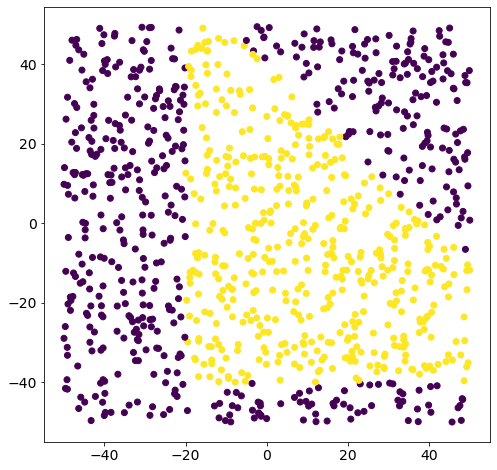

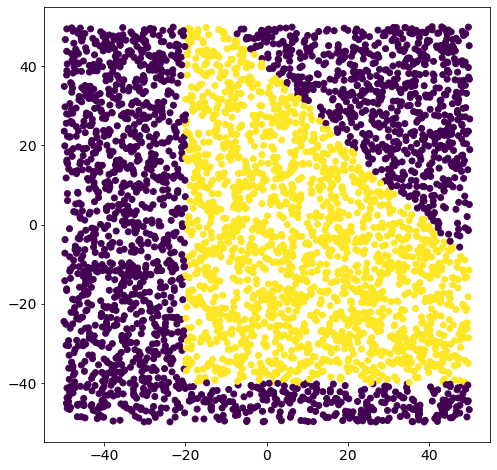

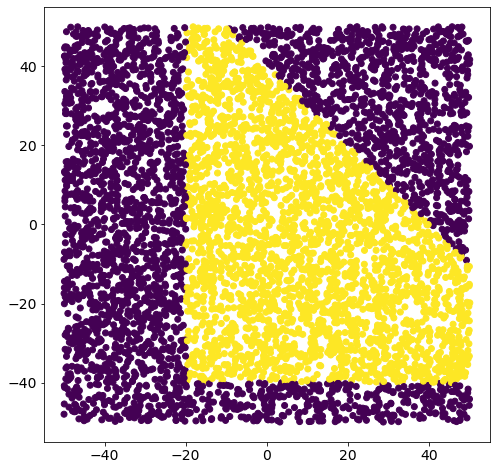

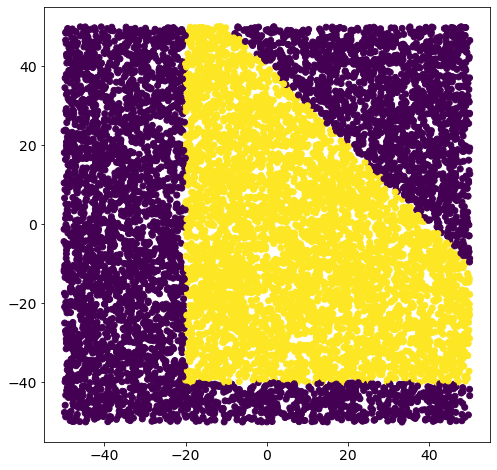

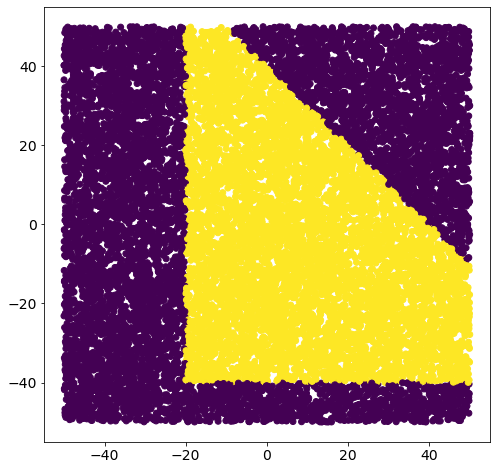

In [7]:
#Generate different amounts of data to see how many epochs is needed for each case
Num_samples = [1000,4000,6000,10000,15000]
nums = ["1k","4k","6k","10k","15k"]

for i in range(len(nums)):
    name_x,name_y = str("x_"+nums[i]),str("y_"+nums[i])
    x_gen,y_gen = generate_data(Num_samples[i])
    plot_scatter(x_gen, y_gen)
    save_in_DATA(x_gen,y_gen,str("data_"+nums[i]),str("labels_"+nums[i]))

In [328]:
#Defining model, explicit example
np.random.seed(12345)

CASE=1

#Dense - connecting every point in this layer into next layer
#Choosing relu for th first layer
if CASE==1:
    model = Sequential()
    model.add(Dense(L,input_shape=(L,), activation ='relu'))
    model.add(Dense(20,activation = 'relu')) #second layer, 20 nodes, with relu activation
    model.add(Dense(20,activation = 'relu'))
    model.add(Dropout(0.2)) #make the model more stochastic,drop nodes with prob. 0.2 for each layer
    model.add(Dense(1,activation='sigmoid')) #adds a single node, with func 0,1 -> use sigmoid here
    #nepoch=600 #Full training, going through the database 400 times, Keras reshuffles the data betw. each time
    
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 2)                 6         
                                                                 
 dense_49 (Dense)            (None, 20)                60        
                                                                 
 dense_50 (Dense)            (None, 20)                420       
                                                                 
 dropout_12 (Dropout)        (None, 20)                0         
                                                                 
 dense_51 (Dense)            (None, 1)                 21        
                                                                 
Total params: 507
Trainable params: 507
Non-trainable params: 0
_________________________________________________________________
None


In [67]:
def create_model(L,hidden_layers,activation_func,drop_out, init_al,nodes):
    model = Sequential()
    model.add(Dense(L,input_shape=(L,), activation = activation_func,kernel_initializer=init_al))
    for i in range(hidden_layers):
        model.add(Dense(nodes,activation = activation_func,kernel_initializer=init_al))
    model.add(Dropout(drop_out))
    model.add(Dense(1,activation = 'sigmoid'))
    return model

def compile_model(L=2,hidden_layers=4,activation_func='relu',drop_out=0.2,opti='adam',init_al='he_uniform', nodes = 10,create = create_model):
    #create the model
    model=create(L,hidden_layers,activation_func,drop_out,init_al,nodes)
    # compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=opti,
                  metrics=['accuracy'])
    
    return model

es = EarlyStopping(monitor='val_loss',min_delta = 0.00001, mode='min', patience =8)

In [21]:
def train_fits(num_samples,perc,L_dim,nepochs,init_weights):
    fits = []
    es = EarlyStopping(monitor='val_loss',min_delta = 0.00001, mode='min', patience =8)
    for i in range(len(num_samples)):
        N = num_samples[i]
        N_train = int(N*perc)
        print(N_train)
        x,y = generate_data(N)
        print(x[0:10])
        #save_in_DATA(x_data,y_data,str("x_"+names[i]),str("y_"+names[i]))
        x_train = x[0:N_train]
        y_train = y[0:N_train]
        x_valid = x[N_train:]
        y_valid = y[N_train:]
        x_train, x_valid = Rescale_standard(x_train,x_valid)
        model.load_weights(init_weights)
        fit = model.fit(x_train,y_train,
               epochs = nepochs, batch_size = 50,
               validation_data =(x_valid,y_valid),
               verbose=2, callbacks = [es])
        fits.append(fit)
    return fits

In [22]:
def plot_fits(fits,names,cols):
    fig,AX = plt.subplots(1,2,figsize=(14,6.))
    AX[0].set_xlabel('epoch')
    AX[0].set_ylabel("Accuracy")
    AX[1].set_xlabel('epoch')
    AX[1].set_ylabel("Loss")

    for i in range(len(fits)):
        AX[0].plot(fits[i].history['accuracy'], label=str("train_"+names[i]), color = cols[i])
        AX[0].plot(fits[i].history['val_accuracy'], linestyle = '--',label = str("valid_" + names[i]),color = cols[i])
        AX[1].plot(fits[i].history['loss'], label=str("train_"+names[i]), color = cols[i])
        AX[1].plot(fits[i].history['val_loss'], linestyle = '--', label = str("valid_"+names[i]), color = cols[i])
    AX[0].legend()
    AX[1].legend()
    plt.show()

In [23]:
def avg_test(num_samp,rounds,perc,L_dim,nepochs,initializer_func,activation='relu'):
    x,y = generate_data(num_samp)
    x_train = x[0:N_train]
    y_train = y[0:N_train]
    x_valid = x[N_train:]
    y_valid = y[N_train:]
    x_train, x_valid = Rescale_standard(x_train,x_valid)

    fits_type = []

    for i in range(rounds):
        model = compile_model(L_dim,2,activation,0.2,'adam',initializer_func)
        fit = model.fit(x_train,y_train,
               epochs = nepochs, batch_size = 50,
               validation_data =(x_valid,y_valid),
               verbose=2, callbacks = [es])
        fits_type.append(fit)
    return fits_type

In [39]:
def print_grid_result(grid_res):
    means = grid_res.cv_results_['mean_test_score']
    stds = grid_res.cv_results_['std_test_score']
    mean_times = grid_res.cv_results_["mean_fit_time"]
    params = np.array(grid_res.cv_results_['params'])
    permutation = means.argsort()
    means = means[permutation]
    stds = stds[permutation]
    mean_times = mean_times[permutation]
    params = params[permutation]
    i = -10
    for mean, stdev, param, mean_time in zip(means[i:], stds[i:], params[i:], mean_times[i:]):
        print("%f (%f), time: %f with: %r" % (mean, stdev, mean_time, param))

In [14]:
#model = create_model(L_dim,2,'relu',0.2)

#model.compile(loss='binary_crossentropy',#optimizer='RMSprop',
              #optimizer='adam',
            # metrics =['accuracy'])
model = compile_model(2,2,'relu',0.2,'adam')
model.save_weights('initial_weights.h5')

In [11]:
np.random.seed(12345)

num_samples = [1000,4000,6000,10000,15000]
names = ['1k','4k','6k','10k','15k']
cols = ['blue','orange','purple','grey','yellow']

perc = 0.8
L_dim = 2
nepochs = 400

es = EarlyStopping(monitor='val_loss',min_delta = 0.00001, mode='min', patience =8)
fits = train_fits(num_samples,perc,L_dim,nepochs,'initial_weights.h5')

800
[[ 42.96160928 -18.36244454]
 [-31.60811883 -29.54397214]
 [  6.77250291   9.5544703 ]
 [ 46.45145197  15.31770969]
 [ 24.89066375  15.35698709]
 [ 24.77148093  46.13067361]
 [-49.16117021 -39.35556233]
 [-20.12962862  15.64111831]
 [ 30.98125525  37.21759137]
 [ 46.46475974  22.36853469]]
Epoch 1/400
16/16 - 0s - loss: 0.6907 - accuracy: 0.5525 - val_loss: 0.7001 - val_accuracy: 0.4650
Epoch 2/400
16/16 - 0s - loss: 0.6898 - accuracy: 0.5500 - val_loss: 0.6989 - val_accuracy: 0.4650
Epoch 3/400
16/16 - 0s - loss: 0.6867 - accuracy: 0.5500 - val_loss: 0.6989 - val_accuracy: 0.4650
Epoch 4/400
16/16 - 0s - loss: 0.6859 - accuracy: 0.5512 - val_loss: 0.6982 - val_accuracy: 0.4650
Epoch 5/400
16/16 - 0s - loss: 0.6837 - accuracy: 0.5500 - val_loss: 0.6982 - val_accuracy: 0.4650
Epoch 6/400
16/16 - 0s - loss: 0.6817 - accuracy: 0.5487 - val_loss: 0.6967 - val_accuracy: 0.4650
Epoch 7/400
16/16 - 0s - loss: 0.6798 - accuracy: 0.5500 - val_loss: 0.6961 - val_accuracy: 0.4650
Epoch 8/400


Epoch 81/400
16/16 - 0s - loss: 0.2841 - accuracy: 0.9100 - val_loss: 0.2458 - val_accuracy: 0.9450
Epoch 82/400
16/16 - 0s - loss: 0.2838 - accuracy: 0.9087 - val_loss: 0.2439 - val_accuracy: 0.9450
Epoch 83/400
16/16 - 0s - loss: 0.2760 - accuracy: 0.9100 - val_loss: 0.2403 - val_accuracy: 0.9450
Epoch 84/400
16/16 - 0s - loss: 0.2847 - accuracy: 0.9100 - val_loss: 0.2413 - val_accuracy: 0.9450
Epoch 85/400
16/16 - 0s - loss: 0.2808 - accuracy: 0.9075 - val_loss: 0.2435 - val_accuracy: 0.9450
Epoch 86/400
16/16 - 0s - loss: 0.2811 - accuracy: 0.9050 - val_loss: 0.2407 - val_accuracy: 0.9450
Epoch 87/400
16/16 - 0s - loss: 0.2834 - accuracy: 0.9075 - val_loss: 0.2394 - val_accuracy: 0.9450
Epoch 88/400
16/16 - 0s - loss: 0.2829 - accuracy: 0.9025 - val_loss: 0.2387 - val_accuracy: 0.9450
Epoch 89/400
16/16 - 0s - loss: 0.2759 - accuracy: 0.9100 - val_loss: 0.2375 - val_accuracy: 0.9450
Epoch 90/400
16/16 - 0s - loss: 0.2793 - accuracy: 0.9075 - val_loss: 0.2374 - val_accuracy: 0.9450


Epoch 163/400
16/16 - 0s - loss: 0.2411 - accuracy: 0.9175 - val_loss: 0.2069 - val_accuracy: 0.9500
Epoch 164/400
16/16 - 0s - loss: 0.2518 - accuracy: 0.9175 - val_loss: 0.2059 - val_accuracy: 0.9500
3200
[[ -1.48297323  -0.07788833]
 [ 31.26450396  47.01071263]
 [ -6.05696442 -26.54622208]
 [ 25.48935466 -13.58798801]
 [ 27.93764153 -17.39482609]
 [ 32.32360633 -10.24444496]
 [  8.60918157  11.89608001]
 [-15.56680871  38.07823316]
 [ 10.98967881 -12.08563551]
 [-21.09229096  11.99749704]]
Epoch 1/400
64/64 - 0s - loss: 0.6819 - accuracy: 0.5456 - val_loss: 0.6744 - val_accuracy: 0.5600
Epoch 2/400
64/64 - 0s - loss: 0.6748 - accuracy: 0.5600 - val_loss: 0.6700 - val_accuracy: 0.5938
Epoch 3/400
64/64 - 0s - loss: 0.6693 - accuracy: 0.6125 - val_loss: 0.6648 - val_accuracy: 0.6388
Epoch 4/400
64/64 - 0s - loss: 0.6622 - accuracy: 0.6366 - val_loss: 0.6564 - val_accuracy: 0.6587
Epoch 5/400
64/64 - 0s - loss: 0.6491 - accuracy: 0.6534 - val_loss: 0.6393 - val_accuracy: 0.6862
Epoch 6

64/64 - 0s - loss: 0.1875 - accuracy: 0.9262 - val_loss: 0.1761 - val_accuracy: 0.9300
Epoch 79/400
64/64 - 0s - loss: 0.1841 - accuracy: 0.9331 - val_loss: 0.1750 - val_accuracy: 0.9300
Epoch 80/400
64/64 - 0s - loss: 0.1847 - accuracy: 0.9291 - val_loss: 0.1766 - val_accuracy: 0.9300
Epoch 81/400
64/64 - 0s - loss: 0.1773 - accuracy: 0.9319 - val_loss: 0.1759 - val_accuracy: 0.9275
Epoch 82/400
64/64 - 0s - loss: 0.1803 - accuracy: 0.9297 - val_loss: 0.1722 - val_accuracy: 0.9300
Epoch 83/400
64/64 - 0s - loss: 0.1793 - accuracy: 0.9291 - val_loss: 0.1766 - val_accuracy: 0.9237
Epoch 84/400
64/64 - 0s - loss: 0.1780 - accuracy: 0.9337 - val_loss: 0.1715 - val_accuracy: 0.9312
Epoch 85/400
64/64 - 0s - loss: 0.1762 - accuracy: 0.9325 - val_loss: 0.1716 - val_accuracy: 0.9337
Epoch 86/400
64/64 - 0s - loss: 0.1809 - accuracy: 0.9256 - val_loss: 0.1702 - val_accuracy: 0.9325
Epoch 87/400
64/64 - 0s - loss: 0.1792 - accuracy: 0.9294 - val_loss: 0.1708 - val_accuracy: 0.9337
Epoch 88/400


Epoch 160/400
64/64 - 0s - loss: 0.1319 - accuracy: 0.9494 - val_loss: 0.1097 - val_accuracy: 0.9700
Epoch 161/400
64/64 - 0s - loss: 0.1286 - accuracy: 0.9475 - val_loss: 0.1102 - val_accuracy: 0.9688
Epoch 162/400
64/64 - 0s - loss: 0.1274 - accuracy: 0.9478 - val_loss: 0.1091 - val_accuracy: 0.9700
Epoch 163/400
64/64 - 0s - loss: 0.1303 - accuracy: 0.9481 - val_loss: 0.1159 - val_accuracy: 0.9513
Epoch 164/400
64/64 - 0s - loss: 0.1296 - accuracy: 0.9481 - val_loss: 0.1135 - val_accuracy: 0.9538
Epoch 165/400
64/64 - 0s - loss: 0.1240 - accuracy: 0.9491 - val_loss: 0.1124 - val_accuracy: 0.9663
Epoch 166/400
64/64 - 0s - loss: 0.1197 - accuracy: 0.9544 - val_loss: 0.1089 - val_accuracy: 0.9712
Epoch 167/400
64/64 - 0s - loss: 0.1265 - accuracy: 0.9509 - val_loss: 0.1105 - val_accuracy: 0.9625
Epoch 168/400
64/64 - 0s - loss: 0.1256 - accuracy: 0.9497 - val_loss: 0.1062 - val_accuracy: 0.9700
Epoch 169/400
64/64 - 0s - loss: 0.1219 - accuracy: 0.9550 - val_loss: 0.1059 - val_accurac

64/64 - 0s - loss: 0.0891 - accuracy: 0.9675 - val_loss: 0.0755 - val_accuracy: 0.9825
Epoch 242/400
64/64 - 0s - loss: 0.0910 - accuracy: 0.9669 - val_loss: 0.0752 - val_accuracy: 0.9812
Epoch 243/400
64/64 - 0s - loss: 0.0909 - accuracy: 0.9647 - val_loss: 0.0743 - val_accuracy: 0.9812
4800
[[ 12.27034084 -41.4839042 ]
 [-33.70237356   5.67863419]
 [ 30.32938697  32.55236137]
 [-35.82933652 -19.4115482 ]
 [ 23.47219191  31.67444754]
 [-35.6076625  -20.56510058]
 [-35.48260959  -6.92422886]
 [-27.4136894   -9.80479818]
 [-28.30242567  13.69282826]
 [  9.32511961   7.66585544]]
Epoch 1/400
96/96 - 0s - loss: 0.6811 - accuracy: 0.5537 - val_loss: 0.6820 - val_accuracy: 0.5300
Epoch 2/400
96/96 - 0s - loss: 0.6730 - accuracy: 0.5669 - val_loss: 0.6740 - val_accuracy: 0.5800
Epoch 3/400
96/96 - 0s - loss: 0.6668 - accuracy: 0.6129 - val_loss: 0.6669 - val_accuracy: 0.6158
Epoch 4/400
96/96 - 0s - loss: 0.6608 - accuracy: 0.6265 - val_loss: 0.6580 - val_accuracy: 0.6400
Epoch 5/400
96/96 -

Epoch 78/400
96/96 - 0s - loss: 0.2046 - accuracy: 0.9312 - val_loss: 0.2198 - val_accuracy: 0.9225
Epoch 79/400
96/96 - 0s - loss: 0.2078 - accuracy: 0.9287 - val_loss: 0.2195 - val_accuracy: 0.9258
Epoch 80/400
96/96 - 0s - loss: 0.2050 - accuracy: 0.9306 - val_loss: 0.2181 - val_accuracy: 0.9233
Epoch 81/400
96/96 - 0s - loss: 0.2056 - accuracy: 0.9302 - val_loss: 0.2197 - val_accuracy: 0.9233
Epoch 82/400
96/96 - 0s - loss: 0.2063 - accuracy: 0.9279 - val_loss: 0.2212 - val_accuracy: 0.9183
Epoch 83/400
96/96 - 0s - loss: 0.2020 - accuracy: 0.9321 - val_loss: 0.2191 - val_accuracy: 0.9208
Epoch 84/400
96/96 - 0s - loss: 0.2060 - accuracy: 0.9287 - val_loss: 0.2176 - val_accuracy: 0.9217
Epoch 85/400
96/96 - 0s - loss: 0.2035 - accuracy: 0.9300 - val_loss: 0.2185 - val_accuracy: 0.9250
Epoch 86/400
96/96 - 0s - loss: 0.2061 - accuracy: 0.9275 - val_loss: 0.2188 - val_accuracy: 0.9242
Epoch 87/400
96/96 - 0s - loss: 0.2054 - accuracy: 0.9308 - val_loss: 0.2173 - val_accuracy: 0.9250


Epoch 59/400
160/160 - 0s - loss: 0.0574 - accuracy: 0.9822 - val_loss: 0.0491 - val_accuracy: 0.9835
Epoch 60/400
160/160 - 0s - loss: 0.0596 - accuracy: 0.9814 - val_loss: 0.0427 - val_accuracy: 0.9940
Epoch 61/400
160/160 - 0s - loss: 0.0565 - accuracy: 0.9818 - val_loss: 0.0421 - val_accuracy: 0.9905
Epoch 62/400
160/160 - 0s - loss: 0.0544 - accuracy: 0.9825 - val_loss: 0.0403 - val_accuracy: 0.9955
Epoch 63/400
160/160 - 0s - loss: 0.0537 - accuracy: 0.9815 - val_loss: 0.0407 - val_accuracy: 0.9895
Epoch 64/400
160/160 - 0s - loss: 0.0530 - accuracy: 0.9834 - val_loss: 0.0411 - val_accuracy: 0.9885
Epoch 65/400
160/160 - 0s - loss: 0.0526 - accuracy: 0.9822 - val_loss: 0.0501 - val_accuracy: 0.9800
Epoch 66/400
160/160 - 0s - loss: 0.0507 - accuracy: 0.9835 - val_loss: 0.0411 - val_accuracy: 0.9880
Epoch 67/400
160/160 - 0s - loss: 0.0505 - accuracy: 0.9824 - val_loss: 0.0367 - val_accuracy: 0.9895
Epoch 68/400
160/160 - 0s - loss: 0.0492 - accuracy: 0.9847 - val_loss: 0.0334 - v

Epoch 33/400
240/240 - 0s - loss: 0.2139 - accuracy: 0.9259 - val_loss: 0.2113 - val_accuracy: 0.9263
Epoch 34/400
240/240 - 0s - loss: 0.2142 - accuracy: 0.9249 - val_loss: 0.2109 - val_accuracy: 0.9260
Epoch 35/400
240/240 - 0s - loss: 0.2136 - accuracy: 0.9249 - val_loss: 0.2118 - val_accuracy: 0.9260
Epoch 36/400
240/240 - 0s - loss: 0.2141 - accuracy: 0.9249 - val_loss: 0.2091 - val_accuracy: 0.9290
Epoch 37/400
240/240 - 0s - loss: 0.2133 - accuracy: 0.9262 - val_loss: 0.2117 - val_accuracy: 0.9247
Epoch 38/400
240/240 - 0s - loss: 0.2134 - accuracy: 0.9259 - val_loss: 0.2111 - val_accuracy: 0.9250
Epoch 39/400
240/240 - 0s - loss: 0.2120 - accuracy: 0.9262 - val_loss: 0.2092 - val_accuracy: 0.9277
Epoch 40/400
240/240 - 0s - loss: 0.2132 - accuracy: 0.9258 - val_loss: 0.2124 - val_accuracy: 0.9227
Epoch 41/400
240/240 - 0s - loss: 0.2129 - accuracy: 0.9248 - val_loss: 0.2082 - val_accuracy: 0.9287
Epoch 42/400
240/240 - 0s - loss: 0.2129 - accuracy: 0.9255 - val_loss: 0.2080 - v

Epoch 114/400
240/240 - 0s - loss: 0.1503 - accuracy: 0.9258 - val_loss: 0.1427 - val_accuracy: 0.9250
Epoch 115/400
240/240 - 0s - loss: 0.1497 - accuracy: 0.9250 - val_loss: 0.1410 - val_accuracy: 0.9273
Epoch 116/400
240/240 - 0s - loss: 0.1489 - accuracy: 0.9252 - val_loss: 0.1362 - val_accuracy: 0.9287
Epoch 117/400
240/240 - 0s - loss: 0.1468 - accuracy: 0.9248 - val_loss: 0.1363 - val_accuracy: 0.9273
Epoch 118/400
240/240 - 0s - loss: 0.1433 - accuracy: 0.9246 - val_loss: 0.1314 - val_accuracy: 0.9290
Epoch 119/400
240/240 - 0s - loss: 0.1437 - accuracy: 0.9254 - val_loss: 0.1313 - val_accuracy: 0.9277
Epoch 120/400
240/240 - 0s - loss: 0.1396 - accuracy: 0.9246 - val_loss: 0.1287 - val_accuracy: 0.9260
Epoch 121/400
240/240 - 0s - loss: 0.1390 - accuracy: 0.9243 - val_loss: 0.1239 - val_accuracy: 0.9283
Epoch 122/400
240/240 - 0s - loss: 0.1368 - accuracy: 0.9249 - val_loss: 0.1214 - val_accuracy: 0.9283
Epoch 123/400
240/240 - 0s - loss: 0.1328 - accuracy: 0.9252 - val_loss: 

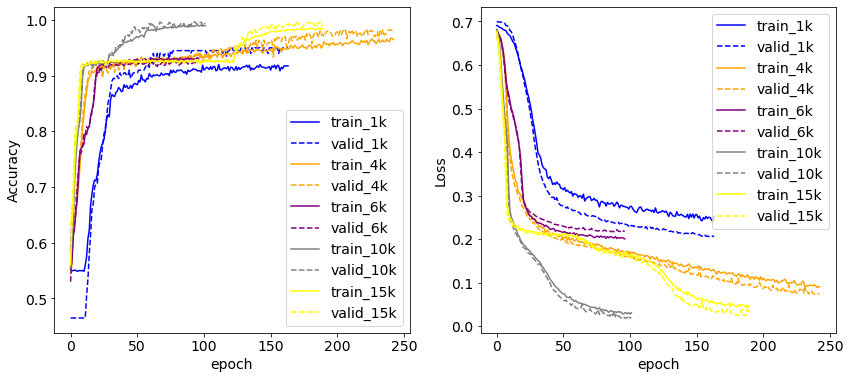

In [13]:
#Plot result
plot_fits(fits,names, cols)

From the plot above, we can see that even a sample size of 4k samples, yields about the same loss and accuracy as the sample size of 15k samples, if the data is fed through the learning algorithm more rounds. (insert Christoffers plot over different averaged accuracies for the different samples-sizes). Hence, it is not necessary to have a very large amount of samples when investigating the properties of the classifier further.

In the grid search, we must investigate what hyperparameters of the model that may improve it in terms of accuracy and computation time. For a sample size of 4k samples, that means that the best prediction gives a competitive accuracy with the least number of epochs.

## Playing with initizialization of weights

In [90]:
#Investigate different kind of initial weights
#Have only initialized the hidden layers, as the first layer only has two weights
#Different initializations possible:

#randomnormal
model = compile_model(L_dim,2,'relu',0.2,'adam','random_normal')
model.save_weights('initial_weights_1.h5')

fits1 = train_fits(num_samples,perc,L_dim,nepochs,'initial_weights_1.h5')

800
[[ 19.17587003  10.81567708]
 [-31.53022374  16.21066249]
 [ -9.93636096  -4.41645028]
 [ 22.05562262 -32.07451396]
 [-44.03997795  30.90275278]
 [ 43.03517877   5.97471114]
 [  2.21809581 -33.27193076]
 [ 15.72439606 -35.31442231]
 [-46.98882338 -11.42032235]
 [-46.25010571 -40.67030615]]
Epoch 1/400
16/16 - 1s - loss: 0.6914 - accuracy: 0.6363 - val_loss: 0.6899 - val_accuracy: 0.6850 - 618ms/epoch - 39ms/step
Epoch 2/400
16/16 - 0s - loss: 0.6889 - accuracy: 0.6513 - val_loss: 0.6866 - val_accuracy: 0.6850 - 38ms/epoch - 2ms/step
Epoch 3/400
16/16 - 0s - loss: 0.6849 - accuracy: 0.6650 - val_loss: 0.6823 - val_accuracy: 0.6950 - 46ms/epoch - 3ms/step
Epoch 4/400
16/16 - 0s - loss: 0.6790 - accuracy: 0.6575 - val_loss: 0.6754 - val_accuracy: 0.6950 - 47ms/epoch - 3ms/step
Epoch 5/400
16/16 - 0s - loss: 0.6711 - accuracy: 0.6575 - val_loss: 0.6660 - val_accuracy: 0.6900 - 50ms/epoch - 3ms/step
Epoch 6/400
16/16 - 0s - loss: 0.6597 - accuracy: 0.6662 - val_loss: 0.6547 - val_accura

Epoch 65/400
16/16 - 0s - loss: 0.3191 - accuracy: 0.8838 - val_loss: 0.3224 - val_accuracy: 0.8800 - 39ms/epoch - 2ms/step
Epoch 66/400
16/16 - 0s - loss: 0.3082 - accuracy: 0.8925 - val_loss: 0.3107 - val_accuracy: 0.8750 - 37ms/epoch - 2ms/step
Epoch 67/400
16/16 - 0s - loss: 0.3011 - accuracy: 0.8975 - val_loss: 0.3025 - val_accuracy: 0.8950 - 37ms/epoch - 2ms/step
Epoch 68/400
16/16 - 0s - loss: 0.2904 - accuracy: 0.9100 - val_loss: 0.2931 - val_accuracy: 0.9000 - 38ms/epoch - 2ms/step
Epoch 69/400
16/16 - 0s - loss: 0.2836 - accuracy: 0.9112 - val_loss: 0.2897 - val_accuracy: 0.9050 - 37ms/epoch - 2ms/step
Epoch 70/400
16/16 - 0s - loss: 0.2708 - accuracy: 0.9162 - val_loss: 0.2832 - val_accuracy: 0.9150 - 37ms/epoch - 2ms/step
Epoch 71/400
16/16 - 0s - loss: 0.2633 - accuracy: 0.9175 - val_loss: 0.2784 - val_accuracy: 0.9050 - 38ms/epoch - 2ms/step
Epoch 72/400
16/16 - 0s - loss: 0.2598 - accuracy: 0.9225 - val_loss: 0.2757 - val_accuracy: 0.9200 - 37ms/epoch - 2ms/step
Epoch 73

Epoch 131/400
16/16 - 0s - loss: 0.1638 - accuracy: 0.9400 - val_loss: 0.1886 - val_accuracy: 0.9300 - 41ms/epoch - 3ms/step
Epoch 132/400
16/16 - 0s - loss: 0.1667 - accuracy: 0.9413 - val_loss: 0.1880 - val_accuracy: 0.9300 - 41ms/epoch - 3ms/step
Epoch 133/400
16/16 - 0s - loss: 0.1638 - accuracy: 0.9375 - val_loss: 0.1887 - val_accuracy: 0.9300 - 41ms/epoch - 3ms/step
Epoch 134/400
16/16 - 0s - loss: 0.1619 - accuracy: 0.9400 - val_loss: 0.1863 - val_accuracy: 0.9300 - 42ms/epoch - 3ms/step
Epoch 135/400
16/16 - 0s - loss: 0.1566 - accuracy: 0.9438 - val_loss: 0.1844 - val_accuracy: 0.9300 - 41ms/epoch - 3ms/step
Epoch 136/400
16/16 - 0s - loss: 0.1615 - accuracy: 0.9362 - val_loss: 0.1822 - val_accuracy: 0.9300 - 38ms/epoch - 2ms/step
Epoch 137/400
16/16 - 0s - loss: 0.1593 - accuracy: 0.9438 - val_loss: 0.1813 - val_accuracy: 0.9300 - 39ms/epoch - 2ms/step
Epoch 138/400
16/16 - 0s - loss: 0.1573 - accuracy: 0.9425 - val_loss: 0.1826 - val_accuracy: 0.9300 - 40ms/epoch - 3ms/step


Epoch 197/400
16/16 - 0s - loss: 0.1234 - accuracy: 0.9588 - val_loss: 0.1505 - val_accuracy: 0.9550 - 39ms/epoch - 2ms/step
Epoch 198/400
16/16 - 0s - loss: 0.1222 - accuracy: 0.9625 - val_loss: 0.1500 - val_accuracy: 0.9500 - 37ms/epoch - 2ms/step
Epoch 199/400
16/16 - 0s - loss: 0.1229 - accuracy: 0.9538 - val_loss: 0.1515 - val_accuracy: 0.9450 - 40ms/epoch - 3ms/step
Epoch 200/400
16/16 - 0s - loss: 0.1183 - accuracy: 0.9613 - val_loss: 0.1469 - val_accuracy: 0.9550 - 39ms/epoch - 2ms/step
Epoch 201/400
16/16 - 0s - loss: 0.1243 - accuracy: 0.9550 - val_loss: 0.1465 - val_accuracy: 0.9550 - 39ms/epoch - 2ms/step
Epoch 202/400
16/16 - 0s - loss: 0.1228 - accuracy: 0.9625 - val_loss: 0.1500 - val_accuracy: 0.9500 - 40ms/epoch - 3ms/step
Epoch 203/400
16/16 - 0s - loss: 0.1234 - accuracy: 0.9588 - val_loss: 0.1479 - val_accuracy: 0.9550 - 40ms/epoch - 3ms/step
Epoch 204/400
16/16 - 0s - loss: 0.1259 - accuracy: 0.9550 - val_loss: 0.1492 - val_accuracy: 0.9650 - 38ms/epoch - 2ms/step


Epoch 13/400
64/64 - 0s - loss: 0.5063 - accuracy: 0.7116 - val_loss: 0.5155 - val_accuracy: 0.7013 - 91ms/epoch - 1ms/step
Epoch 14/400
64/64 - 0s - loss: 0.4988 - accuracy: 0.7169 - val_loss: 0.5111 - val_accuracy: 0.7163 - 91ms/epoch - 1ms/step
Epoch 15/400
64/64 - 0s - loss: 0.4945 - accuracy: 0.7163 - val_loss: 0.5026 - val_accuracy: 0.7075 - 90ms/epoch - 1ms/step
Epoch 16/400
64/64 - 0s - loss: 0.4899 - accuracy: 0.7259 - val_loss: 0.4954 - val_accuracy: 0.7100 - 91ms/epoch - 1ms/step
Epoch 17/400
64/64 - 0s - loss: 0.4790 - accuracy: 0.7291 - val_loss: 0.4889 - val_accuracy: 0.7362 - 92ms/epoch - 1ms/step
Epoch 18/400
64/64 - 0s - loss: 0.4762 - accuracy: 0.7275 - val_loss: 0.4824 - val_accuracy: 0.7175 - 87ms/epoch - 1ms/step
Epoch 19/400
64/64 - 0s - loss: 0.4732 - accuracy: 0.7375 - val_loss: 0.4775 - val_accuracy: 0.7425 - 90ms/epoch - 1ms/step
Epoch 20/400
64/64 - 0s - loss: 0.4684 - accuracy: 0.7278 - val_loss: 0.4709 - val_accuracy: 0.7262 - 93ms/epoch - 1ms/step
Epoch 21

64/64 - 0s - loss: 0.2560 - accuracy: 0.8825 - val_loss: 0.2542 - val_accuracy: 0.8763 - 91ms/epoch - 1ms/step
Epoch 80/400
64/64 - 0s - loss: 0.2560 - accuracy: 0.8797 - val_loss: 0.2551 - val_accuracy: 0.8788 - 89ms/epoch - 1ms/step
Epoch 81/400
64/64 - 0s - loss: 0.2563 - accuracy: 0.8797 - val_loss: 0.2523 - val_accuracy: 0.8788 - 90ms/epoch - 1ms/step
Epoch 82/400
64/64 - 0s - loss: 0.2591 - accuracy: 0.8800 - val_loss: 0.2648 - val_accuracy: 0.8712 - 90ms/epoch - 1ms/step
Epoch 83/400
64/64 - 0s - loss: 0.2580 - accuracy: 0.8838 - val_loss: 0.2581 - val_accuracy: 0.8775 - 94ms/epoch - 1ms/step
Epoch 84/400
64/64 - 0s - loss: 0.2596 - accuracy: 0.8778 - val_loss: 0.2628 - val_accuracy: 0.8813 - 89ms/epoch - 1ms/step
Epoch 85/400
64/64 - 0s - loss: 0.2589 - accuracy: 0.8794 - val_loss: 0.2518 - val_accuracy: 0.8763 - 93ms/epoch - 1ms/step
Epoch 86/400
64/64 - 0s - loss: 0.2569 - accuracy: 0.8838 - val_loss: 0.2568 - val_accuracy: 0.8725 - 87ms/epoch - 1ms/step
Epoch 87/400
64/64 - 

Epoch 20/400
96/96 - 0s - loss: 0.4693 - accuracy: 0.7310 - val_loss: 0.4802 - val_accuracy: 0.7050 - 144ms/epoch - 1ms/step
Epoch 21/400
96/96 - 0s - loss: 0.4631 - accuracy: 0.7344 - val_loss: 0.4783 - val_accuracy: 0.7083 - 135ms/epoch - 1ms/step
Epoch 22/400
96/96 - 0s - loss: 0.4616 - accuracy: 0.7300 - val_loss: 0.4729 - val_accuracy: 0.7100 - 126ms/epoch - 1ms/step
Epoch 23/400
96/96 - 0s - loss: 0.4563 - accuracy: 0.7356 - val_loss: 0.4701 - val_accuracy: 0.7075 - 128ms/epoch - 1ms/step
Epoch 24/400
96/96 - 0s - loss: 0.4538 - accuracy: 0.7417 - val_loss: 0.4638 - val_accuracy: 0.7433 - 126ms/epoch - 1ms/step
Epoch 25/400
96/96 - 0s - loss: 0.4478 - accuracy: 0.7444 - val_loss: 0.4583 - val_accuracy: 0.7483 - 125ms/epoch - 1ms/step
Epoch 26/400
96/96 - 0s - loss: 0.4421 - accuracy: 0.7546 - val_loss: 0.4520 - val_accuracy: 0.7558 - 122ms/epoch - 1ms/step
Epoch 27/400
96/96 - 0s - loss: 0.4354 - accuracy: 0.7552 - val_loss: 0.4459 - val_accuracy: 0.7633 - 126ms/epoch - 1ms/step


Epoch 86/400
96/96 - 0s - loss: 0.1358 - accuracy: 0.9471 - val_loss: 0.1385 - val_accuracy: 0.9442 - 118ms/epoch - 1ms/step
Epoch 87/400
96/96 - 0s - loss: 0.1364 - accuracy: 0.9481 - val_loss: 0.1382 - val_accuracy: 0.9467 - 120ms/epoch - 1ms/step
Epoch 88/400
96/96 - 0s - loss: 0.1344 - accuracy: 0.9494 - val_loss: 0.1385 - val_accuracy: 0.9433 - 119ms/epoch - 1ms/step
Epoch 89/400
96/96 - 0s - loss: 0.1341 - accuracy: 0.9475 - val_loss: 0.1390 - val_accuracy: 0.9433 - 121ms/epoch - 1ms/step
Epoch 90/400
96/96 - 0s - loss: 0.1322 - accuracy: 0.9498 - val_loss: 0.1371 - val_accuracy: 0.9442 - 122ms/epoch - 1ms/step
Epoch 91/400
96/96 - 0s - loss: 0.1310 - accuracy: 0.9517 - val_loss: 0.1389 - val_accuracy: 0.9400 - 123ms/epoch - 1ms/step
Epoch 92/400
96/96 - 0s - loss: 0.1301 - accuracy: 0.9508 - val_loss: 0.1338 - val_accuracy: 0.9458 - 123ms/epoch - 1ms/step
Epoch 93/400
96/96 - 0s - loss: 0.1285 - accuracy: 0.9508 - val_loss: 0.1356 - val_accuracy: 0.9408 - 122ms/epoch - 1ms/step


Epoch 152/400
96/96 - 0s - loss: 0.0816 - accuracy: 0.9717 - val_loss: 0.0775 - val_accuracy: 0.9725 - 124ms/epoch - 1ms/step
Epoch 153/400
96/96 - 0s - loss: 0.0799 - accuracy: 0.9698 - val_loss: 0.0819 - val_accuracy: 0.9692 - 126ms/epoch - 1ms/step
Epoch 154/400
96/96 - 0s - loss: 0.0784 - accuracy: 0.9712 - val_loss: 0.0865 - val_accuracy: 0.9633 - 123ms/epoch - 1ms/step
Epoch 155/400
96/96 - 0s - loss: 0.0794 - accuracy: 0.9729 - val_loss: 0.0809 - val_accuracy: 0.9667 - 124ms/epoch - 1ms/step
Epoch 156/400
96/96 - 0s - loss: 0.0756 - accuracy: 0.9717 - val_loss: 0.0804 - val_accuracy: 0.9708 - 124ms/epoch - 1ms/step
Epoch 157/400
96/96 - 0s - loss: 0.0770 - accuracy: 0.9721 - val_loss: 0.0737 - val_accuracy: 0.9717 - 123ms/epoch - 1ms/step
Epoch 158/400
96/96 - 0s - loss: 0.0735 - accuracy: 0.9746 - val_loss: 0.1026 - val_accuracy: 0.9600 - 118ms/epoch - 1ms/step
Epoch 159/400
96/96 - 0s - loss: 0.0775 - accuracy: 0.9721 - val_loss: 0.0855 - val_accuracy: 0.9617 - 125ms/epoch - 1

96/96 - 0s - loss: 0.0378 - accuracy: 0.9873 - val_loss: 0.0357 - val_accuracy: 0.9858 - 148ms/epoch - 2ms/step
Epoch 218/400
96/96 - 0s - loss: 0.0401 - accuracy: 0.9881 - val_loss: 0.0366 - val_accuracy: 0.9917 - 142ms/epoch - 1ms/step
Epoch 219/400
96/96 - 0s - loss: 0.0415 - accuracy: 0.9856 - val_loss: 0.0326 - val_accuracy: 0.9900 - 144ms/epoch - 2ms/step
Epoch 220/400
96/96 - 0s - loss: 0.0372 - accuracy: 0.9856 - val_loss: 0.0427 - val_accuracy: 0.9833 - 133ms/epoch - 1ms/step
Epoch 221/400
96/96 - 0s - loss: 0.0496 - accuracy: 0.9835 - val_loss: 0.0459 - val_accuracy: 0.9825 - 130ms/epoch - 1ms/step
Epoch 222/400
96/96 - 0s - loss: 0.0435 - accuracy: 0.9829 - val_loss: 0.0336 - val_accuracy: 0.9892 - 142ms/epoch - 1ms/step
8000
[[ -8.91216076 -25.66225259]
 [-22.84130329 -12.69747849]
 [  5.43990637 -48.13400296]
 [-12.86168838 -33.79091692]
 [ 42.54857872 -10.00869524]
 [-43.11128059  38.21131512]
 [ 32.10257294 -22.08648745]
 [ 15.48483016   2.2461723 ]
 [-47.66261713 -35.95

Epoch 58/400
160/160 - 0s - loss: 0.1475 - accuracy: 0.9401 - val_loss: 0.1406 - val_accuracy: 0.9505 - 243ms/epoch - 2ms/step
Epoch 59/400
160/160 - 0s - loss: 0.1454 - accuracy: 0.9414 - val_loss: 0.1451 - val_accuracy: 0.9405 - 217ms/epoch - 1ms/step
Epoch 60/400
160/160 - 0s - loss: 0.1408 - accuracy: 0.9433 - val_loss: 0.1365 - val_accuracy: 0.9470 - 206ms/epoch - 1ms/step
Epoch 61/400
160/160 - 0s - loss: 0.1366 - accuracy: 0.9446 - val_loss: 0.1333 - val_accuracy: 0.9480 - 197ms/epoch - 1ms/step
Epoch 62/400
160/160 - 0s - loss: 0.1353 - accuracy: 0.9446 - val_loss: 0.1278 - val_accuracy: 0.9535 - 192ms/epoch - 1ms/step
Epoch 63/400
160/160 - 0s - loss: 0.1328 - accuracy: 0.9473 - val_loss: 0.1239 - val_accuracy: 0.9575 - 197ms/epoch - 1ms/step
Epoch 64/400
160/160 - 0s - loss: 0.1264 - accuracy: 0.9495 - val_loss: 0.1214 - val_accuracy: 0.9555 - 188ms/epoch - 1ms/step
Epoch 65/400
160/160 - 0s - loss: 0.1278 - accuracy: 0.9480 - val_loss: 0.1361 - val_accuracy: 0.9435 - 193ms/e

Epoch 123/400
160/160 - 0s - loss: 0.0475 - accuracy: 0.9809 - val_loss: 0.0343 - val_accuracy: 0.9895 - 251ms/epoch - 2ms/step
Epoch 124/400
160/160 - 0s - loss: 0.0473 - accuracy: 0.9821 - val_loss: 0.0490 - val_accuracy: 0.9785 - 215ms/epoch - 1ms/step
Epoch 125/400
160/160 - 0s - loss: 0.0472 - accuracy: 0.9815 - val_loss: 0.0324 - val_accuracy: 0.9910 - 290ms/epoch - 2ms/step
Epoch 126/400
160/160 - 0s - loss: 0.0478 - accuracy: 0.9815 - val_loss: 0.0335 - val_accuracy: 0.9900 - 240ms/epoch - 2ms/step
Epoch 127/400
160/160 - 0s - loss: 0.0443 - accuracy: 0.9839 - val_loss: 0.0357 - val_accuracy: 0.9860 - 273ms/epoch - 2ms/step
Epoch 128/400
160/160 - 0s - loss: 0.0447 - accuracy: 0.9827 - val_loss: 0.0306 - val_accuracy: 0.9930 - 251ms/epoch - 2ms/step
Epoch 129/400
160/160 - 0s - loss: 0.0428 - accuracy: 0.9856 - val_loss: 0.0356 - val_accuracy: 0.9840 - 241ms/epoch - 2ms/step
Epoch 130/400
160/160 - 0s - loss: 0.0397 - accuracy: 0.9855 - val_loss: 0.0374 - val_accuracy: 0.9865 -

Epoch 27/400
240/240 - 0s - loss: 0.2558 - accuracy: 0.8812 - val_loss: 0.2129 - val_accuracy: 0.8967 - 301ms/epoch - 1ms/step
Epoch 28/400
240/240 - 0s - loss: 0.2254 - accuracy: 0.8954 - val_loss: 0.1864 - val_accuracy: 0.9160 - 277ms/epoch - 1ms/step
Epoch 29/400
240/240 - 0s - loss: 0.2077 - accuracy: 0.9061 - val_loss: 0.1760 - val_accuracy: 0.9263 - 272ms/epoch - 1ms/step
Epoch 30/400
240/240 - 0s - loss: 0.1936 - accuracy: 0.9161 - val_loss: 0.1667 - val_accuracy: 0.9263 - 267ms/epoch - 1ms/step
Epoch 31/400
240/240 - 0s - loss: 0.1900 - accuracy: 0.9158 - val_loss: 0.1603 - val_accuracy: 0.9370 - 280ms/epoch - 1ms/step
Epoch 32/400
240/240 - 0s - loss: 0.1821 - accuracy: 0.9228 - val_loss: 0.1556 - val_accuracy: 0.9410 - 271ms/epoch - 1ms/step
Epoch 33/400
240/240 - 0s - loss: 0.1751 - accuracy: 0.9285 - val_loss: 0.1481 - val_accuracy: 0.9407 - 280ms/epoch - 1ms/step
Epoch 34/400
240/240 - 0s - loss: 0.1693 - accuracy: 0.9302 - val_loss: 0.1441 - val_accuracy: 0.9477 - 322ms/e

Epoch 92/400
240/240 - 0s - loss: 0.0474 - accuracy: 0.9803 - val_loss: 0.0353 - val_accuracy: 0.9867 - 277ms/epoch - 1ms/step
Epoch 93/400
240/240 - 0s - loss: 0.0450 - accuracy: 0.9820 - val_loss: 0.0440 - val_accuracy: 0.9787 - 272ms/epoch - 1ms/step
Epoch 94/400
240/240 - 0s - loss: 0.0448 - accuracy: 0.9817 - val_loss: 0.0620 - val_accuracy: 0.9770 - 277ms/epoch - 1ms/step
Epoch 95/400
240/240 - 0s - loss: 0.0428 - accuracy: 0.9829 - val_loss: 0.0385 - val_accuracy: 0.9800 - 268ms/epoch - 1ms/step
Epoch 96/400
240/240 - 0s - loss: 0.0429 - accuracy: 0.9808 - val_loss: 0.0312 - val_accuracy: 0.9877 - 280ms/epoch - 1ms/step
Epoch 97/400
240/240 - 0s - loss: 0.0414 - accuracy: 0.9848 - val_loss: 0.0332 - val_accuracy: 0.9867 - 267ms/epoch - 1ms/step
Epoch 98/400
240/240 - 0s - loss: 0.0406 - accuracy: 0.9838 - val_loss: 0.0438 - val_accuracy: 0.9797 - 267ms/epoch - 1ms/step
Epoch 99/400
240/240 - 0s - loss: 0.0389 - accuracy: 0.9847 - val_loss: 0.0394 - val_accuracy: 0.9807 - 271ms/e

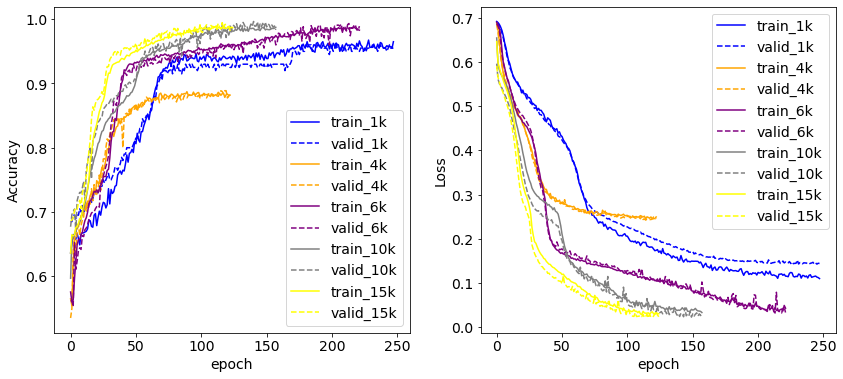

In [91]:
plot_fits(fits1,names,cols)
#Seems to loose 4k on the way
#Converges a lot slower

In [94]:
#TruncatedNormal
#Almost the same as randomUniform, but discards values more than two standard deviations from the mean
init_al_2 = initializers.TruncatedNormal(mean=0., stddev=1.)
model = compile_model(L_dim,2,'relu',0.2,'adam',init_al_2)
model.save_weights('initial_weights_4.h5')

fits2 = train_fits(num_samples,perc,L_dim,nepochs,'initial_weights_4.h5')

800
[[-29.91795285  38.40322598]
 [ -5.34294928  15.87770731]
 [ 30.48354908  17.46783559]
 [-49.43219886  47.09172827]
 [ -3.71983459 -22.17649978]
 [ 45.87195341   5.49826092]
 [ 41.78308969  -2.71423313]
 [ 20.5615368   19.89926771]
 [  7.3338539   46.67184976]
 [-17.64019783 -27.96940045]]
Epoch 1/400
16/16 - 0s - loss: 0.7804 - accuracy: 0.4338 - val_loss: 0.7378 - val_accuracy: 0.4050 - 469ms/epoch - 29ms/step
Epoch 2/400
16/16 - 0s - loss: 0.7238 - accuracy: 0.4350 - val_loss: 0.7077 - val_accuracy: 0.4050 - 46ms/epoch - 3ms/step
Epoch 3/400
16/16 - 0s - loss: 0.7022 - accuracy: 0.4512 - val_loss: 0.6883 - val_accuracy: 0.4050 - 47ms/epoch - 3ms/step
Epoch 4/400
16/16 - 0s - loss: 0.6891 - accuracy: 0.4888 - val_loss: 0.6753 - val_accuracy: 0.4150 - 48ms/epoch - 3ms/step
Epoch 5/400
16/16 - 0s - loss: 0.6733 - accuracy: 0.5025 - val_loss: 0.6645 - val_accuracy: 0.4150 - 48ms/epoch - 3ms/step
Epoch 6/400
16/16 - 0s - loss: 0.6706 - accuracy: 0.5600 - val_loss: 0.6526 - val_accura

Epoch 65/400
16/16 - 0s - loss: 0.4006 - accuracy: 0.8213 - val_loss: 0.3852 - val_accuracy: 0.8150 - 43ms/epoch - 3ms/step
Epoch 66/400
16/16 - 0s - loss: 0.4079 - accuracy: 0.8288 - val_loss: 0.3834 - val_accuracy: 0.8100 - 43ms/epoch - 3ms/step
Epoch 67/400
16/16 - 0s - loss: 0.4049 - accuracy: 0.8263 - val_loss: 0.3793 - val_accuracy: 0.8150 - 43ms/epoch - 3ms/step
Epoch 68/400
16/16 - 0s - loss: 0.3967 - accuracy: 0.8238 - val_loss: 0.3760 - val_accuracy: 0.8200 - 44ms/epoch - 3ms/step
Epoch 69/400
16/16 - 0s - loss: 0.4002 - accuracy: 0.8300 - val_loss: 0.3742 - val_accuracy: 0.8100 - 42ms/epoch - 3ms/step
Epoch 70/400
16/16 - 0s - loss: 0.3886 - accuracy: 0.8325 - val_loss: 0.3719 - val_accuracy: 0.8150 - 47ms/epoch - 3ms/step
Epoch 71/400
16/16 - 0s - loss: 0.3843 - accuracy: 0.8313 - val_loss: 0.3692 - val_accuracy: 0.8250 - 49ms/epoch - 3ms/step
Epoch 72/400
16/16 - 0s - loss: 0.3759 - accuracy: 0.8363 - val_loss: 0.3681 - val_accuracy: 0.8150 - 49ms/epoch - 3ms/step
Epoch 73

Epoch 131/400
16/16 - 0s - loss: 0.1876 - accuracy: 0.9350 - val_loss: 0.1336 - val_accuracy: 0.9600 - 43ms/epoch - 3ms/step
Epoch 132/400
16/16 - 0s - loss: 0.1855 - accuracy: 0.9312 - val_loss: 0.1315 - val_accuracy: 0.9650 - 41ms/epoch - 3ms/step
Epoch 133/400
16/16 - 0s - loss: 0.1781 - accuracy: 0.9388 - val_loss: 0.1309 - val_accuracy: 0.9600 - 37ms/epoch - 2ms/step
Epoch 134/400
16/16 - 0s - loss: 0.1817 - accuracy: 0.9375 - val_loss: 0.1304 - val_accuracy: 0.9600 - 39ms/epoch - 2ms/step
Epoch 135/400
16/16 - 0s - loss: 0.1769 - accuracy: 0.9275 - val_loss: 0.1283 - val_accuracy: 0.9600 - 40ms/epoch - 2ms/step
Epoch 136/400
16/16 - 0s - loss: 0.1775 - accuracy: 0.9388 - val_loss: 0.1266 - val_accuracy: 0.9700 - 40ms/epoch - 2ms/step
Epoch 137/400
16/16 - 0s - loss: 0.1806 - accuracy: 0.9325 - val_loss: 0.1250 - val_accuracy: 0.9650 - 37ms/epoch - 2ms/step
Epoch 138/400
16/16 - 0s - loss: 0.1784 - accuracy: 0.9362 - val_loss: 0.1230 - val_accuracy: 0.9650 - 38ms/epoch - 2ms/step


Epoch 197/400
16/16 - 0s - loss: 0.1372 - accuracy: 0.9550 - val_loss: 0.0884 - val_accuracy: 0.9750 - 44ms/epoch - 3ms/step
Epoch 198/400
16/16 - 0s - loss: 0.1323 - accuracy: 0.9525 - val_loss: 0.0875 - val_accuracy: 0.9750 - 43ms/epoch - 3ms/step
Epoch 199/400
16/16 - 0s - loss: 0.1437 - accuracy: 0.9450 - val_loss: 0.0909 - val_accuracy: 0.9700 - 44ms/epoch - 3ms/step
Epoch 200/400
16/16 - 0s - loss: 0.1330 - accuracy: 0.9513 - val_loss: 0.0894 - val_accuracy: 0.9800 - 42ms/epoch - 3ms/step
Epoch 201/400
16/16 - 0s - loss: 0.1329 - accuracy: 0.9513 - val_loss: 0.0879 - val_accuracy: 0.9750 - 47ms/epoch - 3ms/step
Epoch 202/400
16/16 - 0s - loss: 0.1389 - accuracy: 0.9450 - val_loss: 0.0866 - val_accuracy: 0.9800 - 41ms/epoch - 3ms/step
Epoch 203/400
16/16 - 0s - loss: 0.1257 - accuracy: 0.9600 - val_loss: 0.0860 - val_accuracy: 0.9800 - 42ms/epoch - 3ms/step
Epoch 204/400
16/16 - 0s - loss: 0.1357 - accuracy: 0.9513 - val_loss: 0.0877 - val_accuracy: 0.9800 - 45ms/epoch - 3ms/step


Epoch 263/400
16/16 - 0s - loss: 0.1157 - accuracy: 0.9575 - val_loss: 0.0742 - val_accuracy: 0.9800 - 37ms/epoch - 2ms/step
Epoch 264/400
16/16 - 0s - loss: 0.1121 - accuracy: 0.9588 - val_loss: 0.0760 - val_accuracy: 0.9700 - 45ms/epoch - 3ms/step
Epoch 265/400
16/16 - 0s - loss: 0.1130 - accuracy: 0.9600 - val_loss: 0.0745 - val_accuracy: 0.9800 - 41ms/epoch - 3ms/step
Epoch 266/400
16/16 - 0s - loss: 0.1150 - accuracy: 0.9575 - val_loss: 0.0737 - val_accuracy: 0.9800 - 37ms/epoch - 2ms/step
Epoch 267/400
16/16 - 0s - loss: 0.1127 - accuracy: 0.9575 - val_loss: 0.0754 - val_accuracy: 0.9800 - 39ms/epoch - 2ms/step
Epoch 268/400
16/16 - 0s - loss: 0.1069 - accuracy: 0.9675 - val_loss: 0.0776 - val_accuracy: 0.9750 - 40ms/epoch - 2ms/step
Epoch 269/400
16/16 - 0s - loss: 0.1102 - accuracy: 0.9625 - val_loss: 0.0752 - val_accuracy: 0.9700 - 40ms/epoch - 3ms/step
Epoch 270/400
16/16 - 0s - loss: 0.1152 - accuracy: 0.9563 - val_loss: 0.0735 - val_accuracy: 0.9800 - 37ms/epoch - 2ms/step


Epoch 39/400
64/64 - 0s - loss: 0.4215 - accuracy: 0.8091 - val_loss: 0.4076 - val_accuracy: 0.8250 - 90ms/epoch - 1ms/step
Epoch 40/400
64/64 - 0s - loss: 0.4158 - accuracy: 0.8116 - val_loss: 0.4024 - val_accuracy: 0.8288 - 93ms/epoch - 1ms/step
Epoch 41/400
64/64 - 0s - loss: 0.4105 - accuracy: 0.8094 - val_loss: 0.3940 - val_accuracy: 0.8250 - 93ms/epoch - 1ms/step
Epoch 42/400
64/64 - 0s - loss: 0.4133 - accuracy: 0.8106 - val_loss: 0.3903 - val_accuracy: 0.8375 - 95ms/epoch - 1ms/step
Epoch 43/400
64/64 - 0s - loss: 0.4086 - accuracy: 0.8112 - val_loss: 0.3818 - val_accuracy: 0.8363 - 98ms/epoch - 2ms/step
Epoch 44/400
64/64 - 0s - loss: 0.4070 - accuracy: 0.8106 - val_loss: 0.3784 - val_accuracy: 0.8450 - 120ms/epoch - 2ms/step
Epoch 45/400
64/64 - 0s - loss: 0.3993 - accuracy: 0.8178 - val_loss: 0.3699 - val_accuracy: 0.8475 - 98ms/epoch - 2ms/step
Epoch 46/400
64/64 - 0s - loss: 0.3964 - accuracy: 0.8191 - val_loss: 0.3701 - val_accuracy: 0.8537 - 96ms/epoch - 2ms/step
Epoch 4

Epoch 105/400
64/64 - 0s - loss: 0.1176 - accuracy: 0.9588 - val_loss: 0.1011 - val_accuracy: 0.9737 - 96ms/epoch - 1ms/step
Epoch 106/400
64/64 - 0s - loss: 0.1133 - accuracy: 0.9597 - val_loss: 0.1000 - val_accuracy: 0.9787 - 91ms/epoch - 1ms/step
Epoch 107/400
64/64 - 0s - loss: 0.1185 - accuracy: 0.9591 - val_loss: 0.0963 - val_accuracy: 0.9850 - 90ms/epoch - 1ms/step
Epoch 108/400
64/64 - 0s - loss: 0.1145 - accuracy: 0.9578 - val_loss: 0.0936 - val_accuracy: 0.9800 - 120ms/epoch - 2ms/step
Epoch 109/400
64/64 - 0s - loss: 0.1105 - accuracy: 0.9594 - val_loss: 0.0921 - val_accuracy: 0.9812 - 103ms/epoch - 2ms/step
Epoch 110/400
64/64 - 0s - loss: 0.1133 - accuracy: 0.9606 - val_loss: 0.0927 - val_accuracy: 0.9825 - 98ms/epoch - 2ms/step
Epoch 111/400
64/64 - 0s - loss: 0.1134 - accuracy: 0.9575 - val_loss: 0.0901 - val_accuracy: 0.9850 - 91ms/epoch - 1ms/step
Epoch 112/400
64/64 - 0s - loss: 0.1098 - accuracy: 0.9647 - val_loss: 0.0996 - val_accuracy: 0.9688 - 96ms/epoch - 2ms/ste

Epoch 171/400
64/64 - 0s - loss: 0.0756 - accuracy: 0.9744 - val_loss: 0.0582 - val_accuracy: 0.9825 - 94ms/epoch - 1ms/step
Epoch 172/400
64/64 - 0s - loss: 0.0709 - accuracy: 0.9762 - val_loss: 0.0562 - val_accuracy: 0.9912 - 126ms/epoch - 2ms/step
Epoch 173/400
64/64 - 0s - loss: 0.0737 - accuracy: 0.9737 - val_loss: 0.0534 - val_accuracy: 0.9912 - 96ms/epoch - 2ms/step
Epoch 174/400
64/64 - 0s - loss: 0.0680 - accuracy: 0.9775 - val_loss: 0.0551 - val_accuracy: 0.9887 - 92ms/epoch - 1ms/step
Epoch 175/400
64/64 - 0s - loss: 0.0708 - accuracy: 0.9722 - val_loss: 0.0533 - val_accuracy: 0.9912 - 92ms/epoch - 1ms/step
Epoch 176/400
64/64 - 0s - loss: 0.0766 - accuracy: 0.9728 - val_loss: 0.0585 - val_accuracy: 0.9862 - 91ms/epoch - 1ms/step
Epoch 177/400
64/64 - 0s - loss: 0.0774 - accuracy: 0.9722 - val_loss: 0.0555 - val_accuracy: 0.9912 - 89ms/epoch - 1ms/step
Epoch 178/400
64/64 - 0s - loss: 0.0712 - accuracy: 0.9750 - val_loss: 0.0534 - val_accuracy: 0.9850 - 90ms/epoch - 1ms/step

Epoch 6/400
96/96 - 0s - loss: 0.5671 - accuracy: 0.7071 - val_loss: 0.5485 - val_accuracy: 0.7200 - 161ms/epoch - 2ms/step
Epoch 7/400
96/96 - 0s - loss: 0.5545 - accuracy: 0.7206 - val_loss: 0.5365 - val_accuracy: 0.7250 - 150ms/epoch - 2ms/step
Epoch 8/400
96/96 - 0s - loss: 0.5362 - accuracy: 0.7329 - val_loss: 0.5246 - val_accuracy: 0.7383 - 152ms/epoch - 2ms/step
Epoch 9/400
96/96 - 0s - loss: 0.5285 - accuracy: 0.7398 - val_loss: 0.5166 - val_accuracy: 0.7467 - 159ms/epoch - 2ms/step
Epoch 10/400
96/96 - 0s - loss: 0.5228 - accuracy: 0.7379 - val_loss: 0.5034 - val_accuracy: 0.7442 - 150ms/epoch - 2ms/step
Epoch 11/400
96/96 - 0s - loss: 0.5078 - accuracy: 0.7458 - val_loss: 0.4940 - val_accuracy: 0.7567 - 156ms/epoch - 2ms/step
Epoch 12/400
96/96 - 0s - loss: 0.5039 - accuracy: 0.7542 - val_loss: 0.4862 - val_accuracy: 0.7592 - 157ms/epoch - 2ms/step
Epoch 13/400
96/96 - 0s - loss: 0.4923 - accuracy: 0.7585 - val_loss: 0.4776 - val_accuracy: 0.7658 - 157ms/epoch - 2ms/step
Epoc

Epoch 72/400
96/96 - 0s - loss: 0.0815 - accuracy: 0.9754 - val_loss: 0.0794 - val_accuracy: 0.9825 - 125ms/epoch - 1ms/step
Epoch 73/400
96/96 - 0s - loss: 0.0859 - accuracy: 0.9723 - val_loss: 0.0770 - val_accuracy: 0.9808 - 128ms/epoch - 1ms/step
Epoch 74/400
96/96 - 0s - loss: 0.0823 - accuracy: 0.9719 - val_loss: 0.0776 - val_accuracy: 0.9725 - 129ms/epoch - 1ms/step
Epoch 75/400
96/96 - 0s - loss: 0.0833 - accuracy: 0.9735 - val_loss: 0.0747 - val_accuracy: 0.9817 - 135ms/epoch - 1ms/step
Epoch 76/400
96/96 - 0s - loss: 0.0815 - accuracy: 0.9727 - val_loss: 0.0905 - val_accuracy: 0.9592 - 182ms/epoch - 2ms/step
Epoch 77/400
96/96 - 0s - loss: 0.0849 - accuracy: 0.9702 - val_loss: 0.0751 - val_accuracy: 0.9808 - 175ms/epoch - 2ms/step
Epoch 78/400
96/96 - 0s - loss: 0.0818 - accuracy: 0.9712 - val_loss: 0.0760 - val_accuracy: 0.9725 - 150ms/epoch - 2ms/step
Epoch 79/400
96/96 - 0s - loss: 0.0782 - accuracy: 0.9723 - val_loss: 0.0718 - val_accuracy: 0.9825 - 138ms/epoch - 1ms/step


Epoch 7/400
160/160 - 0s - loss: 0.5086 - accuracy: 0.7579 - val_loss: 0.4739 - val_accuracy: 0.7780 - 244ms/epoch - 2ms/step
Epoch 8/400
160/160 - 0s - loss: 0.4979 - accuracy: 0.7579 - val_loss: 0.4624 - val_accuracy: 0.7855 - 243ms/epoch - 2ms/step
Epoch 9/400
160/160 - 0s - loss: 0.4875 - accuracy: 0.7734 - val_loss: 0.4543 - val_accuracy: 0.7895 - 214ms/epoch - 1ms/step
Epoch 10/400
160/160 - 0s - loss: 0.4842 - accuracy: 0.7694 - val_loss: 0.4476 - val_accuracy: 0.7940 - 221ms/epoch - 1ms/step
Epoch 11/400
160/160 - 0s - loss: 0.4725 - accuracy: 0.7754 - val_loss: 0.4399 - val_accuracy: 0.7995 - 216ms/epoch - 1ms/step
Epoch 12/400
160/160 - 0s - loss: 0.4737 - accuracy: 0.7780 - val_loss: 0.4343 - val_accuracy: 0.8055 - 197ms/epoch - 1ms/step
Epoch 13/400
160/160 - 0s - loss: 0.4657 - accuracy: 0.7775 - val_loss: 0.4298 - val_accuracy: 0.8045 - 196ms/epoch - 1ms/step
Epoch 14/400
160/160 - 0s - loss: 0.4530 - accuracy: 0.7864 - val_loss: 0.4217 - val_accuracy: 0.8085 - 189ms/epoc

Epoch 72/400
160/160 - 0s - loss: 0.0918 - accuracy: 0.9679 - val_loss: 0.0637 - val_accuracy: 0.9895 - 205ms/epoch - 1ms/step
Epoch 73/400
160/160 - 0s - loss: 0.0926 - accuracy: 0.9680 - val_loss: 0.0660 - val_accuracy: 0.9905 - 246ms/epoch - 2ms/step
Epoch 74/400
160/160 - 0s - loss: 0.0906 - accuracy: 0.9679 - val_loss: 0.0649 - val_accuracy: 0.9850 - 220ms/epoch - 1ms/step
Epoch 75/400
160/160 - 0s - loss: 0.0899 - accuracy: 0.9691 - val_loss: 0.0679 - val_accuracy: 0.9830 - 213ms/epoch - 1ms/step
Epoch 76/400
160/160 - 0s - loss: 0.0921 - accuracy: 0.9691 - val_loss: 0.0630 - val_accuracy: 0.9890 - 204ms/epoch - 1ms/step
Epoch 77/400
160/160 - 0s - loss: 0.0862 - accuracy: 0.9701 - val_loss: 0.0689 - val_accuracy: 0.9785 - 195ms/epoch - 1ms/step
Epoch 78/400
160/160 - 0s - loss: 0.0857 - accuracy: 0.9695 - val_loss: 0.0613 - val_accuracy: 0.9955 - 192ms/epoch - 1ms/step
Epoch 79/400
160/160 - 0s - loss: 0.0869 - accuracy: 0.9689 - val_loss: 0.0704 - val_accuracy: 0.9880 - 197ms/e

Epoch 31/400
240/240 - 0s - loss: 0.1029 - accuracy: 0.9629 - val_loss: 0.1077 - val_accuracy: 0.9510 - 288ms/epoch - 1ms/step
Epoch 32/400
240/240 - 0s - loss: 0.0971 - accuracy: 0.9652 - val_loss: 0.0845 - val_accuracy: 0.9680 - 270ms/epoch - 1ms/step
Epoch 33/400
240/240 - 0s - loss: 0.0926 - accuracy: 0.9679 - val_loss: 0.0766 - val_accuracy: 0.9753 - 270ms/epoch - 1ms/step
Epoch 34/400
240/240 - 0s - loss: 0.0866 - accuracy: 0.9718 - val_loss: 0.0715 - val_accuracy: 0.9800 - 271ms/epoch - 1ms/step
Epoch 35/400
240/240 - 0s - loss: 0.0827 - accuracy: 0.9728 - val_loss: 0.0679 - val_accuracy: 0.9793 - 279ms/epoch - 1ms/step
Epoch 36/400
240/240 - 0s - loss: 0.0816 - accuracy: 0.9703 - val_loss: 0.0717 - val_accuracy: 0.9793 - 262ms/epoch - 1ms/step
Epoch 37/400
240/240 - 0s - loss: 0.0776 - accuracy: 0.9710 - val_loss: 0.0750 - val_accuracy: 0.9710 - 263ms/epoch - 1ms/step
Epoch 38/400
240/240 - 0s - loss: 0.0757 - accuracy: 0.9745 - val_loss: 0.0614 - val_accuracy: 0.9837 - 281ms/e

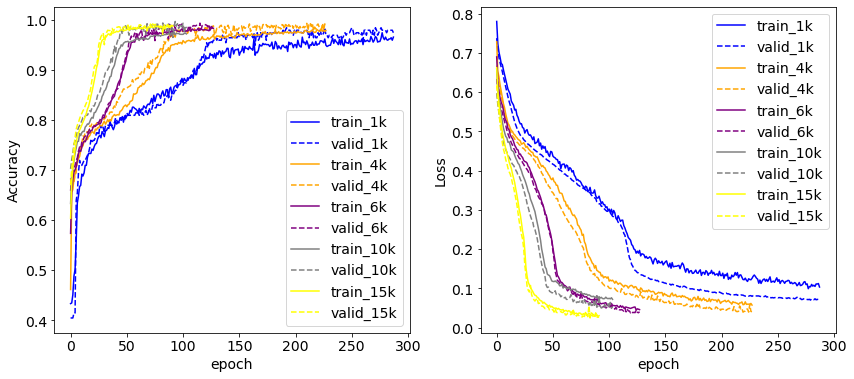

In [95]:
plot_fits(fits2,names,cols)
#Good accuracy but slower convergnece compared to default

In [96]:
#randomuniform
model = compile_model(L_dim,2,'relu',0.2,'adam','random_uniform')
model.save_weights('initial_weights_2.h5')

fits3 = train_fits(num_samples,perc,L_dim,nepochs,'initial_weights_2.h5')

800
[[-40.14780047  23.74367925]
 [ -3.99705096  -5.63566332]
 [ 40.08857078  39.31850556]
 [-27.05734912  28.33977616]
 [ 32.67662711 -34.60669466]
 [-38.09501723 -16.7916779 ]
 [ -1.52181381 -33.64556534]
 [ -0.93614654  -7.61963386]
 [-33.38763348 -43.55526275]
 [ 29.75292791  -3.74125944]]
Epoch 1/400
16/16 - 0s - loss: 0.6929 - accuracy: 0.5525 - val_loss: 0.6918 - val_accuracy: 0.5750 - 473ms/epoch - 30ms/step
Epoch 2/400
16/16 - 0s - loss: 0.6911 - accuracy: 0.5725 - val_loss: 0.6889 - val_accuracy: 0.5500 - 44ms/epoch - 3ms/step
Epoch 3/400
16/16 - 0s - loss: 0.6880 - accuracy: 0.5537 - val_loss: 0.6841 - val_accuracy: 0.5800 - 47ms/epoch - 3ms/step
Epoch 4/400
16/16 - 0s - loss: 0.6828 - accuracy: 0.5675 - val_loss: 0.6758 - val_accuracy: 0.6500 - 49ms/epoch - 3ms/step
Epoch 5/400
16/16 - 0s - loss: 0.6751 - accuracy: 0.6125 - val_loss: 0.6642 - val_accuracy: 0.7100 - 47ms/epoch - 3ms/step
Epoch 6/400
16/16 - 0s - loss: 0.6645 - accuracy: 0.6350 - val_loss: 0.6491 - val_accura

Epoch 65/400
16/16 - 0s - loss: 0.4623 - accuracy: 0.7425 - val_loss: 0.4110 - val_accuracy: 0.7700 - 52ms/epoch - 3ms/step
Epoch 66/400
16/16 - 0s - loss: 0.4531 - accuracy: 0.7437 - val_loss: 0.4079 - val_accuracy: 0.7700 - 51ms/epoch - 3ms/step
Epoch 67/400
16/16 - 0s - loss: 0.4589 - accuracy: 0.7387 - val_loss: 0.4038 - val_accuracy: 0.7700 - 48ms/epoch - 3ms/step
Epoch 68/400
16/16 - 0s - loss: 0.4585 - accuracy: 0.7237 - val_loss: 0.4020 - val_accuracy: 0.7700 - 42ms/epoch - 3ms/step
Epoch 69/400
16/16 - 0s - loss: 0.4560 - accuracy: 0.7513 - val_loss: 0.3983 - val_accuracy: 0.7700 - 41ms/epoch - 3ms/step
Epoch 70/400
16/16 - 0s - loss: 0.4511 - accuracy: 0.7412 - val_loss: 0.3952 - val_accuracy: 0.7700 - 40ms/epoch - 3ms/step
Epoch 71/400
16/16 - 0s - loss: 0.4517 - accuracy: 0.7362 - val_loss: 0.3922 - val_accuracy: 0.7700 - 40ms/epoch - 2ms/step
Epoch 72/400
16/16 - 0s - loss: 0.4461 - accuracy: 0.7500 - val_loss: 0.3912 - val_accuracy: 0.7700 - 38ms/epoch - 2ms/step
Epoch 73

Epoch 131/400
16/16 - 0s - loss: 0.2195 - accuracy: 0.9100 - val_loss: 0.1577 - val_accuracy: 0.9350 - 40ms/epoch - 3ms/step
Epoch 132/400
16/16 - 0s - loss: 0.2131 - accuracy: 0.9062 - val_loss: 0.1569 - val_accuracy: 0.9450 - 40ms/epoch - 2ms/step
Epoch 133/400
16/16 - 0s - loss: 0.2076 - accuracy: 0.9062 - val_loss: 0.1549 - val_accuracy: 0.9400 - 40ms/epoch - 2ms/step
Epoch 134/400
16/16 - 0s - loss: 0.2170 - accuracy: 0.9062 - val_loss: 0.1549 - val_accuracy: 0.9400 - 41ms/epoch - 3ms/step
Epoch 135/400
16/16 - 0s - loss: 0.2167 - accuracy: 0.9100 - val_loss: 0.1521 - val_accuracy: 0.9450 - 42ms/epoch - 3ms/step
Epoch 136/400
16/16 - 0s - loss: 0.2086 - accuracy: 0.9100 - val_loss: 0.1551 - val_accuracy: 0.9400 - 40ms/epoch - 2ms/step
Epoch 137/400
16/16 - 0s - loss: 0.2034 - accuracy: 0.9225 - val_loss: 0.1534 - val_accuracy: 0.9400 - 40ms/epoch - 2ms/step
Epoch 138/400
16/16 - 0s - loss: 0.2023 - accuracy: 0.9087 - val_loss: 0.1503 - val_accuracy: 0.9450 - 39ms/epoch - 2ms/step


Epoch 26/400
64/64 - 0s - loss: 0.5475 - accuracy: 0.6619 - val_loss: 0.5112 - val_accuracy: 0.6975 - 90ms/epoch - 1ms/step
Epoch 27/400
64/64 - 0s - loss: 0.5332 - accuracy: 0.6678 - val_loss: 0.4989 - val_accuracy: 0.7038 - 89ms/epoch - 1ms/step
Epoch 28/400
64/64 - 0s - loss: 0.5255 - accuracy: 0.6800 - val_loss: 0.4872 - val_accuracy: 0.7113 - 90ms/epoch - 1ms/step
Epoch 29/400
64/64 - 0s - loss: 0.5129 - accuracy: 0.6850 - val_loss: 0.4741 - val_accuracy: 0.7225 - 90ms/epoch - 1ms/step
Epoch 30/400
64/64 - 0s - loss: 0.5005 - accuracy: 0.6978 - val_loss: 0.4619 - val_accuracy: 0.7337 - 89ms/epoch - 1ms/step
Epoch 31/400
64/64 - 0s - loss: 0.4873 - accuracy: 0.7144 - val_loss: 0.4503 - val_accuracy: 0.7387 - 90ms/epoch - 1ms/step
Epoch 32/400
64/64 - 0s - loss: 0.4777 - accuracy: 0.7178 - val_loss: 0.4401 - val_accuracy: 0.7425 - 89ms/epoch - 1ms/step
Epoch 33/400
64/64 - 0s - loss: 0.4667 - accuracy: 0.7300 - val_loss: 0.4301 - val_accuracy: 0.7450 - 90ms/epoch - 1ms/step
Epoch 34

64/64 - 0s - loss: 0.1954 - accuracy: 0.9178 - val_loss: 0.1628 - val_accuracy: 0.9362 - 88ms/epoch - 1ms/step
Epoch 93/400
64/64 - 0s - loss: 0.1959 - accuracy: 0.9156 - val_loss: 0.1638 - val_accuracy: 0.9375 - 88ms/epoch - 1ms/step
Epoch 94/400
64/64 - 0s - loss: 0.1929 - accuracy: 0.9166 - val_loss: 0.1667 - val_accuracy: 0.9400 - 88ms/epoch - 1ms/step
Epoch 95/400
64/64 - 0s - loss: 0.1914 - accuracy: 0.9162 - val_loss: 0.1591 - val_accuracy: 0.9450 - 90ms/epoch - 1ms/step
Epoch 96/400
64/64 - 0s - loss: 0.1897 - accuracy: 0.9212 - val_loss: 0.1583 - val_accuracy: 0.9438 - 88ms/epoch - 1ms/step
Epoch 97/400
64/64 - 0s - loss: 0.1891 - accuracy: 0.9197 - val_loss: 0.1582 - val_accuracy: 0.9400 - 88ms/epoch - 1ms/step
Epoch 98/400
64/64 - 0s - loss: 0.1880 - accuracy: 0.9203 - val_loss: 0.1557 - val_accuracy: 0.9413 - 89ms/epoch - 1ms/step
Epoch 99/400
64/64 - 0s - loss: 0.1846 - accuracy: 0.9241 - val_loss: 0.1534 - val_accuracy: 0.9450 - 88ms/epoch - 1ms/step
Epoch 100/400
64/64 -

Epoch 158/400
64/64 - 0s - loss: 0.1642 - accuracy: 0.9284 - val_loss: 0.1319 - val_accuracy: 0.9475 - 90ms/epoch - 1ms/step
Epoch 159/400
64/64 - 0s - loss: 0.1639 - accuracy: 0.9284 - val_loss: 0.1327 - val_accuracy: 0.9513 - 89ms/epoch - 1ms/step
Epoch 160/400
64/64 - 0s - loss: 0.1608 - accuracy: 0.9284 - val_loss: 0.1327 - val_accuracy: 0.9488 - 91ms/epoch - 1ms/step
Epoch 161/400
64/64 - 0s - loss: 0.1644 - accuracy: 0.9284 - val_loss: 0.1336 - val_accuracy: 0.9475 - 92ms/epoch - 1ms/step
Epoch 162/400
64/64 - 0s - loss: 0.1630 - accuracy: 0.9300 - val_loss: 0.1327 - val_accuracy: 0.9475 - 91ms/epoch - 1ms/step
Epoch 163/400
64/64 - 0s - loss: 0.1629 - accuracy: 0.9297 - val_loss: 0.1325 - val_accuracy: 0.9450 - 90ms/epoch - 1ms/step
Epoch 164/400
64/64 - 0s - loss: 0.1647 - accuracy: 0.9275 - val_loss: 0.1323 - val_accuracy: 0.9500 - 89ms/epoch - 1ms/step
Epoch 165/400
64/64 - 0s - loss: 0.1614 - accuracy: 0.9300 - val_loss: 0.1318 - val_accuracy: 0.9488 - 90ms/epoch - 1ms/step


Epoch 42/400
96/96 - 0s - loss: 0.2553 - accuracy: 0.8946 - val_loss: 0.2489 - val_accuracy: 0.9075 - 123ms/epoch - 1ms/step
Epoch 43/400
96/96 - 0s - loss: 0.2521 - accuracy: 0.8960 - val_loss: 0.2436 - val_accuracy: 0.9092 - 125ms/epoch - 1ms/step
Epoch 44/400
96/96 - 0s - loss: 0.2497 - accuracy: 0.8954 - val_loss: 0.2411 - val_accuracy: 0.9075 - 123ms/epoch - 1ms/step
Epoch 45/400
96/96 - 0s - loss: 0.2505 - accuracy: 0.8948 - val_loss: 0.2396 - val_accuracy: 0.9142 - 122ms/epoch - 1ms/step
Epoch 46/400
96/96 - 0s - loss: 0.2445 - accuracy: 0.8967 - val_loss: 0.2320 - val_accuracy: 0.9100 - 122ms/epoch - 1ms/step
Epoch 47/400
96/96 - 0s - loss: 0.2428 - accuracy: 0.8958 - val_loss: 0.2407 - val_accuracy: 0.9058 - 121ms/epoch - 1ms/step
Epoch 48/400
96/96 - 0s - loss: 0.2394 - accuracy: 0.8990 - val_loss: 0.2363 - val_accuracy: 0.9158 - 122ms/epoch - 1ms/step
Epoch 49/400
96/96 - 0s - loss: 0.2397 - accuracy: 0.8990 - val_loss: 0.2290 - val_accuracy: 0.9158 - 122ms/epoch - 1ms/step


Epoch 108/400
96/96 - 0s - loss: 0.1637 - accuracy: 0.9298 - val_loss: 0.1627 - val_accuracy: 0.9275 - 123ms/epoch - 1ms/step
Epoch 109/400
96/96 - 0s - loss: 0.1611 - accuracy: 0.9294 - val_loss: 0.1565 - val_accuracy: 0.9333 - 123ms/epoch - 1ms/step
Epoch 110/400
96/96 - 0s - loss: 0.1607 - accuracy: 0.9267 - val_loss: 0.1582 - val_accuracy: 0.9283 - 122ms/epoch - 1ms/step
Epoch 111/400
96/96 - 0s - loss: 0.1598 - accuracy: 0.9317 - val_loss: 0.1594 - val_accuracy: 0.9342 - 122ms/epoch - 1ms/step
Epoch 112/400
96/96 - 0s - loss: 0.1587 - accuracy: 0.9306 - val_loss: 0.1549 - val_accuracy: 0.9350 - 123ms/epoch - 1ms/step
Epoch 113/400
96/96 - 0s - loss: 0.1598 - accuracy: 0.9298 - val_loss: 0.1622 - val_accuracy: 0.9275 - 122ms/epoch - 1ms/step
Epoch 114/400
96/96 - 0s - loss: 0.1561 - accuracy: 0.9317 - val_loss: 0.1523 - val_accuracy: 0.9325 - 121ms/epoch - 1ms/step
Epoch 115/400
96/96 - 0s - loss: 0.1578 - accuracy: 0.9329 - val_loss: 0.1531 - val_accuracy: 0.9333 - 120ms/epoch - 1

96/96 - 0s - loss: 0.0843 - accuracy: 0.9654 - val_loss: 0.0914 - val_accuracy: 0.9600 - 123ms/epoch - 1ms/step
Epoch 174/400
96/96 - 0s - loss: 0.0817 - accuracy: 0.9677 - val_loss: 0.0830 - val_accuracy: 0.9633 - 123ms/epoch - 1ms/step
Epoch 175/400
96/96 - 0s - loss: 0.0842 - accuracy: 0.9635 - val_loss: 0.0823 - val_accuracy: 0.9658 - 121ms/epoch - 1ms/step
Epoch 176/400
96/96 - 0s - loss: 0.0806 - accuracy: 0.9679 - val_loss: 0.0775 - val_accuracy: 0.9700 - 122ms/epoch - 1ms/step
Epoch 177/400
96/96 - 0s - loss: 0.0802 - accuracy: 0.9665 - val_loss: 0.0843 - val_accuracy: 0.9625 - 124ms/epoch - 1ms/step
Epoch 178/400
96/96 - 0s - loss: 0.0744 - accuracy: 0.9706 - val_loss: 0.0779 - val_accuracy: 0.9675 - 122ms/epoch - 1ms/step
Epoch 179/400
96/96 - 0s - loss: 0.0754 - accuracy: 0.9698 - val_loss: 0.0823 - val_accuracy: 0.9625 - 122ms/epoch - 1ms/step
Epoch 180/400
96/96 - 0s - loss: 0.0760 - accuracy: 0.9694 - val_loss: 0.0796 - val_accuracy: 0.9683 - 121ms/epoch - 1ms/step
Epoch 

Epoch 43/400
160/160 - 0s - loss: 0.2800 - accuracy: 0.8751 - val_loss: 0.2658 - val_accuracy: 0.8785 - 186ms/epoch - 1ms/step
Epoch 44/400
160/160 - 0s - loss: 0.2754 - accuracy: 0.8750 - val_loss: 0.2611 - val_accuracy: 0.8820 - 183ms/epoch - 1ms/step
Epoch 45/400
160/160 - 0s - loss: 0.2715 - accuracy: 0.8751 - val_loss: 0.2566 - val_accuracy: 0.8835 - 185ms/epoch - 1ms/step
Epoch 46/400
160/160 - 0s - loss: 0.2672 - accuracy: 0.8776 - val_loss: 0.2472 - val_accuracy: 0.8875 - 185ms/epoch - 1ms/step
Epoch 47/400
160/160 - 0s - loss: 0.2551 - accuracy: 0.8876 - val_loss: 0.2402 - val_accuracy: 0.8920 - 185ms/epoch - 1ms/step
Epoch 48/400
160/160 - 0s - loss: 0.2376 - accuracy: 0.8955 - val_loss: 0.2209 - val_accuracy: 0.8950 - 184ms/epoch - 1ms/step
Epoch 49/400
160/160 - 0s - loss: 0.2202 - accuracy: 0.9051 - val_loss: 0.2025 - val_accuracy: 0.9135 - 189ms/epoch - 1ms/step
Epoch 50/400
160/160 - 0s - loss: 0.2042 - accuracy: 0.9179 - val_loss: 0.1964 - val_accuracy: 0.9210 - 185ms/e

Epoch 108/400
160/160 - 0s - loss: 0.1308 - accuracy: 0.9448 - val_loss: 0.1304 - val_accuracy: 0.9455 - 196ms/epoch - 1ms/step
Epoch 109/400
160/160 - 0s - loss: 0.1287 - accuracy: 0.9486 - val_loss: 0.1268 - val_accuracy: 0.9470 - 188ms/epoch - 1ms/step
Epoch 110/400
160/160 - 0s - loss: 0.1286 - accuracy: 0.9466 - val_loss: 0.1236 - val_accuracy: 0.9475 - 191ms/epoch - 1ms/step
Epoch 111/400
160/160 - 0s - loss: 0.1301 - accuracy: 0.9461 - val_loss: 0.1299 - val_accuracy: 0.9455 - 190ms/epoch - 1ms/step
Epoch 112/400
160/160 - 0s - loss: 0.1302 - accuracy: 0.9470 - val_loss: 0.1296 - val_accuracy: 0.9440 - 198ms/epoch - 1ms/step
Epoch 113/400
160/160 - 0s - loss: 0.1287 - accuracy: 0.9467 - val_loss: 0.1427 - val_accuracy: 0.9395 - 196ms/epoch - 1ms/step
Epoch 114/400
160/160 - 0s - loss: 0.1295 - accuracy: 0.9465 - val_loss: 0.1275 - val_accuracy: 0.9465 - 191ms/epoch - 1ms/step
Epoch 115/400
160/160 - 0s - loss: 0.1280 - accuracy: 0.9473 - val_loss: 0.1251 - val_accuracy: 0.9480 -

Epoch 32/400
240/240 - 0s - loss: 0.2735 - accuracy: 0.8674 - val_loss: 0.2660 - val_accuracy: 0.8673 - 267ms/epoch - 1ms/step
Epoch 33/400
240/240 - 0s - loss: 0.2718 - accuracy: 0.8697 - val_loss: 0.2655 - val_accuracy: 0.8720 - 276ms/epoch - 1ms/step
Epoch 34/400
240/240 - 0s - loss: 0.2692 - accuracy: 0.8713 - val_loss: 0.2656 - val_accuracy: 0.8670 - 272ms/epoch - 1ms/step
Epoch 35/400
240/240 - 0s - loss: 0.2703 - accuracy: 0.8691 - val_loss: 0.2673 - val_accuracy: 0.8757 - 305ms/epoch - 1ms/step
Epoch 36/400
240/240 - 0s - loss: 0.2681 - accuracy: 0.8711 - val_loss: 0.2618 - val_accuracy: 0.8690 - 323ms/epoch - 1ms/step
Epoch 37/400
240/240 - 0s - loss: 0.2673 - accuracy: 0.8714 - val_loss: 0.2628 - val_accuracy: 0.8683 - 342ms/epoch - 1ms/step
Epoch 38/400
240/240 - 0s - loss: 0.2676 - accuracy: 0.8718 - val_loss: 0.2589 - val_accuracy: 0.8737 - 305ms/epoch - 1ms/step
Epoch 39/400
240/240 - 0s - loss: 0.2650 - accuracy: 0.8738 - val_loss: 0.2593 - val_accuracy: 0.8737 - 284ms/e

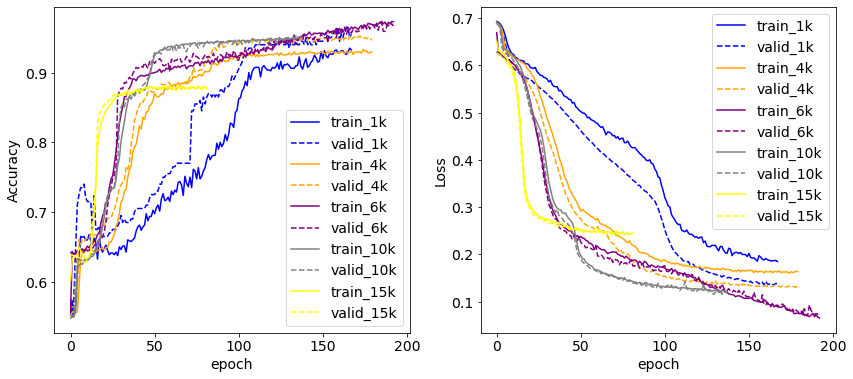

In [98]:
plot_fits(fits3,names,cols)
#Something crazy happened, not good

In [109]:
#randomuniform med intervall

init_al_1 = initializers.RandomUniform(minval=0., maxval=1.)
model = compile_model(L_dim,2,'relu',0.2,'adam',init_al_1)
model.save_weights('initial_weights_3.h5')

fits4 = train_fits(num_samples,perc,L_dim,nepochs,'initial_weights_3.h5')

800
[[-45.93578547 -41.82574978]
 [ 30.46491116  34.0129399 ]
 [ 33.38712581 -39.44704046]
 [ -2.88468631  40.05486534]
 [ -0.42700401 -33.12250571]
 [ 37.88563309  10.98100022]
 [ 41.1817203   -8.39774696]
 [ 29.26889958 -25.5550321 ]
 [-14.14181078 -32.54358206]
 [-13.46954563  10.63935464]]
Epoch 1/400
16/16 - 0s - loss: 0.7982 - accuracy: 0.6100 - val_loss: 0.5576 - val_accuracy: 0.6950 - 466ms/epoch - 29ms/step
Epoch 2/400
16/16 - 0s - loss: 0.6569 - accuracy: 0.6513 - val_loss: 0.5058 - val_accuracy: 0.7400 - 45ms/epoch - 3ms/step
Epoch 3/400
16/16 - 0s - loss: 0.6276 - accuracy: 0.6775 - val_loss: 0.4895 - val_accuracy: 0.7450 - 44ms/epoch - 3ms/step
Epoch 4/400
16/16 - 0s - loss: 0.5862 - accuracy: 0.7063 - val_loss: 0.4761 - val_accuracy: 0.7450 - 41ms/epoch - 3ms/step
Epoch 5/400
16/16 - 0s - loss: 0.5548 - accuracy: 0.7525 - val_loss: 0.4585 - val_accuracy: 0.7650 - 47ms/epoch - 3ms/step
Epoch 6/400
16/16 - 0s - loss: 0.5444 - accuracy: 0.7513 - val_loss: 0.4396 - val_accura

Epoch 65/400
16/16 - 0s - loss: 0.2739 - accuracy: 0.8888 - val_loss: 0.2356 - val_accuracy: 0.9100 - 45ms/epoch - 3ms/step
Epoch 66/400
16/16 - 0s - loss: 0.2684 - accuracy: 0.8925 - val_loss: 0.2375 - val_accuracy: 0.9050 - 48ms/epoch - 3ms/step
Epoch 67/400
16/16 - 0s - loss: 0.2733 - accuracy: 0.8900 - val_loss: 0.2354 - val_accuracy: 0.9050 - 45ms/epoch - 3ms/step
Epoch 68/400
16/16 - 0s - loss: 0.2662 - accuracy: 0.8963 - val_loss: 0.2374 - val_accuracy: 0.9050 - 45ms/epoch - 3ms/step
Epoch 69/400
16/16 - 0s - loss: 0.2752 - accuracy: 0.8913 - val_loss: 0.2340 - val_accuracy: 0.9100 - 45ms/epoch - 3ms/step
Epoch 70/400
16/16 - 0s - loss: 0.2723 - accuracy: 0.8875 - val_loss: 0.2339 - val_accuracy: 0.9100 - 46ms/epoch - 3ms/step
Epoch 71/400
16/16 - 0s - loss: 0.2697 - accuracy: 0.8963 - val_loss: 0.2355 - val_accuracy: 0.9050 - 45ms/epoch - 3ms/step
Epoch 72/400
16/16 - 0s - loss: 0.2702 - accuracy: 0.8875 - val_loss: 0.2320 - val_accuracy: 0.9100 - 46ms/epoch - 3ms/step
Epoch 73

Epoch 33/400
64/64 - 0s - loss: 0.2136 - accuracy: 0.9200 - val_loss: 0.2001 - val_accuracy: 0.9225 - 98ms/epoch - 2ms/step
Epoch 34/400
64/64 - 0s - loss: 0.2134 - accuracy: 0.9200 - val_loss: 0.1951 - val_accuracy: 0.9312 - 96ms/epoch - 1ms/step
Epoch 35/400
64/64 - 0s - loss: 0.2159 - accuracy: 0.9178 - val_loss: 0.1953 - val_accuracy: 0.9262 - 95ms/epoch - 1ms/step
Epoch 36/400
64/64 - 0s - loss: 0.2129 - accuracy: 0.9219 - val_loss: 0.1976 - val_accuracy: 0.9262 - 101ms/epoch - 2ms/step
Epoch 37/400
64/64 - 0s - loss: 0.2080 - accuracy: 0.9212 - val_loss: 0.1964 - val_accuracy: 0.9200 - 92ms/epoch - 1ms/step
Epoch 38/400
64/64 - 0s - loss: 0.2099 - accuracy: 0.9228 - val_loss: 0.1921 - val_accuracy: 0.9300 - 95ms/epoch - 1ms/step
Epoch 39/400
64/64 - 0s - loss: 0.2093 - accuracy: 0.9216 - val_loss: 0.1949 - val_accuracy: 0.9225 - 92ms/epoch - 1ms/step
Epoch 40/400
64/64 - 0s - loss: 0.2093 - accuracy: 0.9219 - val_loss: 0.1945 - val_accuracy: 0.9212 - 96ms/epoch - 1ms/step
Epoch 4

64/64 - 0s - loss: 0.1716 - accuracy: 0.9291 - val_loss: 0.1508 - val_accuracy: 0.9350 - 94ms/epoch - 1ms/step
Epoch 100/400
64/64 - 0s - loss: 0.1696 - accuracy: 0.9278 - val_loss: 0.1593 - val_accuracy: 0.9312 - 93ms/epoch - 1ms/step
Epoch 101/400
64/64 - 0s - loss: 0.1705 - accuracy: 0.9287 - val_loss: 0.1500 - val_accuracy: 0.9362 - 93ms/epoch - 1ms/step
Epoch 102/400
64/64 - 0s - loss: 0.1687 - accuracy: 0.9275 - val_loss: 0.1502 - val_accuracy: 0.9337 - 92ms/epoch - 1ms/step
Epoch 103/400
64/64 - 0s - loss: 0.1687 - accuracy: 0.9312 - val_loss: 0.1615 - val_accuracy: 0.9262 - 93ms/epoch - 1ms/step
Epoch 104/400
64/64 - 0s - loss: 0.1682 - accuracy: 0.9306 - val_loss: 0.1540 - val_accuracy: 0.9312 - 98ms/epoch - 2ms/step
Epoch 105/400
64/64 - 0s - loss: 0.1679 - accuracy: 0.9297 - val_loss: 0.1543 - val_accuracy: 0.9325 - 110ms/epoch - 2ms/step
Epoch 106/400
64/64 - 0s - loss: 0.1721 - accuracy: 0.9275 - val_loss: 0.1518 - val_accuracy: 0.9350 - 114ms/epoch - 2ms/step
Epoch 107/40

Epoch 40/400
96/96 - 0s - loss: 0.1932 - accuracy: 0.9148 - val_loss: 0.1829 - val_accuracy: 0.9250 - 127ms/epoch - 1ms/step
Epoch 41/400
96/96 - 0s - loss: 0.1925 - accuracy: 0.9154 - val_loss: 0.1871 - val_accuracy: 0.9200 - 133ms/epoch - 1ms/step
Epoch 42/400
96/96 - 0s - loss: 0.1892 - accuracy: 0.9175 - val_loss: 0.1823 - val_accuracy: 0.9242 - 128ms/epoch - 1ms/step
Epoch 43/400
96/96 - 0s - loss: 0.1879 - accuracy: 0.9144 - val_loss: 0.1811 - val_accuracy: 0.9267 - 128ms/epoch - 1ms/step
Epoch 44/400
96/96 - 0s - loss: 0.1868 - accuracy: 0.9175 - val_loss: 0.1825 - val_accuracy: 0.9242 - 128ms/epoch - 1ms/step
Epoch 45/400
96/96 - 0s - loss: 0.1856 - accuracy: 0.9177 - val_loss: 0.1804 - val_accuracy: 0.9283 - 129ms/epoch - 1ms/step
Epoch 46/400
96/96 - 0s - loss: 0.1857 - accuracy: 0.9167 - val_loss: 0.1811 - val_accuracy: 0.9242 - 128ms/epoch - 1ms/step
Epoch 47/400
96/96 - 0s - loss: 0.1839 - accuracy: 0.9185 - val_loss: 0.1810 - val_accuracy: 0.9242 - 126ms/epoch - 1ms/step


Epoch 30/400
160/160 - 0s - loss: 0.1815 - accuracy: 0.9216 - val_loss: 0.1888 - val_accuracy: 0.9220 - 192ms/epoch - 1ms/step
Epoch 31/400
160/160 - 0s - loss: 0.1819 - accuracy: 0.9197 - val_loss: 0.1795 - val_accuracy: 0.9275 - 192ms/epoch - 1ms/step
Epoch 32/400
160/160 - 0s - loss: 0.1834 - accuracy: 0.9195 - val_loss: 0.1787 - val_accuracy: 0.9265 - 190ms/epoch - 1ms/step
Epoch 33/400
160/160 - 0s - loss: 0.1814 - accuracy: 0.9212 - val_loss: 0.1785 - val_accuracy: 0.9280 - 192ms/epoch - 1ms/step
Epoch 34/400
160/160 - 0s - loss: 0.1795 - accuracy: 0.9218 - val_loss: 0.1791 - val_accuracy: 0.9235 - 192ms/epoch - 1ms/step
Epoch 35/400
160/160 - 0s - loss: 0.1762 - accuracy: 0.9233 - val_loss: 0.1773 - val_accuracy: 0.9235 - 190ms/epoch - 1ms/step
Epoch 36/400
160/160 - 0s - loss: 0.1768 - accuracy: 0.9222 - val_loss: 0.1768 - val_accuracy: 0.9240 - 195ms/epoch - 1ms/step
Epoch 37/400
160/160 - 0s - loss: 0.1746 - accuracy: 0.9234 - val_loss: 0.1788 - val_accuracy: 0.9245 - 189ms/e

Epoch 3/400
240/240 - 0s - loss: 0.3106 - accuracy: 0.8726 - val_loss: 0.2971 - val_accuracy: 0.8743 - 273ms/epoch - 1ms/step
Epoch 4/400
240/240 - 0s - loss: 0.2790 - accuracy: 0.8903 - val_loss: 0.2780 - val_accuracy: 0.8883 - 300ms/epoch - 1ms/step
Epoch 5/400
240/240 - 0s - loss: 0.2584 - accuracy: 0.9017 - val_loss: 0.2649 - val_accuracy: 0.8990 - 270ms/epoch - 1ms/step
Epoch 6/400
240/240 - 0s - loss: 0.2478 - accuracy: 0.9043 - val_loss: 0.2575 - val_accuracy: 0.9007 - 294ms/epoch - 1ms/step
Epoch 7/400
240/240 - 0s - loss: 0.2413 - accuracy: 0.9065 - val_loss: 0.2529 - val_accuracy: 0.9007 - 272ms/epoch - 1ms/step
Epoch 8/400
240/240 - 0s - loss: 0.2378 - accuracy: 0.9072 - val_loss: 0.2494 - val_accuracy: 0.9010 - 298ms/epoch - 1ms/step
Epoch 9/400
240/240 - 0s - loss: 0.2326 - accuracy: 0.9074 - val_loss: 0.2458 - val_accuracy: 0.9013 - 279ms/epoch - 1ms/step
Epoch 10/400
240/240 - 0s - loss: 0.2282 - accuracy: 0.9112 - val_loss: 0.2395 - val_accuracy: 0.9027 - 284ms/epoch - 

Epoch 68/400
240/240 - 0s - loss: 0.1692 - accuracy: 0.9245 - val_loss: 0.1867 - val_accuracy: 0.9117 - 336ms/epoch - 1ms/step
Epoch 69/400
240/240 - 0s - loss: 0.1686 - accuracy: 0.9249 - val_loss: 0.1842 - val_accuracy: 0.9133 - 360ms/epoch - 1ms/step
Epoch 70/400
240/240 - 0s - loss: 0.1667 - accuracy: 0.9255 - val_loss: 0.1851 - val_accuracy: 0.9143 - 392ms/epoch - 2ms/step


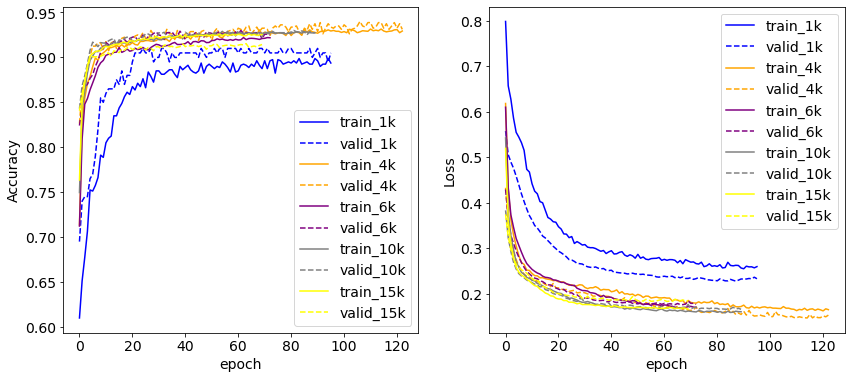

In [110]:
plot_fits(fits4,names,cols)
#Much faster convergence for all sample sizes, but less accuracy
#Should do an average over several runs

In [30]:
x_test,y_test = generate_data(4000)
x_train = x_test[0:N_train]
y_train = y_test[0:N_train]
x_valid = x_test[N_train:]
y_valid = y_test[N_train:]
x_train, x_valid = Rescale(x_train),Rescale(x_valid)

fits_uniform = []

In [111]:
for i in range(5):
    init_al_1 = initializers.RandomUniform(minval=0., maxval=1.)
    model = compile_model(L_dim,2,'relu',0.2,'adam',init_al_1)
    fit = model.fit(x_train,y_train,
               epochs = nepochs, batch_size = 50,
               validation_data =(x_valid,y_valid),
               verbose=2, callbacks = [es])
    fits_uniform.append(fit)

Epoch 1/400
240/240 - 1s - loss: 0.8837 - accuracy: 0.6285 - val_loss: 0.5874 - val_accuracy: 0.7417 - 890ms/epoch - 4ms/step
Epoch 2/400
240/240 - 0s - loss: 0.5791 - accuracy: 0.7465 - val_loss: 0.5008 - val_accuracy: 0.7827 - 281ms/epoch - 1ms/step
Epoch 3/400
240/240 - 0s - loss: 0.4657 - accuracy: 0.8173 - val_loss: 0.4037 - val_accuracy: 0.8483 - 273ms/epoch - 1ms/step
Epoch 4/400
240/240 - 0s - loss: 0.3713 - accuracy: 0.8698 - val_loss: 0.3245 - val_accuracy: 0.8913 - 272ms/epoch - 1ms/step
Epoch 5/400
240/240 - 0s - loss: 0.3039 - accuracy: 0.9028 - val_loss: 0.2759 - val_accuracy: 0.9063 - 280ms/epoch - 1ms/step
Epoch 6/400
240/240 - 0s - loss: 0.2679 - accuracy: 0.9161 - val_loss: 0.2537 - val_accuracy: 0.9187 - 281ms/epoch - 1ms/step
Epoch 7/400
240/240 - 0s - loss: 0.2511 - accuracy: 0.9194 - val_loss: 0.2417 - val_accuracy: 0.9227 - 280ms/epoch - 1ms/step
Epoch 8/400
240/240 - 0s - loss: 0.2417 - accuracy: 0.9203 - val_loss: 0.2355 - val_accuracy: 0.9233 - 280ms/epoch - 1

Epoch 66/400
240/240 - 0s - loss: 0.2115 - accuracy: 0.9262 - val_loss: 0.2085 - val_accuracy: 0.9283 - 298ms/epoch - 1ms/step
Epoch 67/400
240/240 - 0s - loss: 0.2094 - accuracy: 0.9280 - val_loss: 0.2085 - val_accuracy: 0.9273 - 301ms/epoch - 1ms/step
Epoch 68/400
240/240 - 0s - loss: 0.2097 - accuracy: 0.9279 - val_loss: 0.2109 - val_accuracy: 0.9270 - 316ms/epoch - 1ms/step
Epoch 69/400
240/240 - 0s - loss: 0.2103 - accuracy: 0.9273 - val_loss: 0.2076 - val_accuracy: 0.9290 - 270ms/epoch - 1ms/step
Epoch 70/400
240/240 - 0s - loss: 0.2094 - accuracy: 0.9277 - val_loss: 0.2109 - val_accuracy: 0.9273 - 313ms/epoch - 1ms/step
Epoch 71/400
240/240 - 0s - loss: 0.2098 - accuracy: 0.9277 - val_loss: 0.2102 - val_accuracy: 0.9283 - 275ms/epoch - 1ms/step
Epoch 72/400
240/240 - 0s - loss: 0.2103 - accuracy: 0.9278 - val_loss: 0.2105 - val_accuracy: 0.9260 - 285ms/epoch - 1ms/step
Epoch 73/400
240/240 - 0s - loss: 0.2104 - accuracy: 0.9273 - val_loss: 0.2098 - val_accuracy: 0.9267 - 272ms/e

Epoch 54/400
240/240 - 0s - loss: 0.4070 - accuracy: 0.7588 - val_loss: 0.4008 - val_accuracy: 0.7660 - 269ms/epoch - 1ms/step
Epoch 55/400
240/240 - 0s - loss: 0.4031 - accuracy: 0.7610 - val_loss: 0.3930 - val_accuracy: 0.7707 - 266ms/epoch - 1ms/step
Epoch 56/400
240/240 - 0s - loss: 0.4028 - accuracy: 0.7589 - val_loss: 0.3961 - val_accuracy: 0.7630 - 267ms/epoch - 1ms/step
Epoch 57/400
240/240 - 0s - loss: 0.4017 - accuracy: 0.7615 - val_loss: 0.3916 - val_accuracy: 0.7727 - 266ms/epoch - 1ms/step
Epoch 58/400
240/240 - 0s - loss: 0.3987 - accuracy: 0.7622 - val_loss: 0.3882 - val_accuracy: 0.7723 - 275ms/epoch - 1ms/step
Epoch 59/400
240/240 - 0s - loss: 0.3966 - accuracy: 0.7615 - val_loss: 0.3865 - val_accuracy: 0.7713 - 265ms/epoch - 1ms/step
Epoch 60/400
240/240 - 0s - loss: 0.3961 - accuracy: 0.7629 - val_loss: 0.3882 - val_accuracy: 0.7737 - 269ms/epoch - 1ms/step
Epoch 61/400
240/240 - 0s - loss: 0.3950 - accuracy: 0.7638 - val_loss: 0.3961 - val_accuracy: 0.7740 - 266ms/e

Epoch 119/400
240/240 - 0s - loss: 0.1284 - accuracy: 0.9463 - val_loss: 0.1069 - val_accuracy: 0.9567 - 273ms/epoch - 1ms/step
Epoch 120/400
240/240 - 0s - loss: 0.1225 - accuracy: 0.9503 - val_loss: 0.1126 - val_accuracy: 0.9540 - 265ms/epoch - 1ms/step
Epoch 121/400
240/240 - 0s - loss: 0.1208 - accuracy: 0.9520 - val_loss: 0.0955 - val_accuracy: 0.9633 - 264ms/epoch - 1ms/step
Epoch 122/400
240/240 - 0s - loss: 0.1255 - accuracy: 0.9507 - val_loss: 0.1186 - val_accuracy: 0.9543 - 272ms/epoch - 1ms/step
Epoch 123/400
240/240 - 0s - loss: 0.1159 - accuracy: 0.9553 - val_loss: 0.1000 - val_accuracy: 0.9590 - 270ms/epoch - 1ms/step
Epoch 124/400
240/240 - 0s - loss: 0.1135 - accuracy: 0.9557 - val_loss: 0.0910 - val_accuracy: 0.9633 - 263ms/epoch - 1ms/step
Epoch 125/400
240/240 - 0s - loss: 0.1099 - accuracy: 0.9592 - val_loss: 0.0971 - val_accuracy: 0.9633 - 277ms/epoch - 1ms/step
Epoch 126/400
240/240 - 0s - loss: 0.1054 - accuracy: 0.9593 - val_loss: 0.0875 - val_accuracy: 0.9707 -

Epoch 14/400
240/240 - 0s - loss: 0.2129 - accuracy: 0.9180 - val_loss: 0.2090 - val_accuracy: 0.9173 - 293ms/epoch - 1ms/step
Epoch 15/400
240/240 - 0s - loss: 0.2102 - accuracy: 0.9174 - val_loss: 0.2084 - val_accuracy: 0.9173 - 324ms/epoch - 1ms/step
Epoch 16/400
240/240 - 0s - loss: 0.2077 - accuracy: 0.9198 - val_loss: 0.2032 - val_accuracy: 0.9190 - 292ms/epoch - 1ms/step
Epoch 17/400
240/240 - 0s - loss: 0.2059 - accuracy: 0.9202 - val_loss: 0.1981 - val_accuracy: 0.9233 - 319ms/epoch - 1ms/step
Epoch 18/400
240/240 - 0s - loss: 0.2026 - accuracy: 0.9204 - val_loss: 0.1985 - val_accuracy: 0.9220 - 274ms/epoch - 1ms/step
Epoch 19/400
240/240 - 0s - loss: 0.2028 - accuracy: 0.9185 - val_loss: 0.1938 - val_accuracy: 0.9240 - 298ms/epoch - 1ms/step
Epoch 20/400
240/240 - 0s - loss: 0.1989 - accuracy: 0.9204 - val_loss: 0.1926 - val_accuracy: 0.9243 - 275ms/epoch - 1ms/step
Epoch 21/400
240/240 - 0s - loss: 0.1987 - accuracy: 0.9202 - val_loss: 0.1906 - val_accuracy: 0.9230 - 307ms/e

Epoch 79/400
240/240 - 0s - loss: 0.1655 - accuracy: 0.9264 - val_loss: 0.1601 - val_accuracy: 0.9267 - 294ms/epoch - 1ms/step
Epoch 80/400
240/240 - 0s - loss: 0.1651 - accuracy: 0.9261 - val_loss: 0.1640 - val_accuracy: 0.9250 - 280ms/epoch - 1ms/step
Epoch 81/400
240/240 - 0s - loss: 0.1651 - accuracy: 0.9256 - val_loss: 0.1714 - val_accuracy: 0.9227 - 334ms/epoch - 1ms/step
Epoch 82/400
240/240 - 0s - loss: 0.1649 - accuracy: 0.9263 - val_loss: 0.1602 - val_accuracy: 0.9280 - 312ms/epoch - 1ms/step
Epoch 83/400
240/240 - 0s - loss: 0.1650 - accuracy: 0.9270 - val_loss: 0.1613 - val_accuracy: 0.9243 - 294ms/epoch - 1ms/step
Epoch 84/400
240/240 - 0s - loss: 0.1649 - accuracy: 0.9269 - val_loss: 0.1597 - val_accuracy: 0.9273 - 266ms/epoch - 1ms/step
Epoch 85/400
240/240 - 0s - loss: 0.1641 - accuracy: 0.9267 - val_loss: 0.1596 - val_accuracy: 0.9263 - 266ms/epoch - 1ms/step
Epoch 1/400
240/240 - 1s - loss: 0.6833 - accuracy: 0.6076 - val_loss: 0.5897 - val_accuracy: 0.6800 - 677ms/ep

Epoch 15/400
240/240 - 0s - loss: 0.2625 - accuracy: 0.8921 - val_loss: 0.2292 - val_accuracy: 0.9040 - 278ms/epoch - 1ms/step
Epoch 16/400
240/240 - 0s - loss: 0.2564 - accuracy: 0.8935 - val_loss: 0.2285 - val_accuracy: 0.9040 - 320ms/epoch - 1ms/step
Epoch 17/400
240/240 - 0s - loss: 0.2508 - accuracy: 0.8964 - val_loss: 0.2197 - val_accuracy: 0.9013 - 291ms/epoch - 1ms/step
Epoch 18/400
240/240 - 0s - loss: 0.2482 - accuracy: 0.8952 - val_loss: 0.2175 - val_accuracy: 0.9037 - 276ms/epoch - 1ms/step
Epoch 19/400
240/240 - 0s - loss: 0.2440 - accuracy: 0.8988 - val_loss: 0.2174 - val_accuracy: 0.9063 - 296ms/epoch - 1ms/step
Epoch 20/400
240/240 - 0s - loss: 0.2385 - accuracy: 0.9000 - val_loss: 0.2083 - val_accuracy: 0.9087 - 318ms/epoch - 1ms/step
Epoch 21/400
240/240 - 0s - loss: 0.2389 - accuracy: 0.9000 - val_loss: 0.2072 - val_accuracy: 0.9103 - 288ms/epoch - 1ms/step
Epoch 22/400
240/240 - 0s - loss: 0.2305 - accuracy: 0.9022 - val_loss: 0.2008 - val_accuracy: 0.9117 - 289ms/e

Epoch 80/400
240/240 - 0s - loss: 0.1272 - accuracy: 0.9473 - val_loss: 0.0927 - val_accuracy: 0.9647 - 320ms/epoch - 1ms/step
Epoch 81/400
240/240 - 0s - loss: 0.1238 - accuracy: 0.9500 - val_loss: 0.0920 - val_accuracy: 0.9640 - 291ms/epoch - 1ms/step
Epoch 82/400
240/240 - 0s - loss: 0.1211 - accuracy: 0.9528 - val_loss: 0.0914 - val_accuracy: 0.9643 - 300ms/epoch - 1ms/step
Epoch 83/400
240/240 - 0s - loss: 0.1219 - accuracy: 0.9494 - val_loss: 0.0892 - val_accuracy: 0.9657 - 276ms/epoch - 1ms/step
Epoch 84/400
240/240 - 0s - loss: 0.1189 - accuracy: 0.9533 - val_loss: 0.0955 - val_accuracy: 0.9630 - 292ms/epoch - 1ms/step
Epoch 85/400
240/240 - 0s - loss: 0.1174 - accuracy: 0.9544 - val_loss: 0.0856 - val_accuracy: 0.9707 - 290ms/epoch - 1ms/step
Epoch 86/400
240/240 - 0s - loss: 0.1120 - accuracy: 0.9563 - val_loss: 0.0852 - val_accuracy: 0.9710 - 294ms/epoch - 1ms/step
Epoch 87/400
240/240 - 0s - loss: 0.1136 - accuracy: 0.9538 - val_loss: 0.0796 - val_accuracy: 0.9717 - 276ms/e

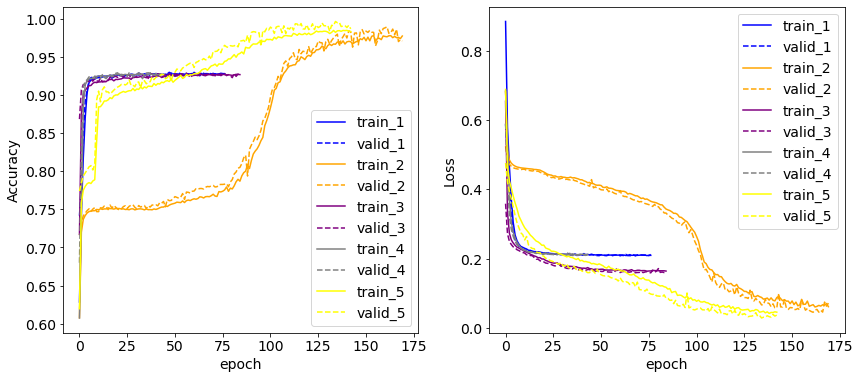

In [112]:
runs = ['1','2','3','4','5']
plot_fits(fits_uniform,runs,cols)

#### Kommentar
When using uniform distribution for initialization, the model seems to truncate around 0.93 in accuracy, while the cases that yields a very good accuracy, actually needs the same amount of epochs as before.

The method of averaging should be used in all cases of the initializer-testing, as the model is quite sensitive to its initial weights. (Ask christoffer about box-plot)

In [101]:
#GlorutUniform (appearantly glorut is the default in keras)
init_al_3 = initializers.GlorotUniform()
model = compile_model(L_dim,2,'relu',0.2,'adam',init_al_3)
model.save_weights('initial_weights_5.h5')

fits4 = train_fits(num_samples,perc,L_dim,nepochs,'initial_weights_5.h5')

800
[[-38.55585759  46.44917954]
 [-47.77168807 -49.80179012]
 [ 27.44090163 -42.25309181]
 [  7.39983783  -8.07804626]
 [-34.27174057 -20.52609255]
 [  7.11855981  18.33761484]
 [-42.3108041   21.8433038 ]
 [ 47.3557604   -1.66601686]
 [-40.57132357 -37.8606284 ]
 [ 29.95370309  31.39143666]]
Epoch 1/400
16/16 - 0s - loss: 0.6973 - accuracy: 0.4787 - val_loss: 0.6947 - val_accuracy: 0.4200 - 469ms/epoch - 29ms/step
Epoch 2/400
16/16 - 0s - loss: 0.6889 - accuracy: 0.5550 - val_loss: 0.6892 - val_accuracy: 0.5350 - 40ms/epoch - 3ms/step
Epoch 3/400
16/16 - 0s - loss: 0.6821 - accuracy: 0.5788 - val_loss: 0.6848 - val_accuracy: 0.5350 - 41ms/epoch - 3ms/step
Epoch 4/400
16/16 - 0s - loss: 0.6748 - accuracy: 0.5863 - val_loss: 0.6791 - val_accuracy: 0.5350 - 49ms/epoch - 3ms/step
Epoch 5/400
16/16 - 0s - loss: 0.6667 - accuracy: 0.5863 - val_loss: 0.6694 - val_accuracy: 0.5350 - 42ms/epoch - 3ms/step
Epoch 6/400
16/16 - 0s - loss: 0.6554 - accuracy: 0.5863 - val_loss: 0.6582 - val_accura

Epoch 65/400
16/16 - 0s - loss: 0.2411 - accuracy: 0.9175 - val_loss: 0.2423 - val_accuracy: 0.9250 - 51ms/epoch - 3ms/step
Epoch 66/400
16/16 - 0s - loss: 0.2347 - accuracy: 0.9100 - val_loss: 0.2375 - val_accuracy: 0.9250 - 46ms/epoch - 3ms/step
Epoch 67/400
16/16 - 0s - loss: 0.2331 - accuracy: 0.9250 - val_loss: 0.2333 - val_accuracy: 0.9300 - 43ms/epoch - 3ms/step
Epoch 68/400
16/16 - 0s - loss: 0.2391 - accuracy: 0.9112 - val_loss: 0.2336 - val_accuracy: 0.9300 - 38ms/epoch - 2ms/step
Epoch 69/400
16/16 - 0s - loss: 0.2270 - accuracy: 0.9100 - val_loss: 0.2316 - val_accuracy: 0.9250 - 43ms/epoch - 3ms/step
Epoch 70/400
16/16 - 0s - loss: 0.2436 - accuracy: 0.9062 - val_loss: 0.2291 - val_accuracy: 0.9300 - 40ms/epoch - 2ms/step
Epoch 71/400
16/16 - 0s - loss: 0.2245 - accuracy: 0.9237 - val_loss: 0.2286 - val_accuracy: 0.9300 - 43ms/epoch - 3ms/step
Epoch 72/400
16/16 - 0s - loss: 0.2336 - accuracy: 0.9237 - val_loss: 0.2249 - val_accuracy: 0.9400 - 49ms/epoch - 3ms/step
Epoch 73

Epoch 131/400
16/16 - 0s - loss: 0.1716 - accuracy: 0.9413 - val_loss: 0.1725 - val_accuracy: 0.9300 - 44ms/epoch - 3ms/step
Epoch 132/400
16/16 - 0s - loss: 0.1745 - accuracy: 0.9362 - val_loss: 0.1707 - val_accuracy: 0.9250 - 46ms/epoch - 3ms/step
Epoch 133/400
16/16 - 0s - loss: 0.1764 - accuracy: 0.9375 - val_loss: 0.1703 - val_accuracy: 0.9250 - 50ms/epoch - 3ms/step
Epoch 134/400
16/16 - 0s - loss: 0.1806 - accuracy: 0.9250 - val_loss: 0.1835 - val_accuracy: 0.9300 - 49ms/epoch - 3ms/step
Epoch 135/400
16/16 - 0s - loss: 0.1737 - accuracy: 0.9400 - val_loss: 0.1701 - val_accuracy: 0.9250 - 51ms/epoch - 3ms/step
Epoch 136/400
16/16 - 0s - loss: 0.1750 - accuracy: 0.9400 - val_loss: 0.1678 - val_accuracy: 0.9200 - 46ms/epoch - 3ms/step
Epoch 137/400
16/16 - 0s - loss: 0.1748 - accuracy: 0.9375 - val_loss: 0.1716 - val_accuracy: 0.9250 - 40ms/epoch - 3ms/step
Epoch 138/400
16/16 - 0s - loss: 0.1694 - accuracy: 0.9350 - val_loss: 0.1685 - val_accuracy: 0.9250 - 38ms/epoch - 2ms/step


Epoch 32/400
64/64 - 0s - loss: 0.2753 - accuracy: 0.8847 - val_loss: 0.2805 - val_accuracy: 0.8637 - 100ms/epoch - 2ms/step
Epoch 33/400
64/64 - 0s - loss: 0.2725 - accuracy: 0.8778 - val_loss: 0.2712 - val_accuracy: 0.8725 - 120ms/epoch - 2ms/step
Epoch 34/400
64/64 - 0s - loss: 0.2677 - accuracy: 0.8813 - val_loss: 0.2649 - val_accuracy: 0.8750 - 100ms/epoch - 2ms/step
Epoch 35/400
64/64 - 0s - loss: 0.2627 - accuracy: 0.8878 - val_loss: 0.2622 - val_accuracy: 0.8850 - 97ms/epoch - 2ms/step
Epoch 36/400
64/64 - 0s - loss: 0.2554 - accuracy: 0.8919 - val_loss: 0.2597 - val_accuracy: 0.8800 - 121ms/epoch - 2ms/step
Epoch 37/400
64/64 - 0s - loss: 0.2563 - accuracy: 0.8916 - val_loss: 0.2580 - val_accuracy: 0.8838 - 110ms/epoch - 2ms/step
Epoch 38/400
64/64 - 0s - loss: 0.2466 - accuracy: 0.8944 - val_loss: 0.2443 - val_accuracy: 0.8938 - 91ms/epoch - 1ms/step
Epoch 39/400
64/64 - 0s - loss: 0.2404 - accuracy: 0.9025 - val_loss: 0.2401 - val_accuracy: 0.9013 - 111ms/epoch - 2ms/step
Ep

Epoch 98/400
64/64 - 0s - loss: 0.1673 - accuracy: 0.9319 - val_loss: 0.1624 - val_accuracy: 0.9325 - 97ms/epoch - 2ms/step
Epoch 99/400
64/64 - 0s - loss: 0.1702 - accuracy: 0.9328 - val_loss: 0.1588 - val_accuracy: 0.9337 - 93ms/epoch - 1ms/step
Epoch 100/400
64/64 - 0s - loss: 0.1672 - accuracy: 0.9337 - val_loss: 0.1597 - val_accuracy: 0.9337 - 91ms/epoch - 1ms/step
Epoch 101/400
64/64 - 0s - loss: 0.1648 - accuracy: 0.9350 - val_loss: 0.1611 - val_accuracy: 0.9337 - 92ms/epoch - 1ms/step
Epoch 102/400
64/64 - 0s - loss: 0.1668 - accuracy: 0.9328 - val_loss: 0.1642 - val_accuracy: 0.9262 - 95ms/epoch - 1ms/step
Epoch 103/400
64/64 - 0s - loss: 0.1674 - accuracy: 0.9331 - val_loss: 0.1578 - val_accuracy: 0.9300 - 90ms/epoch - 1ms/step
Epoch 104/400
64/64 - 0s - loss: 0.1657 - accuracy: 0.9341 - val_loss: 0.1607 - val_accuracy: 0.9375 - 93ms/epoch - 1ms/step
Epoch 105/400
64/64 - 0s - loss: 0.1666 - accuracy: 0.9347 - val_loss: 0.1574 - val_accuracy: 0.9300 - 92ms/epoch - 1ms/step
Ep

Epoch 43/400
96/96 - 0s - loss: 0.1452 - accuracy: 0.9431 - val_loss: 0.1539 - val_accuracy: 0.9408 - 124ms/epoch - 1ms/step
Epoch 44/400
96/96 - 0s - loss: 0.1441 - accuracy: 0.9431 - val_loss: 0.1544 - val_accuracy: 0.9400 - 123ms/epoch - 1ms/step
Epoch 45/400
96/96 - 0s - loss: 0.1450 - accuracy: 0.9440 - val_loss: 0.1505 - val_accuracy: 0.9433 - 130ms/epoch - 1ms/step
Epoch 46/400
96/96 - 0s - loss: 0.1412 - accuracy: 0.9442 - val_loss: 0.1471 - val_accuracy: 0.9500 - 126ms/epoch - 1ms/step
Epoch 47/400
96/96 - 0s - loss: 0.1389 - accuracy: 0.9463 - val_loss: 0.1502 - val_accuracy: 0.9367 - 126ms/epoch - 1ms/step
Epoch 48/400
96/96 - 0s - loss: 0.1391 - accuracy: 0.9433 - val_loss: 0.1437 - val_accuracy: 0.9475 - 125ms/epoch - 1ms/step
Epoch 49/400
96/96 - 0s - loss: 0.1350 - accuracy: 0.9446 - val_loss: 0.1438 - val_accuracy: 0.9483 - 131ms/epoch - 1ms/step
Epoch 50/400
96/96 - 0s - loss: 0.1332 - accuracy: 0.9442 - val_loss: 0.1435 - val_accuracy: 0.9442 - 126ms/epoch - 1ms/step


Epoch 109/400
96/96 - 0s - loss: 0.0511 - accuracy: 0.9840 - val_loss: 0.0544 - val_accuracy: 0.9800 - 126ms/epoch - 1ms/step
Epoch 110/400
96/96 - 0s - loss: 0.0507 - accuracy: 0.9837 - val_loss: 0.0522 - val_accuracy: 0.9800 - 132ms/epoch - 1ms/step
Epoch 111/400
96/96 - 0s - loss: 0.0526 - accuracy: 0.9827 - val_loss: 0.0573 - val_accuracy: 0.9775 - 122ms/epoch - 1ms/step
Epoch 112/400
96/96 - 0s - loss: 0.0532 - accuracy: 0.9796 - val_loss: 0.0566 - val_accuracy: 0.9767 - 122ms/epoch - 1ms/step
Epoch 113/400
96/96 - 0s - loss: 0.0485 - accuracy: 0.9837 - val_loss: 0.0484 - val_accuracy: 0.9875 - 123ms/epoch - 1ms/step
Epoch 114/400
96/96 - 0s - loss: 0.0544 - accuracy: 0.9798 - val_loss: 0.0654 - val_accuracy: 0.9725 - 122ms/epoch - 1ms/step
Epoch 115/400
96/96 - 0s - loss: 0.0496 - accuracy: 0.9856 - val_loss: 0.0489 - val_accuracy: 0.9817 - 123ms/epoch - 1ms/step
Epoch 116/400
96/96 - 0s - loss: 0.0470 - accuracy: 0.9848 - val_loss: 0.0577 - val_accuracy: 0.9708 - 122ms/epoch - 1

Epoch 31/400
160/160 - 0s - loss: 0.1532 - accuracy: 0.9452 - val_loss: 0.1445 - val_accuracy: 0.9535 - 214ms/epoch - 1ms/step
Epoch 32/400
160/160 - 0s - loss: 0.1504 - accuracy: 0.9448 - val_loss: 0.1371 - val_accuracy: 0.9555 - 194ms/epoch - 1ms/step
Epoch 33/400
160/160 - 0s - loss: 0.1453 - accuracy: 0.9486 - val_loss: 0.1349 - val_accuracy: 0.9595 - 190ms/epoch - 1ms/step
Epoch 34/400
160/160 - 0s - loss: 0.1412 - accuracy: 0.9494 - val_loss: 0.1331 - val_accuracy: 0.9555 - 201ms/epoch - 1ms/step
Epoch 35/400
160/160 - 0s - loss: 0.1392 - accuracy: 0.9506 - val_loss: 0.1310 - val_accuracy: 0.9600 - 201ms/epoch - 1ms/step
Epoch 36/400
160/160 - 0s - loss: 0.1327 - accuracy: 0.9531 - val_loss: 0.1238 - val_accuracy: 0.9595 - 192ms/epoch - 1ms/step
Epoch 37/400
160/160 - 0s - loss: 0.1316 - accuracy: 0.9524 - val_loss: 0.1212 - val_accuracy: 0.9650 - 193ms/epoch - 1ms/step
Epoch 38/400
160/160 - 0s - loss: 0.1315 - accuracy: 0.9504 - val_loss: 0.1178 - val_accuracy: 0.9575 - 198ms/e

Epoch 96/400
160/160 - 0s - loss: 0.0476 - accuracy: 0.9830 - val_loss: 0.0422 - val_accuracy: 0.9820 - 193ms/epoch - 1ms/step
Epoch 97/400
160/160 - 0s - loss: 0.0496 - accuracy: 0.9808 - val_loss: 0.0431 - val_accuracy: 0.9830 - 199ms/epoch - 1ms/step
Epoch 98/400
160/160 - 0s - loss: 0.0507 - accuracy: 0.9809 - val_loss: 0.0391 - val_accuracy: 0.9865 - 189ms/epoch - 1ms/step
Epoch 99/400
160/160 - 0s - loss: 0.0460 - accuracy: 0.9851 - val_loss: 0.0442 - val_accuracy: 0.9825 - 252ms/epoch - 2ms/step
Epoch 100/400
160/160 - 0s - loss: 0.0454 - accuracy: 0.9849 - val_loss: 0.0420 - val_accuracy: 0.9860 - 210ms/epoch - 1ms/step
12000
[[-46.55145285  20.28545327]
 [-35.82199205 -39.34739224]
 [ -3.99906004 -28.35494749]
 [ 15.07366718  14.94305414]
 [ -5.03390815   5.9775984 ]
 [ 46.38931679 -20.69213187]
 [ 19.14122642  34.4795918 ]
 [ -0.61053752  19.10860062]
 [ 20.06456914  -1.39673956]
 [ 46.32031155 -17.82276579]]
Epoch 1/400
240/240 - 0s - loss: 0.6648 - accuracy: 0.5472 - val_lo

Epoch 59/400
240/240 - 0s - loss: 0.0495 - accuracy: 0.9829 - val_loss: 0.0347 - val_accuracy: 0.9913 - 274ms/epoch - 1ms/step
Epoch 60/400
240/240 - 0s - loss: 0.0465 - accuracy: 0.9845 - val_loss: 0.0451 - val_accuracy: 0.9820 - 277ms/epoch - 1ms/step
Epoch 61/400
240/240 - 0s - loss: 0.0493 - accuracy: 0.9819 - val_loss: 0.0323 - val_accuracy: 0.9930 - 283ms/epoch - 1ms/step
Epoch 62/400
240/240 - 0s - loss: 0.0443 - accuracy: 0.9836 - val_loss: 0.0366 - val_accuracy: 0.9850 - 280ms/epoch - 1ms/step
Epoch 63/400
240/240 - 0s - loss: 0.0437 - accuracy: 0.9846 - val_loss: 0.0329 - val_accuracy: 0.9890 - 278ms/epoch - 1ms/step
Epoch 64/400
240/240 - 0s - loss: 0.0429 - accuracy: 0.9839 - val_loss: 0.0299 - val_accuracy: 0.9927 - 271ms/epoch - 1ms/step
Epoch 65/400
240/240 - 0s - loss: 0.0409 - accuracy: 0.9847 - val_loss: 0.0268 - val_accuracy: 0.9977 - 265ms/epoch - 1ms/step
Epoch 66/400
240/240 - 0s - loss: 0.0409 - accuracy: 0.9858 - val_loss: 0.0269 - val_accuracy: 0.9933 - 287ms/e

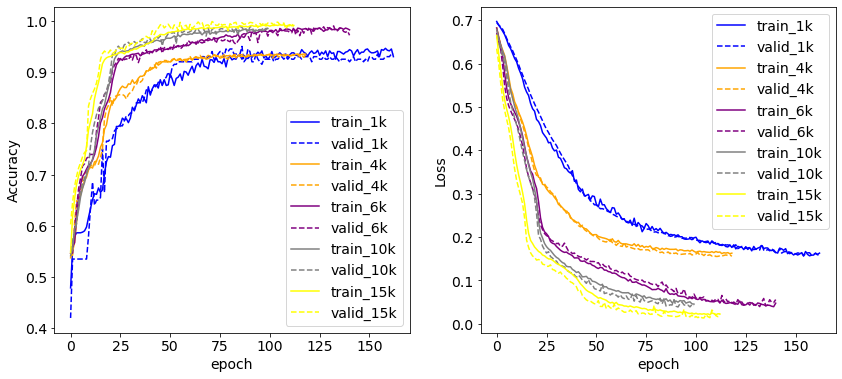

In [103]:
plot_fits(fits4,names,cols)

In [114]:
fits_glorut_uniform = []

for i in range(5):
    init_al_s = initializers.GlorotUniform()
    model = compile_model(L_dim,2,'relu',0.2,'adam',init_al_s)
    fit = model.fit(x_train,y_train,
               epochs = nepochs, batch_size = 50,
               validation_data =(x_valid,y_valid),
               verbose=2, callbacks = [es])
    fits_glorut_uniform.append(fit)

Epoch 1/400
240/240 - 1s - loss: 0.6489 - accuracy: 0.6225 - val_loss: 0.6113 - val_accuracy: 0.6930 - 699ms/epoch - 3ms/step
Epoch 2/400
240/240 - 0s - loss: 0.5037 - accuracy: 0.7800 - val_loss: 0.3675 - val_accuracy: 0.8847 - 277ms/epoch - 1ms/step
Epoch 3/400
240/240 - 0s - loss: 0.3265 - accuracy: 0.8842 - val_loss: 0.2825 - val_accuracy: 0.9170 - 271ms/epoch - 1ms/step
Epoch 4/400
240/240 - 0s - loss: 0.2726 - accuracy: 0.9072 - val_loss: 0.2481 - val_accuracy: 0.9210 - 269ms/epoch - 1ms/step
Epoch 5/400
240/240 - 0s - loss: 0.2468 - accuracy: 0.9133 - val_loss: 0.2348 - val_accuracy: 0.9117 - 272ms/epoch - 1ms/step
Epoch 6/400
240/240 - 0s - loss: 0.2318 - accuracy: 0.9147 - val_loss: 0.2132 - val_accuracy: 0.9193 - 276ms/epoch - 1ms/step
Epoch 7/400
240/240 - 0s - loss: 0.2182 - accuracy: 0.9128 - val_loss: 0.2149 - val_accuracy: 0.9093 - 270ms/epoch - 1ms/step
Epoch 8/400
240/240 - 0s - loss: 0.2082 - accuracy: 0.9138 - val_loss: 0.1939 - val_accuracy: 0.9183 - 273ms/epoch - 1

Epoch 1/400
240/240 - 1s - loss: 0.6243 - accuracy: 0.5982 - val_loss: 0.5338 - val_accuracy: 0.6977 - 734ms/epoch - 3ms/step
Epoch 2/400
240/240 - 0s - loss: 0.4896 - accuracy: 0.7324 - val_loss: 0.4286 - val_accuracy: 0.8187 - 271ms/epoch - 1ms/step
Epoch 3/400
240/240 - 0s - loss: 0.3962 - accuracy: 0.8583 - val_loss: 0.3390 - val_accuracy: 0.8990 - 292ms/epoch - 1ms/step
Epoch 4/400
240/240 - 0s - loss: 0.3249 - accuracy: 0.8981 - val_loss: 0.2791 - val_accuracy: 0.9117 - 264ms/epoch - 1ms/step
Epoch 5/400
240/240 - 0s - loss: 0.2768 - accuracy: 0.9053 - val_loss: 0.2425 - val_accuracy: 0.9197 - 270ms/epoch - 1ms/step
Epoch 6/400
240/240 - 0s - loss: 0.2468 - accuracy: 0.9105 - val_loss: 0.2174 - val_accuracy: 0.9180 - 258ms/epoch - 1ms/step
Epoch 7/400
240/240 - 0s - loss: 0.2262 - accuracy: 0.9181 - val_loss: 0.2026 - val_accuracy: 0.9297 - 264ms/epoch - 1ms/step
Epoch 8/400
240/240 - 0s - loss: 0.2083 - accuracy: 0.9245 - val_loss: 0.1870 - val_accuracy: 0.9423 - 268ms/epoch - 1

Epoch 66/400
240/240 - 0s - loss: 0.0569 - accuracy: 0.9780 - val_loss: 0.0383 - val_accuracy: 0.9923 - 279ms/epoch - 1ms/step
Epoch 67/400
240/240 - 0s - loss: 0.0544 - accuracy: 0.9810 - val_loss: 0.0811 - val_accuracy: 0.9730 - 304ms/epoch - 1ms/step
Epoch 68/400
240/240 - 0s - loss: 0.0535 - accuracy: 0.9821 - val_loss: 0.0408 - val_accuracy: 0.9887 - 312ms/epoch - 1ms/step
Epoch 69/400
240/240 - 0s - loss: 0.0544 - accuracy: 0.9792 - val_loss: 0.0332 - val_accuracy: 0.9953 - 309ms/epoch - 1ms/step
Epoch 70/400
240/240 - 0s - loss: 0.0534 - accuracy: 0.9812 - val_loss: 0.0437 - val_accuracy: 0.9873 - 275ms/epoch - 1ms/step
Epoch 71/400
240/240 - 0s - loss: 0.0532 - accuracy: 0.9811 - val_loss: 0.0352 - val_accuracy: 0.9893 - 301ms/epoch - 1ms/step
Epoch 72/400
240/240 - 0s - loss: 0.0489 - accuracy: 0.9833 - val_loss: 0.0316 - val_accuracy: 0.9953 - 269ms/epoch - 1ms/step
Epoch 73/400
240/240 - 0s - loss: 0.0504 - accuracy: 0.9822 - val_loss: 0.0308 - val_accuracy: 0.9953 - 280ms/e

Epoch 41/400
240/240 - 0s - loss: 0.1664 - accuracy: 0.9241 - val_loss: 0.1647 - val_accuracy: 0.9217 - 263ms/epoch - 1ms/step
Epoch 42/400
240/240 - 0s - loss: 0.1647 - accuracy: 0.9244 - val_loss: 0.1604 - val_accuracy: 0.9253 - 281ms/epoch - 1ms/step
Epoch 43/400
240/240 - 0s - loss: 0.1619 - accuracy: 0.9252 - val_loss: 0.1608 - val_accuracy: 0.9223 - 262ms/epoch - 1ms/step
Epoch 44/400
240/240 - 0s - loss: 0.1632 - accuracy: 0.9245 - val_loss: 0.1568 - val_accuracy: 0.9277 - 268ms/epoch - 1ms/step
Epoch 45/400
240/240 - 0s - loss: 0.1594 - accuracy: 0.9265 - val_loss: 0.1557 - val_accuracy: 0.9287 - 262ms/epoch - 1ms/step
Epoch 46/400
240/240 - 0s - loss: 0.1605 - accuracy: 0.9255 - val_loss: 0.1569 - val_accuracy: 0.9273 - 264ms/epoch - 1ms/step
Epoch 47/400
240/240 - 0s - loss: 0.1597 - accuracy: 0.9249 - val_loss: 0.1520 - val_accuracy: 0.9283 - 271ms/epoch - 1ms/step
Epoch 48/400
240/240 - 0s - loss: 0.1592 - accuracy: 0.9246 - val_loss: 0.1525 - val_accuracy: 0.9277 - 264ms/e

Epoch 106/400
240/240 - 0s - loss: 0.0740 - accuracy: 0.9718 - val_loss: 0.0651 - val_accuracy: 0.9743 - 298ms/epoch - 1ms/step
Epoch 107/400
240/240 - 0s - loss: 0.0722 - accuracy: 0.9719 - val_loss: 0.0665 - val_accuracy: 0.9803 - 276ms/epoch - 1ms/step
Epoch 108/400
240/240 - 0s - loss: 0.0726 - accuracy: 0.9729 - val_loss: 0.0664 - val_accuracy: 0.9703 - 278ms/epoch - 1ms/step
Epoch 109/400
240/240 - 0s - loss: 0.0755 - accuracy: 0.9707 - val_loss: 0.0519 - val_accuracy: 0.9873 - 279ms/epoch - 1ms/step
Epoch 110/400
240/240 - 0s - loss: 0.0700 - accuracy: 0.9720 - val_loss: 0.0546 - val_accuracy: 0.9847 - 275ms/epoch - 1ms/step
Epoch 111/400
240/240 - 0s - loss: 0.0673 - accuracy: 0.9743 - val_loss: 0.0600 - val_accuracy: 0.9793 - 266ms/epoch - 1ms/step
Epoch 112/400
240/240 - 0s - loss: 0.0645 - accuracy: 0.9758 - val_loss: 0.0497 - val_accuracy: 0.9877 - 265ms/epoch - 1ms/step
Epoch 113/400
240/240 - 0s - loss: 0.0657 - accuracy: 0.9750 - val_loss: 0.0512 - val_accuracy: 0.9850 -

Epoch 15/400
240/240 - 0s - loss: 0.1830 - accuracy: 0.9200 - val_loss: 0.1697 - val_accuracy: 0.9250 - 288ms/epoch - 1ms/step
Epoch 16/400
240/240 - 0s - loss: 0.1789 - accuracy: 0.9214 - val_loss: 0.1703 - val_accuracy: 0.9243 - 368ms/epoch - 2ms/step
Epoch 17/400
240/240 - 0s - loss: 0.1782 - accuracy: 0.9202 - val_loss: 0.1676 - val_accuracy: 0.9243 - 344ms/epoch - 1ms/step
Epoch 18/400
240/240 - 0s - loss: 0.1770 - accuracy: 0.9212 - val_loss: 0.1683 - val_accuracy: 0.9240 - 322ms/epoch - 1ms/step
Epoch 19/400
240/240 - 0s - loss: 0.1768 - accuracy: 0.9215 - val_loss: 0.1672 - val_accuracy: 0.9250 - 291ms/epoch - 1ms/step
Epoch 20/400
240/240 - 0s - loss: 0.1757 - accuracy: 0.9218 - val_loss: 0.1657 - val_accuracy: 0.9263 - 290ms/epoch - 1ms/step
Epoch 21/400
240/240 - 0s - loss: 0.1741 - accuracy: 0.9216 - val_loss: 0.1643 - val_accuracy: 0.9270 - 286ms/epoch - 1ms/step
Epoch 22/400
240/240 - 0s - loss: 0.1736 - accuracy: 0.9228 - val_loss: 0.1652 - val_accuracy: 0.9237 - 296ms/e

Epoch 16/400
240/240 - 0s - loss: 0.1247 - accuracy: 0.9485 - val_loss: 0.1033 - val_accuracy: 0.9627 - 275ms/epoch - 1ms/step
Epoch 17/400
240/240 - 0s - loss: 0.1166 - accuracy: 0.9588 - val_loss: 0.0954 - val_accuracy: 0.9750 - 284ms/epoch - 1ms/step
Epoch 18/400
240/240 - 0s - loss: 0.1064 - accuracy: 0.9663 - val_loss: 0.0950 - val_accuracy: 0.9713 - 280ms/epoch - 1ms/step
Epoch 19/400
240/240 - 0s - loss: 0.0965 - accuracy: 0.9735 - val_loss: 0.0812 - val_accuracy: 0.9757 - 351ms/epoch - 1ms/step
Epoch 20/400
240/240 - 0s - loss: 0.0932 - accuracy: 0.9741 - val_loss: 0.0830 - val_accuracy: 0.9680 - 299ms/epoch - 1ms/step
Epoch 21/400
240/240 - 0s - loss: 0.0877 - accuracy: 0.9770 - val_loss: 0.0700 - val_accuracy: 0.9850 - 287ms/epoch - 1ms/step
Epoch 22/400
240/240 - 0s - loss: 0.0844 - accuracy: 0.9784 - val_loss: 0.0675 - val_accuracy: 0.9883 - 295ms/epoch - 1ms/step
Epoch 23/400
240/240 - 0s - loss: 0.0755 - accuracy: 0.9814 - val_loss: 0.0595 - val_accuracy: 0.9927 - 334ms/e

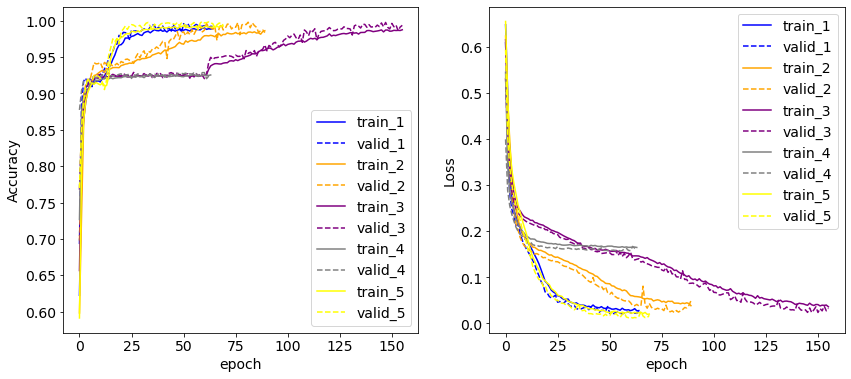

In [115]:
plot_fits(fits_glorut_uniform,runs,cols)

This looks like the best option so far, and is probably the default used in the model as the convergence is comparable to the first run we did.

In [128]:
init_al_g = initializers.GlorotUniform()
fits_avg_glorot = avg_test(4000,10,0.8,2,400,init_al_g)

Epoch 1/400
240/240 - 1s - loss: 0.6382 - accuracy: 0.5980 - val_loss: 0.5567 - val_accuracy: 0.7327 - 700ms/epoch - 3ms/step
Epoch 2/400
240/240 - 0s - loss: 0.4673 - accuracy: 0.7754 - val_loss: 0.3873 - val_accuracy: 0.8420 - 286ms/epoch - 1ms/step
Epoch 3/400
240/240 - 0s - loss: 0.3639 - accuracy: 0.8427 - val_loss: 0.3240 - val_accuracy: 0.8660 - 286ms/epoch - 1ms/step
Epoch 4/400
240/240 - 0s - loss: 0.3149 - accuracy: 0.8687 - val_loss: 0.2867 - val_accuracy: 0.8827 - 274ms/epoch - 1ms/step
Epoch 5/400
240/240 - 0s - loss: 0.2808 - accuracy: 0.8854 - val_loss: 0.2636 - val_accuracy: 0.8870 - 273ms/epoch - 1ms/step
Epoch 6/400
240/240 - 0s - loss: 0.2576 - accuracy: 0.8936 - val_loss: 0.2418 - val_accuracy: 0.8977 - 273ms/epoch - 1ms/step
Epoch 7/400
240/240 - 0s - loss: 0.2393 - accuracy: 0.8969 - val_loss: 0.2252 - val_accuracy: 0.8977 - 271ms/epoch - 1ms/step
Epoch 8/400
240/240 - 0s - loss: 0.2235 - accuracy: 0.9028 - val_loss: 0.2119 - val_accuracy: 0.9047 - 273ms/epoch - 1

Epoch 66/400
240/240 - 0s - loss: 0.0272 - accuracy: 0.9884 - val_loss: 0.0461 - val_accuracy: 0.9793 - 270ms/epoch - 1ms/step
Epoch 1/400
240/240 - 1s - loss: 0.5842 - accuracy: 0.6309 - val_loss: 0.5119 - val_accuracy: 0.7080 - 790ms/epoch - 3ms/step
Epoch 2/400
240/240 - 0s - loss: 0.4972 - accuracy: 0.7258 - val_loss: 0.4772 - val_accuracy: 0.7320 - 294ms/epoch - 1ms/step
Epoch 3/400
240/240 - 0s - loss: 0.4785 - accuracy: 0.7390 - val_loss: 0.4669 - val_accuracy: 0.7410 - 261ms/epoch - 1ms/step
Epoch 4/400
240/240 - 0s - loss: 0.4702 - accuracy: 0.7440 - val_loss: 0.4635 - val_accuracy: 0.7397 - 265ms/epoch - 1ms/step
Epoch 5/400
240/240 - 0s - loss: 0.4661 - accuracy: 0.7458 - val_loss: 0.4573 - val_accuracy: 0.7477 - 263ms/epoch - 1ms/step
Epoch 6/400
240/240 - 0s - loss: 0.4607 - accuracy: 0.7474 - val_loss: 0.4507 - val_accuracy: 0.7487 - 282ms/epoch - 1ms/step
Epoch 7/400
240/240 - 0s - loss: 0.4530 - accuracy: 0.7476 - val_loss: 0.4402 - val_accuracy: 0.7503 - 265ms/epoch - 

Epoch 65/400
240/240 - 0s - loss: 0.2770 - accuracy: 0.8898 - val_loss: 0.2642 - val_accuracy: 0.9057 - 280ms/epoch - 1ms/step
Epoch 66/400
240/240 - 0s - loss: 0.2626 - accuracy: 0.9012 - val_loss: 0.2458 - val_accuracy: 0.9160 - 273ms/epoch - 1ms/step
Epoch 67/400
240/240 - 0s - loss: 0.2437 - accuracy: 0.9150 - val_loss: 0.2207 - val_accuracy: 0.9350 - 267ms/epoch - 1ms/step
Epoch 68/400
240/240 - 0s - loss: 0.2268 - accuracy: 0.9260 - val_loss: 0.2064 - val_accuracy: 0.9310 - 261ms/epoch - 1ms/step
Epoch 69/400
240/240 - 0s - loss: 0.2133 - accuracy: 0.9299 - val_loss: 0.1942 - val_accuracy: 0.9417 - 269ms/epoch - 1ms/step
Epoch 70/400
240/240 - 0s - loss: 0.2016 - accuracy: 0.9362 - val_loss: 0.1862 - val_accuracy: 0.9520 - 263ms/epoch - 1ms/step
Epoch 71/400
240/240 - 0s - loss: 0.1917 - accuracy: 0.9401 - val_loss: 0.1803 - val_accuracy: 0.9423 - 329ms/epoch - 1ms/step
Epoch 72/400
240/240 - 0s - loss: 0.1863 - accuracy: 0.9403 - val_loss: 0.1669 - val_accuracy: 0.9510 - 324ms/e

Epoch 130/400
240/240 - 0s - loss: 0.0789 - accuracy: 0.9709 - val_loss: 0.0505 - val_accuracy: 0.9860 - 300ms/epoch - 1ms/step
Epoch 131/400
240/240 - 0s - loss: 0.0741 - accuracy: 0.9730 - val_loss: 0.0491 - val_accuracy: 0.9873 - 331ms/epoch - 1ms/step
Epoch 132/400
240/240 - 0s - loss: 0.0792 - accuracy: 0.9705 - val_loss: 0.0576 - val_accuracy: 0.9787 - 339ms/epoch - 1ms/step
Epoch 133/400
240/240 - 0s - loss: 0.0708 - accuracy: 0.9714 - val_loss: 0.0548 - val_accuracy: 0.9813 - 369ms/epoch - 2ms/step
Epoch 134/400
240/240 - 0s - loss: 0.0861 - accuracy: 0.9676 - val_loss: 0.0746 - val_accuracy: 0.9707 - 330ms/epoch - 1ms/step
Epoch 135/400
240/240 - 0s - loss: 0.0759 - accuracy: 0.9707 - val_loss: 0.0595 - val_accuracy: 0.9800 - 335ms/epoch - 1ms/step
Epoch 136/400
240/240 - 0s - loss: 0.0741 - accuracy: 0.9712 - val_loss: 0.0755 - val_accuracy: 0.9727 - 335ms/epoch - 1ms/step
Epoch 137/400
240/240 - 0s - loss: 0.0699 - accuracy: 0.9734 - val_loss: 0.0602 - val_accuracy: 0.9810 -

Epoch 56/400
240/240 - 0s - loss: 0.0861 - accuracy: 0.9670 - val_loss: 0.0815 - val_accuracy: 0.9767 - 351ms/epoch - 1ms/step
Epoch 57/400
240/240 - 0s - loss: 0.0835 - accuracy: 0.9683 - val_loss: 0.0611 - val_accuracy: 0.9870 - 298ms/epoch - 1ms/step
Epoch 58/400
240/240 - 0s - loss: 0.0811 - accuracy: 0.9711 - val_loss: 0.0638 - val_accuracy: 0.9807 - 292ms/epoch - 1ms/step
Epoch 59/400
240/240 - 0s - loss: 0.0818 - accuracy: 0.9691 - val_loss: 0.0729 - val_accuracy: 0.9793 - 282ms/epoch - 1ms/step
Epoch 60/400
240/240 - 0s - loss: 0.0821 - accuracy: 0.9702 - val_loss: 0.0574 - val_accuracy: 0.9850 - 292ms/epoch - 1ms/step
Epoch 61/400
240/240 - 0s - loss: 0.0771 - accuracy: 0.9720 - val_loss: 0.0563 - val_accuracy: 0.9863 - 300ms/epoch - 1ms/step
Epoch 62/400
240/240 - 0s - loss: 0.0744 - accuracy: 0.9732 - val_loss: 0.0536 - val_accuracy: 0.9930 - 280ms/epoch - 1ms/step
Epoch 63/400
240/240 - 0s - loss: 0.0742 - accuracy: 0.9738 - val_loss: 0.0625 - val_accuracy: 0.9793 - 265ms/e

Epoch 121/400
240/240 - 0s - loss: 0.0428 - accuracy: 0.9840 - val_loss: 0.0357 - val_accuracy: 0.9880 - 327ms/epoch - 1ms/step
Epoch 122/400
240/240 - 0s - loss: 0.0437 - accuracy: 0.9832 - val_loss: 0.0245 - val_accuracy: 0.9907 - 318ms/epoch - 1ms/step
Epoch 123/400
240/240 - 0s - loss: 0.0393 - accuracy: 0.9851 - val_loss: 0.0211 - val_accuracy: 0.9940 - 289ms/epoch - 1ms/step
Epoch 124/400
240/240 - 0s - loss: 0.0413 - accuracy: 0.9837 - val_loss: 0.0218 - val_accuracy: 0.9953 - 280ms/epoch - 1ms/step
Epoch 125/400
240/240 - 0s - loss: 0.0382 - accuracy: 0.9847 - val_loss: 0.0392 - val_accuracy: 0.9790 - 284ms/epoch - 1ms/step
Epoch 126/400
240/240 - 0s - loss: 0.0456 - accuracy: 0.9829 - val_loss: 0.0223 - val_accuracy: 0.9933 - 277ms/epoch - 1ms/step
Epoch 127/400
240/240 - 0s - loss: 0.0392 - accuracy: 0.9845 - val_loss: 0.0285 - val_accuracy: 0.9870 - 281ms/epoch - 1ms/step
Epoch 128/400
240/240 - 0s - loss: 0.0383 - accuracy: 0.9863 - val_loss: 0.0280 - val_accuracy: 0.9917 -

Epoch 58/400
240/240 - 0s - loss: 0.0916 - accuracy: 0.9635 - val_loss: 0.0782 - val_accuracy: 0.9677 - 269ms/epoch - 1ms/step
Epoch 59/400
240/240 - 0s - loss: 0.0918 - accuracy: 0.9643 - val_loss: 0.0880 - val_accuracy: 0.9597 - 277ms/epoch - 1ms/step
Epoch 60/400
240/240 - 0s - loss: 0.0880 - accuracy: 0.9640 - val_loss: 0.0758 - val_accuracy: 0.9703 - 286ms/epoch - 1ms/step
Epoch 61/400
240/240 - 0s - loss: 0.0863 - accuracy: 0.9645 - val_loss: 0.0861 - val_accuracy: 0.9613 - 278ms/epoch - 1ms/step
Epoch 62/400
240/240 - 0s - loss: 0.0868 - accuracy: 0.9650 - val_loss: 0.0757 - val_accuracy: 0.9683 - 330ms/epoch - 1ms/step
Epoch 63/400
240/240 - 0s - loss: 0.0841 - accuracy: 0.9653 - val_loss: 0.0902 - val_accuracy: 0.9610 - 321ms/epoch - 1ms/step
Epoch 64/400
240/240 - 0s - loss: 0.0847 - accuracy: 0.9660 - val_loss: 0.0781 - val_accuracy: 0.9660 - 295ms/epoch - 1ms/step
Epoch 65/400
240/240 - 0s - loss: 0.0804 - accuracy: 0.9684 - val_loss: 0.0766 - val_accuracy: 0.9697 - 275ms/e

Epoch 123/400
240/240 - 0s - loss: 0.0340 - accuracy: 0.9863 - val_loss: 0.0209 - val_accuracy: 0.9917 - 395ms/epoch - 2ms/step
Epoch 124/400
240/240 - 0s - loss: 0.0352 - accuracy: 0.9872 - val_loss: 0.0246 - val_accuracy: 0.9920 - 362ms/epoch - 2ms/step
Epoch 125/400
240/240 - 0s - loss: 0.0375 - accuracy: 0.9868 - val_loss: 0.0251 - val_accuracy: 0.9907 - 349ms/epoch - 1ms/step
Epoch 126/400
240/240 - 0s - loss: 0.0376 - accuracy: 0.9853 - val_loss: 0.0347 - val_accuracy: 0.9867 - 322ms/epoch - 1ms/step
Epoch 127/400
240/240 - 0s - loss: 0.0317 - accuracy: 0.9886 - val_loss: 0.0154 - val_accuracy: 0.9980 - 472ms/epoch - 2ms/step
Epoch 128/400
240/240 - 0s - loss: 0.0311 - accuracy: 0.9892 - val_loss: 0.0170 - val_accuracy: 0.9970 - 374ms/epoch - 2ms/step
Epoch 129/400
240/240 - 0s - loss: 0.0357 - accuracy: 0.9871 - val_loss: 0.0181 - val_accuracy: 0.9973 - 387ms/epoch - 2ms/step
Epoch 130/400
240/240 - 0s - loss: 0.0326 - accuracy: 0.9887 - val_loss: 0.0173 - val_accuracy: 0.9957 -

Epoch 48/400
240/240 - 0s - loss: 0.2110 - accuracy: 0.9269 - val_loss: 0.2095 - val_accuracy: 0.9267 - 407ms/epoch - 2ms/step
Epoch 49/400
240/240 - 0s - loss: 0.2123 - accuracy: 0.9273 - val_loss: 0.2125 - val_accuracy: 0.9233 - 387ms/epoch - 2ms/step
Epoch 50/400
240/240 - 0s - loss: 0.2109 - accuracy: 0.9266 - val_loss: 0.2094 - val_accuracy: 0.9260 - 373ms/epoch - 2ms/step
Epoch 51/400
240/240 - 0s - loss: 0.2115 - accuracy: 0.9263 - val_loss: 0.2089 - val_accuracy: 0.9250 - 361ms/epoch - 2ms/step
Epoch 1/400
240/240 - 1s - loss: 0.6545 - accuracy: 0.6342 - val_loss: 0.5972 - val_accuracy: 0.7093 - 845ms/epoch - 4ms/step
Epoch 2/400
240/240 - 0s - loss: 0.5324 - accuracy: 0.7429 - val_loss: 0.4271 - val_accuracy: 0.8177 - 335ms/epoch - 1ms/step
Epoch 3/400
240/240 - 0s - loss: 0.3621 - accuracy: 0.8480 - val_loss: 0.2697 - val_accuracy: 0.8987 - 328ms/epoch - 1ms/step
Epoch 4/400
240/240 - 0s - loss: 0.2534 - accuracy: 0.9011 - val_loss: 0.1996 - val_accuracy: 0.9383 - 371ms/epoch

Epoch 62/400
240/240 - 0s - loss: 0.0238 - accuracy: 0.9914 - val_loss: 0.0169 - val_accuracy: 0.9960 - 284ms/epoch - 1ms/step
Epoch 63/400
240/240 - 0s - loss: 0.0188 - accuracy: 0.9933 - val_loss: 0.0171 - val_accuracy: 0.9933 - 270ms/epoch - 1ms/step
Epoch 64/400
240/240 - 0s - loss: 0.0214 - accuracy: 0.9914 - val_loss: 0.0127 - val_accuracy: 0.9967 - 269ms/epoch - 1ms/step
Epoch 65/400
240/240 - 0s - loss: 0.0230 - accuracy: 0.9908 - val_loss: 0.0160 - val_accuracy: 0.9940 - 265ms/epoch - 1ms/step
Epoch 66/400
240/240 - 0s - loss: 0.0201 - accuracy: 0.9923 - val_loss: 0.0109 - val_accuracy: 0.9973 - 273ms/epoch - 1ms/step
Epoch 67/400
240/240 - 0s - loss: 0.0187 - accuracy: 0.9934 - val_loss: 0.0156 - val_accuracy: 0.9947 - 262ms/epoch - 1ms/step
Epoch 68/400
240/240 - 0s - loss: 0.0168 - accuracy: 0.9941 - val_loss: 0.0218 - val_accuracy: 0.9923 - 267ms/epoch - 1ms/step
Epoch 69/400
240/240 - 0s - loss: 0.0243 - accuracy: 0.9890 - val_loss: 0.0113 - val_accuracy: 0.9977 - 275ms/e

Epoch 48/400
240/240 - 0s - loss: 0.2095 - accuracy: 0.9272 - val_loss: 0.2079 - val_accuracy: 0.9263 - 284ms/epoch - 1ms/step
Epoch 49/400
240/240 - 1s - loss: 0.2097 - accuracy: 0.9268 - val_loss: 0.2079 - val_accuracy: 0.9253 - 653ms/epoch - 3ms/step
Epoch 50/400
240/240 - 0s - loss: 0.2087 - accuracy: 0.9273 - val_loss: 0.2072 - val_accuracy: 0.9287 - 437ms/epoch - 2ms/step
Epoch 51/400
240/240 - 0s - loss: 0.2090 - accuracy: 0.9272 - val_loss: 0.2064 - val_accuracy: 0.9280 - 426ms/epoch - 2ms/step
Epoch 1/400
240/240 - 1s - loss: 0.6059 - accuracy: 0.6842 - val_loss: 0.4977 - val_accuracy: 0.7803 - 1s/epoch - 4ms/step
Epoch 2/400
240/240 - 0s - loss: 0.4270 - accuracy: 0.8178 - val_loss: 0.3555 - val_accuracy: 0.8530 - 292ms/epoch - 1ms/step
Epoch 3/400
240/240 - 0s - loss: 0.3337 - accuracy: 0.8679 - val_loss: 0.3001 - val_accuracy: 0.8883 - 287ms/epoch - 1ms/step
Epoch 4/400
240/240 - 0s - loss: 0.2943 - accuracy: 0.8949 - val_loss: 0.2785 - val_accuracy: 0.8973 - 314ms/epoch - 

Epoch 62/400
240/240 - 0s - loss: 0.2125 - accuracy: 0.9266 - val_loss: 0.2100 - val_accuracy: 0.9277 - 267ms/epoch - 1ms/step
Epoch 63/400
240/240 - 0s - loss: 0.2121 - accuracy: 0.9263 - val_loss: 0.2110 - val_accuracy: 0.9280 - 261ms/epoch - 1ms/step
Epoch 64/400
240/240 - 0s - loss: 0.2135 - accuracy: 0.9258 - val_loss: 0.2108 - val_accuracy: 0.9270 - 269ms/epoch - 1ms/step
Epoch 65/400
240/240 - 0s - loss: 0.2118 - accuracy: 0.9271 - val_loss: 0.2104 - val_accuracy: 0.9273 - 259ms/epoch - 1ms/step
Epoch 66/400
240/240 - 0s - loss: 0.2115 - accuracy: 0.9266 - val_loss: 0.2100 - val_accuracy: 0.9270 - 271ms/epoch - 1ms/step
Epoch 67/400
240/240 - 0s - loss: 0.2115 - accuracy: 0.9271 - val_loss: 0.2124 - val_accuracy: 0.9250 - 283ms/epoch - 1ms/step
Epoch 68/400
240/240 - 0s - loss: 0.2133 - accuracy: 0.9266 - val_loss: 0.2111 - val_accuracy: 0.9273 - 328ms/epoch - 1ms/step
Epoch 69/400
240/240 - 0s - loss: 0.2121 - accuracy: 0.9269 - val_loss: 0.2103 - val_accuracy: 0.9270 - 357ms/e

Epoch 58/400
240/240 - 0s - loss: 0.1104 - accuracy: 0.9554 - val_loss: 0.1133 - val_accuracy: 0.9510 - 472ms/epoch - 2ms/step
Epoch 59/400
240/240 - 0s - loss: 0.1108 - accuracy: 0.9557 - val_loss: 0.1019 - val_accuracy: 0.9610 - 455ms/epoch - 2ms/step
Epoch 60/400
240/240 - 0s - loss: 0.1094 - accuracy: 0.9546 - val_loss: 0.1038 - val_accuracy: 0.9607 - 434ms/epoch - 2ms/step
Epoch 61/400
240/240 - 0s - loss: 0.1095 - accuracy: 0.9561 - val_loss: 0.1006 - val_accuracy: 0.9590 - 427ms/epoch - 2ms/step
Epoch 62/400
240/240 - 0s - loss: 0.1084 - accuracy: 0.9565 - val_loss: 0.1050 - val_accuracy: 0.9577 - 361ms/epoch - 2ms/step
Epoch 63/400
240/240 - 0s - loss: 0.1058 - accuracy: 0.9573 - val_loss: 0.1017 - val_accuracy: 0.9593 - 361ms/epoch - 2ms/step
Epoch 64/400
240/240 - 0s - loss: 0.1051 - accuracy: 0.9584 - val_loss: 0.1020 - val_accuracy: 0.9570 - 373ms/epoch - 2ms/step
Epoch 65/400
240/240 - 0s - loss: 0.1029 - accuracy: 0.9583 - val_loss: 0.0973 - val_accuracy: 0.9633 - 415ms/e

Epoch 123/400
240/240 - 0s - loss: 0.0538 - accuracy: 0.9761 - val_loss: 0.0384 - val_accuracy: 0.9860 - 296ms/epoch - 1ms/step
Epoch 124/400
240/240 - 0s - loss: 0.0529 - accuracy: 0.9762 - val_loss: 0.0368 - val_accuracy: 0.9850 - 294ms/epoch - 1ms/step
Epoch 125/400
240/240 - 0s - loss: 0.0514 - accuracy: 0.9777 - val_loss: 0.0395 - val_accuracy: 0.9833 - 287ms/epoch - 1ms/step
Epoch 126/400
240/240 - 0s - loss: 0.0506 - accuracy: 0.9775 - val_loss: 0.0418 - val_accuracy: 0.9827 - 279ms/epoch - 1ms/step
Epoch 127/400
240/240 - 0s - loss: 0.0497 - accuracy: 0.9793 - val_loss: 0.0462 - val_accuracy: 0.9777 - 265ms/epoch - 1ms/step
Epoch 128/400
240/240 - 0s - loss: 0.0517 - accuracy: 0.9779 - val_loss: 0.0413 - val_accuracy: 0.9800 - 271ms/epoch - 1ms/step
Epoch 129/400
240/240 - 0s - loss: 0.0495 - accuracy: 0.9783 - val_loss: 0.0322 - val_accuracy: 0.9880 - 265ms/epoch - 1ms/step
Epoch 130/400
240/240 - 0s - loss: 0.0469 - accuracy: 0.9798 - val_loss: 0.0343 - val_accuracy: 0.9857 -

240/240 - 0s - loss: 0.3427 - accuracy: 0.8413 - val_loss: 0.2979 - val_accuracy: 0.8817 - 297ms/epoch - 1ms/step
Epoch 6/400
240/240 - 0s - loss: 0.3073 - accuracy: 0.8531 - val_loss: 0.2673 - val_accuracy: 0.8927 - 365ms/epoch - 2ms/step
Epoch 7/400
240/240 - 0s - loss: 0.2840 - accuracy: 0.8633 - val_loss: 0.2402 - val_accuracy: 0.9040 - 414ms/epoch - 2ms/step
Epoch 8/400
240/240 - 0s - loss: 0.2603 - accuracy: 0.8791 - val_loss: 0.2207 - val_accuracy: 0.9093 - 323ms/epoch - 1ms/step
Epoch 9/400
240/240 - 0s - loss: 0.2485 - accuracy: 0.8788 - val_loss: 0.2072 - val_accuracy: 0.9157 - 436ms/epoch - 2ms/step
Epoch 10/400
240/240 - 0s - loss: 0.2339 - accuracy: 0.8857 - val_loss: 0.1930 - val_accuracy: 0.9210 - 351ms/epoch - 1ms/step
Epoch 11/400
240/240 - 0s - loss: 0.2259 - accuracy: 0.8850 - val_loss: 0.1825 - val_accuracy: 0.9273 - 311ms/epoch - 1ms/step
Epoch 12/400
240/240 - 0s - loss: 0.2187 - accuracy: 0.8972 - val_loss: 0.1783 - val_accuracy: 0.9263 - 324ms/epoch - 1ms/step
E

Epoch 70/400
240/240 - 0s - loss: 0.0409 - accuracy: 0.9868 - val_loss: 0.0209 - val_accuracy: 0.9933 - 258ms/epoch - 1ms/step
Epoch 71/400
240/240 - 0s - loss: 0.0410 - accuracy: 0.9866 - val_loss: 0.0210 - val_accuracy: 0.9913 - 258ms/epoch - 1ms/step
Epoch 72/400
240/240 - 0s - loss: 0.0433 - accuracy: 0.9853 - val_loss: 0.0263 - val_accuracy: 0.9910 - 284ms/epoch - 1ms/step
Epoch 73/400
240/240 - 0s - loss: 0.0377 - accuracy: 0.9862 - val_loss: 0.0157 - val_accuracy: 0.9970 - 302ms/epoch - 1ms/step
Epoch 74/400
240/240 - 0s - loss: 0.0371 - accuracy: 0.9876 - val_loss: 0.0166 - val_accuracy: 0.9960 - 279ms/epoch - 1ms/step
Epoch 75/400
240/240 - 0s - loss: 0.0393 - accuracy: 0.9875 - val_loss: 0.0155 - val_accuracy: 0.9970 - 324ms/epoch - 1ms/step
Epoch 76/400
240/240 - 0s - loss: 0.0402 - accuracy: 0.9853 - val_loss: 0.0332 - val_accuracy: 0.9873 - 284ms/epoch - 1ms/step
Epoch 77/400
240/240 - 0s - loss: 0.0402 - accuracy: 0.9869 - val_loss: 0.0177 - val_accuracy: 0.9940 - 289ms/e

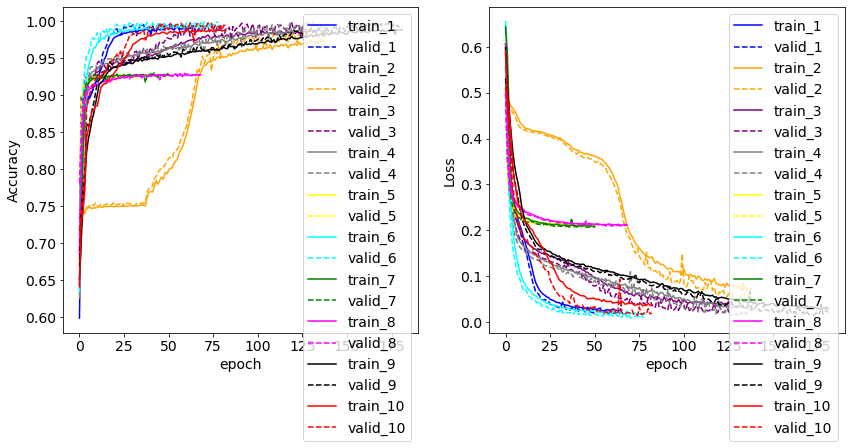

In [129]:
runs_10 = ['1','2','3','4','5','6','7','8','9','10']
cols_10 = cols = ['blue','orange','purple','grey','yellow','cyan','green','magenta','black',"red"]
plot_fits(fits_avg_glorot,runs_10,cols_10)

For the case of relu as an activation function, the glorotUniform seems to be performing the best in terms of accurcay and number of epochs. However, the case can be different for different activations functions. 

In [134]:
#HeUniform
init_al_H = 'he_uniform'
fits_avg_H = avg_test(4000,5,0.8,2,200,init_al_H)

Epoch 1/200
240/240 - 1s - loss: 0.5930 - accuracy: 0.6742 - val_loss: 0.4971 - val_accuracy: 0.7683 - 715ms/epoch - 3ms/step
Epoch 2/200
240/240 - 0s - loss: 0.4418 - accuracy: 0.8075 - val_loss: 0.3662 - val_accuracy: 0.8600 - 270ms/epoch - 1ms/step
Epoch 3/200
240/240 - 0s - loss: 0.3427 - accuracy: 0.8622 - val_loss: 0.2886 - val_accuracy: 0.8920 - 272ms/epoch - 1ms/step
Epoch 4/200
240/240 - 0s - loss: 0.2867 - accuracy: 0.8878 - val_loss: 0.2466 - val_accuracy: 0.9093 - 274ms/epoch - 1ms/step
Epoch 5/200
240/240 - 0s - loss: 0.2530 - accuracy: 0.9007 - val_loss: 0.2261 - val_accuracy: 0.9060 - 267ms/epoch - 1ms/step
Epoch 6/200
240/240 - 0s - loss: 0.2336 - accuracy: 0.9049 - val_loss: 0.2117 - val_accuracy: 0.9137 - 271ms/epoch - 1ms/step
Epoch 7/200
240/240 - 0s - loss: 0.2194 - accuracy: 0.9122 - val_loss: 0.2025 - val_accuracy: 0.9197 - 261ms/epoch - 1ms/step
Epoch 8/200
240/240 - 0s - loss: 0.2128 - accuracy: 0.9141 - val_loss: 0.1953 - val_accuracy: 0.9203 - 268ms/epoch - 1

Epoch 66/200
240/240 - 0s - loss: 0.1685 - accuracy: 0.9258 - val_loss: 0.1624 - val_accuracy: 0.9247 - 264ms/epoch - 1ms/step
Epoch 67/200
240/240 - 0s - loss: 0.1661 - accuracy: 0.9259 - val_loss: 0.1595 - val_accuracy: 0.9273 - 266ms/epoch - 1ms/step
Epoch 68/200
240/240 - 0s - loss: 0.1692 - accuracy: 0.9250 - val_loss: 0.1622 - val_accuracy: 0.9250 - 258ms/epoch - 1ms/step
Epoch 69/200
240/240 - 0s - loss: 0.1654 - accuracy: 0.9259 - val_loss: 0.1596 - val_accuracy: 0.9273 - 268ms/epoch - 1ms/step
Epoch 70/200
240/240 - 0s - loss: 0.1681 - accuracy: 0.9253 - val_loss: 0.1601 - val_accuracy: 0.9273 - 277ms/epoch - 1ms/step
Epoch 71/200
240/240 - 0s - loss: 0.1663 - accuracy: 0.9262 - val_loss: 0.1615 - val_accuracy: 0.9260 - 267ms/epoch - 1ms/step
Epoch 72/200
240/240 - 0s - loss: 0.1666 - accuracy: 0.9260 - val_loss: 0.1613 - val_accuracy: 0.9257 - 266ms/epoch - 1ms/step
Epoch 73/200
240/240 - 0s - loss: 0.1659 - accuracy: 0.9253 - val_loss: 0.1597 - val_accuracy: 0.9263 - 264ms/e

Epoch 56/200
240/240 - 0s - loss: 0.1869 - accuracy: 0.9188 - val_loss: 0.1706 - val_accuracy: 0.9273 - 256ms/epoch - 1ms/step
Epoch 57/200
240/240 - 0s - loss: 0.1836 - accuracy: 0.9208 - val_loss: 0.1690 - val_accuracy: 0.9293 - 259ms/epoch - 1ms/step
Epoch 58/200
240/240 - 0s - loss: 0.1871 - accuracy: 0.9208 - val_loss: 0.1671 - val_accuracy: 0.9310 - 259ms/epoch - 1ms/step
Epoch 59/200
240/240 - 0s - loss: 0.1854 - accuracy: 0.9179 - val_loss: 0.1741 - val_accuracy: 0.9250 - 258ms/epoch - 1ms/step
Epoch 60/200
240/240 - 0s - loss: 0.1895 - accuracy: 0.9196 - val_loss: 0.1667 - val_accuracy: 0.9317 - 257ms/epoch - 1ms/step
Epoch 61/200
240/240 - 0s - loss: 0.1825 - accuracy: 0.9232 - val_loss: 0.1635 - val_accuracy: 0.9360 - 259ms/epoch - 1ms/step
Epoch 62/200
240/240 - 0s - loss: 0.1836 - accuracy: 0.9202 - val_loss: 0.1639 - val_accuracy: 0.9357 - 259ms/epoch - 1ms/step
Epoch 63/200
240/240 - 0s - loss: 0.1795 - accuracy: 0.9223 - val_loss: 0.1634 - val_accuracy: 0.9317 - 256ms/e

Epoch 121/200
240/240 - 0s - loss: 0.1105 - accuracy: 0.9529 - val_loss: 0.0974 - val_accuracy: 0.9573 - 264ms/epoch - 1ms/step
Epoch 122/200
240/240 - 0s - loss: 0.1105 - accuracy: 0.9513 - val_loss: 0.0980 - val_accuracy: 0.9610 - 267ms/epoch - 1ms/step
Epoch 123/200
240/240 - 0s - loss: 0.1096 - accuracy: 0.9523 - val_loss: 0.0939 - val_accuracy: 0.9643 - 266ms/epoch - 1ms/step
Epoch 124/200
240/240 - 0s - loss: 0.1090 - accuracy: 0.9523 - val_loss: 0.0909 - val_accuracy: 0.9663 - 257ms/epoch - 1ms/step
Epoch 125/200
240/240 - 0s - loss: 0.1058 - accuracy: 0.9550 - val_loss: 0.1029 - val_accuracy: 0.9527 - 260ms/epoch - 1ms/step
Epoch 126/200
240/240 - 0s - loss: 0.1088 - accuracy: 0.9541 - val_loss: 0.0876 - val_accuracy: 0.9677 - 266ms/epoch - 1ms/step
Epoch 127/200
240/240 - 0s - loss: 0.1060 - accuracy: 0.9547 - val_loss: 0.0974 - val_accuracy: 0.9627 - 255ms/epoch - 1ms/step
Epoch 128/200
240/240 - 0s - loss: 0.1011 - accuracy: 0.9563 - val_loss: 0.0844 - val_accuracy: 0.9687 -

240/240 - 0s - loss: 0.4041 - accuracy: 0.8557 - val_loss: 0.3197 - val_accuracy: 0.8903 - 266ms/epoch - 1ms/step
Epoch 3/200
240/240 - 0s - loss: 0.3198 - accuracy: 0.8875 - val_loss: 0.2817 - val_accuracy: 0.9097 - 269ms/epoch - 1ms/step
Epoch 4/200
240/240 - 0s - loss: 0.2879 - accuracy: 0.9017 - val_loss: 0.2609 - val_accuracy: 0.9183 - 264ms/epoch - 1ms/step
Epoch 5/200
240/240 - 0s - loss: 0.2701 - accuracy: 0.9093 - val_loss: 0.2480 - val_accuracy: 0.9187 - 265ms/epoch - 1ms/step
Epoch 6/200
240/240 - 0s - loss: 0.2566 - accuracy: 0.9141 - val_loss: 0.2367 - val_accuracy: 0.9190 - 267ms/epoch - 1ms/step
Epoch 7/200
240/240 - 0s - loss: 0.2463 - accuracy: 0.9174 - val_loss: 0.2311 - val_accuracy: 0.9187 - 269ms/epoch - 1ms/step
Epoch 8/200
240/240 - 0s - loss: 0.2388 - accuracy: 0.9185 - val_loss: 0.2251 - val_accuracy: 0.9233 - 271ms/epoch - 1ms/step
Epoch 9/200
240/240 - 0s - loss: 0.2330 - accuracy: 0.9194 - val_loss: 0.2179 - val_accuracy: 0.9247 - 274ms/epoch - 1ms/step
Epoc

Epoch 67/200
240/240 - 0s - loss: 0.1706 - accuracy: 0.9272 - val_loss: 0.1666 - val_accuracy: 0.9240 - 283ms/epoch - 1ms/step
Epoch 68/200
240/240 - 0s - loss: 0.1720 - accuracy: 0.9244 - val_loss: 0.1630 - val_accuracy: 0.9260 - 281ms/epoch - 1ms/step
Epoch 69/200
240/240 - 0s - loss: 0.1713 - accuracy: 0.9241 - val_loss: 0.1620 - val_accuracy: 0.9270 - 277ms/epoch - 1ms/step
Epoch 70/200
240/240 - 0s - loss: 0.1705 - accuracy: 0.9232 - val_loss: 0.1717 - val_accuracy: 0.9233 - 277ms/epoch - 1ms/step
Epoch 71/200
240/240 - 0s - loss: 0.1711 - accuracy: 0.9226 - val_loss: 0.1603 - val_accuracy: 0.9277 - 280ms/epoch - 1ms/step
Epoch 72/200
240/240 - 0s - loss: 0.1721 - accuracy: 0.9212 - val_loss: 0.1612 - val_accuracy: 0.9273 - 274ms/epoch - 1ms/step
Epoch 73/200
240/240 - 0s - loss: 0.1697 - accuracy: 0.9234 - val_loss: 0.1617 - val_accuracy: 0.9250 - 272ms/epoch - 1ms/step
Epoch 74/200
240/240 - 0s - loss: 0.1698 - accuracy: 0.9229 - val_loss: 0.1602 - val_accuracy: 0.9280 - 271ms/e

Epoch 10/200
240/240 - 0s - loss: 0.2213 - accuracy: 0.9227 - val_loss: 0.2136 - val_accuracy: 0.9257 - 278ms/epoch - 1ms/step
Epoch 11/200
240/240 - 0s - loss: 0.2178 - accuracy: 0.9249 - val_loss: 0.2112 - val_accuracy: 0.9260 - 288ms/epoch - 1ms/step
Epoch 12/200
240/240 - 0s - loss: 0.2160 - accuracy: 0.9216 - val_loss: 0.2082 - val_accuracy: 0.9250 - 281ms/epoch - 1ms/step
Epoch 13/200
240/240 - 0s - loss: 0.2123 - accuracy: 0.9235 - val_loss: 0.2048 - val_accuracy: 0.9257 - 283ms/epoch - 1ms/step
Epoch 14/200
240/240 - 0s - loss: 0.2081 - accuracy: 0.9237 - val_loss: 0.2007 - val_accuracy: 0.9253 - 268ms/epoch - 1ms/step
Epoch 15/200
240/240 - 0s - loss: 0.2050 - accuracy: 0.9233 - val_loss: 0.1981 - val_accuracy: 0.9247 - 273ms/epoch - 1ms/step
Epoch 16/200
240/240 - 0s - loss: 0.2014 - accuracy: 0.9237 - val_loss: 0.1955 - val_accuracy: 0.9227 - 266ms/epoch - 1ms/step
Epoch 17/200
240/240 - 0s - loss: 0.1986 - accuracy: 0.9232 - val_loss: 0.1919 - val_accuracy: 0.9253 - 277ms/e

Epoch 8/200
240/240 - 0s - loss: 0.2327 - accuracy: 0.9175 - val_loss: 0.2095 - val_accuracy: 0.9300 - 272ms/epoch - 1ms/step
Epoch 9/200
240/240 - 0s - loss: 0.2201 - accuracy: 0.9181 - val_loss: 0.1990 - val_accuracy: 0.9280 - 280ms/epoch - 1ms/step
Epoch 10/200
240/240 - 0s - loss: 0.2049 - accuracy: 0.9213 - val_loss: 0.1944 - val_accuracy: 0.9230 - 274ms/epoch - 1ms/step
Epoch 11/200
240/240 - 0s - loss: 0.1976 - accuracy: 0.9243 - val_loss: 0.1756 - val_accuracy: 0.9337 - 269ms/epoch - 1ms/step
Epoch 12/200
240/240 - 0s - loss: 0.1844 - accuracy: 0.9252 - val_loss: 0.1640 - val_accuracy: 0.9367 - 268ms/epoch - 1ms/step
Epoch 13/200
240/240 - 0s - loss: 0.1757 - accuracy: 0.9293 - val_loss: 0.1517 - val_accuracy: 0.9417 - 262ms/epoch - 1ms/step
Epoch 14/200
240/240 - 0s - loss: 0.1627 - accuracy: 0.9332 - val_loss: 0.1351 - val_accuracy: 0.9493 - 266ms/epoch - 1ms/step
Epoch 15/200
240/240 - 0s - loss: 0.1416 - accuracy: 0.9421 - val_loss: 0.1151 - val_accuracy: 0.9570 - 264ms/epo

Epoch 73/200
240/240 - 0s - loss: 0.0288 - accuracy: 0.9883 - val_loss: 0.0219 - val_accuracy: 0.9917 - 264ms/epoch - 1ms/step
Epoch 74/200
240/240 - 0s - loss: 0.0287 - accuracy: 0.9892 - val_loss: 0.0212 - val_accuracy: 0.9930 - 273ms/epoch - 1ms/step
Epoch 75/200
240/240 - 0s - loss: 0.0333 - accuracy: 0.9876 - val_loss: 0.0243 - val_accuracy: 0.9893 - 265ms/epoch - 1ms/step
Epoch 76/200
240/240 - 0s - loss: 0.0274 - accuracy: 0.9890 - val_loss: 0.0187 - val_accuracy: 0.9947 - 269ms/epoch - 1ms/step
Epoch 77/200
240/240 - 0s - loss: 0.0273 - accuracy: 0.9895 - val_loss: 0.0279 - val_accuracy: 0.9873 - 286ms/epoch - 1ms/step
Epoch 78/200
240/240 - 0s - loss: 0.0283 - accuracy: 0.9888 - val_loss: 0.0166 - val_accuracy: 0.9970 - 327ms/epoch - 1ms/step
Epoch 79/200
240/240 - 0s - loss: 0.0282 - accuracy: 0.9885 - val_loss: 0.0183 - val_accuracy: 0.9937 - 290ms/epoch - 1ms/step
Epoch 80/200
240/240 - 0s - loss: 0.0280 - accuracy: 0.9893 - val_loss: 0.0176 - val_accuracy: 0.9947 - 278ms/e

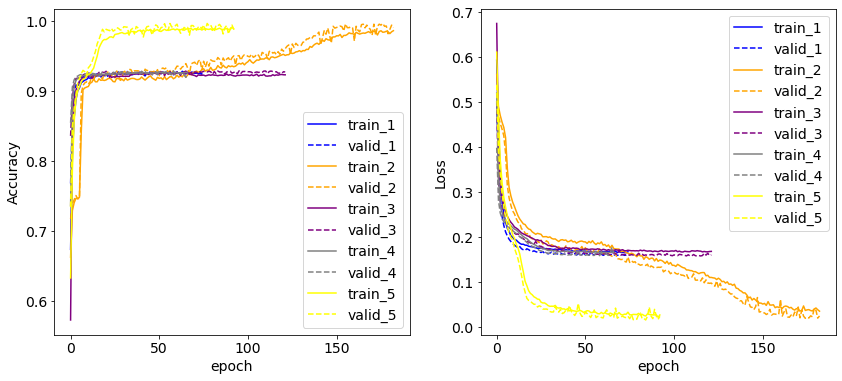

In [135]:
plot_fits(fits_avg_H,runs,cols)

In [40]:
fits_avg_H = avg_test(4000,5,0.8,2,200,'he_normal','relu')
#num_samp,rounds,perc,L_dim,nepochs,initializer_func,activation='relu'

Epoch 1/200
64/64 - 1s - loss: 0.6572 - accuracy: 0.5553 - val_loss: 0.6373 - val_accuracy: 0.5562 - 580ms/epoch - 9ms/step
Epoch 2/200
64/64 - 0s - loss: 0.6239 - accuracy: 0.5928 - val_loss: 0.6052 - val_accuracy: 0.6300 - 109ms/epoch - 2ms/step
Epoch 3/200
64/64 - 0s - loss: 0.5904 - accuracy: 0.6569 - val_loss: 0.5738 - val_accuracy: 0.6438 - 136ms/epoch - 2ms/step
Epoch 4/200
64/64 - 0s - loss: 0.5608 - accuracy: 0.6928 - val_loss: 0.5504 - val_accuracy: 0.6725 - 163ms/epoch - 3ms/step
Epoch 5/200
64/64 - 0s - loss: 0.5385 - accuracy: 0.7081 - val_loss: 0.5307 - val_accuracy: 0.7000 - 157ms/epoch - 2ms/step
Epoch 6/200
64/64 - 0s - loss: 0.5224 - accuracy: 0.7300 - val_loss: 0.5122 - val_accuracy: 0.7312 - 153ms/epoch - 2ms/step
Epoch 7/200
64/64 - 0s - loss: 0.5042 - accuracy: 0.7431 - val_loss: 0.4982 - val_accuracy: 0.7412 - 135ms/epoch - 2ms/step
Epoch 8/200
64/64 - 0s - loss: 0.4853 - accuracy: 0.7572 - val_loss: 0.4809 - val_accuracy: 0.7500 - 138ms/epoch - 2ms/step
Epoch 9/

Epoch 67/200
64/64 - 0s - loss: 0.1696 - accuracy: 0.9328 - val_loss: 0.1905 - val_accuracy: 0.9125 - 103ms/epoch - 2ms/step
Epoch 68/200
64/64 - 0s - loss: 0.1691 - accuracy: 0.9334 - val_loss: 0.1866 - val_accuracy: 0.9175 - 107ms/epoch - 2ms/step
Epoch 69/200
64/64 - 0s - loss: 0.1690 - accuracy: 0.9325 - val_loss: 0.1878 - val_accuracy: 0.9175 - 106ms/epoch - 2ms/step
Epoch 70/200
64/64 - 0s - loss: 0.1677 - accuracy: 0.9322 - val_loss: 0.1864 - val_accuracy: 0.9150 - 101ms/epoch - 2ms/step
Epoch 71/200
64/64 - 0s - loss: 0.1667 - accuracy: 0.9334 - val_loss: 0.1872 - val_accuracy: 0.9112 - 103ms/epoch - 2ms/step
Epoch 72/200
64/64 - 0s - loss: 0.1663 - accuracy: 0.9344 - val_loss: 0.1847 - val_accuracy: 0.9162 - 100ms/epoch - 2ms/step
Epoch 73/200
64/64 - 0s - loss: 0.1689 - accuracy: 0.9319 - val_loss: 0.1870 - val_accuracy: 0.9137 - 97ms/epoch - 2ms/step
Epoch 74/200
64/64 - 0s - loss: 0.1680 - accuracy: 0.9303 - val_loss: 0.1845 - val_accuracy: 0.9150 - 96ms/epoch - 1ms/step
Ep

Epoch 24/200
64/64 - 0s - loss: 0.4442 - accuracy: 0.8041 - val_loss: 0.4263 - val_accuracy: 0.8087 - 100ms/epoch - 2ms/step
Epoch 25/200
64/64 - 0s - loss: 0.4515 - accuracy: 0.8025 - val_loss: 0.4257 - val_accuracy: 0.8075 - 99ms/epoch - 2ms/step
Epoch 26/200
64/64 - 0s - loss: 0.4495 - accuracy: 0.8006 - val_loss: 0.4270 - val_accuracy: 0.8100 - 105ms/epoch - 2ms/step
Epoch 27/200
64/64 - 0s - loss: 0.4404 - accuracy: 0.8087 - val_loss: 0.4203 - val_accuracy: 0.8138 - 98ms/epoch - 2ms/step
Epoch 28/200
64/64 - 0s - loss: 0.4435 - accuracy: 0.8066 - val_loss: 0.4177 - val_accuracy: 0.8100 - 97ms/epoch - 2ms/step
Epoch 29/200
64/64 - 0s - loss: 0.4395 - accuracy: 0.8103 - val_loss: 0.4133 - val_accuracy: 0.8150 - 98ms/epoch - 2ms/step
Epoch 30/200
64/64 - 0s - loss: 0.4293 - accuracy: 0.8122 - val_loss: 0.4208 - val_accuracy: 0.8125 - 97ms/epoch - 2ms/step
Epoch 31/200
64/64 - 0s - loss: 0.4284 - accuracy: 0.8172 - val_loss: 0.4090 - val_accuracy: 0.8150 - 96ms/epoch - 1ms/step
Epoch 

Epoch 90/200
64/64 - 0s - loss: 0.1698 - accuracy: 0.9325 - val_loss: 0.1679 - val_accuracy: 0.9337 - 95ms/epoch - 1ms/step
Epoch 91/200
64/64 - 0s - loss: 0.1665 - accuracy: 0.9362 - val_loss: 0.1654 - val_accuracy: 0.9362 - 94ms/epoch - 1ms/step
Epoch 92/200
64/64 - 0s - loss: 0.1723 - accuracy: 0.9300 - val_loss: 0.1633 - val_accuracy: 0.9350 - 94ms/epoch - 1ms/step
Epoch 93/200
64/64 - 0s - loss: 0.1742 - accuracy: 0.9328 - val_loss: 0.1667 - val_accuracy: 0.9312 - 93ms/epoch - 1ms/step
Epoch 94/200
64/64 - 0s - loss: 0.1679 - accuracy: 0.9341 - val_loss: 0.1796 - val_accuracy: 0.9175 - 97ms/epoch - 2ms/step
Epoch 95/200
64/64 - 0s - loss: 0.1638 - accuracy: 0.9366 - val_loss: 0.1638 - val_accuracy: 0.9337 - 96ms/epoch - 1ms/step
Epoch 96/200
64/64 - 0s - loss: 0.1658 - accuracy: 0.9369 - val_loss: 0.1603 - val_accuracy: 0.9388 - 95ms/epoch - 1ms/step
Epoch 97/200
64/64 - 0s - loss: 0.1696 - accuracy: 0.9294 - val_loss: 0.1611 - val_accuracy: 0.9337 - 116ms/epoch - 2ms/step
Epoch 9

Epoch 156/200
64/64 - 0s - loss: 0.1114 - accuracy: 0.9531 - val_loss: 0.1102 - val_accuracy: 0.9488 - 96ms/epoch - 1ms/step
Epoch 157/200
64/64 - 0s - loss: 0.1082 - accuracy: 0.9538 - val_loss: 0.1077 - val_accuracy: 0.9513 - 94ms/epoch - 1ms/step
Epoch 158/200
64/64 - 0s - loss: 0.1062 - accuracy: 0.9544 - val_loss: 0.1064 - val_accuracy: 0.9550 - 96ms/epoch - 1ms/step
Epoch 159/200
64/64 - 0s - loss: 0.1046 - accuracy: 0.9563 - val_loss: 0.1033 - val_accuracy: 0.9550 - 95ms/epoch - 1ms/step
Epoch 160/200
64/64 - 0s - loss: 0.1057 - accuracy: 0.9547 - val_loss: 0.1038 - val_accuracy: 0.9613 - 98ms/epoch - 2ms/step
Epoch 161/200
64/64 - 0s - loss: 0.1048 - accuracy: 0.9563 - val_loss: 0.1092 - val_accuracy: 0.9488 - 93ms/epoch - 1ms/step
Epoch 162/200
64/64 - 0s - loss: 0.1065 - accuracy: 0.9550 - val_loss: 0.1049 - val_accuracy: 0.9525 - 96ms/epoch - 2ms/step
Epoch 163/200
64/64 - 0s - loss: 0.1038 - accuracy: 0.9500 - val_loss: 0.1003 - val_accuracy: 0.9550 - 97ms/epoch - 2ms/step


Epoch 22/200
64/64 - 0s - loss: 0.3748 - accuracy: 0.8556 - val_loss: 0.3799 - val_accuracy: 0.8612 - 92ms/epoch - 1ms/step
Epoch 23/200
64/64 - 0s - loss: 0.3572 - accuracy: 0.8703 - val_loss: 0.3495 - val_accuracy: 0.8813 - 93ms/epoch - 1ms/step
Epoch 24/200
64/64 - 0s - loss: 0.3299 - accuracy: 0.8953 - val_loss: 0.3097 - val_accuracy: 0.9125 - 95ms/epoch - 1ms/step
Epoch 25/200
64/64 - 0s - loss: 0.2940 - accuracy: 0.9122 - val_loss: 0.2734 - val_accuracy: 0.9225 - 94ms/epoch - 1ms/step
Epoch 26/200
64/64 - 0s - loss: 0.2683 - accuracy: 0.9216 - val_loss: 0.2581 - val_accuracy: 0.9262 - 95ms/epoch - 1ms/step
Epoch 27/200
64/64 - 0s - loss: 0.2534 - accuracy: 0.9250 - val_loss: 0.2403 - val_accuracy: 0.9200 - 93ms/epoch - 1ms/step
Epoch 28/200
64/64 - 0s - loss: 0.2464 - accuracy: 0.9219 - val_loss: 0.2324 - val_accuracy: 0.9212 - 92ms/epoch - 1ms/step
Epoch 29/200
64/64 - 0s - loss: 0.2387 - accuracy: 0.9206 - val_loss: 0.2204 - val_accuracy: 0.9187 - 90ms/epoch - 1ms/step
Epoch 30

Epoch 88/200
64/64 - 0s - loss: 0.1684 - accuracy: 0.9362 - val_loss: 0.1633 - val_accuracy: 0.9200 - 103ms/epoch - 2ms/step
Epoch 89/200
64/64 - 0s - loss: 0.1617 - accuracy: 0.9400 - val_loss: 0.1609 - val_accuracy: 0.9275 - 101ms/epoch - 2ms/step
Epoch 90/200
64/64 - 0s - loss: 0.1610 - accuracy: 0.9381 - val_loss: 0.1633 - val_accuracy: 0.9275 - 172ms/epoch - 3ms/step
Epoch 91/200
64/64 - 0s - loss: 0.1628 - accuracy: 0.9381 - val_loss: 0.1605 - val_accuracy: 0.9287 - 177ms/epoch - 3ms/step
Epoch 92/200
64/64 - 0s - loss: 0.1629 - accuracy: 0.9331 - val_loss: 0.1646 - val_accuracy: 0.9275 - 227ms/epoch - 4ms/step
Epoch 93/200
64/64 - 0s - loss: 0.1687 - accuracy: 0.9353 - val_loss: 0.1606 - val_accuracy: 0.9250 - 226ms/epoch - 4ms/step
Epoch 94/200
64/64 - 0s - loss: 0.1614 - accuracy: 0.9381 - val_loss: 0.1601 - val_accuracy: 0.9250 - 149ms/epoch - 2ms/step
Epoch 95/200
64/64 - 0s - loss: 0.1626 - accuracy: 0.9362 - val_loss: 0.1610 - val_accuracy: 0.9275 - 114ms/epoch - 2ms/step


Epoch 41/200
64/64 - 0s - loss: 0.1904 - accuracy: 0.9162 - val_loss: 0.1986 - val_accuracy: 0.9087 - 97ms/epoch - 2ms/step
Epoch 42/200
64/64 - 0s - loss: 0.1900 - accuracy: 0.9203 - val_loss: 0.1976 - val_accuracy: 0.9075 - 88ms/epoch - 1ms/step
Epoch 43/200
64/64 - 0s - loss: 0.1878 - accuracy: 0.9191 - val_loss: 0.1960 - val_accuracy: 0.9087 - 90ms/epoch - 1ms/step
Epoch 44/200
64/64 - 0s - loss: 0.1912 - accuracy: 0.9162 - val_loss: 0.1943 - val_accuracy: 0.9100 - 90ms/epoch - 1ms/step
Epoch 45/200
64/64 - 0s - loss: 0.1868 - accuracy: 0.9209 - val_loss: 0.1946 - val_accuracy: 0.9100 - 89ms/epoch - 1ms/step
Epoch 46/200
64/64 - 0s - loss: 0.1854 - accuracy: 0.9212 - val_loss: 0.1919 - val_accuracy: 0.9125 - 95ms/epoch - 1ms/step
Epoch 47/200
64/64 - 0s - loss: 0.1863 - accuracy: 0.9203 - val_loss: 0.1990 - val_accuracy: 0.9025 - 106ms/epoch - 2ms/step
Epoch 48/200
64/64 - 0s - loss: 0.1807 - accuracy: 0.9228 - val_loss: 0.1907 - val_accuracy: 0.9112 - 94ms/epoch - 1ms/step
Epoch 4

Epoch 17/200
64/64 - 0s - loss: 0.2338 - accuracy: 0.9275 - val_loss: 0.2576 - val_accuracy: 0.9200 - 128ms/epoch - 2ms/step
Epoch 18/200
64/64 - 0s - loss: 0.2259 - accuracy: 0.9259 - val_loss: 0.2549 - val_accuracy: 0.9125 - 116ms/epoch - 2ms/step
Epoch 19/200
64/64 - 0s - loss: 0.2294 - accuracy: 0.9269 - val_loss: 0.2534 - val_accuracy: 0.9112 - 99ms/epoch - 2ms/step
Epoch 20/200
64/64 - 0s - loss: 0.2240 - accuracy: 0.9287 - val_loss: 0.2519 - val_accuracy: 0.9112 - 92ms/epoch - 1ms/step
Epoch 21/200
64/64 - 0s - loss: 0.2234 - accuracy: 0.9291 - val_loss: 0.2527 - val_accuracy: 0.9125 - 139ms/epoch - 2ms/step
Epoch 22/200
64/64 - 0s - loss: 0.2210 - accuracy: 0.9306 - val_loss: 0.2503 - val_accuracy: 0.9100 - 154ms/epoch - 2ms/step
Epoch 23/200
64/64 - 0s - loss: 0.2188 - accuracy: 0.9281 - val_loss: 0.2493 - val_accuracy: 0.9212 - 158ms/epoch - 2ms/step
Epoch 24/200
64/64 - 0s - loss: 0.2194 - accuracy: 0.9284 - val_loss: 0.2484 - val_accuracy: 0.9212 - 149ms/epoch - 2ms/step
Ep

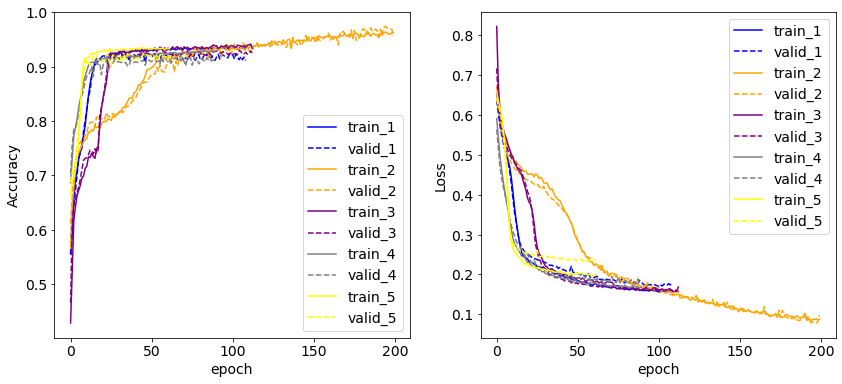

In [41]:
runs = ['1','2','3','4','5']
cols = ['blue','orange','purple','grey','yellow']
plot_fits(fits_avg_H,runs,cols)

In [25]:
N = 4000
N_train = int(4000*0.8)

x_test,y_test = generate_data(N)
x_train = x_test[0:N_train]
y_train = y_test[0:N_train]
x_valid = x_test[N_train:]
y_valid = y_test[N_train:]
x_train, x_valid = Rescale(x_train),Rescale(x_valid)

## Gridsearch

Tuning the different hyper parameters for optimizing the model.
Look at architecture of the network, training parameters and initialization of the weights.

In [16]:
#INITIALIZATION OF WEIGHTS

model_gridsearch = KerasClassifier(build_fn=compile_model,
                                  epochs=200,
                                  batch_size = 50,
                                  verbose=2)

initializer = ['glorot_uniform','glorot_normal','he_uniform','he_normal']
activation = ["relu","sigmoid"]

param_grid = dict(init_al = initializer,activation_func = activation)

grid = GridSearchCV(estimator = model_gridsearch, param_grid = param_grid, n_jobs=1, cv = 4)

In [17]:
grid_result = grid.fit(x_train,y_train)

Epoch 1/200
48/48 - 0s - loss: 0.6865 - accuracy: 0.5587
Epoch 2/200
48/48 - 0s - loss: 0.6743 - accuracy: 0.6050
Epoch 3/200
48/48 - 0s - loss: 0.6644 - accuracy: 0.6104
Epoch 4/200
48/48 - 0s - loss: 0.6532 - accuracy: 0.6283
Epoch 5/200
48/48 - 0s - loss: 0.6351 - accuracy: 0.6463
Epoch 6/200
48/48 - 0s - loss: 0.6180 - accuracy: 0.6637
Epoch 7/200
48/48 - 0s - loss: 0.5966 - accuracy: 0.6900
Epoch 8/200
48/48 - 0s - loss: 0.5777 - accuracy: 0.7000
Epoch 9/200
48/48 - 0s - loss: 0.5537 - accuracy: 0.7183
Epoch 10/200
48/48 - 0s - loss: 0.5276 - accuracy: 0.7367
Epoch 11/200
48/48 - 0s - loss: 0.5022 - accuracy: 0.7492
Epoch 12/200
48/48 - 0s - loss: 0.4782 - accuracy: 0.7613
Epoch 13/200
48/48 - 0s - loss: 0.4559 - accuracy: 0.7808
Epoch 14/200
48/48 - 0s - loss: 0.4262 - accuracy: 0.8000
Epoch 15/200
48/48 - 0s - loss: 0.4168 - accuracy: 0.8138
Epoch 16/200
48/48 - 0s - loss: 0.3981 - accuracy: 0.8208
Epoch 17/200
48/48 - 0s - loss: 0.3797 - accuracy: 0.8358
Epoch 18/200
48/48 - 0s

Epoch 142/200
48/48 - 0s - loss: 0.0545 - accuracy: 0.9821
Epoch 143/200
48/48 - 0s - loss: 0.0485 - accuracy: 0.9825
Epoch 144/200
48/48 - 0s - loss: 0.0541 - accuracy: 0.9808
Epoch 145/200
48/48 - 0s - loss: 0.0540 - accuracy: 0.9837
Epoch 146/200
48/48 - 0s - loss: 0.0509 - accuracy: 0.9817
Epoch 147/200
48/48 - 0s - loss: 0.0508 - accuracy: 0.9837
Epoch 148/200
48/48 - 0s - loss: 0.0495 - accuracy: 0.9833
Epoch 149/200
48/48 - 0s - loss: 0.0507 - accuracy: 0.9800
Epoch 150/200
48/48 - 0s - loss: 0.0516 - accuracy: 0.9829
Epoch 151/200
48/48 - 0s - loss: 0.0510 - accuracy: 0.9850
Epoch 152/200
48/48 - 0s - loss: 0.0539 - accuracy: 0.9800
Epoch 153/200
48/48 - 0s - loss: 0.0480 - accuracy: 0.9846
Epoch 154/200
48/48 - 0s - loss: 0.0482 - accuracy: 0.9850
Epoch 155/200
48/48 - 0s - loss: 0.0498 - accuracy: 0.9842
Epoch 156/200
48/48 - 0s - loss: 0.0444 - accuracy: 0.9846
Epoch 157/200
48/48 - 0s - loss: 0.0464 - accuracy: 0.9850
Epoch 158/200
48/48 - 0s - loss: 0.0513 - accuracy: 0.98

Epoch 79/200
48/48 - 0s - loss: 0.1475 - accuracy: 0.9429
Epoch 80/200
48/48 - 0s - loss: 0.1510 - accuracy: 0.9408
Epoch 81/200
48/48 - 0s - loss: 0.1446 - accuracy: 0.9421
Epoch 82/200
48/48 - 0s - loss: 0.1420 - accuracy: 0.9454
Epoch 83/200
48/48 - 0s - loss: 0.1424 - accuracy: 0.9421
Epoch 84/200
48/48 - 0s - loss: 0.1391 - accuracy: 0.9463
Epoch 85/200
48/48 - 0s - loss: 0.1403 - accuracy: 0.9454
Epoch 86/200
48/48 - 0s - loss: 0.1405 - accuracy: 0.9421
Epoch 87/200
48/48 - 0s - loss: 0.1407 - accuracy: 0.9442
Epoch 88/200
48/48 - 0s - loss: 0.1403 - accuracy: 0.9433
Epoch 89/200
48/48 - 0s - loss: 0.1337 - accuracy: 0.9504
Epoch 90/200
48/48 - 0s - loss: 0.1320 - accuracy: 0.9513
Epoch 91/200
48/48 - 0s - loss: 0.1342 - accuracy: 0.9442
Epoch 92/200
48/48 - 0s - loss: 0.1369 - accuracy: 0.9425
Epoch 93/200
48/48 - 0s - loss: 0.1328 - accuracy: 0.9496
Epoch 94/200
48/48 - 0s - loss: 0.1309 - accuracy: 0.9529
Epoch 95/200
48/48 - 0s - loss: 0.1314 - accuracy: 0.9488
Epoch 96/200
4

Epoch 18/200
48/48 - 0s - loss: 0.4192 - accuracy: 0.7975
Epoch 19/200
48/48 - 0s - loss: 0.4159 - accuracy: 0.7979
Epoch 20/200
48/48 - 0s - loss: 0.4113 - accuracy: 0.7971
Epoch 21/200
48/48 - 0s - loss: 0.4063 - accuracy: 0.7979
Epoch 22/200
48/48 - 0s - loss: 0.4013 - accuracy: 0.7992
Epoch 23/200
48/48 - 0s - loss: 0.3962 - accuracy: 0.7987
Epoch 24/200
48/48 - 0s - loss: 0.3897 - accuracy: 0.8025
Epoch 25/200
48/48 - 0s - loss: 0.3857 - accuracy: 0.8008
Epoch 26/200
48/48 - 0s - loss: 0.3781 - accuracy: 0.8033
Epoch 27/200
48/48 - 0s - loss: 0.3710 - accuracy: 0.8012
Epoch 28/200
48/48 - 0s - loss: 0.3630 - accuracy: 0.8017
Epoch 29/200
48/48 - 0s - loss: 0.3562 - accuracy: 0.8025
Epoch 30/200
48/48 - 0s - loss: 0.3468 - accuracy: 0.8062
Epoch 31/200
48/48 - 0s - loss: 0.3405 - accuracy: 0.8021
Epoch 32/200
48/48 - 0s - loss: 0.3311 - accuracy: 0.8004
Epoch 33/200
48/48 - 0s - loss: 0.3252 - accuracy: 0.8029
Epoch 34/200
48/48 - 0s - loss: 0.3201 - accuracy: 0.8004
Epoch 35/200
4

Epoch 159/200
48/48 - 0s - loss: 0.1762 - accuracy: 0.9287
Epoch 160/200
48/48 - 0s - loss: 0.1829 - accuracy: 0.9258
Epoch 161/200
48/48 - 0s - loss: 0.1796 - accuracy: 0.9283
Epoch 162/200
48/48 - 0s - loss: 0.1784 - accuracy: 0.9292
Epoch 163/200
48/48 - 0s - loss: 0.1790 - accuracy: 0.9287
Epoch 164/200
48/48 - 0s - loss: 0.1778 - accuracy: 0.9279
Epoch 165/200
48/48 - 0s - loss: 0.1771 - accuracy: 0.9271
Epoch 166/200
48/48 - 0s - loss: 0.1786 - accuracy: 0.9279
Epoch 167/200
48/48 - 0s - loss: 0.1791 - accuracy: 0.9292
Epoch 168/200
48/48 - 0s - loss: 0.1796 - accuracy: 0.9292
Epoch 169/200
48/48 - 0s - loss: 0.1813 - accuracy: 0.9250
Epoch 170/200
48/48 - 0s - loss: 0.1786 - accuracy: 0.9279
Epoch 171/200
48/48 - 0s - loss: 0.1772 - accuracy: 0.9279
Epoch 172/200
48/48 - 0s - loss: 0.1780 - accuracy: 0.9254
Epoch 173/200
48/48 - 0s - loss: 0.1727 - accuracy: 0.9317
Epoch 174/200
48/48 - 0s - loss: 0.1769 - accuracy: 0.9283
Epoch 175/200
48/48 - 0s - loss: 0.1775 - accuracy: 0.93

Epoch 99/200
48/48 - 0s - loss: 0.1694 - accuracy: 0.9350
Epoch 100/200
48/48 - 0s - loss: 0.1687 - accuracy: 0.9379
Epoch 101/200
48/48 - 0s - loss: 0.1705 - accuracy: 0.9333
Epoch 102/200
48/48 - 0s - loss: 0.1669 - accuracy: 0.9358
Epoch 103/200
48/48 - 0s - loss: 0.1710 - accuracy: 0.9350
Epoch 104/200
48/48 - 0s - loss: 0.1712 - accuracy: 0.9371
Epoch 105/200
48/48 - 0s - loss: 0.1680 - accuracy: 0.9379
Epoch 106/200
48/48 - 0s - loss: 0.1684 - accuracy: 0.9404
Epoch 107/200
48/48 - 0s - loss: 0.1715 - accuracy: 0.9346
Epoch 108/200
48/48 - 0s - loss: 0.1651 - accuracy: 0.9404
Epoch 109/200
48/48 - 0s - loss: 0.1655 - accuracy: 0.9404
Epoch 110/200
48/48 - 0s - loss: 0.1620 - accuracy: 0.9417
Epoch 111/200
48/48 - 0s - loss: 0.1646 - accuracy: 0.9408
Epoch 112/200
48/48 - 0s - loss: 0.1625 - accuracy: 0.9383
Epoch 113/200
48/48 - 0s - loss: 0.1602 - accuracy: 0.9413
Epoch 114/200
48/48 - 0s - loss: 0.1634 - accuracy: 0.9400
Epoch 115/200
48/48 - 0s - loss: 0.1602 - accuracy: 0.939

Epoch 38/200
48/48 - 0s - loss: 0.2201 - accuracy: 0.9129
Epoch 39/200
48/48 - 0s - loss: 0.2233 - accuracy: 0.9112
Epoch 40/200
48/48 - 0s - loss: 0.2241 - accuracy: 0.9117
Epoch 41/200
48/48 - 0s - loss: 0.2199 - accuracy: 0.9100
Epoch 42/200
48/48 - 0s - loss: 0.2166 - accuracy: 0.9129
Epoch 43/200
48/48 - 0s - loss: 0.2190 - accuracy: 0.9112
Epoch 44/200
48/48 - 0s - loss: 0.2110 - accuracy: 0.9162
Epoch 45/200
48/48 - 0s - loss: 0.2113 - accuracy: 0.9137
Epoch 46/200
48/48 - 0s - loss: 0.2102 - accuracy: 0.9154
Epoch 47/200
48/48 - 0s - loss: 0.2100 - accuracy: 0.9146
Epoch 48/200
48/48 - 0s - loss: 0.2135 - accuracy: 0.9150
Epoch 49/200
48/48 - 0s - loss: 0.2041 - accuracy: 0.9117
Epoch 50/200
48/48 - 0s - loss: 0.2018 - accuracy: 0.9196
Epoch 51/200
48/48 - 0s - loss: 0.2033 - accuracy: 0.9162
Epoch 52/200
48/48 - 0s - loss: 0.2015 - accuracy: 0.9171
Epoch 53/200
48/48 - 0s - loss: 0.2027 - accuracy: 0.9167
Epoch 54/200
48/48 - 0s - loss: 0.2048 - accuracy: 0.9117
Epoch 55/200
4

Epoch 178/200
48/48 - 0s - loss: 0.1696 - accuracy: 0.9221
Epoch 179/200
48/48 - 0s - loss: 0.1692 - accuracy: 0.9233
Epoch 180/200
48/48 - 0s - loss: 0.1669 - accuracy: 0.9229
Epoch 181/200
48/48 - 0s - loss: 0.1684 - accuracy: 0.9196
Epoch 182/200
48/48 - 0s - loss: 0.1683 - accuracy: 0.9229
Epoch 183/200
48/48 - 0s - loss: 0.1660 - accuracy: 0.9237
Epoch 184/200
48/48 - 0s - loss: 0.1667 - accuracy: 0.9221
Epoch 185/200
48/48 - 0s - loss: 0.1672 - accuracy: 0.9225
Epoch 186/200
48/48 - 0s - loss: 0.1663 - accuracy: 0.9229
Epoch 187/200
48/48 - 0s - loss: 0.1668 - accuracy: 0.9233
Epoch 188/200
48/48 - 0s - loss: 0.1658 - accuracy: 0.9233
Epoch 189/200
48/48 - 0s - loss: 0.1659 - accuracy: 0.9237
Epoch 190/200
48/48 - 0s - loss: 0.1704 - accuracy: 0.9208
Epoch 191/200
48/48 - 0s - loss: 0.1660 - accuracy: 0.9221
Epoch 192/200
48/48 - 0s - loss: 0.1648 - accuracy: 0.9229
Epoch 193/200
48/48 - 0s - loss: 0.1661 - accuracy: 0.9233
Epoch 194/200
48/48 - 0s - loss: 0.1637 - accuracy: 0.92

Epoch 118/200
48/48 - 0s - loss: 0.0355 - accuracy: 0.9879
Epoch 119/200
48/48 - 0s - loss: 0.0358 - accuracy: 0.9896
Epoch 120/200
48/48 - 0s - loss: 0.0350 - accuracy: 0.9862
Epoch 121/200
48/48 - 0s - loss: 0.0335 - accuracy: 0.9875
Epoch 122/200
48/48 - 0s - loss: 0.0414 - accuracy: 0.9817
Epoch 123/200
48/48 - 0s - loss: 0.0337 - accuracy: 0.9887
Epoch 124/200
48/48 - 0s - loss: 0.0337 - accuracy: 0.9867
Epoch 125/200
48/48 - 0s - loss: 0.0334 - accuracy: 0.9883
Epoch 126/200
48/48 - 0s - loss: 0.0353 - accuracy: 0.9837
Epoch 127/200
48/48 - 0s - loss: 0.0345 - accuracy: 0.9867
Epoch 128/200
48/48 - 0s - loss: 0.0340 - accuracy: 0.9858
Epoch 129/200
48/48 - 0s - loss: 0.0328 - accuracy: 0.9883
Epoch 130/200
48/48 - 0s - loss: 0.0371 - accuracy: 0.9846
Epoch 131/200
48/48 - 0s - loss: 0.0356 - accuracy: 0.9871
Epoch 132/200
48/48 - 0s - loss: 0.0344 - accuracy: 0.9883
Epoch 133/200
48/48 - 0s - loss: 0.0327 - accuracy: 0.9904
Epoch 134/200
48/48 - 0s - loss: 0.0344 - accuracy: 0.98

48/48 - 0s - loss: 0.4319 - accuracy: 0.7442
Epoch 58/200
48/48 - 0s - loss: 0.4327 - accuracy: 0.7421
Epoch 59/200
48/48 - 0s - loss: 0.4314 - accuracy: 0.7429
Epoch 60/200
48/48 - 0s - loss: 0.4301 - accuracy: 0.7446
Epoch 61/200
48/48 - 0s - loss: 0.4300 - accuracy: 0.7429
Epoch 62/200
48/48 - 0s - loss: 0.4283 - accuracy: 0.7458
Epoch 63/200
48/48 - 0s - loss: 0.4311 - accuracy: 0.7433
Epoch 64/200
48/48 - 0s - loss: 0.4309 - accuracy: 0.7442
Epoch 65/200
48/48 - 0s - loss: 0.4277 - accuracy: 0.7446
Epoch 66/200
48/48 - 0s - loss: 0.4278 - accuracy: 0.7442
Epoch 67/200
48/48 - 0s - loss: 0.4291 - accuracy: 0.7446
Epoch 68/200
48/48 - 0s - loss: 0.4271 - accuracy: 0.7454
Epoch 69/200
48/48 - 0s - loss: 0.4271 - accuracy: 0.7446
Epoch 70/200
48/48 - 0s - loss: 0.4284 - accuracy: 0.7454
Epoch 71/200
48/48 - 0s - loss: 0.4273 - accuracy: 0.7450
Epoch 72/200
48/48 - 0s - loss: 0.4268 - accuracy: 0.7442
Epoch 73/200
48/48 - 0s - loss: 0.4287 - accuracy: 0.7458
Epoch 74/200
48/48 - 0s - l

Epoch 197/200
48/48 - 0s - loss: 0.3641 - accuracy: 0.8233
Epoch 198/200
48/48 - 0s - loss: 0.3597 - accuracy: 0.8279
Epoch 199/200
48/48 - 0s - loss: 0.3596 - accuracy: 0.8242
Epoch 200/200
48/48 - 0s - loss: 0.3611 - accuracy: 0.8325
16/16 - 0s - loss: 0.3941 - accuracy: 0.8163
Epoch 1/200
48/48 - 0s - loss: 0.6291 - accuracy: 0.6179
Epoch 2/200
48/48 - 0s - loss: 0.5988 - accuracy: 0.6846
Epoch 3/200
48/48 - 0s - loss: 0.5651 - accuracy: 0.7117
Epoch 4/200
48/48 - 0s - loss: 0.5457 - accuracy: 0.7146
Epoch 5/200
48/48 - 0s - loss: 0.5262 - accuracy: 0.7188
Epoch 6/200
48/48 - 0s - loss: 0.5116 - accuracy: 0.7246
Epoch 7/200
48/48 - 0s - loss: 0.5033 - accuracy: 0.7279
Epoch 8/200
48/48 - 0s - loss: 0.4954 - accuracy: 0.7304
Epoch 9/200
48/48 - 0s - loss: 0.4879 - accuracy: 0.7329
Epoch 10/200
48/48 - 0s - loss: 0.4852 - accuracy: 0.7371
Epoch 11/200
48/48 - 0s - loss: 0.4773 - accuracy: 0.7450
Epoch 12/200
48/48 - 0s - loss: 0.4772 - accuracy: 0.7429
Epoch 13/200
48/48 - 0s - loss: 

Epoch 137/200
48/48 - 0s - loss: 0.1821 - accuracy: 0.9121
Epoch 138/200
48/48 - 0s - loss: 0.1820 - accuracy: 0.9117
Epoch 139/200
48/48 - 0s - loss: 0.1832 - accuracy: 0.9083
Epoch 140/200
48/48 - 0s - loss: 0.1823 - accuracy: 0.9133
Epoch 141/200
48/48 - 0s - loss: 0.1834 - accuracy: 0.9108
Epoch 142/200
48/48 - 0s - loss: 0.1773 - accuracy: 0.9104
Epoch 143/200
48/48 - 0s - loss: 0.1767 - accuracy: 0.9154
Epoch 144/200
48/48 - 0s - loss: 0.1707 - accuracy: 0.9158
Epoch 145/200
48/48 - 0s - loss: 0.1755 - accuracy: 0.9158
Epoch 146/200
48/48 - 0s - loss: 0.1752 - accuracy: 0.9179
Epoch 147/200
48/48 - 0s - loss: 0.1729 - accuracy: 0.9129
Epoch 148/200
48/48 - 0s - loss: 0.1764 - accuracy: 0.9142
Epoch 149/200
48/48 - 0s - loss: 0.1740 - accuracy: 0.9175
Epoch 150/200
48/48 - 0s - loss: 0.1760 - accuracy: 0.9175
Epoch 151/200
48/48 - 0s - loss: 0.1690 - accuracy: 0.9200
Epoch 152/200
48/48 - 0s - loss: 0.1736 - accuracy: 0.9117
Epoch 153/200
48/48 - 0s - loss: 0.1748 - accuracy: 0.91

Epoch 74/200
48/48 - 0s - loss: 0.0792 - accuracy: 0.9721
Epoch 75/200
48/48 - 0s - loss: 0.0761 - accuracy: 0.9800
Epoch 76/200
48/48 - 0s - loss: 0.0780 - accuracy: 0.9737
Epoch 77/200
48/48 - 0s - loss: 0.0754 - accuracy: 0.9771
Epoch 78/200
48/48 - 0s - loss: 0.0776 - accuracy: 0.9783
Epoch 79/200
48/48 - 0s - loss: 0.0773 - accuracy: 0.9746
Epoch 80/200
48/48 - 0s - loss: 0.0802 - accuracy: 0.9717
Epoch 81/200
48/48 - 0s - loss: 0.0768 - accuracy: 0.9758
Epoch 82/200
48/48 - 0s - loss: 0.0758 - accuracy: 0.9771
Epoch 83/200
48/48 - 0s - loss: 0.0760 - accuracy: 0.9754
Epoch 84/200
48/48 - 0s - loss: 0.0732 - accuracy: 0.9796
Epoch 85/200
48/48 - 0s - loss: 0.0728 - accuracy: 0.9758
Epoch 86/200
48/48 - 0s - loss: 0.0740 - accuracy: 0.9804
Epoch 87/200
48/48 - 0s - loss: 0.0712 - accuracy: 0.9783
Epoch 88/200
48/48 - 0s - loss: 0.0738 - accuracy: 0.9746
Epoch 89/200
48/48 - 0s - loss: 0.0718 - accuracy: 0.9767
Epoch 90/200
48/48 - 0s - loss: 0.0703 - accuracy: 0.9767
Epoch 91/200
4

Epoch 13/200
48/48 - 0s - loss: 0.3191 - accuracy: 0.8729
Epoch 14/200
48/48 - 0s - loss: 0.3046 - accuracy: 0.8758
Epoch 15/200
48/48 - 0s - loss: 0.2973 - accuracy: 0.8825
Epoch 16/200
48/48 - 0s - loss: 0.2821 - accuracy: 0.8883
Epoch 17/200
48/48 - 0s - loss: 0.2716 - accuracy: 0.8908
Epoch 18/200
48/48 - 0s - loss: 0.2718 - accuracy: 0.8921
Epoch 19/200
48/48 - 0s - loss: 0.2689 - accuracy: 0.8917
Epoch 20/200
48/48 - 0s - loss: 0.2590 - accuracy: 0.8967
Epoch 21/200
48/48 - 0s - loss: 0.2548 - accuracy: 0.9004
Epoch 22/200
48/48 - 0s - loss: 0.2525 - accuracy: 0.8975
Epoch 23/200
48/48 - 0s - loss: 0.2500 - accuracy: 0.9004
Epoch 24/200
48/48 - 0s - loss: 0.2467 - accuracy: 0.9029
Epoch 25/200
48/48 - 0s - loss: 0.2435 - accuracy: 0.9025
Epoch 26/200
48/48 - 0s - loss: 0.2409 - accuracy: 0.9021
Epoch 27/200
48/48 - 0s - loss: 0.2367 - accuracy: 0.9062
Epoch 28/200
48/48 - 0s - loss: 0.2322 - accuracy: 0.9092
Epoch 29/200
48/48 - 0s - loss: 0.2338 - accuracy: 0.9038
Epoch 30/200
4

Epoch 154/200
48/48 - 0s - loss: 0.1746 - accuracy: 0.9217
Epoch 155/200
48/48 - 0s - loss: 0.1727 - accuracy: 0.9221
Epoch 156/200
48/48 - 0s - loss: 0.1713 - accuracy: 0.9242
Epoch 157/200
48/48 - 0s - loss: 0.1745 - accuracy: 0.9208
Epoch 158/200
48/48 - 0s - loss: 0.1717 - accuracy: 0.9225
Epoch 159/200
48/48 - 0s - loss: 0.1711 - accuracy: 0.9229
Epoch 160/200
48/48 - 0s - loss: 0.1713 - accuracy: 0.9237
Epoch 161/200
48/48 - 0s - loss: 0.1720 - accuracy: 0.9237
Epoch 162/200
48/48 - 0s - loss: 0.1720 - accuracy: 0.9225
Epoch 163/200
48/48 - 0s - loss: 0.1704 - accuracy: 0.9229
Epoch 164/200
48/48 - 0s - loss: 0.1717 - accuracy: 0.9237
Epoch 165/200
48/48 - 0s - loss: 0.1706 - accuracy: 0.9225
Epoch 166/200
48/48 - 0s - loss: 0.1715 - accuracy: 0.9225
Epoch 167/200
48/48 - 0s - loss: 0.1722 - accuracy: 0.9233
Epoch 168/200
48/48 - 0s - loss: 0.1720 - accuracy: 0.9237
Epoch 169/200
48/48 - 0s - loss: 0.1712 - accuracy: 0.9217
Epoch 170/200
48/48 - 0s - loss: 0.1737 - accuracy: 0.92

Epoch 94/200
48/48 - 0s - loss: 0.1782 - accuracy: 0.9183
Epoch 95/200
48/48 - 0s - loss: 0.1820 - accuracy: 0.9196
Epoch 96/200
48/48 - 0s - loss: 0.1790 - accuracy: 0.9204
Epoch 97/200
48/48 - 0s - loss: 0.1792 - accuracy: 0.9187
Epoch 98/200
48/48 - 0s - loss: 0.1788 - accuracy: 0.9204
Epoch 99/200
48/48 - 0s - loss: 0.1787 - accuracy: 0.9208
Epoch 100/200
48/48 - 0s - loss: 0.1801 - accuracy: 0.9192
Epoch 101/200
48/48 - 0s - loss: 0.1793 - accuracy: 0.9192
Epoch 102/200
48/48 - 0s - loss: 0.1787 - accuracy: 0.9217
Epoch 103/200
48/48 - 0s - loss: 0.1778 - accuracy: 0.9196
Epoch 104/200
48/48 - 0s - loss: 0.1788 - accuracy: 0.9192
Epoch 105/200
48/48 - 0s - loss: 0.1785 - accuracy: 0.9217
Epoch 106/200
48/48 - 0s - loss: 0.1767 - accuracy: 0.9208
Epoch 107/200
48/48 - 0s - loss: 0.1765 - accuracy: 0.9217
Epoch 108/200
48/48 - 0s - loss: 0.1768 - accuracy: 0.9192
Epoch 109/200
48/48 - 0s - loss: 0.1818 - accuracy: 0.9183
Epoch 110/200
48/48 - 0s - loss: 0.1769 - accuracy: 0.9212
Epo

Epoch 33/200
48/48 - 0s - loss: 0.2362 - accuracy: 0.8925
Epoch 34/200
48/48 - 0s - loss: 0.2396 - accuracy: 0.8892
Epoch 35/200
48/48 - 0s - loss: 0.2381 - accuracy: 0.8908
Epoch 36/200
48/48 - 0s - loss: 0.2339 - accuracy: 0.8975
Epoch 37/200
48/48 - 0s - loss: 0.2318 - accuracy: 0.8958
Epoch 38/200
48/48 - 0s - loss: 0.2237 - accuracy: 0.9046
Epoch 39/200
48/48 - 0s - loss: 0.2216 - accuracy: 0.9046
Epoch 40/200
48/48 - 0s - loss: 0.2224 - accuracy: 0.8975
Epoch 41/200
48/48 - 0s - loss: 0.2175 - accuracy: 0.9062
Epoch 42/200
48/48 - 0s - loss: 0.2205 - accuracy: 0.9050
Epoch 43/200
48/48 - 0s - loss: 0.2217 - accuracy: 0.8983
Epoch 44/200
48/48 - 0s - loss: 0.2165 - accuracy: 0.9079
Epoch 45/200
48/48 - 0s - loss: 0.2139 - accuracy: 0.9062
Epoch 46/200
48/48 - 0s - loss: 0.2099 - accuracy: 0.9108
Epoch 47/200
48/48 - 0s - loss: 0.2089 - accuracy: 0.9083
Epoch 48/200
48/48 - 0s - loss: 0.2093 - accuracy: 0.9083
Epoch 49/200
48/48 - 0s - loss: 0.2039 - accuracy: 0.9087
Epoch 50/200
4

Epoch 173/200
48/48 - 0s - loss: 0.1670 - accuracy: 0.9204
Epoch 174/200
48/48 - 0s - loss: 0.1682 - accuracy: 0.9192
Epoch 175/200
48/48 - 0s - loss: 0.1687 - accuracy: 0.9200
Epoch 176/200
48/48 - 0s - loss: 0.1655 - accuracy: 0.9221
Epoch 177/200
48/48 - 0s - loss: 0.1672 - accuracy: 0.9221
Epoch 178/200
48/48 - 0s - loss: 0.1660 - accuracy: 0.9212
Epoch 179/200
48/48 - 0s - loss: 0.1654 - accuracy: 0.9233
Epoch 180/200
48/48 - 0s - loss: 0.1638 - accuracy: 0.9217
Epoch 181/200
48/48 - 0s - loss: 0.1661 - accuracy: 0.9212
Epoch 182/200
48/48 - 0s - loss: 0.1659 - accuracy: 0.9221
Epoch 183/200
48/48 - 0s - loss: 0.1661 - accuracy: 0.9233
Epoch 184/200
48/48 - 0s - loss: 0.1674 - accuracy: 0.9208
Epoch 185/200
48/48 - 0s - loss: 0.1667 - accuracy: 0.9208
Epoch 186/200
48/48 - 0s - loss: 0.1662 - accuracy: 0.9221
Epoch 187/200
48/48 - 0s - loss: 0.1645 - accuracy: 0.9225
Epoch 188/200
48/48 - 0s - loss: 0.1660 - accuracy: 0.9229
Epoch 189/200
48/48 - 0s - loss: 0.1650 - accuracy: 0.92

Epoch 113/200
48/48 - 0s - loss: 0.2007 - accuracy: 0.9121
Epoch 114/200
48/48 - 0s - loss: 0.1972 - accuracy: 0.9142
Epoch 115/200
48/48 - 0s - loss: 0.2079 - accuracy: 0.9075
Epoch 116/200
48/48 - 0s - loss: 0.2012 - accuracy: 0.9129
Epoch 117/200
48/48 - 0s - loss: 0.2046 - accuracy: 0.9050
Epoch 118/200
48/48 - 0s - loss: 0.1984 - accuracy: 0.9158
Epoch 119/200
48/48 - 0s - loss: 0.1983 - accuracy: 0.9137
Epoch 120/200
48/48 - 0s - loss: 0.2042 - accuracy: 0.9137
Epoch 121/200
48/48 - 0s - loss: 0.1965 - accuracy: 0.9121
Epoch 122/200
48/48 - 0s - loss: 0.2034 - accuracy: 0.9121
Epoch 123/200
48/48 - 0s - loss: 0.1962 - accuracy: 0.9150
Epoch 124/200
48/48 - 0s - loss: 0.2039 - accuracy: 0.9092
Epoch 125/200
48/48 - 0s - loss: 0.1999 - accuracy: 0.9108
Epoch 126/200
48/48 - 0s - loss: 0.1973 - accuracy: 0.9154
Epoch 127/200
48/48 - 0s - loss: 0.2020 - accuracy: 0.9108
Epoch 128/200
48/48 - 0s - loss: 0.1965 - accuracy: 0.9121
Epoch 129/200
48/48 - 0s - loss: 0.1960 - accuracy: 0.91

48/48 - 0s - loss: 0.2278 - accuracy: 0.9025
Epoch 53/200
48/48 - 0s - loss: 0.2260 - accuracy: 0.9079
Epoch 54/200
48/48 - 0s - loss: 0.2252 - accuracy: 0.9025
Epoch 55/200
48/48 - 0s - loss: 0.2230 - accuracy: 0.9050
Epoch 56/200
48/48 - 0s - loss: 0.2239 - accuracy: 0.9071
Epoch 57/200
48/48 - 0s - loss: 0.2197 - accuracy: 0.9075
Epoch 58/200
48/48 - 0s - loss: 0.2199 - accuracy: 0.9133
Epoch 59/200
48/48 - 0s - loss: 0.2191 - accuracy: 0.9096
Epoch 60/200
48/48 - 0s - loss: 0.2151 - accuracy: 0.9133
Epoch 61/200
48/48 - 0s - loss: 0.2221 - accuracy: 0.9087
Epoch 62/200
48/48 - 0s - loss: 0.2145 - accuracy: 0.9117
Epoch 63/200
48/48 - 0s - loss: 0.2219 - accuracy: 0.9092
Epoch 64/200
48/48 - 0s - loss: 0.2091 - accuracy: 0.9117
Epoch 65/200
48/48 - 0s - loss: 0.2082 - accuracy: 0.9142
Epoch 66/200
48/48 - 0s - loss: 0.2133 - accuracy: 0.9096
Epoch 67/200
48/48 - 0s - loss: 0.2150 - accuracy: 0.9058
Epoch 68/200
48/48 - 0s - loss: 0.2074 - accuracy: 0.9042
Epoch 69/200
48/48 - 0s - l

Epoch 192/200
48/48 - 0s - loss: 0.0621 - accuracy: 0.9771
Epoch 193/200
48/48 - 0s - loss: 0.0612 - accuracy: 0.9796
Epoch 194/200
48/48 - 0s - loss: 0.0583 - accuracy: 0.9821
Epoch 195/200
48/48 - 0s - loss: 0.0595 - accuracy: 0.9829
Epoch 196/200
48/48 - 0s - loss: 0.0580 - accuracy: 0.9817
Epoch 197/200
48/48 - 0s - loss: 0.0566 - accuracy: 0.9808
Epoch 198/200
48/48 - 0s - loss: 0.0559 - accuracy: 0.9817
Epoch 199/200
48/48 - 0s - loss: 0.0598 - accuracy: 0.9775
Epoch 200/200
48/48 - 0s - loss: 0.0640 - accuracy: 0.9767
16/16 - 0s - loss: 0.0533 - accuracy: 0.9787
Epoch 1/200
48/48 - 0s - loss: 0.6667 - accuracy: 0.4904
Epoch 2/200
48/48 - 0s - loss: 0.6121 - accuracy: 0.6425
Epoch 3/200
48/48 - 0s - loss: 0.5755 - accuracy: 0.6896
Epoch 4/200
48/48 - 0s - loss: 0.5396 - accuracy: 0.7100
Epoch 5/200
48/48 - 0s - loss: 0.5081 - accuracy: 0.7308
Epoch 6/200
48/48 - 0s - loss: 0.4822 - accuracy: 0.7600
Epoch 7/200
48/48 - 0s - loss: 0.4575 - accuracy: 0.7817
Epoch 8/200
48/48 - 0s - 

Epoch 132/200
48/48 - 0s - loss: 0.1621 - accuracy: 0.9229
Epoch 133/200
48/48 - 0s - loss: 0.1654 - accuracy: 0.9208
Epoch 134/200
48/48 - 0s - loss: 0.1659 - accuracy: 0.9204
Epoch 135/200
48/48 - 0s - loss: 0.1650 - accuracy: 0.9221
Epoch 136/200
48/48 - 0s - loss: 0.1634 - accuracy: 0.9229
Epoch 137/200
48/48 - 0s - loss: 0.1645 - accuracy: 0.9225
Epoch 138/200
48/48 - 0s - loss: 0.1647 - accuracy: 0.9204
Epoch 139/200
48/48 - 0s - loss: 0.1642 - accuracy: 0.9221
Epoch 140/200
48/48 - 0s - loss: 0.1625 - accuracy: 0.9225
Epoch 141/200
48/48 - 0s - loss: 0.1639 - accuracy: 0.9208
Epoch 142/200
48/48 - 0s - loss: 0.1640 - accuracy: 0.9208
Epoch 143/200
48/48 - 0s - loss: 0.1631 - accuracy: 0.9221
Epoch 144/200
48/48 - 0s - loss: 0.1643 - accuracy: 0.9212
Epoch 145/200
48/48 - 0s - loss: 0.1627 - accuracy: 0.9242
Epoch 146/200
48/48 - 0s - loss: 0.1636 - accuracy: 0.9225
Epoch 147/200
48/48 - 0s - loss: 0.1635 - accuracy: 0.9229
Epoch 148/200
48/48 - 0s - loss: 0.1630 - accuracy: 0.92

Epoch 72/200
48/48 - 0s - loss: 0.1767 - accuracy: 0.9329
Epoch 73/200
48/48 - 0s - loss: 0.1688 - accuracy: 0.9371
Epoch 74/200
48/48 - 0s - loss: 0.1710 - accuracy: 0.9354
Epoch 75/200
48/48 - 0s - loss: 0.1721 - accuracy: 0.9354
Epoch 76/200
48/48 - 0s - loss: 0.1748 - accuracy: 0.9325
Epoch 77/200
48/48 - 0s - loss: 0.1660 - accuracy: 0.9413
Epoch 78/200
48/48 - 0s - loss: 0.1709 - accuracy: 0.9371
Epoch 79/200
48/48 - 0s - loss: 0.1687 - accuracy: 0.9329
Epoch 80/200
48/48 - 0s - loss: 0.1690 - accuracy: 0.9379
Epoch 81/200
48/48 - 0s - loss: 0.1644 - accuracy: 0.9396
Epoch 82/200
48/48 - 0s - loss: 0.1662 - accuracy: 0.9392
Epoch 83/200
48/48 - 0s - loss: 0.1661 - accuracy: 0.9375
Epoch 84/200
48/48 - 0s - loss: 0.1650 - accuracy: 0.9388
Epoch 85/200
48/48 - 0s - loss: 0.1634 - accuracy: 0.9400
Epoch 86/200
48/48 - 0s - loss: 0.1647 - accuracy: 0.9388
Epoch 87/200
48/48 - 0s - loss: 0.1611 - accuracy: 0.9392
Epoch 88/200
48/48 - 0s - loss: 0.1631 - accuracy: 0.9379
Epoch 89/200
4

Epoch 8/200
48/48 - 0s - loss: 0.6937 - accuracy: 0.5454
Epoch 9/200
48/48 - 0s - loss: 0.6945 - accuracy: 0.5333
Epoch 10/200
48/48 - 0s - loss: 0.6989 - accuracy: 0.5317
Epoch 11/200
48/48 - 0s - loss: 0.6926 - accuracy: 0.5362
Epoch 12/200
48/48 - 0s - loss: 0.6944 - accuracy: 0.5333
Epoch 13/200
48/48 - 0s - loss: 0.6918 - accuracy: 0.5317
Epoch 14/200
48/48 - 0s - loss: 0.6906 - accuracy: 0.5362
Epoch 15/200
48/48 - 0s - loss: 0.6900 - accuracy: 0.5392
Epoch 16/200
48/48 - 0s - loss: 0.6877 - accuracy: 0.5462
Epoch 17/200
48/48 - 0s - loss: 0.6851 - accuracy: 0.5579
Epoch 18/200
48/48 - 0s - loss: 0.6850 - accuracy: 0.5483
Epoch 19/200
48/48 - 0s - loss: 0.6892 - accuracy: 0.5425
Epoch 20/200
48/48 - 0s - loss: 0.6832 - accuracy: 0.5562
Epoch 21/200
48/48 - 0s - loss: 0.6821 - accuracy: 0.5542
Epoch 22/200
48/48 - 0s - loss: 0.6803 - accuracy: 0.5575
Epoch 23/200
48/48 - 0s - loss: 0.6786 - accuracy: 0.5546
Epoch 24/200
48/48 - 0s - loss: 0.6772 - accuracy: 0.5663
Epoch 25/200
48/

Epoch 149/200
48/48 - 0s - loss: 0.4251 - accuracy: 0.7550
Epoch 150/200
48/48 - 0s - loss: 0.4244 - accuracy: 0.7575
Epoch 151/200
48/48 - 0s - loss: 0.4233 - accuracy: 0.7633
Epoch 152/200
48/48 - 0s - loss: 0.4254 - accuracy: 0.7575
Epoch 153/200
48/48 - 0s - loss: 0.4267 - accuracy: 0.7500
Epoch 154/200
48/48 - 0s - loss: 0.4287 - accuracy: 0.7558
Epoch 155/200
48/48 - 0s - loss: 0.4251 - accuracy: 0.7533
Epoch 156/200
48/48 - 0s - loss: 0.4222 - accuracy: 0.7546
Epoch 157/200
48/48 - 0s - loss: 0.4217 - accuracy: 0.7596
Epoch 158/200
48/48 - 0s - loss: 0.4259 - accuracy: 0.7679
Epoch 159/200
48/48 - 0s - loss: 0.4237 - accuracy: 0.7575
Epoch 160/200
48/48 - 0s - loss: 0.4232 - accuracy: 0.7592
Epoch 161/200
48/48 - 0s - loss: 0.4237 - accuracy: 0.7608
Epoch 162/200
48/48 - 0s - loss: 0.4211 - accuracy: 0.7588
Epoch 163/200
48/48 - 0s - loss: 0.4273 - accuracy: 0.7471
Epoch 164/200
48/48 - 0s - loss: 0.4256 - accuracy: 0.7592
Epoch 165/200
48/48 - 0s - loss: 0.4227 - accuracy: 0.76

Epoch 89/200
48/48 - 0s - loss: 0.4206 - accuracy: 0.8213
Epoch 90/200
48/48 - 0s - loss: 0.4172 - accuracy: 0.8225
Epoch 91/200
48/48 - 0s - loss: 0.4190 - accuracy: 0.8246
Epoch 92/200
48/48 - 0s - loss: 0.4184 - accuracy: 0.8258
Epoch 93/200
48/48 - 0s - loss: 0.4067 - accuracy: 0.8363
Epoch 94/200
48/48 - 0s - loss: 0.4074 - accuracy: 0.8313
Epoch 95/200
48/48 - 0s - loss: 0.4011 - accuracy: 0.8338
Epoch 96/200
48/48 - 0s - loss: 0.3973 - accuracy: 0.8392
Epoch 97/200
48/48 - 0s - loss: 0.3989 - accuracy: 0.8425
Epoch 98/200
48/48 - 0s - loss: 0.3944 - accuracy: 0.8442
Epoch 99/200
48/48 - 0s - loss: 0.3924 - accuracy: 0.8462
Epoch 100/200
48/48 - 0s - loss: 0.3887 - accuracy: 0.8492
Epoch 101/200
48/48 - 0s - loss: 0.3821 - accuracy: 0.8508
Epoch 102/200
48/48 - 0s - loss: 0.3813 - accuracy: 0.8571
Epoch 103/200
48/48 - 0s - loss: 0.3792 - accuracy: 0.8537
Epoch 104/200
48/48 - 0s - loss: 0.3698 - accuracy: 0.8575
Epoch 105/200
48/48 - 0s - loss: 0.3720 - accuracy: 0.8642
Epoch 10

Epoch 28/200
48/48 - 0s - loss: 0.6422 - accuracy: 0.5983
Epoch 29/200
48/48 - 0s - loss: 0.6440 - accuracy: 0.6046
Epoch 30/200
48/48 - 0s - loss: 0.6409 - accuracy: 0.6042
Epoch 31/200
48/48 - 0s - loss: 0.6378 - accuracy: 0.6100
Epoch 32/200
48/48 - 0s - loss: 0.6344 - accuracy: 0.6171
Epoch 33/200
48/48 - 0s - loss: 0.6329 - accuracy: 0.6087
Epoch 34/200
48/48 - 0s - loss: 0.6351 - accuracy: 0.6042
Epoch 35/200
48/48 - 0s - loss: 0.6318 - accuracy: 0.6083
Epoch 36/200
48/48 - 0s - loss: 0.6238 - accuracy: 0.6187
Epoch 37/200
48/48 - 0s - loss: 0.6247 - accuracy: 0.6137
Epoch 38/200
48/48 - 0s - loss: 0.6288 - accuracy: 0.6121
Epoch 39/200
48/48 - 0s - loss: 0.6161 - accuracy: 0.6154
Epoch 40/200
48/48 - 0s - loss: 0.6172 - accuracy: 0.6225
Epoch 41/200
48/48 - 0s - loss: 0.6179 - accuracy: 0.6100
Epoch 42/200
48/48 - 0s - loss: 0.6049 - accuracy: 0.6313
Epoch 43/200
48/48 - 0s - loss: 0.6064 - accuracy: 0.6267
Epoch 44/200
48/48 - 0s - loss: 0.6019 - accuracy: 0.6229
Epoch 45/200
4

Epoch 169/200
48/48 - 0s - loss: 0.2842 - accuracy: 0.8988
Epoch 170/200
48/48 - 0s - loss: 0.2801 - accuracy: 0.9046
Epoch 171/200
48/48 - 0s - loss: 0.2812 - accuracy: 0.9038
Epoch 172/200
48/48 - 0s - loss: 0.2774 - accuracy: 0.9100
Epoch 173/200
48/48 - 0s - loss: 0.2822 - accuracy: 0.9025
Epoch 174/200
48/48 - 0s - loss: 0.2817 - accuracy: 0.9046
Epoch 175/200
48/48 - 0s - loss: 0.2765 - accuracy: 0.9054
Epoch 176/200
48/48 - 0s - loss: 0.2807 - accuracy: 0.9029
Epoch 177/200
48/48 - 0s - loss: 0.2777 - accuracy: 0.9004
Epoch 178/200
48/48 - 0s - loss: 0.2790 - accuracy: 0.9029
Epoch 179/200
48/48 - 0s - loss: 0.2786 - accuracy: 0.9046
Epoch 180/200
48/48 - 0s - loss: 0.2760 - accuracy: 0.9067
Epoch 181/200
48/48 - 0s - loss: 0.2787 - accuracy: 0.9017
Epoch 182/200
48/48 - 0s - loss: 0.2712 - accuracy: 0.9071
Epoch 183/200
48/48 - 0s - loss: 0.2744 - accuracy: 0.9042
Epoch 184/200
48/48 - 0s - loss: 0.2749 - accuracy: 0.9046
Epoch 185/200
48/48 - 0s - loss: 0.2716 - accuracy: 0.90

Epoch 109/200
48/48 - 0s - loss: 0.4039 - accuracy: 0.8338
Epoch 110/200
48/48 - 0s - loss: 0.4059 - accuracy: 0.8258
Epoch 111/200
48/48 - 0s - loss: 0.4038 - accuracy: 0.8317
Epoch 112/200
48/48 - 0s - loss: 0.3978 - accuracy: 0.8350
Epoch 113/200
48/48 - 0s - loss: 0.3963 - accuracy: 0.8425
Epoch 114/200
48/48 - 0s - loss: 0.3869 - accuracy: 0.8442
Epoch 115/200
48/48 - 0s - loss: 0.3904 - accuracy: 0.8358
Epoch 116/200
48/48 - 0s - loss: 0.3895 - accuracy: 0.8408
Epoch 117/200
48/48 - 0s - loss: 0.3912 - accuracy: 0.8367
Epoch 118/200
48/48 - 0s - loss: 0.3786 - accuracy: 0.8471
Epoch 119/200
48/48 - 0s - loss: 0.3767 - accuracy: 0.8508
Epoch 120/200
48/48 - 0s - loss: 0.3774 - accuracy: 0.8533
Epoch 121/200
48/48 - 0s - loss: 0.3769 - accuracy: 0.8500
Epoch 122/200
48/48 - 0s - loss: 0.3777 - accuracy: 0.8479
Epoch 123/200
48/48 - 0s - loss: 0.3689 - accuracy: 0.8542
Epoch 124/200
48/48 - 0s - loss: 0.3662 - accuracy: 0.8592
Epoch 125/200
48/48 - 0s - loss: 0.3651 - accuracy: 0.85

Epoch 49/200
48/48 - 0s - loss: 0.5801 - accuracy: 0.6921
Epoch 50/200
48/48 - 0s - loss: 0.5804 - accuracy: 0.6904
Epoch 51/200
48/48 - 0s - loss: 0.5729 - accuracy: 0.7050
Epoch 52/200
48/48 - 0s - loss: 0.5667 - accuracy: 0.7033
Epoch 53/200
48/48 - 0s - loss: 0.5680 - accuracy: 0.7017
Epoch 54/200
48/48 - 0s - loss: 0.5566 - accuracy: 0.7171
Epoch 55/200
48/48 - 0s - loss: 0.5498 - accuracy: 0.7221
Epoch 56/200
48/48 - 0s - loss: 0.5430 - accuracy: 0.7237
Epoch 57/200
48/48 - 0s - loss: 0.5416 - accuracy: 0.7300
Epoch 58/200
48/48 - 0s - loss: 0.5371 - accuracy: 0.7208
Epoch 59/200
48/48 - 0s - loss: 0.5336 - accuracy: 0.7358
Epoch 60/200
48/48 - 0s - loss: 0.5286 - accuracy: 0.7325
Epoch 61/200
48/48 - 0s - loss: 0.5195 - accuracy: 0.7417
Epoch 62/200
48/48 - 0s - loss: 0.5185 - accuracy: 0.7467
Epoch 63/200
48/48 - 0s - loss: 0.5221 - accuracy: 0.7358
Epoch 64/200
48/48 - 0s - loss: 0.5100 - accuracy: 0.7475
Epoch 65/200
48/48 - 0s - loss: 0.5057 - accuracy: 0.7517
Epoch 66/200
4

Epoch 189/200
48/48 - 0s - loss: 0.2801 - accuracy: 0.9079
Epoch 190/200
48/48 - 0s - loss: 0.2802 - accuracy: 0.9067
Epoch 191/200
48/48 - 0s - loss: 0.2752 - accuracy: 0.9067
Epoch 192/200
48/48 - 0s - loss: 0.2786 - accuracy: 0.9067
Epoch 193/200
48/48 - 0s - loss: 0.2782 - accuracy: 0.9046
Epoch 194/200
48/48 - 0s - loss: 0.2809 - accuracy: 0.9058
Epoch 195/200
48/48 - 0s - loss: 0.2741 - accuracy: 0.9062
Epoch 196/200
48/48 - 0s - loss: 0.2741 - accuracy: 0.9054
Epoch 197/200
48/48 - 0s - loss: 0.2769 - accuracy: 0.9042
Epoch 198/200
48/48 - 0s - loss: 0.2751 - accuracy: 0.9042
Epoch 199/200
48/48 - 0s - loss: 0.2714 - accuracy: 0.9087
Epoch 200/200
48/48 - 0s - loss: 0.2754 - accuracy: 0.9054
16/16 - 0s - loss: 0.2641 - accuracy: 0.9175
Epoch 1/200
48/48 - 0s - loss: 0.7081 - accuracy: 0.5121
Epoch 2/200
48/48 - 0s - loss: 0.6960 - accuracy: 0.5300
Epoch 3/200
48/48 - 0s - loss: 0.6974 - accuracy: 0.5213
Epoch 4/200
48/48 - 0s - loss: 0.6967 - accuracy: 0.5358
Epoch 5/200
48/48 -

Epoch 129/200
48/48 - 0s - loss: 0.3265 - accuracy: 0.8904
Epoch 130/200
48/48 - 0s - loss: 0.3269 - accuracy: 0.8946
Epoch 131/200
48/48 - 0s - loss: 0.3231 - accuracy: 0.8892
Epoch 132/200
48/48 - 0s - loss: 0.3222 - accuracy: 0.8900
Epoch 133/200
48/48 - 0s - loss: 0.3187 - accuracy: 0.8954
Epoch 134/200
48/48 - 0s - loss: 0.3183 - accuracy: 0.8954
Epoch 135/200
48/48 - 0s - loss: 0.3137 - accuracy: 0.8967
Epoch 136/200
48/48 - 0s - loss: 0.3180 - accuracy: 0.8913
Epoch 137/200
48/48 - 0s - loss: 0.3148 - accuracy: 0.8929
Epoch 138/200
48/48 - 0s - loss: 0.3131 - accuracy: 0.8913
Epoch 139/200
48/48 - 0s - loss: 0.3168 - accuracy: 0.8971
Epoch 140/200
48/48 - 0s - loss: 0.3125 - accuracy: 0.8942
Epoch 141/200
48/48 - 0s - loss: 0.3175 - accuracy: 0.8954
Epoch 142/200
48/48 - 0s - loss: 0.3116 - accuracy: 0.8996
Epoch 143/200
48/48 - 0s - loss: 0.3070 - accuracy: 0.8979
Epoch 144/200
48/48 - 0s - loss: 0.3060 - accuracy: 0.8963
Epoch 145/200
48/48 - 0s - loss: 0.3068 - accuracy: 0.89

Epoch 66/200
48/48 - 0s - loss: 0.5005 - accuracy: 0.7188
Epoch 67/200
48/48 - 0s - loss: 0.4982 - accuracy: 0.7200
Epoch 68/200
48/48 - 0s - loss: 0.4967 - accuracy: 0.7175
Epoch 69/200
48/48 - 0s - loss: 0.4949 - accuracy: 0.7179
Epoch 70/200
48/48 - 0s - loss: 0.4948 - accuracy: 0.7221
Epoch 71/200
48/48 - 0s - loss: 0.4929 - accuracy: 0.7212
Epoch 72/200
48/48 - 0s - loss: 0.4924 - accuracy: 0.7179
Epoch 73/200
48/48 - 0s - loss: 0.4910 - accuracy: 0.7233
Epoch 74/200
48/48 - 0s - loss: 0.4908 - accuracy: 0.7279
Epoch 75/200
48/48 - 0s - loss: 0.4872 - accuracy: 0.7242
Epoch 76/200
48/48 - 0s - loss: 0.4876 - accuracy: 0.7262
Epoch 77/200
48/48 - 0s - loss: 0.4869 - accuracy: 0.7283
Epoch 78/200
48/48 - 0s - loss: 0.4857 - accuracy: 0.7258
Epoch 79/200
48/48 - 0s - loss: 0.4844 - accuracy: 0.7258
Epoch 80/200
48/48 - 0s - loss: 0.4822 - accuracy: 0.7304
Epoch 81/200
48/48 - 0s - loss: 0.4801 - accuracy: 0.7300
Epoch 82/200
48/48 - 0s - loss: 0.4795 - accuracy: 0.7321
Epoch 83/200
4

Epoch 2/200
48/48 - 0s - loss: 0.6998 - accuracy: 0.5317
Epoch 3/200
48/48 - 0s - loss: 0.6991 - accuracy: 0.5229
Epoch 4/200
48/48 - 0s - loss: 0.6956 - accuracy: 0.5196
Epoch 5/200
48/48 - 0s - loss: 0.6984 - accuracy: 0.5267
Epoch 6/200
48/48 - 0s - loss: 0.6918 - accuracy: 0.5337
Epoch 7/200
48/48 - 0s - loss: 0.6927 - accuracy: 0.5254
Epoch 8/200
48/48 - 0s - loss: 0.6968 - accuracy: 0.5271
Epoch 9/200
48/48 - 0s - loss: 0.6928 - accuracy: 0.5283
Epoch 10/200
48/48 - 0s - loss: 0.6941 - accuracy: 0.5308
Epoch 11/200
48/48 - 0s - loss: 0.6920 - accuracy: 0.5367
Epoch 12/200
48/48 - 0s - loss: 0.6926 - accuracy: 0.5292
Epoch 13/200
48/48 - 0s - loss: 0.6931 - accuracy: 0.5329
Epoch 14/200
48/48 - 0s - loss: 0.6918 - accuracy: 0.5375
Epoch 15/200
48/48 - 0s - loss: 0.6907 - accuracy: 0.5367
Epoch 16/200
48/48 - 0s - loss: 0.6903 - accuracy: 0.5375
Epoch 17/200
48/48 - 0s - loss: 0.6907 - accuracy: 0.5404
Epoch 18/200
48/48 - 0s - loss: 0.6882 - accuracy: 0.5412
Epoch 19/200
48/48 - 0

Epoch 143/200
48/48 - 0s - loss: 0.3089 - accuracy: 0.8921
Epoch 144/200
48/48 - 0s - loss: 0.3061 - accuracy: 0.9004
Epoch 145/200
48/48 - 0s - loss: 0.3014 - accuracy: 0.9000
Epoch 146/200
48/48 - 0s - loss: 0.3048 - accuracy: 0.8983
Epoch 147/200
48/48 - 0s - loss: 0.3046 - accuracy: 0.8975
Epoch 148/200
48/48 - 0s - loss: 0.3023 - accuracy: 0.8958
Epoch 149/200
48/48 - 0s - loss: 0.3014 - accuracy: 0.9004
Epoch 150/200
48/48 - 0s - loss: 0.3024 - accuracy: 0.8979
Epoch 151/200
48/48 - 0s - loss: 0.3017 - accuracy: 0.8967
Epoch 152/200
48/48 - 0s - loss: 0.2947 - accuracy: 0.9033
Epoch 153/200
48/48 - 0s - loss: 0.2958 - accuracy: 0.8975
Epoch 154/200
48/48 - 0s - loss: 0.3011 - accuracy: 0.9004
Epoch 155/200
48/48 - 0s - loss: 0.2974 - accuracy: 0.8971
Epoch 156/200
48/48 - 0s - loss: 0.2963 - accuracy: 0.8950
Epoch 157/200
48/48 - 0s - loss: 0.2928 - accuracy: 0.9008
Epoch 158/200
48/48 - 0s - loss: 0.2950 - accuracy: 0.9000
Epoch 159/200
48/48 - 0s - loss: 0.2920 - accuracy: 0.89

Epoch 83/200
48/48 - 0s - loss: 0.3912 - accuracy: 0.8454
Epoch 84/200
48/48 - 0s - loss: 0.3889 - accuracy: 0.8413
Epoch 85/200
48/48 - 0s - loss: 0.3901 - accuracy: 0.8417
Epoch 86/200
48/48 - 0s - loss: 0.3874 - accuracy: 0.8508
Epoch 87/200
48/48 - 0s - loss: 0.3787 - accuracy: 0.8529
Epoch 88/200
48/48 - 0s - loss: 0.3816 - accuracy: 0.8583
Epoch 89/200
48/48 - 0s - loss: 0.3790 - accuracy: 0.8504
Epoch 90/200
48/48 - 0s - loss: 0.3607 - accuracy: 0.8600
Epoch 91/200
48/48 - 0s - loss: 0.3707 - accuracy: 0.8617
Epoch 92/200
48/48 - 0s - loss: 0.3659 - accuracy: 0.8604
Epoch 93/200
48/48 - 0s - loss: 0.3657 - accuracy: 0.8700
Epoch 94/200
48/48 - 0s - loss: 0.3653 - accuracy: 0.8633
Epoch 95/200
48/48 - 0s - loss: 0.3624 - accuracy: 0.8658
Epoch 96/200
48/48 - 0s - loss: 0.3593 - accuracy: 0.8675
Epoch 97/200
48/48 - 0s - loss: 0.3572 - accuracy: 0.8763
Epoch 98/200
48/48 - 0s - loss: 0.3557 - accuracy: 0.8675
Epoch 99/200
48/48 - 0s - loss: 0.3530 - accuracy: 0.8708
Epoch 100/200


Epoch 19/200
48/48 - 0s - loss: 0.6701 - accuracy: 0.5850
Epoch 20/200
48/48 - 0s - loss: 0.6670 - accuracy: 0.5946
Epoch 21/200
48/48 - 0s - loss: 0.6624 - accuracy: 0.5933
Epoch 22/200
48/48 - 0s - loss: 0.6608 - accuracy: 0.6029
Epoch 23/200
48/48 - 0s - loss: 0.6581 - accuracy: 0.6033
Epoch 24/200
48/48 - 0s - loss: 0.6559 - accuracy: 0.5996
Epoch 25/200
48/48 - 0s - loss: 0.6564 - accuracy: 0.6021
Epoch 26/200
48/48 - 0s - loss: 0.6535 - accuracy: 0.6067
Epoch 27/200
48/48 - 0s - loss: 0.6504 - accuracy: 0.6104
Epoch 28/200
48/48 - 0s - loss: 0.6488 - accuracy: 0.6117
Epoch 29/200
48/48 - 0s - loss: 0.6478 - accuracy: 0.6133
Epoch 30/200
48/48 - 0s - loss: 0.6491 - accuracy: 0.6112
Epoch 31/200
48/48 - 0s - loss: 0.6429 - accuracy: 0.6121
Epoch 32/200
48/48 - 0s - loss: 0.6442 - accuracy: 0.6221
Epoch 33/200
48/48 - 0s - loss: 0.6363 - accuracy: 0.6162
Epoch 34/200
48/48 - 0s - loss: 0.6412 - accuracy: 0.6137
Epoch 35/200
48/48 - 0s - loss: 0.6410 - accuracy: 0.6167
Epoch 36/200
4

48/48 - 0s - loss: 0.2989 - accuracy: 0.8921
Epoch 160/200
48/48 - 0s - loss: 0.2942 - accuracy: 0.8967
Epoch 161/200
48/48 - 0s - loss: 0.2955 - accuracy: 0.8979
Epoch 162/200
48/48 - 0s - loss: 0.2948 - accuracy: 0.8988
Epoch 163/200
48/48 - 0s - loss: 0.2960 - accuracy: 0.8983
Epoch 164/200
48/48 - 0s - loss: 0.2942 - accuracy: 0.8967
Epoch 165/200
48/48 - 0s - loss: 0.2940 - accuracy: 0.8967
Epoch 166/200
48/48 - 0s - loss: 0.2950 - accuracy: 0.8979
Epoch 167/200
48/48 - 0s - loss: 0.2914 - accuracy: 0.8996
Epoch 168/200
48/48 - 0s - loss: 0.2944 - accuracy: 0.8971
Epoch 169/200
48/48 - 0s - loss: 0.2931 - accuracy: 0.8938
Epoch 170/200
48/48 - 0s - loss: 0.2885 - accuracy: 0.8996
Epoch 171/200
48/48 - 0s - loss: 0.2904 - accuracy: 0.8996
Epoch 172/200
48/48 - 0s - loss: 0.2882 - accuracy: 0.8996
Epoch 173/200
48/48 - 0s - loss: 0.2844 - accuracy: 0.9046
Epoch 174/200
48/48 - 0s - loss: 0.2906 - accuracy: 0.8954
Epoch 175/200
48/48 - 0s - loss: 0.2866 - accuracy: 0.9000
Epoch 176/2

Epoch 100/200
48/48 - 0s - loss: 0.3963 - accuracy: 0.8358
Epoch 101/200
48/48 - 0s - loss: 0.3927 - accuracy: 0.8350
Epoch 102/200
48/48 - 0s - loss: 0.3922 - accuracy: 0.8379
Epoch 103/200
48/48 - 0s - loss: 0.3878 - accuracy: 0.8400
Epoch 104/200
48/48 - 0s - loss: 0.3879 - accuracy: 0.8371
Epoch 105/200
48/48 - 0s - loss: 0.3845 - accuracy: 0.8496
Epoch 106/200
48/48 - 0s - loss: 0.3816 - accuracy: 0.8512
Epoch 107/200
48/48 - 0s - loss: 0.3771 - accuracy: 0.8533
Epoch 108/200
48/48 - 0s - loss: 0.3723 - accuracy: 0.8500
Epoch 109/200
48/48 - 0s - loss: 0.3658 - accuracy: 0.8571
Epoch 110/200
48/48 - 0s - loss: 0.3727 - accuracy: 0.8508
Epoch 111/200
48/48 - 0s - loss: 0.3694 - accuracy: 0.8579
Epoch 112/200
48/48 - 0s - loss: 0.3630 - accuracy: 0.8579
Epoch 113/200
48/48 - 0s - loss: 0.3574 - accuracy: 0.8617
Epoch 114/200
48/48 - 0s - loss: 0.3546 - accuracy: 0.8721
Epoch 115/200
48/48 - 0s - loss: 0.3506 - accuracy: 0.8667
Epoch 116/200
48/48 - 0s - loss: 0.3482 - accuracy: 0.86

Epoch 39/200
48/48 - 0s - loss: 0.5312 - accuracy: 0.7233
Epoch 40/200
48/48 - 0s - loss: 0.5272 - accuracy: 0.7200
Epoch 41/200
48/48 - 0s - loss: 0.5258 - accuracy: 0.7329
Epoch 42/200
48/48 - 0s - loss: 0.5196 - accuracy: 0.7375
Epoch 43/200
48/48 - 0s - loss: 0.5136 - accuracy: 0.7496
Epoch 44/200
48/48 - 0s - loss: 0.5027 - accuracy: 0.7550
Epoch 45/200
48/48 - 0s - loss: 0.4947 - accuracy: 0.7629
Epoch 46/200
48/48 - 0s - loss: 0.4957 - accuracy: 0.7650
Epoch 47/200
48/48 - 0s - loss: 0.4930 - accuracy: 0.7642
Epoch 48/200
48/48 - 0s - loss: 0.4883 - accuracy: 0.7717
Epoch 49/200
48/48 - 0s - loss: 0.4850 - accuracy: 0.7738
Epoch 50/200
48/48 - 0s - loss: 0.4830 - accuracy: 0.7854
Epoch 51/200
48/48 - 0s - loss: 0.4748 - accuracy: 0.7808
Epoch 52/200
48/48 - 0s - loss: 0.4751 - accuracy: 0.7837
Epoch 53/200
48/48 - 0s - loss: 0.4697 - accuracy: 0.7854
Epoch 54/200
48/48 - 0s - loss: 0.4623 - accuracy: 0.7975
Epoch 55/200
48/48 - 0s - loss: 0.4644 - accuracy: 0.7917
Epoch 56/200
4

Epoch 179/200
48/48 - 0s - loss: 0.2639 - accuracy: 0.9004
Epoch 180/200
48/48 - 0s - loss: 0.2645 - accuracy: 0.8958
Epoch 181/200
48/48 - 0s - loss: 0.2662 - accuracy: 0.8996
Epoch 182/200
48/48 - 0s - loss: 0.2634 - accuracy: 0.8983
Epoch 183/200
48/48 - 0s - loss: 0.2635 - accuracy: 0.8983
Epoch 184/200
48/48 - 0s - loss: 0.2575 - accuracy: 0.9038
Epoch 185/200
48/48 - 0s - loss: 0.2605 - accuracy: 0.9046
Epoch 186/200
48/48 - 0s - loss: 0.2596 - accuracy: 0.8958
Epoch 187/200
48/48 - 0s - loss: 0.2591 - accuracy: 0.9008
Epoch 188/200
48/48 - 0s - loss: 0.2628 - accuracy: 0.8933
Epoch 189/200
48/48 - 0s - loss: 0.2571 - accuracy: 0.9017
Epoch 190/200
48/48 - 0s - loss: 0.2614 - accuracy: 0.8954
Epoch 191/200
48/48 - 0s - loss: 0.2545 - accuracy: 0.9004
Epoch 192/200
48/48 - 0s - loss: 0.2542 - accuracy: 0.9029
Epoch 193/200
48/48 - 0s - loss: 0.2556 - accuracy: 0.8975
Epoch 194/200
48/48 - 0s - loss: 0.2499 - accuracy: 0.9033
Epoch 195/200
48/48 - 0s - loss: 0.2524 - accuracy: 0.89

Epoch 119/200
48/48 - 0s - loss: 0.4394 - accuracy: 0.7429
Epoch 120/200
48/48 - 0s - loss: 0.4339 - accuracy: 0.7387
Epoch 121/200
48/48 - 0s - loss: 0.4332 - accuracy: 0.7450
Epoch 122/200
48/48 - 0s - loss: 0.4359 - accuracy: 0.7404
Epoch 123/200
48/48 - 0s - loss: 0.4323 - accuracy: 0.7454
Epoch 124/200
48/48 - 0s - loss: 0.4328 - accuracy: 0.7442
Epoch 125/200
48/48 - 0s - loss: 0.4264 - accuracy: 0.7513
Epoch 126/200
48/48 - 0s - loss: 0.4299 - accuracy: 0.7571
Epoch 127/200
48/48 - 0s - loss: 0.4276 - accuracy: 0.7617
Epoch 128/200
48/48 - 0s - loss: 0.4326 - accuracy: 0.7475
Epoch 129/200
48/48 - 0s - loss: 0.4277 - accuracy: 0.7567
Epoch 130/200
48/48 - 0s - loss: 0.4299 - accuracy: 0.7558
Epoch 131/200
48/48 - 0s - loss: 0.4271 - accuracy: 0.7604
Epoch 132/200
48/48 - 0s - loss: 0.4291 - accuracy: 0.7613
Epoch 133/200
48/48 - 0s - loss: 0.4292 - accuracy: 0.7425
Epoch 134/200
48/48 - 0s - loss: 0.4286 - accuracy: 0.7571
Epoch 135/200
48/48 - 0s - loss: 0.4279 - accuracy: 0.75

Epoch 59/200
48/48 - 0s - loss: 0.5602 - accuracy: 0.6896
Epoch 60/200
48/48 - 0s - loss: 0.5481 - accuracy: 0.7029
Epoch 61/200
48/48 - 0s - loss: 0.5480 - accuracy: 0.6950
Epoch 62/200
48/48 - 0s - loss: 0.5412 - accuracy: 0.7004
Epoch 63/200
48/48 - 0s - loss: 0.5386 - accuracy: 0.7117
Epoch 64/200
48/48 - 0s - loss: 0.5318 - accuracy: 0.7246
Epoch 65/200
48/48 - 0s - loss: 0.5262 - accuracy: 0.7271
Epoch 66/200
48/48 - 0s - loss: 0.5197 - accuracy: 0.7304
Epoch 67/200
48/48 - 0s - loss: 0.5156 - accuracy: 0.7408
Epoch 68/200
48/48 - 0s - loss: 0.5041 - accuracy: 0.7575
Epoch 69/200
48/48 - 0s - loss: 0.5097 - accuracy: 0.7554
Epoch 70/200
48/48 - 0s - loss: 0.4999 - accuracy: 0.7646
Epoch 71/200
48/48 - 0s - loss: 0.4978 - accuracy: 0.7667
Epoch 72/200
48/48 - 0s - loss: 0.4875 - accuracy: 0.7650
Epoch 73/200
48/48 - 0s - loss: 0.4841 - accuracy: 0.7725
Epoch 74/200
48/48 - 0s - loss: 0.4800 - accuracy: 0.7796
Epoch 75/200
48/48 - 0s - loss: 0.4768 - accuracy: 0.7904
Epoch 76/200
4

Epoch 199/200
48/48 - 0s - loss: 0.2629 - accuracy: 0.9050
Epoch 200/200
48/48 - 0s - loss: 0.2585 - accuracy: 0.9058
16/16 - 0s - loss: 0.2456 - accuracy: 0.9087
Epoch 1/200
48/48 - 0s - loss: 1.0002 - accuracy: 0.4467
Epoch 2/200
48/48 - 0s - loss: 0.7913 - accuracy: 0.4475
Epoch 3/200
48/48 - 0s - loss: 0.7206 - accuracy: 0.4392
Epoch 4/200
48/48 - 0s - loss: 0.6983 - accuracy: 0.5046
Epoch 5/200
48/48 - 0s - loss: 0.6924 - accuracy: 0.5321
Epoch 6/200
48/48 - 0s - loss: 0.6932 - accuracy: 0.5283
Epoch 7/200
48/48 - 0s - loss: 0.6913 - accuracy: 0.5200
Epoch 8/200
48/48 - 0s - loss: 0.6915 - accuracy: 0.5317
Epoch 9/200
48/48 - 0s - loss: 0.6914 - accuracy: 0.5492
Epoch 10/200
48/48 - 0s - loss: 0.6965 - accuracy: 0.5146
Epoch 11/200
48/48 - 0s - loss: 0.6924 - accuracy: 0.5263
Epoch 12/200
48/48 - 0s - loss: 0.6897 - accuracy: 0.5446
Epoch 13/200
48/48 - 0s - loss: 0.6902 - accuracy: 0.5354
Epoch 14/200
48/48 - 0s - loss: 0.6898 - accuracy: 0.5412
Epoch 15/200
48/48 - 0s - loss: 0.

Epoch 139/200
48/48 - 0s - loss: 0.3131 - accuracy: 0.8963
Epoch 140/200
48/48 - 0s - loss: 0.3141 - accuracy: 0.8954
Epoch 141/200
48/48 - 0s - loss: 0.3164 - accuracy: 0.8950
Epoch 142/200
48/48 - 0s - loss: 0.3139 - accuracy: 0.8954
Epoch 143/200
48/48 - 0s - loss: 0.3111 - accuracy: 0.8950
Epoch 144/200
48/48 - 0s - loss: 0.3109 - accuracy: 0.8946
Epoch 145/200
48/48 - 0s - loss: 0.3089 - accuracy: 0.8992
Epoch 146/200
48/48 - 0s - loss: 0.3041 - accuracy: 0.9000
Epoch 147/200
48/48 - 0s - loss: 0.3031 - accuracy: 0.9017
Epoch 148/200
48/48 - 0s - loss: 0.3036 - accuracy: 0.8979
Epoch 149/200
48/48 - 0s - loss: 0.3013 - accuracy: 0.9017
Epoch 150/200
48/48 - 0s - loss: 0.3006 - accuracy: 0.9067
Epoch 151/200
48/48 - 0s - loss: 0.3023 - accuracy: 0.9079
Epoch 152/200
48/48 - 0s - loss: 0.2976 - accuracy: 0.9000
Epoch 153/200
48/48 - 0s - loss: 0.2976 - accuracy: 0.9029
Epoch 154/200
48/48 - 0s - loss: 0.2950 - accuracy: 0.9025
Epoch 155/200
48/48 - 0s - loss: 0.2967 - accuracy: 0.90

Epoch 79/200
48/48 - 0s - loss: 0.4987 - accuracy: 0.7242
Epoch 80/200
48/48 - 0s - loss: 0.4977 - accuracy: 0.7242
Epoch 81/200
48/48 - 0s - loss: 0.4955 - accuracy: 0.7229
Epoch 82/200
48/48 - 0s - loss: 0.4961 - accuracy: 0.7242
Epoch 83/200
48/48 - 0s - loss: 0.4929 - accuracy: 0.7254
Epoch 84/200
48/48 - 0s - loss: 0.4928 - accuracy: 0.7283
Epoch 85/200
48/48 - 0s - loss: 0.4885 - accuracy: 0.7271
Epoch 86/200
48/48 - 0s - loss: 0.4892 - accuracy: 0.7283
Epoch 87/200
48/48 - 0s - loss: 0.4867 - accuracy: 0.7296
Epoch 88/200
48/48 - 0s - loss: 0.4854 - accuracy: 0.7342
Epoch 89/200
48/48 - 0s - loss: 0.4848 - accuracy: 0.7329
Epoch 90/200
48/48 - 0s - loss: 0.4828 - accuracy: 0.7308
Epoch 91/200
48/48 - 0s - loss: 0.4781 - accuracy: 0.7321
Epoch 92/200
48/48 - 0s - loss: 0.4816 - accuracy: 0.7321
Epoch 93/200
48/48 - 0s - loss: 0.4775 - accuracy: 0.7312
Epoch 94/200
48/48 - 0s - loss: 0.4732 - accuracy: 0.7367
Epoch 95/200
48/48 - 0s - loss: 0.4715 - accuracy: 0.7350
Epoch 96/200
4

Epoch 18/200
64/64 - 0s - loss: 0.3265 - accuracy: 0.8131
Epoch 19/200
64/64 - 0s - loss: 0.3207 - accuracy: 0.8222
Epoch 20/200
64/64 - 0s - loss: 0.3169 - accuracy: 0.8309
Epoch 21/200
64/64 - 0s - loss: 0.3132 - accuracy: 0.8297
Epoch 22/200
64/64 - 0s - loss: 0.3134 - accuracy: 0.8309
Epoch 23/200
64/64 - 0s - loss: 0.3084 - accuracy: 0.8259
Epoch 24/200
64/64 - 0s - loss: 0.3054 - accuracy: 0.8328
Epoch 25/200
64/64 - 0s - loss: 0.3068 - accuracy: 0.8347
Epoch 26/200
64/64 - 0s - loss: 0.3053 - accuracy: 0.8325
Epoch 27/200
64/64 - 0s - loss: 0.2993 - accuracy: 0.8419
Epoch 28/200
64/64 - 0s - loss: 0.3012 - accuracy: 0.8350
Epoch 29/200
64/64 - 0s - loss: 0.2968 - accuracy: 0.8409
Epoch 30/200
64/64 - 0s - loss: 0.2961 - accuracy: 0.8416
Epoch 31/200
64/64 - 0s - loss: 0.2950 - accuracy: 0.8409
Epoch 32/200
64/64 - 0s - loss: 0.2943 - accuracy: 0.8381
Epoch 33/200
64/64 - 0s - loss: 0.2915 - accuracy: 0.8447
Epoch 34/200
64/64 - 0s - loss: 0.2918 - accuracy: 0.8441
Epoch 35/200
6

Epoch 159/200
64/64 - 0s - loss: 0.2520 - accuracy: 0.8766
Epoch 160/200
64/64 - 0s - loss: 0.2507 - accuracy: 0.8772
Epoch 161/200
64/64 - 0s - loss: 0.2514 - accuracy: 0.8763
Epoch 162/200
64/64 - 0s - loss: 0.2515 - accuracy: 0.8766
Epoch 163/200
64/64 - 0s - loss: 0.2515 - accuracy: 0.8775
Epoch 164/200
64/64 - 0s - loss: 0.2552 - accuracy: 0.8778
Epoch 165/200
64/64 - 0s - loss: 0.2527 - accuracy: 0.8775
Epoch 166/200
64/64 - 0s - loss: 0.2512 - accuracy: 0.8778
Epoch 167/200
64/64 - 0s - loss: 0.2531 - accuracy: 0.8775
Epoch 168/200
64/64 - 0s - loss: 0.2523 - accuracy: 0.8775
Epoch 169/200
64/64 - 0s - loss: 0.2539 - accuracy: 0.8747
Epoch 170/200
64/64 - 0s - loss: 0.2538 - accuracy: 0.8769
Epoch 171/200
64/64 - 0s - loss: 0.2532 - accuracy: 0.8750
Epoch 172/200
64/64 - 0s - loss: 0.2542 - accuracy: 0.8756
Epoch 173/200
64/64 - 0s - loss: 0.2519 - accuracy: 0.8784
Epoch 174/200
64/64 - 0s - loss: 0.2513 - accuracy: 0.8784
Epoch 175/200
64/64 - 0s - loss: 0.2506 - accuracy: 0.87

In [42]:
print_grid_result(grid_result)

0.869375 (0.040548), time: 10.176665 with: {'activation_func': 'sigmoid', 'init_al': 'he_normal'}
0.878750 (0.062861), time: 10.810056 with: {'activation_func': 'sigmoid', 'init_al': 'glorot_normal'}
0.885938 (0.037566), time: 11.489663 with: {'activation_func': 'sigmoid', 'init_al': 'glorot_uniform'}
0.908438 (0.007036), time: 11.006944 with: {'activation_func': 'sigmoid', 'init_al': 'he_uniform'}
0.919375 (0.064022), time: 11.168821 with: {'activation_func': 'relu', 'init_al': 'glorot_normal'}
0.940625 (0.030033), time: 10.930970 with: {'activation_func': 'relu', 'init_al': 'he_uniform'}
0.948125 (0.022613), time: 11.972958 with: {'activation_func': 'relu', 'init_al': 'he_normal'}
0.960938 (0.028904), time: 11.239185 with: {'activation_func': 'relu', 'init_al': 'glorot_uniform'}


In [44]:
#using initialization also in initial layer

model_gridsearch_gh = KerasClassifier(build_fn=compile_model,
                                  epochs=200,
                                  batch_size = 50,
                                  verbose=2)

initializer = ['glorot_uniform','glorot_normal','he_uniform','he_normal']
activation = ["relu","sigmoid"]

param_grid_all = dict(init_al = initializer,activation_func = activation)

grid_all = GridSearchCV(estimator = model_gridsearch, param_grid = param_grid, n_jobs=1, cv = 4)

In [45]:
grid_all.fit(x_train,y_train)

Epoch 1/200
48/48 - 0s - loss: 0.6925 - accuracy: 0.5692
Epoch 2/200
48/48 - 0s - loss: 0.6829 - accuracy: 0.6100
Epoch 3/200
48/48 - 0s - loss: 0.6762 - accuracy: 0.5971
Epoch 4/200
48/48 - 0s - loss: 0.6649 - accuracy: 0.6075
Epoch 5/200
48/48 - 0s - loss: 0.6480 - accuracy: 0.6396
Epoch 6/200
48/48 - 0s - loss: 0.6221 - accuracy: 0.7025
Epoch 7/200
48/48 - 0s - loss: 0.5901 - accuracy: 0.7358
Epoch 8/200
48/48 - 0s - loss: 0.5505 - accuracy: 0.7663
Epoch 9/200
48/48 - 0s - loss: 0.5011 - accuracy: 0.7925
Epoch 10/200
48/48 - 0s - loss: 0.4589 - accuracy: 0.8225
Epoch 11/200
48/48 - 0s - loss: 0.4306 - accuracy: 0.8529
Epoch 12/200
48/48 - 0s - loss: 0.4054 - accuracy: 0.8579
Epoch 13/200
48/48 - 0s - loss: 0.3738 - accuracy: 0.8696
Epoch 14/200
48/48 - 0s - loss: 0.3498 - accuracy: 0.8767
Epoch 15/200
48/48 - 0s - loss: 0.3315 - accuracy: 0.8858
Epoch 16/200
48/48 - 0s - loss: 0.3068 - accuracy: 0.8875
Epoch 17/200
48/48 - 0s - loss: 0.2859 - accuracy: 0.8921
Epoch 18/200
48/48 - 0s

Epoch 142/200
48/48 - 0s - loss: 0.0377 - accuracy: 0.9846
Epoch 143/200
48/48 - 0s - loss: 0.0369 - accuracy: 0.9871
Epoch 144/200
48/48 - 0s - loss: 0.0332 - accuracy: 0.9887
Epoch 145/200
48/48 - 0s - loss: 0.0350 - accuracy: 0.9867
Epoch 146/200
48/48 - 0s - loss: 0.0339 - accuracy: 0.9867
Epoch 147/200
48/48 - 0s - loss: 0.0341 - accuracy: 0.9875
Epoch 148/200
48/48 - 0s - loss: 0.0334 - accuracy: 0.9896
Epoch 149/200
48/48 - 0s - loss: 0.0315 - accuracy: 0.9925
Epoch 150/200
48/48 - 0s - loss: 0.0333 - accuracy: 0.9887
Epoch 151/200
48/48 - 0s - loss: 0.0330 - accuracy: 0.9896
Epoch 152/200
48/48 - 0s - loss: 0.0293 - accuracy: 0.9908
Epoch 153/200
48/48 - 0s - loss: 0.0321 - accuracy: 0.9912
Epoch 154/200
48/48 - 0s - loss: 0.0300 - accuracy: 0.9908
Epoch 155/200
48/48 - 0s - loss: 0.0315 - accuracy: 0.9875
Epoch 156/200
48/48 - 0s - loss: 0.0313 - accuracy: 0.9896
Epoch 157/200
48/48 - 0s - loss: 0.0355 - accuracy: 0.9875
Epoch 158/200
48/48 - 0s - loss: 0.0344 - accuracy: 0.98

Epoch 82/200
48/48 - 0s - loss: 0.1806 - accuracy: 0.9187
Epoch 83/200
48/48 - 0s - loss: 0.1817 - accuracy: 0.9196
Epoch 84/200
48/48 - 0s - loss: 0.1820 - accuracy: 0.9179
Epoch 85/200
48/48 - 0s - loss: 0.1797 - accuracy: 0.9192
Epoch 86/200
48/48 - 0s - loss: 0.1766 - accuracy: 0.9212
Epoch 87/200
48/48 - 0s - loss: 0.1761 - accuracy: 0.9217
Epoch 88/200
48/48 - 0s - loss: 0.1783 - accuracy: 0.9196
Epoch 89/200
48/48 - 0s - loss: 0.1790 - accuracy: 0.9200
Epoch 90/200
48/48 - 0s - loss: 0.1772 - accuracy: 0.9192
Epoch 91/200
48/48 - 0s - loss: 0.1754 - accuracy: 0.9208
Epoch 92/200
48/48 - 0s - loss: 0.1782 - accuracy: 0.9179
Epoch 93/200
48/48 - 0s - loss: 0.1740 - accuracy: 0.9204
Epoch 94/200
48/48 - 0s - loss: 0.1731 - accuracy: 0.9192
Epoch 95/200
48/48 - 0s - loss: 0.1733 - accuracy: 0.9225
Epoch 96/200
48/48 - 0s - loss: 0.1715 - accuracy: 0.9221
Epoch 97/200
48/48 - 0s - loss: 0.1713 - accuracy: 0.9221
Epoch 98/200
48/48 - 0s - loss: 0.1710 - accuracy: 0.9221
Epoch 99/200
4

Epoch 21/200
48/48 - 0s - loss: 0.2396 - accuracy: 0.9075
Epoch 22/200
48/48 - 0s - loss: 0.2303 - accuracy: 0.9154
Epoch 23/200
48/48 - 0s - loss: 0.2267 - accuracy: 0.9071
Epoch 24/200
48/48 - 0s - loss: 0.2190 - accuracy: 0.9087
Epoch 25/200
48/48 - 0s - loss: 0.2184 - accuracy: 0.9133
Epoch 26/200
48/48 - 0s - loss: 0.2101 - accuracy: 0.9183
Epoch 27/200
48/48 - 0s - loss: 0.2056 - accuracy: 0.9150
Epoch 28/200
48/48 - 0s - loss: 0.2020 - accuracy: 0.9221
Epoch 29/200
48/48 - 0s - loss: 0.1951 - accuracy: 0.9233
Epoch 30/200
48/48 - 0s - loss: 0.1883 - accuracy: 0.9308
Epoch 31/200
48/48 - 0s - loss: 0.1867 - accuracy: 0.9271
Epoch 32/200
48/48 - 0s - loss: 0.1840 - accuracy: 0.9271
Epoch 33/200
48/48 - 0s - loss: 0.1824 - accuracy: 0.9287
Epoch 34/200
48/48 - 0s - loss: 0.1799 - accuracy: 0.9312
Epoch 35/200
48/48 - 0s - loss: 0.1777 - accuracy: 0.9308
Epoch 36/200
48/48 - 0s - loss: 0.1750 - accuracy: 0.9371
Epoch 37/200
48/48 - 0s - loss: 0.1710 - accuracy: 0.9371
Epoch 38/200
4

Epoch 162/200
48/48 - 0s - loss: 0.0948 - accuracy: 0.9633
Epoch 163/200
48/48 - 0s - loss: 0.0912 - accuracy: 0.9654
Epoch 164/200
48/48 - 0s - loss: 0.0934 - accuracy: 0.9621
Epoch 165/200
48/48 - 0s - loss: 0.0960 - accuracy: 0.9596
Epoch 166/200
48/48 - 0s - loss: 0.0920 - accuracy: 0.9683
Epoch 167/200
48/48 - 0s - loss: 0.0928 - accuracy: 0.9663
Epoch 168/200
48/48 - 0s - loss: 0.0952 - accuracy: 0.9650
Epoch 169/200
48/48 - 0s - loss: 0.0927 - accuracy: 0.9638
Epoch 170/200
48/48 - 0s - loss: 0.0921 - accuracy: 0.9646
Epoch 171/200
48/48 - 0s - loss: 0.0909 - accuracy: 0.9671
Epoch 172/200
48/48 - 0s - loss: 0.0940 - accuracy: 0.9638
Epoch 173/200
48/48 - 0s - loss: 0.0948 - accuracy: 0.9604
Epoch 174/200
48/48 - 0s - loss: 0.0925 - accuracy: 0.9646
Epoch 175/200
48/48 - 0s - loss: 0.0909 - accuracy: 0.9629
Epoch 176/200
48/48 - 0s - loss: 0.0977 - accuracy: 0.9579
Epoch 177/200
48/48 - 0s - loss: 0.0890 - accuracy: 0.9638
Epoch 178/200
48/48 - 0s - loss: 0.0892 - accuracy: 0.96

Epoch 102/200
48/48 - 0s - loss: 0.1809 - accuracy: 0.9317
Epoch 103/200
48/48 - 0s - loss: 0.1795 - accuracy: 0.9337
Epoch 104/200
48/48 - 0s - loss: 0.1794 - accuracy: 0.9312
Epoch 105/200
48/48 - 0s - loss: 0.1787 - accuracy: 0.9296
Epoch 106/200
48/48 - 0s - loss: 0.1786 - accuracy: 0.9329
Epoch 107/200
48/48 - 0s - loss: 0.1816 - accuracy: 0.9271
Epoch 108/200
48/48 - 0s - loss: 0.1811 - accuracy: 0.9317
Epoch 109/200
48/48 - 0s - loss: 0.1769 - accuracy: 0.9325
Epoch 110/200
48/48 - 0s - loss: 0.1772 - accuracy: 0.9312
Epoch 111/200
48/48 - 0s - loss: 0.1774 - accuracy: 0.9325
Epoch 112/200
48/48 - 0s - loss: 0.1799 - accuracy: 0.9317
Epoch 113/200
48/48 - 0s - loss: 0.1760 - accuracy: 0.9362
Epoch 114/200
48/48 - 0s - loss: 0.1787 - accuracy: 0.9346
Epoch 115/200
48/48 - 0s - loss: 0.1771 - accuracy: 0.9325
Epoch 116/200
48/48 - 0s - loss: 0.1788 - accuracy: 0.9325
Epoch 117/200
48/48 - 0s - loss: 0.1774 - accuracy: 0.9325
Epoch 118/200
48/48 - 0s - loss: 0.1754 - accuracy: 0.93

Epoch 41/200
48/48 - 0s - loss: 0.2151 - accuracy: 0.9221
Epoch 42/200
48/48 - 0s - loss: 0.2107 - accuracy: 0.9221
Epoch 43/200
48/48 - 0s - loss: 0.2191 - accuracy: 0.9196
Epoch 44/200
48/48 - 0s - loss: 0.2162 - accuracy: 0.9196
Epoch 45/200
48/48 - 0s - loss: 0.2103 - accuracy: 0.9212
Epoch 46/200
48/48 - 0s - loss: 0.2089 - accuracy: 0.9262
Epoch 47/200
48/48 - 0s - loss: 0.2078 - accuracy: 0.9229
Epoch 48/200
48/48 - 0s - loss: 0.2063 - accuracy: 0.9221
Epoch 49/200
48/48 - 0s - loss: 0.2078 - accuracy: 0.9233
Epoch 50/200
48/48 - 0s - loss: 0.2079 - accuracy: 0.9229
Epoch 51/200
48/48 - 0s - loss: 0.2019 - accuracy: 0.9246
Epoch 52/200
48/48 - 0s - loss: 0.2007 - accuracy: 0.9237
Epoch 53/200
48/48 - 0s - loss: 0.2006 - accuracy: 0.9225
Epoch 54/200
48/48 - 0s - loss: 0.2000 - accuracy: 0.9233
Epoch 55/200
48/48 - 0s - loss: 0.2018 - accuracy: 0.9225
Epoch 56/200
48/48 - 0s - loss: 0.1999 - accuracy: 0.9242
Epoch 57/200
48/48 - 0s - loss: 0.1986 - accuracy: 0.9237
Epoch 58/200
4

Epoch 181/200
48/48 - 0s - loss: 0.1615 - accuracy: 0.9258
Epoch 182/200
48/48 - 0s - loss: 0.1592 - accuracy: 0.9287
Epoch 183/200
48/48 - 0s - loss: 0.1623 - accuracy: 0.9246
Epoch 184/200
48/48 - 0s - loss: 0.1624 - accuracy: 0.9254
Epoch 185/200
48/48 - 0s - loss: 0.1608 - accuracy: 0.9279
Epoch 186/200
48/48 - 0s - loss: 0.1614 - accuracy: 0.9271
Epoch 187/200
48/48 - 0s - loss: 0.1630 - accuracy: 0.9262
Epoch 188/200
48/48 - 0s - loss: 0.1644 - accuracy: 0.9254
Epoch 189/200
48/48 - 0s - loss: 0.1609 - accuracy: 0.9275
Epoch 190/200
48/48 - 0s - loss: 0.1598 - accuracy: 0.9279
Epoch 191/200
48/48 - 0s - loss: 0.1603 - accuracy: 0.9292
Epoch 192/200
48/48 - 0s - loss: 0.1587 - accuracy: 0.9275
Epoch 193/200
48/48 - 0s - loss: 0.1611 - accuracy: 0.9275
Epoch 194/200
48/48 - 0s - loss: 0.1606 - accuracy: 0.9262
Epoch 195/200
48/48 - 0s - loss: 0.1616 - accuracy: 0.9279
Epoch 196/200
48/48 - 0s - loss: 0.1598 - accuracy: 0.9271
Epoch 197/200
48/48 - 0s - loss: 0.1631 - accuracy: 0.92

Epoch 121/200
48/48 - 0s - loss: 0.1754 - accuracy: 0.9196
Epoch 122/200
48/48 - 0s - loss: 0.1753 - accuracy: 0.9196
Epoch 123/200
48/48 - 0s - loss: 0.1756 - accuracy: 0.9187
Epoch 124/200
48/48 - 0s - loss: 0.1760 - accuracy: 0.9204
Epoch 125/200
48/48 - 0s - loss: 0.1733 - accuracy: 0.9221
Epoch 126/200
48/48 - 0s - loss: 0.1733 - accuracy: 0.9221
Epoch 127/200
48/48 - 0s - loss: 0.1730 - accuracy: 0.9217
Epoch 128/200
48/48 - 0s - loss: 0.1747 - accuracy: 0.9217
Epoch 129/200
48/48 - 0s - loss: 0.1759 - accuracy: 0.9192
Epoch 130/200
48/48 - 0s - loss: 0.1733 - accuracy: 0.9221
Epoch 131/200
48/48 - 0s - loss: 0.1740 - accuracy: 0.9208
Epoch 132/200
48/48 - 0s - loss: 0.1723 - accuracy: 0.9196
Epoch 133/200
48/48 - 0s - loss: 0.1728 - accuracy: 0.9192
Epoch 134/200
48/48 - 0s - loss: 0.1720 - accuracy: 0.9204
Epoch 135/200
48/48 - 0s - loss: 0.1713 - accuracy: 0.9225
Epoch 136/200
48/48 - 0s - loss: 0.1741 - accuracy: 0.9192
Epoch 137/200
48/48 - 0s - loss: 0.1756 - accuracy: 0.91

Epoch 61/200
48/48 - 0s - loss: 0.2136 - accuracy: 0.9237
Epoch 62/200
48/48 - 0s - loss: 0.2224 - accuracy: 0.9221
Epoch 63/200
48/48 - 0s - loss: 0.2159 - accuracy: 0.9221
Epoch 64/200
48/48 - 0s - loss: 0.2172 - accuracy: 0.9250
Epoch 65/200
48/48 - 0s - loss: 0.2152 - accuracy: 0.9271
Epoch 66/200
48/48 - 0s - loss: 0.2085 - accuracy: 0.9300
Epoch 67/200
48/48 - 0s - loss: 0.2116 - accuracy: 0.9250
Epoch 68/200
48/48 - 0s - loss: 0.2099 - accuracy: 0.9271
Epoch 69/200
48/48 - 0s - loss: 0.2049 - accuracy: 0.9242
Epoch 70/200
48/48 - 0s - loss: 0.2139 - accuracy: 0.9254
Epoch 71/200
48/48 - 0s - loss: 0.2055 - accuracy: 0.9237
Epoch 72/200
48/48 - 0s - loss: 0.2050 - accuracy: 0.9296
Epoch 73/200
48/48 - 0s - loss: 0.2071 - accuracy: 0.9262
Epoch 74/200
48/48 - 0s - loss: 0.2082 - accuracy: 0.9250
Epoch 75/200
48/48 - 0s - loss: 0.2025 - accuracy: 0.9296
Epoch 76/200
48/48 - 0s - loss: 0.2066 - accuracy: 0.9271
Epoch 77/200
48/48 - 0s - loss: 0.2059 - accuracy: 0.9292
Epoch 78/200
4

16/16 - 0s - loss: 0.1065 - accuracy: 0.9575
Epoch 1/200
48/48 - 0s - loss: 0.6591 - accuracy: 0.6192
Epoch 2/200
48/48 - 0s - loss: 0.6138 - accuracy: 0.6571
Epoch 3/200
48/48 - 0s - loss: 0.5793 - accuracy: 0.6779
Epoch 4/200
48/48 - 0s - loss: 0.5552 - accuracy: 0.6854
Epoch 5/200
48/48 - 0s - loss: 0.5352 - accuracy: 0.7013
Epoch 6/200
48/48 - 0s - loss: 0.5229 - accuracy: 0.7075
Epoch 7/200
48/48 - 0s - loss: 0.5077 - accuracy: 0.7146
Epoch 8/200
48/48 - 0s - loss: 0.4974 - accuracy: 0.7196
Epoch 9/200
48/48 - 0s - loss: 0.4848 - accuracy: 0.7367
Epoch 10/200
48/48 - 0s - loss: 0.4732 - accuracy: 0.7433
Epoch 11/200
48/48 - 0s - loss: 0.4699 - accuracy: 0.7492
Epoch 12/200
48/48 - 0s - loss: 0.4601 - accuracy: 0.7554
Epoch 13/200
48/48 - 0s - loss: 0.4544 - accuracy: 0.7679
Epoch 14/200
48/48 - 0s - loss: 0.4460 - accuracy: 0.7729
Epoch 15/200
48/48 - 0s - loss: 0.4397 - accuracy: 0.7812
Epoch 16/200
48/48 - 0s - loss: 0.4373 - accuracy: 0.7846
Epoch 17/200
48/48 - 0s - loss: 0.42

Epoch 141/200
48/48 - 0s - loss: 0.1661 - accuracy: 0.9242
Epoch 142/200
48/48 - 0s - loss: 0.1668 - accuracy: 0.9217
Epoch 143/200
48/48 - 0s - loss: 0.1611 - accuracy: 0.9258
Epoch 144/200
48/48 - 0s - loss: 0.1668 - accuracy: 0.9250
Epoch 145/200
48/48 - 0s - loss: 0.1670 - accuracy: 0.9221
Epoch 146/200
48/48 - 0s - loss: 0.1674 - accuracy: 0.9237
Epoch 147/200
48/48 - 0s - loss: 0.1649 - accuracy: 0.9225
Epoch 148/200
48/48 - 0s - loss: 0.1644 - accuracy: 0.9246
Epoch 149/200
48/48 - 0s - loss: 0.1663 - accuracy: 0.9221
Epoch 150/200
48/48 - 0s - loss: 0.1650 - accuracy: 0.9225
Epoch 151/200
48/48 - 0s - loss: 0.1662 - accuracy: 0.9242
Epoch 152/200
48/48 - 0s - loss: 0.1653 - accuracy: 0.9233
Epoch 153/200
48/48 - 0s - loss: 0.1669 - accuracy: 0.9225
Epoch 154/200
48/48 - 0s - loss: 0.1667 - accuracy: 0.9221
Epoch 155/200
48/48 - 0s - loss: 0.1698 - accuracy: 0.9229
Epoch 156/200
48/48 - 0s - loss: 0.1663 - accuracy: 0.9229
Epoch 157/200
48/48 - 0s - loss: 0.1659 - accuracy: 0.92

Epoch 81/200
48/48 - 0s - loss: 0.2194 - accuracy: 0.9233
Epoch 82/200
48/48 - 0s - loss: 0.2157 - accuracy: 0.9254
Epoch 83/200
48/48 - 0s - loss: 0.2198 - accuracy: 0.9254
Epoch 84/200
48/48 - 0s - loss: 0.2172 - accuracy: 0.9229
Epoch 85/200
48/48 - 0s - loss: 0.2224 - accuracy: 0.9221
Epoch 86/200
48/48 - 0s - loss: 0.2192 - accuracy: 0.9233
Epoch 87/200
48/48 - 0s - loss: 0.2176 - accuracy: 0.9225
Epoch 88/200
48/48 - 0s - loss: 0.2197 - accuracy: 0.9229
Epoch 89/200
48/48 - 0s - loss: 0.2182 - accuracy: 0.9233
Epoch 90/200
48/48 - 0s - loss: 0.2150 - accuracy: 0.9246
Epoch 91/200
48/48 - 0s - loss: 0.2169 - accuracy: 0.9246
Epoch 92/200
48/48 - 0s - loss: 0.2144 - accuracy: 0.9262
Epoch 93/200
48/48 - 0s - loss: 0.2143 - accuracy: 0.9267
Epoch 94/200
48/48 - 0s - loss: 0.2161 - accuracy: 0.9242
Epoch 95/200
48/48 - 0s - loss: 0.2154 - accuracy: 0.9267
Epoch 96/200
48/48 - 0s - loss: 0.2137 - accuracy: 0.9258
Epoch 97/200
48/48 - 0s - loss: 0.2125 - accuracy: 0.9262
Epoch 98/200
4

Epoch 20/200
48/48 - 0s - loss: 0.3272 - accuracy: 0.8558
Epoch 21/200
48/48 - 0s - loss: 0.3184 - accuracy: 0.8667
Epoch 22/200
48/48 - 0s - loss: 0.3027 - accuracy: 0.8800
Epoch 23/200
48/48 - 0s - loss: 0.2981 - accuracy: 0.8792
Epoch 24/200
48/48 - 0s - loss: 0.2845 - accuracy: 0.8888
Epoch 25/200
48/48 - 0s - loss: 0.2803 - accuracy: 0.8900
Epoch 26/200
48/48 - 0s - loss: 0.2723 - accuracy: 0.8946
Epoch 27/200
48/48 - 0s - loss: 0.2587 - accuracy: 0.9021
Epoch 28/200
48/48 - 0s - loss: 0.2568 - accuracy: 0.9021
Epoch 29/200
48/48 - 0s - loss: 0.2402 - accuracy: 0.9100
Epoch 30/200
48/48 - 0s - loss: 0.2437 - accuracy: 0.9042
Epoch 31/200
48/48 - 0s - loss: 0.2358 - accuracy: 0.9058
Epoch 32/200
48/48 - 0s - loss: 0.2353 - accuracy: 0.9062
Epoch 33/200
48/48 - 0s - loss: 0.2262 - accuracy: 0.9137
Epoch 34/200
48/48 - 0s - loss: 0.2177 - accuracy: 0.9129
Epoch 35/200
48/48 - 0s - loss: 0.2132 - accuracy: 0.9117
Epoch 36/200
48/48 - 0s - loss: 0.2112 - accuracy: 0.9121
Epoch 37/200
4

Epoch 161/200
48/48 - 0s - loss: 0.0551 - accuracy: 0.9812
Epoch 162/200
48/48 - 0s - loss: 0.0551 - accuracy: 0.9804
Epoch 163/200
48/48 - 0s - loss: 0.0556 - accuracy: 0.9783
Epoch 164/200
48/48 - 0s - loss: 0.0555 - accuracy: 0.9775
Epoch 165/200
48/48 - 0s - loss: 0.0540 - accuracy: 0.9796
Epoch 166/200
48/48 - 0s - loss: 0.0530 - accuracy: 0.9792
Epoch 167/200
48/48 - 0s - loss: 0.0526 - accuracy: 0.9808
Epoch 168/200
48/48 - 0s - loss: 0.0515 - accuracy: 0.9800
Epoch 169/200
48/48 - 0s - loss: 0.0516 - accuracy: 0.9796
Epoch 170/200
48/48 - 0s - loss: 0.0542 - accuracy: 0.9762
Epoch 171/200
48/48 - 0s - loss: 0.0516 - accuracy: 0.9800
Epoch 172/200
48/48 - 0s - loss: 0.0522 - accuracy: 0.9779
Epoch 173/200
48/48 - 0s - loss: 0.0474 - accuracy: 0.9829
Epoch 174/200
48/48 - 0s - loss: 0.0441 - accuracy: 0.9846
Epoch 175/200
48/48 - 0s - loss: 0.0467 - accuracy: 0.9833
Epoch 176/200
48/48 - 0s - loss: 0.0491 - accuracy: 0.9825
Epoch 177/200
48/48 - 0s - loss: 0.0472 - accuracy: 0.98

Epoch 101/200
48/48 - 0s - loss: 0.1251 - accuracy: 0.9563
Epoch 102/200
48/48 - 0s - loss: 0.1227 - accuracy: 0.9563
Epoch 103/200
48/48 - 0s - loss: 0.1258 - accuracy: 0.9546
Epoch 104/200
48/48 - 0s - loss: 0.1241 - accuracy: 0.9521
Epoch 105/200
48/48 - 0s - loss: 0.1222 - accuracy: 0.9563
Epoch 106/200
48/48 - 0s - loss: 0.1245 - accuracy: 0.9517
Epoch 107/200
48/48 - 0s - loss: 0.1223 - accuracy: 0.9529
Epoch 108/200
48/48 - 0s - loss: 0.1237 - accuracy: 0.9546
Epoch 109/200
48/48 - 0s - loss: 0.1198 - accuracy: 0.9533
Epoch 110/200
48/48 - 0s - loss: 0.1250 - accuracy: 0.9517
Epoch 111/200
48/48 - 0s - loss: 0.1174 - accuracy: 0.9529
Epoch 112/200
48/48 - 0s - loss: 0.1231 - accuracy: 0.9538
Epoch 113/200
48/48 - 0s - loss: 0.1164 - accuracy: 0.9567
Epoch 114/200
48/48 - 0s - loss: 0.1175 - accuracy: 0.9567
Epoch 115/200
48/48 - 0s - loss: 0.1169 - accuracy: 0.9554
Epoch 116/200
48/48 - 0s - loss: 0.1147 - accuracy: 0.9579
Epoch 117/200
48/48 - 0s - loss: 0.1154 - accuracy: 0.95

Epoch 40/200
48/48 - 0s - loss: 0.2463 - accuracy: 0.9025
Epoch 41/200
48/48 - 0s - loss: 0.2367 - accuracy: 0.9046
Epoch 42/200
48/48 - 0s - loss: 0.2361 - accuracy: 0.9083
Epoch 43/200
48/48 - 0s - loss: 0.2328 - accuracy: 0.9054
Epoch 44/200
48/48 - 0s - loss: 0.2314 - accuracy: 0.9038
Epoch 45/200
48/48 - 0s - loss: 0.2321 - accuracy: 0.9071
Epoch 46/200
48/48 - 0s - loss: 0.2286 - accuracy: 0.9100
Epoch 47/200
48/48 - 0s - loss: 0.2294 - accuracy: 0.9112
Epoch 48/200
48/48 - 0s - loss: 0.2202 - accuracy: 0.9125
Epoch 49/200
48/48 - 0s - loss: 0.2234 - accuracy: 0.9108
Epoch 50/200
48/48 - 0s - loss: 0.2156 - accuracy: 0.9137
Epoch 51/200
48/48 - 0s - loss: 0.2131 - accuracy: 0.9104
Epoch 52/200
48/48 - 0s - loss: 0.2148 - accuracy: 0.9108
Epoch 53/200
48/48 - 0s - loss: 0.2085 - accuracy: 0.9146
Epoch 54/200
48/48 - 0s - loss: 0.2068 - accuracy: 0.9129
Epoch 55/200
48/48 - 0s - loss: 0.2147 - accuracy: 0.9108
Epoch 56/200
48/48 - 0s - loss: 0.2079 - accuracy: 0.9092
Epoch 57/200
4

Epoch 180/200
48/48 - 0s - loss: 0.0867 - accuracy: 0.9638
Epoch 181/200
48/48 - 0s - loss: 0.0797 - accuracy: 0.9696
Epoch 182/200
48/48 - 0s - loss: 0.0737 - accuracy: 0.9721
Epoch 183/200
48/48 - 0s - loss: 0.0732 - accuracy: 0.9717
Epoch 184/200
48/48 - 0s - loss: 0.0713 - accuracy: 0.9754
Epoch 185/200
48/48 - 0s - loss: 0.0710 - accuracy: 0.9750
Epoch 186/200
48/48 - 0s - loss: 0.0718 - accuracy: 0.9733
Epoch 187/200
48/48 - 0s - loss: 0.0727 - accuracy: 0.9746
Epoch 188/200
48/48 - 0s - loss: 0.0656 - accuracy: 0.9796
Epoch 189/200
48/48 - 0s - loss: 0.0703 - accuracy: 0.9742
Epoch 190/200
48/48 - 0s - loss: 0.0680 - accuracy: 0.9792
Epoch 191/200
48/48 - 0s - loss: 0.0616 - accuracy: 0.9808
Epoch 192/200
48/48 - 0s - loss: 0.0608 - accuracy: 0.9787
Epoch 193/200
48/48 - 0s - loss: 0.0566 - accuracy: 0.9829
Epoch 194/200
48/48 - 0s - loss: 0.0614 - accuracy: 0.9792
Epoch 195/200
48/48 - 0s - loss: 0.0615 - accuracy: 0.9808
Epoch 196/200
48/48 - 0s - loss: 0.0575 - accuracy: 0.98

Epoch 120/200
48/48 - 0s - loss: 0.1692 - accuracy: 0.9267
Epoch 121/200
48/48 - 0s - loss: 0.1694 - accuracy: 0.9225
Epoch 122/200
48/48 - 0s - loss: 0.1660 - accuracy: 0.9267
Epoch 123/200
48/48 - 0s - loss: 0.1696 - accuracy: 0.9246
Epoch 124/200
48/48 - 0s - loss: 0.1708 - accuracy: 0.9267
Epoch 125/200
48/48 - 0s - loss: 0.1654 - accuracy: 0.9275
Epoch 126/200
48/48 - 0s - loss: 0.1691 - accuracy: 0.9267
Epoch 127/200
48/48 - 0s - loss: 0.1686 - accuracy: 0.9237
Epoch 128/200
48/48 - 0s - loss: 0.1677 - accuracy: 0.9258
Epoch 129/200
48/48 - 0s - loss: 0.1695 - accuracy: 0.9262
Epoch 130/200
48/48 - 0s - loss: 0.1672 - accuracy: 0.9262
Epoch 131/200
48/48 - 0s - loss: 0.1703 - accuracy: 0.9237
Epoch 132/200
48/48 - 0s - loss: 0.1627 - accuracy: 0.9271
Epoch 133/200
48/48 - 0s - loss: 0.1676 - accuracy: 0.9254
Epoch 134/200
48/48 - 0s - loss: 0.1707 - accuracy: 0.9262
Epoch 135/200
48/48 - 0s - loss: 0.1709 - accuracy: 0.9246
Epoch 136/200
48/48 - 0s - loss: 0.1680 - accuracy: 0.92

Epoch 60/200
48/48 - 0s - loss: 0.2229 - accuracy: 0.9196
Epoch 61/200
48/48 - 0s - loss: 0.2207 - accuracy: 0.9204
Epoch 62/200
48/48 - 0s - loss: 0.2192 - accuracy: 0.9196
Epoch 63/200
48/48 - 0s - loss: 0.2197 - accuracy: 0.9208
Epoch 64/200
48/48 - 0s - loss: 0.2207 - accuracy: 0.9196
Epoch 65/200
48/48 - 0s - loss: 0.2175 - accuracy: 0.9204
Epoch 66/200
48/48 - 0s - loss: 0.2165 - accuracy: 0.9229
Epoch 67/200
48/48 - 0s - loss: 0.2180 - accuracy: 0.9200
Epoch 68/200
48/48 - 0s - loss: 0.2137 - accuracy: 0.9204
Epoch 69/200
48/48 - 0s - loss: 0.2128 - accuracy: 0.9204
Epoch 70/200
48/48 - 0s - loss: 0.2131 - accuracy: 0.9221
Epoch 71/200
48/48 - 0s - loss: 0.2144 - accuracy: 0.9192
Epoch 72/200
48/48 - 0s - loss: 0.2117 - accuracy: 0.9225
Epoch 73/200
48/48 - 0s - loss: 0.2088 - accuracy: 0.9242
Epoch 74/200
48/48 - 0s - loss: 0.2115 - accuracy: 0.9192
Epoch 75/200
48/48 - 0s - loss: 0.2110 - accuracy: 0.9217
Epoch 76/200
48/48 - 0s - loss: 0.2074 - accuracy: 0.9200
Epoch 77/200
4

Epoch 200/200
48/48 - 0s - loss: 0.1706 - accuracy: 0.9225
16/16 - 0s - loss: 0.1600 - accuracy: 0.9375
Epoch 1/200
48/48 - 0s - loss: 0.6143 - accuracy: 0.6221
Epoch 2/200
48/48 - 0s - loss: 0.5895 - accuracy: 0.6454
Epoch 3/200
48/48 - 0s - loss: 0.5629 - accuracy: 0.6696
Epoch 4/200
48/48 - 0s - loss: 0.5389 - accuracy: 0.6913
Epoch 5/200
48/48 - 0s - loss: 0.5227 - accuracy: 0.7013
Epoch 6/200
48/48 - 0s - loss: 0.5099 - accuracy: 0.7179
Epoch 7/200
48/48 - 0s - loss: 0.5003 - accuracy: 0.7246
Epoch 8/200
48/48 - 0s - loss: 0.4926 - accuracy: 0.7329
Epoch 9/200
48/48 - 0s - loss: 0.4892 - accuracy: 0.7346
Epoch 10/200
48/48 - 0s - loss: 0.4840 - accuracy: 0.7350
Epoch 11/200
48/48 - 0s - loss: 0.4827 - accuracy: 0.7392
Epoch 12/200
48/48 - 0s - loss: 0.4783 - accuracy: 0.7425
Epoch 13/200
48/48 - 0s - loss: 0.4761 - accuracy: 0.7408
Epoch 14/200
48/48 - 0s - loss: 0.4760 - accuracy: 0.7450
Epoch 15/200
48/48 - 0s - loss: 0.4743 - accuracy: 0.7429
Epoch 16/200
48/48 - 0s - loss: 0.4

Epoch 140/200
48/48 - 0s - loss: 0.4227 - accuracy: 0.7525
Epoch 141/200
48/48 - 0s - loss: 0.4208 - accuracy: 0.7521
Epoch 142/200
48/48 - 0s - loss: 0.4195 - accuracy: 0.7529
Epoch 143/200
48/48 - 0s - loss: 0.4195 - accuracy: 0.7517
Epoch 144/200
48/48 - 0s - loss: 0.4205 - accuracy: 0.7529
Epoch 145/200
48/48 - 0s - loss: 0.4200 - accuracy: 0.7517
Epoch 146/200
48/48 - 0s - loss: 0.4187 - accuracy: 0.7529
Epoch 147/200
48/48 - 0s - loss: 0.4209 - accuracy: 0.7521
Epoch 148/200
48/48 - 0s - loss: 0.4210 - accuracy: 0.7517
Epoch 149/200
48/48 - 0s - loss: 0.4212 - accuracy: 0.7513
Epoch 150/200
48/48 - 0s - loss: 0.4192 - accuracy: 0.7517
Epoch 151/200
48/48 - 0s - loss: 0.4184 - accuracy: 0.7521
Epoch 152/200
48/48 - 0s - loss: 0.4215 - accuracy: 0.7529
Epoch 153/200
48/48 - 0s - loss: 0.4174 - accuracy: 0.7517
Epoch 154/200
48/48 - 0s - loss: 0.4218 - accuracy: 0.7513
Epoch 155/200
48/48 - 0s - loss: 0.4163 - accuracy: 0.7521
Epoch 156/200
48/48 - 0s - loss: 0.4195 - accuracy: 0.75

Epoch 80/200
48/48 - 0s - loss: 0.1604 - accuracy: 0.9392
Epoch 81/200
48/48 - 0s - loss: 0.1619 - accuracy: 0.9371
Epoch 82/200
48/48 - 0s - loss: 0.1605 - accuracy: 0.9333
Epoch 83/200
48/48 - 0s - loss: 0.1611 - accuracy: 0.9383
Epoch 84/200
48/48 - 0s - loss: 0.1553 - accuracy: 0.9371
Epoch 85/200
48/48 - 0s - loss: 0.1634 - accuracy: 0.9350
Epoch 86/200
48/48 - 0s - loss: 0.1589 - accuracy: 0.9367
Epoch 87/200
48/48 - 0s - loss: 0.1580 - accuracy: 0.9342
Epoch 88/200
48/48 - 0s - loss: 0.1562 - accuracy: 0.9367
Epoch 89/200
48/48 - 0s - loss: 0.1629 - accuracy: 0.9371
Epoch 90/200
48/48 - 0s - loss: 0.1539 - accuracy: 0.9417
Epoch 91/200
48/48 - 0s - loss: 0.1561 - accuracy: 0.9388
Epoch 92/200
48/48 - 0s - loss: 0.1559 - accuracy: 0.9383
Epoch 93/200
48/48 - 0s - loss: 0.1540 - accuracy: 0.9396
Epoch 94/200
48/48 - 0s - loss: 0.1527 - accuracy: 0.9404
Epoch 95/200
48/48 - 0s - loss: 0.1524 - accuracy: 0.9408
Epoch 96/200
48/48 - 0s - loss: 0.1496 - accuracy: 0.9400
Epoch 97/200
4

Epoch 19/200
48/48 - 0s - loss: 0.6776 - accuracy: 0.5729
Epoch 20/200
48/48 - 0s - loss: 0.6789 - accuracy: 0.5612
Epoch 21/200
48/48 - 0s - loss: 0.6740 - accuracy: 0.5658
Epoch 22/200
48/48 - 0s - loss: 0.6722 - accuracy: 0.5900
Epoch 23/200
48/48 - 0s - loss: 0.6745 - accuracy: 0.5779
Epoch 24/200
48/48 - 0s - loss: 0.6650 - accuracy: 0.6021
Epoch 25/200
48/48 - 0s - loss: 0.6641 - accuracy: 0.6033
Epoch 26/200
48/48 - 0s - loss: 0.6575 - accuracy: 0.6237
Epoch 27/200
48/48 - 0s - loss: 0.6515 - accuracy: 0.6338
Epoch 28/200
48/48 - 0s - loss: 0.6526 - accuracy: 0.6221
Epoch 29/200
48/48 - 0s - loss: 0.6512 - accuracy: 0.6358
Epoch 30/200
48/48 - 0s - loss: 0.6442 - accuracy: 0.6442
Epoch 31/200
48/48 - 0s - loss: 0.6464 - accuracy: 0.6363
Epoch 32/200
48/48 - 0s - loss: 0.6417 - accuracy: 0.6546
Epoch 33/200
48/48 - 0s - loss: 0.6332 - accuracy: 0.6433
Epoch 34/200
48/48 - 0s - loss: 0.6365 - accuracy: 0.6513
Epoch 35/200
48/48 - 0s - loss: 0.6328 - accuracy: 0.6500
Epoch 36/200
4

Epoch 160/200
48/48 - 0s - loss: 0.2916 - accuracy: 0.9033
Epoch 161/200
48/48 - 0s - loss: 0.2848 - accuracy: 0.9050
Epoch 162/200
48/48 - 0s - loss: 0.2856 - accuracy: 0.9075
Epoch 163/200
48/48 - 0s - loss: 0.2891 - accuracy: 0.9067
Epoch 164/200
48/48 - 0s - loss: 0.2885 - accuracy: 0.9067
Epoch 165/200
48/48 - 0s - loss: 0.2832 - accuracy: 0.9092
Epoch 166/200
48/48 - 0s - loss: 0.2833 - accuracy: 0.9046
Epoch 167/200
48/48 - 0s - loss: 0.2792 - accuracy: 0.9079
Epoch 168/200
48/48 - 0s - loss: 0.2813 - accuracy: 0.9096
Epoch 169/200
48/48 - 0s - loss: 0.2819 - accuracy: 0.9075
Epoch 170/200
48/48 - 0s - loss: 0.2786 - accuracy: 0.9121
Epoch 171/200
48/48 - 0s - loss: 0.2794 - accuracy: 0.9079
Epoch 172/200
48/48 - 0s - loss: 0.2801 - accuracy: 0.9071
Epoch 173/200
48/48 - 0s - loss: 0.2770 - accuracy: 0.9038
Epoch 174/200
48/48 - 0s - loss: 0.2772 - accuracy: 0.9096
Epoch 175/200
48/48 - 0s - loss: 0.2716 - accuracy: 0.9146
Epoch 176/200
48/48 - 0s - loss: 0.2763 - accuracy: 0.90

Epoch 97/200
48/48 - 0s - loss: 0.4495 - accuracy: 0.7946
Epoch 98/200
48/48 - 0s - loss: 0.4452 - accuracy: 0.7967
Epoch 99/200
48/48 - 0s - loss: 0.4406 - accuracy: 0.7958
Epoch 100/200
48/48 - 0s - loss: 0.4338 - accuracy: 0.8021
Epoch 101/200
48/48 - 0s - loss: 0.4355 - accuracy: 0.8083
Epoch 102/200
48/48 - 0s - loss: 0.4308 - accuracy: 0.8071
Epoch 103/200
48/48 - 0s - loss: 0.4294 - accuracy: 0.8146
Epoch 104/200
48/48 - 0s - loss: 0.4282 - accuracy: 0.8112
Epoch 105/200
48/48 - 0s - loss: 0.4193 - accuracy: 0.8225
Epoch 106/200
48/48 - 0s - loss: 0.4184 - accuracy: 0.8163
Epoch 107/200
48/48 - 0s - loss: 0.4090 - accuracy: 0.8313
Epoch 108/200
48/48 - 0s - loss: 0.4211 - accuracy: 0.8233
Epoch 109/200
48/48 - 0s - loss: 0.4091 - accuracy: 0.8283
Epoch 110/200
48/48 - 0s - loss: 0.4065 - accuracy: 0.8317
Epoch 111/200
48/48 - 0s - loss: 0.4034 - accuracy: 0.8321
Epoch 112/200
48/48 - 0s - loss: 0.4024 - accuracy: 0.8346
Epoch 113/200
48/48 - 0s - loss: 0.3949 - accuracy: 0.8308


Epoch 36/200
48/48 - 0s - loss: 0.6238 - accuracy: 0.6304
Epoch 37/200
48/48 - 0s - loss: 0.6201 - accuracy: 0.6321
Epoch 38/200
48/48 - 0s - loss: 0.6175 - accuracy: 0.6392
Epoch 39/200
48/48 - 0s - loss: 0.6180 - accuracy: 0.6263
Epoch 40/200
48/48 - 0s - loss: 0.6163 - accuracy: 0.6375
Epoch 41/200
48/48 - 0s - loss: 0.6133 - accuracy: 0.6379
Epoch 42/200
48/48 - 0s - loss: 0.6078 - accuracy: 0.6367
Epoch 43/200
48/48 - 0s - loss: 0.6039 - accuracy: 0.6454
Epoch 44/200
48/48 - 0s - loss: 0.5990 - accuracy: 0.6379
Epoch 45/200
48/48 - 0s - loss: 0.5986 - accuracy: 0.6446
Epoch 46/200
48/48 - 0s - loss: 0.5991 - accuracy: 0.6379
Epoch 47/200
48/48 - 0s - loss: 0.5939 - accuracy: 0.6475
Epoch 48/200
48/48 - 0s - loss: 0.5896 - accuracy: 0.6471
Epoch 49/200
48/48 - 0s - loss: 0.5846 - accuracy: 0.6450
Epoch 50/200
48/48 - 0s - loss: 0.5793 - accuracy: 0.6562
Epoch 51/200
48/48 - 0s - loss: 0.5778 - accuracy: 0.6454
Epoch 52/200
48/48 - 0s - loss: 0.5696 - accuracy: 0.6625
Epoch 53/200
4

Epoch 176/200
48/48 - 0s - loss: 0.4288 - accuracy: 0.7475
Epoch 177/200
48/48 - 0s - loss: 0.4284 - accuracy: 0.7508
Epoch 178/200
48/48 - 0s - loss: 0.4281 - accuracy: 0.7454
Epoch 179/200
48/48 - 0s - loss: 0.4331 - accuracy: 0.7446
Epoch 180/200
48/48 - 0s - loss: 0.4277 - accuracy: 0.7471
Epoch 181/200
48/48 - 0s - loss: 0.4300 - accuracy: 0.7462
Epoch 182/200
48/48 - 0s - loss: 0.4242 - accuracy: 0.7617
Epoch 183/200
48/48 - 0s - loss: 0.4283 - accuracy: 0.7521
Epoch 184/200
48/48 - 0s - loss: 0.4312 - accuracy: 0.7504
Epoch 185/200
48/48 - 0s - loss: 0.4275 - accuracy: 0.7533
Epoch 186/200
48/48 - 0s - loss: 0.4250 - accuracy: 0.7588
Epoch 187/200
48/48 - 0s - loss: 0.4250 - accuracy: 0.7542
Epoch 188/200
48/48 - 0s - loss: 0.4268 - accuracy: 0.7517
Epoch 189/200
48/48 - 0s - loss: 0.4280 - accuracy: 0.7475
Epoch 190/200
48/48 - 0s - loss: 0.4277 - accuracy: 0.7542
Epoch 191/200
48/48 - 0s - loss: 0.4266 - accuracy: 0.7521
Epoch 192/200
48/48 - 0s - loss: 0.4259 - accuracy: 0.74

Epoch 116/200
48/48 - 0s - loss: 0.3756 - accuracy: 0.8475
Epoch 117/200
48/48 - 0s - loss: 0.3711 - accuracy: 0.8542
Epoch 118/200
48/48 - 0s - loss: 0.3697 - accuracy: 0.8558
Epoch 119/200
48/48 - 0s - loss: 0.3632 - accuracy: 0.8583
Epoch 120/200
48/48 - 0s - loss: 0.3626 - accuracy: 0.8533
Epoch 121/200
48/48 - 0s - loss: 0.3589 - accuracy: 0.8512
Epoch 122/200
48/48 - 0s - loss: 0.3599 - accuracy: 0.8592
Epoch 123/200
48/48 - 0s - loss: 0.3516 - accuracy: 0.8633
Epoch 124/200
48/48 - 0s - loss: 0.3588 - accuracy: 0.8562
Epoch 125/200
48/48 - 0s - loss: 0.3538 - accuracy: 0.8654
Epoch 126/200
48/48 - 0s - loss: 0.3500 - accuracy: 0.8633
Epoch 127/200
48/48 - 0s - loss: 0.3484 - accuracy: 0.8671
Epoch 128/200
48/48 - 0s - loss: 0.3416 - accuracy: 0.8704
Epoch 129/200
48/48 - 0s - loss: 0.3437 - accuracy: 0.8646
Epoch 130/200
48/48 - 0s - loss: 0.3395 - accuracy: 0.8696
Epoch 131/200
48/48 - 0s - loss: 0.3365 - accuracy: 0.8763
Epoch 132/200
48/48 - 0s - loss: 0.3419 - accuracy: 0.87

Epoch 53/200
48/48 - 0s - loss: 0.5337 - accuracy: 0.7033
Epoch 54/200
48/48 - 0s - loss: 0.5230 - accuracy: 0.7192
Epoch 55/200
48/48 - 0s - loss: 0.5262 - accuracy: 0.7217
Epoch 56/200
48/48 - 0s - loss: 0.5177 - accuracy: 0.7258
Epoch 57/200
48/48 - 0s - loss: 0.5123 - accuracy: 0.7350
Epoch 58/200
48/48 - 0s - loss: 0.5108 - accuracy: 0.7350
Epoch 59/200
48/48 - 0s - loss: 0.5042 - accuracy: 0.7367
Epoch 60/200
48/48 - 0s - loss: 0.5009 - accuracy: 0.7433
Epoch 61/200
48/48 - 0s - loss: 0.4953 - accuracy: 0.7408
Epoch 62/200
48/48 - 0s - loss: 0.4922 - accuracy: 0.7429
Epoch 63/200
48/48 - 0s - loss: 0.4881 - accuracy: 0.7500
Epoch 64/200
48/48 - 0s - loss: 0.4876 - accuracy: 0.7554
Epoch 65/200
48/48 - 0s - loss: 0.4810 - accuracy: 0.7613
Epoch 66/200
48/48 - 0s - loss: 0.4780 - accuracy: 0.7642
Epoch 67/200
48/48 - 0s - loss: 0.4798 - accuracy: 0.7613
Epoch 68/200
48/48 - 0s - loss: 0.4734 - accuracy: 0.7663
Epoch 69/200
48/48 - 0s - loss: 0.4715 - accuracy: 0.7700
Epoch 70/200
4

Epoch 193/200
48/48 - 0s - loss: 0.2683 - accuracy: 0.9079
Epoch 194/200
48/48 - 0s - loss: 0.2669 - accuracy: 0.9112
Epoch 195/200
48/48 - 0s - loss: 0.2612 - accuracy: 0.9112
Epoch 196/200
48/48 - 0s - loss: 0.2640 - accuracy: 0.9121
Epoch 197/200
48/48 - 0s - loss: 0.2674 - accuracy: 0.9079
Epoch 198/200
48/48 - 0s - loss: 0.2664 - accuracy: 0.9071
Epoch 199/200
48/48 - 0s - loss: 0.2634 - accuracy: 0.9125
Epoch 200/200
48/48 - 0s - loss: 0.2642 - accuracy: 0.9096
16/16 - 0s - loss: 0.2856 - accuracy: 0.8913
Epoch 1/200
48/48 - 0s - loss: 0.7030 - accuracy: 0.5171
Epoch 2/200
48/48 - 0s - loss: 0.6983 - accuracy: 0.5358
Epoch 3/200
48/48 - 0s - loss: 0.7039 - accuracy: 0.5208
Epoch 4/200
48/48 - 0s - loss: 0.7005 - accuracy: 0.5246
Epoch 5/200
48/48 - 0s - loss: 0.6981 - accuracy: 0.5312
Epoch 6/200
48/48 - 0s - loss: 0.7024 - accuracy: 0.5267
Epoch 7/200
48/48 - 0s - loss: 0.6966 - accuracy: 0.5183
Epoch 8/200
48/48 - 0s - loss: 0.6953 - accuracy: 0.5329
Epoch 9/200
48/48 - 0s - lo

Epoch 133/200
48/48 - 0s - loss: 0.3405 - accuracy: 0.8729
Epoch 134/200
48/48 - 0s - loss: 0.3328 - accuracy: 0.8704
Epoch 135/200
48/48 - 0s - loss: 0.3339 - accuracy: 0.8788
Epoch 136/200
48/48 - 0s - loss: 0.3333 - accuracy: 0.8737
Epoch 137/200
48/48 - 0s - loss: 0.3328 - accuracy: 0.8788
Epoch 138/200
48/48 - 0s - loss: 0.3268 - accuracy: 0.8800
Epoch 139/200
48/48 - 0s - loss: 0.3285 - accuracy: 0.8800
Epoch 140/200
48/48 - 0s - loss: 0.3257 - accuracy: 0.8804
Epoch 141/200
48/48 - 0s - loss: 0.3213 - accuracy: 0.8813
Epoch 142/200
48/48 - 0s - loss: 0.3217 - accuracy: 0.8875
Epoch 143/200
48/48 - 0s - loss: 0.3218 - accuracy: 0.8838
Epoch 144/200
48/48 - 0s - loss: 0.3229 - accuracy: 0.8883
Epoch 145/200
48/48 - 0s - loss: 0.3235 - accuracy: 0.8800
Epoch 146/200
48/48 - 0s - loss: 0.3205 - accuracy: 0.8850
Epoch 147/200
48/48 - 0s - loss: 0.3205 - accuracy: 0.8825
Epoch 148/200
48/48 - 0s - loss: 0.3197 - accuracy: 0.8863
Epoch 149/200
48/48 - 0s - loss: 0.3167 - accuracy: 0.89

Epoch 73/200
48/48 - 0s - loss: 0.5727 - accuracy: 0.6558
Epoch 74/200
48/48 - 0s - loss: 0.5667 - accuracy: 0.6550
Epoch 75/200
48/48 - 0s - loss: 0.5619 - accuracy: 0.6571
Epoch 76/200
48/48 - 0s - loss: 0.5613 - accuracy: 0.6646
Epoch 77/200
48/48 - 0s - loss: 0.5554 - accuracy: 0.6575
Epoch 78/200
48/48 - 0s - loss: 0.5531 - accuracy: 0.6679
Epoch 79/200
48/48 - 0s - loss: 0.5500 - accuracy: 0.6700
Epoch 80/200
48/48 - 0s - loss: 0.5473 - accuracy: 0.6683
Epoch 81/200
48/48 - 0s - loss: 0.5419 - accuracy: 0.6762
Epoch 82/200
48/48 - 0s - loss: 0.5409 - accuracy: 0.6704
Epoch 83/200
48/48 - 0s - loss: 0.5373 - accuracy: 0.6800
Epoch 84/200
48/48 - 0s - loss: 0.5346 - accuracy: 0.6787
Epoch 85/200
48/48 - 0s - loss: 0.5324 - accuracy: 0.6846
Epoch 86/200
48/48 - 0s - loss: 0.5287 - accuracy: 0.6837
Epoch 87/200
48/48 - 0s - loss: 0.5268 - accuracy: 0.6862
Epoch 88/200
48/48 - 0s - loss: 0.5246 - accuracy: 0.6954
Epoch 89/200
48/48 - 0s - loss: 0.5219 - accuracy: 0.6942
Epoch 90/200
4

Epoch 12/200
48/48 - 0s - loss: 0.6949 - accuracy: 0.5204
Epoch 13/200
48/48 - 0s - loss: 0.6867 - accuracy: 0.5508
Epoch 14/200
48/48 - 0s - loss: 0.6879 - accuracy: 0.5317
Epoch 15/200
48/48 - 0s - loss: 0.6782 - accuracy: 0.5608
Epoch 16/200
48/48 - 0s - loss: 0.6822 - accuracy: 0.5729
Epoch 17/200
48/48 - 0s - loss: 0.6779 - accuracy: 0.5696
Epoch 18/200
48/48 - 0s - loss: 0.6730 - accuracy: 0.5804
Epoch 19/200
48/48 - 0s - loss: 0.6711 - accuracy: 0.5917
Epoch 20/200
48/48 - 0s - loss: 0.6663 - accuracy: 0.5883
Epoch 21/200
48/48 - 0s - loss: 0.6642 - accuracy: 0.6079
Epoch 22/200
48/48 - 0s - loss: 0.6549 - accuracy: 0.6296
Epoch 23/200
48/48 - 0s - loss: 0.6524 - accuracy: 0.6288
Epoch 24/200
48/48 - 0s - loss: 0.6531 - accuracy: 0.6242
Epoch 25/200
48/48 - 0s - loss: 0.6429 - accuracy: 0.6292
Epoch 26/200
48/48 - 0s - loss: 0.6472 - accuracy: 0.6292
Epoch 27/200
48/48 - 0s - loss: 0.6450 - accuracy: 0.6338
Epoch 28/200
48/48 - 0s - loss: 0.6395 - accuracy: 0.6363
Epoch 29/200
4

Epoch 153/200
48/48 - 0s - loss: 0.2992 - accuracy: 0.9008
Epoch 154/200
48/48 - 0s - loss: 0.3020 - accuracy: 0.9004
Epoch 155/200
48/48 - 0s - loss: 0.2974 - accuracy: 0.8967
Epoch 156/200
48/48 - 0s - loss: 0.2971 - accuracy: 0.8996
Epoch 157/200
48/48 - 0s - loss: 0.2959 - accuracy: 0.9004
Epoch 158/200
48/48 - 0s - loss: 0.3023 - accuracy: 0.8950
Epoch 159/200
48/48 - 0s - loss: 0.2980 - accuracy: 0.8988
Epoch 160/200
48/48 - 0s - loss: 0.2967 - accuracy: 0.9000
Epoch 161/200
48/48 - 0s - loss: 0.2908 - accuracy: 0.9029
Epoch 162/200
48/48 - 0s - loss: 0.2970 - accuracy: 0.8983
Epoch 163/200
48/48 - 0s - loss: 0.2955 - accuracy: 0.8971
Epoch 164/200
48/48 - 0s - loss: 0.2913 - accuracy: 0.9029
Epoch 165/200
48/48 - 0s - loss: 0.2932 - accuracy: 0.8988
Epoch 166/200
48/48 - 0s - loss: 0.2942 - accuracy: 0.8954
Epoch 167/200
48/48 - 0s - loss: 0.2908 - accuracy: 0.8958
Epoch 168/200
48/48 - 0s - loss: 0.2917 - accuracy: 0.9029
Epoch 169/200
48/48 - 0s - loss: 0.2938 - accuracy: 0.89

Epoch 93/200
48/48 - 0s - loss: 0.3610 - accuracy: 0.8633
Epoch 94/200
48/48 - 0s - loss: 0.3520 - accuracy: 0.8700
Epoch 95/200
48/48 - 0s - loss: 0.3485 - accuracy: 0.8696
Epoch 96/200
48/48 - 0s - loss: 0.3526 - accuracy: 0.8700
Epoch 97/200
48/48 - 0s - loss: 0.3458 - accuracy: 0.8729
Epoch 98/200
48/48 - 0s - loss: 0.3439 - accuracy: 0.8721
Epoch 99/200
48/48 - 0s - loss: 0.3434 - accuracy: 0.8687
Epoch 100/200
48/48 - 0s - loss: 0.3419 - accuracy: 0.8771
Epoch 101/200
48/48 - 0s - loss: 0.3364 - accuracy: 0.8808
Epoch 102/200
48/48 - 0s - loss: 0.3390 - accuracy: 0.8783
Epoch 103/200
48/48 - 0s - loss: 0.3342 - accuracy: 0.8779
Epoch 104/200
48/48 - 0s - loss: 0.3383 - accuracy: 0.8783
Epoch 105/200
48/48 - 0s - loss: 0.3288 - accuracy: 0.8838
Epoch 106/200
48/48 - 0s - loss: 0.3240 - accuracy: 0.8838
Epoch 107/200
48/48 - 0s - loss: 0.3264 - accuracy: 0.8929
Epoch 108/200
48/48 - 0s - loss: 0.3244 - accuracy: 0.8892
Epoch 109/200
48/48 - 0s - loss: 0.3250 - accuracy: 0.8904
Epoc

Epoch 32/200
48/48 - 0s - loss: 0.6053 - accuracy: 0.6263
Epoch 33/200
48/48 - 0s - loss: 0.6007 - accuracy: 0.6229
Epoch 34/200
48/48 - 0s - loss: 0.5997 - accuracy: 0.6425
Epoch 35/200
48/48 - 0s - loss: 0.5951 - accuracy: 0.6313
Epoch 36/200
48/48 - 0s - loss: 0.5916 - accuracy: 0.6492
Epoch 37/200
48/48 - 0s - loss: 0.5864 - accuracy: 0.6404
Epoch 38/200
48/48 - 0s - loss: 0.5843 - accuracy: 0.6371
Epoch 39/200
48/48 - 0s - loss: 0.5786 - accuracy: 0.6450
Epoch 40/200
48/48 - 0s - loss: 0.5744 - accuracy: 0.6496
Epoch 41/200
48/48 - 0s - loss: 0.5711 - accuracy: 0.6467
Epoch 42/200
48/48 - 0s - loss: 0.5677 - accuracy: 0.6529
Epoch 43/200
48/48 - 0s - loss: 0.5629 - accuracy: 0.6629
Epoch 44/200
48/48 - 0s - loss: 0.5581 - accuracy: 0.6525
Epoch 45/200
48/48 - 0s - loss: 0.5588 - accuracy: 0.6633
Epoch 46/200
48/48 - 0s - loss: 0.5519 - accuracy: 0.6717
Epoch 47/200
48/48 - 0s - loss: 0.5490 - accuracy: 0.6625
Epoch 48/200
48/48 - 0s - loss: 0.5461 - accuracy: 0.6762
Epoch 49/200
4

48/48 - 0s - loss: 0.4219 - accuracy: 0.7550
Epoch 173/200
48/48 - 0s - loss: 0.4235 - accuracy: 0.7558
Epoch 174/200
48/48 - 0s - loss: 0.4220 - accuracy: 0.7592
Epoch 175/200
48/48 - 0s - loss: 0.4253 - accuracy: 0.7638
Epoch 176/200
48/48 - 0s - loss: 0.4189 - accuracy: 0.7554
Epoch 177/200
48/48 - 0s - loss: 0.4252 - accuracy: 0.7546
Epoch 178/200
48/48 - 0s - loss: 0.4196 - accuracy: 0.7621
Epoch 179/200
48/48 - 0s - loss: 0.4195 - accuracy: 0.7729
Epoch 180/200
48/48 - 0s - loss: 0.4291 - accuracy: 0.7500
Epoch 181/200
48/48 - 0s - loss: 0.4223 - accuracy: 0.7592
Epoch 182/200
48/48 - 0s - loss: 0.4211 - accuracy: 0.7583
Epoch 183/200
48/48 - 0s - loss: 0.4223 - accuracy: 0.7583
Epoch 184/200
48/48 - 0s - loss: 0.4212 - accuracy: 0.7579
Epoch 185/200
48/48 - 0s - loss: 0.4211 - accuracy: 0.7629
Epoch 186/200
48/48 - 0s - loss: 0.4208 - accuracy: 0.7538
Epoch 187/200
48/48 - 0s - loss: 0.4225 - accuracy: 0.7617
Epoch 188/200
48/48 - 0s - loss: 0.4236 - accuracy: 0.7625
Epoch 189/2

Epoch 113/200
48/48 - 0s - loss: 0.4843 - accuracy: 0.7371
Epoch 114/200
48/48 - 0s - loss: 0.4830 - accuracy: 0.7383
Epoch 115/200
48/48 - 0s - loss: 0.4826 - accuracy: 0.7392
Epoch 116/200
48/48 - 0s - loss: 0.4802 - accuracy: 0.7392
Epoch 117/200
48/48 - 0s - loss: 0.4794 - accuracy: 0.7404
Epoch 118/200
48/48 - 0s - loss: 0.4810 - accuracy: 0.7358
Epoch 119/200
48/48 - 0s - loss: 0.4803 - accuracy: 0.7412
Epoch 120/200
48/48 - 0s - loss: 0.4781 - accuracy: 0.7400
Epoch 121/200
48/48 - 0s - loss: 0.4762 - accuracy: 0.7404
Epoch 122/200
48/48 - 0s - loss: 0.4758 - accuracy: 0.7404
Epoch 123/200
48/48 - 0s - loss: 0.4759 - accuracy: 0.7396
Epoch 124/200
48/48 - 0s - loss: 0.4716 - accuracy: 0.7442
Epoch 125/200
48/48 - 0s - loss: 0.4729 - accuracy: 0.7442
Epoch 126/200
48/48 - 0s - loss: 0.4702 - accuracy: 0.7421
Epoch 127/200
48/48 - 0s - loss: 0.4687 - accuracy: 0.7421
Epoch 128/200
48/48 - 0s - loss: 0.4688 - accuracy: 0.7437
Epoch 129/200
48/48 - 0s - loss: 0.4668 - accuracy: 0.74

48/48 - 0s - loss: 0.6263 - accuracy: 0.6450
Epoch 50/200
48/48 - 0s - loss: 0.6254 - accuracy: 0.6425
Epoch 51/200
48/48 - 0s - loss: 0.6214 - accuracy: 0.6458
Epoch 52/200
48/48 - 0s - loss: 0.6210 - accuracy: 0.6467
Epoch 53/200
48/48 - 0s - loss: 0.6161 - accuracy: 0.6471
Epoch 54/200
48/48 - 0s - loss: 0.6170 - accuracy: 0.6492
Epoch 55/200
48/48 - 0s - loss: 0.6146 - accuracy: 0.6513
Epoch 56/200
48/48 - 0s - loss: 0.6122 - accuracy: 0.6458
Epoch 57/200
48/48 - 0s - loss: 0.6065 - accuracy: 0.6471
Epoch 58/200
48/48 - 0s - loss: 0.6082 - accuracy: 0.6492
Epoch 59/200
48/48 - 0s - loss: 0.6039 - accuracy: 0.6454
Epoch 60/200
48/48 - 0s - loss: 0.5993 - accuracy: 0.6592
Epoch 61/200
48/48 - 0s - loss: 0.5954 - accuracy: 0.6604
Epoch 62/200
48/48 - 0s - loss: 0.5925 - accuracy: 0.6604
Epoch 63/200
48/48 - 0s - loss: 0.5900 - accuracy: 0.6612
Epoch 64/200
48/48 - 0s - loss: 0.5845 - accuracy: 0.6679
Epoch 65/200
48/48 - 0s - loss: 0.5790 - accuracy: 0.6646
Epoch 66/200
48/48 - 0s - l

Epoch 189/200
48/48 - 0s - loss: 0.4182 - accuracy: 0.7663
Epoch 190/200
48/48 - 0s - loss: 0.4202 - accuracy: 0.7629
Epoch 191/200
48/48 - 0s - loss: 0.4188 - accuracy: 0.7679
Epoch 192/200
48/48 - 0s - loss: 0.4155 - accuracy: 0.7721
Epoch 193/200
48/48 - 0s - loss: 0.4136 - accuracy: 0.7700
Epoch 194/200
48/48 - 0s - loss: 0.4141 - accuracy: 0.7808
Epoch 195/200
48/48 - 0s - loss: 0.4104 - accuracy: 0.7725
Epoch 196/200
48/48 - 0s - loss: 0.4173 - accuracy: 0.7779
Epoch 197/200
48/48 - 0s - loss: 0.4139 - accuracy: 0.7713
Epoch 198/200
48/48 - 0s - loss: 0.4202 - accuracy: 0.7725
Epoch 199/200
48/48 - 0s - loss: 0.4173 - accuracy: 0.7667
Epoch 200/200
48/48 - 0s - loss: 0.4177 - accuracy: 0.7671
16/16 - 0s - loss: 0.4306 - accuracy: 0.7262
Epoch 1/200
48/48 - 0s - loss: 0.7082 - accuracy: 0.5167
Epoch 2/200
48/48 - 0s - loss: 0.7110 - accuracy: 0.5158
Epoch 3/200
48/48 - 0s - loss: 0.6954 - accuracy: 0.5367
Epoch 4/200
48/48 - 0s - loss: 0.7058 - accuracy: 0.5158
Epoch 5/200
48/48 -

Epoch 129/200
48/48 - 0s - loss: 0.3062 - accuracy: 0.8946
Epoch 130/200
48/48 - 0s - loss: 0.2986 - accuracy: 0.9029
Epoch 131/200
48/48 - 0s - loss: 0.3029 - accuracy: 0.9017
Epoch 132/200
48/48 - 0s - loss: 0.3088 - accuracy: 0.8967
Epoch 133/200
48/48 - 0s - loss: 0.3071 - accuracy: 0.8963
Epoch 134/200
48/48 - 0s - loss: 0.3014 - accuracy: 0.9021
Epoch 135/200
48/48 - 0s - loss: 0.2979 - accuracy: 0.8996
Epoch 136/200
48/48 - 0s - loss: 0.3013 - accuracy: 0.9008
Epoch 137/200
48/48 - 0s - loss: 0.2976 - accuracy: 0.9021
Epoch 138/200
48/48 - 0s - loss: 0.2976 - accuracy: 0.8958
Epoch 139/200
48/48 - 0s - loss: 0.2980 - accuracy: 0.8992
Epoch 140/200
48/48 - 0s - loss: 0.2918 - accuracy: 0.9067
Epoch 141/200
48/48 - 0s - loss: 0.2964 - accuracy: 0.9025
Epoch 142/200
48/48 - 0s - loss: 0.2964 - accuracy: 0.9025
Epoch 143/200
48/48 - 0s - loss: 0.2976 - accuracy: 0.8967
Epoch 144/200
48/48 - 0s - loss: 0.2939 - accuracy: 0.9021
Epoch 145/200
48/48 - 0s - loss: 0.2901 - accuracy: 0.90

Epoch 66/200
48/48 - 0s - loss: 0.4354 - accuracy: 0.8150
Epoch 67/200
48/48 - 0s - loss: 0.4352 - accuracy: 0.8079
Epoch 68/200
48/48 - 0s - loss: 0.4314 - accuracy: 0.8142
Epoch 69/200
48/48 - 0s - loss: 0.4230 - accuracy: 0.8179
Epoch 70/200
48/48 - 0s - loss: 0.4189 - accuracy: 0.8225
Epoch 71/200
48/48 - 0s - loss: 0.4173 - accuracy: 0.8217
Epoch 72/200
48/48 - 0s - loss: 0.4094 - accuracy: 0.8275
Epoch 73/200
48/48 - 0s - loss: 0.4118 - accuracy: 0.8288
Epoch 74/200
48/48 - 0s - loss: 0.4051 - accuracy: 0.8292
Epoch 75/200
48/48 - 0s - loss: 0.4049 - accuracy: 0.8313
Epoch 76/200
48/48 - 0s - loss: 0.4025 - accuracy: 0.8383
Epoch 77/200
48/48 - 0s - loss: 0.3938 - accuracy: 0.8408
Epoch 78/200
48/48 - 0s - loss: 0.3961 - accuracy: 0.8383
Epoch 79/200
48/48 - 0s - loss: 0.3941 - accuracy: 0.8400
Epoch 80/200
48/48 - 0s - loss: 0.3911 - accuracy: 0.8396
Epoch 81/200
48/48 - 0s - loss: 0.3914 - accuracy: 0.8408
Epoch 82/200
48/48 - 0s - loss: 0.3892 - accuracy: 0.8383
Epoch 83/200
4

Epoch 5/200
48/48 - 0s - loss: 0.6911 - accuracy: 0.5404
Epoch 6/200
48/48 - 0s - loss: 0.6905 - accuracy: 0.5329
Epoch 7/200
48/48 - 0s - loss: 0.6872 - accuracy: 0.5483
Epoch 8/200
48/48 - 0s - loss: 0.6835 - accuracy: 0.5446
Epoch 9/200
48/48 - 0s - loss: 0.6750 - accuracy: 0.5587
Epoch 10/200
48/48 - 0s - loss: 0.6729 - accuracy: 0.5583
Epoch 11/200
48/48 - 0s - loss: 0.6677 - accuracy: 0.5808
Epoch 12/200
48/48 - 0s - loss: 0.6653 - accuracy: 0.5617
Epoch 13/200
48/48 - 0s - loss: 0.6586 - accuracy: 0.5854
Epoch 14/200
48/48 - 0s - loss: 0.6507 - accuracy: 0.5883
Epoch 15/200
48/48 - 0s - loss: 0.6475 - accuracy: 0.5779
Epoch 16/200
48/48 - 0s - loss: 0.6396 - accuracy: 0.5962
Epoch 17/200
48/48 - 0s - loss: 0.6343 - accuracy: 0.6146
Epoch 18/200
48/48 - 0s - loss: 0.6274 - accuracy: 0.6067
Epoch 19/200
48/48 - 0s - loss: 0.6217 - accuracy: 0.6137
Epoch 20/200
48/48 - 0s - loss: 0.6180 - accuracy: 0.6158
Epoch 21/200
48/48 - 0s - loss: 0.6044 - accuracy: 0.6229
Epoch 22/200
48/48 

Epoch 146/200
48/48 - 0s - loss: 0.4269 - accuracy: 0.7700
Epoch 147/200
48/48 - 0s - loss: 0.4241 - accuracy: 0.7725
Epoch 148/200
48/48 - 0s - loss: 0.4304 - accuracy: 0.7583
Epoch 149/200
48/48 - 0s - loss: 0.4280 - accuracy: 0.7625
Epoch 150/200
48/48 - 0s - loss: 0.4264 - accuracy: 0.7604
Epoch 151/200
48/48 - 0s - loss: 0.4258 - accuracy: 0.7742
Epoch 152/200
48/48 - 0s - loss: 0.4302 - accuracy: 0.7704
Epoch 153/200
48/48 - 0s - loss: 0.4317 - accuracy: 0.7667
Epoch 154/200
48/48 - 0s - loss: 0.4258 - accuracy: 0.7625
Epoch 155/200
48/48 - 0s - loss: 0.4246 - accuracy: 0.7779
Epoch 156/200
48/48 - 0s - loss: 0.4257 - accuracy: 0.7650
Epoch 157/200
48/48 - 0s - loss: 0.4239 - accuracy: 0.7625
Epoch 158/200
48/48 - 0s - loss: 0.4256 - accuracy: 0.7658
Epoch 159/200
48/48 - 0s - loss: 0.4256 - accuracy: 0.7646
Epoch 160/200
48/48 - 0s - loss: 0.4256 - accuracy: 0.7629
Epoch 161/200
48/48 - 0s - loss: 0.4279 - accuracy: 0.7621
Epoch 162/200
48/48 - 0s - loss: 0.4236 - accuracy: 0.76

Epoch 83/200
48/48 - 0s - loss: 0.4675 - accuracy: 0.7596
Epoch 84/200
48/48 - 0s - loss: 0.4664 - accuracy: 0.7583
Epoch 85/200
48/48 - 0s - loss: 0.4662 - accuracy: 0.7563
Epoch 86/200
48/48 - 0s - loss: 0.4608 - accuracy: 0.7583
Epoch 87/200
48/48 - 0s - loss: 0.4635 - accuracy: 0.7558
Epoch 88/200
48/48 - 0s - loss: 0.4622 - accuracy: 0.7550
Epoch 89/200
48/48 - 0s - loss: 0.4576 - accuracy: 0.7600
Epoch 90/200
48/48 - 0s - loss: 0.4583 - accuracy: 0.7592
Epoch 91/200
48/48 - 0s - loss: 0.4531 - accuracy: 0.7617
Epoch 92/200
48/48 - 0s - loss: 0.4559 - accuracy: 0.7600
Epoch 93/200
48/48 - 0s - loss: 0.4460 - accuracy: 0.7621
Epoch 94/200
48/48 - 0s - loss: 0.4493 - accuracy: 0.7617
Epoch 95/200
48/48 - 0s - loss: 0.4519 - accuracy: 0.7588
Epoch 96/200
48/48 - 0s - loss: 0.4468 - accuracy: 0.7608
Epoch 97/200
48/48 - 0s - loss: 0.4462 - accuracy: 0.7613
Epoch 98/200
48/48 - 0s - loss: 0.4444 - accuracy: 0.7621
Epoch 99/200
48/48 - 0s - loss: 0.4447 - accuracy: 0.7604
Epoch 100/200


Epoch 22/200
64/64 - 0s - loss: 0.2360 - accuracy: 0.9231
Epoch 23/200
64/64 - 0s - loss: 0.2359 - accuracy: 0.9209
Epoch 24/200
64/64 - 0s - loss: 0.2320 - accuracy: 0.9203
Epoch 25/200
64/64 - 0s - loss: 0.2305 - accuracy: 0.9247
Epoch 26/200
64/64 - 0s - loss: 0.2237 - accuracy: 0.9225
Epoch 27/200
64/64 - 0s - loss: 0.2251 - accuracy: 0.9197
Epoch 28/200
64/64 - 0s - loss: 0.2245 - accuracy: 0.9194
Epoch 29/200
64/64 - 0s - loss: 0.2235 - accuracy: 0.9203
Epoch 30/200
64/64 - 0s - loss: 0.2196 - accuracy: 0.9197
Epoch 31/200
64/64 - 0s - loss: 0.2203 - accuracy: 0.9216
Epoch 32/200
64/64 - 0s - loss: 0.2170 - accuracy: 0.9234
Epoch 33/200
64/64 - 0s - loss: 0.2149 - accuracy: 0.9228
Epoch 34/200
64/64 - 0s - loss: 0.2118 - accuracy: 0.9209
Epoch 35/200
64/64 - 0s - loss: 0.2111 - accuracy: 0.9228
Epoch 36/200
64/64 - 0s - loss: 0.2085 - accuracy: 0.9250
Epoch 37/200
64/64 - 0s - loss: 0.2070 - accuracy: 0.9228
Epoch 38/200
64/64 - 0s - loss: 0.2037 - accuracy: 0.9244
Epoch 39/200
6

Epoch 163/200
64/64 - 0s - loss: 0.1742 - accuracy: 0.9328
Epoch 164/200
64/64 - 0s - loss: 0.1732 - accuracy: 0.9306
Epoch 165/200
64/64 - 0s - loss: 0.1730 - accuracy: 0.9306
Epoch 166/200
64/64 - 0s - loss: 0.1717 - accuracy: 0.9322
Epoch 167/200
64/64 - 0s - loss: 0.1700 - accuracy: 0.9303
Epoch 168/200
64/64 - 0s - loss: 0.1710 - accuracy: 0.9353
Epoch 169/200
64/64 - 0s - loss: 0.1710 - accuracy: 0.9344
Epoch 170/200
64/64 - 0s - loss: 0.1739 - accuracy: 0.9300
Epoch 171/200
64/64 - 0s - loss: 0.1673 - accuracy: 0.9359
Epoch 172/200
64/64 - 0s - loss: 0.1715 - accuracy: 0.9334
Epoch 173/200
64/64 - 0s - loss: 0.1720 - accuracy: 0.9294
Epoch 174/200
64/64 - 0s - loss: 0.1732 - accuracy: 0.9303
Epoch 175/200
64/64 - 0s - loss: 0.1699 - accuracy: 0.9337
Epoch 176/200
64/64 - 0s - loss: 0.1707 - accuracy: 0.9322
Epoch 177/200
64/64 - 0s - loss: 0.1685 - accuracy: 0.9341
Epoch 178/200
64/64 - 0s - loss: 0.1708 - accuracy: 0.9328
Epoch 179/200
64/64 - 0s - loss: 0.1697 - accuracy: 0.93

GridSearchCV(cv=4,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001B7887BEE50>,
             n_jobs=1,
             param_grid={'activation_func': ['relu', 'sigmoid'],
                         'init_al': ['glorot_uniform', 'glorot_normal',
                                     'he_uniform', 'he_normal']})

In [46]:
print_grid_result(grid_all)

0.791875 (0.060728), time: 10.238866 with: {'activation_func': 'sigmoid', 'init_al': 'he_uniform'}
0.835313 (0.076365), time: 9.697935 with: {'activation_func': 'sigmoid', 'init_al': 'he_normal'}
0.872500 (0.057412), time: 8.901589 with: {'activation_func': 'sigmoid', 'init_al': 'glorot_normal'}
0.875625 (0.059401), time: 8.094268 with: {'activation_func': 'sigmoid', 'init_al': 'glorot_uniform'}
0.900313 (0.075002), time: 7.711260 with: {'activation_func': 'relu', 'init_al': 'he_normal'}
0.931875 (0.016782), time: 8.130014 with: {'activation_func': 'relu', 'init_al': 'glorot_normal'}
0.960000 (0.023235), time: 8.462598 with: {'activation_func': 'relu', 'init_al': 'glorot_uniform'}
0.974062 (0.025623), time: 9.033520 with: {'activation_func': 'relu', 'init_al': 'he_uniform'}


This shows that model performs best with initialization in all layers.
However, even though it looks like the HeUniform initialization works the best, a gridsearch with diffefrent architecture showed that accuracy dropped surpinglsy much using this as the initialization. Hence, the default was set back to glorot uniform.

In [31]:
#ARCHITECTURE

hidden = [2,4,6]
dropout = [0.1,0.2,0.3]
nodes = [10,20,30]
optimizer = ['adam','adamax','RMSprop']

model_gridsearch_arc = KerasClassifier(build_fn=compile_model,
                                  epochs=200,
                                  batch_size = 50,
                                  verbose=2)
param_grid_arc = dict(hidden_layers=hidden,drop_out = dropout,nodes=nodes,opti=optimizer)
grid_arc = GridSearchCV(estimator = model_gridsearch_arc, param_grid = param_grid_arc, n_jobs=1, cv = 4)

In [32]:
grid_arc.fit(x_train,y_train)

Epoch 1/200
48/48 - 0s - loss: 0.6660 - accuracy: 0.5437
Epoch 2/200
48/48 - 0s - loss: 0.6344 - accuracy: 0.6992
Epoch 3/200
48/48 - 0s - loss: 0.6020 - accuracy: 0.7271
Epoch 4/200
48/48 - 0s - loss: 0.5668 - accuracy: 0.7508
Epoch 5/200
48/48 - 0s - loss: 0.5365 - accuracy: 0.7750
Epoch 6/200
48/48 - 0s - loss: 0.5014 - accuracy: 0.7950
Epoch 7/200
48/48 - 0s - loss: 0.4710 - accuracy: 0.8158
Epoch 8/200
48/48 - 0s - loss: 0.4417 - accuracy: 0.8275
Epoch 9/200
48/48 - 0s - loss: 0.4158 - accuracy: 0.8483
Epoch 10/200
48/48 - 0s - loss: 0.3925 - accuracy: 0.8637
Epoch 11/200
48/48 - 0s - loss: 0.3696 - accuracy: 0.8683
Epoch 12/200
48/48 - 0s - loss: 0.3579 - accuracy: 0.8763
Epoch 13/200
48/48 - 0s - loss: 0.3450 - accuracy: 0.8767
Epoch 14/200
48/48 - 0s - loss: 0.3369 - accuracy: 0.8792
Epoch 15/200
48/48 - 0s - loss: 0.3296 - accuracy: 0.8800
Epoch 16/200
48/48 - 0s - loss: 0.3182 - accuracy: 0.8929
Epoch 17/200
48/48 - 0s - loss: 0.3197 - accuracy: 0.8817
Epoch 18/200
48/48 - 0s

Epoch 142/200
48/48 - 0s - loss: 0.2341 - accuracy: 0.9208
Epoch 143/200
48/48 - 0s - loss: 0.2329 - accuracy: 0.9237
Epoch 144/200
48/48 - 0s - loss: 0.2325 - accuracy: 0.9229
Epoch 145/200
48/48 - 0s - loss: 0.2303 - accuracy: 0.9233
Epoch 146/200
48/48 - 0s - loss: 0.2349 - accuracy: 0.9225
Epoch 147/200
48/48 - 0s - loss: 0.2251 - accuracy: 0.9246
Epoch 148/200
48/48 - 0s - loss: 0.2298 - accuracy: 0.9208
Epoch 149/200
48/48 - 0s - loss: 0.2227 - accuracy: 0.9212
Epoch 150/200
48/48 - 0s - loss: 0.2251 - accuracy: 0.9250
Epoch 151/200
48/48 - 0s - loss: 0.2190 - accuracy: 0.9267
Epoch 152/200
48/48 - 0s - loss: 0.2263 - accuracy: 0.9212
Epoch 153/200
48/48 - 0s - loss: 0.2270 - accuracy: 0.9262
Epoch 154/200
48/48 - 0s - loss: 0.2250 - accuracy: 0.9237
Epoch 155/200
48/48 - 0s - loss: 0.2234 - accuracy: 0.9242
Epoch 156/200
48/48 - 0s - loss: 0.2280 - accuracy: 0.9233
Epoch 157/200
48/48 - 0s - loss: 0.2249 - accuracy: 0.9233
Epoch 158/200
48/48 - 0s - loss: 0.2206 - accuracy: 0.92

Epoch 82/200
48/48 - 0s - loss: 0.2416 - accuracy: 0.8879
Epoch 83/200
48/48 - 0s - loss: 0.2343 - accuracy: 0.8958
Epoch 84/200
48/48 - 0s - loss: 0.2340 - accuracy: 0.8967
Epoch 85/200
48/48 - 0s - loss: 0.2356 - accuracy: 0.8904
Epoch 86/200
48/48 - 0s - loss: 0.2218 - accuracy: 0.8992
Epoch 87/200
48/48 - 0s - loss: 0.2388 - accuracy: 0.8942
Epoch 88/200
48/48 - 0s - loss: 0.2368 - accuracy: 0.8904
Epoch 89/200
48/48 - 0s - loss: 0.2260 - accuracy: 0.8963
Epoch 90/200
48/48 - 0s - loss: 0.2303 - accuracy: 0.8975
Epoch 91/200
48/48 - 0s - loss: 0.2354 - accuracy: 0.8917
Epoch 92/200
48/48 - 0s - loss: 0.2453 - accuracy: 0.8850
Epoch 93/200
48/48 - 0s - loss: 0.2374 - accuracy: 0.8900
Epoch 94/200
48/48 - 0s - loss: 0.2260 - accuracy: 0.8992
Epoch 95/200
48/48 - 0s - loss: 0.2312 - accuracy: 0.8963
Epoch 96/200
48/48 - 0s - loss: 0.2247 - accuracy: 0.8967
Epoch 97/200
48/48 - 0s - loss: 0.2306 - accuracy: 0.8950
Epoch 98/200
48/48 - 0s - loss: 0.2283 - accuracy: 0.8929
Epoch 99/200
4

Epoch 21/200
48/48 - 0s - loss: 0.2888 - accuracy: 0.8979
Epoch 22/200
48/48 - 0s - loss: 0.2814 - accuracy: 0.9050
Epoch 23/200
48/48 - 0s - loss: 0.2804 - accuracy: 0.9000
Epoch 24/200
48/48 - 0s - loss: 0.2763 - accuracy: 0.9092
Epoch 25/200
48/48 - 0s - loss: 0.2776 - accuracy: 0.8988
Epoch 26/200
48/48 - 0s - loss: 0.2714 - accuracy: 0.9079
Epoch 27/200
48/48 - 0s - loss: 0.2664 - accuracy: 0.9104
Epoch 28/200
48/48 - 0s - loss: 0.2698 - accuracy: 0.9038
Epoch 29/200
48/48 - 0s - loss: 0.2655 - accuracy: 0.9092
Epoch 30/200
48/48 - 0s - loss: 0.2599 - accuracy: 0.9083
Epoch 31/200
48/48 - 0s - loss: 0.2571 - accuracy: 0.9083
Epoch 32/200
48/48 - 0s - loss: 0.2538 - accuracy: 0.9108
Epoch 33/200
48/48 - 0s - loss: 0.2507 - accuracy: 0.9083
Epoch 34/200
48/48 - 0s - loss: 0.2487 - accuracy: 0.9083
Epoch 35/200
48/48 - 0s - loss: 0.2493 - accuracy: 0.9062
Epoch 36/200
48/48 - 0s - loss: 0.2452 - accuracy: 0.9096
Epoch 37/200
48/48 - 0s - loss: 0.2446 - accuracy: 0.9046
Epoch 38/200
4

Epoch 162/200
48/48 - 0s - loss: 0.1754 - accuracy: 0.9250
Epoch 163/200
48/48 - 0s - loss: 0.1724 - accuracy: 0.9242
Epoch 164/200
48/48 - 0s - loss: 0.1728 - accuracy: 0.9262
Epoch 165/200
48/48 - 0s - loss: 0.1764 - accuracy: 0.9242
Epoch 166/200
48/48 - 0s - loss: 0.1747 - accuracy: 0.9229
Epoch 167/200
48/48 - 0s - loss: 0.1733 - accuracy: 0.9233
Epoch 168/200
48/48 - 0s - loss: 0.1741 - accuracy: 0.9262
Epoch 169/200
48/48 - 0s - loss: 0.1706 - accuracy: 0.9250
Epoch 170/200
48/48 - 0s - loss: 0.1738 - accuracy: 0.9242
Epoch 171/200
48/48 - 0s - loss: 0.1748 - accuracy: 0.9258
Epoch 172/200
48/48 - 0s - loss: 0.1722 - accuracy: 0.9262
Epoch 173/200
48/48 - 0s - loss: 0.1757 - accuracy: 0.9221
Epoch 174/200
48/48 - 0s - loss: 0.1727 - accuracy: 0.9275
Epoch 175/200
48/48 - 0s - loss: 0.1721 - accuracy: 0.9237
Epoch 176/200
48/48 - 0s - loss: 0.1734 - accuracy: 0.9242
Epoch 177/200
48/48 - 0s - loss: 0.1760 - accuracy: 0.9250
Epoch 178/200
48/48 - 0s - loss: 0.1717 - accuracy: 0.92

Epoch 102/200
48/48 - 0s - loss: 0.1973 - accuracy: 0.9242
Epoch 103/200
48/48 - 0s - loss: 0.1923 - accuracy: 0.9258
Epoch 104/200
48/48 - 0s - loss: 0.1945 - accuracy: 0.9267
Epoch 105/200
48/48 - 0s - loss: 0.1937 - accuracy: 0.9275
Epoch 106/200
48/48 - 0s - loss: 0.1940 - accuracy: 0.9250
Epoch 107/200
48/48 - 0s - loss: 0.1921 - accuracy: 0.9300
Epoch 108/200
48/48 - 0s - loss: 0.1951 - accuracy: 0.9283
Epoch 109/200
48/48 - 0s - loss: 0.1920 - accuracy: 0.9296
Epoch 110/200
48/48 - 0s - loss: 0.1897 - accuracy: 0.9296
Epoch 111/200
48/48 - 0s - loss: 0.1928 - accuracy: 0.9292
Epoch 112/200
48/48 - 0s - loss: 0.1915 - accuracy: 0.9333
Epoch 113/200
48/48 - 0s - loss: 0.1932 - accuracy: 0.9287
Epoch 114/200
48/48 - 0s - loss: 0.1919 - accuracy: 0.9287
Epoch 115/200
48/48 - 0s - loss: 0.1927 - accuracy: 0.9304
Epoch 116/200
48/48 - 0s - loss: 0.1910 - accuracy: 0.9287
Epoch 117/200
48/48 - 0s - loss: 0.1933 - accuracy: 0.9337
Epoch 118/200
48/48 - 0s - loss: 0.1933 - accuracy: 0.92

Epoch 41/200
48/48 - 0s - loss: 0.4701 - accuracy: 0.7858
Epoch 42/200
48/48 - 0s - loss: 0.4672 - accuracy: 0.7817
Epoch 43/200
48/48 - 0s - loss: 0.4594 - accuracy: 0.7812
Epoch 44/200
48/48 - 0s - loss: 0.4584 - accuracy: 0.7858
Epoch 45/200
48/48 - 0s - loss: 0.4617 - accuracy: 0.7921
Epoch 46/200
48/48 - 0s - loss: 0.4525 - accuracy: 0.7887
Epoch 47/200
48/48 - 0s - loss: 0.4524 - accuracy: 0.7900
Epoch 48/200
48/48 - 0s - loss: 0.4546 - accuracy: 0.7850
Epoch 49/200
48/48 - 0s - loss: 0.4532 - accuracy: 0.7871
Epoch 50/200
48/48 - 0s - loss: 0.4529 - accuracy: 0.7883
Epoch 51/200
48/48 - 0s - loss: 0.4511 - accuracy: 0.7921
Epoch 52/200
48/48 - 0s - loss: 0.4489 - accuracy: 0.7921
Epoch 53/200
48/48 - 0s - loss: 0.4525 - accuracy: 0.7917
Epoch 54/200
48/48 - 0s - loss: 0.4429 - accuracy: 0.7958
Epoch 55/200
48/48 - 0s - loss: 0.4417 - accuracy: 0.7942
Epoch 56/200
48/48 - 0s - loss: 0.4431 - accuracy: 0.7912
Epoch 57/200
48/48 - 0s - loss: 0.4465 - accuracy: 0.7887
Epoch 58/200
4

Epoch 181/200
48/48 - 0s - loss: 0.2761 - accuracy: 0.9042
Epoch 182/200
48/48 - 0s - loss: 0.2754 - accuracy: 0.9054
Epoch 183/200
48/48 - 0s - loss: 0.2709 - accuracy: 0.9079
Epoch 184/200
48/48 - 0s - loss: 0.2732 - accuracy: 0.9083
Epoch 185/200
48/48 - 0s - loss: 0.2733 - accuracy: 0.9038
Epoch 186/200
48/48 - 0s - loss: 0.2714 - accuracy: 0.9038
Epoch 187/200
48/48 - 0s - loss: 0.2654 - accuracy: 0.9083
Epoch 188/200
48/48 - 0s - loss: 0.2581 - accuracy: 0.9125
Epoch 189/200
48/48 - 0s - loss: 0.2611 - accuracy: 0.9108
Epoch 190/200
48/48 - 0s - loss: 0.2642 - accuracy: 0.9067
Epoch 191/200
48/48 - 0s - loss: 0.2571 - accuracy: 0.9108
Epoch 192/200
48/48 - 0s - loss: 0.2540 - accuracy: 0.9092
Epoch 193/200
48/48 - 0s - loss: 0.2572 - accuracy: 0.9046
Epoch 194/200
48/48 - 0s - loss: 0.2495 - accuracy: 0.9146
Epoch 195/200
48/48 - 0s - loss: 0.2481 - accuracy: 0.9146
Epoch 196/200
48/48 - 0s - loss: 0.2518 - accuracy: 0.9125
Epoch 197/200
48/48 - 0s - loss: 0.2492 - accuracy: 0.91

Epoch 121/200
48/48 - 0s - loss: 0.4502 - accuracy: 0.8071
Epoch 122/200
48/48 - 0s - loss: 0.4479 - accuracy: 0.8046
Epoch 123/200
48/48 - 0s - loss: 0.4501 - accuracy: 0.8067
Epoch 124/200
48/48 - 0s - loss: 0.4514 - accuracy: 0.8067
Epoch 125/200
48/48 - 0s - loss: 0.4477 - accuracy: 0.8112
Epoch 126/200
48/48 - 0s - loss: 0.4459 - accuracy: 0.8108
Epoch 127/200
48/48 - 0s - loss: 0.4467 - accuracy: 0.8112
Epoch 128/200
48/48 - 0s - loss: 0.4418 - accuracy: 0.8083
Epoch 129/200
48/48 - 0s - loss: 0.4430 - accuracy: 0.8100
Epoch 130/200
48/48 - 0s - loss: 0.4428 - accuracy: 0.8129
Epoch 131/200
48/48 - 0s - loss: 0.4394 - accuracy: 0.8167
Epoch 132/200
48/48 - 0s - loss: 0.4354 - accuracy: 0.8154
Epoch 133/200
48/48 - 0s - loss: 0.4355 - accuracy: 0.8158
Epoch 134/200
48/48 - 0s - loss: 0.4345 - accuracy: 0.8163
Epoch 135/200
48/48 - 0s - loss: 0.4336 - accuracy: 0.8196
Epoch 136/200
48/48 - 0s - loss: 0.4299 - accuracy: 0.8146
Epoch 137/200
48/48 - 0s - loss: 0.4255 - accuracy: 0.82

Epoch 61/200
48/48 - 0s - loss: 0.4415 - accuracy: 0.8213
Epoch 62/200
48/48 - 0s - loss: 0.4411 - accuracy: 0.8154
Epoch 63/200
48/48 - 0s - loss: 0.4383 - accuracy: 0.8192
Epoch 64/200
48/48 - 0s - loss: 0.4409 - accuracy: 0.8163
Epoch 65/200
48/48 - 0s - loss: 0.4340 - accuracy: 0.8233
Epoch 66/200
48/48 - 0s - loss: 0.4279 - accuracy: 0.8238
Epoch 67/200
48/48 - 0s - loss: 0.4280 - accuracy: 0.8221
Epoch 68/200
48/48 - 0s - loss: 0.4215 - accuracy: 0.8250
Epoch 69/200
48/48 - 0s - loss: 0.4207 - accuracy: 0.8225
Epoch 70/200
48/48 - 0s - loss: 0.4170 - accuracy: 0.8304
Epoch 71/200
48/48 - 0s - loss: 0.4109 - accuracy: 0.8363
Epoch 72/200
48/48 - 0s - loss: 0.4045 - accuracy: 0.8342
Epoch 73/200
48/48 - 0s - loss: 0.4053 - accuracy: 0.8383
Epoch 74/200
48/48 - 0s - loss: 0.3994 - accuracy: 0.8333
Epoch 75/200
48/48 - 0s - loss: 0.3980 - accuracy: 0.8363
Epoch 76/200
48/48 - 0s - loss: 0.3894 - accuracy: 0.8483
Epoch 77/200
48/48 - 0s - loss: 0.3843 - accuracy: 0.8442
Epoch 78/200
4

16/16 - 0s - loss: 0.0791 - accuracy: 0.9800
Epoch 1/200
48/48 - 0s - loss: 0.6673 - accuracy: 0.5592
Epoch 2/200
48/48 - 0s - loss: 0.6443 - accuracy: 0.5775
Epoch 3/200
48/48 - 0s - loss: 0.6265 - accuracy: 0.5917
Epoch 4/200
48/48 - 0s - loss: 0.6112 - accuracy: 0.6562
Epoch 5/200
48/48 - 0s - loss: 0.5939 - accuracy: 0.6904
Epoch 6/200
48/48 - 0s - loss: 0.5818 - accuracy: 0.6979
Epoch 7/200
48/48 - 0s - loss: 0.5676 - accuracy: 0.7188
Epoch 8/200
48/48 - 0s - loss: 0.5532 - accuracy: 0.7296
Epoch 9/200
48/48 - 0s - loss: 0.5404 - accuracy: 0.7442
Epoch 10/200
48/48 - 0s - loss: 0.5272 - accuracy: 0.7646
Epoch 11/200
48/48 - 0s - loss: 0.5150 - accuracy: 0.7750
Epoch 12/200
48/48 - 0s - loss: 0.4976 - accuracy: 0.7979
Epoch 13/200
48/48 - 0s - loss: 0.4865 - accuracy: 0.8092
Epoch 14/200
48/48 - 0s - loss: 0.4735 - accuracy: 0.8129
Epoch 15/200
48/48 - 0s - loss: 0.4604 - accuracy: 0.8296
Epoch 16/200
48/48 - 0s - loss: 0.4482 - accuracy: 0.8350
Epoch 17/200
48/48 - 0s - loss: 0.44

Epoch 141/200
48/48 - 0s - loss: 0.2089 - accuracy: 0.9150
Epoch 142/200
48/48 - 0s - loss: 0.2108 - accuracy: 0.9154
Epoch 143/200
48/48 - 0s - loss: 0.2082 - accuracy: 0.9162
Epoch 144/200
48/48 - 0s - loss: 0.2062 - accuracy: 0.9167
Epoch 145/200
48/48 - 0s - loss: 0.2049 - accuracy: 0.9175
Epoch 146/200
48/48 - 0s - loss: 0.2069 - accuracy: 0.9171
Epoch 147/200
48/48 - 0s - loss: 0.2077 - accuracy: 0.9171
Epoch 148/200
48/48 - 0s - loss: 0.2047 - accuracy: 0.9171
Epoch 149/200
48/48 - 0s - loss: 0.2064 - accuracy: 0.9154
Epoch 150/200
48/48 - 0s - loss: 0.2055 - accuracy: 0.9167
Epoch 151/200
48/48 - 0s - loss: 0.2035 - accuracy: 0.9162
Epoch 152/200
48/48 - 0s - loss: 0.2053 - accuracy: 0.9137
Epoch 153/200
48/48 - 0s - loss: 0.2028 - accuracy: 0.9183
Epoch 154/200
48/48 - 0s - loss: 0.2027 - accuracy: 0.9196
Epoch 155/200
48/48 - 0s - loss: 0.2024 - accuracy: 0.9204
Epoch 156/200
48/48 - 0s - loss: 0.2029 - accuracy: 0.9183
Epoch 157/200
48/48 - 0s - loss: 0.2050 - accuracy: 0.91

Epoch 81/200
48/48 - 0s - loss: 0.1936 - accuracy: 0.9292
Epoch 82/200
48/48 - 0s - loss: 0.1942 - accuracy: 0.9317
Epoch 83/200
48/48 - 0s - loss: 0.1943 - accuracy: 0.9308
Epoch 84/200
48/48 - 0s - loss: 0.1955 - accuracy: 0.9246
Epoch 85/200
48/48 - 0s - loss: 0.1947 - accuracy: 0.9304
Epoch 86/200
48/48 - 0s - loss: 0.1898 - accuracy: 0.9312
Epoch 87/200
48/48 - 0s - loss: 0.1926 - accuracy: 0.9337
Epoch 88/200
48/48 - 0s - loss: 0.1920 - accuracy: 0.9312
Epoch 89/200
48/48 - 0s - loss: 0.1915 - accuracy: 0.9333
Epoch 90/200
48/48 - 0s - loss: 0.1889 - accuracy: 0.9312
Epoch 91/200
48/48 - 0s - loss: 0.1878 - accuracy: 0.9354
Epoch 92/200
48/48 - 0s - loss: 0.1883 - accuracy: 0.9300
Epoch 93/200
48/48 - 0s - loss: 0.1875 - accuracy: 0.9337
Epoch 94/200
48/48 - 0s - loss: 0.1891 - accuracy: 0.9350
Epoch 95/200
48/48 - 0s - loss: 0.1894 - accuracy: 0.9346
Epoch 96/200
48/48 - 0s - loss: 0.1894 - accuracy: 0.9304
Epoch 97/200
48/48 - 0s - loss: 0.1925 - accuracy: 0.9300
Epoch 98/200
4

Epoch 17/200
48/48 - 0s - loss: 0.4073 - accuracy: 0.8275
Epoch 18/200
48/48 - 0s - loss: 0.3985 - accuracy: 0.8279
Epoch 19/200
48/48 - 0s - loss: 0.3878 - accuracy: 0.8321
Epoch 20/200
48/48 - 0s - loss: 0.3749 - accuracy: 0.8446
Epoch 21/200
48/48 - 0s - loss: 0.3656 - accuracy: 0.8462
Epoch 22/200
48/48 - 0s - loss: 0.3565 - accuracy: 0.8521
Epoch 23/200
48/48 - 0s - loss: 0.3526 - accuracy: 0.8537
Epoch 24/200
48/48 - 0s - loss: 0.3416 - accuracy: 0.8633
Epoch 25/200
48/48 - 0s - loss: 0.3346 - accuracy: 0.8654
Epoch 26/200
48/48 - 0s - loss: 0.3270 - accuracy: 0.8721
Epoch 27/200
48/48 - 0s - loss: 0.3198 - accuracy: 0.8758
Epoch 28/200
48/48 - 0s - loss: 0.3148 - accuracy: 0.8796
Epoch 29/200
48/48 - 0s - loss: 0.3085 - accuracy: 0.8883
Epoch 30/200
48/48 - 0s - loss: 0.3033 - accuracy: 0.8879
Epoch 31/200
48/48 - 0s - loss: 0.3016 - accuracy: 0.8929
Epoch 32/200
48/48 - 0s - loss: 0.2946 - accuracy: 0.8929
Epoch 33/200
48/48 - 0s - loss: 0.2915 - accuracy: 0.8933
Epoch 34/200
4

Epoch 158/200
48/48 - 0s - loss: 0.2161 - accuracy: 0.9175
Epoch 159/200
48/48 - 0s - loss: 0.2141 - accuracy: 0.9196
Epoch 160/200
48/48 - 0s - loss: 0.2137 - accuracy: 0.9187
Epoch 161/200
48/48 - 0s - loss: 0.2144 - accuracy: 0.9171
Epoch 162/200
48/48 - 0s - loss: 0.2127 - accuracy: 0.9200
Epoch 163/200
48/48 - 0s - loss: 0.2198 - accuracy: 0.9171
Epoch 164/200
48/48 - 0s - loss: 0.2158 - accuracy: 0.9175
Epoch 165/200
48/48 - 0s - loss: 0.2150 - accuracy: 0.9187
Epoch 166/200
48/48 - 0s - loss: 0.2133 - accuracy: 0.9204
Epoch 167/200
48/48 - 0s - loss: 0.2139 - accuracy: 0.9187
Epoch 168/200
48/48 - 0s - loss: 0.2137 - accuracy: 0.9179
Epoch 169/200
48/48 - 0s - loss: 0.2118 - accuracy: 0.9208
Epoch 170/200
48/48 - 0s - loss: 0.2136 - accuracy: 0.9192
Epoch 171/200
48/48 - 0s - loss: 0.2130 - accuracy: 0.9175
Epoch 172/200
48/48 - 0s - loss: 0.2134 - accuracy: 0.9192
Epoch 173/200
48/48 - 0s - loss: 0.2160 - accuracy: 0.9158
Epoch 174/200
48/48 - 0s - loss: 0.2138 - accuracy: 0.91

Epoch 98/200
48/48 - 0s - loss: 0.1695 - accuracy: 0.9271
Epoch 99/200
48/48 - 0s - loss: 0.1727 - accuracy: 0.9275
Epoch 100/200
48/48 - 0s - loss: 0.1661 - accuracy: 0.9275
Epoch 101/200
48/48 - 0s - loss: 0.1605 - accuracy: 0.9367
Epoch 102/200
48/48 - 0s - loss: 0.1688 - accuracy: 0.9262
Epoch 103/200
48/48 - 0s - loss: 0.1672 - accuracy: 0.9308
Epoch 104/200
48/48 - 0s - loss: 0.1692 - accuracy: 0.9283
Epoch 105/200
48/48 - 0s - loss: 0.1680 - accuracy: 0.9300
Epoch 106/200
48/48 - 0s - loss: 0.1672 - accuracy: 0.9292
Epoch 107/200
48/48 - 0s - loss: 0.1650 - accuracy: 0.9346
Epoch 108/200
48/48 - 0s - loss: 0.1698 - accuracy: 0.9254
Epoch 109/200
48/48 - 0s - loss: 0.1666 - accuracy: 0.9287
Epoch 110/200
48/48 - 0s - loss: 0.1667 - accuracy: 0.9292
Epoch 111/200
48/48 - 0s - loss: 0.1616 - accuracy: 0.9329
Epoch 112/200
48/48 - 0s - loss: 0.1678 - accuracy: 0.9292
Epoch 113/200
48/48 - 0s - loss: 0.1638 - accuracy: 0.9308
Epoch 114/200
48/48 - 0s - loss: 0.1551 - accuracy: 0.9354

Epoch 37/200
48/48 - 0s - loss: 0.2457 - accuracy: 0.9146
Epoch 38/200
48/48 - 0s - loss: 0.2418 - accuracy: 0.9167
Epoch 39/200
48/48 - 0s - loss: 0.2412 - accuracy: 0.9167
Epoch 40/200
48/48 - 0s - loss: 0.2424 - accuracy: 0.9200
Epoch 41/200
48/48 - 0s - loss: 0.2424 - accuracy: 0.9162
Epoch 42/200
48/48 - 0s - loss: 0.2409 - accuracy: 0.9196
Epoch 43/200
48/48 - 0s - loss: 0.2376 - accuracy: 0.9204
Epoch 44/200
48/48 - 0s - loss: 0.2379 - accuracy: 0.9196
Epoch 45/200
48/48 - 0s - loss: 0.2401 - accuracy: 0.9167
Epoch 46/200
48/48 - 0s - loss: 0.2360 - accuracy: 0.9183
Epoch 47/200
48/48 - 0s - loss: 0.2324 - accuracy: 0.9187
Epoch 48/200
48/48 - 0s - loss: 0.2346 - accuracy: 0.9200
Epoch 49/200
48/48 - 0s - loss: 0.2358 - accuracy: 0.9225
Epoch 50/200
48/48 - 0s - loss: 0.2302 - accuracy: 0.9208
Epoch 51/200
48/48 - 0s - loss: 0.2323 - accuracy: 0.9204
Epoch 52/200
48/48 - 0s - loss: 0.2314 - accuracy: 0.9204
Epoch 53/200
48/48 - 0s - loss: 0.2314 - accuracy: 0.9225
Epoch 54/200
4

Epoch 177/200
48/48 - 0s - loss: 0.2071 - accuracy: 0.9258
Epoch 178/200
48/48 - 0s - loss: 0.2076 - accuracy: 0.9242
Epoch 179/200
48/48 - 0s - loss: 0.2041 - accuracy: 0.9258
Epoch 180/200
48/48 - 0s - loss: 0.2093 - accuracy: 0.9246
Epoch 181/200
48/48 - 0s - loss: 0.2058 - accuracy: 0.9262
Epoch 182/200
48/48 - 0s - loss: 0.2085 - accuracy: 0.9233
Epoch 183/200
48/48 - 0s - loss: 0.2059 - accuracy: 0.9242
Epoch 184/200
48/48 - 0s - loss: 0.2049 - accuracy: 0.9262
Epoch 185/200
48/48 - 0s - loss: 0.2082 - accuracy: 0.9258
Epoch 186/200
48/48 - 0s - loss: 0.2064 - accuracy: 0.9254
Epoch 187/200
48/48 - 0s - loss: 0.2066 - accuracy: 0.9250
Epoch 188/200
48/48 - 0s - loss: 0.2080 - accuracy: 0.9237
Epoch 189/200
48/48 - 0s - loss: 0.2093 - accuracy: 0.9229
Epoch 190/200
48/48 - 0s - loss: 0.2063 - accuracy: 0.9237
Epoch 191/200
48/48 - 0s - loss: 0.2033 - accuracy: 0.9267
Epoch 192/200
48/48 - 0s - loss: 0.2058 - accuracy: 0.9254
Epoch 193/200
48/48 - 0s - loss: 0.2043 - accuracy: 0.92

Epoch 117/200
48/48 - 0s - loss: 0.1701 - accuracy: 0.9225
Epoch 118/200
48/48 - 0s - loss: 0.1656 - accuracy: 0.9271
Epoch 119/200
48/48 - 0s - loss: 0.1658 - accuracy: 0.9275
Epoch 120/200
48/48 - 0s - loss: 0.1651 - accuracy: 0.9246
Epoch 121/200
48/48 - 0s - loss: 0.1668 - accuracy: 0.9250
Epoch 122/200
48/48 - 0s - loss: 0.1652 - accuracy: 0.9262
Epoch 123/200
48/48 - 0s - loss: 0.1652 - accuracy: 0.9262
Epoch 124/200
48/48 - 0s - loss: 0.1641 - accuracy: 0.9275
Epoch 125/200
48/48 - 0s - loss: 0.1641 - accuracy: 0.9250
Epoch 126/200
48/48 - 0s - loss: 0.1657 - accuracy: 0.9258
Epoch 127/200
48/48 - 0s - loss: 0.1638 - accuracy: 0.9275
Epoch 128/200
48/48 - 0s - loss: 0.1666 - accuracy: 0.9262
Epoch 129/200
48/48 - 0s - loss: 0.1656 - accuracy: 0.9271
Epoch 130/200
48/48 - 0s - loss: 0.1619 - accuracy: 0.9271
Epoch 131/200
48/48 - 0s - loss: 0.1623 - accuracy: 0.9254
Epoch 132/200
48/48 - 0s - loss: 0.1652 - accuracy: 0.9254
Epoch 133/200
48/48 - 0s - loss: 0.1654 - accuracy: 0.92

Epoch 57/200
48/48 - 0s - loss: 0.2045 - accuracy: 0.9246
Epoch 58/200
48/48 - 0s - loss: 0.2066 - accuracy: 0.9212
Epoch 59/200
48/48 - 0s - loss: 0.2027 - accuracy: 0.9262
Epoch 60/200
48/48 - 0s - loss: 0.2060 - accuracy: 0.9225
Epoch 61/200
48/48 - 0s - loss: 0.2086 - accuracy: 0.9233
Epoch 62/200
48/48 - 0s - loss: 0.2079 - accuracy: 0.9237
Epoch 63/200
48/48 - 0s - loss: 0.2077 - accuracy: 0.9254
Epoch 64/200
48/48 - 0s - loss: 0.2024 - accuracy: 0.9233
Epoch 65/200
48/48 - 0s - loss: 0.2035 - accuracy: 0.9225
Epoch 66/200
48/48 - 0s - loss: 0.2066 - accuracy: 0.9237
Epoch 67/200
48/48 - 0s - loss: 0.2043 - accuracy: 0.9208
Epoch 68/200
48/48 - 0s - loss: 0.2019 - accuracy: 0.9242
Epoch 69/200
48/48 - 0s - loss: 0.1974 - accuracy: 0.9225
Epoch 70/200
48/48 - 0s - loss: 0.2001 - accuracy: 0.9258
Epoch 71/200
48/48 - 0s - loss: 0.1989 - accuracy: 0.9237
Epoch 72/200
48/48 - 0s - loss: 0.2000 - accuracy: 0.9258
Epoch 73/200
48/48 - 0s - loss: 0.1986 - accuracy: 0.9283
Epoch 74/200
4

Epoch 197/200
48/48 - 0s - loss: 0.1473 - accuracy: 0.9471
Epoch 198/200
48/48 - 0s - loss: 0.1521 - accuracy: 0.9421
Epoch 199/200
48/48 - 0s - loss: 0.1400 - accuracy: 0.9492
Epoch 200/200
48/48 - 0s - loss: 0.1416 - accuracy: 0.9492
16/16 - 0s - loss: 0.1304 - accuracy: 0.9613
Epoch 1/200
48/48 - 0s - loss: 0.6755 - accuracy: 0.5025
Epoch 2/200
48/48 - 0s - loss: 0.6502 - accuracy: 0.6329
Epoch 3/200
48/48 - 0s - loss: 0.6295 - accuracy: 0.7075
Epoch 4/200
48/48 - 0s - loss: 0.5948 - accuracy: 0.7221
Epoch 5/200
48/48 - 0s - loss: 0.5592 - accuracy: 0.7383
Epoch 6/200
48/48 - 0s - loss: 0.5276 - accuracy: 0.7592
Epoch 7/200
48/48 - 0s - loss: 0.5016 - accuracy: 0.7692
Epoch 8/200
48/48 - 0s - loss: 0.4790 - accuracy: 0.7763
Epoch 9/200
48/48 - 0s - loss: 0.4619 - accuracy: 0.7850
Epoch 10/200
48/48 - 0s - loss: 0.4499 - accuracy: 0.7950
Epoch 11/200
48/48 - 0s - loss: 0.4339 - accuracy: 0.7958
Epoch 12/200
48/48 - 0s - loss: 0.4218 - accuracy: 0.8062
Epoch 13/200
48/48 - 0s - loss: 

Epoch 137/200
48/48 - 0s - loss: 0.1715 - accuracy: 0.9221
Epoch 138/200
48/48 - 0s - loss: 0.1731 - accuracy: 0.9208
Epoch 139/200
48/48 - 0s - loss: 0.1718 - accuracy: 0.9212
Epoch 140/200
48/48 - 0s - loss: 0.1751 - accuracy: 0.9204
Epoch 141/200
48/48 - 0s - loss: 0.1759 - accuracy: 0.9187
Epoch 142/200
48/48 - 0s - loss: 0.1732 - accuracy: 0.9225
Epoch 143/200
48/48 - 0s - loss: 0.1725 - accuracy: 0.9225
Epoch 144/200
48/48 - 0s - loss: 0.1711 - accuracy: 0.9229
Epoch 145/200
48/48 - 0s - loss: 0.1719 - accuracy: 0.9229
Epoch 146/200
48/48 - 0s - loss: 0.1733 - accuracy: 0.9196
Epoch 147/200
48/48 - 0s - loss: 0.1744 - accuracy: 0.9196
Epoch 148/200
48/48 - 0s - loss: 0.1703 - accuracy: 0.9217
Epoch 149/200
48/48 - 0s - loss: 0.1728 - accuracy: 0.9204
Epoch 150/200
48/48 - 0s - loss: 0.1709 - accuracy: 0.9217
Epoch 151/200
48/48 - 0s - loss: 0.1716 - accuracy: 0.9204
Epoch 152/200
48/48 - 0s - loss: 0.1729 - accuracy: 0.9233
Epoch 153/200
48/48 - 0s - loss: 0.1688 - accuracy: 0.92

Epoch 77/200
48/48 - 0s - loss: 0.1834 - accuracy: 0.9150
Epoch 78/200
48/48 - 0s - loss: 0.1821 - accuracy: 0.9162
Epoch 79/200
48/48 - 0s - loss: 0.1755 - accuracy: 0.9179
Epoch 80/200
48/48 - 0s - loss: 0.1816 - accuracy: 0.9142
Epoch 81/200
48/48 - 0s - loss: 0.1790 - accuracy: 0.9104
Epoch 82/200
48/48 - 0s - loss: 0.1724 - accuracy: 0.9229
Epoch 83/200
48/48 - 0s - loss: 0.1772 - accuracy: 0.9154
Epoch 84/200
48/48 - 0s - loss: 0.1767 - accuracy: 0.9121
Epoch 85/200
48/48 - 0s - loss: 0.1739 - accuracy: 0.9196
Epoch 86/200
48/48 - 0s - loss: 0.1742 - accuracy: 0.9158
Epoch 87/200
48/48 - 0s - loss: 0.1738 - accuracy: 0.9175
Epoch 88/200
48/48 - 0s - loss: 0.1709 - accuracy: 0.9192
Epoch 89/200
48/48 - 0s - loss: 0.1744 - accuracy: 0.9196
Epoch 90/200
48/48 - 0s - loss: 0.1762 - accuracy: 0.9137
Epoch 91/200
48/48 - 0s - loss: 0.1746 - accuracy: 0.9167
Epoch 92/200
48/48 - 0s - loss: 0.1738 - accuracy: 0.9167
Epoch 93/200
48/48 - 0s - loss: 0.1726 - accuracy: 0.9167
Epoch 94/200
4

Epoch 16/200
48/48 - 0s - loss: 0.4532 - accuracy: 0.7417
Epoch 17/200
48/48 - 0s - loss: 0.4405 - accuracy: 0.7717
Epoch 18/200
48/48 - 0s - loss: 0.4291 - accuracy: 0.8108
Epoch 19/200
48/48 - 0s - loss: 0.4185 - accuracy: 0.8271
Epoch 20/200
48/48 - 0s - loss: 0.4057 - accuracy: 0.8438
Epoch 21/200
48/48 - 0s - loss: 0.3934 - accuracy: 0.8629
Epoch 22/200
48/48 - 0s - loss: 0.3809 - accuracy: 0.8642
Epoch 23/200
48/48 - 0s - loss: 0.3703 - accuracy: 0.8692
Epoch 24/200
48/48 - 0s - loss: 0.3598 - accuracy: 0.8729
Epoch 25/200
48/48 - 0s - loss: 0.3535 - accuracy: 0.8788
Epoch 26/200
48/48 - 0s - loss: 0.3385 - accuracy: 0.8883
Epoch 27/200
48/48 - 0s - loss: 0.3286 - accuracy: 0.8858
Epoch 28/200
48/48 - 0s - loss: 0.3212 - accuracy: 0.8888
Epoch 29/200
48/48 - 0s - loss: 0.3074 - accuracy: 0.8925
Epoch 30/200
48/48 - 0s - loss: 0.3019 - accuracy: 0.8988
Epoch 31/200
48/48 - 0s - loss: 0.2962 - accuracy: 0.8983
Epoch 32/200
48/48 - 0s - loss: 0.2886 - accuracy: 0.9008
Epoch 33/200
4

Epoch 157/200
48/48 - 0s - loss: 0.1668 - accuracy: 0.9300
Epoch 158/200
48/48 - 0s - loss: 0.1704 - accuracy: 0.9287
Epoch 159/200
48/48 - 0s - loss: 0.1693 - accuracy: 0.9300
Epoch 160/200
48/48 - 0s - loss: 0.1697 - accuracy: 0.9300
Epoch 161/200
48/48 - 0s - loss: 0.1701 - accuracy: 0.9262
Epoch 162/200
48/48 - 0s - loss: 0.1641 - accuracy: 0.9333
Epoch 163/200
48/48 - 0s - loss: 0.1682 - accuracy: 0.9267
Epoch 164/200
48/48 - 0s - loss: 0.1669 - accuracy: 0.9321
Epoch 165/200
48/48 - 0s - loss: 0.1681 - accuracy: 0.9279
Epoch 166/200
48/48 - 0s - loss: 0.1652 - accuracy: 0.9312
Epoch 167/200
48/48 - 0s - loss: 0.1679 - accuracy: 0.9258
Epoch 168/200
48/48 - 0s - loss: 0.1696 - accuracy: 0.9308
Epoch 169/200
48/48 - 0s - loss: 0.1667 - accuracy: 0.9325
Epoch 170/200
48/48 - 0s - loss: 0.1629 - accuracy: 0.9337
Epoch 171/200
48/48 - 0s - loss: 0.1658 - accuracy: 0.9321
Epoch 172/200
48/48 - 0s - loss: 0.1666 - accuracy: 0.9308
Epoch 173/200
48/48 - 0s - loss: 0.1657 - accuracy: 0.93

Epoch 94/200
48/48 - 0s - loss: 0.2208 - accuracy: 0.8813
Epoch 95/200
48/48 - 0s - loss: 0.2200 - accuracy: 0.8821
Epoch 96/200
48/48 - 0s - loss: 0.2218 - accuracy: 0.8817
Epoch 97/200
48/48 - 0s - loss: 0.2158 - accuracy: 0.8896
Epoch 98/200
48/48 - 0s - loss: 0.2160 - accuracy: 0.8904
Epoch 99/200
48/48 - 0s - loss: 0.2169 - accuracy: 0.8858
Epoch 100/200
48/48 - 0s - loss: 0.2172 - accuracy: 0.8863
Epoch 101/200
48/48 - 0s - loss: 0.2190 - accuracy: 0.8846
Epoch 102/200
48/48 - 0s - loss: 0.2178 - accuracy: 0.8813
Epoch 103/200
48/48 - 0s - loss: 0.2141 - accuracy: 0.8858
Epoch 104/200
48/48 - 0s - loss: 0.2141 - accuracy: 0.8854
Epoch 105/200
48/48 - 0s - loss: 0.2147 - accuracy: 0.8938
Epoch 106/200
48/48 - 0s - loss: 0.2118 - accuracy: 0.8875
Epoch 107/200
48/48 - 0s - loss: 0.2132 - accuracy: 0.8917
Epoch 108/200
48/48 - 0s - loss: 0.2163 - accuracy: 0.8842
Epoch 109/200
48/48 - 0s - loss: 0.2136 - accuracy: 0.8892
Epoch 110/200
48/48 - 0s - loss: 0.2143 - accuracy: 0.8825
Epo

Epoch 33/200
48/48 - 0s - loss: 0.5088 - accuracy: 0.7433
Epoch 34/200
48/48 - 0s - loss: 0.5118 - accuracy: 0.7450
Epoch 35/200
48/48 - 0s - loss: 0.5087 - accuracy: 0.7467
Epoch 36/200
48/48 - 0s - loss: 0.5072 - accuracy: 0.7492
Epoch 37/200
48/48 - 0s - loss: 0.5000 - accuracy: 0.7500
Epoch 38/200
48/48 - 0s - loss: 0.4987 - accuracy: 0.7567
Epoch 39/200
48/48 - 0s - loss: 0.4965 - accuracy: 0.7588
Epoch 40/200
48/48 - 0s - loss: 0.4973 - accuracy: 0.7658
Epoch 41/200
48/48 - 0s - loss: 0.4919 - accuracy: 0.7658
Epoch 42/200
48/48 - 0s - loss: 0.4879 - accuracy: 0.7704
Epoch 43/200
48/48 - 0s - loss: 0.4811 - accuracy: 0.7792
Epoch 44/200
48/48 - 0s - loss: 0.4810 - accuracy: 0.7800
Epoch 45/200
48/48 - 0s - loss: 0.4808 - accuracy: 0.7817
Epoch 46/200
48/48 - 0s - loss: 0.4754 - accuracy: 0.7846
Epoch 47/200
48/48 - 0s - loss: 0.4754 - accuracy: 0.7846
Epoch 48/200
48/48 - 0s - loss: 0.4694 - accuracy: 0.7900
Epoch 49/200
48/48 - 0s - loss: 0.4695 - accuracy: 0.7946
Epoch 50/200
4

Epoch 173/200
48/48 - 0s - loss: 0.2251 - accuracy: 0.9108
Epoch 174/200
48/48 - 0s - loss: 0.2257 - accuracy: 0.9096
Epoch 175/200
48/48 - 0s - loss: 0.2252 - accuracy: 0.9083
Epoch 176/200
48/48 - 0s - loss: 0.2218 - accuracy: 0.9075
Epoch 177/200
48/48 - 0s - loss: 0.2225 - accuracy: 0.9071
Epoch 178/200
48/48 - 0s - loss: 0.2222 - accuracy: 0.9071
Epoch 179/200
48/48 - 0s - loss: 0.2189 - accuracy: 0.9117
Epoch 180/200
48/48 - 0s - loss: 0.2181 - accuracy: 0.9112
Epoch 181/200
48/48 - 0s - loss: 0.2186 - accuracy: 0.9112
Epoch 182/200
48/48 - 0s - loss: 0.2164 - accuracy: 0.9117
Epoch 183/200
48/48 - 0s - loss: 0.2166 - accuracy: 0.9117
Epoch 184/200
48/48 - 0s - loss: 0.2164 - accuracy: 0.9108
Epoch 185/200
48/48 - 0s - loss: 0.2169 - accuracy: 0.9092
Epoch 186/200
48/48 - 0s - loss: 0.2183 - accuracy: 0.9083
Epoch 187/200
48/48 - 0s - loss: 0.2165 - accuracy: 0.9112
Epoch 188/200
48/48 - 0s - loss: 0.2159 - accuracy: 0.9067
Epoch 189/200
48/48 - 0s - loss: 0.2118 - accuracy: 0.91

Epoch 110/200
48/48 - 0s - loss: 0.2272 - accuracy: 0.8917
Epoch 111/200
48/48 - 0s - loss: 0.2267 - accuracy: 0.8850
Epoch 112/200
48/48 - 0s - loss: 0.2222 - accuracy: 0.8879
Epoch 113/200
48/48 - 0s - loss: 0.2250 - accuracy: 0.8904
Epoch 114/200
48/48 - 0s - loss: 0.2240 - accuracy: 0.8817
Epoch 115/200
48/48 - 0s - loss: 0.2283 - accuracy: 0.8838
Epoch 116/200
48/48 - 0s - loss: 0.2227 - accuracy: 0.8850
Epoch 117/200
48/48 - 0s - loss: 0.2231 - accuracy: 0.8879
Epoch 118/200
48/48 - 0s - loss: 0.2193 - accuracy: 0.8917
Epoch 119/200
48/48 - 0s - loss: 0.2231 - accuracy: 0.8858
Epoch 120/200
48/48 - 0s - loss: 0.2170 - accuracy: 0.8929
Epoch 121/200
48/48 - 0s - loss: 0.2190 - accuracy: 0.8913
Epoch 122/200
48/48 - 0s - loss: 0.2184 - accuracy: 0.8913
Epoch 123/200
48/48 - 0s - loss: 0.2210 - accuracy: 0.8904
Epoch 124/200
48/48 - 0s - loss: 0.2180 - accuracy: 0.8942
Epoch 125/200
48/48 - 0s - loss: 0.2163 - accuracy: 0.8942
Epoch 126/200
48/48 - 0s - loss: 0.2192 - accuracy: 0.88

Epoch 50/200
48/48 - 0s - loss: 0.2049 - accuracy: 0.9100
Epoch 51/200
48/48 - 0s - loss: 0.2023 - accuracy: 0.9096
Epoch 52/200
48/48 - 0s - loss: 0.2010 - accuracy: 0.9121
Epoch 53/200
48/48 - 0s - loss: 0.2017 - accuracy: 0.9142
Epoch 54/200
48/48 - 0s - loss: 0.1938 - accuracy: 0.9162
Epoch 55/200
48/48 - 0s - loss: 0.1932 - accuracy: 0.9179
Epoch 56/200
48/48 - 0s - loss: 0.1877 - accuracy: 0.9204
Epoch 57/200
48/48 - 0s - loss: 0.1864 - accuracy: 0.9200
Epoch 58/200
48/48 - 0s - loss: 0.1854 - accuracy: 0.9200
Epoch 59/200
48/48 - 0s - loss: 0.1870 - accuracy: 0.9200
Epoch 60/200
48/48 - 0s - loss: 0.1837 - accuracy: 0.9237
Epoch 61/200
48/48 - 0s - loss: 0.1858 - accuracy: 0.9242
Epoch 62/200
48/48 - 0s - loss: 0.1828 - accuracy: 0.9237
Epoch 63/200
48/48 - 0s - loss: 0.1802 - accuracy: 0.9187
Epoch 64/200
48/48 - 0s - loss: 0.1767 - accuracy: 0.9221
Epoch 65/200
48/48 - 0s - loss: 0.1780 - accuracy: 0.9233
Epoch 66/200
48/48 - 0s - loss: 0.1759 - accuracy: 0.9262
Epoch 67/200
4

Epoch 190/200
48/48 - 0s - loss: 0.1345 - accuracy: 0.9425
Epoch 191/200
48/48 - 0s - loss: 0.1364 - accuracy: 0.9404
Epoch 192/200
48/48 - 0s - loss: 0.1343 - accuracy: 0.9458
Epoch 193/200
48/48 - 0s - loss: 0.1338 - accuracy: 0.9438
Epoch 194/200
48/48 - 0s - loss: 0.1345 - accuracy: 0.9433
Epoch 195/200
48/48 - 0s - loss: 0.1320 - accuracy: 0.9446
Epoch 196/200
48/48 - 0s - loss: 0.1337 - accuracy: 0.9417
Epoch 197/200
48/48 - 0s - loss: 0.1337 - accuracy: 0.9425
Epoch 198/200
48/48 - 0s - loss: 0.1352 - accuracy: 0.9421
Epoch 199/200
48/48 - 0s - loss: 0.1335 - accuracy: 0.9442
Epoch 200/200
48/48 - 0s - loss: 0.1342 - accuracy: 0.9438
16/16 - 0s - loss: 0.1394 - accuracy: 0.9475
Epoch 1/200
48/48 - 0s - loss: 0.6685 - accuracy: 0.6292
Epoch 2/200
48/48 - 0s - loss: 0.6292 - accuracy: 0.6654
Epoch 3/200
48/48 - 0s - loss: 0.5954 - accuracy: 0.6758
Epoch 4/200
48/48 - 0s - loss: 0.5699 - accuracy: 0.6879
Epoch 5/200
48/48 - 0s - loss: 0.5509 - accuracy: 0.7025
Epoch 6/200
48/48 - 0

Epoch 130/200
48/48 - 0s - loss: 0.1130 - accuracy: 0.9542
Epoch 131/200
48/48 - 0s - loss: 0.1135 - accuracy: 0.9567
Epoch 132/200
48/48 - 0s - loss: 0.1119 - accuracy: 0.9563
Epoch 133/200
48/48 - 0s - loss: 0.1163 - accuracy: 0.9563
Epoch 134/200
48/48 - 0s - loss: 0.1116 - accuracy: 0.9563
Epoch 135/200
48/48 - 0s - loss: 0.1131 - accuracy: 0.9596
Epoch 136/200
48/48 - 0s - loss: 0.1126 - accuracy: 0.9575
Epoch 137/200
48/48 - 0s - loss: 0.1116 - accuracy: 0.9608
Epoch 138/200
48/48 - 0s - loss: 0.1082 - accuracy: 0.9613
Epoch 139/200
48/48 - 0s - loss: 0.1093 - accuracy: 0.9571
Epoch 140/200
48/48 - 0s - loss: 0.1116 - accuracy: 0.9571
Epoch 141/200
48/48 - 0s - loss: 0.1108 - accuracy: 0.9592
Epoch 142/200
48/48 - 0s - loss: 0.1097 - accuracy: 0.9579
Epoch 143/200
48/48 - 0s - loss: 0.1099 - accuracy: 0.9604
Epoch 144/200
48/48 - 0s - loss: 0.1041 - accuracy: 0.9629
Epoch 145/200
48/48 - 0s - loss: 0.1038 - accuracy: 0.9625
Epoch 146/200
48/48 - 0s - loss: 0.1059 - accuracy: 0.95

Epoch 67/200
48/48 - 0s - loss: 0.1888 - accuracy: 0.9317
Epoch 68/200
48/48 - 0s - loss: 0.1873 - accuracy: 0.9312
Epoch 69/200
48/48 - 0s - loss: 0.1860 - accuracy: 0.9312
Epoch 70/200
48/48 - 0s - loss: 0.1863 - accuracy: 0.9321
Epoch 71/200
48/48 - 0s - loss: 0.1853 - accuracy: 0.9329
Epoch 72/200
48/48 - 0s - loss: 0.1878 - accuracy: 0.9312
Epoch 73/200
48/48 - 0s - loss: 0.1821 - accuracy: 0.9342
Epoch 74/200
48/48 - 0s - loss: 0.1854 - accuracy: 0.9292
Epoch 75/200
48/48 - 0s - loss: 0.1831 - accuracy: 0.9329
Epoch 76/200
48/48 - 0s - loss: 0.1817 - accuracy: 0.9333
Epoch 77/200
48/48 - 0s - loss: 0.1819 - accuracy: 0.9312
Epoch 78/200
48/48 - 0s - loss: 0.1815 - accuracy: 0.9337
Epoch 79/200
48/48 - 0s - loss: 0.1835 - accuracy: 0.9312
Epoch 80/200
48/48 - 0s - loss: 0.1837 - accuracy: 0.9325
Epoch 81/200
48/48 - 0s - loss: 0.1831 - accuracy: 0.9333
Epoch 82/200
48/48 - 0s - loss: 0.1816 - accuracy: 0.9321
Epoch 83/200
48/48 - 0s - loss: 0.1812 - accuracy: 0.9333
Epoch 84/200
4

Epoch 3/200
48/48 - 0s - loss: 0.6068 - accuracy: 0.6508
Epoch 4/200
48/48 - 0s - loss: 0.5924 - accuracy: 0.6554
Epoch 5/200
48/48 - 0s - loss: 0.5736 - accuracy: 0.6621
Epoch 6/200
48/48 - 0s - loss: 0.5546 - accuracy: 0.6737
Epoch 7/200
48/48 - 0s - loss: 0.5329 - accuracy: 0.6812
Epoch 8/200
48/48 - 0s - loss: 0.5100 - accuracy: 0.6938
Epoch 9/200
48/48 - 0s - loss: 0.4823 - accuracy: 0.7033
Epoch 10/200
48/48 - 0s - loss: 0.4619 - accuracy: 0.7208
Epoch 11/200
48/48 - 0s - loss: 0.4366 - accuracy: 0.7417
Epoch 12/200
48/48 - 0s - loss: 0.4115 - accuracy: 0.7563
Epoch 13/200
48/48 - 0s - loss: 0.3932 - accuracy: 0.7850
Epoch 14/200
48/48 - 0s - loss: 0.3807 - accuracy: 0.8350
Epoch 15/200
48/48 - 0s - loss: 0.3597 - accuracy: 0.8533
Epoch 16/200
48/48 - 0s - loss: 0.3453 - accuracy: 0.8637
Epoch 17/200
48/48 - 0s - loss: 0.3264 - accuracy: 0.8746
Epoch 18/200
48/48 - 0s - loss: 0.3145 - accuracy: 0.8763
Epoch 19/200
48/48 - 0s - loss: 0.3035 - accuracy: 0.8892
Epoch 20/200
48/48 - 

Epoch 144/200
48/48 - 0s - loss: 0.1254 - accuracy: 0.9500
Epoch 145/200
48/48 - 0s - loss: 0.1228 - accuracy: 0.9475
Epoch 146/200
48/48 - 0s - loss: 0.1245 - accuracy: 0.9446
Epoch 147/200
48/48 - 0s - loss: 0.1234 - accuracy: 0.9454
Epoch 148/200
48/48 - 0s - loss: 0.1225 - accuracy: 0.9479
Epoch 149/200
48/48 - 0s - loss: 0.1212 - accuracy: 0.9488
Epoch 150/200
48/48 - 0s - loss: 0.1207 - accuracy: 0.9488
Epoch 151/200
48/48 - 0s - loss: 0.1212 - accuracy: 0.9529
Epoch 152/200
48/48 - 0s - loss: 0.1188 - accuracy: 0.9488
Epoch 153/200
48/48 - 0s - loss: 0.1214 - accuracy: 0.9500
Epoch 154/200
48/48 - 0s - loss: 0.1173 - accuracy: 0.9521
Epoch 155/200
48/48 - 0s - loss: 0.1113 - accuracy: 0.9517
Epoch 156/200
48/48 - 0s - loss: 0.1175 - accuracy: 0.9488
Epoch 157/200
48/48 - 0s - loss: 0.1107 - accuracy: 0.9542
Epoch 158/200
48/48 - 0s - loss: 0.1120 - accuracy: 0.9529
Epoch 159/200
48/48 - 0s - loss: 0.1134 - accuracy: 0.9500
Epoch 160/200
48/48 - 0s - loss: 0.1124 - accuracy: 0.95

Epoch 84/200
48/48 - 0s - loss: 0.1409 - accuracy: 0.9404
Epoch 85/200
48/48 - 0s - loss: 0.1379 - accuracy: 0.9421
Epoch 86/200
48/48 - 0s - loss: 0.1391 - accuracy: 0.9417
Epoch 87/200
48/48 - 0s - loss: 0.1400 - accuracy: 0.9446
Epoch 88/200
48/48 - 0s - loss: 0.1397 - accuracy: 0.9421
Epoch 89/200
48/48 - 0s - loss: 0.1362 - accuracy: 0.9446
Epoch 90/200
48/48 - 0s - loss: 0.1410 - accuracy: 0.9417
Epoch 91/200
48/48 - 0s - loss: 0.1362 - accuracy: 0.9446
Epoch 92/200
48/48 - 0s - loss: 0.1378 - accuracy: 0.9417
Epoch 93/200
48/48 - 0s - loss: 0.1359 - accuracy: 0.9388
Epoch 94/200
48/48 - 0s - loss: 0.1325 - accuracy: 0.9442
Epoch 95/200
48/48 - 0s - loss: 0.1356 - accuracy: 0.9425
Epoch 96/200
48/48 - 0s - loss: 0.1326 - accuracy: 0.9454
Epoch 97/200
48/48 - 0s - loss: 0.1365 - accuracy: 0.9404
Epoch 98/200
48/48 - 0s - loss: 0.1326 - accuracy: 0.9454
Epoch 99/200
48/48 - 0s - loss: 0.1313 - accuracy: 0.9438
Epoch 100/200
48/48 - 0s - loss: 0.1313 - accuracy: 0.9467
Epoch 101/200

Epoch 23/200
48/48 - 0s - loss: 0.2529 - accuracy: 0.9125
Epoch 24/200
48/48 - 0s - loss: 0.2489 - accuracy: 0.9150
Epoch 25/200
48/48 - 0s - loss: 0.2461 - accuracy: 0.9158
Epoch 26/200
48/48 - 0s - loss: 0.2404 - accuracy: 0.9162
Epoch 27/200
48/48 - 0s - loss: 0.2384 - accuracy: 0.9162
Epoch 28/200
48/48 - 0s - loss: 0.2331 - accuracy: 0.9158
Epoch 29/200
48/48 - 0s - loss: 0.2286 - accuracy: 0.9171
Epoch 30/200
48/48 - 0s - loss: 0.2272 - accuracy: 0.9154
Epoch 31/200
48/48 - 0s - loss: 0.2225 - accuracy: 0.9183
Epoch 32/200
48/48 - 0s - loss: 0.2211 - accuracy: 0.9142
Epoch 33/200
48/48 - 0s - loss: 0.2192 - accuracy: 0.9142
Epoch 34/200
48/48 - 0s - loss: 0.2152 - accuracy: 0.9154
Epoch 35/200
48/48 - 0s - loss: 0.2104 - accuracy: 0.9167
Epoch 36/200
48/48 - 0s - loss: 0.2083 - accuracy: 0.9162
Epoch 37/200
48/48 - 0s - loss: 0.2025 - accuracy: 0.9179
Epoch 38/200
48/48 - 0s - loss: 0.2013 - accuracy: 0.9150
Epoch 39/200
48/48 - 0s - loss: 0.2030 - accuracy: 0.9158
Epoch 40/200
4

Epoch 164/200
48/48 - 0s - loss: 0.1607 - accuracy: 0.9217
Epoch 165/200
48/48 - 0s - loss: 0.1591 - accuracy: 0.9221
Epoch 166/200
48/48 - 0s - loss: 0.1609 - accuracy: 0.9200
Epoch 167/200
48/48 - 0s - loss: 0.1603 - accuracy: 0.9225
Epoch 168/200
48/48 - 0s - loss: 0.1610 - accuracy: 0.9212
Epoch 169/200
48/48 - 0s - loss: 0.1605 - accuracy: 0.9212
Epoch 170/200
48/48 - 0s - loss: 0.1585 - accuracy: 0.9225
Epoch 171/200
48/48 - 0s - loss: 0.1608 - accuracy: 0.9204
Epoch 172/200
48/48 - 0s - loss: 0.1607 - accuracy: 0.9208
Epoch 173/200
48/48 - 0s - loss: 0.1592 - accuracy: 0.9221
Epoch 174/200
48/48 - 0s - loss: 0.1641 - accuracy: 0.9196
Epoch 175/200
48/48 - 0s - loss: 0.1594 - accuracy: 0.9221
Epoch 176/200
48/48 - 0s - loss: 0.1584 - accuracy: 0.9221
Epoch 177/200
48/48 - 0s - loss: 0.1588 - accuracy: 0.9242
Epoch 178/200
48/48 - 0s - loss: 0.1606 - accuracy: 0.9221
Epoch 179/200
48/48 - 0s - loss: 0.1587 - accuracy: 0.9212
Epoch 180/200
48/48 - 0s - loss: 0.1573 - accuracy: 0.92

Epoch 104/200
48/48 - 0s - loss: 0.1687 - accuracy: 0.9329
Epoch 105/200
48/48 - 0s - loss: 0.1683 - accuracy: 0.9321
Epoch 106/200
48/48 - 0s - loss: 0.1676 - accuracy: 0.9337
Epoch 107/200
48/48 - 0s - loss: 0.1659 - accuracy: 0.9371
Epoch 108/200
48/48 - 0s - loss: 0.1667 - accuracy: 0.9333
Epoch 109/200
48/48 - 0s - loss: 0.1674 - accuracy: 0.9350
Epoch 110/200
48/48 - 0s - loss: 0.1670 - accuracy: 0.9312
Epoch 111/200
48/48 - 0s - loss: 0.1670 - accuracy: 0.9321
Epoch 112/200
48/48 - 0s - loss: 0.1642 - accuracy: 0.9350
Epoch 113/200
48/48 - 0s - loss: 0.1652 - accuracy: 0.9342
Epoch 114/200
48/48 - 0s - loss: 0.1630 - accuracy: 0.9333
Epoch 115/200
48/48 - 0s - loss: 0.1659 - accuracy: 0.9325
Epoch 116/200
48/48 - 0s - loss: 0.1653 - accuracy: 0.9333
Epoch 117/200
48/48 - 0s - loss: 0.1640 - accuracy: 0.9362
Epoch 118/200
48/48 - 0s - loss: 0.1617 - accuracy: 0.9362
Epoch 119/200
48/48 - 0s - loss: 0.1648 - accuracy: 0.9346
Epoch 120/200
48/48 - 0s - loss: 0.1619 - accuracy: 0.93

Epoch 40/200
48/48 - 0s - loss: 0.2001 - accuracy: 0.9192
Epoch 41/200
48/48 - 0s - loss: 0.2018 - accuracy: 0.9196
Epoch 42/200
48/48 - 0s - loss: 0.1980 - accuracy: 0.9158
Epoch 43/200
48/48 - 0s - loss: 0.1955 - accuracy: 0.9200
Epoch 44/200
48/48 - 0s - loss: 0.1946 - accuracy: 0.9208
Epoch 45/200
48/48 - 0s - loss: 0.1942 - accuracy: 0.9221
Epoch 46/200
48/48 - 0s - loss: 0.1909 - accuracy: 0.9221
Epoch 47/200
48/48 - 0s - loss: 0.1923 - accuracy: 0.9187
Epoch 48/200
48/48 - 0s - loss: 0.1881 - accuracy: 0.9200
Epoch 49/200
48/48 - 0s - loss: 0.1895 - accuracy: 0.9204
Epoch 50/200
48/48 - 0s - loss: 0.1889 - accuracy: 0.9229
Epoch 51/200
48/48 - 0s - loss: 0.1885 - accuracy: 0.9200
Epoch 52/200
48/48 - 0s - loss: 0.1892 - accuracy: 0.9208
Epoch 53/200
48/48 - 0s - loss: 0.1863 - accuracy: 0.9208
Epoch 54/200
48/48 - 0s - loss: 0.1863 - accuracy: 0.9204
Epoch 55/200
48/48 - 0s - loss: 0.1863 - accuracy: 0.9192
Epoch 56/200
48/48 - 0s - loss: 0.1844 - accuracy: 0.9196
Epoch 57/200
4

Epoch 180/200
48/48 - 0s - loss: 0.1640 - accuracy: 0.9242
Epoch 181/200
48/48 - 0s - loss: 0.1601 - accuracy: 0.9246
Epoch 182/200
48/48 - 0s - loss: 0.1605 - accuracy: 0.9258
Epoch 183/200
48/48 - 0s - loss: 0.1599 - accuracy: 0.9242
Epoch 184/200
48/48 - 0s - loss: 0.1618 - accuracy: 0.9267
Epoch 185/200
48/48 - 0s - loss: 0.1635 - accuracy: 0.9221
Epoch 186/200
48/48 - 0s - loss: 0.1599 - accuracy: 0.9242
Epoch 187/200
48/48 - 0s - loss: 0.1601 - accuracy: 0.9254
Epoch 188/200
48/48 - 0s - loss: 0.1620 - accuracy: 0.9237
Epoch 189/200
48/48 - 0s - loss: 0.1604 - accuracy: 0.9267
Epoch 190/200
48/48 - 0s - loss: 0.1612 - accuracy: 0.9237
Epoch 191/200
48/48 - 0s - loss: 0.1598 - accuracy: 0.9250
Epoch 192/200
48/48 - 0s - loss: 0.1607 - accuracy: 0.9262
Epoch 193/200
48/48 - 0s - loss: 0.1609 - accuracy: 0.9254
Epoch 194/200
48/48 - 0s - loss: 0.1630 - accuracy: 0.9237
Epoch 195/200
48/48 - 0s - loss: 0.1617 - accuracy: 0.9254
Epoch 196/200
48/48 - 0s - loss: 0.1591 - accuracy: 0.92

Epoch 120/200
48/48 - 0s - loss: 0.1905 - accuracy: 0.9279
Epoch 121/200
48/48 - 0s - loss: 0.1889 - accuracy: 0.9304
Epoch 122/200
48/48 - 0s - loss: 0.1874 - accuracy: 0.9379
Epoch 123/200
48/48 - 0s - loss: 0.1884 - accuracy: 0.9329
Epoch 124/200
48/48 - 0s - loss: 0.1878 - accuracy: 0.9350
Epoch 125/200
48/48 - 0s - loss: 0.1888 - accuracy: 0.9367
Epoch 126/200
48/48 - 0s - loss: 0.1877 - accuracy: 0.9350
Epoch 127/200
48/48 - 0s - loss: 0.1877 - accuracy: 0.9333
Epoch 128/200
48/48 - 0s - loss: 0.1858 - accuracy: 0.9329
Epoch 129/200
48/48 - 0s - loss: 0.1902 - accuracy: 0.9292
Epoch 130/200
48/48 - 0s - loss: 0.1875 - accuracy: 0.9342
Epoch 131/200
48/48 - 0s - loss: 0.1890 - accuracy: 0.9333
Epoch 132/200
48/48 - 0s - loss: 0.1869 - accuracy: 0.9329
Epoch 133/200
48/48 - 0s - loss: 0.1846 - accuracy: 0.9354
Epoch 134/200
48/48 - 0s - loss: 0.1837 - accuracy: 0.9333
Epoch 135/200
48/48 - 0s - loss: 0.1827 - accuracy: 0.9371
Epoch 136/200
48/48 - 0s - loss: 0.1815 - accuracy: 0.93

Epoch 57/200
48/48 - 0s - loss: 0.2873 - accuracy: 0.8842
Epoch 58/200
48/48 - 0s - loss: 0.2900 - accuracy: 0.8829
Epoch 59/200
48/48 - 0s - loss: 0.2878 - accuracy: 0.8825
Epoch 60/200
48/48 - 0s - loss: 0.2843 - accuracy: 0.8829
Epoch 61/200
48/48 - 0s - loss: 0.2870 - accuracy: 0.8854
Epoch 62/200
48/48 - 0s - loss: 0.2841 - accuracy: 0.8858
Epoch 63/200
48/48 - 0s - loss: 0.2816 - accuracy: 0.8900
Epoch 64/200
48/48 - 0s - loss: 0.2822 - accuracy: 0.8850
Epoch 65/200
48/48 - 0s - loss: 0.2789 - accuracy: 0.8875
Epoch 66/200
48/48 - 0s - loss: 0.2796 - accuracy: 0.8892
Epoch 67/200
48/48 - 0s - loss: 0.2787 - accuracy: 0.8904
Epoch 68/200
48/48 - 0s - loss: 0.2778 - accuracy: 0.8867
Epoch 69/200
48/48 - 0s - loss: 0.2784 - accuracy: 0.8875
Epoch 70/200
48/48 - 0s - loss: 0.2766 - accuracy: 0.8904
Epoch 71/200
48/48 - 0s - loss: 0.2771 - accuracy: 0.8904
Epoch 72/200
48/48 - 0s - loss: 0.2734 - accuracy: 0.8908
Epoch 73/200
48/48 - 0s - loss: 0.2728 - accuracy: 0.8913
Epoch 74/200
4

Epoch 197/200
48/48 - 0s - loss: 0.1789 - accuracy: 0.9146
Epoch 198/200
48/48 - 0s - loss: 0.1787 - accuracy: 0.9146
Epoch 199/200
48/48 - 0s - loss: 0.1781 - accuracy: 0.9175
Epoch 200/200
48/48 - 0s - loss: 0.1781 - accuracy: 0.9133
16/16 - 0s - loss: 0.1609 - accuracy: 0.9275
Epoch 1/200
48/48 - 0s - loss: 0.6771 - accuracy: 0.6821
Epoch 2/200
48/48 - 0s - loss: 0.6586 - accuracy: 0.6942
Epoch 3/200
48/48 - 0s - loss: 0.6391 - accuracy: 0.6938
Epoch 4/200
48/48 - 0s - loss: 0.6181 - accuracy: 0.7063
Epoch 5/200
48/48 - 0s - loss: 0.5986 - accuracy: 0.7083
Epoch 6/200
48/48 - 0s - loss: 0.5834 - accuracy: 0.7175
Epoch 7/200
48/48 - 0s - loss: 0.5685 - accuracy: 0.7175
Epoch 8/200
48/48 - 0s - loss: 0.5590 - accuracy: 0.7242
Epoch 9/200
48/48 - 0s - loss: 0.5478 - accuracy: 0.7254
Epoch 10/200
48/48 - 0s - loss: 0.5368 - accuracy: 0.7329
Epoch 11/200
48/48 - 0s - loss: 0.5292 - accuracy: 0.7371
Epoch 12/200
48/48 - 0s - loss: 0.5224 - accuracy: 0.7379
Epoch 13/200
48/48 - 0s - loss: 

Epoch 137/200
48/48 - 0s - loss: 0.2037 - accuracy: 0.9200
Epoch 138/200
48/48 - 0s - loss: 0.2045 - accuracy: 0.9254
Epoch 139/200
48/48 - 0s - loss: 0.2008 - accuracy: 0.9242
Epoch 140/200
48/48 - 0s - loss: 0.1984 - accuracy: 0.9292
Epoch 141/200
48/48 - 0s - loss: 0.1980 - accuracy: 0.9250
Epoch 142/200
48/48 - 0s - loss: 0.1922 - accuracy: 0.9321
Epoch 143/200
48/48 - 0s - loss: 0.1906 - accuracy: 0.9317
Epoch 144/200
48/48 - 0s - loss: 0.1851 - accuracy: 0.9292
Epoch 145/200
48/48 - 0s - loss: 0.1847 - accuracy: 0.9308
Epoch 146/200
48/48 - 0s - loss: 0.1784 - accuracy: 0.9358
Epoch 147/200
48/48 - 0s - loss: 0.1786 - accuracy: 0.9325
Epoch 148/200
48/48 - 0s - loss: 0.1710 - accuracy: 0.9379
Epoch 149/200
48/48 - 0s - loss: 0.1680 - accuracy: 0.9396
Epoch 150/200
48/48 - 0s - loss: 0.1668 - accuracy: 0.9413
Epoch 151/200
48/48 - 0s - loss: 0.1626 - accuracy: 0.9446
Epoch 152/200
48/48 - 0s - loss: 0.1614 - accuracy: 0.9421
Epoch 153/200
48/48 - 0s - loss: 0.1576 - accuracy: 0.94

Epoch 77/200
48/48 - 0s - loss: 0.2120 - accuracy: 0.9212
Epoch 78/200
48/48 - 0s - loss: 0.2122 - accuracy: 0.9196
Epoch 79/200
48/48 - 0s - loss: 0.2114 - accuracy: 0.9192
Epoch 80/200
48/48 - 0s - loss: 0.2092 - accuracy: 0.9196
Epoch 81/200
48/48 - 0s - loss: 0.2114 - accuracy: 0.9183
Epoch 82/200
48/48 - 0s - loss: 0.2100 - accuracy: 0.9196
Epoch 83/200
48/48 - 0s - loss: 0.2084 - accuracy: 0.9162
Epoch 84/200
48/48 - 0s - loss: 0.2049 - accuracy: 0.9212
Epoch 85/200
48/48 - 0s - loss: 0.2036 - accuracy: 0.9208
Epoch 86/200
48/48 - 0s - loss: 0.2027 - accuracy: 0.9233
Epoch 87/200
48/48 - 0s - loss: 0.2064 - accuracy: 0.9204
Epoch 88/200
48/48 - 0s - loss: 0.2003 - accuracy: 0.9208
Epoch 89/200
48/48 - 0s - loss: 0.1988 - accuracy: 0.9229
Epoch 90/200
48/48 - 0s - loss: 0.2009 - accuracy: 0.9208
Epoch 91/200
48/48 - 0s - loss: 0.2019 - accuracy: 0.9187
Epoch 92/200
48/48 - 0s - loss: 0.1981 - accuracy: 0.9225
Epoch 93/200
48/48 - 0s - loss: 0.1964 - accuracy: 0.9217
Epoch 94/200
4

Epoch 16/200
48/48 - 0s - loss: 0.2582 - accuracy: 0.9092
Epoch 17/200
48/48 - 0s - loss: 0.2560 - accuracy: 0.9104
Epoch 18/200
48/48 - 0s - loss: 0.2528 - accuracy: 0.9125
Epoch 19/200
48/48 - 0s - loss: 0.2464 - accuracy: 0.9121
Epoch 20/200
48/48 - 0s - loss: 0.2461 - accuracy: 0.9133
Epoch 21/200
48/48 - 0s - loss: 0.2430 - accuracy: 0.9125
Epoch 22/200
48/48 - 0s - loss: 0.2403 - accuracy: 0.9129
Epoch 23/200
48/48 - 0s - loss: 0.2398 - accuracy: 0.9146
Epoch 24/200
48/48 - 0s - loss: 0.2340 - accuracy: 0.9208
Epoch 25/200
48/48 - 0s - loss: 0.2302 - accuracy: 0.9142
Epoch 26/200
48/48 - 0s - loss: 0.2280 - accuracy: 0.9192
Epoch 27/200
48/48 - 0s - loss: 0.2218 - accuracy: 0.9196
Epoch 28/200
48/48 - 0s - loss: 0.2210 - accuracy: 0.9175
Epoch 29/200
48/48 - 0s - loss: 0.2187 - accuracy: 0.9187
Epoch 30/200
48/48 - 0s - loss: 0.2152 - accuracy: 0.9171
Epoch 31/200
48/48 - 0s - loss: 0.2107 - accuracy: 0.9187
Epoch 32/200
48/48 - 0s - loss: 0.2074 - accuracy: 0.9187
Epoch 33/200
4

Epoch 157/200
48/48 - 0s - loss: 0.1563 - accuracy: 0.9225
Epoch 158/200
48/48 - 0s - loss: 0.1561 - accuracy: 0.9242
Epoch 159/200
48/48 - 0s - loss: 0.1571 - accuracy: 0.9221
Epoch 160/200
48/48 - 0s - loss: 0.1555 - accuracy: 0.9275
Epoch 161/200
48/48 - 0s - loss: 0.1557 - accuracy: 0.9237
Epoch 162/200
48/48 - 0s - loss: 0.1582 - accuracy: 0.9233
Epoch 163/200
48/48 - 0s - loss: 0.1578 - accuracy: 0.9258
Epoch 164/200
48/48 - 0s - loss: 0.1563 - accuracy: 0.9254
Epoch 165/200
48/48 - 0s - loss: 0.1563 - accuracy: 0.9262
Epoch 166/200
48/48 - 0s - loss: 0.1587 - accuracy: 0.9229
Epoch 167/200
48/48 - 0s - loss: 0.1572 - accuracy: 0.9254
Epoch 168/200
48/48 - 0s - loss: 0.1559 - accuracy: 0.9258
Epoch 169/200
48/48 - 0s - loss: 0.1573 - accuracy: 0.9246
Epoch 170/200
48/48 - 0s - loss: 0.1574 - accuracy: 0.9271
Epoch 171/200
48/48 - 0s - loss: 0.1560 - accuracy: 0.9254
Epoch 172/200
48/48 - 0s - loss: 0.1565 - accuracy: 0.9200
Epoch 173/200
48/48 - 0s - loss: 0.1565 - accuracy: 0.92

Epoch 97/200
48/48 - 0s - loss: 0.0971 - accuracy: 0.9638
Epoch 98/200
48/48 - 0s - loss: 0.0962 - accuracy: 0.9629
Epoch 99/200
48/48 - 0s - loss: 0.0937 - accuracy: 0.9654
Epoch 100/200
48/48 - 0s - loss: 0.0958 - accuracy: 0.9646
Epoch 101/200
48/48 - 0s - loss: 0.0938 - accuracy: 0.9646
Epoch 102/200
48/48 - 0s - loss: 0.0944 - accuracy: 0.9617
Epoch 103/200
48/48 - 0s - loss: 0.0926 - accuracy: 0.9621
Epoch 104/200
48/48 - 0s - loss: 0.0942 - accuracy: 0.9613
Epoch 105/200
48/48 - 0s - loss: 0.0922 - accuracy: 0.9633
Epoch 106/200
48/48 - 0s - loss: 0.0922 - accuracy: 0.9629
Epoch 107/200
48/48 - 0s - loss: 0.0909 - accuracy: 0.9613
Epoch 108/200
48/48 - 0s - loss: 0.0894 - accuracy: 0.9608
Epoch 109/200
48/48 - 0s - loss: 0.0884 - accuracy: 0.9675
Epoch 110/200
48/48 - 0s - loss: 0.0892 - accuracy: 0.9638
Epoch 111/200
48/48 - 0s - loss: 0.0882 - accuracy: 0.9654
Epoch 112/200
48/48 - 0s - loss: 0.0901 - accuracy: 0.9600
Epoch 113/200
48/48 - 0s - loss: 0.0860 - accuracy: 0.9646


Epoch 36/200
48/48 - 0s - loss: 0.2334 - accuracy: 0.9121
Epoch 37/200
48/48 - 0s - loss: 0.2306 - accuracy: 0.9133
Epoch 38/200
48/48 - 0s - loss: 0.2262 - accuracy: 0.9146
Epoch 39/200
48/48 - 0s - loss: 0.2234 - accuracy: 0.9158
Epoch 40/200
48/48 - 0s - loss: 0.2215 - accuracy: 0.9121
Epoch 41/200
48/48 - 0s - loss: 0.2173 - accuracy: 0.9108
Epoch 42/200
48/48 - 0s - loss: 0.2154 - accuracy: 0.9154
Epoch 43/200
48/48 - 0s - loss: 0.2105 - accuracy: 0.9158
Epoch 44/200
48/48 - 0s - loss: 0.2061 - accuracy: 0.9175
Epoch 45/200
48/48 - 0s - loss: 0.2065 - accuracy: 0.9158
Epoch 46/200
48/48 - 0s - loss: 0.2012 - accuracy: 0.9208
Epoch 47/200
48/48 - 0s - loss: 0.1999 - accuracy: 0.9162
Epoch 48/200
48/48 - 0s - loss: 0.1965 - accuracy: 0.9158
Epoch 49/200
48/48 - 0s - loss: 0.1949 - accuracy: 0.9150
Epoch 50/200
48/48 - 0s - loss: 0.1900 - accuracy: 0.9154
Epoch 51/200
48/48 - 0s - loss: 0.1873 - accuracy: 0.9183
Epoch 52/200
48/48 - 0s - loss: 0.1869 - accuracy: 0.9167
Epoch 53/200
4

Epoch 176/200
48/48 - 0s - loss: 0.1272 - accuracy: 0.9529
Epoch 177/200
48/48 - 0s - loss: 0.1235 - accuracy: 0.9513
Epoch 178/200
48/48 - 0s - loss: 0.1265 - accuracy: 0.9521
Epoch 179/200
48/48 - 0s - loss: 0.1233 - accuracy: 0.9525
Epoch 180/200
48/48 - 0s - loss: 0.1256 - accuracy: 0.9508
Epoch 181/200
48/48 - 0s - loss: 0.1235 - accuracy: 0.9517
Epoch 182/200
48/48 - 0s - loss: 0.1253 - accuracy: 0.9533
Epoch 183/200
48/48 - 0s - loss: 0.1215 - accuracy: 0.9558
Epoch 184/200
48/48 - 0s - loss: 0.1231 - accuracy: 0.9521
Epoch 185/200
48/48 - 0s - loss: 0.1255 - accuracy: 0.9546
Epoch 186/200
48/48 - 0s - loss: 0.1216 - accuracy: 0.9521
Epoch 187/200
48/48 - 0s - loss: 0.1217 - accuracy: 0.9550
Epoch 188/200
48/48 - 0s - loss: 0.1293 - accuracy: 0.9450
Epoch 189/200
48/48 - 0s - loss: 0.1226 - accuracy: 0.9546
Epoch 190/200
48/48 - 0s - loss: 0.1247 - accuracy: 0.9492
Epoch 191/200
48/48 - 0s - loss: 0.1191 - accuracy: 0.9517
Epoch 192/200
48/48 - 0s - loss: 0.1241 - accuracy: 0.95

Epoch 116/200
48/48 - 0s - loss: 0.1637 - accuracy: 0.9237
Epoch 117/200
48/48 - 0s - loss: 0.1647 - accuracy: 0.9233
Epoch 118/200
48/48 - 0s - loss: 0.1635 - accuracy: 0.9246
Epoch 119/200
48/48 - 0s - loss: 0.1599 - accuracy: 0.9258
Epoch 120/200
48/48 - 0s - loss: 0.1634 - accuracy: 0.9246
Epoch 121/200
48/48 - 0s - loss: 0.1621 - accuracy: 0.9221
Epoch 122/200
48/48 - 0s - loss: 0.1616 - accuracy: 0.9258
Epoch 123/200
48/48 - 0s - loss: 0.1634 - accuracy: 0.9250
Epoch 124/200
48/48 - 0s - loss: 0.1620 - accuracy: 0.9237
Epoch 125/200
48/48 - 0s - loss: 0.1638 - accuracy: 0.9225
Epoch 126/200
48/48 - 0s - loss: 0.1629 - accuracy: 0.9254
Epoch 127/200
48/48 - 0s - loss: 0.1628 - accuracy: 0.9246
Epoch 128/200
48/48 - 0s - loss: 0.1632 - accuracy: 0.9254
Epoch 129/200
48/48 - 0s - loss: 0.1638 - accuracy: 0.9237
Epoch 130/200
48/48 - 0s - loss: 0.1624 - accuracy: 0.9246
Epoch 131/200
48/48 - 0s - loss: 0.1648 - accuracy: 0.9242
Epoch 132/200
48/48 - 0s - loss: 0.1625 - accuracy: 0.92

Epoch 56/200
48/48 - 0s - loss: 0.0515 - accuracy: 0.9804
Epoch 57/200
48/48 - 0s - loss: 0.0478 - accuracy: 0.9837
Epoch 58/200
48/48 - 0s - loss: 0.0531 - accuracy: 0.9796
Epoch 59/200
48/48 - 0s - loss: 0.0459 - accuracy: 0.9833
Epoch 60/200
48/48 - 0s - loss: 0.0511 - accuracy: 0.9812
Epoch 61/200
48/48 - 0s - loss: 0.0390 - accuracy: 0.9846
Epoch 62/200
48/48 - 0s - loss: 0.0462 - accuracy: 0.9837
Epoch 63/200
48/48 - 0s - loss: 0.0474 - accuracy: 0.9829
Epoch 64/200
48/48 - 0s - loss: 0.0460 - accuracy: 0.9833
Epoch 65/200
48/48 - 0s - loss: 0.0401 - accuracy: 0.9875
Epoch 66/200
48/48 - 0s - loss: 0.0428 - accuracy: 0.9850
Epoch 67/200
48/48 - 0s - loss: 0.0393 - accuracy: 0.9854
Epoch 68/200
48/48 - 0s - loss: 0.0380 - accuracy: 0.9879
Epoch 69/200
48/48 - 0s - loss: 0.0490 - accuracy: 0.9812
Epoch 70/200
48/48 - 0s - loss: 0.0396 - accuracy: 0.9854
Epoch 71/200
48/48 - 0s - loss: 0.0387 - accuracy: 0.9854
Epoch 72/200
48/48 - 0s - loss: 0.0388 - accuracy: 0.9862
Epoch 73/200
4

Epoch 196/200
48/48 - 0s - loss: 0.0313 - accuracy: 0.9867
Epoch 197/200
48/48 - 0s - loss: 0.0244 - accuracy: 0.9908
Epoch 198/200
48/48 - 0s - loss: 0.0377 - accuracy: 0.9862
Epoch 199/200
48/48 - 0s - loss: 0.0224 - accuracy: 0.9912
Epoch 200/200
48/48 - 0s - loss: 0.0236 - accuracy: 0.9912
16/16 - 0s - loss: 0.0271 - accuracy: 0.9900
Epoch 1/200
48/48 - 0s - loss: 0.6664 - accuracy: 0.5454
Epoch 2/200
48/48 - 0s - loss: 0.6180 - accuracy: 0.6592
Epoch 3/200
48/48 - 0s - loss: 0.5687 - accuracy: 0.6946
Epoch 4/200
48/48 - 0s - loss: 0.5260 - accuracy: 0.7225
Epoch 5/200
48/48 - 0s - loss: 0.4995 - accuracy: 0.7387
Epoch 6/200
48/48 - 0s - loss: 0.4802 - accuracy: 0.7525
Epoch 7/200
48/48 - 0s - loss: 0.4714 - accuracy: 0.7617
Epoch 8/200
48/48 - 0s - loss: 0.4628 - accuracy: 0.7638
Epoch 9/200
48/48 - 0s - loss: 0.4571 - accuracy: 0.7725
Epoch 10/200
48/48 - 0s - loss: 0.4513 - accuracy: 0.7758
Epoch 11/200
48/48 - 0s - loss: 0.4455 - accuracy: 0.7742
Epoch 12/200
48/48 - 0s - loss:

48/48 - 0s - loss: 0.1637 - accuracy: 0.9325
Epoch 131/200
48/48 - 0s - loss: 0.1651 - accuracy: 0.9308
Epoch 132/200
48/48 - 0s - loss: 0.1636 - accuracy: 0.9296
Epoch 133/200
48/48 - 0s - loss: 0.1601 - accuracy: 0.9329
Epoch 134/200
48/48 - 0s - loss: 0.1651 - accuracy: 0.9279
Epoch 135/200
48/48 - 0s - loss: 0.1613 - accuracy: 0.9329
Epoch 136/200
48/48 - 0s - loss: 0.1595 - accuracy: 0.9300
Epoch 137/200
48/48 - 0s - loss: 0.1608 - accuracy: 0.9333
Epoch 138/200
48/48 - 0s - loss: 0.1609 - accuracy: 0.9337
Epoch 139/200
48/48 - 0s - loss: 0.1654 - accuracy: 0.9283
Epoch 140/200
48/48 - 0s - loss: 0.1616 - accuracy: 0.9312
Epoch 141/200
48/48 - 0s - loss: 0.1610 - accuracy: 0.9312
Epoch 142/200
48/48 - 0s - loss: 0.1594 - accuracy: 0.9317
Epoch 143/200
48/48 - 0s - loss: 0.1666 - accuracy: 0.9304
Epoch 144/200
48/48 - 0s - loss: 0.1559 - accuracy: 0.9325
Epoch 145/200
48/48 - 0s - loss: 0.1546 - accuracy: 0.9358
Epoch 146/200
48/48 - 0s - loss: 0.1531 - accuracy: 0.9379
Epoch 147/2

Epoch 70/200
48/48 - 0s - loss: 0.1885 - accuracy: 0.9271
Epoch 71/200
48/48 - 0s - loss: 0.1924 - accuracy: 0.9250
Epoch 72/200
48/48 - 0s - loss: 0.1961 - accuracy: 0.9250
Epoch 73/200
48/48 - 0s - loss: 0.1949 - accuracy: 0.9242
Epoch 74/200
48/48 - 0s - loss: 0.1952 - accuracy: 0.9250
Epoch 75/200
48/48 - 0s - loss: 0.1905 - accuracy: 0.9275
Epoch 76/200
48/48 - 0s - loss: 0.1939 - accuracy: 0.9237
Epoch 77/200
48/48 - 0s - loss: 0.1952 - accuracy: 0.9271
Epoch 78/200
48/48 - 0s - loss: 0.1924 - accuracy: 0.9237
Epoch 79/200
48/48 - 0s - loss: 0.1940 - accuracy: 0.9233
Epoch 80/200
48/48 - 0s - loss: 0.1913 - accuracy: 0.9283
Epoch 81/200
48/48 - 0s - loss: 0.1903 - accuracy: 0.9262
Epoch 82/200
48/48 - 0s - loss: 0.1931 - accuracy: 0.9267
Epoch 83/200
48/48 - 0s - loss: 0.1943 - accuracy: 0.9221
Epoch 84/200
48/48 - 0s - loss: 0.1945 - accuracy: 0.9242
Epoch 85/200
48/48 - 0s - loss: 0.1906 - accuracy: 0.9292
Epoch 86/200
48/48 - 0s - loss: 0.1874 - accuracy: 0.9271
Epoch 87/200
4

Epoch 9/200
48/48 - 0s - loss: 0.5140 - accuracy: 0.6817
Epoch 10/200
48/48 - 0s - loss: 0.4433 - accuracy: 0.7421
Epoch 11/200
48/48 - 0s - loss: 0.3734 - accuracy: 0.8296
Epoch 12/200
48/48 - 0s - loss: 0.3047 - accuracy: 0.8775
Epoch 13/200
48/48 - 0s - loss: 0.2628 - accuracy: 0.8900
Epoch 14/200
48/48 - 0s - loss: 0.2408 - accuracy: 0.8917
Epoch 15/200
48/48 - 0s - loss: 0.2254 - accuracy: 0.9004
Epoch 16/200
48/48 - 0s - loss: 0.2207 - accuracy: 0.9025
Epoch 17/200
48/48 - 0s - loss: 0.2134 - accuracy: 0.9033
Epoch 18/200
48/48 - 0s - loss: 0.2118 - accuracy: 0.9025
Epoch 19/200
48/48 - 0s - loss: 0.2092 - accuracy: 0.9083
Epoch 20/200
48/48 - 0s - loss: 0.2085 - accuracy: 0.9033
Epoch 21/200
48/48 - 0s - loss: 0.2075 - accuracy: 0.9029
Epoch 22/200
48/48 - 0s - loss: 0.1998 - accuracy: 0.9129
Epoch 23/200
48/48 - 0s - loss: 0.2013 - accuracy: 0.9121
Epoch 24/200
48/48 - 0s - loss: 0.1989 - accuracy: 0.9117
Epoch 25/200
48/48 - 0s - loss: 0.1906 - accuracy: 0.9175
Epoch 26/200
48

Epoch 150/200
48/48 - 0s - loss: 0.0602 - accuracy: 0.9767
Epoch 151/200
48/48 - 0s - loss: 0.0640 - accuracy: 0.9746
Epoch 152/200
48/48 - 0s - loss: 0.0570 - accuracy: 0.9779
Epoch 153/200
48/48 - 0s - loss: 0.0679 - accuracy: 0.9704
Epoch 154/200
48/48 - 0s - loss: 0.0524 - accuracy: 0.9804
Epoch 155/200
48/48 - 0s - loss: 0.0625 - accuracy: 0.9737
Epoch 156/200
48/48 - 0s - loss: 0.0563 - accuracy: 0.9746
Epoch 157/200
48/48 - 0s - loss: 0.0580 - accuracy: 0.9754
Epoch 158/200
48/48 - 0s - loss: 0.0566 - accuracy: 0.9767
Epoch 159/200
48/48 - 0s - loss: 0.0568 - accuracy: 0.9750
Epoch 160/200
48/48 - 0s - loss: 0.0506 - accuracy: 0.9821
Epoch 161/200
48/48 - 0s - loss: 0.0624 - accuracy: 0.9729
Epoch 162/200
48/48 - 0s - loss: 0.0621 - accuracy: 0.9717
Epoch 163/200
48/48 - 0s - loss: 0.0659 - accuracy: 0.9733
Epoch 164/200
48/48 - 0s - loss: 0.0560 - accuracy: 0.9767
Epoch 165/200
48/48 - 0s - loss: 0.0545 - accuracy: 0.9792
Epoch 166/200
48/48 - 0s - loss: 0.0679 - accuracy: 0.97

Epoch 90/200
48/48 - 0s - loss: 0.2218 - accuracy: 0.9267
Epoch 91/200
48/48 - 0s - loss: 0.2250 - accuracy: 0.9254
Epoch 92/200
48/48 - 0s - loss: 0.2183 - accuracy: 0.9254
Epoch 93/200
48/48 - 0s - loss: 0.2207 - accuracy: 0.9258
Epoch 94/200
48/48 - 0s - loss: 0.2182 - accuracy: 0.9271
Epoch 95/200
48/48 - 0s - loss: 0.2188 - accuracy: 0.9267
Epoch 96/200
48/48 - 0s - loss: 0.2194 - accuracy: 0.9246
Epoch 97/200
48/48 - 0s - loss: 0.2178 - accuracy: 0.9275
Epoch 98/200
48/48 - 0s - loss: 0.2146 - accuracy: 0.9262
Epoch 99/200
48/48 - 0s - loss: 0.2190 - accuracy: 0.9254
Epoch 100/200
48/48 - 0s - loss: 0.2157 - accuracy: 0.9258
Epoch 101/200
48/48 - 0s - loss: 0.2200 - accuracy: 0.9233
Epoch 102/200
48/48 - 0s - loss: 0.2182 - accuracy: 0.9258
Epoch 103/200
48/48 - 0s - loss: 0.2185 - accuracy: 0.9262
Epoch 104/200
48/48 - 0s - loss: 0.2169 - accuracy: 0.9258
Epoch 105/200
48/48 - 0s - loss: 0.2157 - accuracy: 0.9258
Epoch 106/200
48/48 - 0s - loss: 0.2166 - accuracy: 0.9275
Epoch 1

Epoch 29/200
48/48 - 0s - loss: 0.6011 - accuracy: 0.6700
Epoch 30/200
48/48 - 0s - loss: 0.5983 - accuracy: 0.6833
Epoch 31/200
48/48 - 0s - loss: 0.5963 - accuracy: 0.6737
Epoch 32/200
48/48 - 0s - loss: 0.5914 - accuracy: 0.6775
Epoch 33/200
48/48 - 0s - loss: 0.5903 - accuracy: 0.6804
Epoch 34/200
48/48 - 0s - loss: 0.5854 - accuracy: 0.6779
Epoch 35/200
48/48 - 0s - loss: 0.5838 - accuracy: 0.6917
Epoch 36/200
48/48 - 0s - loss: 0.5784 - accuracy: 0.6925
Epoch 37/200
48/48 - 0s - loss: 0.5730 - accuracy: 0.6925
Epoch 38/200
48/48 - 0s - loss: 0.5675 - accuracy: 0.6971
Epoch 39/200
48/48 - 0s - loss: 0.5616 - accuracy: 0.7013
Epoch 40/200
48/48 - 0s - loss: 0.5554 - accuracy: 0.7067
Epoch 41/200
48/48 - 0s - loss: 0.5467 - accuracy: 0.7100
Epoch 42/200
48/48 - 0s - loss: 0.5393 - accuracy: 0.7096
Epoch 43/200
48/48 - 0s - loss: 0.5337 - accuracy: 0.7254
Epoch 44/200
48/48 - 0s - loss: 0.5275 - accuracy: 0.7204
Epoch 45/200
48/48 - 0s - loss: 0.5172 - accuracy: 0.7312
Epoch 46/200
4

Epoch 170/200
48/48 - 0s - loss: 0.1825 - accuracy: 0.9275
Epoch 171/200
48/48 - 0s - loss: 0.1820 - accuracy: 0.9275
Epoch 172/200
48/48 - 0s - loss: 0.1795 - accuracy: 0.9292
Epoch 173/200
48/48 - 0s - loss: 0.1830 - accuracy: 0.9237
Epoch 174/200
48/48 - 0s - loss: 0.1787 - accuracy: 0.9279
Epoch 175/200
48/48 - 0s - loss: 0.1748 - accuracy: 0.9308
Epoch 176/200
48/48 - 0s - loss: 0.1810 - accuracy: 0.9271
Epoch 177/200
48/48 - 0s - loss: 0.1825 - accuracy: 0.9275
Epoch 178/200
48/48 - 0s - loss: 0.1734 - accuracy: 0.9296
Epoch 179/200
48/48 - 0s - loss: 0.1797 - accuracy: 0.9283
Epoch 180/200
48/48 - 0s - loss: 0.1788 - accuracy: 0.9304
Epoch 181/200
48/48 - 0s - loss: 0.1767 - accuracy: 0.9262
Epoch 182/200
48/48 - 0s - loss: 0.1771 - accuracy: 0.9267
Epoch 183/200
48/48 - 0s - loss: 0.1744 - accuracy: 0.9321
Epoch 184/200
48/48 - 0s - loss: 0.1759 - accuracy: 0.9300
Epoch 185/200
48/48 - 0s - loss: 0.1771 - accuracy: 0.9271
Epoch 186/200
48/48 - 0s - loss: 0.1720 - accuracy: 0.92

Epoch 110/200
48/48 - 0s - loss: 0.3472 - accuracy: 0.8504
Epoch 111/200
48/48 - 0s - loss: 0.3491 - accuracy: 0.8512
Epoch 112/200
48/48 - 0s - loss: 0.3494 - accuracy: 0.8542
Epoch 113/200
48/48 - 0s - loss: 0.3452 - accuracy: 0.8542
Epoch 114/200
48/48 - 0s - loss: 0.3392 - accuracy: 0.8575
Epoch 115/200
48/48 - 0s - loss: 0.3361 - accuracy: 0.8600
Epoch 116/200
48/48 - 0s - loss: 0.3367 - accuracy: 0.8567
Epoch 117/200
48/48 - 0s - loss: 0.3431 - accuracy: 0.8579
Epoch 118/200
48/48 - 0s - loss: 0.3319 - accuracy: 0.8567
Epoch 119/200
48/48 - 0s - loss: 0.3326 - accuracy: 0.8608
Epoch 120/200
48/48 - 0s - loss: 0.3279 - accuracy: 0.8621
Epoch 121/200
48/48 - 0s - loss: 0.3301 - accuracy: 0.8596
Epoch 122/200
48/48 - 0s - loss: 0.3244 - accuracy: 0.8608
Epoch 123/200
48/48 - 0s - loss: 0.3265 - accuracy: 0.8654
Epoch 124/200
48/48 - 0s - loss: 0.3250 - accuracy: 0.8621
Epoch 125/200
48/48 - 0s - loss: 0.3225 - accuracy: 0.8633
Epoch 126/200
48/48 - 0s - loss: 0.3197 - accuracy: 0.86

Epoch 50/200
48/48 - 0s - loss: 0.2554 - accuracy: 0.9158
Epoch 51/200
48/48 - 0s - loss: 0.2574 - accuracy: 0.9129
Epoch 52/200
48/48 - 0s - loss: 0.2554 - accuracy: 0.9171
Epoch 53/200
48/48 - 0s - loss: 0.2536 - accuracy: 0.9179
Epoch 54/200
48/48 - 0s - loss: 0.2553 - accuracy: 0.9171
Epoch 55/200
48/48 - 0s - loss: 0.2540 - accuracy: 0.9150
Epoch 56/200
48/48 - 0s - loss: 0.2521 - accuracy: 0.9187
Epoch 57/200
48/48 - 0s - loss: 0.2441 - accuracy: 0.9196
Epoch 58/200
48/48 - 0s - loss: 0.2449 - accuracy: 0.9187
Epoch 59/200
48/48 - 0s - loss: 0.2433 - accuracy: 0.9187
Epoch 60/200
48/48 - 0s - loss: 0.2482 - accuracy: 0.9162
Epoch 61/200
48/48 - 0s - loss: 0.2450 - accuracy: 0.9221
Epoch 62/200
48/48 - 0s - loss: 0.2411 - accuracy: 0.9217
Epoch 63/200
48/48 - 0s - loss: 0.2395 - accuracy: 0.9187
Epoch 64/200
48/48 - 0s - loss: 0.2429 - accuracy: 0.9221
Epoch 65/200
48/48 - 0s - loss: 0.2435 - accuracy: 0.9200
Epoch 66/200
48/48 - 0s - loss: 0.2420 - accuracy: 0.9204
Epoch 67/200
4

Epoch 190/200
48/48 - 0s - loss: 0.1876 - accuracy: 0.9229
Epoch 191/200
48/48 - 0s - loss: 0.1852 - accuracy: 0.9246
Epoch 192/200
48/48 - 0s - loss: 0.1886 - accuracy: 0.9233
Epoch 193/200
48/48 - 0s - loss: 0.1883 - accuracy: 0.9225
Epoch 194/200
48/48 - 0s - loss: 0.1851 - accuracy: 0.9246
Epoch 195/200
48/48 - 0s - loss: 0.1829 - accuracy: 0.9258
Epoch 196/200
48/48 - 0s - loss: 0.1857 - accuracy: 0.9262
Epoch 197/200
48/48 - 0s - loss: 0.1855 - accuracy: 0.9242
Epoch 198/200
48/48 - 0s - loss: 0.1881 - accuracy: 0.9225
Epoch 199/200
48/48 - 0s - loss: 0.1853 - accuracy: 0.9254
Epoch 200/200
48/48 - 0s - loss: 0.1874 - accuracy: 0.9212
16/16 - 0s - loss: 0.1816 - accuracy: 0.9187
Epoch 1/200
48/48 - 0s - loss: 0.6892 - accuracy: 0.6242
Epoch 2/200
48/48 - 0s - loss: 0.6791 - accuracy: 0.7175
Epoch 3/200
48/48 - 0s - loss: 0.6594 - accuracy: 0.7817
Epoch 4/200
48/48 - 0s - loss: 0.6256 - accuracy: 0.8104
Epoch 5/200
48/48 - 0s - loss: 0.5805 - accuracy: 0.8225
Epoch 6/200
48/48 - 0

Epoch 130/200
48/48 - 0s - loss: 0.1327 - accuracy: 0.9421
Epoch 131/200
48/48 - 0s - loss: 0.1323 - accuracy: 0.9438
Epoch 132/200
48/48 - 0s - loss: 0.1313 - accuracy: 0.9463
Epoch 133/200
48/48 - 0s - loss: 0.1267 - accuracy: 0.9463
Epoch 134/200
48/48 - 0s - loss: 0.1286 - accuracy: 0.9438
Epoch 135/200
48/48 - 0s - loss: 0.1239 - accuracy: 0.9463
Epoch 136/200
48/48 - 0s - loss: 0.1278 - accuracy: 0.9488
Epoch 137/200
48/48 - 0s - loss: 0.1265 - accuracy: 0.9467
Epoch 138/200
48/48 - 0s - loss: 0.1247 - accuracy: 0.9458
Epoch 139/200
48/48 - 0s - loss: 0.1252 - accuracy: 0.9463
Epoch 140/200
48/48 - 0s - loss: 0.1272 - accuracy: 0.9483
Epoch 141/200
48/48 - 0s - loss: 0.1239 - accuracy: 0.9488
Epoch 142/200
48/48 - 0s - loss: 0.1221 - accuracy: 0.9467
Epoch 143/200
48/48 - 0s - loss: 0.1199 - accuracy: 0.9500
Epoch 144/200
48/48 - 0s - loss: 0.1223 - accuracy: 0.9479
Epoch 145/200
48/48 - 0s - loss: 0.1210 - accuracy: 0.9533
Epoch 146/200
48/48 - 0s - loss: 0.1190 - accuracy: 0.94

Epoch 70/200
48/48 - 0s - loss: 0.1782 - accuracy: 0.9204
Epoch 71/200
48/48 - 0s - loss: 0.1803 - accuracy: 0.9225
Epoch 72/200
48/48 - 0s - loss: 0.1787 - accuracy: 0.9162
Epoch 73/200
48/48 - 0s - loss: 0.1740 - accuracy: 0.9237
Epoch 74/200
48/48 - 0s - loss: 0.1743 - accuracy: 0.9237
Epoch 75/200
48/48 - 0s - loss: 0.1680 - accuracy: 0.9246
Epoch 76/200
48/48 - 0s - loss: 0.1728 - accuracy: 0.9279
Epoch 77/200
48/48 - 0s - loss: 0.1723 - accuracy: 0.9217
Epoch 78/200
48/48 - 0s - loss: 0.1698 - accuracy: 0.9250
Epoch 79/200
48/48 - 0s - loss: 0.1641 - accuracy: 0.9258
Epoch 80/200
48/48 - 0s - loss: 0.1754 - accuracy: 0.9208
Epoch 81/200
48/48 - 0s - loss: 0.1725 - accuracy: 0.9196
Epoch 82/200
48/48 - 0s - loss: 0.1670 - accuracy: 0.9258
Epoch 83/200
48/48 - 0s - loss: 0.1687 - accuracy: 0.9229
Epoch 84/200
48/48 - 0s - loss: 0.1655 - accuracy: 0.9233
Epoch 85/200
48/48 - 0s - loss: 0.1633 - accuracy: 0.9242
Epoch 86/200
48/48 - 0s - loss: 0.1660 - accuracy: 0.9262
Epoch 87/200
4

Epoch 3/200
48/48 - 0s - loss: 0.6121 - accuracy: 0.6425
Epoch 4/200
48/48 - 0s - loss: 0.5772 - accuracy: 0.6554
Epoch 5/200
48/48 - 0s - loss: 0.5430 - accuracy: 0.6858
Epoch 6/200
48/48 - 0s - loss: 0.5209 - accuracy: 0.7075
Epoch 7/200
48/48 - 0s - loss: 0.5103 - accuracy: 0.7133
Epoch 8/200
48/48 - 0s - loss: 0.4974 - accuracy: 0.7271
Epoch 9/200
48/48 - 0s - loss: 0.4844 - accuracy: 0.7342
Epoch 10/200
48/48 - 0s - loss: 0.4670 - accuracy: 0.7533
Epoch 11/200
48/48 - 0s - loss: 0.4533 - accuracy: 0.7567
Epoch 12/200
48/48 - 0s - loss: 0.4377 - accuracy: 0.7842
Epoch 13/200
48/48 - 0s - loss: 0.4202 - accuracy: 0.8025
Epoch 14/200
48/48 - 0s - loss: 0.4054 - accuracy: 0.8071
Epoch 15/200
48/48 - 0s - loss: 0.3942 - accuracy: 0.8183
Epoch 16/200
48/48 - 0s - loss: 0.3736 - accuracy: 0.8271
Epoch 17/200
48/48 - 0s - loss: 0.3614 - accuracy: 0.8367
Epoch 18/200
48/48 - 0s - loss: 0.3494 - accuracy: 0.8446
Epoch 19/200
48/48 - 0s - loss: 0.3318 - accuracy: 0.8521
Epoch 20/200
48/48 - 

Epoch 144/200
48/48 - 0s - loss: 0.0699 - accuracy: 0.9708
Epoch 145/200
48/48 - 0s - loss: 0.0671 - accuracy: 0.9729
Epoch 146/200
48/48 - 0s - loss: 0.0754 - accuracy: 0.9683
Epoch 147/200
48/48 - 0s - loss: 0.0736 - accuracy: 0.9696
Epoch 148/200
48/48 - 0s - loss: 0.0648 - accuracy: 0.9737
Epoch 149/200
48/48 - 0s - loss: 0.0777 - accuracy: 0.9663
Epoch 150/200
48/48 - 0s - loss: 0.0679 - accuracy: 0.9725
Epoch 151/200
48/48 - 0s - loss: 0.0660 - accuracy: 0.9725
Epoch 152/200
48/48 - 0s - loss: 0.0718 - accuracy: 0.9704
Epoch 153/200
48/48 - 0s - loss: 0.0703 - accuracy: 0.9688
Epoch 154/200
48/48 - 0s - loss: 0.0681 - accuracy: 0.9733
Epoch 155/200
48/48 - 0s - loss: 0.0686 - accuracy: 0.9737
Epoch 156/200
48/48 - 0s - loss: 0.0688 - accuracy: 0.9708
Epoch 157/200
48/48 - 0s - loss: 0.0691 - accuracy: 0.9696
Epoch 158/200
48/48 - 0s - loss: 0.0666 - accuracy: 0.9729
Epoch 159/200
48/48 - 0s - loss: 0.0660 - accuracy: 0.9729
Epoch 160/200
48/48 - 0s - loss: 0.0692 - accuracy: 0.97

Epoch 78/200
48/48 - 0s - loss: 0.1687 - accuracy: 0.9204
Epoch 79/200
48/48 - 0s - loss: 0.1646 - accuracy: 0.9208
Epoch 80/200
48/48 - 0s - loss: 0.1632 - accuracy: 0.9237
Epoch 81/200
48/48 - 0s - loss: 0.1634 - accuracy: 0.9229
Epoch 82/200
48/48 - 0s - loss: 0.1659 - accuracy: 0.9212
Epoch 83/200
48/48 - 0s - loss: 0.1676 - accuracy: 0.9204
Epoch 84/200
48/48 - 0s - loss: 0.1653 - accuracy: 0.9237
Epoch 85/200
48/48 - 0s - loss: 0.1649 - accuracy: 0.9175
Epoch 86/200
48/48 - 0s - loss: 0.1630 - accuracy: 0.9242
Epoch 87/200
48/48 - 0s - loss: 0.1668 - accuracy: 0.9221
Epoch 88/200
48/48 - 0s - loss: 0.1640 - accuracy: 0.9233
Epoch 89/200
48/48 - 0s - loss: 0.1630 - accuracy: 0.9196
Epoch 90/200
48/48 - 0s - loss: 0.1624 - accuracy: 0.9250
Epoch 91/200
48/48 - 0s - loss: 0.1619 - accuracy: 0.9262
Epoch 92/200
48/48 - 0s - loss: 0.1639 - accuracy: 0.9225
Epoch 93/200
48/48 - 0s - loss: 0.1612 - accuracy: 0.9258
Epoch 94/200
48/48 - 0s - loss: 0.1615 - accuracy: 0.9242
Epoch 95/200
4

Epoch 14/200
48/48 - 0s - loss: 0.3073 - accuracy: 0.8933
Epoch 15/200
48/48 - 0s - loss: 0.3051 - accuracy: 0.8954
Epoch 16/200
48/48 - 0s - loss: 0.2960 - accuracy: 0.8963
Epoch 17/200
48/48 - 0s - loss: 0.2906 - accuracy: 0.9004
Epoch 18/200
48/48 - 0s - loss: 0.2904 - accuracy: 0.9008
Epoch 19/200
48/48 - 0s - loss: 0.2853 - accuracy: 0.9025
Epoch 20/200
48/48 - 0s - loss: 0.2781 - accuracy: 0.9004
Epoch 21/200
48/48 - 0s - loss: 0.2689 - accuracy: 0.9058
Epoch 22/200
48/48 - 0s - loss: 0.2644 - accuracy: 0.9087
Epoch 23/200
48/48 - 0s - loss: 0.2590 - accuracy: 0.9096
Epoch 24/200
48/48 - 0s - loss: 0.2541 - accuracy: 0.9104
Epoch 25/200
48/48 - 0s - loss: 0.2470 - accuracy: 0.9117
Epoch 26/200
48/48 - 0s - loss: 0.2468 - accuracy: 0.9104
Epoch 27/200
48/48 - 0s - loss: 0.2398 - accuracy: 0.9142
Epoch 28/200
48/48 - 0s - loss: 0.2375 - accuracy: 0.9104
Epoch 29/200
48/48 - 0s - loss: 0.2346 - accuracy: 0.9129
Epoch 30/200
48/48 - 0s - loss: 0.2279 - accuracy: 0.9150
Epoch 31/200
4

Epoch 155/200
48/48 - 0s - loss: 0.0161 - accuracy: 0.9946
Epoch 156/200
48/48 - 0s - loss: 0.0373 - accuracy: 0.9883
Epoch 157/200
48/48 - 0s - loss: 0.0259 - accuracy: 0.9892
Epoch 158/200
48/48 - 0s - loss: 0.0214 - accuracy: 0.9904
Epoch 159/200
48/48 - 0s - loss: 0.0191 - accuracy: 0.9908
Epoch 160/200
48/48 - 0s - loss: 0.0247 - accuracy: 0.9904
Epoch 161/200
48/48 - 0s - loss: 0.0191 - accuracy: 0.9912
Epoch 162/200
48/48 - 0s - loss: 0.0188 - accuracy: 0.9925
Epoch 163/200
48/48 - 0s - loss: 0.0193 - accuracy: 0.9912
Epoch 164/200
48/48 - 0s - loss: 0.0237 - accuracy: 0.9912
Epoch 165/200
48/48 - 0s - loss: 0.0256 - accuracy: 0.9879
Epoch 166/200
48/48 - 0s - loss: 0.0143 - accuracy: 0.9950
Epoch 167/200
48/48 - 0s - loss: 0.0163 - accuracy: 0.9942
Epoch 168/200
48/48 - 0s - loss: 0.0215 - accuracy: 0.9900
Epoch 169/200
48/48 - 0s - loss: 0.0205 - accuracy: 0.9908
Epoch 170/200
48/48 - 0s - loss: 0.0136 - accuracy: 0.9942
Epoch 171/200
48/48 - 0s - loss: 0.0162 - accuracy: 0.99

Epoch 95/200
48/48 - 0s - loss: 0.1635 - accuracy: 0.9317
Epoch 96/200
48/48 - 0s - loss: 0.1676 - accuracy: 0.9292
Epoch 97/200
48/48 - 0s - loss: 0.1598 - accuracy: 0.9354
Epoch 98/200
48/48 - 0s - loss: 0.1587 - accuracy: 0.9329
Epoch 99/200
48/48 - 0s - loss: 0.1810 - accuracy: 0.9237
Epoch 100/200
48/48 - 0s - loss: 0.1604 - accuracy: 0.9312
Epoch 101/200
48/48 - 0s - loss: 0.1584 - accuracy: 0.9342
Epoch 102/200
48/48 - 0s - loss: 0.1581 - accuracy: 0.9346
Epoch 103/200
48/48 - 0s - loss: 0.1654 - accuracy: 0.9342
Epoch 104/200
48/48 - 0s - loss: 0.1626 - accuracy: 0.9346
Epoch 105/200
48/48 - 0s - loss: 0.1600 - accuracy: 0.9342
Epoch 106/200
48/48 - 0s - loss: 0.1562 - accuracy: 0.9342
Epoch 107/200
48/48 - 0s - loss: 0.1626 - accuracy: 0.9321
Epoch 108/200
48/48 - 0s - loss: 0.1664 - accuracy: 0.9304
Epoch 109/200
48/48 - 0s - loss: 0.1565 - accuracy: 0.9362
Epoch 110/200
48/48 - 0s - loss: 0.1655 - accuracy: 0.9292
Epoch 111/200
48/48 - 0s - loss: 0.1598 - accuracy: 0.9346
Ep

Epoch 34/200
48/48 - 0s - loss: 0.0684 - accuracy: 0.9796
Epoch 35/200
48/48 - 0s - loss: 0.0673 - accuracy: 0.9775
Epoch 36/200
48/48 - 0s - loss: 0.0716 - accuracy: 0.9708
Epoch 37/200
48/48 - 0s - loss: 0.0662 - accuracy: 0.9746
Epoch 38/200
48/48 - 0s - loss: 0.0630 - accuracy: 0.9771
Epoch 39/200
48/48 - 0s - loss: 0.0584 - accuracy: 0.9783
Epoch 40/200
48/48 - 0s - loss: 0.0585 - accuracy: 0.9762
Epoch 41/200
48/48 - 0s - loss: 0.0592 - accuracy: 0.9771
Epoch 42/200
48/48 - 0s - loss: 0.0598 - accuracy: 0.9783
Epoch 43/200
48/48 - 0s - loss: 0.0558 - accuracy: 0.9792
Epoch 44/200
48/48 - 0s - loss: 0.0598 - accuracy: 0.9750
Epoch 45/200
48/48 - 0s - loss: 0.0539 - accuracy: 0.9787
Epoch 46/200
48/48 - 0s - loss: 0.0537 - accuracy: 0.9792
Epoch 47/200
48/48 - 0s - loss: 0.0494 - accuracy: 0.9829
Epoch 48/200
48/48 - 0s - loss: 0.0474 - accuracy: 0.9800
Epoch 49/200
48/48 - 0s - loss: 0.0522 - accuracy: 0.9783
Epoch 50/200
48/48 - 0s - loss: 0.0519 - accuracy: 0.9812
Epoch 51/200
4

Epoch 174/200
48/48 - 0s - loss: 0.0242 - accuracy: 0.9917
Epoch 175/200
48/48 - 0s - loss: 0.0283 - accuracy: 0.9875
Epoch 176/200
48/48 - 0s - loss: 0.0302 - accuracy: 0.9862
Epoch 177/200
48/48 - 0s - loss: 0.0226 - accuracy: 0.9904
Epoch 178/200
48/48 - 0s - loss: 0.0210 - accuracy: 0.9917
Epoch 179/200
48/48 - 0s - loss: 0.0278 - accuracy: 0.9883
Epoch 180/200
48/48 - 0s - loss: 0.0354 - accuracy: 0.9846
Epoch 181/200
48/48 - 0s - loss: 0.0326 - accuracy: 0.9862
Epoch 182/200
48/48 - 0s - loss: 0.0227 - accuracy: 0.9908
Epoch 183/200
48/48 - 0s - loss: 0.0248 - accuracy: 0.9896
Epoch 184/200
48/48 - 0s - loss: 0.0225 - accuracy: 0.9904
Epoch 185/200
48/48 - 0s - loss: 0.0267 - accuracy: 0.9883
Epoch 186/200
48/48 - 0s - loss: 0.0204 - accuracy: 0.9925
Epoch 187/200
48/48 - 0s - loss: 0.0213 - accuracy: 0.9904
Epoch 188/200
48/48 - 0s - loss: 0.0296 - accuracy: 0.9887
Epoch 189/200
48/48 - 0s - loss: 0.0327 - accuracy: 0.9858
Epoch 190/200
48/48 - 0s - loss: 0.0207 - accuracy: 0.99

Epoch 114/200
48/48 - 0s - loss: 0.1639 - accuracy: 0.9233
Epoch 115/200
48/48 - 0s - loss: 0.1584 - accuracy: 0.9254
Epoch 116/200
48/48 - 0s - loss: 0.1703 - accuracy: 0.9200
Epoch 117/200
48/48 - 0s - loss: 0.1633 - accuracy: 0.9237
Epoch 118/200
48/48 - 0s - loss: 0.1590 - accuracy: 0.9229
Epoch 119/200
48/48 - 0s - loss: 0.1831 - accuracy: 0.9179
Epoch 120/200
48/48 - 0s - loss: 0.1652 - accuracy: 0.9221
Epoch 121/200
48/48 - 0s - loss: 0.1607 - accuracy: 0.9242
Epoch 122/200
48/48 - 0s - loss: 0.1606 - accuracy: 0.9233
Epoch 123/200
48/48 - 0s - loss: 0.1576 - accuracy: 0.9246
Epoch 124/200
48/48 - 0s - loss: 0.1564 - accuracy: 0.9271
Epoch 125/200
48/48 - 0s - loss: 0.1582 - accuracy: 0.9250
Epoch 126/200
48/48 - 0s - loss: 0.1579 - accuracy: 0.9267
Epoch 127/200
48/48 - 0s - loss: 0.1595 - accuracy: 0.9237
Epoch 128/200
48/48 - 0s - loss: 0.1604 - accuracy: 0.9250
Epoch 129/200
48/48 - 0s - loss: 0.1585 - accuracy: 0.9258
Epoch 130/200
48/48 - 0s - loss: 0.1583 - accuracy: 0.92

Epoch 54/200
48/48 - 0s - loss: 0.4333 - accuracy: 0.7654
Epoch 55/200
48/48 - 0s - loss: 0.4353 - accuracy: 0.7629
Epoch 56/200
48/48 - 0s - loss: 0.4329 - accuracy: 0.7642
Epoch 57/200
48/48 - 0s - loss: 0.4336 - accuracy: 0.7638
Epoch 58/200
48/48 - 0s - loss: 0.4330 - accuracy: 0.7658
Epoch 59/200
48/48 - 0s - loss: 0.4343 - accuracy: 0.7646
Epoch 60/200
48/48 - 0s - loss: 0.4311 - accuracy: 0.7667
Epoch 61/200
48/48 - 0s - loss: 0.4340 - accuracy: 0.7629
Epoch 62/200
48/48 - 0s - loss: 0.4326 - accuracy: 0.7638
Epoch 63/200
48/48 - 0s - loss: 0.4311 - accuracy: 0.7642
Epoch 64/200
48/48 - 0s - loss: 0.4329 - accuracy: 0.7629
Epoch 65/200
48/48 - 0s - loss: 0.4313 - accuracy: 0.7654
Epoch 66/200
48/48 - 0s - loss: 0.4308 - accuracy: 0.7633
Epoch 67/200
48/48 - 0s - loss: 0.4305 - accuracy: 0.7633
Epoch 68/200
48/48 - 0s - loss: 0.4298 - accuracy: 0.7646
Epoch 69/200
48/48 - 0s - loss: 0.4300 - accuracy: 0.7646
Epoch 70/200
48/48 - 0s - loss: 0.4275 - accuracy: 0.7663
Epoch 71/200
4

Epoch 194/200
48/48 - 0s - loss: 0.3518 - accuracy: 0.8071
Epoch 195/200
48/48 - 0s - loss: 0.3494 - accuracy: 0.8087
Epoch 196/200
48/48 - 0s - loss: 0.3477 - accuracy: 0.8096
Epoch 197/200
48/48 - 0s - loss: 0.3479 - accuracy: 0.8146
Epoch 198/200
48/48 - 0s - loss: 0.3459 - accuracy: 0.8117
Epoch 199/200
48/48 - 0s - loss: 0.3445 - accuracy: 0.8171
Epoch 200/200
48/48 - 0s - loss: 0.3412 - accuracy: 0.8242
16/16 - 0s - loss: 0.3331 - accuracy: 0.8462
Epoch 1/200
48/48 - 0s - loss: 0.6627 - accuracy: 0.5529
Epoch 2/200
48/48 - 0s - loss: 0.6267 - accuracy: 0.5512
Epoch 3/200
48/48 - 0s - loss: 0.5939 - accuracy: 0.6283
Epoch 4/200
48/48 - 0s - loss: 0.5724 - accuracy: 0.6446
Epoch 5/200
48/48 - 0s - loss: 0.5531 - accuracy: 0.6646
Epoch 6/200
48/48 - 0s - loss: 0.5358 - accuracy: 0.6804
Epoch 7/200
48/48 - 0s - loss: 0.5205 - accuracy: 0.6975
Epoch 8/200
48/48 - 0s - loss: 0.5074 - accuracy: 0.7196
Epoch 9/200
48/48 - 0s - loss: 0.4979 - accuracy: 0.7229
Epoch 10/200
48/48 - 0s - los

Epoch 134/200
48/48 - 0s - loss: 0.4230 - accuracy: 0.7529
Epoch 135/200
48/48 - 0s - loss: 0.4208 - accuracy: 0.7550
Epoch 136/200
48/48 - 0s - loss: 0.4209 - accuracy: 0.7558
Epoch 137/200
48/48 - 0s - loss: 0.4229 - accuracy: 0.7525
Epoch 138/200
48/48 - 0s - loss: 0.4208 - accuracy: 0.7546
Epoch 139/200
48/48 - 0s - loss: 0.4205 - accuracy: 0.7529
Epoch 140/200
48/48 - 0s - loss: 0.4194 - accuracy: 0.7550
Epoch 141/200
48/48 - 0s - loss: 0.4194 - accuracy: 0.7558
Epoch 142/200
48/48 - 0s - loss: 0.4188 - accuracy: 0.7546
Epoch 143/200
48/48 - 0s - loss: 0.4195 - accuracy: 0.7546
Epoch 144/200
48/48 - 0s - loss: 0.4175 - accuracy: 0.7546
Epoch 145/200
48/48 - 0s - loss: 0.4177 - accuracy: 0.7550
Epoch 146/200
48/48 - 0s - loss: 0.4173 - accuracy: 0.7554
Epoch 147/200
48/48 - 0s - loss: 0.4156 - accuracy: 0.7563
Epoch 148/200
48/48 - 0s - loss: 0.4146 - accuracy: 0.7554
Epoch 149/200
48/48 - 0s - loss: 0.4149 - accuracy: 0.7550
Epoch 150/200
48/48 - 0s - loss: 0.4161 - accuracy: 0.75

Epoch 71/200
48/48 - 0s - loss: 0.3339 - accuracy: 0.8758
Epoch 72/200
48/48 - 0s - loss: 0.3310 - accuracy: 0.8712
Epoch 73/200
48/48 - 0s - loss: 0.3332 - accuracy: 0.8746
Epoch 74/200
48/48 - 0s - loss: 0.3303 - accuracy: 0.8754
Epoch 75/200
48/48 - 0s - loss: 0.3292 - accuracy: 0.8775
Epoch 76/200
48/48 - 0s - loss: 0.3301 - accuracy: 0.8767
Epoch 77/200
48/48 - 0s - loss: 0.3225 - accuracy: 0.8792
Epoch 78/200
48/48 - 0s - loss: 0.3250 - accuracy: 0.8800
Epoch 79/200
48/48 - 0s - loss: 0.3196 - accuracy: 0.8850
Epoch 80/200
48/48 - 0s - loss: 0.3178 - accuracy: 0.8800
Epoch 81/200
48/48 - 0s - loss: 0.3152 - accuracy: 0.8808
Epoch 82/200
48/48 - 0s - loss: 0.3118 - accuracy: 0.8888
Epoch 83/200
48/48 - 0s - loss: 0.3098 - accuracy: 0.8854
Epoch 84/200
48/48 - 0s - loss: 0.3109 - accuracy: 0.8863
Epoch 85/200
48/48 - 0s - loss: 0.3011 - accuracy: 0.8921
Epoch 86/200
48/48 - 0s - loss: 0.3007 - accuracy: 0.8913
Epoch 87/200
48/48 - 0s - loss: 0.2986 - accuracy: 0.8950
Epoch 88/200
4

Epoch 10/200
48/48 - 0s - loss: 0.4396 - accuracy: 0.8233
Epoch 11/200
48/48 - 0s - loss: 0.4032 - accuracy: 0.8396
Epoch 12/200
48/48 - 0s - loss: 0.3784 - accuracy: 0.8508
Epoch 13/200
48/48 - 0s - loss: 0.3581 - accuracy: 0.8621
Epoch 14/200
48/48 - 0s - loss: 0.3408 - accuracy: 0.8633
Epoch 15/200
48/48 - 0s - loss: 0.3310 - accuracy: 0.8675
Epoch 16/200
48/48 - 0s - loss: 0.3161 - accuracy: 0.8721
Epoch 17/200
48/48 - 0s - loss: 0.3102 - accuracy: 0.8771
Epoch 18/200
48/48 - 0s - loss: 0.3041 - accuracy: 0.8737
Epoch 19/200
48/48 - 0s - loss: 0.2983 - accuracy: 0.8783
Epoch 20/200
48/48 - 0s - loss: 0.2944 - accuracy: 0.8800
Epoch 21/200
48/48 - 0s - loss: 0.2922 - accuracy: 0.8783
Epoch 22/200
48/48 - 0s - loss: 0.2851 - accuracy: 0.8850
Epoch 23/200
48/48 - 0s - loss: 0.2812 - accuracy: 0.8854
Epoch 24/200
48/48 - 0s - loss: 0.2729 - accuracy: 0.8883
Epoch 25/200
48/48 - 0s - loss: 0.2651 - accuracy: 0.8896
Epoch 26/200
48/48 - 0s - loss: 0.2605 - accuracy: 0.8858
Epoch 27/200
4

Epoch 151/200
48/48 - 0s - loss: 0.1555 - accuracy: 0.9279
Epoch 152/200
48/48 - 0s - loss: 0.1562 - accuracy: 0.9279
Epoch 153/200
48/48 - 0s - loss: 0.1547 - accuracy: 0.9287
Epoch 154/200
48/48 - 0s - loss: 0.1544 - accuracy: 0.9292
Epoch 155/200
48/48 - 0s - loss: 0.1559 - accuracy: 0.9300
Epoch 156/200
48/48 - 0s - loss: 0.1547 - accuracy: 0.9300
Epoch 157/200
48/48 - 0s - loss: 0.1570 - accuracy: 0.9258
Epoch 158/200
48/48 - 0s - loss: 0.1550 - accuracy: 0.9275
Epoch 159/200
48/48 - 0s - loss: 0.1513 - accuracy: 0.9312
Epoch 160/200
48/48 - 0s - loss: 0.1534 - accuracy: 0.9308
Epoch 161/200
48/48 - 0s - loss: 0.1543 - accuracy: 0.9312
Epoch 162/200
48/48 - 0s - loss: 0.1535 - accuracy: 0.9292
Epoch 163/200
48/48 - 0s - loss: 0.1542 - accuracy: 0.9296
Epoch 164/200
48/48 - 0s - loss: 0.1553 - accuracy: 0.9312
Epoch 165/200
48/48 - 0s - loss: 0.1528 - accuracy: 0.9312
Epoch 166/200
48/48 - 0s - loss: 0.1563 - accuracy: 0.9283
Epoch 167/200
48/48 - 0s - loss: 0.1528 - accuracy: 0.93

Epoch 91/200
48/48 - 0s - loss: 0.0649 - accuracy: 0.9675
Epoch 92/200
48/48 - 0s - loss: 0.0594 - accuracy: 0.9712
Epoch 93/200
48/48 - 0s - loss: 0.0607 - accuracy: 0.9712
Epoch 94/200
48/48 - 0s - loss: 0.0612 - accuracy: 0.9704
Epoch 95/200
48/48 - 0s - loss: 0.0661 - accuracy: 0.9712
Epoch 96/200
48/48 - 0s - loss: 0.0605 - accuracy: 0.9737
Epoch 97/200
48/48 - 0s - loss: 0.0556 - accuracy: 0.9767
Epoch 98/200
48/48 - 0s - loss: 0.0606 - accuracy: 0.9712
Epoch 99/200
48/48 - 0s - loss: 0.0534 - accuracy: 0.9758
Epoch 100/200
48/48 - 0s - loss: 0.0575 - accuracy: 0.9712
Epoch 101/200
48/48 - 0s - loss: 0.0518 - accuracy: 0.9762
Epoch 102/200
48/48 - 0s - loss: 0.0560 - accuracy: 0.9729
Epoch 103/200
48/48 - 0s - loss: 0.0520 - accuracy: 0.9754
Epoch 104/200
48/48 - 0s - loss: 0.0572 - accuracy: 0.9742
Epoch 105/200
48/48 - 0s - loss: 0.0586 - accuracy: 0.9746
Epoch 106/200
48/48 - 0s - loss: 0.0490 - accuracy: 0.9787
Epoch 107/200
48/48 - 0s - loss: 0.0564 - accuracy: 0.9754
Epoch 

Epoch 30/200
48/48 - 0s - loss: 0.2498 - accuracy: 0.8800
Epoch 31/200
48/48 - 0s - loss: 0.2496 - accuracy: 0.8804
Epoch 32/200
48/48 - 0s - loss: 0.2492 - accuracy: 0.8813
Epoch 33/200
48/48 - 0s - loss: 0.2433 - accuracy: 0.8850
Epoch 34/200
48/48 - 0s - loss: 0.2423 - accuracy: 0.8838
Epoch 35/200
48/48 - 0s - loss: 0.2402 - accuracy: 0.8867
Epoch 36/200
48/48 - 0s - loss: 0.2409 - accuracy: 0.8842
Epoch 37/200
48/48 - 0s - loss: 0.2362 - accuracy: 0.8863
Epoch 38/200
48/48 - 0s - loss: 0.2358 - accuracy: 0.8900
Epoch 39/200
48/48 - 0s - loss: 0.2337 - accuracy: 0.8896
Epoch 40/200
48/48 - 0s - loss: 0.2306 - accuracy: 0.8921
Epoch 41/200
48/48 - 0s - loss: 0.2308 - accuracy: 0.8925
Epoch 42/200
48/48 - 0s - loss: 0.2301 - accuracy: 0.8913
Epoch 43/200
48/48 - 0s - loss: 0.2274 - accuracy: 0.8921
Epoch 44/200
48/48 - 0s - loss: 0.2286 - accuracy: 0.8925
Epoch 45/200
48/48 - 0s - loss: 0.2254 - accuracy: 0.8917
Epoch 46/200
48/48 - 0s - loss: 0.2244 - accuracy: 0.8913
Epoch 47/200
4

Epoch 171/200
48/48 - 0s - loss: 0.0522 - accuracy: 0.9775
Epoch 172/200
48/48 - 0s - loss: 0.0596 - accuracy: 0.9742
Epoch 173/200
48/48 - 0s - loss: 0.0553 - accuracy: 0.9771
Epoch 174/200
48/48 - 0s - loss: 0.0460 - accuracy: 0.9829
Epoch 175/200
48/48 - 0s - loss: 0.0510 - accuracy: 0.9817
Epoch 176/200
48/48 - 0s - loss: 0.0550 - accuracy: 0.9771
Epoch 177/200
48/48 - 0s - loss: 0.0515 - accuracy: 0.9804
Epoch 178/200
48/48 - 0s - loss: 0.0485 - accuracy: 0.9783
Epoch 179/200
48/48 - 0s - loss: 0.0458 - accuracy: 0.9829
Epoch 180/200
48/48 - 0s - loss: 0.0470 - accuracy: 0.9817
Epoch 181/200
48/48 - 0s - loss: 0.0509 - accuracy: 0.9812
Epoch 182/200
48/48 - 0s - loss: 0.0406 - accuracy: 0.9825
Epoch 183/200
48/48 - 0s - loss: 0.0441 - accuracy: 0.9792
Epoch 184/200
48/48 - 0s - loss: 0.0456 - accuracy: 0.9825
Epoch 185/200
48/48 - 0s - loss: 0.0471 - accuracy: 0.9779
Epoch 186/200
48/48 - 0s - loss: 0.0477 - accuracy: 0.9808
Epoch 187/200
48/48 - 0s - loss: 0.0438 - accuracy: 0.98

Epoch 111/200
48/48 - 0s - loss: 0.1569 - accuracy: 0.9208
Epoch 112/200
48/48 - 0s - loss: 0.1573 - accuracy: 0.9254
Epoch 113/200
48/48 - 0s - loss: 0.1611 - accuracy: 0.9221
Epoch 114/200
48/48 - 0s - loss: 0.1611 - accuracy: 0.9242
Epoch 115/200
48/48 - 0s - loss: 0.1589 - accuracy: 0.9237
Epoch 116/200
48/48 - 0s - loss: 0.1613 - accuracy: 0.9242
Epoch 117/200
48/48 - 0s - loss: 0.1576 - accuracy: 0.9233
Epoch 118/200
48/48 - 0s - loss: 0.1594 - accuracy: 0.9242
Epoch 119/200
48/48 - 0s - loss: 0.1611 - accuracy: 0.9225
Epoch 120/200
48/48 - 0s - loss: 0.1603 - accuracy: 0.9246
Epoch 121/200
48/48 - 0s - loss: 0.1589 - accuracy: 0.9246
Epoch 122/200
48/48 - 0s - loss: 0.1598 - accuracy: 0.9246
Epoch 123/200
48/48 - 0s - loss: 0.1579 - accuracy: 0.9196
Epoch 124/200
48/48 - 0s - loss: 0.1559 - accuracy: 0.9246
Epoch 125/200
48/48 - 0s - loss: 0.1583 - accuracy: 0.9208
Epoch 126/200
48/48 - 0s - loss: 0.1585 - accuracy: 0.9212
Epoch 127/200
48/48 - 0s - loss: 0.1594 - accuracy: 0.92

Epoch 51/200
48/48 - 0s - loss: 0.1619 - accuracy: 0.9271
Epoch 52/200
48/48 - 0s - loss: 0.1545 - accuracy: 0.9325
Epoch 53/200
48/48 - 0s - loss: 0.1573 - accuracy: 0.9279
Epoch 54/200
48/48 - 0s - loss: 0.1549 - accuracy: 0.9312
Epoch 55/200
48/48 - 0s - loss: 0.1524 - accuracy: 0.9317
Epoch 56/200
48/48 - 0s - loss: 0.1447 - accuracy: 0.9304
Epoch 57/200
48/48 - 0s - loss: 0.1502 - accuracy: 0.9388
Epoch 58/200
48/48 - 0s - loss: 0.1435 - accuracy: 0.9325
Epoch 59/200
48/48 - 0s - loss: 0.1426 - accuracy: 0.9358
Epoch 60/200
48/48 - 0s - loss: 0.1459 - accuracy: 0.9375
Epoch 61/200
48/48 - 0s - loss: 0.1438 - accuracy: 0.9379
Epoch 62/200
48/48 - 0s - loss: 0.1403 - accuracy: 0.9362
Epoch 63/200
48/48 - 0s - loss: 0.1377 - accuracy: 0.9375
Epoch 64/200
48/48 - 0s - loss: 0.1403 - accuracy: 0.9354
Epoch 65/200
48/48 - 0s - loss: 0.1309 - accuracy: 0.9396
Epoch 66/200
48/48 - 0s - loss: 0.1303 - accuracy: 0.9404
Epoch 67/200
48/48 - 0s - loss: 0.1302 - accuracy: 0.9396
Epoch 68/200
4

Epoch 191/200
48/48 - 0s - loss: 0.0401 - accuracy: 0.9846
Epoch 192/200
48/48 - 0s - loss: 0.0352 - accuracy: 0.9871
Epoch 193/200
48/48 - 0s - loss: 0.0332 - accuracy: 0.9862
Epoch 194/200
48/48 - 0s - loss: 0.0364 - accuracy: 0.9867
Epoch 195/200
48/48 - 0s - loss: 0.0354 - accuracy: 0.9871
Epoch 196/200
48/48 - 0s - loss: 0.0386 - accuracy: 0.9846
Epoch 197/200
48/48 - 0s - loss: 0.0367 - accuracy: 0.9854
Epoch 198/200
48/48 - 0s - loss: 0.0307 - accuracy: 0.9883
Epoch 199/200
48/48 - 0s - loss: 0.0329 - accuracy: 0.9867
Epoch 200/200
48/48 - 0s - loss: 0.0383 - accuracy: 0.9833
16/16 - 0s - loss: 0.0466 - accuracy: 0.9825
Epoch 1/200
48/48 - 0s - loss: 0.6808 - accuracy: 0.5746
Epoch 2/200
48/48 - 0s - loss: 0.6490 - accuracy: 0.6488
Epoch 3/200
48/48 - 0s - loss: 0.6068 - accuracy: 0.7142
Epoch 4/200
48/48 - 0s - loss: 0.5489 - accuracy: 0.7425
Epoch 5/200
48/48 - 0s - loss: 0.4839 - accuracy: 0.7979
Epoch 6/200
48/48 - 0s - loss: 0.4053 - accuracy: 0.8358
Epoch 7/200
48/48 - 0s 

Epoch 131/200
48/48 - 0s - loss: 0.0493 - accuracy: 0.9796
Epoch 132/200
48/48 - 0s - loss: 0.0360 - accuracy: 0.9858
Epoch 133/200
48/48 - 0s - loss: 0.0250 - accuracy: 0.9892
Epoch 134/200
48/48 - 0s - loss: 0.0246 - accuracy: 0.9887
Epoch 135/200
48/48 - 0s - loss: 0.0230 - accuracy: 0.9904
Epoch 136/200
48/48 - 0s - loss: 0.0230 - accuracy: 0.9904
Epoch 137/200
48/48 - 0s - loss: 0.0311 - accuracy: 0.9900
Epoch 138/200
48/48 - 0s - loss: 0.0224 - accuracy: 0.9917
Epoch 139/200
48/48 - 0s - loss: 0.0217 - accuracy: 0.9925
Epoch 140/200
48/48 - 0s - loss: 0.0196 - accuracy: 0.9933
Epoch 141/200
48/48 - 0s - loss: 0.0284 - accuracy: 0.9879
Epoch 142/200
48/48 - 0s - loss: 0.0346 - accuracy: 0.9883
Epoch 143/200
48/48 - 0s - loss: 0.0258 - accuracy: 0.9904
Epoch 144/200
48/48 - 0s - loss: 0.0218 - accuracy: 0.9896
Epoch 145/200
48/48 - 0s - loss: 0.0175 - accuracy: 0.9946
Epoch 146/200
48/48 - 0s - loss: 0.0275 - accuracy: 0.9879
Epoch 147/200
48/48 - 0s - loss: 0.0313 - accuracy: 0.98

Epoch 71/200
48/48 - 0s - loss: 0.1612 - accuracy: 0.9229
Epoch 72/200
48/48 - 0s - loss: 0.1652 - accuracy: 0.9200
Epoch 73/200
48/48 - 0s - loss: 0.1627 - accuracy: 0.9217
Epoch 74/200
48/48 - 0s - loss: 0.1628 - accuracy: 0.9200
Epoch 75/200
48/48 - 0s - loss: 0.1616 - accuracy: 0.9183
Epoch 76/200
48/48 - 0s - loss: 0.1602 - accuracy: 0.9217
Epoch 77/200
48/48 - 0s - loss: 0.1655 - accuracy: 0.9208
Epoch 78/200
48/48 - 0s - loss: 0.1648 - accuracy: 0.9175
Epoch 79/200
48/48 - 0s - loss: 0.1705 - accuracy: 0.9175
Epoch 80/200
48/48 - 0s - loss: 0.1649 - accuracy: 0.9179
Epoch 81/200
48/48 - 0s - loss: 0.1654 - accuracy: 0.9192
Epoch 82/200
48/48 - 0s - loss: 0.1628 - accuracy: 0.9217
Epoch 83/200
48/48 - 0s - loss: 0.1647 - accuracy: 0.9200
Epoch 84/200
48/48 - 0s - loss: 0.1637 - accuracy: 0.9204
Epoch 85/200
48/48 - 0s - loss: 0.1629 - accuracy: 0.9183
Epoch 86/200
48/48 - 0s - loss: 0.1633 - accuracy: 0.9200
Epoch 87/200
48/48 - 0s - loss: 0.1645 - accuracy: 0.9204
Epoch 88/200
4

Epoch 10/200
48/48 - 0s - loss: 0.4314 - accuracy: 0.7558
Epoch 11/200
48/48 - 0s - loss: 0.4258 - accuracy: 0.7546
Epoch 12/200
48/48 - 0s - loss: 0.4205 - accuracy: 0.7613
Epoch 13/200
48/48 - 0s - loss: 0.4156 - accuracy: 0.7613
Epoch 14/200
48/48 - 0s - loss: 0.4193 - accuracy: 0.7563
Epoch 15/200
48/48 - 0s - loss: 0.4173 - accuracy: 0.7600
Epoch 16/200
48/48 - 0s - loss: 0.4108 - accuracy: 0.7617
Epoch 17/200
48/48 - 0s - loss: 0.4092 - accuracy: 0.7633
Epoch 18/200
48/48 - 0s - loss: 0.4070 - accuracy: 0.7629
Epoch 19/200
48/48 - 0s - loss: 0.4065 - accuracy: 0.7633
Epoch 20/200
48/48 - 0s - loss: 0.4031 - accuracy: 0.7642
Epoch 21/200
48/48 - 0s - loss: 0.3993 - accuracy: 0.7671
Epoch 22/200
48/48 - 0s - loss: 0.4038 - accuracy: 0.7650
Epoch 23/200
48/48 - 0s - loss: 0.4023 - accuracy: 0.7638
Epoch 24/200
48/48 - 0s - loss: 0.3979 - accuracy: 0.7671
Epoch 25/200
48/48 - 0s - loss: 0.4008 - accuracy: 0.7663
Epoch 26/200
48/48 - 0s - loss: 0.3931 - accuracy: 0.7675
Epoch 27/200
4

Epoch 151/200
48/48 - 0s - loss: 0.3023 - accuracy: 0.8104
Epoch 152/200
48/48 - 0s - loss: 0.3007 - accuracy: 0.8158
Epoch 153/200
48/48 - 0s - loss: 0.2955 - accuracy: 0.8150
Epoch 154/200
48/48 - 0s - loss: 0.2966 - accuracy: 0.8092
Epoch 155/200
48/48 - 0s - loss: 0.3079 - accuracy: 0.8087
Epoch 156/200
48/48 - 0s - loss: 0.2898 - accuracy: 0.8142
Epoch 157/200
48/48 - 0s - loss: 0.2905 - accuracy: 0.8183
Epoch 158/200
48/48 - 0s - loss: 0.2929 - accuracy: 0.8150
Epoch 159/200
48/48 - 0s - loss: 0.2939 - accuracy: 0.8167
Epoch 160/200
48/48 - 0s - loss: 0.2954 - accuracy: 0.8167
Epoch 161/200
48/48 - 0s - loss: 0.2931 - accuracy: 0.8208
Epoch 162/200
48/48 - 0s - loss: 0.2965 - accuracy: 0.8175
Epoch 163/200
48/48 - 0s - loss: 0.2854 - accuracy: 0.8208
Epoch 164/200
48/48 - 0s - loss: 0.2888 - accuracy: 0.8225
Epoch 165/200
48/48 - 0s - loss: 0.2839 - accuracy: 0.8250
Epoch 166/200
48/48 - 0s - loss: 0.2932 - accuracy: 0.8146
Epoch 167/200
48/48 - 0s - loss: 0.2952 - accuracy: 0.82

Epoch 91/200
48/48 - 0s - loss: 0.0283 - accuracy: 0.9896
Epoch 92/200
48/48 - 0s - loss: 0.0394 - accuracy: 0.9829
Epoch 93/200
48/48 - 0s - loss: 0.0352 - accuracy: 0.9833
Epoch 94/200
48/48 - 0s - loss: 0.0430 - accuracy: 0.9829
Epoch 95/200
48/48 - 0s - loss: 0.0492 - accuracy: 0.9825
Epoch 96/200
48/48 - 0s - loss: 0.0335 - accuracy: 0.9858
Epoch 97/200
48/48 - 0s - loss: 0.0346 - accuracy: 0.9858
Epoch 98/200
48/48 - 0s - loss: 0.0271 - accuracy: 0.9887
Epoch 99/200
48/48 - 0s - loss: 0.0390 - accuracy: 0.9846
Epoch 100/200
48/48 - 0s - loss: 0.0447 - accuracy: 0.9825
Epoch 101/200
48/48 - 0s - loss: 0.0379 - accuracy: 0.9842
Epoch 102/200
48/48 - 0s - loss: 0.0355 - accuracy: 0.9833
Epoch 103/200
48/48 - 0s - loss: 0.0250 - accuracy: 0.9892
Epoch 104/200
48/48 - 0s - loss: 0.0301 - accuracy: 0.9887
Epoch 105/200
48/48 - 0s - loss: 0.0462 - accuracy: 0.9812
Epoch 106/200
48/48 - 0s - loss: 0.0277 - accuracy: 0.9887
Epoch 107/200
48/48 - 0s - loss: 0.0282 - accuracy: 0.9875
Epoch 

Epoch 27/200
48/48 - 0s - loss: 0.4338 - accuracy: 0.7600
Epoch 28/200
48/48 - 0s - loss: 0.4327 - accuracy: 0.7617
Epoch 29/200
48/48 - 0s - loss: 0.4299 - accuracy: 0.7604
Epoch 30/200
48/48 - 0s - loss: 0.4284 - accuracy: 0.7600
Epoch 31/200
48/48 - 0s - loss: 0.4262 - accuracy: 0.7600
Epoch 32/200
48/48 - 0s - loss: 0.4241 - accuracy: 0.7600
Epoch 33/200
48/48 - 0s - loss: 0.4220 - accuracy: 0.7596
Epoch 34/200
48/48 - 0s - loss: 0.4191 - accuracy: 0.7600
Epoch 35/200
48/48 - 0s - loss: 0.4158 - accuracy: 0.7617
Epoch 36/200
48/48 - 0s - loss: 0.4134 - accuracy: 0.7625
Epoch 37/200
48/48 - 0s - loss: 0.4072 - accuracy: 0.7629
Epoch 38/200
48/48 - 0s - loss: 0.4061 - accuracy: 0.7629
Epoch 39/200
48/48 - 0s - loss: 0.4036 - accuracy: 0.7613
Epoch 40/200
48/48 - 0s - loss: 0.3968 - accuracy: 0.7621
Epoch 41/200
48/48 - 0s - loss: 0.3958 - accuracy: 0.7608
Epoch 42/200
48/48 - 0s - loss: 0.3908 - accuracy: 0.7629
Epoch 43/200
48/48 - 0s - loss: 0.3912 - accuracy: 0.7633
Epoch 44/200
4

48/48 - 0s - loss: 0.0941 - accuracy: 0.9579
Epoch 168/200
48/48 - 0s - loss: 0.0925 - accuracy: 0.9588
Epoch 169/200
48/48 - 0s - loss: 0.0950 - accuracy: 0.9575
Epoch 170/200
48/48 - 0s - loss: 0.0924 - accuracy: 0.9596
Epoch 171/200
48/48 - 0s - loss: 0.0935 - accuracy: 0.9579
Epoch 172/200
48/48 - 0s - loss: 0.0969 - accuracy: 0.9571
Epoch 173/200
48/48 - 0s - loss: 0.0956 - accuracy: 0.9571
Epoch 174/200
48/48 - 0s - loss: 0.0924 - accuracy: 0.9613
Epoch 175/200
48/48 - 0s - loss: 0.0920 - accuracy: 0.9613
Epoch 176/200
48/48 - 0s - loss: 0.0932 - accuracy: 0.9608
Epoch 177/200
48/48 - 0s - loss: 0.0960 - accuracy: 0.9592
Epoch 178/200
48/48 - 0s - loss: 0.0949 - accuracy: 0.9571
Epoch 179/200
48/48 - 0s - loss: 0.0955 - accuracy: 0.9604
Epoch 180/200
48/48 - 0s - loss: 0.0899 - accuracy: 0.9608
Epoch 181/200
48/48 - 0s - loss: 0.0930 - accuracy: 0.9571
Epoch 182/200
48/48 - 0s - loss: 0.0941 - accuracy: 0.9583
Epoch 183/200
48/48 - 0s - loss: 0.0888 - accuracy: 0.9613
Epoch 184/2

48/48 - 0s - loss: 0.1758 - accuracy: 0.9183
Epoch 108/200
48/48 - 0s - loss: 0.1793 - accuracy: 0.9142
Epoch 109/200
48/48 - 0s - loss: 0.1731 - accuracy: 0.9187
Epoch 110/200
48/48 - 0s - loss: 0.1714 - accuracy: 0.9200
Epoch 111/200
48/48 - 0s - loss: 0.1748 - accuracy: 0.9187
Epoch 112/200
48/48 - 0s - loss: 0.1707 - accuracy: 0.9183
Epoch 113/200
48/48 - 0s - loss: 0.1685 - accuracy: 0.9275
Epoch 114/200
48/48 - 0s - loss: 0.1704 - accuracy: 0.9258
Epoch 115/200
48/48 - 0s - loss: 0.1687 - accuracy: 0.9217
Epoch 116/200
48/48 - 0s - loss: 0.1668 - accuracy: 0.9233
Epoch 117/200
48/48 - 0s - loss: 0.1681 - accuracy: 0.9204
Epoch 118/200
48/48 - 0s - loss: 0.1687 - accuracy: 0.9192
Epoch 119/200
48/48 - 0s - loss: 0.1654 - accuracy: 0.9200
Epoch 120/200
48/48 - 0s - loss: 0.1624 - accuracy: 0.9258
Epoch 121/200
48/48 - 0s - loss: 0.1632 - accuracy: 0.9200
Epoch 122/200
48/48 - 0s - loss: 0.1625 - accuracy: 0.9246
Epoch 123/200
48/48 - 0s - loss: 0.1600 - accuracy: 0.9262
Epoch 124/2

Epoch 47/200
48/48 - 0s - loss: 0.2079 - accuracy: 0.9187
Epoch 48/200
48/48 - 0s - loss: 0.2088 - accuracy: 0.9187
Epoch 49/200
48/48 - 0s - loss: 0.2072 - accuracy: 0.9154
Epoch 50/200
48/48 - 0s - loss: 0.2080 - accuracy: 0.9175
Epoch 51/200
48/48 - 0s - loss: 0.2060 - accuracy: 0.9171
Epoch 52/200
48/48 - 0s - loss: 0.2018 - accuracy: 0.9162
Epoch 53/200
48/48 - 0s - loss: 0.2010 - accuracy: 0.9167
Epoch 54/200
48/48 - 0s - loss: 0.1975 - accuracy: 0.9200
Epoch 55/200
48/48 - 0s - loss: 0.1975 - accuracy: 0.9187
Epoch 56/200
48/48 - 0s - loss: 0.1961 - accuracy: 0.9200
Epoch 57/200
48/48 - 0s - loss: 0.1932 - accuracy: 0.9196
Epoch 58/200
48/48 - 0s - loss: 0.1907 - accuracy: 0.9179
Epoch 59/200
48/48 - 0s - loss: 0.1953 - accuracy: 0.9142
Epoch 60/200
48/48 - 0s - loss: 0.1880 - accuracy: 0.9196
Epoch 61/200
48/48 - 0s - loss: 0.1863 - accuracy: 0.9196
Epoch 62/200
48/48 - 0s - loss: 0.1841 - accuracy: 0.9208
Epoch 63/200
48/48 - 0s - loss: 0.1854 - accuracy: 0.9237
Epoch 64/200
4

Epoch 187/200
48/48 - 0s - loss: 0.1257 - accuracy: 0.9400
Epoch 188/200
48/48 - 0s - loss: 0.1255 - accuracy: 0.9388
Epoch 189/200
48/48 - 0s - loss: 0.1275 - accuracy: 0.9383
Epoch 190/200
48/48 - 0s - loss: 0.1256 - accuracy: 0.9362
Epoch 191/200
48/48 - 0s - loss: 0.1245 - accuracy: 0.9413
Epoch 192/200
48/48 - 0s - loss: 0.1270 - accuracy: 0.9354
Epoch 193/200
48/48 - 0s - loss: 0.1233 - accuracy: 0.9371
Epoch 194/200
48/48 - 0s - loss: 0.1259 - accuracy: 0.9400
Epoch 195/200
48/48 - 0s - loss: 0.1212 - accuracy: 0.9383
Epoch 196/200
48/48 - 0s - loss: 0.1234 - accuracy: 0.9408
Epoch 197/200
48/48 - 0s - loss: 0.1255 - accuracy: 0.9358
Epoch 198/200
48/48 - 0s - loss: 0.1205 - accuracy: 0.9400
Epoch 199/200
48/48 - 0s - loss: 0.1211 - accuracy: 0.9450
Epoch 200/200
48/48 - 0s - loss: 0.1223 - accuracy: 0.9408
16/16 - 0s - loss: 0.1302 - accuracy: 0.9337
Epoch 1/200
48/48 - 0s - loss: 0.6800 - accuracy: 0.6592
Epoch 2/200
48/48 - 0s - loss: 0.6458 - accuracy: 0.6742
Epoch 3/200
48/

Epoch 124/200
48/48 - 0s - loss: 0.1108 - accuracy: 0.9546
Epoch 125/200
48/48 - 0s - loss: 0.1107 - accuracy: 0.9542
Epoch 126/200
48/48 - 0s - loss: 0.1091 - accuracy: 0.9571
Epoch 127/200
48/48 - 0s - loss: 0.1111 - accuracy: 0.9542
Epoch 128/200
48/48 - 0s - loss: 0.1091 - accuracy: 0.9554
Epoch 129/200
48/48 - 0s - loss: 0.1059 - accuracy: 0.9596
Epoch 130/200
48/48 - 0s - loss: 0.1068 - accuracy: 0.9550
Epoch 131/200
48/48 - 0s - loss: 0.1114 - accuracy: 0.9546
Epoch 132/200
48/48 - 0s - loss: 0.1025 - accuracy: 0.9625
Epoch 133/200
48/48 - 0s - loss: 0.1028 - accuracy: 0.9621
Epoch 134/200
48/48 - 0s - loss: 0.1043 - accuracy: 0.9546
Epoch 135/200
48/48 - 0s - loss: 0.1039 - accuracy: 0.9533
Epoch 136/200
48/48 - 0s - loss: 0.1029 - accuracy: 0.9571
Epoch 137/200
48/48 - 0s - loss: 0.1001 - accuracy: 0.9600
Epoch 138/200
48/48 - 0s - loss: 0.1018 - accuracy: 0.9625
Epoch 139/200
48/48 - 0s - loss: 0.1013 - accuracy: 0.9567
Epoch 140/200
48/48 - 0s - loss: 0.1004 - accuracy: 0.96

Epoch 64/200
48/48 - 0s - loss: 0.1612 - accuracy: 0.9267
Epoch 65/200
48/48 - 0s - loss: 0.1558 - accuracy: 0.9308
Epoch 66/200
48/48 - 0s - loss: 0.1543 - accuracy: 0.9292
Epoch 67/200
48/48 - 0s - loss: 0.1583 - accuracy: 0.9300
Epoch 68/200
48/48 - 0s - loss: 0.1555 - accuracy: 0.9258
Epoch 69/200
48/48 - 0s - loss: 0.1514 - accuracy: 0.9312
Epoch 70/200
48/48 - 0s - loss: 0.1556 - accuracy: 0.9304
Epoch 71/200
48/48 - 0s - loss: 0.1550 - accuracy: 0.9292
Epoch 72/200
48/48 - 0s - loss: 0.1487 - accuracy: 0.9312
Epoch 73/200
48/48 - 0s - loss: 0.1521 - accuracy: 0.9300
Epoch 74/200
48/48 - 0s - loss: 0.1426 - accuracy: 0.9383
Epoch 75/200
48/48 - 0s - loss: 0.1458 - accuracy: 0.9337
Epoch 76/200
48/48 - 0s - loss: 0.1469 - accuracy: 0.9262
Epoch 77/200
48/48 - 0s - loss: 0.1401 - accuracy: 0.9371
Epoch 78/200
48/48 - 0s - loss: 0.1462 - accuracy: 0.9300
Epoch 79/200
48/48 - 0s - loss: 0.1407 - accuracy: 0.9321
Epoch 80/200
48/48 - 0s - loss: 0.1434 - accuracy: 0.9321
Epoch 81/200
4

Epoch 3/200
48/48 - 0s - loss: 0.6015 - accuracy: 0.6804
Epoch 4/200
48/48 - 0s - loss: 0.5687 - accuracy: 0.7004
Epoch 5/200
48/48 - 0s - loss: 0.5338 - accuracy: 0.7208
Epoch 6/200
48/48 - 0s - loss: 0.4892 - accuracy: 0.7613
Epoch 7/200
48/48 - 0s - loss: 0.4459 - accuracy: 0.7954
Epoch 8/200
48/48 - 0s - loss: 0.4166 - accuracy: 0.8254
Epoch 9/200
48/48 - 0s - loss: 0.3822 - accuracy: 0.8358
Epoch 10/200
48/48 - 0s - loss: 0.3513 - accuracy: 0.8512
Epoch 11/200
48/48 - 0s - loss: 0.3199 - accuracy: 0.8629
Epoch 12/200
48/48 - 0s - loss: 0.2909 - accuracy: 0.8696
Epoch 13/200
48/48 - 0s - loss: 0.2566 - accuracy: 0.8933
Epoch 14/200
48/48 - 0s - loss: 0.2288 - accuracy: 0.9042
Epoch 15/200
48/48 - 0s - loss: 0.2093 - accuracy: 0.9108
Epoch 16/200
48/48 - 0s - loss: 0.1984 - accuracy: 0.9137
Epoch 17/200
48/48 - 0s - loss: 0.1908 - accuracy: 0.9142
Epoch 18/200
48/48 - 0s - loss: 0.1865 - accuracy: 0.9175
Epoch 19/200
48/48 - 0s - loss: 0.1827 - accuracy: 0.9221
Epoch 20/200
48/48 - 

Epoch 144/200
48/48 - 0s - loss: 0.0666 - accuracy: 0.9725
Epoch 145/200
48/48 - 0s - loss: 0.0623 - accuracy: 0.9708
Epoch 146/200
48/48 - 0s - loss: 0.0654 - accuracy: 0.9721
Epoch 147/200
48/48 - 0s - loss: 0.0565 - accuracy: 0.9729
Epoch 148/200
48/48 - 0s - loss: 0.0654 - accuracy: 0.9700
Epoch 149/200
48/48 - 0s - loss: 0.0628 - accuracy: 0.9717
Epoch 150/200
48/48 - 0s - loss: 0.0651 - accuracy: 0.9729
Epoch 151/200
48/48 - 0s - loss: 0.0605 - accuracy: 0.9717
Epoch 152/200
48/48 - 0s - loss: 0.0632 - accuracy: 0.9725
Epoch 153/200
48/48 - 0s - loss: 0.0620 - accuracy: 0.9725
Epoch 154/200
48/48 - 0s - loss: 0.0550 - accuracy: 0.9746
Epoch 155/200
48/48 - 0s - loss: 0.0577 - accuracy: 0.9750
Epoch 156/200
48/48 - 0s - loss: 0.0682 - accuracy: 0.9712
Epoch 157/200
48/48 - 0s - loss: 0.0598 - accuracy: 0.9729
Epoch 158/200
48/48 - 0s - loss: 0.0632 - accuracy: 0.9704
Epoch 159/200
48/48 - 0s - loss: 0.0599 - accuracy: 0.9725
Epoch 160/200
48/48 - 0s - loss: 0.0572 - accuracy: 0.97

Epoch 84/200
48/48 - 0s - loss: 0.1655 - accuracy: 0.9304
Epoch 85/200
48/48 - 0s - loss: 0.1654 - accuracy: 0.9350
Epoch 86/200
48/48 - 0s - loss: 0.1584 - accuracy: 0.9342
Epoch 87/200
48/48 - 0s - loss: 0.1584 - accuracy: 0.9333
Epoch 88/200
48/48 - 0s - loss: 0.1582 - accuracy: 0.9329
Epoch 89/200
48/48 - 0s - loss: 0.1574 - accuracy: 0.9337
Epoch 90/200
48/48 - 0s - loss: 0.1564 - accuracy: 0.9337
Epoch 91/200
48/48 - 0s - loss: 0.1573 - accuracy: 0.9362
Epoch 92/200
48/48 - 0s - loss: 0.1549 - accuracy: 0.9396
Epoch 93/200
48/48 - 0s - loss: 0.1539 - accuracy: 0.9367
Epoch 94/200
48/48 - 0s - loss: 0.1533 - accuracy: 0.9346
Epoch 95/200
48/48 - 0s - loss: 0.1463 - accuracy: 0.9383
Epoch 96/200
48/48 - 0s - loss: 0.1499 - accuracy: 0.9358
Epoch 97/200
48/48 - 0s - loss: 0.1495 - accuracy: 0.9300
Epoch 98/200
48/48 - 0s - loss: 0.1465 - accuracy: 0.9337
Epoch 99/200
48/48 - 0s - loss: 0.1466 - accuracy: 0.9333
Epoch 100/200
48/48 - 0s - loss: 0.1381 - accuracy: 0.9425
Epoch 101/200

Epoch 23/200
48/48 - 0s - loss: 0.3178 - accuracy: 0.8650
Epoch 24/200
48/48 - 0s - loss: 0.3140 - accuracy: 0.8667
Epoch 25/200
48/48 - 0s - loss: 0.3106 - accuracy: 0.8679
Epoch 26/200
48/48 - 0s - loss: 0.3056 - accuracy: 0.8746
Epoch 27/200
48/48 - 0s - loss: 0.3028 - accuracy: 0.8750
Epoch 28/200
48/48 - 0s - loss: 0.2999 - accuracy: 0.8779
Epoch 29/200
48/48 - 0s - loss: 0.2953 - accuracy: 0.8746
Epoch 30/200
48/48 - 0s - loss: 0.2903 - accuracy: 0.8796
Epoch 31/200
48/48 - 0s - loss: 0.2889 - accuracy: 0.8796
Epoch 32/200
48/48 - 0s - loss: 0.2836 - accuracy: 0.8817
Epoch 33/200
48/48 - 0s - loss: 0.2811 - accuracy: 0.8796
Epoch 34/200
48/48 - 0s - loss: 0.2794 - accuracy: 0.8846
Epoch 35/200
48/48 - 0s - loss: 0.2719 - accuracy: 0.8883
Epoch 36/200
48/48 - 0s - loss: 0.2658 - accuracy: 0.8908
Epoch 37/200
48/48 - 0s - loss: 0.2619 - accuracy: 0.8933
Epoch 38/200
48/48 - 0s - loss: 0.2561 - accuracy: 0.8950
Epoch 39/200
48/48 - 0s - loss: 0.2494 - accuracy: 0.8942
Epoch 40/200
4

48/48 - 0s - loss: 0.1553 - accuracy: 0.9233
Epoch 164/200
48/48 - 0s - loss: 0.1567 - accuracy: 0.9200
Epoch 165/200
48/48 - 0s - loss: 0.1534 - accuracy: 0.9262
Epoch 166/200
48/48 - 0s - loss: 0.1552 - accuracy: 0.9279
Epoch 167/200
48/48 - 0s - loss: 0.1541 - accuracy: 0.9242
Epoch 168/200
48/48 - 0s - loss: 0.1544 - accuracy: 0.9221
Epoch 169/200
48/48 - 0s - loss: 0.1543 - accuracy: 0.9262
Epoch 170/200
48/48 - 0s - loss: 0.1529 - accuracy: 0.9300
Epoch 171/200
48/48 - 0s - loss: 0.1529 - accuracy: 0.9275
Epoch 172/200
48/48 - 0s - loss: 0.1513 - accuracy: 0.9258
Epoch 173/200
48/48 - 0s - loss: 0.1518 - accuracy: 0.9262
Epoch 174/200
48/48 - 0s - loss: 0.1514 - accuracy: 0.9254
Epoch 175/200
48/48 - 0s - loss: 0.1522 - accuracy: 0.9271
Epoch 176/200
48/48 - 0s - loss: 0.1541 - accuracy: 0.9262
Epoch 177/200
48/48 - 0s - loss: 0.1539 - accuracy: 0.9237
Epoch 178/200
48/48 - 0s - loss: 0.1497 - accuracy: 0.9296
Epoch 179/200
48/48 - 0s - loss: 0.1564 - accuracy: 0.9262
Epoch 180/2

48/48 - 0s - loss: 0.0552 - accuracy: 0.9808
Epoch 104/200
48/48 - 0s - loss: 0.0561 - accuracy: 0.9812
Epoch 105/200
48/48 - 0s - loss: 0.0389 - accuracy: 0.9879
Epoch 106/200
48/48 - 0s - loss: 0.0579 - accuracy: 0.9733
Epoch 107/200
48/48 - 0s - loss: 0.1100 - accuracy: 0.9654
Epoch 108/200
48/48 - 0s - loss: 0.0614 - accuracy: 0.9787
Epoch 109/200
48/48 - 0s - loss: 0.0680 - accuracy: 0.9750
Epoch 110/200
48/48 - 0s - loss: 0.0525 - accuracy: 0.9817
Epoch 111/200
48/48 - 0s - loss: 0.0450 - accuracy: 0.9842
Epoch 112/200
48/48 - 0s - loss: 0.0535 - accuracy: 0.9787
Epoch 113/200
48/48 - 0s - loss: 0.0733 - accuracy: 0.9733
Epoch 114/200
48/48 - 0s - loss: 0.0477 - accuracy: 0.9817
Epoch 115/200
48/48 - 0s - loss: 0.0406 - accuracy: 0.9862
Epoch 116/200
48/48 - 0s - loss: 0.0594 - accuracy: 0.9792
Epoch 117/200
48/48 - 0s - loss: 0.0400 - accuracy: 0.9887
Epoch 118/200
48/48 - 0s - loss: 0.0530 - accuracy: 0.9796
Epoch 119/200
48/48 - 0s - loss: 0.0500 - accuracy: 0.9796
Epoch 120/2

Epoch 43/200
48/48 - 0s - loss: 0.1912 - accuracy: 0.9154
Epoch 44/200
48/48 - 0s - loss: 0.1875 - accuracy: 0.9154
Epoch 45/200
48/48 - 0s - loss: 0.1813 - accuracy: 0.9192
Epoch 46/200
48/48 - 0s - loss: 0.1855 - accuracy: 0.9137
Epoch 47/200
48/48 - 0s - loss: 0.1849 - accuracy: 0.9171
Epoch 48/200
48/48 - 0s - loss: 0.1911 - accuracy: 0.9125
Epoch 49/200
48/48 - 0s - loss: 0.1870 - accuracy: 0.9133
Epoch 50/200
48/48 - 0s - loss: 0.1867 - accuracy: 0.9167
Epoch 51/200
48/48 - 0s - loss: 0.1775 - accuracy: 0.9217
Epoch 52/200
48/48 - 0s - loss: 0.1819 - accuracy: 0.9204
Epoch 53/200
48/48 - 0s - loss: 0.1784 - accuracy: 0.9179
Epoch 54/200
48/48 - 0s - loss: 0.1827 - accuracy: 0.9183
Epoch 55/200
48/48 - 0s - loss: 0.1754 - accuracy: 0.9221
Epoch 56/200
48/48 - 0s - loss: 0.1914 - accuracy: 0.9129
Epoch 57/200
48/48 - 0s - loss: 0.1791 - accuracy: 0.9204
Epoch 58/200
48/48 - 0s - loss: 0.1733 - accuracy: 0.9212
Epoch 59/200
48/48 - 0s - loss: 0.1824 - accuracy: 0.9200
Epoch 60/200
4

Epoch 183/200
48/48 - 0s - loss: 0.1719 - accuracy: 0.9208
Epoch 184/200
48/48 - 0s - loss: 0.1681 - accuracy: 0.9233
Epoch 185/200
48/48 - 0s - loss: 0.1762 - accuracy: 0.9217
Epoch 186/200
48/48 - 0s - loss: 0.1743 - accuracy: 0.9196
Epoch 187/200
48/48 - 0s - loss: 0.1728 - accuracy: 0.9217
Epoch 188/200
48/48 - 0s - loss: 0.1712 - accuracy: 0.9212
Epoch 189/200
48/48 - 0s - loss: 0.1717 - accuracy: 0.9217
Epoch 190/200
48/48 - 0s - loss: 0.1756 - accuracy: 0.9187
Epoch 191/200
48/48 - 0s - loss: 0.1737 - accuracy: 0.9221
Epoch 192/200
48/48 - 0s - loss: 0.1765 - accuracy: 0.9179
Epoch 193/200
48/48 - 0s - loss: 0.1684 - accuracy: 0.9242
Epoch 194/200
48/48 - 0s - loss: 0.1700 - accuracy: 0.9217
Epoch 195/200
48/48 - 0s - loss: 0.1733 - accuracy: 0.9212
Epoch 196/200
48/48 - 0s - loss: 0.1733 - accuracy: 0.9225
Epoch 197/200
48/48 - 0s - loss: 0.1681 - accuracy: 0.9217
Epoch 198/200
48/48 - 0s - loss: 0.1680 - accuracy: 0.9225
Epoch 199/200
48/48 - 0s - loss: 0.1800 - accuracy: 0.91

Epoch 123/200
48/48 - 0s - loss: 0.1156 - accuracy: 0.9525
Epoch 124/200
48/48 - 0s - loss: 0.1112 - accuracy: 0.9513
Epoch 125/200
48/48 - 0s - loss: 0.1125 - accuracy: 0.9538
Epoch 126/200
48/48 - 0s - loss: 0.1054 - accuracy: 0.9592
Epoch 127/200
48/48 - 0s - loss: 0.1128 - accuracy: 0.9529
Epoch 128/200
48/48 - 0s - loss: 0.1173 - accuracy: 0.9513
Epoch 129/200
48/48 - 0s - loss: 0.1144 - accuracy: 0.9533
Epoch 130/200
48/48 - 0s - loss: 0.1082 - accuracy: 0.9525
Epoch 131/200
48/48 - 0s - loss: 0.1160 - accuracy: 0.9533
Epoch 132/200
48/48 - 0s - loss: 0.1074 - accuracy: 0.9546
Epoch 133/200
48/48 - 0s - loss: 0.1042 - accuracy: 0.9583
Epoch 134/200
48/48 - 0s - loss: 0.1050 - accuracy: 0.9563
Epoch 135/200
48/48 - 0s - loss: 0.1057 - accuracy: 0.9513
Epoch 136/200
48/48 - 0s - loss: 0.1097 - accuracy: 0.9529
Epoch 137/200
48/48 - 0s - loss: 0.1113 - accuracy: 0.9608
Epoch 138/200
48/48 - 0s - loss: 0.1091 - accuracy: 0.9558
Epoch 139/200
48/48 - 0s - loss: 0.1047 - accuracy: 0.95

Epoch 60/200
48/48 - 0s - loss: 0.1712 - accuracy: 0.9221
Epoch 61/200
48/48 - 0s - loss: 0.1782 - accuracy: 0.9200
Epoch 62/200
48/48 - 0s - loss: 0.1683 - accuracy: 0.9242
Epoch 63/200
48/48 - 0s - loss: 0.1661 - accuracy: 0.9267
Epoch 64/200
48/48 - 0s - loss: 0.1790 - accuracy: 0.9183
Epoch 65/200
48/48 - 0s - loss: 0.1837 - accuracy: 0.9171
Epoch 66/200
48/48 - 0s - loss: 0.1709 - accuracy: 0.9229
Epoch 67/200
48/48 - 0s - loss: 0.1721 - accuracy: 0.9221
Epoch 68/200
48/48 - 0s - loss: 0.1686 - accuracy: 0.9250
Epoch 69/200
48/48 - 0s - loss: 0.1711 - accuracy: 0.9250
Epoch 70/200
48/48 - 0s - loss: 0.1676 - accuracy: 0.9242
Epoch 71/200
48/48 - 0s - loss: 0.1696 - accuracy: 0.9242
Epoch 72/200
48/48 - 0s - loss: 0.1699 - accuracy: 0.9246
Epoch 73/200
48/48 - 0s - loss: 0.1719 - accuracy: 0.9229
Epoch 74/200
48/48 - 0s - loss: 0.1753 - accuracy: 0.9217
Epoch 75/200
48/48 - 0s - loss: 0.1676 - accuracy: 0.9233
Epoch 76/200
48/48 - 0s - loss: 0.1683 - accuracy: 0.9233
Epoch 77/200
4

Epoch 200/200
48/48 - 0s - loss: 0.1609 - accuracy: 0.9271
16/16 - 0s - loss: 0.1682 - accuracy: 0.9237
Epoch 1/200
48/48 - 0s - loss: 0.6940 - accuracy: 0.4858
Epoch 2/200
48/48 - 0s - loss: 0.6930 - accuracy: 0.5146
Epoch 3/200
48/48 - 0s - loss: 0.6925 - accuracy: 0.5333
Epoch 4/200
48/48 - 0s - loss: 0.6909 - accuracy: 0.5333
Epoch 5/200
48/48 - 0s - loss: 0.6870 - accuracy: 0.5333
Epoch 6/200
48/48 - 0s - loss: 0.6825 - accuracy: 0.5300
Epoch 7/200
48/48 - 0s - loss: 0.6756 - accuracy: 0.5975
Epoch 8/200
48/48 - 0s - loss: 0.6651 - accuracy: 0.6646
Epoch 9/200
48/48 - 0s - loss: 0.6520 - accuracy: 0.7017
Epoch 10/200
48/48 - 0s - loss: 0.6327 - accuracy: 0.7192
Epoch 11/200
48/48 - 0s - loss: 0.6093 - accuracy: 0.7325
Epoch 12/200
48/48 - 0s - loss: 0.5793 - accuracy: 0.7383
Epoch 13/200
48/48 - 0s - loss: 0.5488 - accuracy: 0.7471
Epoch 14/200
48/48 - 0s - loss: 0.5255 - accuracy: 0.7571
Epoch 15/200
48/48 - 0s - loss: 0.5076 - accuracy: 0.7646
Epoch 16/200
48/48 - 0s - loss: 0.4

Epoch 140/200
48/48 - 0s - loss: 0.1397 - accuracy: 0.9446
Epoch 141/200
48/48 - 0s - loss: 0.1458 - accuracy: 0.9421
Epoch 142/200
48/48 - 0s - loss: 0.1438 - accuracy: 0.9400
Epoch 143/200
48/48 - 0s - loss: 0.1396 - accuracy: 0.9438
Epoch 144/200
48/48 - 0s - loss: 0.1344 - accuracy: 0.9471
Epoch 145/200
48/48 - 0s - loss: 0.1290 - accuracy: 0.9475
Epoch 146/200
48/48 - 0s - loss: 0.1326 - accuracy: 0.9425
Epoch 147/200
48/48 - 0s - loss: 0.1266 - accuracy: 0.9492
Epoch 148/200
48/48 - 0s - loss: 0.1277 - accuracy: 0.9467
Epoch 149/200
48/48 - 0s - loss: 0.1216 - accuracy: 0.9492
Epoch 150/200
48/48 - 0s - loss: 0.1282 - accuracy: 0.9442
Epoch 151/200
48/48 - 0s - loss: 0.1243 - accuracy: 0.9496
Epoch 152/200
48/48 - 0s - loss: 0.1217 - accuracy: 0.9500
Epoch 153/200
48/48 - 0s - loss: 0.1251 - accuracy: 0.9442
Epoch 154/200
48/48 - 0s - loss: 0.1215 - accuracy: 0.9488
Epoch 155/200
48/48 - 0s - loss: 0.1188 - accuracy: 0.9525
Epoch 156/200
48/48 - 0s - loss: 0.1180 - accuracy: 0.94

Epoch 80/200
48/48 - 0s - loss: 0.3208 - accuracy: 0.8683
Epoch 81/200
48/48 - 0s - loss: 0.3177 - accuracy: 0.8675
Epoch 82/200
48/48 - 0s - loss: 0.3134 - accuracy: 0.8683
Epoch 83/200
48/48 - 0s - loss: 0.3105 - accuracy: 0.8658
Epoch 84/200
48/48 - 0s - loss: 0.3036 - accuracy: 0.8771
Epoch 85/200
48/48 - 0s - loss: 0.2970 - accuracy: 0.8775
Epoch 86/200
48/48 - 0s - loss: 0.2968 - accuracy: 0.8717
Epoch 87/200
48/48 - 0s - loss: 0.2851 - accuracy: 0.8788
Epoch 88/200
48/48 - 0s - loss: 0.2819 - accuracy: 0.8825
Epoch 89/200
48/48 - 0s - loss: 0.2838 - accuracy: 0.8729
Epoch 90/200
48/48 - 0s - loss: 0.2872 - accuracy: 0.8729
Epoch 91/200
48/48 - 0s - loss: 0.2748 - accuracy: 0.8813
Epoch 92/200
48/48 - 0s - loss: 0.2630 - accuracy: 0.8871
Epoch 93/200
48/48 - 0s - loss: 0.2691 - accuracy: 0.8779
Epoch 94/200
48/48 - 0s - loss: 0.2616 - accuracy: 0.8904
Epoch 95/200
48/48 - 0s - loss: 0.2655 - accuracy: 0.8804
Epoch 96/200
48/48 - 0s - loss: 0.2574 - accuracy: 0.8875
Epoch 97/200
4

Epoch 19/200
48/48 - 0s - loss: 0.4739 - accuracy: 0.7433
Epoch 20/200
48/48 - 0s - loss: 0.4722 - accuracy: 0.7446
Epoch 21/200
48/48 - 0s - loss: 0.4663 - accuracy: 0.7437
Epoch 22/200
48/48 - 0s - loss: 0.4630 - accuracy: 0.7475
Epoch 23/200
48/48 - 0s - loss: 0.4635 - accuracy: 0.7458
Epoch 24/200
48/48 - 0s - loss: 0.4619 - accuracy: 0.7467
Epoch 25/200
48/48 - 0s - loss: 0.4608 - accuracy: 0.7446
Epoch 26/200
48/48 - 0s - loss: 0.4613 - accuracy: 0.7458
Epoch 27/200
48/48 - 0s - loss: 0.4561 - accuracy: 0.7492
Epoch 28/200
48/48 - 0s - loss: 0.4557 - accuracy: 0.7467
Epoch 29/200
48/48 - 0s - loss: 0.4539 - accuracy: 0.7487
Epoch 30/200
48/48 - 0s - loss: 0.4516 - accuracy: 0.7496
Epoch 31/200
48/48 - 0s - loss: 0.4487 - accuracy: 0.7487
Epoch 32/200
48/48 - 0s - loss: 0.4489 - accuracy: 0.7483
Epoch 33/200
48/48 - 0s - loss: 0.4469 - accuracy: 0.7487
Epoch 34/200
48/48 - 0s - loss: 0.4464 - accuracy: 0.7492
Epoch 35/200
48/48 - 0s - loss: 0.4438 - accuracy: 0.7479
Epoch 36/200
4

48/48 - 0s - loss: 0.4254 - accuracy: 0.7517
Epoch 160/200
48/48 - 0s - loss: 0.4264 - accuracy: 0.7496
Epoch 161/200
48/48 - 0s - loss: 0.4223 - accuracy: 0.7521
Epoch 162/200
48/48 - 0s - loss: 0.4230 - accuracy: 0.7533
Epoch 163/200
48/48 - 0s - loss: 0.4236 - accuracy: 0.7533
Epoch 164/200
48/48 - 0s - loss: 0.4222 - accuracy: 0.7529
Epoch 165/200
48/48 - 0s - loss: 0.4219 - accuracy: 0.7525
Epoch 166/200
48/48 - 0s - loss: 0.4229 - accuracy: 0.7533
Epoch 167/200
48/48 - 0s - loss: 0.4223 - accuracy: 0.7533
Epoch 168/200
48/48 - 0s - loss: 0.4213 - accuracy: 0.7521
Epoch 169/200
48/48 - 0s - loss: 0.4212 - accuracy: 0.7525
Epoch 170/200
48/48 - 0s - loss: 0.4211 - accuracy: 0.7525
Epoch 171/200
48/48 - 0s - loss: 0.4209 - accuracy: 0.7533
Epoch 172/200
48/48 - 0s - loss: 0.4206 - accuracy: 0.7533
Epoch 173/200
48/48 - 0s - loss: 0.4218 - accuracy: 0.7525
Epoch 174/200
48/48 - 0s - loss: 0.4212 - accuracy: 0.7504
Epoch 175/200
48/48 - 0s - loss: 0.4199 - accuracy: 0.7538
Epoch 176/2

Epoch 100/200
48/48 - 0s - loss: 0.1674 - accuracy: 0.9350
Epoch 101/200
48/48 - 0s - loss: 0.1741 - accuracy: 0.9296
Epoch 102/200
48/48 - 0s - loss: 0.1712 - accuracy: 0.9350
Epoch 103/200
48/48 - 0s - loss: 0.1707 - accuracy: 0.9329
Epoch 104/200
48/48 - 0s - loss: 0.1655 - accuracy: 0.9354
Epoch 105/200
48/48 - 0s - loss: 0.1723 - accuracy: 0.9312
Epoch 106/200
48/48 - 0s - loss: 0.1677 - accuracy: 0.9325
Epoch 107/200
48/48 - 0s - loss: 0.1629 - accuracy: 0.9342
Epoch 108/200
48/48 - 0s - loss: 0.1674 - accuracy: 0.9358
Epoch 109/200
48/48 - 0s - loss: 0.1618 - accuracy: 0.9367
Epoch 110/200
48/48 - 0s - loss: 0.1626 - accuracy: 0.9329
Epoch 111/200
48/48 - 0s - loss: 0.1589 - accuracy: 0.9367
Epoch 112/200
48/48 - 0s - loss: 0.1564 - accuracy: 0.9362
Epoch 113/200
48/48 - 0s - loss: 0.1583 - accuracy: 0.9367
Epoch 114/200
48/48 - 0s - loss: 0.1557 - accuracy: 0.9383
Epoch 115/200
48/48 - 0s - loss: 0.1533 - accuracy: 0.9358
Epoch 116/200
48/48 - 0s - loss: 0.1496 - accuracy: 0.93

Epoch 39/200
48/48 - 0s - loss: 0.2181 - accuracy: 0.9196
Epoch 40/200
48/48 - 0s - loss: 0.2131 - accuracy: 0.9204
Epoch 41/200
48/48 - 0s - loss: 0.2106 - accuracy: 0.9187
Epoch 42/200
48/48 - 0s - loss: 0.2120 - accuracy: 0.9183
Epoch 43/200
48/48 - 0s - loss: 0.2064 - accuracy: 0.9225
Epoch 44/200
48/48 - 0s - loss: 0.2052 - accuracy: 0.9179
Epoch 45/200
48/48 - 0s - loss: 0.2001 - accuracy: 0.9229
Epoch 46/200
48/48 - 0s - loss: 0.1998 - accuracy: 0.9208
Epoch 47/200
48/48 - 0s - loss: 0.1980 - accuracy: 0.9212
Epoch 48/200
48/48 - 0s - loss: 0.1957 - accuracy: 0.9233
Epoch 49/200
48/48 - 0s - loss: 0.1971 - accuracy: 0.9183
Epoch 50/200
48/48 - 0s - loss: 0.1921 - accuracy: 0.9212
Epoch 51/200
48/48 - 0s - loss: 0.1962 - accuracy: 0.9208
Epoch 52/200
48/48 - 0s - loss: 0.1942 - accuracy: 0.9200
Epoch 53/200
48/48 - 0s - loss: 0.1943 - accuracy: 0.9212
Epoch 54/200
48/48 - 0s - loss: 0.1906 - accuracy: 0.9221
Epoch 55/200
48/48 - 0s - loss: 0.1899 - accuracy: 0.9225
Epoch 56/200
4

Epoch 179/200
48/48 - 0s - loss: 0.1697 - accuracy: 0.9267
Epoch 180/200
48/48 - 0s - loss: 0.1684 - accuracy: 0.9254
Epoch 181/200
48/48 - 0s - loss: 0.1669 - accuracy: 0.9254
Epoch 182/200
48/48 - 0s - loss: 0.1696 - accuracy: 0.9250
Epoch 183/200
48/48 - 0s - loss: 0.1681 - accuracy: 0.9250
Epoch 184/200
48/48 - 0s - loss: 0.1710 - accuracy: 0.9246
Epoch 185/200
48/48 - 0s - loss: 0.1660 - accuracy: 0.9250
Epoch 186/200
48/48 - 0s - loss: 0.1701 - accuracy: 0.9258
Epoch 187/200
48/48 - 0s - loss: 0.1689 - accuracy: 0.9246
Epoch 188/200
48/48 - 0s - loss: 0.1678 - accuracy: 0.9254
Epoch 189/200
48/48 - 0s - loss: 0.1637 - accuracy: 0.9262
Epoch 190/200
48/48 - 0s - loss: 0.1690 - accuracy: 0.9250
Epoch 191/200
48/48 - 0s - loss: 0.1666 - accuracy: 0.9262
Epoch 192/200
48/48 - 0s - loss: 0.1668 - accuracy: 0.9254
Epoch 193/200
48/48 - 0s - loss: 0.1672 - accuracy: 0.9246
Epoch 194/200
48/48 - 0s - loss: 0.1709 - accuracy: 0.9229
Epoch 195/200
48/48 - 0s - loss: 0.1647 - accuracy: 0.92

Epoch 119/200
48/48 - 0s - loss: 0.2164 - accuracy: 0.9221
Epoch 120/200
48/48 - 0s - loss: 0.2185 - accuracy: 0.9187
Epoch 121/200
48/48 - 0s - loss: 0.2166 - accuracy: 0.9192
Epoch 122/200
48/48 - 0s - loss: 0.2144 - accuracy: 0.9204
Epoch 123/200
48/48 - 0s - loss: 0.2151 - accuracy: 0.9200
Epoch 124/200
48/48 - 0s - loss: 0.2162 - accuracy: 0.9225
Epoch 125/200
48/48 - 0s - loss: 0.2168 - accuracy: 0.9212
Epoch 126/200
48/48 - 0s - loss: 0.2165 - accuracy: 0.9196
Epoch 127/200
48/48 - 0s - loss: 0.2156 - accuracy: 0.9229
Epoch 128/200
48/48 - 0s - loss: 0.2149 - accuracy: 0.9204
Epoch 129/200
48/48 - 0s - loss: 0.2129 - accuracy: 0.9217
Epoch 130/200
48/48 - 0s - loss: 0.2117 - accuracy: 0.9233
Epoch 131/200
48/48 - 0s - loss: 0.2131 - accuracy: 0.9221
Epoch 132/200
48/48 - 0s - loss: 0.2121 - accuracy: 0.9221
Epoch 133/200
48/48 - 0s - loss: 0.2168 - accuracy: 0.9187
Epoch 134/200
48/48 - 0s - loss: 0.2108 - accuracy: 0.9233
Epoch 135/200
48/48 - 0s - loss: 0.2168 - accuracy: 0.91

Epoch 59/200
48/48 - 0s - loss: 0.0896 - accuracy: 0.9683
Epoch 60/200
48/48 - 0s - loss: 0.0952 - accuracy: 0.9663
Epoch 61/200
48/48 - 0s - loss: 0.0909 - accuracy: 0.9704
Epoch 62/200
48/48 - 0s - loss: 0.0900 - accuracy: 0.9683
Epoch 63/200
48/48 - 0s - loss: 0.0953 - accuracy: 0.9625
Epoch 64/200
48/48 - 0s - loss: 0.0923 - accuracy: 0.9667
Epoch 65/200
48/48 - 0s - loss: 0.0845 - accuracy: 0.9733
Epoch 66/200
48/48 - 0s - loss: 0.0920 - accuracy: 0.9638
Epoch 67/200
48/48 - 0s - loss: 0.0874 - accuracy: 0.9688
Epoch 68/200
48/48 - 0s - loss: 0.0818 - accuracy: 0.9733
Epoch 69/200
48/48 - 0s - loss: 0.0845 - accuracy: 0.9679
Epoch 70/200
48/48 - 0s - loss: 0.0852 - accuracy: 0.9658
Epoch 71/200
48/48 - 0s - loss: 0.0862 - accuracy: 0.9692
Epoch 72/200
48/48 - 0s - loss: 0.0843 - accuracy: 0.9688
Epoch 73/200
48/48 - 0s - loss: 0.0926 - accuracy: 0.9654
Epoch 74/200
48/48 - 0s - loss: 0.0787 - accuracy: 0.9742
Epoch 75/200
48/48 - 0s - loss: 0.0799 - accuracy: 0.9712
Epoch 76/200
4

Epoch 199/200
48/48 - 0s - loss: 0.0478 - accuracy: 0.9837
Epoch 200/200
48/48 - 0s - loss: 0.0465 - accuracy: 0.9842
16/16 - 0s - loss: 0.0228 - accuracy: 0.9937
Epoch 1/200
48/48 - 0s - loss: 0.6850 - accuracy: 0.6342
Epoch 2/200
48/48 - 0s - loss: 0.6426 - accuracy: 0.7837
Epoch 3/200
48/48 - 0s - loss: 0.5611 - accuracy: 0.8354
Epoch 4/200
48/48 - 0s - loss: 0.4592 - accuracy: 0.8550
Epoch 5/200
48/48 - 0s - loss: 0.3839 - accuracy: 0.8658
Epoch 6/200
48/48 - 0s - loss: 0.3421 - accuracy: 0.8692
Epoch 7/200
48/48 - 0s - loss: 0.3240 - accuracy: 0.8754
Epoch 8/200
48/48 - 0s - loss: 0.3066 - accuracy: 0.8813
Epoch 9/200
48/48 - 0s - loss: 0.3039 - accuracy: 0.8817
Epoch 10/200
48/48 - 0s - loss: 0.2852 - accuracy: 0.8900
Epoch 11/200
48/48 - 0s - loss: 0.2834 - accuracy: 0.8925
Epoch 12/200
48/48 - 0s - loss: 0.2748 - accuracy: 0.8921
Epoch 13/200
48/48 - 0s - loss: 0.2689 - accuracy: 0.8963
Epoch 14/200
48/48 - 0s - loss: 0.2654 - accuracy: 0.8996
Epoch 15/200
48/48 - 0s - loss: 0.

Epoch 136/200
48/48 - 0s - loss: 0.1805 - accuracy: 0.9242
Epoch 137/200
48/48 - 0s - loss: 0.1789 - accuracy: 0.9221
Epoch 138/200
48/48 - 0s - loss: 0.1758 - accuracy: 0.9246
Epoch 139/200
48/48 - 0s - loss: 0.1772 - accuracy: 0.9237
Epoch 140/200
48/48 - 0s - loss: 0.1766 - accuracy: 0.9246
Epoch 141/200
48/48 - 0s - loss: 0.1810 - accuracy: 0.9229
Epoch 142/200
48/48 - 0s - loss: 0.1750 - accuracy: 0.9242
Epoch 143/200
48/48 - 0s - loss: 0.1775 - accuracy: 0.9246
Epoch 144/200
48/48 - 0s - loss: 0.1762 - accuracy: 0.9246
Epoch 145/200
48/48 - 0s - loss: 0.1748 - accuracy: 0.9233
Epoch 146/200
48/48 - 0s - loss: 0.1779 - accuracy: 0.9225
Epoch 147/200
48/48 - 0s - loss: 0.1748 - accuracy: 0.9225
Epoch 148/200
48/48 - 0s - loss: 0.1748 - accuracy: 0.9237
Epoch 149/200
48/48 - 0s - loss: 0.1775 - accuracy: 0.9233
Epoch 150/200
48/48 - 0s - loss: 0.1770 - accuracy: 0.9237
Epoch 151/200
48/48 - 0s - loss: 0.1758 - accuracy: 0.9246
Epoch 152/200
48/48 - 0s - loss: 0.1751 - accuracy: 0.92

Epoch 76/200
48/48 - 0s - loss: 0.1671 - accuracy: 0.9300
Epoch 77/200
48/48 - 0s - loss: 0.1743 - accuracy: 0.9271
Epoch 78/200
48/48 - 0s - loss: 0.1679 - accuracy: 0.9287
Epoch 79/200
48/48 - 0s - loss: 0.1823 - accuracy: 0.9217
Epoch 80/200
48/48 - 0s - loss: 0.1648 - accuracy: 0.9304
Epoch 81/200
48/48 - 0s - loss: 0.1624 - accuracy: 0.9283
Epoch 82/200
48/48 - 0s - loss: 0.1830 - accuracy: 0.9212
Epoch 83/200
48/48 - 0s - loss: 0.1645 - accuracy: 0.9279
Epoch 84/200
48/48 - 0s - loss: 0.1618 - accuracy: 0.9279
Epoch 85/200
48/48 - 0s - loss: 0.1580 - accuracy: 0.9279
Epoch 86/200
48/48 - 0s - loss: 0.1604 - accuracy: 0.9275
Epoch 87/200
48/48 - 0s - loss: 0.1510 - accuracy: 0.9312
Epoch 88/200
48/48 - 0s - loss: 0.1482 - accuracy: 0.9308
Epoch 89/200
48/48 - 0s - loss: 0.1456 - accuracy: 0.9296
Epoch 90/200
48/48 - 0s - loss: 0.1499 - accuracy: 0.9300
Epoch 91/200
48/48 - 0s - loss: 0.1434 - accuracy: 0.9267
Epoch 92/200
48/48 - 0s - loss: 0.1385 - accuracy: 0.9350
Epoch 93/200
4

Epoch 12/200
48/48 - 0s - loss: 0.4246 - accuracy: 0.7442
Epoch 13/200
48/48 - 0s - loss: 0.4143 - accuracy: 0.7521
Epoch 14/200
48/48 - 0s - loss: 0.4116 - accuracy: 0.7500
Epoch 15/200
48/48 - 0s - loss: 0.4029 - accuracy: 0.7575
Epoch 16/200
48/48 - 0s - loss: 0.3960 - accuracy: 0.7650
Epoch 17/200
48/48 - 0s - loss: 0.3938 - accuracy: 0.7621
Epoch 18/200
48/48 - 0s - loss: 0.3926 - accuracy: 0.7717
Epoch 19/200
48/48 - 0s - loss: 0.3910 - accuracy: 0.7629
Epoch 20/200
48/48 - 0s - loss: 0.3959 - accuracy: 0.7617
Epoch 21/200
48/48 - 0s - loss: 0.3855 - accuracy: 0.7696
Epoch 22/200
48/48 - 0s - loss: 0.3734 - accuracy: 0.7788
Epoch 23/200
48/48 - 0s - loss: 0.3688 - accuracy: 0.7771
Epoch 24/200
48/48 - 0s - loss: 0.3656 - accuracy: 0.7842
Epoch 25/200
48/48 - 0s - loss: 0.3748 - accuracy: 0.7717
Epoch 26/200
48/48 - 0s - loss: 0.3627 - accuracy: 0.7842
Epoch 27/200
48/48 - 0s - loss: 0.3646 - accuracy: 0.7821
Epoch 28/200
48/48 - 0s - loss: 0.3608 - accuracy: 0.7804
Epoch 29/200
4

Epoch 153/200
48/48 - 0s - loss: 0.0374 - accuracy: 0.9850
Epoch 154/200
48/48 - 0s - loss: 0.0374 - accuracy: 0.9854
Epoch 155/200
48/48 - 0s - loss: 0.0377 - accuracy: 0.9854
Epoch 156/200
48/48 - 0s - loss: 0.0398 - accuracy: 0.9829
Epoch 157/200
48/48 - 0s - loss: 0.0334 - accuracy: 0.9875
Epoch 158/200
48/48 - 0s - loss: 0.0412 - accuracy: 0.9829
Epoch 159/200
48/48 - 0s - loss: 0.0651 - accuracy: 0.9733
Epoch 160/200
48/48 - 0s - loss: 0.0441 - accuracy: 0.9800
Epoch 161/200
48/48 - 0s - loss: 0.0350 - accuracy: 0.9846
Epoch 162/200
48/48 - 0s - loss: 0.0506 - accuracy: 0.9775
Epoch 163/200
48/48 - 0s - loss: 0.0324 - accuracy: 0.9875
Epoch 164/200
48/48 - 0s - loss: 0.0297 - accuracy: 0.9883
Epoch 165/200
48/48 - 0s - loss: 0.0313 - accuracy: 0.9887
Epoch 166/200
48/48 - 0s - loss: 0.0475 - accuracy: 0.9825
Epoch 167/200
48/48 - 0s - loss: 0.0448 - accuracy: 0.9787
Epoch 168/200
48/48 - 0s - loss: 0.0502 - accuracy: 0.9829
Epoch 169/200
48/48 - 0s - loss: 0.0357 - accuracy: 0.98

Epoch 90/200
48/48 - 0s - loss: 0.1735 - accuracy: 0.9229
Epoch 91/200
48/48 - 0s - loss: 0.1655 - accuracy: 0.9258
Epoch 92/200
48/48 - 0s - loss: 0.1649 - accuracy: 0.9254
Epoch 93/200
48/48 - 0s - loss: 0.1645 - accuracy: 0.9267
Epoch 94/200
48/48 - 0s - loss: 0.1638 - accuracy: 0.9267
Epoch 95/200
48/48 - 0s - loss: 0.1617 - accuracy: 0.9283
Epoch 96/200
48/48 - 0s - loss: 0.1640 - accuracy: 0.9254
Epoch 97/200
48/48 - 0s - loss: 0.1709 - accuracy: 0.9217
Epoch 98/200
48/48 - 0s - loss: 0.1681 - accuracy: 0.9237
Epoch 99/200
48/48 - 0s - loss: 0.1682 - accuracy: 0.9246
Epoch 100/200
48/48 - 0s - loss: 0.1636 - accuracy: 0.9271
Epoch 101/200
48/48 - 0s - loss: 0.1662 - accuracy: 0.9250
Epoch 102/200
48/48 - 0s - loss: 0.1623 - accuracy: 0.9250
Epoch 103/200
48/48 - 0s - loss: 0.1663 - accuracy: 0.9246
Epoch 104/200
48/48 - 0s - loss: 0.1676 - accuracy: 0.9250
Epoch 105/200
48/48 - 0s - loss: 0.1756 - accuracy: 0.9204
Epoch 106/200
48/48 - 0s - loss: 0.1618 - accuracy: 0.9267
Epoch 1

Epoch 29/200
48/48 - 0s - loss: 0.1728 - accuracy: 0.9100
Epoch 30/200
48/48 - 0s - loss: 0.1700 - accuracy: 0.9162
Epoch 31/200
48/48 - 0s - loss: 0.1753 - accuracy: 0.9108
Epoch 32/200
48/48 - 0s - loss: 0.1697 - accuracy: 0.9179
Epoch 33/200
48/48 - 0s - loss: 0.1706 - accuracy: 0.9121
Epoch 34/200
48/48 - 0s - loss: 0.1740 - accuracy: 0.9150
Epoch 35/200
48/48 - 0s - loss: 0.1684 - accuracy: 0.9187
Epoch 36/200
48/48 - 0s - loss: 0.1639 - accuracy: 0.9158
Epoch 37/200
48/48 - 0s - loss: 0.1636 - accuracy: 0.9175
Epoch 38/200
48/48 - 0s - loss: 0.1634 - accuracy: 0.9221
Epoch 39/200
48/48 - 0s - loss: 0.1597 - accuracy: 0.9204
Epoch 40/200
48/48 - 0s - loss: 0.1625 - accuracy: 0.9187
Epoch 41/200
48/48 - 0s - loss: 0.1591 - accuracy: 0.9262
Epoch 42/200
48/48 - 0s - loss: 0.1640 - accuracy: 0.9212
Epoch 43/200
48/48 - 0s - loss: 0.1581 - accuracy: 0.9242
Epoch 44/200
48/48 - 0s - loss: 0.1626 - accuracy: 0.9242
Epoch 45/200
48/48 - 0s - loss: 0.1541 - accuracy: 0.9246
Epoch 46/200
4

48/48 - 0s - loss: 0.0758 - accuracy: 0.9663
Epoch 170/200
48/48 - 0s - loss: 0.0624 - accuracy: 0.9708
Epoch 171/200
48/48 - 0s - loss: 0.0664 - accuracy: 0.9704
Epoch 172/200
48/48 - 0s - loss: 0.0653 - accuracy: 0.9688
Epoch 173/200
48/48 - 0s - loss: 0.0714 - accuracy: 0.9663
Epoch 174/200
48/48 - 0s - loss: 0.0711 - accuracy: 0.9617
Epoch 175/200
48/48 - 0s - loss: 0.0651 - accuracy: 0.9708
Epoch 176/200
48/48 - 0s - loss: 0.0651 - accuracy: 0.9712
Epoch 177/200
48/48 - 0s - loss: 0.0682 - accuracy: 0.9696
Epoch 178/200
48/48 - 0s - loss: 0.0641 - accuracy: 0.9692
Epoch 179/200
48/48 - 0s - loss: 0.0664 - accuracy: 0.9679
Epoch 180/200
48/48 - 0s - loss: 0.0612 - accuracy: 0.9717
Epoch 181/200
48/48 - 0s - loss: 0.0626 - accuracy: 0.9700
Epoch 182/200
48/48 - 0s - loss: 0.0588 - accuracy: 0.9708
Epoch 183/200
48/48 - 0s - loss: 0.0575 - accuracy: 0.9729
Epoch 184/200
48/48 - 0s - loss: 0.0627 - accuracy: 0.9721
Epoch 185/200
48/48 - 0s - loss: 0.0546 - accuracy: 0.9775
Epoch 186/2

Epoch 107/200
48/48 - 0s - loss: 0.0663 - accuracy: 0.9737
Epoch 108/200
48/48 - 0s - loss: 0.0674 - accuracy: 0.9733
Epoch 109/200
48/48 - 0s - loss: 0.0723 - accuracy: 0.9692
Epoch 110/200
48/48 - 0s - loss: 0.0717 - accuracy: 0.9712
Epoch 111/200
48/48 - 0s - loss: 0.0683 - accuracy: 0.9717
Epoch 112/200
48/48 - 0s - loss: 0.0689 - accuracy: 0.9704
Epoch 113/200
48/48 - 0s - loss: 0.0751 - accuracy: 0.9688
Epoch 114/200
48/48 - 0s - loss: 0.0679 - accuracy: 0.9692
Epoch 115/200
48/48 - 0s - loss: 0.0667 - accuracy: 0.9696
Epoch 116/200
48/48 - 0s - loss: 0.0675 - accuracy: 0.9729
Epoch 117/200
48/48 - 0s - loss: 0.0705 - accuracy: 0.9700
Epoch 118/200
48/48 - 0s - loss: 0.0706 - accuracy: 0.9700
Epoch 119/200
48/48 - 0s - loss: 0.0693 - accuracy: 0.9700
Epoch 120/200
48/48 - 0s - loss: 0.0676 - accuracy: 0.9708
Epoch 121/200
48/48 - 0s - loss: 0.0673 - accuracy: 0.9750
Epoch 122/200
48/48 - 0s - loss: 0.0684 - accuracy: 0.9737
Epoch 123/200
48/48 - 0s - loss: 0.0638 - accuracy: 0.97

Epoch 40/200
48/48 - 0s - loss: 0.2680 - accuracy: 0.8725
Epoch 41/200
48/48 - 0s - loss: 0.2664 - accuracy: 0.8754
Epoch 42/200
48/48 - 0s - loss: 0.2606 - accuracy: 0.8792
Epoch 43/200
48/48 - 0s - loss: 0.2603 - accuracy: 0.8788
Epoch 44/200
48/48 - 0s - loss: 0.2637 - accuracy: 0.8767
Epoch 45/200
48/48 - 0s - loss: 0.2589 - accuracy: 0.8813
Epoch 46/200
48/48 - 0s - loss: 0.2582 - accuracy: 0.8783
Epoch 47/200
48/48 - 0s - loss: 0.2545 - accuracy: 0.8796
Epoch 48/200
48/48 - 0s - loss: 0.2559 - accuracy: 0.8829
Epoch 49/200
48/48 - 0s - loss: 0.2515 - accuracy: 0.8904
Epoch 50/200
48/48 - 0s - loss: 0.2561 - accuracy: 0.8829
Epoch 51/200
48/48 - 0s - loss: 0.2549 - accuracy: 0.8825
Epoch 52/200
48/48 - 0s - loss: 0.2504 - accuracy: 0.8896
Epoch 53/200
48/48 - 0s - loss: 0.2523 - accuracy: 0.8817
Epoch 54/200
48/48 - 0s - loss: 0.2516 - accuracy: 0.8896
Epoch 55/200
48/48 - 0s - loss: 0.2456 - accuracy: 0.8900
Epoch 56/200
48/48 - 0s - loss: 0.2465 - accuracy: 0.8867
Epoch 57/200
4

Epoch 180/200
48/48 - 0s - loss: 0.1656 - accuracy: 0.9304
Epoch 181/200
48/48 - 0s - loss: 0.1662 - accuracy: 0.9287
Epoch 182/200
48/48 - 0s - loss: 0.1648 - accuracy: 0.9308
Epoch 183/200
48/48 - 0s - loss: 0.1637 - accuracy: 0.9296
Epoch 184/200
48/48 - 0s - loss: 0.1638 - accuracy: 0.9317
Epoch 185/200
48/48 - 0s - loss: 0.1651 - accuracy: 0.9321
Epoch 186/200
48/48 - 0s - loss: 0.1632 - accuracy: 0.9308
Epoch 187/200
48/48 - 0s - loss: 0.1657 - accuracy: 0.9308
Epoch 188/200
48/48 - 0s - loss: 0.1650 - accuracy: 0.9304
Epoch 189/200
48/48 - 0s - loss: 0.1607 - accuracy: 0.9333
Epoch 190/200
48/48 - 0s - loss: 0.1596 - accuracy: 0.9333
Epoch 191/200
48/48 - 0s - loss: 0.1586 - accuracy: 0.9346
Epoch 192/200
48/48 - 0s - loss: 0.1644 - accuracy: 0.9292
Epoch 193/200
48/48 - 0s - loss: 0.1671 - accuracy: 0.9321
Epoch 194/200
48/48 - 0s - loss: 0.1593 - accuracy: 0.9325
Epoch 195/200
48/48 - 0s - loss: 0.1624 - accuracy: 0.9312
Epoch 196/200
48/48 - 0s - loss: 0.1637 - accuracy: 0.93

Epoch 120/200
48/48 - 0s - loss: 0.2634 - accuracy: 0.8950
Epoch 121/200
48/48 - 0s - loss: 0.2657 - accuracy: 0.8963
Epoch 122/200
48/48 - 0s - loss: 0.2632 - accuracy: 0.8958
Epoch 123/200
48/48 - 0s - loss: 0.2600 - accuracy: 0.8975
Epoch 124/200
48/48 - 0s - loss: 0.2607 - accuracy: 0.8975
Epoch 125/200
48/48 - 0s - loss: 0.2633 - accuracy: 0.8979
Epoch 126/200
48/48 - 0s - loss: 0.2637 - accuracy: 0.8975
Epoch 127/200
48/48 - 0s - loss: 0.2621 - accuracy: 0.8983
Epoch 128/200
48/48 - 0s - loss: 0.2584 - accuracy: 0.8988
Epoch 129/200
48/48 - 0s - loss: 0.2603 - accuracy: 0.8992
Epoch 130/200
48/48 - 0s - loss: 0.2586 - accuracy: 0.8996
Epoch 131/200
48/48 - 0s - loss: 0.2567 - accuracy: 0.8979
Epoch 132/200
48/48 - 0s - loss: 0.2603 - accuracy: 0.8975
Epoch 133/200
48/48 - 0s - loss: 0.2589 - accuracy: 0.9000
Epoch 134/200
48/48 - 0s - loss: 0.2606 - accuracy: 0.8967
Epoch 135/200
48/48 - 0s - loss: 0.2545 - accuracy: 0.9017
Epoch 136/200
48/48 - 0s - loss: 0.2575 - accuracy: 0.90

Epoch 60/200
48/48 - 0s - loss: 0.1815 - accuracy: 0.9154
Epoch 61/200
48/48 - 0s - loss: 0.1787 - accuracy: 0.9146
Epoch 62/200
48/48 - 0s - loss: 0.1746 - accuracy: 0.9171
Epoch 63/200
48/48 - 0s - loss: 0.1742 - accuracy: 0.9183
Epoch 64/200
48/48 - 0s - loss: 0.1662 - accuracy: 0.9287
Epoch 65/200
48/48 - 0s - loss: 0.1680 - accuracy: 0.9275
Epoch 66/200
48/48 - 0s - loss: 0.1608 - accuracy: 0.9329
Epoch 67/200
48/48 - 0s - loss: 0.1570 - accuracy: 0.9337
Epoch 68/200
48/48 - 0s - loss: 0.1535 - accuracy: 0.9408
Epoch 69/200
48/48 - 0s - loss: 0.1524 - accuracy: 0.9358
Epoch 70/200
48/48 - 0s - loss: 0.1465 - accuracy: 0.9442
Epoch 71/200
48/48 - 0s - loss: 0.1437 - accuracy: 0.9483
Epoch 72/200
48/48 - 0s - loss: 0.1453 - accuracy: 0.9450
Epoch 73/200
48/48 - 0s - loss: 0.1399 - accuracy: 0.9454
Epoch 74/200
48/48 - 0s - loss: 0.1385 - accuracy: 0.9475
Epoch 75/200
48/48 - 0s - loss: 0.1350 - accuracy: 0.9463
Epoch 76/200
48/48 - 0s - loss: 0.1300 - accuracy: 0.9513
Epoch 77/200
4

Epoch 200/200
48/48 - 0s - loss: 0.0644 - accuracy: 0.9762
16/16 - 0s - loss: 0.0676 - accuracy: 0.9725
Epoch 1/200
48/48 - 0s - loss: 0.6613 - accuracy: 0.6333
Epoch 2/200
48/48 - 0s - loss: 0.6097 - accuracy: 0.7188
Epoch 3/200
48/48 - 0s - loss: 0.5625 - accuracy: 0.7262
Epoch 4/200
48/48 - 0s - loss: 0.5282 - accuracy: 0.7312
Epoch 5/200
48/48 - 0s - loss: 0.5029 - accuracy: 0.7387
Epoch 6/200
48/48 - 0s - loss: 0.4882 - accuracy: 0.7462
Epoch 7/200
48/48 - 0s - loss: 0.4648 - accuracy: 0.7392
Epoch 8/200
48/48 - 0s - loss: 0.4367 - accuracy: 0.7458
Epoch 9/200
48/48 - 0s - loss: 0.3967 - accuracy: 0.7633
Epoch 10/200
48/48 - 0s - loss: 0.3692 - accuracy: 0.8163
Epoch 11/200
48/48 - 0s - loss: 0.3418 - accuracy: 0.8479
Epoch 12/200
48/48 - 0s - loss: 0.3203 - accuracy: 0.8592
Epoch 13/200
48/48 - 0s - loss: 0.2995 - accuracy: 0.8700
Epoch 14/200
48/48 - 0s - loss: 0.2890 - accuracy: 0.8771
Epoch 15/200
48/48 - 0s - loss: 0.2758 - accuracy: 0.8796
Epoch 16/200
48/48 - 0s - loss: 0.2

Epoch 140/200
48/48 - 0s - loss: 0.0952 - accuracy: 0.9575
Epoch 141/200
48/48 - 0s - loss: 0.0814 - accuracy: 0.9638
Epoch 142/200
48/48 - 0s - loss: 0.0750 - accuracy: 0.9688
Epoch 143/200
48/48 - 0s - loss: 0.0868 - accuracy: 0.9650
Epoch 144/200
48/48 - 0s - loss: 0.0851 - accuracy: 0.9646
Epoch 145/200
48/48 - 0s - loss: 0.0782 - accuracy: 0.9667
Epoch 146/200
48/48 - 0s - loss: 0.0789 - accuracy: 0.9642
Epoch 147/200
48/48 - 0s - loss: 0.0812 - accuracy: 0.9646
Epoch 148/200
48/48 - 0s - loss: 0.0858 - accuracy: 0.9592
Epoch 149/200
48/48 - 0s - loss: 0.0819 - accuracy: 0.9650
Epoch 150/200
48/48 - 0s - loss: 0.0833 - accuracy: 0.9663
Epoch 151/200
48/48 - 0s - loss: 0.0825 - accuracy: 0.9642
Epoch 152/200
48/48 - 0s - loss: 0.0755 - accuracy: 0.9688
Epoch 153/200
48/48 - 0s - loss: 0.0794 - accuracy: 0.9663
Epoch 154/200
48/48 - 0s - loss: 0.0794 - accuracy: 0.9704
Epoch 155/200
48/48 - 0s - loss: 0.0762 - accuracy: 0.9688
Epoch 156/200
48/48 - 0s - loss: 0.0820 - accuracy: 0.96

Epoch 80/200
48/48 - 0s - loss: 0.1687 - accuracy: 0.9175
Epoch 81/200
48/48 - 0s - loss: 0.1651 - accuracy: 0.9175
Epoch 82/200
48/48 - 0s - loss: 0.1660 - accuracy: 0.9133
Epoch 83/200
48/48 - 0s - loss: 0.1605 - accuracy: 0.9171
Epoch 84/200
48/48 - 0s - loss: 0.1505 - accuracy: 0.9217
Epoch 85/200
48/48 - 0s - loss: 0.1572 - accuracy: 0.9158
Epoch 86/200
48/48 - 0s - loss: 0.1427 - accuracy: 0.9242
Epoch 87/200
48/48 - 0s - loss: 0.1362 - accuracy: 0.9287
Epoch 88/200
48/48 - 0s - loss: 0.1331 - accuracy: 0.9375
Epoch 89/200
48/48 - 0s - loss: 0.1253 - accuracy: 0.9358
Epoch 90/200
48/48 - 0s - loss: 0.1310 - accuracy: 0.9350
Epoch 91/200
48/48 - 0s - loss: 0.1238 - accuracy: 0.9354
Epoch 92/200
48/48 - 0s - loss: 0.1286 - accuracy: 0.9308
Epoch 93/200
48/48 - 0s - loss: 0.1274 - accuracy: 0.9367
Epoch 94/200
48/48 - 0s - loss: 0.1147 - accuracy: 0.9417
Epoch 95/200
48/48 - 0s - loss: 0.1175 - accuracy: 0.9392
Epoch 96/200
48/48 - 0s - loss: 0.1189 - accuracy: 0.9379
Epoch 97/200
4

Epoch 19/200
48/48 - 0s - loss: 0.2022 - accuracy: 0.9125
Epoch 20/200
48/48 - 0s - loss: 0.2027 - accuracy: 0.9071
Epoch 21/200
48/48 - 0s - loss: 0.1943 - accuracy: 0.9142
Epoch 22/200
48/48 - 0s - loss: 0.1946 - accuracy: 0.9117
Epoch 23/200
48/48 - 0s - loss: 0.1919 - accuracy: 0.9125
Epoch 24/200
48/48 - 0s - loss: 0.1914 - accuracy: 0.9150
Epoch 25/200
48/48 - 0s - loss: 0.1882 - accuracy: 0.9142
Epoch 26/200
48/48 - 0s - loss: 0.1951 - accuracy: 0.9129
Epoch 27/200
48/48 - 0s - loss: 0.1890 - accuracy: 0.9137
Epoch 28/200
48/48 - 0s - loss: 0.1851 - accuracy: 0.9158
Epoch 29/200
48/48 - 0s - loss: 0.1893 - accuracy: 0.9146
Epoch 30/200
48/48 - 0s - loss: 0.1856 - accuracy: 0.9162
Epoch 31/200
48/48 - 0s - loss: 0.1792 - accuracy: 0.9200
Epoch 32/200
48/48 - 0s - loss: 0.1849 - accuracy: 0.9187
Epoch 33/200
48/48 - 0s - loss: 0.1802 - accuracy: 0.9187
Epoch 34/200
48/48 - 0s - loss: 0.1858 - accuracy: 0.9162
Epoch 35/200
48/48 - 0s - loss: 0.1827 - accuracy: 0.9179
Epoch 36/200
4

Epoch 160/200
48/48 - 0s - loss: 0.1690 - accuracy: 0.9250
Epoch 161/200
48/48 - 0s - loss: 0.1721 - accuracy: 0.9225
Epoch 162/200
48/48 - 0s - loss: 0.1704 - accuracy: 0.9229
Epoch 163/200
48/48 - 0s - loss: 0.1697 - accuracy: 0.9221
Epoch 164/200
48/48 - 0s - loss: 0.1678 - accuracy: 0.9250
Epoch 165/200
48/48 - 0s - loss: 0.1672 - accuracy: 0.9237
Epoch 166/200
48/48 - 0s - loss: 0.1699 - accuracy: 0.9229
Epoch 167/200
48/48 - 0s - loss: 0.1702 - accuracy: 0.9242
Epoch 168/200
48/48 - 0s - loss: 0.1716 - accuracy: 0.9233
Epoch 169/200
48/48 - 0s - loss: 0.1717 - accuracy: 0.9225
Epoch 170/200
48/48 - 0s - loss: 0.1686 - accuracy: 0.9229
Epoch 171/200
48/48 - 0s - loss: 0.1725 - accuracy: 0.9233
Epoch 172/200
48/48 - 0s - loss: 0.1673 - accuracy: 0.9242
Epoch 173/200
48/48 - 0s - loss: 0.1710 - accuracy: 0.9229
Epoch 174/200
48/48 - 0s - loss: 0.1669 - accuracy: 0.9250
Epoch 175/200
48/48 - 0s - loss: 0.1692 - accuracy: 0.9237
Epoch 176/200
48/48 - 0s - loss: 0.1711 - accuracy: 0.92

Epoch 100/200
48/48 - 0s - loss: 0.1025 - accuracy: 0.9608
Epoch 101/200
48/48 - 0s - loss: 0.1009 - accuracy: 0.9600
Epoch 102/200
48/48 - 0s - loss: 0.0967 - accuracy: 0.9563
Epoch 103/200
48/48 - 0s - loss: 0.0962 - accuracy: 0.9575
Epoch 104/200
48/48 - 0s - loss: 0.0953 - accuracy: 0.9571
Epoch 105/200
48/48 - 0s - loss: 0.1036 - accuracy: 0.9575
Epoch 106/200
48/48 - 0s - loss: 0.0913 - accuracy: 0.9663
Epoch 107/200
48/48 - 0s - loss: 0.0933 - accuracy: 0.9579
Epoch 108/200
48/48 - 0s - loss: 0.0958 - accuracy: 0.9583
Epoch 109/200
48/48 - 0s - loss: 0.0929 - accuracy: 0.9604
Epoch 110/200
48/48 - 0s - loss: 0.0940 - accuracy: 0.9629
Epoch 111/200
48/48 - 0s - loss: 0.0982 - accuracy: 0.9550
Epoch 112/200
48/48 - 0s - loss: 0.0929 - accuracy: 0.9608
Epoch 113/200
48/48 - 0s - loss: 0.0937 - accuracy: 0.9583
Epoch 114/200
48/48 - 0s - loss: 0.0910 - accuracy: 0.9613
Epoch 115/200
48/48 - 0s - loss: 0.0975 - accuracy: 0.9604
Epoch 116/200
48/48 - 0s - loss: 0.0899 - accuracy: 0.96

Epoch 39/200
48/48 - 0s - loss: 0.0669 - accuracy: 0.9750
Epoch 40/200
48/48 - 0s - loss: 0.0674 - accuracy: 0.9712
Epoch 41/200
48/48 - 0s - loss: 0.0646 - accuracy: 0.9729
Epoch 42/200
48/48 - 0s - loss: 0.0582 - accuracy: 0.9742
Epoch 43/200
48/48 - 0s - loss: 0.0591 - accuracy: 0.9746
Epoch 44/200
48/48 - 0s - loss: 0.0585 - accuracy: 0.9754
Epoch 45/200
48/48 - 0s - loss: 0.0566 - accuracy: 0.9750
Epoch 46/200
48/48 - 0s - loss: 0.0747 - accuracy: 0.9663
Epoch 47/200
48/48 - 0s - loss: 0.0633 - accuracy: 0.9696
Epoch 48/200
48/48 - 0s - loss: 0.0492 - accuracy: 0.9804
Epoch 49/200
48/48 - 0s - loss: 0.0496 - accuracy: 0.9792
Epoch 50/200
48/48 - 0s - loss: 0.0503 - accuracy: 0.9812
Epoch 51/200
48/48 - 0s - loss: 0.0778 - accuracy: 0.9717
Epoch 52/200
48/48 - 0s - loss: 0.0807 - accuracy: 0.9717
Epoch 53/200
48/48 - 0s - loss: 0.0471 - accuracy: 0.9812
Epoch 54/200
48/48 - 0s - loss: 0.0447 - accuracy: 0.9829
Epoch 55/200
48/48 - 0s - loss: 0.0496 - accuracy: 0.9787
Epoch 56/200
4

Epoch 179/200
48/48 - 0s - loss: 0.0191 - accuracy: 0.9929
Epoch 180/200
48/48 - 0s - loss: 0.0273 - accuracy: 0.9892
Epoch 181/200
48/48 - 0s - loss: 0.0196 - accuracy: 0.9937
Epoch 182/200
48/48 - 0s - loss: 0.0182 - accuracy: 0.9921
Epoch 183/200
48/48 - 0s - loss: 0.0570 - accuracy: 0.9787
Epoch 184/200
48/48 - 0s - loss: 0.0234 - accuracy: 0.9892
Epoch 185/200
48/48 - 0s - loss: 0.0179 - accuracy: 0.9937
Epoch 186/200
48/48 - 0s - loss: 0.0216 - accuracy: 0.9912
Epoch 187/200
48/48 - 0s - loss: 0.0254 - accuracy: 0.9917
Epoch 188/200
48/48 - 0s - loss: 0.0232 - accuracy: 0.9908
Epoch 189/200
48/48 - 0s - loss: 0.0199 - accuracy: 0.9917
Epoch 190/200
48/48 - 0s - loss: 0.0255 - accuracy: 0.9879
Epoch 191/200
48/48 - 0s - loss: 0.0253 - accuracy: 0.9892
Epoch 192/200
48/48 - 0s - loss: 0.0263 - accuracy: 0.9892
Epoch 193/200
48/48 - 0s - loss: 0.0305 - accuracy: 0.9875
Epoch 194/200
48/48 - 0s - loss: 0.0241 - accuracy: 0.9900
Epoch 195/200
48/48 - 0s - loss: 0.0340 - accuracy: 0.98

Epoch 119/200
48/48 - 0s - loss: 0.0745 - accuracy: 0.9688
Epoch 120/200
48/48 - 0s - loss: 0.0624 - accuracy: 0.9767
Epoch 121/200
48/48 - 0s - loss: 0.0521 - accuracy: 0.9783
Epoch 122/200
48/48 - 0s - loss: 0.0475 - accuracy: 0.9837
Epoch 123/200
48/48 - 0s - loss: 0.0562 - accuracy: 0.9779
Epoch 124/200
48/48 - 0s - loss: 0.0624 - accuracy: 0.9750
Epoch 125/200
48/48 - 0s - loss: 0.0664 - accuracy: 0.9737
Epoch 126/200
48/48 - 0s - loss: 0.0485 - accuracy: 0.9817
Epoch 127/200
48/48 - 0s - loss: 0.0512 - accuracy: 0.9796
Epoch 128/200
48/48 - 0s - loss: 0.0603 - accuracy: 0.9737
Epoch 129/200
48/48 - 0s - loss: 0.0703 - accuracy: 0.9663
Epoch 130/200
48/48 - 0s - loss: 0.0513 - accuracy: 0.9800
Epoch 131/200
48/48 - 0s - loss: 0.0637 - accuracy: 0.9733
Epoch 132/200
48/48 - 0s - loss: 0.0686 - accuracy: 0.9721
Epoch 133/200
48/48 - 0s - loss: 0.0505 - accuracy: 0.9800
Epoch 134/200
48/48 - 0s - loss: 0.0574 - accuracy: 0.9754
Epoch 135/200
48/48 - 0s - loss: 0.0576 - accuracy: 0.97

Epoch 59/200
48/48 - 0s - loss: 0.0478 - accuracy: 0.9800
Epoch 60/200
48/48 - 0s - loss: 0.0490 - accuracy: 0.9800
Epoch 61/200
48/48 - 0s - loss: 0.0742 - accuracy: 0.9683
Epoch 62/200
48/48 - 0s - loss: 0.0569 - accuracy: 0.9787
Epoch 63/200
48/48 - 0s - loss: 0.0743 - accuracy: 0.9692
Epoch 64/200
48/48 - 0s - loss: 0.1043 - accuracy: 0.9575
Epoch 65/200
48/48 - 0s - loss: 0.0660 - accuracy: 0.9708
Epoch 66/200
48/48 - 0s - loss: 0.0480 - accuracy: 0.9825
Epoch 67/200
48/48 - 0s - loss: 0.0524 - accuracy: 0.9779
Epoch 68/200
48/48 - 0s - loss: 0.0606 - accuracy: 0.9725
Epoch 69/200
48/48 - 0s - loss: 0.0523 - accuracy: 0.9775
Epoch 70/200
48/48 - 0s - loss: 0.0546 - accuracy: 0.9775
Epoch 71/200
48/48 - 0s - loss: 0.0538 - accuracy: 0.9792
Epoch 72/200
48/48 - 0s - loss: 0.0454 - accuracy: 0.9833
Epoch 73/200
48/48 - 0s - loss: 0.0384 - accuracy: 0.9850
Epoch 74/200
48/48 - 0s - loss: 0.0512 - accuracy: 0.9800
Epoch 75/200
48/48 - 0s - loss: 0.0451 - accuracy: 0.9800
Epoch 76/200
4

Epoch 199/200
48/48 - 0s - loss: 0.0275 - accuracy: 0.9871
Epoch 200/200
48/48 - 0s - loss: 0.0482 - accuracy: 0.9796
16/16 - 0s - loss: 0.0478 - accuracy: 0.9775
Epoch 1/200
48/48 - 0s - loss: 0.6647 - accuracy: 0.6150
Epoch 2/200
48/48 - 0s - loss: 0.5305 - accuracy: 0.7237
Epoch 3/200
48/48 - 0s - loss: 0.4529 - accuracy: 0.7625
Epoch 4/200
48/48 - 0s - loss: 0.4101 - accuracy: 0.7667
Epoch 5/200
48/48 - 0s - loss: 0.3645 - accuracy: 0.8067
Epoch 6/200
48/48 - 0s - loss: 0.3240 - accuracy: 0.8388
Epoch 7/200
48/48 - 0s - loss: 0.2960 - accuracy: 0.8633
Epoch 8/200
48/48 - 0s - loss: 0.2793 - accuracy: 0.8721
Epoch 9/200
48/48 - 0s - loss: 0.2794 - accuracy: 0.8733
Epoch 10/200
48/48 - 0s - loss: 0.2727 - accuracy: 0.8746
Epoch 11/200
48/48 - 0s - loss: 0.2679 - accuracy: 0.8813
Epoch 12/200
48/48 - 0s - loss: 0.2564 - accuracy: 0.8858
Epoch 13/200
48/48 - 0s - loss: 0.2554 - accuracy: 0.8917
Epoch 14/200
48/48 - 0s - loss: 0.2478 - accuracy: 0.8963
Epoch 15/200
48/48 - 0s - loss: 0.

Epoch 139/200
48/48 - 0s - loss: 0.0568 - accuracy: 0.9754
Epoch 140/200
48/48 - 0s - loss: 0.0483 - accuracy: 0.9762
Epoch 141/200
48/48 - 0s - loss: 0.0459 - accuracy: 0.9800
Epoch 142/200
48/48 - 0s - loss: 0.0557 - accuracy: 0.9758
Epoch 143/200
48/48 - 0s - loss: 0.0781 - accuracy: 0.9700
Epoch 144/200
48/48 - 0s - loss: 0.0654 - accuracy: 0.9692
Epoch 145/200
48/48 - 0s - loss: 0.0454 - accuracy: 0.9825
Epoch 146/200
48/48 - 0s - loss: 0.0401 - accuracy: 0.9829
Epoch 147/200
48/48 - 0s - loss: 0.0449 - accuracy: 0.9821
Epoch 148/200
48/48 - 0s - loss: 0.0726 - accuracy: 0.9717
Epoch 149/200
48/48 - 0s - loss: 0.0516 - accuracy: 0.9787
Epoch 150/200
48/48 - 0s - loss: 0.0353 - accuracy: 0.9850
Epoch 151/200
48/48 - 0s - loss: 0.0499 - accuracy: 0.9800
Epoch 152/200
48/48 - 0s - loss: 0.0415 - accuracy: 0.9812
Epoch 153/200
48/48 - 0s - loss: 0.0462 - accuracy: 0.9804
Epoch 154/200
48/48 - 0s - loss: 0.0468 - accuracy: 0.9800
Epoch 155/200
48/48 - 0s - loss: 0.0482 - accuracy: 0.98

Epoch 76/200
48/48 - 0s - loss: 0.3041 - accuracy: 0.8483
Epoch 77/200
48/48 - 0s - loss: 0.3058 - accuracy: 0.8487
Epoch 78/200
48/48 - 0s - loss: 0.3116 - accuracy: 0.8458
Epoch 79/200
48/48 - 0s - loss: 0.3003 - accuracy: 0.8500
Epoch 80/200
48/48 - 0s - loss: 0.3031 - accuracy: 0.8487
Epoch 81/200
48/48 - 0s - loss: 0.3019 - accuracy: 0.8487
Epoch 82/200
48/48 - 0s - loss: 0.3055 - accuracy: 0.8450
Epoch 83/200
48/48 - 0s - loss: 0.2999 - accuracy: 0.8508
Epoch 84/200
48/48 - 0s - loss: 0.2990 - accuracy: 0.8575
Epoch 85/200
48/48 - 0s - loss: 0.3005 - accuracy: 0.8454
Epoch 86/200
48/48 - 0s - loss: 0.2982 - accuracy: 0.8496
Epoch 87/200
48/48 - 0s - loss: 0.2980 - accuracy: 0.8529
Epoch 88/200
48/48 - 0s - loss: 0.2953 - accuracy: 0.8525
Epoch 89/200
48/48 - 0s - loss: 0.2995 - accuracy: 0.8492
Epoch 90/200
48/48 - 0s - loss: 0.2964 - accuracy: 0.8525
Epoch 91/200
48/48 - 0s - loss: 0.3002 - accuracy: 0.8550
Epoch 92/200
48/48 - 0s - loss: 0.3077 - accuracy: 0.8454
Epoch 93/200
4

Epoch 15/200
48/48 - 0s - loss: 0.4964 - accuracy: 0.7500
Epoch 16/200
48/48 - 0s - loss: 0.4855 - accuracy: 0.7542
Epoch 17/200
48/48 - 0s - loss: 0.4698 - accuracy: 0.7579
Epoch 18/200
48/48 - 0s - loss: 0.4551 - accuracy: 0.7692
Epoch 19/200
48/48 - 0s - loss: 0.4399 - accuracy: 0.7771
Epoch 20/200
48/48 - 0s - loss: 0.4306 - accuracy: 0.7796
Epoch 21/200
48/48 - 0s - loss: 0.4192 - accuracy: 0.7829
Epoch 22/200
48/48 - 0s - loss: 0.4063 - accuracy: 0.7929
Epoch 23/200
48/48 - 0s - loss: 0.4008 - accuracy: 0.7979
Epoch 24/200
48/48 - 0s - loss: 0.3936 - accuracy: 0.8017
Epoch 25/200
48/48 - 0s - loss: 0.3874 - accuracy: 0.7967
Epoch 26/200
48/48 - 0s - loss: 0.3817 - accuracy: 0.8071
Epoch 27/200
48/48 - 0s - loss: 0.3751 - accuracy: 0.8108
Epoch 28/200
48/48 - 0s - loss: 0.3751 - accuracy: 0.8058
Epoch 29/200
48/48 - 0s - loss: 0.3659 - accuracy: 0.8138
Epoch 30/200
48/48 - 0s - loss: 0.3647 - accuracy: 0.8188
Epoch 31/200
48/48 - 0s - loss: 0.3592 - accuracy: 0.8192
Epoch 32/200
4

Epoch 156/200
48/48 - 0s - loss: 0.2146 - accuracy: 0.8975
Epoch 157/200
48/48 - 0s - loss: 0.2147 - accuracy: 0.8954
Epoch 158/200
48/48 - 0s - loss: 0.2166 - accuracy: 0.8988
Epoch 159/200
48/48 - 0s - loss: 0.2204 - accuracy: 0.8954
Epoch 160/200
48/48 - 0s - loss: 0.2220 - accuracy: 0.8946
Epoch 161/200
48/48 - 0s - loss: 0.2162 - accuracy: 0.8971
Epoch 162/200
48/48 - 0s - loss: 0.2112 - accuracy: 0.8983
Epoch 163/200
48/48 - 0s - loss: 0.2162 - accuracy: 0.8975
Epoch 164/200
48/48 - 0s - loss: 0.2096 - accuracy: 0.9008
Epoch 165/200
48/48 - 0s - loss: 0.2154 - accuracy: 0.8958
Epoch 166/200
48/48 - 0s - loss: 0.2188 - accuracy: 0.8963
Epoch 167/200
48/48 - 0s - loss: 0.2098 - accuracy: 0.8988
Epoch 168/200
48/48 - 0s - loss: 0.2095 - accuracy: 0.9013
Epoch 169/200
48/48 - 0s - loss: 0.2105 - accuracy: 0.8967
Epoch 170/200
48/48 - 0s - loss: 0.2264 - accuracy: 0.8925
Epoch 171/200
48/48 - 0s - loss: 0.2136 - accuracy: 0.9004
Epoch 172/200
48/48 - 0s - loss: 0.2044 - accuracy: 0.90

Epoch 96/200
48/48 - 0s - loss: 0.1906 - accuracy: 0.9083
Epoch 97/200
48/48 - 0s - loss: 0.1962 - accuracy: 0.9067
Epoch 98/200
48/48 - 0s - loss: 0.1945 - accuracy: 0.9075
Epoch 99/200
48/48 - 0s - loss: 0.1895 - accuracy: 0.9137
Epoch 100/200
48/48 - 0s - loss: 0.1877 - accuracy: 0.9117
Epoch 101/200
48/48 - 0s - loss: 0.1878 - accuracy: 0.9137
Epoch 102/200
48/48 - 0s - loss: 0.1937 - accuracy: 0.9112
Epoch 103/200
48/48 - 0s - loss: 0.1888 - accuracy: 0.9121
Epoch 104/200
48/48 - 0s - loss: 0.1900 - accuracy: 0.9121
Epoch 105/200
48/48 - 0s - loss: 0.1904 - accuracy: 0.9087
Epoch 106/200
48/48 - 0s - loss: 0.1837 - accuracy: 0.9079
Epoch 107/200
48/48 - 0s - loss: 0.1864 - accuracy: 0.9100
Epoch 108/200
48/48 - 0s - loss: 0.1835 - accuracy: 0.9192
Epoch 109/200
48/48 - 0s - loss: 0.1883 - accuracy: 0.9146
Epoch 110/200
48/48 - 0s - loss: 0.1820 - accuracy: 0.9175
Epoch 111/200
48/48 - 0s - loss: 0.1812 - accuracy: 0.9150
Epoch 112/200
48/48 - 0s - loss: 0.1781 - accuracy: 0.9208
E

Epoch 35/200
48/48 - 0s - loss: 0.2577 - accuracy: 0.8842
Epoch 36/200
48/48 - 0s - loss: 0.2572 - accuracy: 0.8863
Epoch 37/200
48/48 - 0s - loss: 0.2522 - accuracy: 0.8892
Epoch 38/200
48/48 - 0s - loss: 0.2521 - accuracy: 0.8867
Epoch 39/200
48/48 - 0s - loss: 0.2523 - accuracy: 0.8904
Epoch 40/200
48/48 - 0s - loss: 0.2544 - accuracy: 0.8875
Epoch 41/200
48/48 - 0s - loss: 0.2460 - accuracy: 0.8892
Epoch 42/200
48/48 - 0s - loss: 0.2465 - accuracy: 0.8863
Epoch 43/200
48/48 - 0s - loss: 0.2470 - accuracy: 0.8917
Epoch 44/200
48/48 - 0s - loss: 0.2416 - accuracy: 0.8921
Epoch 45/200
48/48 - 0s - loss: 0.2435 - accuracy: 0.8904
Epoch 46/200
48/48 - 0s - loss: 0.2352 - accuracy: 0.8975
Epoch 47/200
48/48 - 0s - loss: 0.2374 - accuracy: 0.8950
Epoch 48/200
48/48 - 0s - loss: 0.2377 - accuracy: 0.8950
Epoch 49/200
48/48 - 0s - loss: 0.2342 - accuracy: 0.8967
Epoch 50/200
48/48 - 0s - loss: 0.2357 - accuracy: 0.8967
Epoch 51/200
48/48 - 0s - loss: 0.2340 - accuracy: 0.9013
Epoch 52/200
4

Epoch 175/200
48/48 - 0s - loss: 0.1659 - accuracy: 0.9154
Epoch 176/200
48/48 - 0s - loss: 0.1639 - accuracy: 0.9237
Epoch 177/200
48/48 - 0s - loss: 0.1556 - accuracy: 0.9221
Epoch 178/200
48/48 - 0s - loss: 0.1587 - accuracy: 0.9217
Epoch 179/200
48/48 - 0s - loss: 0.1518 - accuracy: 0.9246
Epoch 180/200
48/48 - 0s - loss: 0.1536 - accuracy: 0.9229
Epoch 181/200
48/48 - 0s - loss: 0.1520 - accuracy: 0.9217
Epoch 182/200
48/48 - 0s - loss: 0.1532 - accuracy: 0.9225
Epoch 183/200
48/48 - 0s - loss: 0.1480 - accuracy: 0.9242
Epoch 184/200
48/48 - 0s - loss: 0.1510 - accuracy: 0.9246
Epoch 185/200
48/48 - 0s - loss: 0.1526 - accuracy: 0.9229
Epoch 186/200
48/48 - 0s - loss: 0.1572 - accuracy: 0.9237
Epoch 187/200
48/48 - 0s - loss: 0.1493 - accuracy: 0.9221
Epoch 188/200
48/48 - 0s - loss: 0.1494 - accuracy: 0.9212
Epoch 189/200
48/48 - 0s - loss: 0.1483 - accuracy: 0.9233
Epoch 190/200
48/48 - 0s - loss: 0.1571 - accuracy: 0.9233
Epoch 191/200
48/48 - 0s - loss: 0.1451 - accuracy: 0.92

Epoch 115/200
48/48 - 0s - loss: 0.0499 - accuracy: 0.9792
Epoch 116/200
48/48 - 0s - loss: 0.0568 - accuracy: 0.9762
Epoch 117/200
48/48 - 0s - loss: 0.0445 - accuracy: 0.9812
Epoch 118/200
48/48 - 0s - loss: 0.0542 - accuracy: 0.9767
Epoch 119/200
48/48 - 0s - loss: 0.0551 - accuracy: 0.9767
Epoch 120/200
48/48 - 0s - loss: 0.0531 - accuracy: 0.9754
Epoch 121/200
48/48 - 0s - loss: 0.0538 - accuracy: 0.9779
Epoch 122/200
48/48 - 0s - loss: 0.0504 - accuracy: 0.9792
Epoch 123/200
48/48 - 0s - loss: 0.0532 - accuracy: 0.9767
Epoch 124/200
48/48 - 0s - loss: 0.0408 - accuracy: 0.9829
Epoch 125/200
48/48 - 0s - loss: 0.0554 - accuracy: 0.9796
Epoch 126/200
48/48 - 0s - loss: 0.0455 - accuracy: 0.9821
Epoch 127/200
48/48 - 0s - loss: 0.0478 - accuracy: 0.9783
Epoch 128/200
48/48 - 0s - loss: 0.0453 - accuracy: 0.9792
Epoch 129/200
48/48 - 0s - loss: 0.0426 - accuracy: 0.9812
Epoch 130/200
48/48 - 0s - loss: 0.0485 - accuracy: 0.9779
Epoch 131/200
48/48 - 0s - loss: 0.0520 - accuracy: 0.97

48/48 - 0s - loss: 0.0809 - accuracy: 0.9683
Epoch 55/200
48/48 - 0s - loss: 0.0817 - accuracy: 0.9667
Epoch 56/200
48/48 - 0s - loss: 0.0865 - accuracy: 0.9625
Epoch 57/200
48/48 - 0s - loss: 0.0865 - accuracy: 0.9654
Epoch 58/200
48/48 - 0s - loss: 0.0935 - accuracy: 0.9617
Epoch 59/200
48/48 - 0s - loss: 0.0804 - accuracy: 0.9646
Epoch 60/200
48/48 - 0s - loss: 0.0820 - accuracy: 0.9650
Epoch 61/200
48/48 - 0s - loss: 0.0766 - accuracy: 0.9667
Epoch 62/200
48/48 - 0s - loss: 0.0882 - accuracy: 0.9629
Epoch 63/200
48/48 - 0s - loss: 0.0787 - accuracy: 0.9633
Epoch 64/200
48/48 - 0s - loss: 0.0903 - accuracy: 0.9625
Epoch 65/200
48/48 - 0s - loss: 0.0801 - accuracy: 0.9638
Epoch 66/200
48/48 - 0s - loss: 0.0845 - accuracy: 0.9621
Epoch 67/200
48/48 - 0s - loss: 0.0780 - accuracy: 0.9679
Epoch 68/200
48/48 - 0s - loss: 0.0764 - accuracy: 0.9638
Epoch 69/200
48/48 - 0s - loss: 0.0815 - accuracy: 0.9642
Epoch 70/200
48/48 - 0s - loss: 0.0771 - accuracy: 0.9667
Epoch 71/200
48/48 - 0s - l

Epoch 194/200
48/48 - 0s - loss: 0.0580 - accuracy: 0.9750
Epoch 195/200
48/48 - 0s - loss: 0.0547 - accuracy: 0.9792
Epoch 196/200
48/48 - 0s - loss: 0.0530 - accuracy: 0.9733
Epoch 197/200
48/48 - 0s - loss: 0.0542 - accuracy: 0.9762
Epoch 198/200
48/48 - 0s - loss: 0.0567 - accuracy: 0.9771
Epoch 199/200
48/48 - 0s - loss: 0.0561 - accuracy: 0.9750
Epoch 200/200
48/48 - 0s - loss: 0.0569 - accuracy: 0.9762
16/16 - 0s - loss: 0.0400 - accuracy: 0.9862
Epoch 1/200
48/48 - 0s - loss: 0.6413 - accuracy: 0.6629
Epoch 2/200
48/48 - 0s - loss: 0.5397 - accuracy: 0.7063
Epoch 3/200
48/48 - 0s - loss: 0.4981 - accuracy: 0.7246
Epoch 4/200
48/48 - 0s - loss: 0.4681 - accuracy: 0.7525
Epoch 5/200
48/48 - 0s - loss: 0.4405 - accuracy: 0.7775
Epoch 6/200
48/48 - 0s - loss: 0.4165 - accuracy: 0.7929
Epoch 7/200
48/48 - 0s - loss: 0.3882 - accuracy: 0.8208
Epoch 8/200
48/48 - 0s - loss: 0.3552 - accuracy: 0.8413
Epoch 9/200
48/48 - 0s - loss: 0.3224 - accuracy: 0.8662
Epoch 10/200
48/48 - 0s - los

Epoch 134/200
48/48 - 0s - loss: 0.1702 - accuracy: 0.9221
Epoch 135/200
48/48 - 0s - loss: 0.1709 - accuracy: 0.9200
Epoch 136/200
48/48 - 0s - loss: 0.1633 - accuracy: 0.9204
Epoch 137/200
48/48 - 0s - loss: 0.1688 - accuracy: 0.9221
Epoch 138/200
48/48 - 0s - loss: 0.1667 - accuracy: 0.9212
Epoch 139/200
48/48 - 0s - loss: 0.1729 - accuracy: 0.9200
Epoch 140/200
48/48 - 0s - loss: 0.1684 - accuracy: 0.9212
Epoch 141/200
48/48 - 0s - loss: 0.1661 - accuracy: 0.9212
Epoch 142/200
48/48 - 0s - loss: 0.1717 - accuracy: 0.9196
Epoch 143/200
48/48 - 0s - loss: 0.1690 - accuracy: 0.9217
Epoch 144/200
48/48 - 0s - loss: 0.1695 - accuracy: 0.9196
Epoch 145/200
48/48 - 0s - loss: 0.1721 - accuracy: 0.9183
Epoch 146/200
48/48 - 0s - loss: 0.1691 - accuracy: 0.9204
Epoch 147/200
48/48 - 0s - loss: 0.1707 - accuracy: 0.9162
Epoch 148/200
48/48 - 0s - loss: 0.1665 - accuracy: 0.9225
Epoch 149/200
48/48 - 0s - loss: 0.1677 - accuracy: 0.9192
Epoch 150/200
48/48 - 0s - loss: 0.1676 - accuracy: 0.92

Epoch 74/200
48/48 - 0s - loss: 0.0989 - accuracy: 0.9604
Epoch 75/200
48/48 - 0s - loss: 0.1026 - accuracy: 0.9529
Epoch 76/200
48/48 - 0s - loss: 0.1034 - accuracy: 0.9596
Epoch 77/200
48/48 - 0s - loss: 0.1039 - accuracy: 0.9567
Epoch 78/200
48/48 - 0s - loss: 0.0979 - accuracy: 0.9571
Epoch 79/200
48/48 - 0s - loss: 0.1060 - accuracy: 0.9529
Epoch 80/200
48/48 - 0s - loss: 0.1010 - accuracy: 0.9563
Epoch 81/200
48/48 - 0s - loss: 0.1048 - accuracy: 0.9567
Epoch 82/200
48/48 - 0s - loss: 0.1018 - accuracy: 0.9554
Epoch 83/200
48/48 - 0s - loss: 0.1025 - accuracy: 0.9563
Epoch 84/200
48/48 - 0s - loss: 0.0997 - accuracy: 0.9563
Epoch 85/200
48/48 - 0s - loss: 0.0920 - accuracy: 0.9613
Epoch 86/200
48/48 - 0s - loss: 0.1026 - accuracy: 0.9558
Epoch 87/200
48/48 - 0s - loss: 0.0921 - accuracy: 0.9633
Epoch 88/200
48/48 - 0s - loss: 0.0992 - accuracy: 0.9596
Epoch 89/200
48/48 - 0s - loss: 0.0971 - accuracy: 0.9575
Epoch 90/200
48/48 - 0s - loss: 0.0977 - accuracy: 0.9596
Epoch 91/200
4

Epoch 13/200
48/48 - 0s - loss: 0.4878 - accuracy: 0.7292
Epoch 14/200
48/48 - 0s - loss: 0.4816 - accuracy: 0.7383
Epoch 15/200
48/48 - 0s - loss: 0.4726 - accuracy: 0.7375
Epoch 16/200
48/48 - 0s - loss: 0.4622 - accuracy: 0.7538
Epoch 17/200
48/48 - 0s - loss: 0.4576 - accuracy: 0.7675
Epoch 18/200
48/48 - 0s - loss: 0.4536 - accuracy: 0.7663
Epoch 19/200
48/48 - 0s - loss: 0.4393 - accuracy: 0.7750
Epoch 20/200
48/48 - 0s - loss: 0.4359 - accuracy: 0.7821
Epoch 21/200
48/48 - 0s - loss: 0.4280 - accuracy: 0.7912
Epoch 22/200
48/48 - 0s - loss: 0.4216 - accuracy: 0.7983
Epoch 23/200
48/48 - 0s - loss: 0.4108 - accuracy: 0.8021
Epoch 24/200
48/48 - 0s - loss: 0.4079 - accuracy: 0.8029
Epoch 25/200
48/48 - 0s - loss: 0.3986 - accuracy: 0.8163
Epoch 26/200
48/48 - 0s - loss: 0.3906 - accuracy: 0.8129
Epoch 27/200
48/48 - 0s - loss: 0.3820 - accuracy: 0.8192
Epoch 28/200
48/48 - 0s - loss: 0.3797 - accuracy: 0.8254
Epoch 29/200
48/48 - 0s - loss: 0.3755 - accuracy: 0.8238
Epoch 30/200
4

Epoch 154/200
48/48 - 0s - loss: 0.1256 - accuracy: 0.9513
Epoch 155/200
48/48 - 0s - loss: 0.1249 - accuracy: 0.9483
Epoch 156/200
48/48 - 0s - loss: 0.1241 - accuracy: 0.9508
Epoch 157/200
48/48 - 0s - loss: 0.1256 - accuracy: 0.9488
Epoch 158/200
48/48 - 0s - loss: 0.1235 - accuracy: 0.9542
Epoch 159/200
48/48 - 0s - loss: 0.1246 - accuracy: 0.9513
Epoch 160/200
48/48 - 0s - loss: 0.1196 - accuracy: 0.9546
Epoch 161/200
48/48 - 0s - loss: 0.1231 - accuracy: 0.9508
Epoch 162/200
48/48 - 0s - loss: 0.1231 - accuracy: 0.9550
Epoch 163/200
48/48 - 0s - loss: 0.1216 - accuracy: 0.9525
Epoch 164/200
48/48 - 0s - loss: 0.1179 - accuracy: 0.9542
Epoch 165/200
48/48 - 0s - loss: 0.1239 - accuracy: 0.9479
Epoch 166/200
48/48 - 0s - loss: 0.1202 - accuracy: 0.9513
Epoch 167/200
48/48 - 0s - loss: 0.1231 - accuracy: 0.9517
Epoch 168/200
48/48 - 0s - loss: 0.1200 - accuracy: 0.9558
Epoch 169/200
48/48 - 0s - loss: 0.1200 - accuracy: 0.9529
Epoch 170/200
48/48 - 0s - loss: 0.1209 - accuracy: 0.95

Epoch 94/200
48/48 - 0s - loss: 0.2106 - accuracy: 0.9079
Epoch 95/200
48/48 - 0s - loss: 0.2055 - accuracy: 0.9079
Epoch 96/200
48/48 - 0s - loss: 0.2096 - accuracy: 0.9054
Epoch 97/200
48/48 - 0s - loss: 0.2163 - accuracy: 0.8975
Epoch 98/200
48/48 - 0s - loss: 0.2087 - accuracy: 0.9050
Epoch 99/200
48/48 - 0s - loss: 0.2045 - accuracy: 0.9104
Epoch 100/200
48/48 - 0s - loss: 0.2073 - accuracy: 0.9050
Epoch 101/200
48/48 - 0s - loss: 0.2032 - accuracy: 0.9062
Epoch 102/200
48/48 - 0s - loss: 0.2067 - accuracy: 0.9071
Epoch 103/200
48/48 - 0s - loss: 0.2017 - accuracy: 0.9125
Epoch 104/200
48/48 - 0s - loss: 0.2038 - accuracy: 0.9071
Epoch 105/200
48/48 - 0s - loss: 0.2082 - accuracy: 0.9071
Epoch 106/200
48/48 - 0s - loss: 0.2076 - accuracy: 0.9062
Epoch 107/200
48/48 - 0s - loss: 0.2080 - accuracy: 0.9071
Epoch 108/200
48/48 - 0s - loss: 0.1984 - accuracy: 0.9071
Epoch 109/200
48/48 - 0s - loss: 0.2020 - accuracy: 0.9062
Epoch 110/200
48/48 - 0s - loss: 0.2052 - accuracy: 0.9096
Epo

Epoch 33/200
48/48 - 0s - loss: 0.2653 - accuracy: 0.9062
Epoch 34/200
48/48 - 0s - loss: 0.2814 - accuracy: 0.9042
Epoch 35/200
48/48 - 0s - loss: 0.2673 - accuracy: 0.9096
Epoch 36/200
48/48 - 0s - loss: 0.2669 - accuracy: 0.9142
Epoch 37/200
48/48 - 0s - loss: 0.2647 - accuracy: 0.9100
Epoch 38/200
48/48 - 0s - loss: 0.2617 - accuracy: 0.9158
Epoch 39/200
48/48 - 0s - loss: 0.2582 - accuracy: 0.9137
Epoch 40/200
48/48 - 0s - loss: 0.2624 - accuracy: 0.9137
Epoch 41/200
48/48 - 0s - loss: 0.2548 - accuracy: 0.9121
Epoch 42/200
48/48 - 0s - loss: 0.2631 - accuracy: 0.9150
Epoch 43/200
48/48 - 0s - loss: 0.2535 - accuracy: 0.9133
Epoch 44/200
48/48 - 0s - loss: 0.2533 - accuracy: 0.9158
Epoch 45/200
48/48 - 0s - loss: 0.2523 - accuracy: 0.9167
Epoch 46/200
48/48 - 0s - loss: 0.2470 - accuracy: 0.9167
Epoch 47/200
48/48 - 0s - loss: 0.2559 - accuracy: 0.9162
Epoch 48/200
48/48 - 0s - loss: 0.2495 - accuracy: 0.9142
Epoch 49/200
48/48 - 0s - loss: 0.2488 - accuracy: 0.9158
Epoch 50/200
4

Epoch 173/200
48/48 - 0s - loss: 0.2205 - accuracy: 0.9242
Epoch 174/200
48/48 - 0s - loss: 0.2228 - accuracy: 0.9212
Epoch 175/200
48/48 - 0s - loss: 0.2257 - accuracy: 0.9217
Epoch 176/200
48/48 - 0s - loss: 0.2187 - accuracy: 0.9229
Epoch 177/200
48/48 - 0s - loss: 0.2249 - accuracy: 0.9221
Epoch 178/200
48/48 - 0s - loss: 0.2210 - accuracy: 0.9225
Epoch 179/200
48/48 - 0s - loss: 0.2218 - accuracy: 0.9233
Epoch 180/200
48/48 - 0s - loss: 0.2187 - accuracy: 0.9246
Epoch 181/200
48/48 - 0s - loss: 0.2239 - accuracy: 0.9225
Epoch 182/200
48/48 - 0s - loss: 0.2193 - accuracy: 0.9229
Epoch 183/200
48/48 - 0s - loss: 0.2218 - accuracy: 0.9225
Epoch 184/200
48/48 - 0s - loss: 0.2194 - accuracy: 0.9233
Epoch 185/200
48/48 - 0s - loss: 0.2194 - accuracy: 0.9242
Epoch 186/200
48/48 - 0s - loss: 0.2217 - accuracy: 0.9233
Epoch 187/200
48/48 - 0s - loss: 0.2204 - accuracy: 0.9217
Epoch 188/200
48/48 - 0s - loss: 0.2184 - accuracy: 0.9242
Epoch 189/200
48/48 - 0s - loss: 0.2144 - accuracy: 0.92

Epoch 113/200
48/48 - 0s - loss: 0.4346 - accuracy: 0.7667
Epoch 114/200
48/48 - 0s - loss: 0.4318 - accuracy: 0.7621
Epoch 115/200
48/48 - 0s - loss: 0.4268 - accuracy: 0.7692
Epoch 116/200
48/48 - 0s - loss: 0.4307 - accuracy: 0.7671
Epoch 117/200
48/48 - 0s - loss: 0.4231 - accuracy: 0.7708
Epoch 118/200
48/48 - 0s - loss: 0.4334 - accuracy: 0.7683
Epoch 119/200
48/48 - 0s - loss: 0.4286 - accuracy: 0.7692
Epoch 120/200
48/48 - 0s - loss: 0.4245 - accuracy: 0.7638
Epoch 121/200
48/48 - 0s - loss: 0.4322 - accuracy: 0.7633
Epoch 122/200
48/48 - 0s - loss: 0.4293 - accuracy: 0.7571
Epoch 123/200
48/48 - 0s - loss: 0.4289 - accuracy: 0.7538
Epoch 124/200
48/48 - 0s - loss: 0.4286 - accuracy: 0.7571
Epoch 125/200
48/48 - 0s - loss: 0.4279 - accuracy: 0.7613
Epoch 126/200
48/48 - 0s - loss: 0.4224 - accuracy: 0.7588
Epoch 127/200
48/48 - 0s - loss: 0.4227 - accuracy: 0.7600
Epoch 128/200
48/48 - 0s - loss: 0.4171 - accuracy: 0.7600
Epoch 129/200
48/48 - 0s - loss: 0.4222 - accuracy: 0.75

48/48 - 0s - loss: 0.4654 - accuracy: 0.8146
Epoch 53/200
48/48 - 0s - loss: 0.4678 - accuracy: 0.8079
Epoch 54/200
48/48 - 0s - loss: 0.4609 - accuracy: 0.8175
Epoch 55/200
48/48 - 0s - loss: 0.4584 - accuracy: 0.8163
Epoch 56/200
48/48 - 0s - loss: 0.4585 - accuracy: 0.8125
Epoch 57/200
48/48 - 0s - loss: 0.4557 - accuracy: 0.8204
Epoch 58/200
48/48 - 0s - loss: 0.4498 - accuracy: 0.8175
Epoch 59/200
48/48 - 0s - loss: 0.4413 - accuracy: 0.8258
Epoch 60/200
48/48 - 0s - loss: 0.4534 - accuracy: 0.8146
Epoch 61/200
48/48 - 0s - loss: 0.4385 - accuracy: 0.8283
Epoch 62/200
48/48 - 0s - loss: 0.4340 - accuracy: 0.8263
Epoch 63/200
48/48 - 0s - loss: 0.4415 - accuracy: 0.8288
Epoch 64/200
48/48 - 0s - loss: 0.4335 - accuracy: 0.8204
Epoch 65/200
48/48 - 0s - loss: 0.4332 - accuracy: 0.8333
Epoch 66/200
48/48 - 0s - loss: 0.4250 - accuracy: 0.8408
Epoch 67/200
48/48 - 0s - loss: 0.4206 - accuracy: 0.8371
Epoch 68/200
48/48 - 0s - loss: 0.4361 - accuracy: 0.8325
Epoch 69/200
48/48 - 0s - l

Epoch 192/200
48/48 - 0s - loss: 0.1682 - accuracy: 0.9267
Epoch 193/200
48/48 - 0s - loss: 0.1590 - accuracy: 0.9337
Epoch 194/200
48/48 - 0s - loss: 0.1593 - accuracy: 0.9333
Epoch 195/200
48/48 - 0s - loss: 0.1721 - accuracy: 0.9287
Epoch 196/200
48/48 - 0s - loss: 0.1555 - accuracy: 0.9392
Epoch 197/200
48/48 - 0s - loss: 0.1538 - accuracy: 0.9425
Epoch 198/200
48/48 - 0s - loss: 0.1639 - accuracy: 0.9308
Epoch 199/200
48/48 - 0s - loss: 0.1561 - accuracy: 0.9404
Epoch 200/200
48/48 - 0s - loss: 0.1626 - accuracy: 0.9325
16/16 - 0s - loss: 0.1231 - accuracy: 0.9625
Epoch 1/200
48/48 - 0s - loss: 0.6915 - accuracy: 0.5483
Epoch 2/200
48/48 - 0s - loss: 0.6848 - accuracy: 0.6996
Epoch 3/200
48/48 - 0s - loss: 0.6797 - accuracy: 0.7071
Epoch 4/200
48/48 - 0s - loss: 0.6750 - accuracy: 0.7104
Epoch 5/200
48/48 - 0s - loss: 0.6698 - accuracy: 0.7117
Epoch 6/200
48/48 - 0s - loss: 0.6633 - accuracy: 0.7050
Epoch 7/200
48/48 - 0s - loss: 0.6547 - accuracy: 0.7088
Epoch 8/200
48/48 - 0s - 

Epoch 132/200
48/48 - 0s - loss: 0.2900 - accuracy: 0.9075
Epoch 133/200
48/48 - 0s - loss: 0.2910 - accuracy: 0.9071
Epoch 134/200
48/48 - 0s - loss: 0.2908 - accuracy: 0.9108
Epoch 135/200
48/48 - 0s - loss: 0.2879 - accuracy: 0.9108
Epoch 136/200
48/48 - 0s - loss: 0.2871 - accuracy: 0.9096
Epoch 137/200
48/48 - 0s - loss: 0.2866 - accuracy: 0.9112
Epoch 138/200
48/48 - 0s - loss: 0.2941 - accuracy: 0.9050
Epoch 139/200
48/48 - 0s - loss: 0.2903 - accuracy: 0.9087
Epoch 140/200
48/48 - 0s - loss: 0.2839 - accuracy: 0.9096
Epoch 141/200
48/48 - 0s - loss: 0.2860 - accuracy: 0.9054
Epoch 142/200
48/48 - 0s - loss: 0.2885 - accuracy: 0.9079
Epoch 143/200
48/48 - 0s - loss: 0.2872 - accuracy: 0.9087
Epoch 144/200
48/48 - 0s - loss: 0.2808 - accuracy: 0.9117
Epoch 145/200
48/48 - 0s - loss: 0.2856 - accuracy: 0.9054
Epoch 146/200
48/48 - 0s - loss: 0.2816 - accuracy: 0.9117
Epoch 147/200
48/48 - 0s - loss: 0.2802 - accuracy: 0.9150
Epoch 148/200
48/48 - 0s - loss: 0.2768 - accuracy: 0.90

Epoch 72/200
48/48 - 0s - loss: 0.3492 - accuracy: 0.8542
Epoch 73/200
48/48 - 0s - loss: 0.3394 - accuracy: 0.8608
Epoch 74/200
48/48 - 0s - loss: 0.3341 - accuracy: 0.8629
Epoch 75/200
48/48 - 0s - loss: 0.3220 - accuracy: 0.8696
Epoch 76/200
48/48 - 0s - loss: 0.3203 - accuracy: 0.8754
Epoch 77/200
48/48 - 0s - loss: 0.3157 - accuracy: 0.8721
Epoch 78/200
48/48 - 0s - loss: 0.3127 - accuracy: 0.8804
Epoch 79/200
48/48 - 0s - loss: 0.3067 - accuracy: 0.8792
Epoch 80/200
48/48 - 0s - loss: 0.2960 - accuracy: 0.8842
Epoch 81/200
48/48 - 0s - loss: 0.2981 - accuracy: 0.8913
Epoch 82/200
48/48 - 0s - loss: 0.2881 - accuracy: 0.8883
Epoch 83/200
48/48 - 0s - loss: 0.2871 - accuracy: 0.8883
Epoch 84/200
48/48 - 0s - loss: 0.2817 - accuracy: 0.8967
Epoch 85/200
48/48 - 0s - loss: 0.2847 - accuracy: 0.8933
Epoch 86/200
48/48 - 0s - loss: 0.2754 - accuracy: 0.8996
Epoch 87/200
48/48 - 0s - loss: 0.2759 - accuracy: 0.8996
Epoch 88/200
48/48 - 0s - loss: 0.2801 - accuracy: 0.8925
Epoch 89/200
4

Epoch 11/200
48/48 - 0s - loss: 0.5595 - accuracy: 0.7000
Epoch 12/200
48/48 - 0s - loss: 0.5544 - accuracy: 0.6996
Epoch 13/200
48/48 - 0s - loss: 0.5465 - accuracy: 0.7054
Epoch 14/200
48/48 - 0s - loss: 0.5402 - accuracy: 0.7117
Epoch 15/200
48/48 - 0s - loss: 0.5344 - accuracy: 0.7096
Epoch 16/200
48/48 - 0s - loss: 0.5292 - accuracy: 0.7129
Epoch 17/200
48/48 - 0s - loss: 0.5202 - accuracy: 0.7175
Epoch 18/200
48/48 - 0s - loss: 0.5160 - accuracy: 0.7183
Epoch 19/200
48/48 - 0s - loss: 0.5092 - accuracy: 0.7179
Epoch 20/200
48/48 - 0s - loss: 0.5103 - accuracy: 0.7229
Epoch 21/200
48/48 - 0s - loss: 0.4995 - accuracy: 0.7308
Epoch 22/200
48/48 - 0s - loss: 0.4953 - accuracy: 0.7312
Epoch 23/200
48/48 - 0s - loss: 0.4959 - accuracy: 0.7379
Epoch 24/200
48/48 - 0s - loss: 0.4908 - accuracy: 0.7283
Epoch 25/200
48/48 - 0s - loss: 0.4868 - accuracy: 0.7462
Epoch 26/200
48/48 - 0s - loss: 0.4818 - accuracy: 0.7475
Epoch 27/200
48/48 - 0s - loss: 0.4762 - accuracy: 0.7729
Epoch 28/200
4

Epoch 152/200
48/48 - 0s - loss: 0.2018 - accuracy: 0.9171
Epoch 153/200
48/48 - 0s - loss: 0.2006 - accuracy: 0.9179
Epoch 154/200
48/48 - 0s - loss: 0.2033 - accuracy: 0.9171
Epoch 155/200
48/48 - 0s - loss: 0.2028 - accuracy: 0.9146
Epoch 156/200
48/48 - 0s - loss: 0.2019 - accuracy: 0.9187
Epoch 157/200
48/48 - 0s - loss: 0.2013 - accuracy: 0.9171
Epoch 158/200
48/48 - 0s - loss: 0.1997 - accuracy: 0.9158
Epoch 159/200
48/48 - 0s - loss: 0.1956 - accuracy: 0.9200
Epoch 160/200
48/48 - 0s - loss: 0.1988 - accuracy: 0.9192
Epoch 161/200
48/48 - 0s - loss: 0.1951 - accuracy: 0.9229
Epoch 162/200
48/48 - 0s - loss: 0.2017 - accuracy: 0.9162
Epoch 163/200
48/48 - 0s - loss: 0.1940 - accuracy: 0.9162
Epoch 164/200
48/48 - 0s - loss: 0.1949 - accuracy: 0.9175
Epoch 165/200
48/48 - 0s - loss: 0.1952 - accuracy: 0.9183
Epoch 166/200
48/48 - 0s - loss: 0.1921 - accuracy: 0.9162
Epoch 167/200
48/48 - 0s - loss: 0.1912 - accuracy: 0.9150
Epoch 168/200
48/48 - 0s - loss: 0.1937 - accuracy: 0.91

Epoch 89/200
48/48 - 0s - loss: 0.2255 - accuracy: 0.9183
Epoch 90/200
48/48 - 0s - loss: 0.2210 - accuracy: 0.9200
Epoch 91/200
48/48 - 0s - loss: 0.2221 - accuracy: 0.9171
Epoch 92/200
48/48 - 0s - loss: 0.2248 - accuracy: 0.9167
Epoch 93/200
48/48 - 0s - loss: 0.2166 - accuracy: 0.9200
Epoch 94/200
48/48 - 0s - loss: 0.2178 - accuracy: 0.9167
Epoch 95/200
48/48 - 0s - loss: 0.2201 - accuracy: 0.9158
Epoch 96/200
48/48 - 0s - loss: 0.2219 - accuracy: 0.9142
Epoch 97/200
48/48 - 0s - loss: 0.2189 - accuracy: 0.9167
Epoch 98/200
48/48 - 0s - loss: 0.2140 - accuracy: 0.9175
Epoch 99/200
48/48 - 0s - loss: 0.2149 - accuracy: 0.9208
Epoch 100/200
48/48 - 0s - loss: 0.2182 - accuracy: 0.9158
Epoch 101/200
48/48 - 0s - loss: 0.2152 - accuracy: 0.9179
Epoch 102/200
48/48 - 0s - loss: 0.2121 - accuracy: 0.9204
Epoch 103/200
48/48 - 0s - loss: 0.2151 - accuracy: 0.9183
Epoch 104/200
48/48 - 0s - loss: 0.2126 - accuracy: 0.9192
Epoch 105/200
48/48 - 0s - loss: 0.2122 - accuracy: 0.9150
Epoch 10

Epoch 28/200
48/48 - 0s - loss: 0.2886 - accuracy: 0.9004
Epoch 29/200
48/48 - 0s - loss: 0.2839 - accuracy: 0.9050
Epoch 30/200
48/48 - 0s - loss: 0.2736 - accuracy: 0.9117
Epoch 31/200
48/48 - 0s - loss: 0.2756 - accuracy: 0.9083
Epoch 32/200
48/48 - 0s - loss: 0.2769 - accuracy: 0.9108
Epoch 33/200
48/48 - 0s - loss: 0.2719 - accuracy: 0.9125
Epoch 34/200
48/48 - 0s - loss: 0.2694 - accuracy: 0.9129
Epoch 35/200
48/48 - 0s - loss: 0.2679 - accuracy: 0.9125
Epoch 36/200
48/48 - 0s - loss: 0.2695 - accuracy: 0.9146
Epoch 37/200
48/48 - 0s - loss: 0.2675 - accuracy: 0.9117
Epoch 38/200
48/48 - 0s - loss: 0.2638 - accuracy: 0.9154
Epoch 39/200
48/48 - 0s - loss: 0.2693 - accuracy: 0.9133
Epoch 40/200
48/48 - 0s - loss: 0.2585 - accuracy: 0.9108
Epoch 41/200
48/48 - 0s - loss: 0.2568 - accuracy: 0.9133
Epoch 42/200
48/48 - 0s - loss: 0.2585 - accuracy: 0.9150
Epoch 43/200
48/48 - 0s - loss: 0.2561 - accuracy: 0.9167
Epoch 44/200
48/48 - 0s - loss: 0.2585 - accuracy: 0.9146
Epoch 45/200
4

Epoch 169/200
48/48 - 0s - loss: 0.2287 - accuracy: 0.9233
Epoch 170/200
48/48 - 0s - loss: 0.2308 - accuracy: 0.9229
Epoch 171/200
48/48 - 0s - loss: 0.2278 - accuracy: 0.9225
Epoch 172/200
48/48 - 0s - loss: 0.2271 - accuracy: 0.9221
Epoch 173/200
48/48 - 0s - loss: 0.2278 - accuracy: 0.9237
Epoch 174/200
48/48 - 0s - loss: 0.2303 - accuracy: 0.9229
Epoch 175/200
48/48 - 0s - loss: 0.2250 - accuracy: 0.9242
Epoch 176/200
48/48 - 0s - loss: 0.2277 - accuracy: 0.9233
Epoch 177/200
48/48 - 0s - loss: 0.2275 - accuracy: 0.9221
Epoch 178/200
48/48 - 0s - loss: 0.2261 - accuracy: 0.9233
Epoch 179/200
48/48 - 0s - loss: 0.2293 - accuracy: 0.9246
Epoch 180/200
48/48 - 0s - loss: 0.2306 - accuracy: 0.9229
Epoch 181/200
48/48 - 0s - loss: 0.2258 - accuracy: 0.9242
Epoch 182/200
48/48 - 0s - loss: 0.2294 - accuracy: 0.9233
Epoch 183/200
48/48 - 0s - loss: 0.2261 - accuracy: 0.9242
Epoch 184/200
48/48 - 0s - loss: 0.2288 - accuracy: 0.9229
Epoch 185/200
48/48 - 0s - loss: 0.2316 - accuracy: 0.92

Epoch 106/200
48/48 - 0s - loss: 0.2630 - accuracy: 0.9154
Epoch 107/200
48/48 - 0s - loss: 0.2618 - accuracy: 0.9167
Epoch 108/200
48/48 - 0s - loss: 0.2581 - accuracy: 0.9162
Epoch 109/200
48/48 - 0s - loss: 0.2573 - accuracy: 0.9192
Epoch 110/200
48/48 - 0s - loss: 0.2698 - accuracy: 0.9142
Epoch 111/200
48/48 - 0s - loss: 0.2587 - accuracy: 0.9179
Epoch 112/200
48/48 - 0s - loss: 0.2622 - accuracy: 0.9142
Epoch 113/200
48/48 - 0s - loss: 0.2636 - accuracy: 0.9192
Epoch 114/200
48/48 - 0s - loss: 0.2604 - accuracy: 0.9146
Epoch 115/200
48/48 - 0s - loss: 0.2610 - accuracy: 0.9137
Epoch 116/200
48/48 - 0s - loss: 0.2557 - accuracy: 0.9204
Epoch 117/200
48/48 - 0s - loss: 0.2583 - accuracy: 0.9175
Epoch 118/200
48/48 - 0s - loss: 0.2601 - accuracy: 0.9196
Epoch 119/200
48/48 - 0s - loss: 0.2544 - accuracy: 0.9183
Epoch 120/200
48/48 - 0s - loss: 0.2495 - accuracy: 0.9187
Epoch 121/200
48/48 - 0s - loss: 0.2539 - accuracy: 0.9196
Epoch 122/200
48/48 - 0s - loss: 0.2492 - accuracy: 0.91

Epoch 45/200
48/48 - 0s - loss: 0.4314 - accuracy: 0.7625
Epoch 46/200
48/48 - 0s - loss: 0.4251 - accuracy: 0.7642
Epoch 47/200
48/48 - 0s - loss: 0.4248 - accuracy: 0.7658
Epoch 48/200
48/48 - 0s - loss: 0.4252 - accuracy: 0.7650
Epoch 49/200
48/48 - 0s - loss: 0.4238 - accuracy: 0.7642
Epoch 50/200
48/48 - 0s - loss: 0.4216 - accuracy: 0.7658
Epoch 51/200
48/48 - 0s - loss: 0.4223 - accuracy: 0.7650
Epoch 52/200
48/48 - 0s - loss: 0.4193 - accuracy: 0.7671
Epoch 53/200
48/48 - 0s - loss: 0.4213 - accuracy: 0.7642
Epoch 54/200
48/48 - 0s - loss: 0.4235 - accuracy: 0.7646
Epoch 55/200
48/48 - 0s - loss: 0.4215 - accuracy: 0.7642
Epoch 56/200
48/48 - 0s - loss: 0.4213 - accuracy: 0.7650
Epoch 57/200
48/48 - 0s - loss: 0.4174 - accuracy: 0.7654
Epoch 58/200
48/48 - 0s - loss: 0.4186 - accuracy: 0.7658
Epoch 59/200
48/48 - 0s - loss: 0.4193 - accuracy: 0.7663
Epoch 60/200
48/48 - 0s - loss: 0.4173 - accuracy: 0.7646
Epoch 61/200
48/48 - 0s - loss: 0.4195 - accuracy: 0.7646
Epoch 62/200
4

Epoch 185/200
48/48 - 0s - loss: 0.3948 - accuracy: 0.7679
Epoch 186/200
48/48 - 0s - loss: 0.3957 - accuracy: 0.7675
Epoch 187/200
48/48 - 0s - loss: 0.3965 - accuracy: 0.7667
Epoch 188/200
48/48 - 0s - loss: 0.3941 - accuracy: 0.7679
Epoch 189/200
48/48 - 0s - loss: 0.3909 - accuracy: 0.7700
Epoch 190/200
48/48 - 0s - loss: 0.3946 - accuracy: 0.7683
Epoch 191/200
48/48 - 0s - loss: 0.3929 - accuracy: 0.7688
Epoch 192/200
48/48 - 0s - loss: 0.3949 - accuracy: 0.7663
Epoch 193/200
48/48 - 0s - loss: 0.3965 - accuracy: 0.7675
Epoch 194/200
48/48 - 0s - loss: 0.3973 - accuracy: 0.7667
Epoch 195/200
48/48 - 0s - loss: 0.3958 - accuracy: 0.7683
Epoch 196/200
48/48 - 0s - loss: 0.3934 - accuracy: 0.7671
Epoch 197/200
48/48 - 0s - loss: 0.3939 - accuracy: 0.7683
Epoch 198/200
48/48 - 0s - loss: 0.3927 - accuracy: 0.7671
Epoch 199/200
48/48 - 0s - loss: 0.3960 - accuracy: 0.7679
Epoch 200/200
48/48 - 0s - loss: 0.3901 - accuracy: 0.7688
16/16 - 0s - loss: 0.4204 - accuracy: 0.7250
Epoch 1/200

Epoch 122/200
48/48 - 0s - loss: 0.1786 - accuracy: 0.9308
Epoch 123/200
48/48 - 0s - loss: 0.1785 - accuracy: 0.9304
Epoch 124/200
48/48 - 0s - loss: 0.1836 - accuracy: 0.9321
Epoch 125/200
48/48 - 0s - loss: 0.1817 - accuracy: 0.9337
Epoch 126/200
48/48 - 0s - loss: 0.1774 - accuracy: 0.9375
Epoch 127/200
48/48 - 0s - loss: 0.1724 - accuracy: 0.9354
Epoch 128/200
48/48 - 0s - loss: 0.1802 - accuracy: 0.9337
Epoch 129/200
48/48 - 0s - loss: 0.1780 - accuracy: 0.9333
Epoch 130/200
48/48 - 0s - loss: 0.1784 - accuracy: 0.9346
Epoch 131/200
48/48 - 0s - loss: 0.1761 - accuracy: 0.9383
Epoch 132/200
48/48 - 0s - loss: 0.1746 - accuracy: 0.9354
Epoch 133/200
48/48 - 0s - loss: 0.1798 - accuracy: 0.9321
Epoch 134/200
48/48 - 0s - loss: 0.1763 - accuracy: 0.9388
Epoch 135/200
48/48 - 0s - loss: 0.1740 - accuracy: 0.9337
Epoch 136/200
48/48 - 0s - loss: 0.1752 - accuracy: 0.9346
Epoch 137/200
48/48 - 0s - loss: 0.1777 - accuracy: 0.9308
Epoch 138/200
48/48 - 0s - loss: 0.1762 - accuracy: 0.93

Epoch 62/200
48/48 - 0s - loss: 0.1863 - accuracy: 0.9192
Epoch 63/200
48/48 - 0s - loss: 0.1877 - accuracy: 0.9171
Epoch 64/200
48/48 - 0s - loss: 0.1863 - accuracy: 0.9167
Epoch 65/200
48/48 - 0s - loss: 0.1892 - accuracy: 0.9146
Epoch 66/200
48/48 - 0s - loss: 0.1853 - accuracy: 0.9175
Epoch 67/200
48/48 - 0s - loss: 0.1858 - accuracy: 0.9183
Epoch 68/200
48/48 - 0s - loss: 0.1863 - accuracy: 0.9167
Epoch 69/200
48/48 - 0s - loss: 0.1838 - accuracy: 0.9171
Epoch 70/200
48/48 - 0s - loss: 0.1784 - accuracy: 0.9204
Epoch 71/200
48/48 - 0s - loss: 0.1800 - accuracy: 0.9171
Epoch 72/200
48/48 - 0s - loss: 0.1767 - accuracy: 0.9200
Epoch 73/200
48/48 - 0s - loss: 0.1818 - accuracy: 0.9154
Epoch 74/200
48/48 - 0s - loss: 0.1804 - accuracy: 0.9179
Epoch 75/200
48/48 - 0s - loss: 0.1781 - accuracy: 0.9183
Epoch 76/200
48/48 - 0s - loss: 0.1765 - accuracy: 0.9187
Epoch 77/200
48/48 - 0s - loss: 0.1782 - accuracy: 0.9171
Epoch 78/200
48/48 - 0s - loss: 0.1763 - accuracy: 0.9183
Epoch 79/200
4

Epoch 1/200
48/48 - 0s - loss: 0.6723 - accuracy: 0.5300
Epoch 2/200
48/48 - 0s - loss: 0.6435 - accuracy: 0.5500
Epoch 3/200
48/48 - 0s - loss: 0.6202 - accuracy: 0.6329
Epoch 4/200
48/48 - 0s - loss: 0.5993 - accuracy: 0.6579
Epoch 5/200
48/48 - 0s - loss: 0.5720 - accuracy: 0.6888
Epoch 6/200
48/48 - 0s - loss: 0.5408 - accuracy: 0.7267
Epoch 7/200
48/48 - 0s - loss: 0.4995 - accuracy: 0.7550
Epoch 8/200
48/48 - 0s - loss: 0.4588 - accuracy: 0.7954
Epoch 9/200
48/48 - 0s - loss: 0.4112 - accuracy: 0.8175
Epoch 10/200
48/48 - 0s - loss: 0.3698 - accuracy: 0.8471
Epoch 11/200
48/48 - 0s - loss: 0.3538 - accuracy: 0.8504
Epoch 12/200
48/48 - 0s - loss: 0.3352 - accuracy: 0.8521
Epoch 13/200
48/48 - 0s - loss: 0.3185 - accuracy: 0.8583
Epoch 14/200
48/48 - 0s - loss: 0.3100 - accuracy: 0.8708
Epoch 15/200
48/48 - 0s - loss: 0.3003 - accuracy: 0.8633
Epoch 16/200
48/48 - 0s - loss: 0.2896 - accuracy: 0.8737
Epoch 17/200
48/48 - 0s - loss: 0.2765 - accuracy: 0.8742
Epoch 18/200
48/48 - 0s

Epoch 142/200
48/48 - 0s - loss: 0.1743 - accuracy: 0.9217
Epoch 143/200
48/48 - 0s - loss: 0.1725 - accuracy: 0.9212
Epoch 144/200
48/48 - 0s - loss: 0.1724 - accuracy: 0.9237
Epoch 145/200
48/48 - 0s - loss: 0.1721 - accuracy: 0.9242
Epoch 146/200
48/48 - 0s - loss: 0.1717 - accuracy: 0.9242
Epoch 147/200
48/48 - 0s - loss: 0.1739 - accuracy: 0.9246
Epoch 148/200
48/48 - 0s - loss: 0.1724 - accuracy: 0.9250
Epoch 149/200
48/48 - 0s - loss: 0.1722 - accuracy: 0.9246
Epoch 150/200
48/48 - 0s - loss: 0.1760 - accuracy: 0.9225
Epoch 151/200
48/48 - 0s - loss: 0.1745 - accuracy: 0.9225
Epoch 152/200
48/48 - 0s - loss: 0.1722 - accuracy: 0.9237
Epoch 153/200
48/48 - 0s - loss: 0.1730 - accuracy: 0.9237
Epoch 154/200
48/48 - 0s - loss: 0.1718 - accuracy: 0.9242
Epoch 155/200
48/48 - 0s - loss: 0.1725 - accuracy: 0.9246
Epoch 156/200
48/48 - 0s - loss: 0.1701 - accuracy: 0.9258
Epoch 157/200
48/48 - 0s - loss: 0.1705 - accuracy: 0.9250
Epoch 158/200
48/48 - 0s - loss: 0.1707 - accuracy: 0.92

Epoch 82/200
48/48 - 0s - loss: 0.1713 - accuracy: 0.9233
Epoch 83/200
48/48 - 0s - loss: 0.1727 - accuracy: 0.9212
Epoch 84/200
48/48 - 0s - loss: 0.1713 - accuracy: 0.9229
Epoch 85/200
48/48 - 0s - loss: 0.1705 - accuracy: 0.9221
Epoch 86/200
48/48 - 0s - loss: 0.1712 - accuracy: 0.9204
Epoch 87/200
48/48 - 0s - loss: 0.1708 - accuracy: 0.9246
Epoch 88/200
48/48 - 0s - loss: 0.1709 - accuracy: 0.9217
Epoch 89/200
48/48 - 0s - loss: 0.1724 - accuracy: 0.9208
Epoch 90/200
48/48 - 0s - loss: 0.1708 - accuracy: 0.9217
Epoch 91/200
48/48 - 0s - loss: 0.1691 - accuracy: 0.9225
Epoch 92/200
48/48 - 0s - loss: 0.1692 - accuracy: 0.9217
Epoch 93/200
48/48 - 0s - loss: 0.1695 - accuracy: 0.9237
Epoch 94/200
48/48 - 0s - loss: 0.1708 - accuracy: 0.9237
Epoch 95/200
48/48 - 0s - loss: 0.1678 - accuracy: 0.9237
Epoch 96/200
48/48 - 0s - loss: 0.1710 - accuracy: 0.9221
Epoch 97/200
48/48 - 0s - loss: 0.1674 - accuracy: 0.9242
Epoch 98/200
48/48 - 0s - loss: 0.1692 - accuracy: 0.9229
Epoch 99/200
4

Epoch 21/200
48/48 - 0s - loss: 0.5214 - accuracy: 0.7038
Epoch 22/200
48/48 - 0s - loss: 0.5213 - accuracy: 0.7088
Epoch 23/200
48/48 - 0s - loss: 0.5146 - accuracy: 0.7013
Epoch 24/200
48/48 - 0s - loss: 0.5138 - accuracy: 0.7029
Epoch 25/200
48/48 - 0s - loss: 0.5088 - accuracy: 0.7125
Epoch 26/200
48/48 - 0s - loss: 0.5021 - accuracy: 0.7108
Epoch 27/200
48/48 - 0s - loss: 0.5062 - accuracy: 0.7188
Epoch 28/200
48/48 - 0s - loss: 0.4998 - accuracy: 0.7200
Epoch 29/200
48/48 - 0s - loss: 0.4951 - accuracy: 0.7246
Epoch 30/200
48/48 - 0s - loss: 0.4921 - accuracy: 0.7254
Epoch 31/200
48/48 - 0s - loss: 0.4872 - accuracy: 0.7325
Epoch 32/200
48/48 - 0s - loss: 0.4853 - accuracy: 0.7333
Epoch 33/200
48/48 - 0s - loss: 0.4846 - accuracy: 0.7329
Epoch 34/200
48/48 - 0s - loss: 0.4866 - accuracy: 0.7408
Epoch 35/200
48/48 - 0s - loss: 0.4759 - accuracy: 0.7475
Epoch 36/200
48/48 - 0s - loss: 0.4707 - accuracy: 0.7579
Epoch 37/200
48/48 - 0s - loss: 0.4715 - accuracy: 0.7554
Epoch 38/200
4

48/48 - 0s - loss: 0.1643 - accuracy: 0.9333
Epoch 162/200
48/48 - 0s - loss: 0.1666 - accuracy: 0.9329
Epoch 163/200
48/48 - 0s - loss: 0.1624 - accuracy: 0.9333
Epoch 164/200
48/48 - 0s - loss: 0.1643 - accuracy: 0.9321
Epoch 165/200
48/48 - 0s - loss: 0.1653 - accuracy: 0.9362
Epoch 166/200
48/48 - 0s - loss: 0.1641 - accuracy: 0.9354
Epoch 167/200
48/48 - 0s - loss: 0.1647 - accuracy: 0.9325
Epoch 168/200
48/48 - 0s - loss: 0.1614 - accuracy: 0.9358
Epoch 169/200
48/48 - 0s - loss: 0.1616 - accuracy: 0.9354
Epoch 170/200
48/48 - 0s - loss: 0.1643 - accuracy: 0.9329
Epoch 171/200
48/48 - 0s - loss: 0.1608 - accuracy: 0.9358
Epoch 172/200
48/48 - 0s - loss: 0.1606 - accuracy: 0.9329
Epoch 173/200
48/48 - 0s - loss: 0.1605 - accuracy: 0.9433
Epoch 174/200
48/48 - 0s - loss: 0.1572 - accuracy: 0.9350
Epoch 175/200
48/48 - 0s - loss: 0.1594 - accuracy: 0.9388
Epoch 176/200
48/48 - 0s - loss: 0.1605 - accuracy: 0.9379
Epoch 177/200
48/48 - 0s - loss: 0.1628 - accuracy: 0.9325
Epoch 178/2

Epoch 99/200
48/48 - 0s - loss: 0.1546 - accuracy: 0.9433
Epoch 100/200
48/48 - 0s - loss: 0.1512 - accuracy: 0.9442
Epoch 101/200
48/48 - 0s - loss: 0.1471 - accuracy: 0.9513
Epoch 102/200
48/48 - 0s - loss: 0.1469 - accuracy: 0.9483
Epoch 103/200
48/48 - 0s - loss: 0.1458 - accuracy: 0.9479
Epoch 104/200
48/48 - 0s - loss: 0.1419 - accuracy: 0.9508
Epoch 105/200
48/48 - 0s - loss: 0.1465 - accuracy: 0.9421
Epoch 106/200
48/48 - 0s - loss: 0.1399 - accuracy: 0.9475
Epoch 107/200
48/48 - 0s - loss: 0.1356 - accuracy: 0.9525
Epoch 108/200
48/48 - 0s - loss: 0.1406 - accuracy: 0.9475
Epoch 109/200
48/48 - 0s - loss: 0.1345 - accuracy: 0.9550
Epoch 110/200
48/48 - 0s - loss: 0.1338 - accuracy: 0.9508
Epoch 111/200
48/48 - 0s - loss: 0.1334 - accuracy: 0.9546
Epoch 112/200
48/48 - 0s - loss: 0.1307 - accuracy: 0.9592
Epoch 113/200
48/48 - 0s - loss: 0.1295 - accuracy: 0.9533
Epoch 114/200
48/48 - 0s - loss: 0.1303 - accuracy: 0.9508
Epoch 115/200
48/48 - 0s - loss: 0.1345 - accuracy: 0.950

Epoch 38/200
48/48 - 0s - loss: 0.4266 - accuracy: 0.8146
Epoch 39/200
48/48 - 0s - loss: 0.4266 - accuracy: 0.8196
Epoch 40/200
48/48 - 0s - loss: 0.4194 - accuracy: 0.8154
Epoch 41/200
48/48 - 0s - loss: 0.4189 - accuracy: 0.8183
Epoch 42/200
48/48 - 0s - loss: 0.4191 - accuracy: 0.8225
Epoch 43/200
48/48 - 0s - loss: 0.4160 - accuracy: 0.8238
Epoch 44/200
48/48 - 0s - loss: 0.4141 - accuracy: 0.8308
Epoch 45/200
48/48 - 0s - loss: 0.4109 - accuracy: 0.8300
Epoch 46/200
48/48 - 0s - loss: 0.4096 - accuracy: 0.8300
Epoch 47/200
48/48 - 0s - loss: 0.4144 - accuracy: 0.8283
Epoch 48/200
48/48 - 0s - loss: 0.4092 - accuracy: 0.8321
Epoch 49/200
48/48 - 0s - loss: 0.4031 - accuracy: 0.8367
Epoch 50/200
48/48 - 0s - loss: 0.3946 - accuracy: 0.8354
Epoch 51/200
48/48 - 0s - loss: 0.3962 - accuracy: 0.8421
Epoch 52/200
48/48 - 0s - loss: 0.3907 - accuracy: 0.8446
Epoch 53/200
48/48 - 0s - loss: 0.3895 - accuracy: 0.8500
Epoch 54/200
48/48 - 0s - loss: 0.3855 - accuracy: 0.8508
Epoch 55/200
4

Epoch 178/200
48/48 - 0s - loss: 0.2319 - accuracy: 0.9212
Epoch 179/200
48/48 - 0s - loss: 0.2294 - accuracy: 0.9225
Epoch 180/200
48/48 - 0s - loss: 0.2263 - accuracy: 0.9254
Epoch 181/200
48/48 - 0s - loss: 0.2243 - accuracy: 0.9246
Epoch 182/200
48/48 - 0s - loss: 0.2286 - accuracy: 0.9254
Epoch 183/200
48/48 - 0s - loss: 0.2278 - accuracy: 0.9237
Epoch 184/200
48/48 - 0s - loss: 0.2293 - accuracy: 0.9233
Epoch 185/200
48/48 - 0s - loss: 0.2276 - accuracy: 0.9242
Epoch 186/200
48/48 - 0s - loss: 0.2261 - accuracy: 0.9242
Epoch 187/200
48/48 - 0s - loss: 0.2269 - accuracy: 0.9229
Epoch 188/200
48/48 - 0s - loss: 0.2265 - accuracy: 0.9242
Epoch 189/200
48/48 - 0s - loss: 0.2261 - accuracy: 0.9250
Epoch 190/200
48/48 - 0s - loss: 0.2253 - accuracy: 0.9233
Epoch 191/200
48/48 - 0s - loss: 0.2289 - accuracy: 0.9237
Epoch 192/200
48/48 - 0s - loss: 0.2300 - accuracy: 0.9225
Epoch 193/200
48/48 - 0s - loss: 0.2308 - accuracy: 0.9237
Epoch 194/200
48/48 - 0s - loss: 0.2285 - accuracy: 0.92

Epoch 118/200
48/48 - 0s - loss: 0.3101 - accuracy: 0.8175
Epoch 119/200
48/48 - 0s - loss: 0.3064 - accuracy: 0.8217
Epoch 120/200
48/48 - 0s - loss: 0.3010 - accuracy: 0.8221
Epoch 121/200
48/48 - 0s - loss: 0.3033 - accuracy: 0.8179
Epoch 122/200
48/48 - 0s - loss: 0.2983 - accuracy: 0.8208
Epoch 123/200
48/48 - 0s - loss: 0.2989 - accuracy: 0.8196
Epoch 124/200
48/48 - 0s - loss: 0.2968 - accuracy: 0.8196
Epoch 125/200
48/48 - 0s - loss: 0.2923 - accuracy: 0.8208
Epoch 126/200
48/48 - 0s - loss: 0.2931 - accuracy: 0.8200
Epoch 127/200
48/48 - 0s - loss: 0.2932 - accuracy: 0.8163
Epoch 128/200
48/48 - 0s - loss: 0.2859 - accuracy: 0.8208
Epoch 129/200
48/48 - 0s - loss: 0.2878 - accuracy: 0.8221
Epoch 130/200
48/48 - 0s - loss: 0.2858 - accuracy: 0.8196
Epoch 131/200
48/48 - 0s - loss: 0.2840 - accuracy: 0.8213
Epoch 132/200
48/48 - 0s - loss: 0.2810 - accuracy: 0.8200
Epoch 133/200
48/48 - 0s - loss: 0.2790 - accuracy: 0.8188
Epoch 134/200
48/48 - 0s - loss: 0.2834 - accuracy: 0.81

Epoch 58/200
48/48 - 0s - loss: 0.2400 - accuracy: 0.9125
Epoch 59/200
48/48 - 0s - loss: 0.2366 - accuracy: 0.9129
Epoch 60/200
48/48 - 0s - loss: 0.2400 - accuracy: 0.9096
Epoch 61/200
48/48 - 0s - loss: 0.2334 - accuracy: 0.9133
Epoch 62/200
48/48 - 0s - loss: 0.2322 - accuracy: 0.9133
Epoch 63/200
48/48 - 0s - loss: 0.2262 - accuracy: 0.9162
Epoch 64/200
48/48 - 0s - loss: 0.2271 - accuracy: 0.9087
Epoch 65/200
48/48 - 0s - loss: 0.2227 - accuracy: 0.9133
Epoch 66/200
48/48 - 0s - loss: 0.2201 - accuracy: 0.9133
Epoch 67/200
48/48 - 0s - loss: 0.2201 - accuracy: 0.9108
Epoch 68/200
48/48 - 0s - loss: 0.2185 - accuracy: 0.9133
Epoch 69/200
48/48 - 0s - loss: 0.2159 - accuracy: 0.9158
Epoch 70/200
48/48 - 0s - loss: 0.2132 - accuracy: 0.9162
Epoch 71/200
48/48 - 0s - loss: 0.2124 - accuracy: 0.9112
Epoch 72/200
48/48 - 0s - loss: 0.2108 - accuracy: 0.9162
Epoch 73/200
48/48 - 0s - loss: 0.2082 - accuracy: 0.9125
Epoch 74/200
48/48 - 0s - loss: 0.2069 - accuracy: 0.9150
Epoch 75/200
4

Epoch 198/200
48/48 - 0s - loss: 0.1686 - accuracy: 0.9233
Epoch 199/200
48/48 - 0s - loss: 0.1683 - accuracy: 0.9229
Epoch 200/200
48/48 - 0s - loss: 0.1686 - accuracy: 0.9262
16/16 - 0s - loss: 0.1883 - accuracy: 0.9112
Epoch 1/200
48/48 - 0s - loss: 0.6767 - accuracy: 0.5742
Epoch 2/200
48/48 - 0s - loss: 0.6495 - accuracy: 0.6171
Epoch 3/200
48/48 - 0s - loss: 0.6128 - accuracy: 0.7021
Epoch 4/200
48/48 - 0s - loss: 0.5701 - accuracy: 0.7738
Epoch 5/200
48/48 - 0s - loss: 0.5256 - accuracy: 0.8104
Epoch 6/200
48/48 - 0s - loss: 0.4772 - accuracy: 0.8300
Epoch 7/200
48/48 - 0s - loss: 0.4309 - accuracy: 0.8487
Epoch 8/200
48/48 - 0s - loss: 0.3912 - accuracy: 0.8654
Epoch 9/200
48/48 - 0s - loss: 0.3683 - accuracy: 0.8683
Epoch 10/200
48/48 - 0s - loss: 0.3426 - accuracy: 0.8783
Epoch 11/200
48/48 - 0s - loss: 0.3289 - accuracy: 0.8804
Epoch 12/200
48/48 - 0s - loss: 0.3168 - accuracy: 0.8879
Epoch 13/200
48/48 - 0s - loss: 0.3097 - accuracy: 0.8900
Epoch 14/200
48/48 - 0s - loss: 0

Epoch 138/200
48/48 - 0s - loss: 0.1705 - accuracy: 0.9212
Epoch 139/200
48/48 - 0s - loss: 0.1751 - accuracy: 0.9200
Epoch 140/200
48/48 - 0s - loss: 0.1726 - accuracy: 0.9196
Epoch 141/200
48/48 - 0s - loss: 0.1712 - accuracy: 0.9204
Epoch 142/200
48/48 - 0s - loss: 0.1748 - accuracy: 0.9171
Epoch 143/200
48/48 - 0s - loss: 0.1735 - accuracy: 0.9192
Epoch 144/200
48/48 - 0s - loss: 0.1717 - accuracy: 0.9192
Epoch 145/200
48/48 - 0s - loss: 0.1722 - accuracy: 0.9212
Epoch 146/200
48/48 - 0s - loss: 0.1709 - accuracy: 0.9175
Epoch 147/200
48/48 - 0s - loss: 0.1727 - accuracy: 0.9187
Epoch 148/200
48/48 - 0s - loss: 0.1706 - accuracy: 0.9208
Epoch 149/200
48/48 - 0s - loss: 0.1740 - accuracy: 0.9192
Epoch 150/200
48/48 - 0s - loss: 0.1722 - accuracy: 0.9179
Epoch 151/200
48/48 - 0s - loss: 0.1708 - accuracy: 0.9196
Epoch 152/200
48/48 - 0s - loss: 0.1734 - accuracy: 0.9192
Epoch 153/200
48/48 - 0s - loss: 0.1718 - accuracy: 0.9200
Epoch 154/200
48/48 - 0s - loss: 0.1708 - accuracy: 0.91

Epoch 78/200
48/48 - 0s - loss: 0.1602 - accuracy: 0.9308
Epoch 79/200
48/48 - 0s - loss: 0.1654 - accuracy: 0.9329
Epoch 80/200
48/48 - 0s - loss: 0.1628 - accuracy: 0.9321
Epoch 81/200
48/48 - 0s - loss: 0.1602 - accuracy: 0.9379
Epoch 82/200
48/48 - 0s - loss: 0.1649 - accuracy: 0.9304
Epoch 83/200
48/48 - 0s - loss: 0.1611 - accuracy: 0.9337
Epoch 84/200
48/48 - 0s - loss: 0.1584 - accuracy: 0.9408
Epoch 85/200
48/48 - 0s - loss: 0.1615 - accuracy: 0.9333
Epoch 86/200
48/48 - 0s - loss: 0.1635 - accuracy: 0.9321
Epoch 87/200
48/48 - 0s - loss: 0.1594 - accuracy: 0.9325
Epoch 88/200
48/48 - 0s - loss: 0.1549 - accuracy: 0.9450
Epoch 89/200
48/48 - 0s - loss: 0.1531 - accuracy: 0.9375
Epoch 90/200
48/48 - 0s - loss: 0.1576 - accuracy: 0.9346
Epoch 91/200
48/48 - 0s - loss: 0.1626 - accuracy: 0.9329
Epoch 92/200
48/48 - 0s - loss: 0.1533 - accuracy: 0.9421
Epoch 93/200
48/48 - 0s - loss: 0.1525 - accuracy: 0.9408
Epoch 94/200
48/48 - 0s - loss: 0.1537 - accuracy: 0.9367
Epoch 95/200
4

Epoch 17/200
48/48 - 0s - loss: 0.2942 - accuracy: 0.8900
Epoch 18/200
48/48 - 0s - loss: 0.2866 - accuracy: 0.8925
Epoch 19/200
48/48 - 0s - loss: 0.2856 - accuracy: 0.8950
Epoch 20/200
48/48 - 0s - loss: 0.2787 - accuracy: 0.9025
Epoch 21/200
48/48 - 0s - loss: 0.2752 - accuracy: 0.9000
Epoch 22/200
48/48 - 0s - loss: 0.2729 - accuracy: 0.8979
Epoch 23/200
48/48 - 0s - loss: 0.2735 - accuracy: 0.9021
Epoch 24/200
48/48 - 0s - loss: 0.2677 - accuracy: 0.9029
Epoch 25/200
48/48 - 0s - loss: 0.2696 - accuracy: 0.9021
Epoch 26/200
48/48 - 0s - loss: 0.2615 - accuracy: 0.9029
Epoch 27/200
48/48 - 0s - loss: 0.2632 - accuracy: 0.9079
Epoch 28/200
48/48 - 0s - loss: 0.2606 - accuracy: 0.9071
Epoch 29/200
48/48 - 0s - loss: 0.2559 - accuracy: 0.9054
Epoch 30/200
48/48 - 0s - loss: 0.2584 - accuracy: 0.9087
Epoch 31/200
48/48 - 0s - loss: 0.2558 - accuracy: 0.9071
Epoch 32/200
48/48 - 0s - loss: 0.2519 - accuracy: 0.9071
Epoch 33/200
48/48 - 0s - loss: 0.2516 - accuracy: 0.9104
Epoch 34/200
4

Epoch 158/200
48/48 - 0s - loss: 0.1672 - accuracy: 0.9229
Epoch 159/200
48/48 - 0s - loss: 0.1697 - accuracy: 0.9237
Epoch 160/200
48/48 - 0s - loss: 0.1665 - accuracy: 0.9258
Epoch 161/200
48/48 - 0s - loss: 0.1692 - accuracy: 0.9229
Epoch 162/200
48/48 - 0s - loss: 0.1673 - accuracy: 0.9237
Epoch 163/200
48/48 - 0s - loss: 0.1653 - accuracy: 0.9258
Epoch 164/200
48/48 - 0s - loss: 0.1697 - accuracy: 0.9229
Epoch 165/200
48/48 - 0s - loss: 0.1681 - accuracy: 0.9229
Epoch 166/200
48/48 - 0s - loss: 0.1680 - accuracy: 0.9246
Epoch 167/200
48/48 - 0s - loss: 0.1675 - accuracy: 0.9246
Epoch 168/200
48/48 - 0s - loss: 0.1677 - accuracy: 0.9250
Epoch 169/200
48/48 - 0s - loss: 0.1698 - accuracy: 0.9246
Epoch 170/200
48/48 - 0s - loss: 0.1660 - accuracy: 0.9262
Epoch 171/200
48/48 - 0s - loss: 0.1684 - accuracy: 0.9246
Epoch 172/200
48/48 - 0s - loss: 0.1628 - accuracy: 0.9279
Epoch 173/200
48/48 - 0s - loss: 0.1657 - accuracy: 0.9254
Epoch 174/200
48/48 - 0s - loss: 0.1670 - accuracy: 0.92

Epoch 98/200
48/48 - 0s - loss: 0.0381 - accuracy: 0.9879
Epoch 99/200
48/48 - 0s - loss: 0.0405 - accuracy: 0.9867
Epoch 100/200
48/48 - 0s - loss: 0.0383 - accuracy: 0.9854
Epoch 101/200
48/48 - 0s - loss: 0.0388 - accuracy: 0.9871
Epoch 102/200
48/48 - 0s - loss: 0.0344 - accuracy: 0.9908
Epoch 103/200
48/48 - 0s - loss: 0.0363 - accuracy: 0.9883
Epoch 104/200
48/48 - 0s - loss: 0.0350 - accuracy: 0.9879
Epoch 105/200
48/48 - 0s - loss: 0.0402 - accuracy: 0.9842
Epoch 106/200
48/48 - 0s - loss: 0.0342 - accuracy: 0.9908
Epoch 107/200
48/48 - 0s - loss: 0.0358 - accuracy: 0.9892
Epoch 108/200
48/48 - 0s - loss: 0.0354 - accuracy: 0.9896
Epoch 109/200
48/48 - 0s - loss: 0.0343 - accuracy: 0.9879
Epoch 110/200
48/48 - 0s - loss: 0.0340 - accuracy: 0.9883
Epoch 111/200
48/48 - 0s - loss: 0.0368 - accuracy: 0.9858
Epoch 112/200
48/48 - 0s - loss: 0.0356 - accuracy: 0.9883
Epoch 113/200
48/48 - 0s - loss: 0.0318 - accuracy: 0.9892
Epoch 114/200
48/48 - 0s - loss: 0.0340 - accuracy: 0.9892

Epoch 37/200
48/48 - 0s - loss: 0.1898 - accuracy: 0.9225
Epoch 38/200
48/48 - 0s - loss: 0.1936 - accuracy: 0.9221
Epoch 39/200
48/48 - 0s - loss: 0.1873 - accuracy: 0.9212
Epoch 40/200
48/48 - 0s - loss: 0.1906 - accuracy: 0.9208
Epoch 41/200
48/48 - 0s - loss: 0.1857 - accuracy: 0.9279
Epoch 42/200
48/48 - 0s - loss: 0.1878 - accuracy: 0.9233
Epoch 43/200
48/48 - 0s - loss: 0.1886 - accuracy: 0.9217
Epoch 44/200
48/48 - 0s - loss: 0.1830 - accuracy: 0.9237
Epoch 45/200
48/48 - 0s - loss: 0.1877 - accuracy: 0.9192
Epoch 46/200
48/48 - 0s - loss: 0.1829 - accuracy: 0.9254
Epoch 47/200
48/48 - 0s - loss: 0.1818 - accuracy: 0.9250
Epoch 48/200
48/48 - 0s - loss: 0.1804 - accuracy: 0.9192
Epoch 49/200
48/48 - 0s - loss: 0.1822 - accuracy: 0.9246
Epoch 50/200
48/48 - 0s - loss: 0.1785 - accuracy: 0.9250
Epoch 51/200
48/48 - 0s - loss: 0.1832 - accuracy: 0.9233
Epoch 52/200
48/48 - 0s - loss: 0.1811 - accuracy: 0.9242
Epoch 53/200
48/48 - 0s - loss: 0.1780 - accuracy: 0.9250
Epoch 54/200
4

Epoch 177/200
48/48 - 0s - loss: 0.1265 - accuracy: 0.9404
Epoch 178/200
48/48 - 0s - loss: 0.1288 - accuracy: 0.9408
Epoch 179/200
48/48 - 0s - loss: 0.1259 - accuracy: 0.9413
Epoch 180/200
48/48 - 0s - loss: 0.1264 - accuracy: 0.9388
Epoch 181/200
48/48 - 0s - loss: 0.1262 - accuracy: 0.9429
Epoch 182/200
48/48 - 0s - loss: 0.1215 - accuracy: 0.9438
Epoch 183/200
48/48 - 0s - loss: 0.1248 - accuracy: 0.9429
Epoch 184/200
48/48 - 0s - loss: 0.1247 - accuracy: 0.9383
Epoch 185/200
48/48 - 0s - loss: 0.1259 - accuracy: 0.9429
Epoch 186/200
48/48 - 0s - loss: 0.1240 - accuracy: 0.9417
Epoch 187/200
48/48 - 0s - loss: 0.1235 - accuracy: 0.9413
Epoch 188/200
48/48 - 0s - loss: 0.1226 - accuracy: 0.9404
Epoch 189/200
48/48 - 0s - loss: 0.1248 - accuracy: 0.9388
Epoch 190/200
48/48 - 0s - loss: 0.1232 - accuracy: 0.9388
Epoch 191/200
48/48 - 0s - loss: 0.1234 - accuracy: 0.9388
Epoch 192/200
48/48 - 0s - loss: 0.1198 - accuracy: 0.9450
Epoch 193/200
48/48 - 0s - loss: 0.1207 - accuracy: 0.94

Epoch 114/200
48/48 - 0s - loss: 0.1725 - accuracy: 0.9279
Epoch 115/200
48/48 - 0s - loss: 0.1691 - accuracy: 0.9292
Epoch 116/200
48/48 - 0s - loss: 0.1700 - accuracy: 0.9304
Epoch 117/200
48/48 - 0s - loss: 0.1673 - accuracy: 0.9296
Epoch 118/200
48/48 - 0s - loss: 0.1666 - accuracy: 0.9317
Epoch 119/200
48/48 - 0s - loss: 0.1691 - accuracy: 0.9312
Epoch 120/200
48/48 - 0s - loss: 0.1695 - accuracy: 0.9287
Epoch 121/200
48/48 - 0s - loss: 0.1706 - accuracy: 0.9325
Epoch 122/200
48/48 - 0s - loss: 0.1679 - accuracy: 0.9287
Epoch 123/200
48/48 - 0s - loss: 0.1663 - accuracy: 0.9321
Epoch 124/200
48/48 - 0s - loss: 0.1671 - accuracy: 0.9308
Epoch 125/200
48/48 - 0s - loss: 0.1693 - accuracy: 0.9300
Epoch 126/200
48/48 - 0s - loss: 0.1669 - accuracy: 0.9333
Epoch 127/200
48/48 - 0s - loss: 0.1646 - accuracy: 0.9346
Epoch 128/200
48/48 - 0s - loss: 0.1644 - accuracy: 0.9312
Epoch 129/200
48/48 - 0s - loss: 0.1641 - accuracy: 0.9342
Epoch 130/200
48/48 - 0s - loss: 0.1648 - accuracy: 0.93

Epoch 54/200
48/48 - 0s - loss: 0.1646 - accuracy: 0.9321
Epoch 55/200
48/48 - 0s - loss: 0.1614 - accuracy: 0.9325
Epoch 56/200
48/48 - 0s - loss: 0.1623 - accuracy: 0.9300
Epoch 57/200
48/48 - 0s - loss: 0.1565 - accuracy: 0.9321
Epoch 58/200
48/48 - 0s - loss: 0.1600 - accuracy: 0.9325
Epoch 59/200
48/48 - 0s - loss: 0.1553 - accuracy: 0.9358
Epoch 60/200
48/48 - 0s - loss: 0.1550 - accuracy: 0.9346
Epoch 61/200
48/48 - 0s - loss: 0.1495 - accuracy: 0.9404
Epoch 62/200
48/48 - 0s - loss: 0.1507 - accuracy: 0.9379
Epoch 63/200
48/48 - 0s - loss: 0.1448 - accuracy: 0.9392
Epoch 64/200
48/48 - 0s - loss: 0.1463 - accuracy: 0.9375
Epoch 65/200
48/48 - 0s - loss: 0.1412 - accuracy: 0.9408
Epoch 66/200
48/48 - 0s - loss: 0.1399 - accuracy: 0.9442
Epoch 67/200
48/48 - 0s - loss: 0.1393 - accuracy: 0.9433
Epoch 68/200
48/48 - 0s - loss: 0.1348 - accuracy: 0.9450
Epoch 69/200
48/48 - 0s - loss: 0.1309 - accuracy: 0.9475
Epoch 70/200
48/48 - 0s - loss: 0.1244 - accuracy: 0.9517
Epoch 71/200
4

Epoch 194/200
48/48 - 0s - loss: 0.0305 - accuracy: 0.9900
Epoch 195/200
48/48 - 0s - loss: 0.0337 - accuracy: 0.9842
Epoch 196/200
48/48 - 0s - loss: 0.0286 - accuracy: 0.9892
Epoch 197/200
48/48 - 0s - loss: 0.0356 - accuracy: 0.9858
Epoch 198/200
48/48 - 0s - loss: 0.0278 - accuracy: 0.9912
Epoch 199/200
48/48 - 0s - loss: 0.0274 - accuracy: 0.9937
Epoch 200/200
48/48 - 0s - loss: 0.0280 - accuracy: 0.9917
16/16 - 0s - loss: 0.0365 - accuracy: 0.9875
Epoch 1/200
48/48 - 0s - loss: 0.6636 - accuracy: 0.6146
Epoch 2/200
48/48 - 0s - loss: 0.6392 - accuracy: 0.6888
Epoch 3/200
48/48 - 0s - loss: 0.6223 - accuracy: 0.6575
Epoch 4/200
48/48 - 0s - loss: 0.6096 - accuracy: 0.6421
Epoch 5/200
48/48 - 0s - loss: 0.5960 - accuracy: 0.6488
Epoch 6/200
48/48 - 0s - loss: 0.5848 - accuracy: 0.6517
Epoch 7/200
48/48 - 0s - loss: 0.5708 - accuracy: 0.6554
Epoch 8/200
48/48 - 0s - loss: 0.5605 - accuracy: 0.6658
Epoch 9/200
48/48 - 0s - loss: 0.5489 - accuracy: 0.6692
Epoch 10/200
48/48 - 0s - los

Epoch 134/200
48/48 - 0s - loss: 0.1787 - accuracy: 0.9212
Epoch 135/200
48/48 - 0s - loss: 0.1750 - accuracy: 0.9233
Epoch 136/200
48/48 - 0s - loss: 0.1767 - accuracy: 0.9300
Epoch 137/200
48/48 - 0s - loss: 0.1831 - accuracy: 0.9167
Epoch 138/200
48/48 - 0s - loss: 0.1754 - accuracy: 0.9242
Epoch 139/200
48/48 - 0s - loss: 0.1760 - accuracy: 0.9254
Epoch 140/200
48/48 - 0s - loss: 0.1751 - accuracy: 0.9225
Epoch 141/200
48/48 - 0s - loss: 0.1703 - accuracy: 0.9267
Epoch 142/200
48/48 - 0s - loss: 0.1737 - accuracy: 0.9254
Epoch 143/200
48/48 - 0s - loss: 0.1724 - accuracy: 0.9283
Epoch 144/200
48/48 - 0s - loss: 0.1738 - accuracy: 0.9275
Epoch 145/200
48/48 - 0s - loss: 0.1734 - accuracy: 0.9233
Epoch 146/200
48/48 - 0s - loss: 0.1717 - accuracy: 0.9262
Epoch 147/200
48/48 - 0s - loss: 0.1693 - accuracy: 0.9267
Epoch 148/200
48/48 - 0s - loss: 0.1694 - accuracy: 0.9267
Epoch 149/200
48/48 - 0s - loss: 0.1681 - accuracy: 0.9275
Epoch 150/200
48/48 - 0s - loss: 0.1709 - accuracy: 0.92

Epoch 74/200
48/48 - 0s - loss: 0.2413 - accuracy: 0.9175
Epoch 75/200
48/48 - 0s - loss: 0.2418 - accuracy: 0.9154
Epoch 76/200
48/48 - 0s - loss: 0.2371 - accuracy: 0.9179
Epoch 77/200
48/48 - 0s - loss: 0.2418 - accuracy: 0.9158
Epoch 78/200
48/48 - 0s - loss: 0.2409 - accuracy: 0.9171
Epoch 79/200
48/48 - 0s - loss: 0.2371 - accuracy: 0.9187
Epoch 80/200
48/48 - 0s - loss: 0.2377 - accuracy: 0.9196
Epoch 81/200
48/48 - 0s - loss: 0.2385 - accuracy: 0.9162
Epoch 82/200
48/48 - 0s - loss: 0.2357 - accuracy: 0.9158
Epoch 83/200
48/48 - 0s - loss: 0.2352 - accuracy: 0.9196
Epoch 84/200
48/48 - 0s - loss: 0.2368 - accuracy: 0.9196
Epoch 85/200
48/48 - 0s - loss: 0.2354 - accuracy: 0.9187
Epoch 86/200
48/48 - 0s - loss: 0.2357 - accuracy: 0.9187
Epoch 87/200
48/48 - 0s - loss: 0.2337 - accuracy: 0.9175
Epoch 88/200
48/48 - 0s - loss: 0.2331 - accuracy: 0.9196
Epoch 89/200
48/48 - 0s - loss: 0.2331 - accuracy: 0.9158
Epoch 90/200
48/48 - 0s - loss: 0.2297 - accuracy: 0.9171
Epoch 91/200
4

Epoch 13/200
48/48 - 0s - loss: 0.5736 - accuracy: 0.6746
Epoch 14/200
48/48 - 0s - loss: 0.5686 - accuracy: 0.6650
Epoch 15/200
48/48 - 0s - loss: 0.5581 - accuracy: 0.6862
Epoch 16/200
48/48 - 0s - loss: 0.5509 - accuracy: 0.6808
Epoch 17/200
48/48 - 0s - loss: 0.5428 - accuracy: 0.6779
Epoch 18/200
48/48 - 0s - loss: 0.5409 - accuracy: 0.6808
Epoch 19/200
48/48 - 0s - loss: 0.5317 - accuracy: 0.6892
Epoch 20/200
48/48 - 0s - loss: 0.5265 - accuracy: 0.6975
Epoch 21/200
48/48 - 0s - loss: 0.5234 - accuracy: 0.6971
Epoch 22/200
48/48 - 0s - loss: 0.5179 - accuracy: 0.6975
Epoch 23/200
48/48 - 0s - loss: 0.5094 - accuracy: 0.6996
Epoch 24/200
48/48 - 0s - loss: 0.5016 - accuracy: 0.7133
Epoch 25/200
48/48 - 0s - loss: 0.4944 - accuracy: 0.7233
Epoch 26/200
48/48 - 0s - loss: 0.4883 - accuracy: 0.7271
Epoch 27/200
48/48 - 0s - loss: 0.4826 - accuracy: 0.7442
Epoch 28/200
48/48 - 0s - loss: 0.4762 - accuracy: 0.7479
Epoch 29/200
48/48 - 0s - loss: 0.4705 - accuracy: 0.7633
Epoch 30/200
4

Epoch 154/200
48/48 - 0s - loss: 0.1747 - accuracy: 0.9312
Epoch 155/200
48/48 - 0s - loss: 0.1764 - accuracy: 0.9279
Epoch 156/200
48/48 - 0s - loss: 0.1773 - accuracy: 0.9271
Epoch 157/200
48/48 - 0s - loss: 0.1792 - accuracy: 0.9312
Epoch 158/200
48/48 - 0s - loss: 0.1789 - accuracy: 0.9246
Epoch 159/200
48/48 - 0s - loss: 0.1757 - accuracy: 0.9254
Epoch 160/200
48/48 - 0s - loss: 0.1781 - accuracy: 0.9317
Epoch 161/200
48/48 - 0s - loss: 0.1800 - accuracy: 0.9304
Epoch 162/200
48/48 - 0s - loss: 0.1761 - accuracy: 0.9279
Epoch 163/200
48/48 - 0s - loss: 0.1773 - accuracy: 0.9312
Epoch 164/200
48/48 - 0s - loss: 0.1729 - accuracy: 0.9308
Epoch 165/200
48/48 - 0s - loss: 0.1751 - accuracy: 0.9296
Epoch 166/200
48/48 - 0s - loss: 0.1738 - accuracy: 0.9300
Epoch 167/200
48/48 - 0s - loss: 0.1779 - accuracy: 0.9275
Epoch 168/200
48/48 - 0s - loss: 0.1771 - accuracy: 0.9321
Epoch 169/200
48/48 - 0s - loss: 0.1754 - accuracy: 0.9287
Epoch 170/200
48/48 - 0s - loss: 0.1765 - accuracy: 0.93

Epoch 94/200
48/48 - 0s - loss: 0.2056 - accuracy: 0.9200
Epoch 95/200
48/48 - 0s - loss: 0.2064 - accuracy: 0.9179
Epoch 96/200
48/48 - 0s - loss: 0.2056 - accuracy: 0.9192
Epoch 97/200
48/48 - 0s - loss: 0.2027 - accuracy: 0.9208
Epoch 98/200
48/48 - 0s - loss: 0.2047 - accuracy: 0.9200
Epoch 99/200
48/48 - 0s - loss: 0.2028 - accuracy: 0.9183
Epoch 100/200
48/48 - 0s - loss: 0.1990 - accuracy: 0.9204
Epoch 101/200
48/48 - 0s - loss: 0.2030 - accuracy: 0.9200
Epoch 102/200
48/48 - 0s - loss: 0.2000 - accuracy: 0.9187
Epoch 103/200
48/48 - 0s - loss: 0.2039 - accuracy: 0.9200
Epoch 104/200
48/48 - 0s - loss: 0.1999 - accuracy: 0.9183
Epoch 105/200
48/48 - 0s - loss: 0.1991 - accuracy: 0.9217
Epoch 106/200
48/48 - 0s - loss: 0.1968 - accuracy: 0.9179
Epoch 107/200
48/48 - 0s - loss: 0.1976 - accuracy: 0.9187
Epoch 108/200
48/48 - 0s - loss: 0.1998 - accuracy: 0.9162
Epoch 109/200
48/48 - 0s - loss: 0.1985 - accuracy: 0.9196
Epoch 110/200
48/48 - 0s - loss: 0.1951 - accuracy: 0.9200
Epo

Epoch 33/200
48/48 - 0s - loss: 0.2214 - accuracy: 0.9200
Epoch 34/200
48/48 - 0s - loss: 0.2236 - accuracy: 0.9217
Epoch 35/200
48/48 - 0s - loss: 0.2172 - accuracy: 0.9217
Epoch 36/200
48/48 - 0s - loss: 0.2179 - accuracy: 0.9237
Epoch 37/200
48/48 - 0s - loss: 0.2123 - accuracy: 0.9237
Epoch 38/200
48/48 - 0s - loss: 0.2149 - accuracy: 0.9229
Epoch 39/200
48/48 - 0s - loss: 0.2128 - accuracy: 0.9225
Epoch 40/200
48/48 - 0s - loss: 0.2065 - accuracy: 0.9258
Epoch 41/200
48/48 - 0s - loss: 0.2085 - accuracy: 0.9246
Epoch 42/200
48/48 - 0s - loss: 0.2108 - accuracy: 0.9229
Epoch 43/200
48/48 - 0s - loss: 0.2056 - accuracy: 0.9229
Epoch 44/200
48/48 - 0s - loss: 0.2033 - accuracy: 0.9233
Epoch 45/200
48/48 - 0s - loss: 0.2041 - accuracy: 0.9250
Epoch 46/200
48/48 - 0s - loss: 0.2067 - accuracy: 0.9221
Epoch 47/200
48/48 - 0s - loss: 0.2042 - accuracy: 0.9233
Epoch 48/200
48/48 - 0s - loss: 0.2000 - accuracy: 0.9242
Epoch 49/200
48/48 - 0s - loss: 0.2010 - accuracy: 0.9208
Epoch 50/200
4

Epoch 173/200
48/48 - 0s - loss: 0.1572 - accuracy: 0.9271
Epoch 174/200
48/48 - 0s - loss: 0.1578 - accuracy: 0.9275
Epoch 175/200
48/48 - 0s - loss: 0.1611 - accuracy: 0.9250
Epoch 176/200
48/48 - 0s - loss: 0.1572 - accuracy: 0.9262
Epoch 177/200
48/48 - 0s - loss: 0.1593 - accuracy: 0.9246
Epoch 178/200
48/48 - 0s - loss: 0.1626 - accuracy: 0.9246
Epoch 179/200
48/48 - 0s - loss: 0.1626 - accuracy: 0.9262
Epoch 180/200
48/48 - 0s - loss: 0.1583 - accuracy: 0.9258
Epoch 181/200
48/48 - 0s - loss: 0.1598 - accuracy: 0.9250
Epoch 182/200
48/48 - 0s - loss: 0.1569 - accuracy: 0.9262
Epoch 183/200
48/48 - 0s - loss: 0.1565 - accuracy: 0.9267
Epoch 184/200
48/48 - 0s - loss: 0.1601 - accuracy: 0.9254
Epoch 185/200
48/48 - 0s - loss: 0.1570 - accuracy: 0.9258
Epoch 186/200
48/48 - 0s - loss: 0.1577 - accuracy: 0.9242
Epoch 187/200
48/48 - 0s - loss: 0.1613 - accuracy: 0.9250
Epoch 188/200
48/48 - 0s - loss: 0.1588 - accuracy: 0.9258
Epoch 189/200
48/48 - 0s - loss: 0.1598 - accuracy: 0.92

Epoch 113/200
48/48 - 0s - loss: 0.1695 - accuracy: 0.9233
Epoch 114/200
48/48 - 0s - loss: 0.1701 - accuracy: 0.9204
Epoch 115/200
48/48 - 0s - loss: 0.1685 - accuracy: 0.9200
Epoch 116/200
48/48 - 0s - loss: 0.1669 - accuracy: 0.9212
Epoch 117/200
48/48 - 0s - loss: 0.1671 - accuracy: 0.9208
Epoch 118/200
48/48 - 0s - loss: 0.1686 - accuracy: 0.9208
Epoch 119/200
48/48 - 0s - loss: 0.1676 - accuracy: 0.9212
Epoch 120/200
48/48 - 0s - loss: 0.1694 - accuracy: 0.9192
Epoch 121/200
48/48 - 0s - loss: 0.1685 - accuracy: 0.9200
Epoch 122/200
48/48 - 0s - loss: 0.1681 - accuracy: 0.9212
Epoch 123/200
48/48 - 0s - loss: 0.1696 - accuracy: 0.9200
Epoch 124/200
48/48 - 0s - loss: 0.1656 - accuracy: 0.9229
Epoch 125/200
48/48 - 0s - loss: 0.1686 - accuracy: 0.9217
Epoch 126/200
48/48 - 0s - loss: 0.1698 - accuracy: 0.9192
Epoch 127/200
48/48 - 0s - loss: 0.1666 - accuracy: 0.9212
Epoch 128/200
48/48 - 0s - loss: 0.1678 - accuracy: 0.9192
Epoch 129/200
48/48 - 0s - loss: 0.1669 - accuracy: 0.92

Epoch 53/200
48/48 - 0s - loss: 0.1848 - accuracy: 0.9225
Epoch 54/200
48/48 - 0s - loss: 0.1826 - accuracy: 0.9221
Epoch 55/200
48/48 - 0s - loss: 0.1853 - accuracy: 0.9212
Epoch 56/200
48/48 - 0s - loss: 0.1843 - accuracy: 0.9217
Epoch 57/200
48/48 - 0s - loss: 0.1830 - accuracy: 0.9237
Epoch 58/200
48/48 - 0s - loss: 0.1837 - accuracy: 0.9225
Epoch 59/200
48/48 - 0s - loss: 0.1864 - accuracy: 0.9221
Epoch 60/200
48/48 - 0s - loss: 0.1818 - accuracy: 0.9242
Epoch 61/200
48/48 - 0s - loss: 0.1812 - accuracy: 0.9237
Epoch 62/200
48/48 - 0s - loss: 0.1816 - accuracy: 0.9212
Epoch 63/200
48/48 - 0s - loss: 0.1796 - accuracy: 0.9225
Epoch 64/200
48/48 - 0s - loss: 0.1783 - accuracy: 0.9221
Epoch 65/200
48/48 - 0s - loss: 0.1768 - accuracy: 0.9254
Epoch 66/200
48/48 - 0s - loss: 0.1774 - accuracy: 0.9221
Epoch 67/200
48/48 - 0s - loss: 0.1770 - accuracy: 0.9221
Epoch 68/200
48/48 - 0s - loss: 0.1774 - accuracy: 0.9229
Epoch 69/200
48/48 - 0s - loss: 0.1769 - accuracy: 0.9242
Epoch 70/200
4

Epoch 193/200
48/48 - 0s - loss: 0.1626 - accuracy: 0.9250
Epoch 194/200
48/48 - 0s - loss: 0.1654 - accuracy: 0.9250
Epoch 195/200
48/48 - 0s - loss: 0.1666 - accuracy: 0.9229
Epoch 196/200
48/48 - 0s - loss: 0.1636 - accuracy: 0.9254
Epoch 197/200
48/48 - 0s - loss: 0.1604 - accuracy: 0.9275
Epoch 198/200
48/48 - 0s - loss: 0.1654 - accuracy: 0.9237
Epoch 199/200
48/48 - 0s - loss: 0.1615 - accuracy: 0.9262
Epoch 200/200
48/48 - 0s - loss: 0.1633 - accuracy: 0.9246
16/16 - 0s - loss: 0.1638 - accuracy: 0.9187
Epoch 1/200
48/48 - 0s - loss: 0.6378 - accuracy: 0.6796
Epoch 2/200
48/48 - 0s - loss: 0.5745 - accuracy: 0.7296
Epoch 3/200
48/48 - 0s - loss: 0.5248 - accuracy: 0.7521
Epoch 4/200
48/48 - 0s - loss: 0.4908 - accuracy: 0.7700
Epoch 5/200
48/48 - 0s - loss: 0.4608 - accuracy: 0.7871
Epoch 6/200
48/48 - 0s - loss: 0.4365 - accuracy: 0.7992
Epoch 7/200
48/48 - 0s - loss: 0.4143 - accuracy: 0.8200
Epoch 8/200
48/48 - 0s - loss: 0.4021 - accuracy: 0.8175
Epoch 9/200
48/48 - 0s - lo

Epoch 133/200
48/48 - 0s - loss: 0.1673 - accuracy: 0.9250
Epoch 134/200
48/48 - 0s - loss: 0.1672 - accuracy: 0.9242
Epoch 135/200
48/48 - 0s - loss: 0.1662 - accuracy: 0.9258
Epoch 136/200
48/48 - 0s - loss: 0.1671 - accuracy: 0.9254
Epoch 137/200
48/48 - 0s - loss: 0.1644 - accuracy: 0.9283
Epoch 138/200
48/48 - 0s - loss: 0.1649 - accuracy: 0.9242
Epoch 139/200
48/48 - 0s - loss: 0.1641 - accuracy: 0.9271
Epoch 140/200
48/48 - 0s - loss: 0.1651 - accuracy: 0.9237
Epoch 141/200
48/48 - 0s - loss: 0.1637 - accuracy: 0.9254
Epoch 142/200
48/48 - 0s - loss: 0.1665 - accuracy: 0.9229
Epoch 143/200
48/48 - 0s - loss: 0.1646 - accuracy: 0.9250
Epoch 144/200
48/48 - 0s - loss: 0.1637 - accuracy: 0.9262
Epoch 145/200
48/48 - 0s - loss: 0.1654 - accuracy: 0.9237
Epoch 146/200
48/48 - 0s - loss: 0.1660 - accuracy: 0.9242
Epoch 147/200
48/48 - 0s - loss: 0.1632 - accuracy: 0.9275
Epoch 148/200
48/48 - 0s - loss: 0.1648 - accuracy: 0.9254
Epoch 149/200
48/48 - 0s - loss: 0.1680 - accuracy: 0.92

Epoch 73/200
48/48 - 0s - loss: 0.1742 - accuracy: 0.9279
Epoch 74/200
48/48 - 0s - loss: 0.1670 - accuracy: 0.9317
Epoch 75/200
48/48 - 0s - loss: 0.1822 - accuracy: 0.9242
Epoch 76/200
48/48 - 0s - loss: 0.1678 - accuracy: 0.9275
Epoch 77/200
48/48 - 0s - loss: 0.1711 - accuracy: 0.9308
Epoch 78/200
48/48 - 0s - loss: 0.1689 - accuracy: 0.9296
Epoch 79/200
48/48 - 0s - loss: 0.1650 - accuracy: 0.9325
Epoch 80/200
48/48 - 0s - loss: 0.1618 - accuracy: 0.9388
Epoch 81/200
48/48 - 0s - loss: 0.1588 - accuracy: 0.9358
Epoch 82/200
48/48 - 0s - loss: 0.1563 - accuracy: 0.9375
Epoch 83/200
48/48 - 0s - loss: 0.1606 - accuracy: 0.9346
Epoch 84/200
48/48 - 0s - loss: 0.1554 - accuracy: 0.9362
Epoch 85/200
48/48 - 0s - loss: 0.1537 - accuracy: 0.9388
Epoch 86/200
48/48 - 0s - loss: 0.1568 - accuracy: 0.9400
Epoch 87/200
48/48 - 0s - loss: 0.1545 - accuracy: 0.9367
Epoch 88/200
48/48 - 0s - loss: 0.1514 - accuracy: 0.9421
Epoch 89/200
48/48 - 0s - loss: 0.1512 - accuracy: 0.9408
Epoch 90/200
4

Epoch 12/200
48/48 - 0s - loss: 0.2740 - accuracy: 0.9079
Epoch 13/200
48/48 - 0s - loss: 0.2608 - accuracy: 0.9000
Epoch 14/200
48/48 - 0s - loss: 0.2421 - accuracy: 0.9042
Epoch 15/200
48/48 - 0s - loss: 0.2269 - accuracy: 0.9104
Epoch 16/200
48/48 - 0s - loss: 0.2138 - accuracy: 0.9133
Epoch 17/200
48/48 - 0s - loss: 0.2027 - accuracy: 0.9187
Epoch 18/200
48/48 - 0s - loss: 0.1865 - accuracy: 0.9337
Epoch 19/200
48/48 - 0s - loss: 0.1872 - accuracy: 0.9283
Epoch 20/200
48/48 - 0s - loss: 0.1835 - accuracy: 0.9267
Epoch 21/200
48/48 - 0s - loss: 0.1780 - accuracy: 0.9329
Epoch 22/200
48/48 - 0s - loss: 0.1765 - accuracy: 0.9350
Epoch 23/200
48/48 - 0s - loss: 0.1716 - accuracy: 0.9308
Epoch 24/200
48/48 - 0s - loss: 0.1687 - accuracy: 0.9333
Epoch 25/200
48/48 - 0s - loss: 0.1649 - accuracy: 0.9346
Epoch 26/200
48/48 - 0s - loss: 0.1743 - accuracy: 0.9300
Epoch 27/200
48/48 - 0s - loss: 0.1703 - accuracy: 0.9308
Epoch 28/200
48/48 - 0s - loss: 0.1695 - accuracy: 0.9300
Epoch 29/200
4

Epoch 153/200
48/48 - 0s - loss: 0.0699 - accuracy: 0.9750
Epoch 154/200
48/48 - 0s - loss: 0.0662 - accuracy: 0.9737
Epoch 155/200
48/48 - 0s - loss: 0.0603 - accuracy: 0.9825
Epoch 156/200
48/48 - 0s - loss: 0.0784 - accuracy: 0.9779
Epoch 157/200
48/48 - 0s - loss: 0.0785 - accuracy: 0.9704
Epoch 158/200
48/48 - 0s - loss: 0.0638 - accuracy: 0.9767
Epoch 159/200
48/48 - 0s - loss: 0.0778 - accuracy: 0.9692
Epoch 160/200
48/48 - 0s - loss: 0.0739 - accuracy: 0.9737
Epoch 161/200
48/48 - 0s - loss: 0.0626 - accuracy: 0.9808
Epoch 162/200
48/48 - 0s - loss: 0.0639 - accuracy: 0.9775
Epoch 163/200
48/48 - 0s - loss: 0.0556 - accuracy: 0.9800
Epoch 164/200
48/48 - 0s - loss: 0.0594 - accuracy: 0.9792
Epoch 165/200
48/48 - 0s - loss: 0.0758 - accuracy: 0.9746
Epoch 166/200
48/48 - 0s - loss: 0.0669 - accuracy: 0.9762
Epoch 167/200
48/48 - 0s - loss: 0.0602 - accuracy: 0.9775
Epoch 168/200
48/48 - 0s - loss: 0.0642 - accuracy: 0.9754
Epoch 169/200
48/48 - 0s - loss: 0.0673 - accuracy: 0.97

Epoch 93/200
48/48 - 0s - loss: 0.0843 - accuracy: 0.9696
Epoch 94/200
48/48 - 0s - loss: 0.0738 - accuracy: 0.9750
Epoch 95/200
48/48 - 0s - loss: 0.0837 - accuracy: 0.9688
Epoch 96/200
48/48 - 0s - loss: 0.0725 - accuracy: 0.9746
Epoch 97/200
48/48 - 0s - loss: 0.0674 - accuracy: 0.9762
Epoch 98/200
48/48 - 0s - loss: 0.0708 - accuracy: 0.9750
Epoch 99/200
48/48 - 0s - loss: 0.0682 - accuracy: 0.9767
Epoch 100/200
48/48 - 0s - loss: 0.0671 - accuracy: 0.9787
Epoch 101/200
48/48 - 0s - loss: 0.0669 - accuracy: 0.9758
Epoch 102/200
48/48 - 0s - loss: 0.0568 - accuracy: 0.9812
Epoch 103/200
48/48 - 0s - loss: 0.0634 - accuracy: 0.9775
Epoch 104/200
48/48 - 0s - loss: 0.0637 - accuracy: 0.9750
Epoch 105/200
48/48 - 0s - loss: 0.0606 - accuracy: 0.9808
Epoch 106/200
48/48 - 0s - loss: 0.0597 - accuracy: 0.9808
Epoch 107/200
48/48 - 0s - loss: 0.0542 - accuracy: 0.9792
Epoch 108/200
48/48 - 0s - loss: 0.0621 - accuracy: 0.9762
Epoch 109/200
48/48 - 0s - loss: 0.0473 - accuracy: 0.9854
Epoc

Epoch 32/200
48/48 - 0s - loss: 0.2832 - accuracy: 0.9042
Epoch 33/200
48/48 - 0s - loss: 0.2699 - accuracy: 0.9162
Epoch 34/200
48/48 - 0s - loss: 0.2684 - accuracy: 0.9179
Epoch 35/200
48/48 - 0s - loss: 0.2644 - accuracy: 0.9112
Epoch 36/200
48/48 - 0s - loss: 0.2678 - accuracy: 0.9117
Epoch 37/200
48/48 - 0s - loss: 0.2638 - accuracy: 0.9129
Epoch 38/200
48/48 - 0s - loss: 0.2580 - accuracy: 0.9179
Epoch 39/200
48/48 - 0s - loss: 0.2624 - accuracy: 0.9112
Epoch 40/200
48/48 - 0s - loss: 0.2612 - accuracy: 0.9133
Epoch 41/200
48/48 - 0s - loss: 0.2611 - accuracy: 0.9125
Epoch 42/200
48/48 - 0s - loss: 0.2528 - accuracy: 0.9162
Epoch 43/200
48/48 - 0s - loss: 0.2548 - accuracy: 0.9146
Epoch 44/200
48/48 - 0s - loss: 0.2563 - accuracy: 0.9112
Epoch 45/200
48/48 - 0s - loss: 0.2461 - accuracy: 0.9196
Epoch 46/200
48/48 - 0s - loss: 0.2511 - accuracy: 0.9108
Epoch 47/200
48/48 - 0s - loss: 0.2567 - accuracy: 0.9117
Epoch 48/200
48/48 - 0s - loss: 0.2475 - accuracy: 0.9129
Epoch 49/200
4

Epoch 173/200
48/48 - 0s - loss: 0.1496 - accuracy: 0.9388
Epoch 174/200
48/48 - 0s - loss: 0.1534 - accuracy: 0.9433
Epoch 175/200
48/48 - 0s - loss: 0.1335 - accuracy: 0.9517
Epoch 176/200
48/48 - 0s - loss: 0.1477 - accuracy: 0.9475
Epoch 177/200
48/48 - 0s - loss: 0.1411 - accuracy: 0.9463
Epoch 178/200
48/48 - 0s - loss: 0.1570 - accuracy: 0.9446
Epoch 179/200
48/48 - 0s - loss: 0.1363 - accuracy: 0.9517
Epoch 180/200
48/48 - 0s - loss: 0.1483 - accuracy: 0.9533
Epoch 181/200
48/48 - 0s - loss: 0.1510 - accuracy: 0.9492
Epoch 182/200
48/48 - 0s - loss: 0.1398 - accuracy: 0.9513
Epoch 183/200
48/48 - 0s - loss: 0.1373 - accuracy: 0.9517
Epoch 184/200
48/48 - 0s - loss: 0.1390 - accuracy: 0.9558
Epoch 185/200
48/48 - 0s - loss: 0.1524 - accuracy: 0.9542
Epoch 186/200
48/48 - 0s - loss: 0.1414 - accuracy: 0.9483
Epoch 187/200
48/48 - 0s - loss: 0.1406 - accuracy: 0.9583
Epoch 188/200
48/48 - 0s - loss: 0.1416 - accuracy: 0.9592
Epoch 189/200
48/48 - 0s - loss: 0.1294 - accuracy: 0.96

Epoch 110/200
48/48 - 0s - loss: 0.4073 - accuracy: 0.8221
Epoch 111/200
48/48 - 0s - loss: 0.4073 - accuracy: 0.8267
Epoch 112/200
48/48 - 0s - loss: 0.4075 - accuracy: 0.8267
Epoch 113/200
48/48 - 0s - loss: 0.3985 - accuracy: 0.8246
Epoch 114/200
48/48 - 0s - loss: 0.4024 - accuracy: 0.8258
Epoch 115/200
48/48 - 0s - loss: 0.3956 - accuracy: 0.8292
Epoch 116/200
48/48 - 0s - loss: 0.3983 - accuracy: 0.8246
Epoch 117/200
48/48 - 0s - loss: 0.3981 - accuracy: 0.8283
Epoch 118/200
48/48 - 0s - loss: 0.3999 - accuracy: 0.8313
Epoch 119/200
48/48 - 0s - loss: 0.3940 - accuracy: 0.8342
Epoch 120/200
48/48 - 0s - loss: 0.3969 - accuracy: 0.8304
Epoch 121/200
48/48 - 0s - loss: 0.3949 - accuracy: 0.8275
Epoch 122/200
48/48 - 0s - loss: 0.3942 - accuracy: 0.8275
Epoch 123/200
48/48 - 0s - loss: 0.3932 - accuracy: 0.8342
Epoch 124/200
48/48 - 0s - loss: 0.3963 - accuracy: 0.8283
Epoch 125/200
48/48 - 0s - loss: 0.3856 - accuracy: 0.8338
Epoch 126/200
48/48 - 0s - loss: 0.3953 - accuracy: 0.83

Epoch 47/200
48/48 - 0s - loss: 0.2929 - accuracy: 0.9137
Epoch 48/200
48/48 - 0s - loss: 0.2894 - accuracy: 0.9183
Epoch 49/200
48/48 - 0s - loss: 0.2860 - accuracy: 0.9179
Epoch 50/200
48/48 - 0s - loss: 0.2826 - accuracy: 0.9179
Epoch 51/200
48/48 - 0s - loss: 0.2811 - accuracy: 0.9162
Epoch 52/200
48/48 - 0s - loss: 0.2791 - accuracy: 0.9196
Epoch 53/200
48/48 - 0s - loss: 0.2767 - accuracy: 0.9179
Epoch 54/200
48/48 - 0s - loss: 0.2750 - accuracy: 0.9150
Epoch 55/200
48/48 - 0s - loss: 0.2723 - accuracy: 0.9183
Epoch 56/200
48/48 - 0s - loss: 0.2696 - accuracy: 0.9183
Epoch 57/200
48/48 - 0s - loss: 0.2670 - accuracy: 0.9179
Epoch 58/200
48/48 - 0s - loss: 0.2648 - accuracy: 0.9212
Epoch 59/200
48/48 - 0s - loss: 0.2628 - accuracy: 0.9204
Epoch 60/200
48/48 - 0s - loss: 0.2598 - accuracy: 0.9208
Epoch 61/200
48/48 - 0s - loss: 0.2589 - accuracy: 0.9208
Epoch 62/200
48/48 - 0s - loss: 0.2563 - accuracy: 0.9192
Epoch 63/200
48/48 - 0s - loss: 0.2537 - accuracy: 0.9208
Epoch 64/200
4

Epoch 187/200
48/48 - 0s - loss: 0.1948 - accuracy: 0.9287
Epoch 188/200
48/48 - 0s - loss: 0.1932 - accuracy: 0.9321
Epoch 189/200
48/48 - 0s - loss: 0.1896 - accuracy: 0.9308
Epoch 190/200
48/48 - 0s - loss: 0.1962 - accuracy: 0.9304
Epoch 191/200
48/48 - 0s - loss: 0.1921 - accuracy: 0.9296
Epoch 192/200
48/48 - 0s - loss: 0.1938 - accuracy: 0.9296
Epoch 193/200
48/48 - 0s - loss: 0.1944 - accuracy: 0.9300
Epoch 194/200
48/48 - 0s - loss: 0.1928 - accuracy: 0.9300
Epoch 195/200
48/48 - 0s - loss: 0.1922 - accuracy: 0.9308
Epoch 196/200
48/48 - 0s - loss: 0.1913 - accuracy: 0.9333
Epoch 197/200
48/48 - 0s - loss: 0.1933 - accuracy: 0.9304
Epoch 198/200
48/48 - 0s - loss: 0.1970 - accuracy: 0.9271
Epoch 199/200
48/48 - 0s - loss: 0.1955 - accuracy: 0.9254
Epoch 200/200
48/48 - 0s - loss: 0.1915 - accuracy: 0.9333
16/16 - 0s - loss: 0.1708 - accuracy: 0.9475
Epoch 1/200
48/48 - 0s - loss: 0.6908 - accuracy: 0.5225
Epoch 2/200
48/48 - 0s - loss: 0.6866 - accuracy: 0.5392
Epoch 3/200
48/

Epoch 127/200
48/48 - 0s - loss: 0.2420 - accuracy: 0.9104
Epoch 128/200
48/48 - 0s - loss: 0.2406 - accuracy: 0.9108
Epoch 129/200
48/48 - 0s - loss: 0.2382 - accuracy: 0.9096
Epoch 130/200
48/48 - 0s - loss: 0.2388 - accuracy: 0.9112
Epoch 131/200
48/48 - 0s - loss: 0.2439 - accuracy: 0.9067
Epoch 132/200
48/48 - 0s - loss: 0.2378 - accuracy: 0.9104
Epoch 133/200
48/48 - 0s - loss: 0.2328 - accuracy: 0.9142
Epoch 134/200
48/48 - 0s - loss: 0.2408 - accuracy: 0.9104
Epoch 135/200
48/48 - 0s - loss: 0.2408 - accuracy: 0.9092
Epoch 136/200
48/48 - 0s - loss: 0.2396 - accuracy: 0.9104
Epoch 137/200
48/48 - 0s - loss: 0.2360 - accuracy: 0.9096
Epoch 138/200
48/48 - 0s - loss: 0.2352 - accuracy: 0.9092
Epoch 139/200
48/48 - 0s - loss: 0.2357 - accuracy: 0.9117
Epoch 140/200
48/48 - 0s - loss: 0.2318 - accuracy: 0.9108
Epoch 141/200
48/48 - 0s - loss: 0.2273 - accuracy: 0.9121
Epoch 142/200
48/48 - 0s - loss: 0.2410 - accuracy: 0.9058
Epoch 143/200
48/48 - 0s - loss: 0.2385 - accuracy: 0.90

Epoch 67/200
48/48 - 0s - loss: 0.3550 - accuracy: 0.8833
Epoch 68/200
48/48 - 0s - loss: 0.3498 - accuracy: 0.8879
Epoch 69/200
48/48 - 0s - loss: 0.3533 - accuracy: 0.8829
Epoch 70/200
48/48 - 0s - loss: 0.3546 - accuracy: 0.8892
Epoch 71/200
48/48 - 0s - loss: 0.3532 - accuracy: 0.8804
Epoch 72/200
48/48 - 0s - loss: 0.3491 - accuracy: 0.8879
Epoch 73/200
48/48 - 0s - loss: 0.3429 - accuracy: 0.8871
Epoch 74/200
48/48 - 0s - loss: 0.3308 - accuracy: 0.8950
Epoch 75/200
48/48 - 0s - loss: 0.3412 - accuracy: 0.8863
Epoch 76/200
48/48 - 0s - loss: 0.3331 - accuracy: 0.8879
Epoch 77/200
48/48 - 0s - loss: 0.3407 - accuracy: 0.8879
Epoch 78/200
48/48 - 0s - loss: 0.3360 - accuracy: 0.8925
Epoch 79/200
48/48 - 0s - loss: 0.3328 - accuracy: 0.8896
Epoch 80/200
48/48 - 0s - loss: 0.3232 - accuracy: 0.8913
Epoch 81/200
48/48 - 0s - loss: 0.3197 - accuracy: 0.8896
Epoch 82/200
48/48 - 0s - loss: 0.3248 - accuracy: 0.8921
Epoch 83/200
48/48 - 0s - loss: 0.3234 - accuracy: 0.8929
Epoch 84/200
4

Epoch 6/200
48/48 - 0s - loss: 0.6671 - accuracy: 0.5333
Epoch 7/200
48/48 - 0s - loss: 0.6515 - accuracy: 0.5396
Epoch 8/200
48/48 - 0s - loss: 0.6254 - accuracy: 0.6308
Epoch 9/200
48/48 - 0s - loss: 0.6029 - accuracy: 0.6783
Epoch 10/200
48/48 - 0s - loss: 0.5777 - accuracy: 0.7237
Epoch 11/200
48/48 - 0s - loss: 0.5513 - accuracy: 0.7554
Epoch 12/200
48/48 - 0s - loss: 0.5255 - accuracy: 0.7754
Epoch 13/200
48/48 - 0s - loss: 0.5052 - accuracy: 0.8021
Epoch 14/200
48/48 - 0s - loss: 0.4822 - accuracy: 0.8183
Epoch 15/200
48/48 - 0s - loss: 0.4643 - accuracy: 0.8238
Epoch 16/200
48/48 - 0s - loss: 0.4406 - accuracy: 0.8358
Epoch 17/200
48/48 - 0s - loss: 0.4253 - accuracy: 0.8433
Epoch 18/200
48/48 - 0s - loss: 0.4063 - accuracy: 0.8558
Epoch 19/200
48/48 - 0s - loss: 0.3895 - accuracy: 0.8621
Epoch 20/200
48/48 - 0s - loss: 0.3728 - accuracy: 0.8758
Epoch 21/200
48/48 - 0s - loss: 0.3632 - accuracy: 0.8767
Epoch 22/200
48/48 - 0s - loss: 0.3472 - accuracy: 0.8850
Epoch 23/200
48/48

Epoch 147/200
48/48 - 0s - loss: 0.1387 - accuracy: 0.9304
Epoch 148/200
48/48 - 0s - loss: 0.1410 - accuracy: 0.9362
Epoch 149/200
48/48 - 0s - loss: 0.1344 - accuracy: 0.9358
Epoch 150/200
48/48 - 0s - loss: 0.1403 - accuracy: 0.9296
Epoch 151/200
48/48 - 0s - loss: 0.1368 - accuracy: 0.9325
Epoch 152/200
48/48 - 0s - loss: 0.1396 - accuracy: 0.9329
Epoch 153/200
48/48 - 0s - loss: 0.1397 - accuracy: 0.9350
Epoch 154/200
48/48 - 0s - loss: 0.1364 - accuracy: 0.9333
Epoch 155/200
48/48 - 0s - loss: 0.1410 - accuracy: 0.9308
Epoch 156/200
48/48 - 0s - loss: 0.1364 - accuracy: 0.9317
Epoch 157/200
48/48 - 0s - loss: 0.1402 - accuracy: 0.9325
Epoch 158/200
48/48 - 0s - loss: 0.1448 - accuracy: 0.9321
Epoch 159/200
48/48 - 0s - loss: 0.1424 - accuracy: 0.9304
Epoch 160/200
48/48 - 0s - loss: 0.1359 - accuracy: 0.9392
Epoch 161/200
48/48 - 0s - loss: 0.1327 - accuracy: 0.9337
Epoch 162/200
48/48 - 0s - loss: 0.1364 - accuracy: 0.9333
Epoch 163/200
48/48 - 0s - loss: 0.1307 - accuracy: 0.94

Epoch 87/200
48/48 - 0s - loss: 0.2420 - accuracy: 0.9196
Epoch 88/200
48/48 - 0s - loss: 0.2502 - accuracy: 0.9142
Epoch 89/200
48/48 - 0s - loss: 0.2481 - accuracy: 0.9196
Epoch 90/200
48/48 - 0s - loss: 0.2430 - accuracy: 0.9158
Epoch 91/200
48/48 - 0s - loss: 0.2456 - accuracy: 0.9183
Epoch 92/200
48/48 - 0s - loss: 0.2432 - accuracy: 0.9196
Epoch 93/200
48/48 - 0s - loss: 0.2439 - accuracy: 0.9175
Epoch 94/200
48/48 - 0s - loss: 0.2462 - accuracy: 0.9183
Epoch 95/200
48/48 - 0s - loss: 0.2458 - accuracy: 0.9154
Epoch 96/200
48/48 - 0s - loss: 0.2507 - accuracy: 0.9171
Epoch 97/200
48/48 - 0s - loss: 0.2480 - accuracy: 0.9217
Epoch 98/200
48/48 - 0s - loss: 0.2425 - accuracy: 0.9183
Epoch 99/200
48/48 - 0s - loss: 0.2431 - accuracy: 0.9217
Epoch 100/200
48/48 - 0s - loss: 0.2469 - accuracy: 0.9158
Epoch 101/200
48/48 - 0s - loss: 0.2423 - accuracy: 0.9196
Epoch 102/200
48/48 - 0s - loss: 0.2431 - accuracy: 0.9187
Epoch 103/200
48/48 - 0s - loss: 0.2438 - accuracy: 0.9204
Epoch 104/

Epoch 26/200
48/48 - 0s - loss: 0.3075 - accuracy: 0.8650
Epoch 27/200
48/48 - 0s - loss: 0.2948 - accuracy: 0.8692
Epoch 28/200
48/48 - 0s - loss: 0.2808 - accuracy: 0.8863
Epoch 29/200
48/48 - 0s - loss: 0.2791 - accuracy: 0.8829
Epoch 30/200
48/48 - 0s - loss: 0.2589 - accuracy: 0.8975
Epoch 31/200
48/48 - 0s - loss: 0.2510 - accuracy: 0.8933
Epoch 32/200
48/48 - 0s - loss: 0.2370 - accuracy: 0.9046
Epoch 33/200
48/48 - 0s - loss: 0.2308 - accuracy: 0.9079
Epoch 34/200
48/48 - 0s - loss: 0.2279 - accuracy: 0.9075
Epoch 35/200
48/48 - 0s - loss: 0.2188 - accuracy: 0.9167
Epoch 36/200
48/48 - 0s - loss: 0.2177 - accuracy: 0.9137
Epoch 37/200
48/48 - 0s - loss: 0.2184 - accuracy: 0.9058
Epoch 38/200
48/48 - 0s - loss: 0.2113 - accuracy: 0.9129
Epoch 39/200
48/48 - 0s - loss: 0.1949 - accuracy: 0.9258
Epoch 40/200
48/48 - 0s - loss: 0.1945 - accuracy: 0.9258
Epoch 41/200
48/48 - 0s - loss: 0.1902 - accuracy: 0.9271
Epoch 42/200
48/48 - 0s - loss: 0.1843 - accuracy: 0.9283
Epoch 43/200
4

Epoch 167/200
48/48 - 0s - loss: 0.0336 - accuracy: 0.9887
Epoch 168/200
48/48 - 0s - loss: 0.0393 - accuracy: 0.9867
Epoch 169/200
48/48 - 0s - loss: 0.0393 - accuracy: 0.9833
Epoch 170/200
48/48 - 0s - loss: 0.0418 - accuracy: 0.9833
Epoch 171/200
48/48 - 0s - loss: 0.0403 - accuracy: 0.9837
Epoch 172/200
48/48 - 0s - loss: 0.0365 - accuracy: 0.9883
Epoch 173/200
48/48 - 0s - loss: 0.0338 - accuracy: 0.9900
Epoch 174/200
48/48 - 0s - loss: 0.0379 - accuracy: 0.9892
Epoch 175/200
48/48 - 0s - loss: 0.0347 - accuracy: 0.9867
Epoch 176/200
48/48 - 0s - loss: 0.0338 - accuracy: 0.9862
Epoch 177/200
48/48 - 0s - loss: 0.0310 - accuracy: 0.9858
Epoch 178/200
48/48 - 0s - loss: 0.0392 - accuracy: 0.9862
Epoch 179/200
48/48 - 0s - loss: 0.0356 - accuracy: 0.9875
Epoch 180/200
48/48 - 0s - loss: 0.0318 - accuracy: 0.9892
Epoch 181/200
48/48 - 0s - loss: 0.0368 - accuracy: 0.9871
Epoch 182/200
48/48 - 0s - loss: 0.0296 - accuracy: 0.9900
Epoch 183/200
48/48 - 0s - loss: 0.0370 - accuracy: 0.98

Epoch 107/200
48/48 - 0s - loss: 0.0392 - accuracy: 0.9867
Epoch 108/200
48/48 - 0s - loss: 0.0403 - accuracy: 0.9846
Epoch 109/200
48/48 - 0s - loss: 0.0354 - accuracy: 0.9871
Epoch 110/200
48/48 - 0s - loss: 0.0396 - accuracy: 0.9825
Epoch 111/200
48/48 - 0s - loss: 0.0413 - accuracy: 0.9837
Epoch 112/200
48/48 - 0s - loss: 0.0416 - accuracy: 0.9829
Epoch 113/200
48/48 - 0s - loss: 0.0405 - accuracy: 0.9846
Epoch 114/200
48/48 - 0s - loss: 0.0379 - accuracy: 0.9854
Epoch 115/200
48/48 - 0s - loss: 0.0360 - accuracy: 0.9846
Epoch 116/200
48/48 - 0s - loss: 0.0391 - accuracy: 0.9862
Epoch 117/200
48/48 - 0s - loss: 0.0382 - accuracy: 0.9846
Epoch 118/200
48/48 - 0s - loss: 0.0351 - accuracy: 0.9883
Epoch 119/200
48/48 - 0s - loss: 0.0367 - accuracy: 0.9842
Epoch 120/200
48/48 - 0s - loss: 0.0395 - accuracy: 0.9846
Epoch 121/200
48/48 - 0s - loss: 0.0395 - accuracy: 0.9850
Epoch 122/200
48/48 - 0s - loss: 0.0371 - accuracy: 0.9867
Epoch 123/200
48/48 - 0s - loss: 0.0382 - accuracy: 0.98

Epoch 47/200
48/48 - 0s - loss: 0.1800 - accuracy: 0.9196
Epoch 48/200
48/48 - 0s - loss: 0.1710 - accuracy: 0.9262
Epoch 49/200
48/48 - 0s - loss: 0.1705 - accuracy: 0.9250
Epoch 50/200
48/48 - 0s - loss: 0.1702 - accuracy: 0.9237
Epoch 51/200
48/48 - 0s - loss: 0.1688 - accuracy: 0.9221
Epoch 52/200
48/48 - 0s - loss: 0.1722 - accuracy: 0.9200
Epoch 53/200
48/48 - 0s - loss: 0.1680 - accuracy: 0.9208
Epoch 54/200
48/48 - 0s - loss: 0.1571 - accuracy: 0.9254
Epoch 55/200
48/48 - 0s - loss: 0.1545 - accuracy: 0.9242
Epoch 56/200
48/48 - 0s - loss: 0.1462 - accuracy: 0.9262
Epoch 57/200
48/48 - 0s - loss: 0.1389 - accuracy: 0.9392
Epoch 58/200
48/48 - 0s - loss: 0.1364 - accuracy: 0.9342
Epoch 59/200
48/48 - 0s - loss: 0.1336 - accuracy: 0.9400
Epoch 60/200
48/48 - 0s - loss: 0.1493 - accuracy: 0.9325
Epoch 61/200
48/48 - 0s - loss: 0.1358 - accuracy: 0.9379
Epoch 62/200
48/48 - 0s - loss: 0.1261 - accuracy: 0.9400
Epoch 63/200
48/48 - 0s - loss: 0.1193 - accuracy: 0.9458
Epoch 64/200
4

Epoch 187/200
48/48 - 0s - loss: 0.0257 - accuracy: 0.9904
Epoch 188/200
48/48 - 0s - loss: 0.0183 - accuracy: 0.9921
Epoch 189/200
48/48 - 0s - loss: 0.0316 - accuracy: 0.9871
Epoch 190/200
48/48 - 0s - loss: 0.0190 - accuracy: 0.9917
Epoch 191/200
48/48 - 0s - loss: 0.0359 - accuracy: 0.9862
Epoch 192/200
48/48 - 0s - loss: 0.0314 - accuracy: 0.9842
Epoch 193/200
48/48 - 0s - loss: 0.0275 - accuracy: 0.9892
Epoch 194/200
48/48 - 0s - loss: 0.0182 - accuracy: 0.9937
Epoch 195/200
48/48 - 0s - loss: 0.0217 - accuracy: 0.9925
Epoch 196/200
48/48 - 0s - loss: 0.0239 - accuracy: 0.9912
Epoch 197/200
48/48 - 0s - loss: 0.0183 - accuracy: 0.9921
Epoch 198/200
48/48 - 0s - loss: 0.0315 - accuracy: 0.9875
Epoch 199/200
48/48 - 0s - loss: 0.0242 - accuracy: 0.9912
Epoch 200/200
48/48 - 0s - loss: 0.0272 - accuracy: 0.9896
16/16 - 0s - loss: 0.0284 - accuracy: 0.9887
Epoch 1/200
48/48 - 0s - loss: 0.6747 - accuracy: 0.5233
Epoch 2/200
48/48 - 0s - loss: 0.6403 - accuracy: 0.5742
Epoch 3/200
48/

Epoch 127/200
48/48 - 0s - loss: 0.1641 - accuracy: 0.9217
Epoch 128/200
48/48 - 0s - loss: 0.1588 - accuracy: 0.9212
Epoch 129/200
48/48 - 0s - loss: 0.1666 - accuracy: 0.9204
Epoch 130/200
48/48 - 0s - loss: 0.1625 - accuracy: 0.9237
Epoch 131/200
48/48 - 0s - loss: 0.1591 - accuracy: 0.9254
Epoch 132/200
48/48 - 0s - loss: 0.1573 - accuracy: 0.9217
Epoch 133/200
48/48 - 0s - loss: 0.1541 - accuracy: 0.9246
Epoch 134/200
48/48 - 0s - loss: 0.1603 - accuracy: 0.9271
Epoch 135/200
48/48 - 0s - loss: 0.1546 - accuracy: 0.9250
Epoch 136/200
48/48 - 0s - loss: 0.1562 - accuracy: 0.9267
Epoch 137/200
48/48 - 0s - loss: 0.1552 - accuracy: 0.9233
Epoch 138/200
48/48 - 0s - loss: 0.1690 - accuracy: 0.9221
Epoch 139/200
48/48 - 0s - loss: 0.1583 - accuracy: 0.9250
Epoch 140/200
48/48 - 0s - loss: 0.1582 - accuracy: 0.9221
Epoch 141/200
48/48 - 0s - loss: 0.1554 - accuracy: 0.9225
Epoch 142/200
48/48 - 0s - loss: 0.1584 - accuracy: 0.9225
Epoch 143/200
48/48 - 0s - loss: 0.1595 - accuracy: 0.91

Epoch 67/200
48/48 - 0s - loss: 0.1162 - accuracy: 0.9500
Epoch 68/200
48/48 - 0s - loss: 0.1090 - accuracy: 0.9538
Epoch 69/200
48/48 - 0s - loss: 0.1131 - accuracy: 0.9533
Epoch 70/200
48/48 - 0s - loss: 0.1139 - accuracy: 0.9529
Epoch 71/200
48/48 - 0s - loss: 0.1015 - accuracy: 0.9592
Epoch 72/200
48/48 - 0s - loss: 0.1059 - accuracy: 0.9571
Epoch 73/200
48/48 - 0s - loss: 0.1254 - accuracy: 0.9454
Epoch 74/200
48/48 - 0s - loss: 0.1100 - accuracy: 0.9538
Epoch 75/200
48/48 - 0s - loss: 0.1107 - accuracy: 0.9508
Epoch 76/200
48/48 - 0s - loss: 0.1044 - accuracy: 0.9546
Epoch 77/200
48/48 - 0s - loss: 0.0998 - accuracy: 0.9604
Epoch 78/200
48/48 - 0s - loss: 0.1005 - accuracy: 0.9583
Epoch 79/200
48/48 - 0s - loss: 0.1047 - accuracy: 0.9563
Epoch 80/200
48/48 - 0s - loss: 0.0992 - accuracy: 0.9571
Epoch 81/200
48/48 - 0s - loss: 0.0984 - accuracy: 0.9621
Epoch 82/200
48/48 - 0s - loss: 0.0982 - accuracy: 0.9567
Epoch 83/200
48/48 - 0s - loss: 0.0994 - accuracy: 0.9575
Epoch 84/200
4

Epoch 6/200
48/48 - 0s - loss: 0.3058 - accuracy: 0.8825
Epoch 7/200
48/48 - 0s - loss: 0.2874 - accuracy: 0.8933
Epoch 8/200
48/48 - 0s - loss: 0.2752 - accuracy: 0.9017
Epoch 9/200
48/48 - 0s - loss: 0.2654 - accuracy: 0.9029
Epoch 10/200
48/48 - 0s - loss: 0.2622 - accuracy: 0.9050
Epoch 11/200
48/48 - 0s - loss: 0.2524 - accuracy: 0.9112
Epoch 12/200
48/48 - 0s - loss: 0.2439 - accuracy: 0.9129
Epoch 13/200
48/48 - 0s - loss: 0.2364 - accuracy: 0.9171
Epoch 14/200
48/48 - 0s - loss: 0.2334 - accuracy: 0.9192
Epoch 15/200
48/48 - 0s - loss: 0.2278 - accuracy: 0.9179
Epoch 16/200
48/48 - 0s - loss: 0.2249 - accuracy: 0.9200
Epoch 17/200
48/48 - 0s - loss: 0.2169 - accuracy: 0.9187
Epoch 18/200
48/48 - 0s - loss: 0.2128 - accuracy: 0.9208
Epoch 19/200
48/48 - 0s - loss: 0.2061 - accuracy: 0.9212
Epoch 20/200
48/48 - 0s - loss: 0.2025 - accuracy: 0.9250
Epoch 21/200
48/48 - 0s - loss: 0.1986 - accuracy: 0.9208
Epoch 22/200
48/48 - 0s - loss: 0.1980 - accuracy: 0.9208
Epoch 23/200
48/48

Epoch 147/200
48/48 - 0s - loss: 0.1698 - accuracy: 0.9225
Epoch 148/200
48/48 - 0s - loss: 0.1598 - accuracy: 0.9254
Epoch 149/200
48/48 - 0s - loss: 0.1591 - accuracy: 0.9271
Epoch 150/200
48/48 - 0s - loss: 0.1600 - accuracy: 0.9258
Epoch 151/200
48/48 - 0s - loss: 0.1618 - accuracy: 0.9254
Epoch 152/200
48/48 - 0s - loss: 0.1672 - accuracy: 0.9237
Epoch 153/200
48/48 - 0s - loss: 0.1589 - accuracy: 0.9271
Epoch 154/200
48/48 - 0s - loss: 0.1620 - accuracy: 0.9246
Epoch 155/200
48/48 - 0s - loss: 0.1601 - accuracy: 0.9262
Epoch 156/200
48/48 - 0s - loss: 0.1634 - accuracy: 0.9242
Epoch 157/200
48/48 - 0s - loss: 0.1645 - accuracy: 0.9246
Epoch 158/200
48/48 - 0s - loss: 0.1625 - accuracy: 0.9258
Epoch 159/200
48/48 - 0s - loss: 0.1608 - accuracy: 0.9250
Epoch 160/200
48/48 - 0s - loss: 0.1618 - accuracy: 0.9246
Epoch 161/200
48/48 - 0s - loss: 0.1660 - accuracy: 0.9225
Epoch 162/200
48/48 - 0s - loss: 0.1575 - accuracy: 0.9262
Epoch 163/200
48/48 - 0s - loss: 0.1614 - accuracy: 0.92

Epoch 87/200
48/48 - 0s - loss: 0.2155 - accuracy: 0.9267
Epoch 88/200
48/48 - 0s - loss: 0.2128 - accuracy: 0.9271
Epoch 89/200
48/48 - 0s - loss: 0.2153 - accuracy: 0.9258
Epoch 90/200
48/48 - 0s - loss: 0.2157 - accuracy: 0.9262
Epoch 91/200
48/48 - 0s - loss: 0.2144 - accuracy: 0.9258
Epoch 92/200
48/48 - 0s - loss: 0.2172 - accuracy: 0.9258
Epoch 93/200
48/48 - 0s - loss: 0.2172 - accuracy: 0.9262
Epoch 94/200
48/48 - 0s - loss: 0.2147 - accuracy: 0.9250
Epoch 95/200
48/48 - 0s - loss: 0.2138 - accuracy: 0.9271
Epoch 96/200
48/48 - 0s - loss: 0.2118 - accuracy: 0.9279
Epoch 97/200
48/48 - 0s - loss: 0.2138 - accuracy: 0.9262
Epoch 98/200
48/48 - 0s - loss: 0.2148 - accuracy: 0.9275
Epoch 99/200
48/48 - 0s - loss: 0.2072 - accuracy: 0.9262
Epoch 100/200
48/48 - 0s - loss: 0.2148 - accuracy: 0.9267
Epoch 101/200
48/48 - 0s - loss: 0.2111 - accuracy: 0.9279
Epoch 102/200
48/48 - 0s - loss: 0.2122 - accuracy: 0.9279
Epoch 103/200
48/48 - 0s - loss: 0.2090 - accuracy: 0.9271
Epoch 104/

Epoch 26/200
48/48 - 0s - loss: 0.2983 - accuracy: 0.9017
Epoch 27/200
48/48 - 0s - loss: 0.2951 - accuracy: 0.9054
Epoch 28/200
48/48 - 0s - loss: 0.2897 - accuracy: 0.9071
Epoch 29/200
48/48 - 0s - loss: 0.2846 - accuracy: 0.9079
Epoch 30/200
48/48 - 0s - loss: 0.2752 - accuracy: 0.9071
Epoch 31/200
48/48 - 0s - loss: 0.2681 - accuracy: 0.9108
Epoch 32/200
48/48 - 0s - loss: 0.2618 - accuracy: 0.9112
Epoch 33/200
48/48 - 0s - loss: 0.2577 - accuracy: 0.9167
Epoch 34/200
48/48 - 0s - loss: 0.2591 - accuracy: 0.9133
Epoch 35/200
48/48 - 0s - loss: 0.2536 - accuracy: 0.9150
Epoch 36/200
48/48 - 0s - loss: 0.2462 - accuracy: 0.9183
Epoch 37/200
48/48 - 0s - loss: 0.2444 - accuracy: 0.9187
Epoch 38/200
48/48 - 0s - loss: 0.2435 - accuracy: 0.9158
Epoch 39/200
48/48 - 0s - loss: 0.2410 - accuracy: 0.9187
Epoch 40/200
48/48 - 0s - loss: 0.2382 - accuracy: 0.9162
Epoch 41/200
48/48 - 0s - loss: 0.2322 - accuracy: 0.9179
Epoch 42/200
48/48 - 0s - loss: 0.2315 - accuracy: 0.9150
Epoch 43/200
4

48/48 - 0s - loss: 0.1435 - accuracy: 0.9421
Epoch 167/200
48/48 - 0s - loss: 0.1432 - accuracy: 0.9421
Epoch 168/200
48/48 - 0s - loss: 0.1409 - accuracy: 0.9446
Epoch 169/200
48/48 - 0s - loss: 0.1427 - accuracy: 0.9463
Epoch 170/200
48/48 - 0s - loss: 0.1439 - accuracy: 0.9450
Epoch 171/200
48/48 - 0s - loss: 0.1413 - accuracy: 0.9450
Epoch 172/200
48/48 - 0s - loss: 0.1447 - accuracy: 0.9454
Epoch 173/200
48/48 - 0s - loss: 0.1398 - accuracy: 0.9454
Epoch 174/200
48/48 - 0s - loss: 0.1429 - accuracy: 0.9408
Epoch 175/200
48/48 - 0s - loss: 0.1432 - accuracy: 0.9454
Epoch 176/200
48/48 - 0s - loss: 0.1415 - accuracy: 0.9413
Epoch 177/200
48/48 - 0s - loss: 0.1441 - accuracy: 0.9421
Epoch 178/200
48/48 - 0s - loss: 0.1393 - accuracy: 0.9433
Epoch 179/200
48/48 - 0s - loss: 0.1462 - accuracy: 0.9408
Epoch 180/200
48/48 - 0s - loss: 0.1394 - accuracy: 0.9467
Epoch 181/200
48/48 - 0s - loss: 0.1365 - accuracy: 0.9421
Epoch 182/200
48/48 - 0s - loss: 0.1417 - accuracy: 0.9442
Epoch 183/2

48/48 - 0s - loss: 0.1891 - accuracy: 0.9137
Epoch 107/200
48/48 - 0s - loss: 0.1891 - accuracy: 0.9162
Epoch 108/200
48/48 - 0s - loss: 0.1909 - accuracy: 0.9154
Epoch 109/200
48/48 - 0s - loss: 0.1856 - accuracy: 0.9183
Epoch 110/200
48/48 - 0s - loss: 0.1871 - accuracy: 0.9121
Epoch 111/200
48/48 - 0s - loss: 0.1892 - accuracy: 0.9142
Epoch 112/200
48/48 - 0s - loss: 0.1881 - accuracy: 0.9137
Epoch 113/200
48/48 - 0s - loss: 0.1906 - accuracy: 0.9142
Epoch 114/200
48/48 - 0s - loss: 0.1827 - accuracy: 0.9154
Epoch 115/200
48/48 - 0s - loss: 0.1859 - accuracy: 0.9154
Epoch 116/200
48/48 - 0s - loss: 0.1879 - accuracy: 0.9142
Epoch 117/200
48/48 - 0s - loss: 0.1835 - accuracy: 0.9171
Epoch 118/200
48/48 - 0s - loss: 0.1874 - accuracy: 0.9125
Epoch 119/200
48/48 - 0s - loss: 0.1870 - accuracy: 0.9162
Epoch 120/200
48/48 - 0s - loss: 0.1863 - accuracy: 0.9137
Epoch 121/200
48/48 - 0s - loss: 0.1870 - accuracy: 0.9154
Epoch 122/200
48/48 - 0s - loss: 0.1841 - accuracy: 0.9154
Epoch 123/2

Epoch 43/200
48/48 - 0s - loss: 0.4080 - accuracy: 0.7700
Epoch 44/200
48/48 - 0s - loss: 0.4085 - accuracy: 0.7683
Epoch 45/200
48/48 - 0s - loss: 0.4099 - accuracy: 0.7671
Epoch 46/200
48/48 - 0s - loss: 0.4079 - accuracy: 0.7738
Epoch 47/200
48/48 - 0s - loss: 0.4038 - accuracy: 0.7763
Epoch 48/200
48/48 - 0s - loss: 0.4021 - accuracy: 0.7754
Epoch 49/200
48/48 - 0s - loss: 0.4036 - accuracy: 0.7713
Epoch 50/200
48/48 - 0s - loss: 0.4022 - accuracy: 0.7721
Epoch 51/200
48/48 - 0s - loss: 0.4006 - accuracy: 0.7729
Epoch 52/200
48/48 - 0s - loss: 0.3963 - accuracy: 0.7812
Epoch 53/200
48/48 - 0s - loss: 0.3970 - accuracy: 0.7783
Epoch 54/200
48/48 - 0s - loss: 0.3958 - accuracy: 0.7783
Epoch 55/200
48/48 - 0s - loss: 0.3951 - accuracy: 0.7729
Epoch 56/200
48/48 - 0s - loss: 0.3924 - accuracy: 0.7779
Epoch 57/200
48/48 - 0s - loss: 0.3951 - accuracy: 0.7742
Epoch 58/200
48/48 - 0s - loss: 0.3934 - accuracy: 0.7742
Epoch 59/200
48/48 - 0s - loss: 0.3927 - accuracy: 0.7750
Epoch 60/200
4

Epoch 183/200
48/48 - 0s - loss: 0.3505 - accuracy: 0.7967
Epoch 184/200
48/48 - 0s - loss: 0.3498 - accuracy: 0.7958
Epoch 185/200
48/48 - 0s - loss: 0.3532 - accuracy: 0.7933
Epoch 186/200
48/48 - 0s - loss: 0.3489 - accuracy: 0.7912
Epoch 187/200
48/48 - 0s - loss: 0.3494 - accuracy: 0.8017
Epoch 188/200
48/48 - 0s - loss: 0.3503 - accuracy: 0.7946
Epoch 189/200
48/48 - 0s - loss: 0.3499 - accuracy: 0.7925
Epoch 190/200
48/48 - 0s - loss: 0.3504 - accuracy: 0.7879
Epoch 191/200
48/48 - 0s - loss: 0.3505 - accuracy: 0.7992
Epoch 192/200
48/48 - 0s - loss: 0.3504 - accuracy: 0.7883
Epoch 193/200
48/48 - 0s - loss: 0.3504 - accuracy: 0.7887
Epoch 194/200
48/48 - 0s - loss: 0.3485 - accuracy: 0.8000
Epoch 195/200
48/48 - 0s - loss: 0.3497 - accuracy: 0.7975
Epoch 196/200
48/48 - 0s - loss: 0.3489 - accuracy: 0.7950
Epoch 197/200
48/48 - 0s - loss: 0.3490 - accuracy: 0.7983
Epoch 198/200
48/48 - 0s - loss: 0.3475 - accuracy: 0.7887
Epoch 199/200
48/48 - 0s - loss: 0.3461 - accuracy: 0.79

Epoch 123/200
48/48 - 0s - loss: 0.1381 - accuracy: 0.9408
Epoch 124/200
48/48 - 0s - loss: 0.1319 - accuracy: 0.9425
Epoch 125/200
48/48 - 0s - loss: 0.1364 - accuracy: 0.9392
Epoch 126/200
48/48 - 0s - loss: 0.1379 - accuracy: 0.9408
Epoch 127/200
48/48 - 0s - loss: 0.1363 - accuracy: 0.9404
Epoch 128/200
48/48 - 0s - loss: 0.1333 - accuracy: 0.9425
Epoch 129/200
48/48 - 0s - loss: 0.1373 - accuracy: 0.9392
Epoch 130/200
48/48 - 0s - loss: 0.1390 - accuracy: 0.9392
Epoch 131/200
48/48 - 0s - loss: 0.1313 - accuracy: 0.9400
Epoch 132/200
48/48 - 0s - loss: 0.1345 - accuracy: 0.9438
Epoch 133/200
48/48 - 0s - loss: 0.1322 - accuracy: 0.9408
Epoch 134/200
48/48 - 0s - loss: 0.1332 - accuracy: 0.9438
Epoch 135/200
48/48 - 0s - loss: 0.1349 - accuracy: 0.9417
Epoch 136/200
48/48 - 0s - loss: 0.1282 - accuracy: 0.9429
Epoch 137/200
48/48 - 0s - loss: 0.1380 - accuracy: 0.9408
Epoch 138/200
48/48 - 0s - loss: 0.1316 - accuracy: 0.9396
Epoch 139/200
48/48 - 0s - loss: 0.1317 - accuracy: 0.94

Epoch 63/200
48/48 - 0s - loss: 0.1630 - accuracy: 0.9250
Epoch 64/200
48/48 - 0s - loss: 0.1646 - accuracy: 0.9229
Epoch 65/200
48/48 - 0s - loss: 0.1589 - accuracy: 0.9242
Epoch 66/200
48/48 - 0s - loss: 0.1556 - accuracy: 0.9279
Epoch 67/200
48/48 - 0s - loss: 0.1541 - accuracy: 0.9304
Epoch 68/200
48/48 - 0s - loss: 0.1556 - accuracy: 0.9250
Epoch 69/200
48/48 - 0s - loss: 0.1539 - accuracy: 0.9308
Epoch 70/200
48/48 - 0s - loss: 0.1545 - accuracy: 0.9296
Epoch 71/200
48/48 - 0s - loss: 0.1486 - accuracy: 0.9333
Epoch 72/200
48/48 - 0s - loss: 0.1529 - accuracy: 0.9254
Epoch 73/200
48/48 - 0s - loss: 0.1483 - accuracy: 0.9271
Epoch 74/200
48/48 - 0s - loss: 0.1438 - accuracy: 0.9354
Epoch 75/200
48/48 - 0s - loss: 0.1455 - accuracy: 0.9308
Epoch 76/200
48/48 - 0s - loss: 0.1465 - accuracy: 0.9321
Epoch 77/200
48/48 - 0s - loss: 0.1473 - accuracy: 0.9296
Epoch 78/200
48/48 - 0s - loss: 0.1433 - accuracy: 0.9342
Epoch 79/200
48/48 - 0s - loss: 0.1502 - accuracy: 0.9283
Epoch 80/200
4

16/16 - 0s - loss: 0.0390 - accuracy: 0.9800
Epoch 1/200
48/48 - 0s - loss: 0.6362 - accuracy: 0.5779
Epoch 2/200
48/48 - 0s - loss: 0.5651 - accuracy: 0.6692
Epoch 3/200
48/48 - 0s - loss: 0.5252 - accuracy: 0.7050
Epoch 4/200
48/48 - 0s - loss: 0.5023 - accuracy: 0.7283
Epoch 5/200
48/48 - 0s - loss: 0.4873 - accuracy: 0.7379
Epoch 6/200
48/48 - 0s - loss: 0.4784 - accuracy: 0.7412
Epoch 7/200
48/48 - 0s - loss: 0.4746 - accuracy: 0.7442
Epoch 8/200
48/48 - 0s - loss: 0.4675 - accuracy: 0.7450
Epoch 9/200
48/48 - 0s - loss: 0.4659 - accuracy: 0.7496
Epoch 10/200
48/48 - 0s - loss: 0.4567 - accuracy: 0.7504
Epoch 11/200
48/48 - 0s - loss: 0.4512 - accuracy: 0.7525
Epoch 12/200
48/48 - 0s - loss: 0.4520 - accuracy: 0.7513
Epoch 13/200
48/48 - 0s - loss: 0.4457 - accuracy: 0.7521
Epoch 14/200
48/48 - 0s - loss: 0.4407 - accuracy: 0.7525
Epoch 15/200
48/48 - 0s - loss: 0.4348 - accuracy: 0.7567
Epoch 16/200
48/48 - 0s - loss: 0.4308 - accuracy: 0.7567
Epoch 17/200
48/48 - 0s - loss: 0.42

Epoch 141/200
48/48 - 0s - loss: 0.0838 - accuracy: 0.9621
Epoch 142/200
48/48 - 0s - loss: 0.0834 - accuracy: 0.9638
Epoch 143/200
48/48 - 0s - loss: 0.0842 - accuracy: 0.9663
Epoch 144/200
48/48 - 0s - loss: 0.0858 - accuracy: 0.9629
Epoch 145/200
48/48 - 0s - loss: 0.0873 - accuracy: 0.9658
Epoch 146/200
48/48 - 0s - loss: 0.0852 - accuracy: 0.9658
Epoch 147/200
48/48 - 0s - loss: 0.0868 - accuracy: 0.9658
Epoch 148/200
48/48 - 0s - loss: 0.0908 - accuracy: 0.9638
Epoch 149/200
48/48 - 0s - loss: 0.0851 - accuracy: 0.9642
Epoch 150/200
48/48 - 0s - loss: 0.0838 - accuracy: 0.9688
Epoch 151/200
48/48 - 0s - loss: 0.0924 - accuracy: 0.9667
Epoch 152/200
48/48 - 0s - loss: 0.0854 - accuracy: 0.9629
Epoch 153/200
48/48 - 0s - loss: 0.0745 - accuracy: 0.9679
Epoch 154/200
48/48 - 0s - loss: 0.0829 - accuracy: 0.9625
Epoch 155/200
48/48 - 0s - loss: 0.0868 - accuracy: 0.9654
Epoch 156/200
48/48 - 0s - loss: 0.0774 - accuracy: 0.9675
Epoch 157/200
48/48 - 0s - loss: 0.0821 - accuracy: 0.96

Epoch 81/200
48/48 - 0s - loss: 0.3120 - accuracy: 0.8100
Epoch 82/200
48/48 - 0s - loss: 0.3080 - accuracy: 0.8142
Epoch 83/200
48/48 - 0s - loss: 0.3067 - accuracy: 0.8125
Epoch 84/200
48/48 - 0s - loss: 0.3044 - accuracy: 0.8092
Epoch 85/200
48/48 - 0s - loss: 0.3004 - accuracy: 0.8308
Epoch 86/200
48/48 - 0s - loss: 0.2999 - accuracy: 0.8292
Epoch 87/200
48/48 - 0s - loss: 0.2926 - accuracy: 0.8413
Epoch 88/200
48/48 - 0s - loss: 0.2922 - accuracy: 0.8346
Epoch 89/200
48/48 - 0s - loss: 0.2895 - accuracy: 0.8517
Epoch 90/200
48/48 - 0s - loss: 0.2818 - accuracy: 0.8467
Epoch 91/200
48/48 - 0s - loss: 0.2762 - accuracy: 0.8462
Epoch 92/200
48/48 - 0s - loss: 0.2709 - accuracy: 0.8583
Epoch 93/200
48/48 - 0s - loss: 0.2672 - accuracy: 0.8558
Epoch 94/200
48/48 - 0s - loss: 0.2600 - accuracy: 0.8558
Epoch 95/200
48/48 - 0s - loss: 0.2571 - accuracy: 0.8687
Epoch 96/200
48/48 - 0s - loss: 0.2546 - accuracy: 0.8725
Epoch 97/200
48/48 - 0s - loss: 0.2480 - accuracy: 0.8742
Epoch 98/200
4

Epoch 20/200
48/48 - 0s - loss: 0.1759 - accuracy: 0.9187
Epoch 21/200
48/48 - 0s - loss: 0.1786 - accuracy: 0.9179
Epoch 22/200
48/48 - 0s - loss: 0.1759 - accuracy: 0.9158
Epoch 23/200
48/48 - 0s - loss: 0.1694 - accuracy: 0.9254
Epoch 24/200
48/48 - 0s - loss: 0.1711 - accuracy: 0.9212
Epoch 25/200
48/48 - 0s - loss: 0.1734 - accuracy: 0.9212
Epoch 26/200
48/48 - 0s - loss: 0.1744 - accuracy: 0.9167
Epoch 27/200
48/48 - 0s - loss: 0.1681 - accuracy: 0.9192
Epoch 28/200
48/48 - 0s - loss: 0.1683 - accuracy: 0.9225
Epoch 29/200
48/48 - 0s - loss: 0.1655 - accuracy: 0.9250
Epoch 30/200
48/48 - 0s - loss: 0.1679 - accuracy: 0.9237
Epoch 31/200
48/48 - 0s - loss: 0.1590 - accuracy: 0.9300
Epoch 32/200
48/48 - 0s - loss: 0.1614 - accuracy: 0.9292
Epoch 33/200
48/48 - 0s - loss: 0.1597 - accuracy: 0.9292
Epoch 34/200
48/48 - 0s - loss: 0.1576 - accuracy: 0.9321
Epoch 35/200
48/48 - 0s - loss: 0.1631 - accuracy: 0.9292
Epoch 36/200
48/48 - 0s - loss: 0.1594 - accuracy: 0.9279
Epoch 37/200
4

48/48 - 0s - loss: 0.0667 - accuracy: 0.9717
Epoch 161/200
48/48 - 0s - loss: 0.0765 - accuracy: 0.9700
Epoch 162/200
48/48 - 0s - loss: 0.0790 - accuracy: 0.9654
Epoch 163/200
48/48 - 0s - loss: 0.0722 - accuracy: 0.9712
Epoch 164/200
48/48 - 0s - loss: 0.0703 - accuracy: 0.9663
Epoch 165/200
48/48 - 0s - loss: 0.0851 - accuracy: 0.9650
Epoch 166/200
48/48 - 0s - loss: 0.0751 - accuracy: 0.9675
Epoch 167/200
48/48 - 0s - loss: 0.0715 - accuracy: 0.9675
Epoch 168/200
48/48 - 0s - loss: 0.0704 - accuracy: 0.9696
Epoch 169/200
48/48 - 0s - loss: 0.0701 - accuracy: 0.9733
Epoch 170/200
48/48 - 0s - loss: 0.0667 - accuracy: 0.9708
Epoch 171/200
48/48 - 0s - loss: 0.0691 - accuracy: 0.9696
Epoch 172/200
48/48 - 0s - loss: 0.0684 - accuracy: 0.9717
Epoch 173/200
48/48 - 0s - loss: 0.0656 - accuracy: 0.9725
Epoch 174/200
48/48 - 0s - loss: 0.0785 - accuracy: 0.9671
Epoch 175/200
48/48 - 0s - loss: 0.0663 - accuracy: 0.9704
Epoch 176/200
48/48 - 0s - loss: 0.0665 - accuracy: 0.9729
Epoch 177/2

48/48 - 0s - loss: 0.0338 - accuracy: 0.9871
Epoch 101/200
48/48 - 0s - loss: 0.0584 - accuracy: 0.9771
Epoch 102/200
48/48 - 0s - loss: 0.0475 - accuracy: 0.9792
Epoch 103/200
48/48 - 0s - loss: 0.0307 - accuracy: 0.9875
Epoch 104/200
48/48 - 0s - loss: 0.0303 - accuracy: 0.9883
Epoch 105/200
48/48 - 0s - loss: 0.0361 - accuracy: 0.9846
Epoch 106/200
48/48 - 0s - loss: 0.0311 - accuracy: 0.9879
Epoch 107/200
48/48 - 0s - loss: 0.0299 - accuracy: 0.9854
Epoch 108/200
48/48 - 0s - loss: 0.0397 - accuracy: 0.9825
Epoch 109/200
48/48 - 0s - loss: 0.0353 - accuracy: 0.9804
Epoch 110/200
48/48 - 0s - loss: 0.0303 - accuracy: 0.9867
Epoch 111/200
48/48 - 0s - loss: 0.0393 - accuracy: 0.9829
Epoch 112/200
48/48 - 0s - loss: 0.0272 - accuracy: 0.9887
Epoch 113/200
48/48 - 0s - loss: 0.0431 - accuracy: 0.9817
Epoch 114/200
48/48 - 0s - loss: 0.0415 - accuracy: 0.9858
Epoch 115/200
48/48 - 0s - loss: 0.0289 - accuracy: 0.9887
Epoch 116/200
48/48 - 0s - loss: 0.0299 - accuracy: 0.9875
Epoch 117/2

48/48 - 0s - loss: 0.2605 - accuracy: 0.8533
Epoch 37/200
48/48 - 0s - loss: 0.2594 - accuracy: 0.8604
Epoch 38/200
48/48 - 0s - loss: 0.2645 - accuracy: 0.8658
Epoch 39/200
48/48 - 0s - loss: 0.2511 - accuracy: 0.8746
Epoch 40/200
48/48 - 0s - loss: 0.2500 - accuracy: 0.8692
Epoch 41/200
48/48 - 0s - loss: 0.2549 - accuracy: 0.8671
Epoch 42/200
48/48 - 0s - loss: 0.2506 - accuracy: 0.8725
Epoch 43/200
48/48 - 0s - loss: 0.2524 - accuracy: 0.8754
Epoch 44/200
48/48 - 0s - loss: 0.2493 - accuracy: 0.8742
Epoch 45/200
48/48 - 0s - loss: 0.2458 - accuracy: 0.8763
Epoch 46/200
48/48 - 0s - loss: 0.2487 - accuracy: 0.8729
Epoch 47/200
48/48 - 0s - loss: 0.2401 - accuracy: 0.8817
Epoch 48/200
48/48 - 0s - loss: 0.2445 - accuracy: 0.8775
Epoch 49/200
48/48 - 0s - loss: 0.2448 - accuracy: 0.8800
Epoch 50/200
48/48 - 0s - loss: 0.2379 - accuracy: 0.8788
Epoch 51/200
48/48 - 0s - loss: 0.2363 - accuracy: 0.8821
Epoch 52/200
48/48 - 0s - loss: 0.2338 - accuracy: 0.8850
Epoch 53/200
48/48 - 0s - l

Epoch 177/200
48/48 - 0s - loss: 0.1296 - accuracy: 0.9450
Epoch 178/200
48/48 - 0s - loss: 0.1392 - accuracy: 0.9383
Epoch 179/200
48/48 - 0s - loss: 0.1327 - accuracy: 0.9383
Epoch 180/200
48/48 - 0s - loss: 0.1273 - accuracy: 0.9421
Epoch 181/200
48/48 - 0s - loss: 0.1291 - accuracy: 0.9442
Epoch 182/200
48/48 - 0s - loss: 0.1231 - accuracy: 0.9400
Epoch 183/200
48/48 - 0s - loss: 0.1248 - accuracy: 0.9454
Epoch 184/200
48/48 - 0s - loss: 0.1353 - accuracy: 0.9417
Epoch 185/200
48/48 - 0s - loss: 0.1180 - accuracy: 0.9475
Epoch 186/200
48/48 - 0s - loss: 0.1128 - accuracy: 0.9488
Epoch 187/200
48/48 - 0s - loss: 0.1131 - accuracy: 0.9450
Epoch 188/200
48/48 - 0s - loss: 0.1212 - accuracy: 0.9425
Epoch 189/200
48/48 - 0s - loss: 0.1103 - accuracy: 0.9450
Epoch 190/200
48/48 - 0s - loss: 0.1085 - accuracy: 0.9508
Epoch 191/200
48/48 - 0s - loss: 0.1100 - accuracy: 0.9504
Epoch 192/200
48/48 - 0s - loss: 0.1101 - accuracy: 0.9475
Epoch 193/200
48/48 - 0s - loss: 0.0997 - accuracy: 0.95

Epoch 117/200
48/48 - 0s - loss: 0.0716 - accuracy: 0.9708
Epoch 118/200
48/48 - 0s - loss: 0.0660 - accuracy: 0.9725
Epoch 119/200
48/48 - 0s - loss: 0.0647 - accuracy: 0.9742
Epoch 120/200
48/48 - 0s - loss: 0.0899 - accuracy: 0.9633
Epoch 121/200
48/48 - 0s - loss: 0.0643 - accuracy: 0.9754
Epoch 122/200
48/48 - 0s - loss: 0.0632 - accuracy: 0.9754
Epoch 123/200
48/48 - 0s - loss: 0.0574 - accuracy: 0.9779
Epoch 124/200
48/48 - 0s - loss: 0.0676 - accuracy: 0.9708
Epoch 125/200
48/48 - 0s - loss: 0.0551 - accuracy: 0.9792
Epoch 126/200
48/48 - 0s - loss: 0.0652 - accuracy: 0.9742
Epoch 127/200
48/48 - 0s - loss: 0.0555 - accuracy: 0.9796
Epoch 128/200
48/48 - 0s - loss: 0.0578 - accuracy: 0.9746
Epoch 129/200
48/48 - 0s - loss: 0.0722 - accuracy: 0.9704
Epoch 130/200
48/48 - 0s - loss: 0.0706 - accuracy: 0.9696
Epoch 131/200
48/48 - 0s - loss: 0.0759 - accuracy: 0.9688
Epoch 132/200
48/48 - 0s - loss: 0.0699 - accuracy: 0.9725
Epoch 133/200
48/48 - 0s - loss: 0.0855 - accuracy: 0.96

48/48 - 0s - loss: 0.4005 - accuracy: 0.8396
Epoch 57/200
48/48 - 0s - loss: 0.3949 - accuracy: 0.8433
Epoch 58/200
48/48 - 0s - loss: 0.3876 - accuracy: 0.8438
Epoch 59/200
48/48 - 0s - loss: 0.3854 - accuracy: 0.8475
Epoch 60/200
48/48 - 0s - loss: 0.3735 - accuracy: 0.8504
Epoch 61/200
48/48 - 0s - loss: 0.3700 - accuracy: 0.8562
Epoch 62/200
48/48 - 0s - loss: 0.3641 - accuracy: 0.8571
Epoch 63/200
48/48 - 0s - loss: 0.3530 - accuracy: 0.8675
Epoch 64/200
48/48 - 0s - loss: 0.3488 - accuracy: 0.8717
Epoch 65/200
48/48 - 0s - loss: 0.3362 - accuracy: 0.8729
Epoch 66/200
48/48 - 0s - loss: 0.3289 - accuracy: 0.8788
Epoch 67/200
48/48 - 0s - loss: 0.3185 - accuracy: 0.8833
Epoch 68/200
48/48 - 0s - loss: 0.3108 - accuracy: 0.8900
Epoch 69/200
48/48 - 0s - loss: 0.3047 - accuracy: 0.8913
Epoch 70/200
48/48 - 0s - loss: 0.2954 - accuracy: 0.8908
Epoch 71/200
48/48 - 0s - loss: 0.2876 - accuracy: 0.8958
Epoch 72/200
48/48 - 0s - loss: 0.2764 - accuracy: 0.9042
Epoch 73/200
48/48 - 0s - l

Epoch 196/200
48/48 - 0s - loss: 0.1560 - accuracy: 0.9258
Epoch 197/200
48/48 - 0s - loss: 0.1549 - accuracy: 0.9258
Epoch 198/200
48/48 - 0s - loss: 0.1555 - accuracy: 0.9250
Epoch 199/200
48/48 - 0s - loss: 0.1529 - accuracy: 0.9283
Epoch 200/200
48/48 - 0s - loss: 0.1487 - accuracy: 0.9279
16/16 - 0s - loss: 0.1642 - accuracy: 0.9175
Epoch 1/200
48/48 - 0s - loss: 0.6693 - accuracy: 0.5558
Epoch 2/200
48/48 - 0s - loss: 0.6165 - accuracy: 0.6350
Epoch 3/200
48/48 - 0s - loss: 0.5758 - accuracy: 0.6900
Epoch 4/200
48/48 - 0s - loss: 0.5457 - accuracy: 0.6875
Epoch 5/200
48/48 - 0s - loss: 0.5242 - accuracy: 0.6942
Epoch 6/200
48/48 - 0s - loss: 0.5046 - accuracy: 0.7029
Epoch 7/200
48/48 - 0s - loss: 0.4941 - accuracy: 0.7104
Epoch 8/200
48/48 - 0s - loss: 0.4780 - accuracy: 0.7171
Epoch 9/200
48/48 - 0s - loss: 0.4654 - accuracy: 0.7400
Epoch 10/200
48/48 - 0s - loss: 0.4572 - accuracy: 0.7479
Epoch 11/200
48/48 - 0s - loss: 0.4377 - accuracy: 0.7617
Epoch 12/200
48/48 - 0s - loss:

Epoch 136/200
48/48 - 0s - loss: 0.1067 - accuracy: 0.9600
Epoch 137/200
48/48 - 0s - loss: 0.1108 - accuracy: 0.9571
Epoch 138/200
48/48 - 0s - loss: 0.1056 - accuracy: 0.9621
Epoch 139/200
48/48 - 0s - loss: 0.1061 - accuracy: 0.9608
Epoch 140/200
48/48 - 0s - loss: 0.1049 - accuracy: 0.9625
Epoch 141/200
48/48 - 0s - loss: 0.1080 - accuracy: 0.9596
Epoch 142/200
48/48 - 0s - loss: 0.1020 - accuracy: 0.9625
Epoch 143/200
48/48 - 0s - loss: 0.1072 - accuracy: 0.9592
Epoch 144/200
48/48 - 0s - loss: 0.1070 - accuracy: 0.9596
Epoch 145/200
48/48 - 0s - loss: 0.1063 - accuracy: 0.9621
Epoch 146/200
48/48 - 0s - loss: 0.1077 - accuracy: 0.9596
Epoch 147/200
48/48 - 0s - loss: 0.1010 - accuracy: 0.9633
Epoch 148/200
48/48 - 0s - loss: 0.1053 - accuracy: 0.9621
Epoch 149/200
48/48 - 0s - loss: 0.1027 - accuracy: 0.9638
Epoch 150/200
48/48 - 0s - loss: 0.1039 - accuracy: 0.9625
Epoch 151/200
48/48 - 0s - loss: 0.0996 - accuracy: 0.9646
Epoch 152/200
48/48 - 0s - loss: 0.1035 - accuracy: 0.95

Epoch 76/200
48/48 - 0s - loss: 0.1802 - accuracy: 0.9225
Epoch 77/200
48/48 - 0s - loss: 0.1803 - accuracy: 0.9200
Epoch 78/200
48/48 - 0s - loss: 0.1780 - accuracy: 0.9271
Epoch 79/200
48/48 - 0s - loss: 0.1745 - accuracy: 0.9262
Epoch 80/200
48/48 - 0s - loss: 0.1744 - accuracy: 0.9267
Epoch 81/200
48/48 - 0s - loss: 0.1739 - accuracy: 0.9287
Epoch 82/200
48/48 - 0s - loss: 0.1696 - accuracy: 0.9283
Epoch 83/200
48/48 - 0s - loss: 0.1711 - accuracy: 0.9262
Epoch 84/200
48/48 - 0s - loss: 0.1676 - accuracy: 0.9271
Epoch 85/200
48/48 - 0s - loss: 0.1642 - accuracy: 0.9325
Epoch 86/200
48/48 - 0s - loss: 0.1633 - accuracy: 0.9329
Epoch 87/200
48/48 - 0s - loss: 0.1617 - accuracy: 0.9337
Epoch 88/200
48/48 - 0s - loss: 0.1588 - accuracy: 0.9321
Epoch 89/200
48/48 - 0s - loss: 0.1576 - accuracy: 0.9337
Epoch 90/200
48/48 - 0s - loss: 0.1558 - accuracy: 0.9367
Epoch 91/200
48/48 - 0s - loss: 0.1589 - accuracy: 0.9308
Epoch 92/200
48/48 - 0s - loss: 0.1544 - accuracy: 0.9350
Epoch 93/200
4

Epoch 15/200
48/48 - 0s - loss: 0.4747 - accuracy: 0.7513
Epoch 16/200
48/48 - 0s - loss: 0.4725 - accuracy: 0.7521
Epoch 17/200
48/48 - 0s - loss: 0.4697 - accuracy: 0.7533
Epoch 18/200
48/48 - 0s - loss: 0.4661 - accuracy: 0.7608
Epoch 19/200
48/48 - 0s - loss: 0.4601 - accuracy: 0.7604
Epoch 20/200
48/48 - 0s - loss: 0.4581 - accuracy: 0.7617
Epoch 21/200
48/48 - 0s - loss: 0.4558 - accuracy: 0.7617
Epoch 22/200
48/48 - 0s - loss: 0.4502 - accuracy: 0.7650
Epoch 23/200
48/48 - 0s - loss: 0.4481 - accuracy: 0.7625
Epoch 24/200
48/48 - 0s - loss: 0.4387 - accuracy: 0.7692
Epoch 25/200
48/48 - 0s - loss: 0.4348 - accuracy: 0.7725
Epoch 26/200
48/48 - 0s - loss: 0.4285 - accuracy: 0.7742
Epoch 27/200
48/48 - 0s - loss: 0.4237 - accuracy: 0.7750
Epoch 28/200
48/48 - 0s - loss: 0.4147 - accuracy: 0.7771
Epoch 29/200
48/48 - 0s - loss: 0.4052 - accuracy: 0.7821
Epoch 30/200
48/48 - 0s - loss: 0.3967 - accuracy: 0.7808
Epoch 31/200
48/48 - 0s - loss: 0.3906 - accuracy: 0.7829
Epoch 32/200
4

Epoch 156/200
48/48 - 0s - loss: 0.1572 - accuracy: 0.9379
Epoch 157/200
48/48 - 0s - loss: 0.1589 - accuracy: 0.9362
Epoch 158/200
48/48 - 0s - loss: 0.1562 - accuracy: 0.9362
Epoch 159/200
48/48 - 0s - loss: 0.1576 - accuracy: 0.9392
Epoch 160/200
48/48 - 0s - loss: 0.1543 - accuracy: 0.9396
Epoch 161/200
48/48 - 0s - loss: 0.1561 - accuracy: 0.9392
Epoch 162/200
48/48 - 0s - loss: 0.1584 - accuracy: 0.9429
Epoch 163/200
48/48 - 0s - loss: 0.1566 - accuracy: 0.9404
Epoch 164/200
48/48 - 0s - loss: 0.1562 - accuracy: 0.9371
Epoch 165/200
48/48 - 0s - loss: 0.1583 - accuracy: 0.9367
Epoch 166/200
48/48 - 0s - loss: 0.1547 - accuracy: 0.9400
Epoch 167/200
48/48 - 0s - loss: 0.1562 - accuracy: 0.9400
Epoch 168/200
48/48 - 0s - loss: 0.1533 - accuracy: 0.9400
Epoch 169/200
48/48 - 0s - loss: 0.1491 - accuracy: 0.9396
Epoch 170/200
48/48 - 0s - loss: 0.1551 - accuracy: 0.9400
Epoch 171/200
48/48 - 0s - loss: 0.1511 - accuracy: 0.9362
Epoch 172/200
48/48 - 0s - loss: 0.1536 - accuracy: 0.94

Epoch 96/200
48/48 - 0s - loss: 0.1581 - accuracy: 0.9350
Epoch 97/200
48/48 - 0s - loss: 0.1581 - accuracy: 0.9358
Epoch 98/200
48/48 - 0s - loss: 0.1702 - accuracy: 0.9325
Epoch 99/200
48/48 - 0s - loss: 0.1612 - accuracy: 0.9337
Epoch 100/200
48/48 - 0s - loss: 0.1634 - accuracy: 0.9354
Epoch 101/200
48/48 - 0s - loss: 0.1626 - accuracy: 0.9321
Epoch 102/200
48/48 - 0s - loss: 0.1567 - accuracy: 0.9354
Epoch 103/200
48/48 - 0s - loss: 0.1573 - accuracy: 0.9358
Epoch 104/200
48/48 - 0s - loss: 0.1607 - accuracy: 0.9362
Epoch 105/200
48/48 - 0s - loss: 0.1544 - accuracy: 0.9379
Epoch 106/200
48/48 - 0s - loss: 0.1608 - accuracy: 0.9321
Epoch 107/200
48/48 - 0s - loss: 0.1605 - accuracy: 0.9346
Epoch 108/200
48/48 - 0s - loss: 0.1576 - accuracy: 0.9375
Epoch 109/200
48/48 - 0s - loss: 0.1542 - accuracy: 0.9362
Epoch 110/200
48/48 - 0s - loss: 0.1555 - accuracy: 0.9346
Epoch 111/200
48/48 - 0s - loss: 0.1601 - accuracy: 0.9346
Epoch 112/200
48/48 - 0s - loss: 0.1597 - accuracy: 0.9350
E

Epoch 35/200
48/48 - 0s - loss: 0.1921 - accuracy: 0.9004
Epoch 36/200
48/48 - 0s - loss: 0.1865 - accuracy: 0.9029
Epoch 37/200
48/48 - 0s - loss: 0.1869 - accuracy: 0.8996
Epoch 38/200
48/48 - 0s - loss: 0.1845 - accuracy: 0.9021
Epoch 39/200
48/48 - 0s - loss: 0.1801 - accuracy: 0.9062
Epoch 40/200
48/48 - 0s - loss: 0.1825 - accuracy: 0.9017
Epoch 41/200
48/48 - 0s - loss: 0.1843 - accuracy: 0.9000
Epoch 42/200
48/48 - 0s - loss: 0.1830 - accuracy: 0.9083
Epoch 43/200
48/48 - 0s - loss: 0.1802 - accuracy: 0.9050
Epoch 44/200
48/48 - 0s - loss: 0.1881 - accuracy: 0.9025
Epoch 45/200
48/48 - 0s - loss: 0.1786 - accuracy: 0.9104
Epoch 46/200
48/48 - 0s - loss: 0.1807 - accuracy: 0.9075
Epoch 47/200
48/48 - 0s - loss: 0.1782 - accuracy: 0.9162
Epoch 48/200
48/48 - 0s - loss: 0.1813 - accuracy: 0.9142
Epoch 49/200
48/48 - 0s - loss: 0.1774 - accuracy: 0.9075
Epoch 50/200
48/48 - 0s - loss: 0.1820 - accuracy: 0.9046
Epoch 51/200
48/48 - 0s - loss: 0.1793 - accuracy: 0.9117
Epoch 52/200
4

Epoch 175/200
48/48 - 0s - loss: 0.1078 - accuracy: 0.9517
Epoch 176/200
48/48 - 0s - loss: 0.1062 - accuracy: 0.9525
Epoch 177/200
48/48 - 0s - loss: 0.1046 - accuracy: 0.9546
Epoch 178/200
48/48 - 0s - loss: 0.1030 - accuracy: 0.9588
Epoch 179/200
48/48 - 0s - loss: 0.1020 - accuracy: 0.9575
Epoch 180/200
48/48 - 0s - loss: 0.1002 - accuracy: 0.9575
Epoch 181/200
48/48 - 0s - loss: 0.0937 - accuracy: 0.9608
Epoch 182/200
48/48 - 0s - loss: 0.0974 - accuracy: 0.9538
Epoch 183/200
48/48 - 0s - loss: 0.0955 - accuracy: 0.9575
Epoch 184/200
48/48 - 0s - loss: 0.0891 - accuracy: 0.9625
Epoch 185/200
48/48 - 0s - loss: 0.0896 - accuracy: 0.9592
Epoch 186/200
48/48 - 0s - loss: 0.0836 - accuracy: 0.9671
Epoch 187/200
48/48 - 0s - loss: 0.0947 - accuracy: 0.9629
Epoch 188/200
48/48 - 0s - loss: 0.0866 - accuracy: 0.9654
Epoch 189/200
48/48 - 0s - loss: 0.0839 - accuracy: 0.9646
Epoch 190/200
48/48 - 0s - loss: 0.0859 - accuracy: 0.9658
Epoch 191/200
48/48 - 0s - loss: 0.0812 - accuracy: 0.96

Epoch 115/200
48/48 - 0s - loss: 0.0953 - accuracy: 0.9546
Epoch 116/200
48/48 - 0s - loss: 0.0873 - accuracy: 0.9613
Epoch 117/200
48/48 - 0s - loss: 0.0907 - accuracy: 0.9592
Epoch 118/200
48/48 - 0s - loss: 0.0892 - accuracy: 0.9617
Epoch 119/200
48/48 - 0s - loss: 0.0913 - accuracy: 0.9613
Epoch 120/200
48/48 - 0s - loss: 0.0924 - accuracy: 0.9592
Epoch 121/200
48/48 - 0s - loss: 0.0881 - accuracy: 0.9604
Epoch 122/200
48/48 - 0s - loss: 0.0959 - accuracy: 0.9579
Epoch 123/200
48/48 - 0s - loss: 0.0923 - accuracy: 0.9638
Epoch 124/200
48/48 - 0s - loss: 0.0828 - accuracy: 0.9638
Epoch 125/200
48/48 - 0s - loss: 0.0908 - accuracy: 0.9617
Epoch 126/200
48/48 - 0s - loss: 0.0881 - accuracy: 0.9629
Epoch 127/200
48/48 - 0s - loss: 0.0849 - accuracy: 0.9642
Epoch 128/200
48/48 - 0s - loss: 0.0867 - accuracy: 0.9608
Epoch 129/200
48/48 - 0s - loss: 0.0826 - accuracy: 0.9667
Epoch 130/200
48/48 - 0s - loss: 0.0840 - accuracy: 0.9646
Epoch 131/200
48/48 - 0s - loss: 0.0911 - accuracy: 0.96

Epoch 55/200
48/48 - 0s - loss: 0.3522 - accuracy: 0.8087
Epoch 56/200
48/48 - 0s - loss: 0.3452 - accuracy: 0.8121
Epoch 57/200
48/48 - 0s - loss: 0.3364 - accuracy: 0.8313
Epoch 58/200
48/48 - 0s - loss: 0.3264 - accuracy: 0.8388
Epoch 59/200
48/48 - 0s - loss: 0.3259 - accuracy: 0.8425
Epoch 60/200
48/48 - 0s - loss: 0.3138 - accuracy: 0.8546
Epoch 61/200
48/48 - 0s - loss: 0.2976 - accuracy: 0.8746
Epoch 62/200
48/48 - 0s - loss: 0.2722 - accuracy: 0.8954
Epoch 63/200
48/48 - 0s - loss: 0.2577 - accuracy: 0.9071
Epoch 64/200
48/48 - 0s - loss: 0.2358 - accuracy: 0.9167
Epoch 65/200
48/48 - 0s - loss: 0.2224 - accuracy: 0.9137
Epoch 66/200
48/48 - 0s - loss: 0.2060 - accuracy: 0.9212
Epoch 67/200
48/48 - 0s - loss: 0.1921 - accuracy: 0.9300
Epoch 68/200
48/48 - 0s - loss: 0.1839 - accuracy: 0.9258
Epoch 69/200
48/48 - 0s - loss: 0.1767 - accuracy: 0.9275
Epoch 70/200
48/48 - 0s - loss: 0.1722 - accuracy: 0.9300
Epoch 71/200
48/48 - 0s - loss: 0.1599 - accuracy: 0.9317
Epoch 72/200
4

Epoch 195/200
48/48 - 0s - loss: 0.0604 - accuracy: 0.9692
Epoch 196/200
48/48 - 0s - loss: 0.0573 - accuracy: 0.9733
Epoch 197/200
48/48 - 0s - loss: 0.0623 - accuracy: 0.9704
Epoch 198/200
48/48 - 0s - loss: 0.0643 - accuracy: 0.9725
Epoch 199/200
48/48 - 0s - loss: 0.0595 - accuracy: 0.9733
Epoch 200/200
48/48 - 0s - loss: 0.0598 - accuracy: 0.9704
16/16 - 0s - loss: 0.0692 - accuracy: 0.9650
Epoch 1/200
48/48 - 0s - loss: 0.6899 - accuracy: 0.5342
Epoch 2/200
48/48 - 0s - loss: 0.6794 - accuracy: 0.5429
Epoch 3/200
48/48 - 0s - loss: 0.6617 - accuracy: 0.6046
Epoch 4/200
48/48 - 0s - loss: 0.6509 - accuracy: 0.6300
Epoch 5/200
48/48 - 0s - loss: 0.6447 - accuracy: 0.6629
Epoch 6/200
48/48 - 0s - loss: 0.6315 - accuracy: 0.6925
Epoch 7/200
48/48 - 0s - loss: 0.6213 - accuracy: 0.7067
Epoch 8/200
48/48 - 0s - loss: 0.5966 - accuracy: 0.7292
Epoch 9/200
48/48 - 0s - loss: 0.5603 - accuracy: 0.7579
Epoch 10/200
48/48 - 0s - loss: 0.4835 - accuracy: 0.8071
Epoch 11/200
48/48 - 0s - loss

Epoch 135/200
48/48 - 0s - loss: 0.1874 - accuracy: 0.9325
Epoch 136/200
48/48 - 0s - loss: 0.1830 - accuracy: 0.9350
Epoch 137/200
48/48 - 0s - loss: 0.1849 - accuracy: 0.9342
Epoch 138/200
48/48 - 0s - loss: 0.1845 - accuracy: 0.9325
Epoch 139/200
48/48 - 0s - loss: 0.1869 - accuracy: 0.9308
Epoch 140/200
48/48 - 0s - loss: 0.1797 - accuracy: 0.9362
Epoch 141/200
48/48 - 0s - loss: 0.1909 - accuracy: 0.9304
Epoch 142/200
48/48 - 0s - loss: 0.1875 - accuracy: 0.9329
Epoch 143/200
48/48 - 0s - loss: 0.1804 - accuracy: 0.9367
Epoch 144/200
48/48 - 0s - loss: 0.1805 - accuracy: 0.9358
Epoch 145/200
48/48 - 0s - loss: 0.1821 - accuracy: 0.9333
Epoch 146/200
48/48 - 0s - loss: 0.1766 - accuracy: 0.9367
Epoch 147/200
48/48 - 0s - loss: 0.1787 - accuracy: 0.9337
Epoch 148/200
48/48 - 0s - loss: 0.1865 - accuracy: 0.9304
Epoch 149/200
48/48 - 0s - loss: 0.1823 - accuracy: 0.9337
Epoch 150/200
48/48 - 0s - loss: 0.1928 - accuracy: 0.9283
Epoch 151/200
48/48 - 0s - loss: 0.1852 - accuracy: 0.93

Epoch 75/200
48/48 - 0s - loss: 0.1793 - accuracy: 0.9192
Epoch 76/200
48/48 - 0s - loss: 0.1792 - accuracy: 0.9187
Epoch 77/200
48/48 - 0s - loss: 0.1774 - accuracy: 0.9212
Epoch 78/200
48/48 - 0s - loss: 0.1760 - accuracy: 0.9200
Epoch 79/200
48/48 - 0s - loss: 0.1833 - accuracy: 0.9175
Epoch 80/200
48/48 - 0s - loss: 0.1773 - accuracy: 0.9187
Epoch 81/200
48/48 - 0s - loss: 0.1800 - accuracy: 0.9187
Epoch 82/200
48/48 - 0s - loss: 0.1802 - accuracy: 0.9183
Epoch 83/200
48/48 - 0s - loss: 0.1821 - accuracy: 0.9175
Epoch 84/200
48/48 - 0s - loss: 0.1834 - accuracy: 0.9187
Epoch 85/200
48/48 - 0s - loss: 0.1763 - accuracy: 0.9212
Epoch 86/200
48/48 - 0s - loss: 0.1800 - accuracy: 0.9196
Epoch 87/200
48/48 - 0s - loss: 0.1743 - accuracy: 0.9204
Epoch 88/200
48/48 - 0s - loss: 0.1984 - accuracy: 0.9137
Epoch 89/200
48/48 - 0s - loss: 0.1873 - accuracy: 0.9171
Epoch 90/200
48/48 - 0s - loss: 0.1756 - accuracy: 0.9212
Epoch 91/200
48/48 - 0s - loss: 0.1803 - accuracy: 0.9192
Epoch 92/200
4

Epoch 14/200
48/48 - 0s - loss: 0.2658 - accuracy: 0.9071
Epoch 15/200
48/48 - 0s - loss: 0.2554 - accuracy: 0.9100
Epoch 16/200
48/48 - 0s - loss: 0.2488 - accuracy: 0.9112
Epoch 17/200
48/48 - 0s - loss: 0.2484 - accuracy: 0.9071
Epoch 18/200
48/48 - 0s - loss: 0.2346 - accuracy: 0.9121
Epoch 19/200
48/48 - 0s - loss: 0.2342 - accuracy: 0.9158
Epoch 20/200
48/48 - 0s - loss: 0.2328 - accuracy: 0.9137
Epoch 21/200
48/48 - 0s - loss: 0.2230 - accuracy: 0.9179
Epoch 22/200
48/48 - 0s - loss: 0.2205 - accuracy: 0.9167
Epoch 23/200
48/48 - 0s - loss: 0.2134 - accuracy: 0.9196
Epoch 24/200
48/48 - 0s - loss: 0.2167 - accuracy: 0.9192
Epoch 25/200
48/48 - 0s - loss: 0.2107 - accuracy: 0.9167
Epoch 26/200
48/48 - 0s - loss: 0.2071 - accuracy: 0.9171
Epoch 27/200
48/48 - 0s - loss: 0.2047 - accuracy: 0.9171
Epoch 28/200
48/48 - 0s - loss: 0.2102 - accuracy: 0.9129
Epoch 29/200
48/48 - 0s - loss: 0.2062 - accuracy: 0.9150
Epoch 30/200
48/48 - 0s - loss: 0.2004 - accuracy: 0.9183
Epoch 31/200
4

Epoch 155/200
48/48 - 0s - loss: 0.1734 - accuracy: 0.9212
Epoch 156/200
48/48 - 0s - loss: 0.1702 - accuracy: 0.9242
Epoch 157/200
48/48 - 0s - loss: 0.1732 - accuracy: 0.9200
Epoch 158/200
48/48 - 0s - loss: 0.1747 - accuracy: 0.9217
Epoch 159/200
48/48 - 0s - loss: 0.1667 - accuracy: 0.9262
Epoch 160/200
48/48 - 0s - loss: 0.1667 - accuracy: 0.9237
Epoch 161/200
48/48 - 0s - loss: 0.1687 - accuracy: 0.9225
Epoch 162/200
48/48 - 0s - loss: 0.1719 - accuracy: 0.9208
Epoch 163/200
48/48 - 0s - loss: 0.1667 - accuracy: 0.9246
Epoch 164/200
48/48 - 0s - loss: 0.1694 - accuracy: 0.9254
Epoch 165/200
48/48 - 0s - loss: 0.1779 - accuracy: 0.9208
Epoch 166/200
48/48 - 0s - loss: 0.1705 - accuracy: 0.9225
Epoch 167/200
48/48 - 0s - loss: 0.1734 - accuracy: 0.9204
Epoch 168/200
48/48 - 0s - loss: 0.1705 - accuracy: 0.9183
Epoch 169/200
48/48 - 0s - loss: 0.1663 - accuracy: 0.9246
Epoch 170/200
48/48 - 0s - loss: 0.1662 - accuracy: 0.9233
Epoch 171/200
48/48 - 0s - loss: 0.1715 - accuracy: 0.92

Epoch 92/200
48/48 - 0s - loss: 0.1653 - accuracy: 0.9212
Epoch 93/200
48/48 - 0s - loss: 0.1624 - accuracy: 0.9208
Epoch 94/200
48/48 - 0s - loss: 0.1750 - accuracy: 0.9158
Epoch 95/200
48/48 - 0s - loss: 0.1739 - accuracy: 0.9208
Epoch 96/200
48/48 - 0s - loss: 0.1644 - accuracy: 0.9187
Epoch 97/200
48/48 - 0s - loss: 0.1649 - accuracy: 0.9204
Epoch 98/200
48/48 - 0s - loss: 0.1618 - accuracy: 0.9212
Epoch 99/200
48/48 - 0s - loss: 0.1701 - accuracy: 0.9183
Epoch 100/200
48/48 - 0s - loss: 0.1687 - accuracy: 0.9183
Epoch 101/200
48/48 - 0s - loss: 0.1641 - accuracy: 0.9192
Epoch 102/200
48/48 - 0s - loss: 0.1626 - accuracy: 0.9200
Epoch 103/200
48/48 - 0s - loss: 0.1631 - accuracy: 0.9208
Epoch 104/200
48/48 - 0s - loss: 0.1545 - accuracy: 0.9292
Epoch 105/200
48/48 - 0s - loss: 0.1661 - accuracy: 0.9204
Epoch 106/200
48/48 - 0s - loss: 0.1633 - accuracy: 0.9271
Epoch 107/200
48/48 - 0s - loss: 0.1646 - accuracy: 0.9271
Epoch 108/200
48/48 - 0s - loss: 0.1614 - accuracy: 0.9242
Epoch

Epoch 31/200
48/48 - 0s - loss: 0.4774 - accuracy: 0.7433
Epoch 32/200
48/48 - 0s - loss: 0.4764 - accuracy: 0.7458
Epoch 33/200
48/48 - 0s - loss: 0.4684 - accuracy: 0.7429
Epoch 34/200
48/48 - 0s - loss: 0.4604 - accuracy: 0.7475
Epoch 35/200
48/48 - 0s - loss: 0.4733 - accuracy: 0.7412
Epoch 36/200
48/48 - 0s - loss: 0.4683 - accuracy: 0.7450
Epoch 37/200
48/48 - 0s - loss: 0.4703 - accuracy: 0.7425
Epoch 38/200
48/48 - 0s - loss: 0.4681 - accuracy: 0.7400
Epoch 39/200
48/48 - 0s - loss: 0.4662 - accuracy: 0.7475
Epoch 40/200
48/48 - 0s - loss: 0.4678 - accuracy: 0.7408
Epoch 41/200
48/48 - 0s - loss: 0.4604 - accuracy: 0.7517
Epoch 42/200
48/48 - 0s - loss: 0.4669 - accuracy: 0.7446
Epoch 43/200
48/48 - 0s - loss: 0.4612 - accuracy: 0.7521
Epoch 44/200
48/48 - 0s - loss: 0.4638 - accuracy: 0.7487
Epoch 45/200
48/48 - 0s - loss: 0.4620 - accuracy: 0.7450
Epoch 46/200
48/48 - 0s - loss: 0.4598 - accuracy: 0.7483
Epoch 47/200
48/48 - 0s - loss: 0.4632 - accuracy: 0.7462
Epoch 48/200
4

48/48 - 0s - loss: 0.4231 - accuracy: 0.7492
Epoch 172/200
48/48 - 0s - loss: 0.4227 - accuracy: 0.7504
Epoch 173/200
48/48 - 0s - loss: 0.4308 - accuracy: 0.7504
Epoch 174/200
48/48 - 0s - loss: 0.4259 - accuracy: 0.7483
Epoch 175/200
48/48 - 0s - loss: 0.4237 - accuracy: 0.7521
Epoch 176/200
48/48 - 0s - loss: 0.4218 - accuracy: 0.7533
Epoch 177/200
48/48 - 0s - loss: 0.4268 - accuracy: 0.7508
Epoch 178/200
48/48 - 0s - loss: 0.4257 - accuracy: 0.7492
Epoch 179/200
48/48 - 0s - loss: 0.4238 - accuracy: 0.7525
Epoch 180/200
48/48 - 0s - loss: 0.4287 - accuracy: 0.7487
Epoch 181/200
48/48 - 0s - loss: 0.4256 - accuracy: 0.7521
Epoch 182/200
48/48 - 0s - loss: 0.4214 - accuracy: 0.7513
Epoch 183/200
48/48 - 0s - loss: 0.4283 - accuracy: 0.7500
Epoch 184/200
48/48 - 0s - loss: 0.4225 - accuracy: 0.7508
Epoch 185/200
48/48 - 0s - loss: 0.4215 - accuracy: 0.7458
Epoch 186/200
48/48 - 0s - loss: 0.4197 - accuracy: 0.7558
Epoch 187/200
48/48 - 0s - loss: 0.4209 - accuracy: 0.7467
Epoch 188/2

Epoch 112/200
48/48 - 0s - loss: 0.2881 - accuracy: 0.8842
Epoch 113/200
48/48 - 0s - loss: 0.2835 - accuracy: 0.8892
Epoch 114/200
48/48 - 0s - loss: 0.2841 - accuracy: 0.8829
Epoch 115/200
48/48 - 0s - loss: 0.2795 - accuracy: 0.8946
Epoch 116/200
48/48 - 0s - loss: 0.2889 - accuracy: 0.8817
Epoch 117/200
48/48 - 0s - loss: 0.2828 - accuracy: 0.8900
Epoch 118/200
48/48 - 0s - loss: 0.2858 - accuracy: 0.8850
Epoch 119/200
48/48 - 0s - loss: 0.2787 - accuracy: 0.8933
Epoch 120/200
48/48 - 0s - loss: 0.2901 - accuracy: 0.8758
Epoch 121/200
48/48 - 0s - loss: 0.2790 - accuracy: 0.8875
Epoch 122/200
48/48 - 0s - loss: 0.2821 - accuracy: 0.8883
Epoch 123/200
48/48 - 0s - loss: 0.2824 - accuracy: 0.8804
Epoch 124/200
48/48 - 0s - loss: 0.2835 - accuracy: 0.8838
Epoch 125/200
48/48 - 0s - loss: 0.2801 - accuracy: 0.8858
Epoch 126/200
48/48 - 0s - loss: 0.2809 - accuracy: 0.8883
Epoch 127/200
48/48 - 0s - loss: 0.2791 - accuracy: 0.8871
Epoch 128/200
48/48 - 0s - loss: 0.2824 - accuracy: 0.88

48/48 - 0s - loss: 0.2450 - accuracy: 0.9112
Epoch 52/200
48/48 - 0s - loss: 0.2425 - accuracy: 0.9125
Epoch 53/200
48/48 - 0s - loss: 0.2342 - accuracy: 0.9133
Epoch 54/200
48/48 - 0s - loss: 0.2390 - accuracy: 0.9154
Epoch 55/200
48/48 - 0s - loss: 0.2405 - accuracy: 0.9146
Epoch 56/200
48/48 - 0s - loss: 0.2372 - accuracy: 0.9137
Epoch 57/200
48/48 - 0s - loss: 0.2329 - accuracy: 0.9150
Epoch 58/200
48/48 - 0s - loss: 0.2349 - accuracy: 0.9129
Epoch 59/200
48/48 - 0s - loss: 0.2327 - accuracy: 0.9150
Epoch 60/200
48/48 - 0s - loss: 0.2326 - accuracy: 0.9133
Epoch 61/200
48/48 - 0s - loss: 0.2282 - accuracy: 0.9171
Epoch 62/200
48/48 - 0s - loss: 0.2284 - accuracy: 0.9146
Epoch 63/200
48/48 - 0s - loss: 0.2282 - accuracy: 0.9133
Epoch 64/200
48/48 - 0s - loss: 0.2222 - accuracy: 0.9162
Epoch 65/200
48/48 - 0s - loss: 0.2235 - accuracy: 0.9175
Epoch 66/200
48/48 - 0s - loss: 0.2248 - accuracy: 0.9137
Epoch 67/200
48/48 - 0s - loss: 0.2194 - accuracy: 0.9179
Epoch 68/200
48/48 - 0s - l

Epoch 191/200
48/48 - 0s - loss: 0.1592 - accuracy: 0.9317
Epoch 192/200
48/48 - 0s - loss: 0.1616 - accuracy: 0.9333
Epoch 193/200
48/48 - 0s - loss: 0.1616 - accuracy: 0.9304
Epoch 194/200
48/48 - 0s - loss: 0.1633 - accuracy: 0.9287
Epoch 195/200
48/48 - 0s - loss: 0.1575 - accuracy: 0.9333
Epoch 196/200
48/48 - 0s - loss: 0.1603 - accuracy: 0.9304
Epoch 197/200
48/48 - 0s - loss: 0.1596 - accuracy: 0.9346
Epoch 198/200
48/48 - 0s - loss: 0.1596 - accuracy: 0.9329
Epoch 199/200
48/48 - 0s - loss: 0.1627 - accuracy: 0.9333
Epoch 200/200
48/48 - 0s - loss: 0.1640 - accuracy: 0.9304
16/16 - 0s - loss: 0.1481 - accuracy: 0.9275
Epoch 1/200
48/48 - 0s - loss: 0.6959 - accuracy: 0.4754
Epoch 2/200
48/48 - 0s - loss: 0.6926 - accuracy: 0.5142
Epoch 3/200
48/48 - 0s - loss: 0.6881 - accuracy: 0.6217
Epoch 4/200
48/48 - 0s - loss: 0.6840 - accuracy: 0.6271
Epoch 5/200
48/48 - 0s - loss: 0.6780 - accuracy: 0.6433
Epoch 6/200
48/48 - 0s - loss: 0.6717 - accuracy: 0.6454
Epoch 7/200
48/48 - 0s 

Epoch 131/200
48/48 - 0s - loss: 0.1661 - accuracy: 0.9337
Epoch 132/200
48/48 - 0s - loss: 0.1735 - accuracy: 0.9312
Epoch 133/200
48/48 - 0s - loss: 0.1720 - accuracy: 0.9300
Epoch 134/200
48/48 - 0s - loss: 0.1744 - accuracy: 0.9258
Epoch 135/200
48/48 - 0s - loss: 0.1722 - accuracy: 0.9329
Epoch 136/200
48/48 - 0s - loss: 0.1696 - accuracy: 0.9325
Epoch 137/200
48/48 - 0s - loss: 0.1721 - accuracy: 0.9342
Epoch 138/200
48/48 - 0s - loss: 0.1727 - accuracy: 0.9250
Epoch 139/200
48/48 - 0s - loss: 0.1708 - accuracy: 0.9296
Epoch 140/200
48/48 - 0s - loss: 0.1680 - accuracy: 0.9388
Epoch 141/200
48/48 - 0s - loss: 0.1729 - accuracy: 0.9271
Epoch 142/200
48/48 - 0s - loss: 0.1718 - accuracy: 0.9287
Epoch 143/200
48/48 - 0s - loss: 0.1671 - accuracy: 0.9337
Epoch 144/200
48/48 - 0s - loss: 0.1626 - accuracy: 0.9329
Epoch 145/200
48/48 - 0s - loss: 0.1655 - accuracy: 0.9304
Epoch 146/200
48/48 - 0s - loss: 0.1633 - accuracy: 0.9329
Epoch 147/200
48/48 - 0s - loss: 0.1642 - accuracy: 0.93

Epoch 71/200
48/48 - 0s - loss: 0.1624 - accuracy: 0.9196
Epoch 72/200
48/48 - 0s - loss: 0.1611 - accuracy: 0.9275
Epoch 73/200
48/48 - 0s - loss: 0.1610 - accuracy: 0.9237
Epoch 74/200
48/48 - 0s - loss: 0.1608 - accuracy: 0.9212
Epoch 75/200
48/48 - 0s - loss: 0.1609 - accuracy: 0.9208
Epoch 76/200
48/48 - 0s - loss: 0.1608 - accuracy: 0.9171
Epoch 77/200
48/48 - 0s - loss: 0.1512 - accuracy: 0.9279
Epoch 78/200
48/48 - 0s - loss: 0.1542 - accuracy: 0.9217
Epoch 79/200
48/48 - 0s - loss: 0.1520 - accuracy: 0.9304
Epoch 80/200
48/48 - 0s - loss: 0.1569 - accuracy: 0.9287
Epoch 81/200
48/48 - 0s - loss: 0.1560 - accuracy: 0.9267
Epoch 82/200
48/48 - 0s - loss: 0.1534 - accuracy: 0.9283
Epoch 83/200
48/48 - 0s - loss: 0.1537 - accuracy: 0.9308
Epoch 84/200
48/48 - 0s - loss: 0.1563 - accuracy: 0.9237
Epoch 85/200
48/48 - 0s - loss: 0.1531 - accuracy: 0.9267
Epoch 86/200
48/48 - 0s - loss: 0.1568 - accuracy: 0.9233
Epoch 87/200
48/48 - 0s - loss: 0.1499 - accuracy: 0.9275
Epoch 88/200
4

Epoch 10/200
48/48 - 0s - loss: 0.3500 - accuracy: 0.8717
Epoch 11/200
48/48 - 0s - loss: 0.3301 - accuracy: 0.8771
Epoch 12/200
48/48 - 0s - loss: 0.3225 - accuracy: 0.8850
Epoch 13/200
48/48 - 0s - loss: 0.3142 - accuracy: 0.8892
Epoch 14/200
48/48 - 0s - loss: 0.3001 - accuracy: 0.8896
Epoch 15/200
48/48 - 0s - loss: 0.2935 - accuracy: 0.8958
Epoch 16/200
48/48 - 0s - loss: 0.2823 - accuracy: 0.9013
Epoch 17/200
48/48 - 0s - loss: 0.2753 - accuracy: 0.9058
Epoch 18/200
48/48 - 0s - loss: 0.2698 - accuracy: 0.9071
Epoch 19/200
48/48 - 0s - loss: 0.2631 - accuracy: 0.9062
Epoch 20/200
48/48 - 0s - loss: 0.2589 - accuracy: 0.9079
Epoch 21/200
48/48 - 0s - loss: 0.2599 - accuracy: 0.9129
Epoch 22/200
48/48 - 0s - loss: 0.2561 - accuracy: 0.9112
Epoch 23/200
48/48 - 0s - loss: 0.2563 - accuracy: 0.9154
Epoch 24/200
48/48 - 0s - loss: 0.2557 - accuracy: 0.9167
Epoch 25/200
48/48 - 0s - loss: 0.2531 - accuracy: 0.9137
Epoch 26/200
48/48 - 0s - loss: 0.2535 - accuracy: 0.9108
Epoch 27/200
4

Epoch 151/200
48/48 - 0s - loss: 0.1827 - accuracy: 0.9108
Epoch 152/200
48/48 - 0s - loss: 0.1843 - accuracy: 0.9137
Epoch 153/200
48/48 - 0s - loss: 0.1791 - accuracy: 0.9192
Epoch 154/200
48/48 - 0s - loss: 0.1835 - accuracy: 0.9104
Epoch 155/200
48/48 - 0s - loss: 0.1829 - accuracy: 0.9167
Epoch 156/200
48/48 - 0s - loss: 0.1795 - accuracy: 0.9146
Epoch 157/200
48/48 - 0s - loss: 0.1839 - accuracy: 0.9162
Epoch 158/200
48/48 - 0s - loss: 0.1863 - accuracy: 0.9121
Epoch 159/200
48/48 - 0s - loss: 0.1921 - accuracy: 0.9112
Epoch 160/200
48/48 - 0s - loss: 0.1764 - accuracy: 0.9121
Epoch 161/200
48/48 - 0s - loss: 0.1811 - accuracy: 0.9179
Epoch 162/200
48/48 - 0s - loss: 0.1874 - accuracy: 0.9129
Epoch 163/200
48/48 - 0s - loss: 0.1891 - accuracy: 0.9154
Epoch 164/200
48/48 - 0s - loss: 0.1810 - accuracy: 0.9137
Epoch 165/200
48/48 - 0s - loss: 0.1888 - accuracy: 0.9129
Epoch 166/200
48/48 - 0s - loss: 0.1859 - accuracy: 0.9121
Epoch 167/200
48/48 - 0s - loss: 0.1832 - accuracy: 0.91

Epoch 91/200
48/48 - 0s - loss: 0.2369 - accuracy: 0.9171
Epoch 92/200
48/48 - 0s - loss: 0.2322 - accuracy: 0.9187
Epoch 93/200
48/48 - 0s - loss: 0.2334 - accuracy: 0.9192
Epoch 94/200
48/48 - 0s - loss: 0.2302 - accuracy: 0.9183
Epoch 95/200
48/48 - 0s - loss: 0.2330 - accuracy: 0.9162
Epoch 96/200
48/48 - 0s - loss: 0.2297 - accuracy: 0.9196
Epoch 97/200
48/48 - 0s - loss: 0.2304 - accuracy: 0.9192
Epoch 98/200
48/48 - 0s - loss: 0.2325 - accuracy: 0.9175
Epoch 99/200
48/48 - 0s - loss: 0.2317 - accuracy: 0.9162
Epoch 100/200
48/48 - 0s - loss: 0.2327 - accuracy: 0.9187
Epoch 101/200
48/48 - 0s - loss: 0.2294 - accuracy: 0.9204
Epoch 102/200
48/48 - 0s - loss: 0.2336 - accuracy: 0.9171
Epoch 103/200
48/48 - 0s - loss: 0.2252 - accuracy: 0.9192
Epoch 104/200
48/48 - 0s - loss: 0.2274 - accuracy: 0.9187
Epoch 105/200
48/48 - 0s - loss: 0.2294 - accuracy: 0.9183
Epoch 106/200
48/48 - 0s - loss: 0.2277 - accuracy: 0.9187
Epoch 107/200
48/48 - 0s - loss: 0.2331 - accuracy: 0.9204
Epoch 

Epoch 30/200
48/48 - 0s - loss: 0.2985 - accuracy: 0.8954
Epoch 31/200
48/48 - 0s - loss: 0.2944 - accuracy: 0.8942
Epoch 32/200
48/48 - 0s - loss: 0.2907 - accuracy: 0.8954
Epoch 33/200
48/48 - 0s - loss: 0.2866 - accuracy: 0.8958
Epoch 34/200
48/48 - 0s - loss: 0.2853 - accuracy: 0.8967
Epoch 35/200
48/48 - 0s - loss: 0.2801 - accuracy: 0.8967
Epoch 36/200
48/48 - 0s - loss: 0.2746 - accuracy: 0.9017
Epoch 37/200
48/48 - 0s - loss: 0.2720 - accuracy: 0.8996
Epoch 38/200
48/48 - 0s - loss: 0.2653 - accuracy: 0.9000
Epoch 39/200
48/48 - 0s - loss: 0.2627 - accuracy: 0.9021
Epoch 40/200
48/48 - 0s - loss: 0.2620 - accuracy: 0.9079
Epoch 41/200
48/48 - 0s - loss: 0.2607 - accuracy: 0.9046
Epoch 42/200
48/48 - 0s - loss: 0.2554 - accuracy: 0.9075
Epoch 43/200
48/48 - 0s - loss: 0.2533 - accuracy: 0.9083
Epoch 44/200
48/48 - 0s - loss: 0.2562 - accuracy: 0.9071
Epoch 45/200
48/48 - 0s - loss: 0.2530 - accuracy: 0.9087
Epoch 46/200
48/48 - 0s - loss: 0.2501 - accuracy: 0.9100
Epoch 47/200
4

Epoch 171/200
48/48 - 0s - loss: 0.2315 - accuracy: 0.9179
Epoch 172/200
48/48 - 0s - loss: 0.2257 - accuracy: 0.9208
Epoch 173/200
48/48 - 0s - loss: 0.2289 - accuracy: 0.9225
Epoch 174/200
48/48 - 0s - loss: 0.2266 - accuracy: 0.9212
Epoch 175/200
48/48 - 0s - loss: 0.2291 - accuracy: 0.9187
Epoch 176/200
48/48 - 0s - loss: 0.2287 - accuracy: 0.9212
Epoch 177/200
48/48 - 0s - loss: 0.2272 - accuracy: 0.9204
Epoch 178/200
48/48 - 0s - loss: 0.2280 - accuracy: 0.9179
Epoch 179/200
48/48 - 0s - loss: 0.2284 - accuracy: 0.9187
Epoch 180/200
48/48 - 0s - loss: 0.2291 - accuracy: 0.9208
Epoch 181/200
48/48 - 0s - loss: 0.2264 - accuracy: 0.9204
Epoch 182/200
48/48 - 0s - loss: 0.2293 - accuracy: 0.9183
Epoch 183/200
48/48 - 0s - loss: 0.2241 - accuracy: 0.9229
Epoch 184/200
48/48 - 0s - loss: 0.2336 - accuracy: 0.9167
Epoch 185/200
48/48 - 0s - loss: 0.2324 - accuracy: 0.9187
Epoch 186/200
48/48 - 0s - loss: 0.2294 - accuracy: 0.9192
Epoch 187/200
48/48 - 0s - loss: 0.2279 - accuracy: 0.91

Epoch 111/200
48/48 - 0s - loss: 0.0429 - accuracy: 0.9825
Epoch 112/200
48/48 - 0s - loss: 0.0296 - accuracy: 0.9862
Epoch 113/200
48/48 - 0s - loss: 0.0386 - accuracy: 0.9862
Epoch 114/200
48/48 - 0s - loss: 0.0260 - accuracy: 0.9896
Epoch 115/200
48/48 - 0s - loss: 0.0324 - accuracy: 0.9879
Epoch 116/200
48/48 - 0s - loss: 0.0386 - accuracy: 0.9846
Epoch 117/200
48/48 - 0s - loss: 0.0365 - accuracy: 0.9825
Epoch 118/200
48/48 - 0s - loss: 0.0362 - accuracy: 0.9846
Epoch 119/200
48/48 - 0s - loss: 0.0252 - accuracy: 0.9912
Epoch 120/200
48/48 - 0s - loss: 0.0318 - accuracy: 0.9858
Epoch 121/200
48/48 - 0s - loss: 0.0420 - accuracy: 0.9842
Epoch 122/200
48/48 - 0s - loss: 0.0336 - accuracy: 0.9854
Epoch 123/200
48/48 - 0s - loss: 0.0358 - accuracy: 0.9846
Epoch 124/200
48/48 - 0s - loss: 0.0354 - accuracy: 0.9858
Epoch 125/200
48/48 - 0s - loss: 0.0339 - accuracy: 0.9862
Epoch 126/200
48/48 - 0s - loss: 0.0258 - accuracy: 0.9887
Epoch 127/200
48/48 - 0s - loss: 0.0316 - accuracy: 0.98

48/48 - 0s - loss: 0.1754 - accuracy: 0.9162
Epoch 51/200
48/48 - 0s - loss: 0.1819 - accuracy: 0.9142
Epoch 52/200
48/48 - 0s - loss: 0.1772 - accuracy: 0.9162
Epoch 53/200
48/48 - 0s - loss: 0.1808 - accuracy: 0.9125
Epoch 54/200
48/48 - 0s - loss: 0.1881 - accuracy: 0.9096
Epoch 55/200
48/48 - 0s - loss: 0.1859 - accuracy: 0.9125
Epoch 56/200
48/48 - 0s - loss: 0.1722 - accuracy: 0.9192
Epoch 57/200
48/48 - 0s - loss: 0.1689 - accuracy: 0.9187
Epoch 58/200
48/48 - 0s - loss: 0.1719 - accuracy: 0.9192
Epoch 59/200
48/48 - 0s - loss: 0.1727 - accuracy: 0.9158
Epoch 60/200
48/48 - 0s - loss: 0.1726 - accuracy: 0.9187
Epoch 61/200
48/48 - 0s - loss: 0.1747 - accuracy: 0.9171
Epoch 62/200
48/48 - 0s - loss: 0.1838 - accuracy: 0.9121
Epoch 63/200
48/48 - 0s - loss: 0.1696 - accuracy: 0.9208
Epoch 64/200
48/48 - 0s - loss: 0.1788 - accuracy: 0.9146
Epoch 65/200
48/48 - 0s - loss: 0.1686 - accuracy: 0.9187
Epoch 66/200
48/48 - 0s - loss: 0.1772 - accuracy: 0.9167
Epoch 67/200
48/48 - 0s - l

Epoch 190/200
48/48 - 0s - loss: 0.0910 - accuracy: 0.9617
Epoch 191/200
48/48 - 0s - loss: 0.0898 - accuracy: 0.9654
Epoch 192/200
48/48 - 0s - loss: 0.1082 - accuracy: 0.9575
Epoch 193/200
48/48 - 0s - loss: 0.1180 - accuracy: 0.9504
Epoch 194/200
48/48 - 0s - loss: 0.1172 - accuracy: 0.9517
Epoch 195/200
48/48 - 0s - loss: 0.0926 - accuracy: 0.9604
Epoch 196/200
48/48 - 0s - loss: 0.0894 - accuracy: 0.9617
Epoch 197/200
48/48 - 0s - loss: 0.0846 - accuracy: 0.9650
Epoch 198/200
48/48 - 0s - loss: 0.0953 - accuracy: 0.9613
Epoch 199/200
48/48 - 0s - loss: 0.0904 - accuracy: 0.9625
Epoch 200/200
48/48 - 0s - loss: 0.0980 - accuracy: 0.9575
16/16 - 0s - loss: 0.0749 - accuracy: 0.9663
Epoch 1/200
48/48 - 0s - loss: 0.6806 - accuracy: 0.5450
Epoch 2/200
48/48 - 0s - loss: 0.6405 - accuracy: 0.6479
Epoch 3/200
48/48 - 0s - loss: 0.5814 - accuracy: 0.7183
Epoch 4/200
48/48 - 0s - loss: 0.5208 - accuracy: 0.7646
Epoch 5/200
48/48 - 0s - loss: 0.4500 - accuracy: 0.8100
Epoch 6/200
48/48 - 0

Epoch 130/200
48/48 - 0s - loss: 0.1468 - accuracy: 0.9242
Epoch 131/200
48/48 - 0s - loss: 0.1470 - accuracy: 0.9225
Epoch 132/200
48/48 - 0s - loss: 0.1387 - accuracy: 0.9262
Epoch 133/200
48/48 - 0s - loss: 0.1364 - accuracy: 0.9267
Epoch 134/200
48/48 - 0s - loss: 0.1590 - accuracy: 0.9192
Epoch 135/200
48/48 - 0s - loss: 0.1627 - accuracy: 0.9183
Epoch 136/200
48/48 - 0s - loss: 0.1366 - accuracy: 0.9271
Epoch 137/200
48/48 - 0s - loss: 0.1397 - accuracy: 0.9258
Epoch 138/200
48/48 - 0s - loss: 0.1332 - accuracy: 0.9267
Epoch 139/200
48/48 - 0s - loss: 0.1345 - accuracy: 0.9258
Epoch 140/200
48/48 - 0s - loss: 0.1348 - accuracy: 0.9254
Epoch 141/200
48/48 - 0s - loss: 0.1365 - accuracy: 0.9242
Epoch 142/200
48/48 - 0s - loss: 0.1344 - accuracy: 0.9271
Epoch 143/200
48/48 - 0s - loss: 0.1432 - accuracy: 0.9221
Epoch 144/200
48/48 - 0s - loss: 0.1388 - accuracy: 0.9221
Epoch 145/200
48/48 - 0s - loss: 0.1440 - accuracy: 0.9175
Epoch 146/200
48/48 - 0s - loss: 0.1291 - accuracy: 0.93

Epoch 70/200
48/48 - 0s - loss: 0.3689 - accuracy: 0.7917
Epoch 71/200
48/48 - 0s - loss: 0.3602 - accuracy: 0.7883
Epoch 72/200
48/48 - 0s - loss: 0.3568 - accuracy: 0.7917
Epoch 73/200
48/48 - 0s - loss: 0.3553 - accuracy: 0.7917
Epoch 74/200
48/48 - 0s - loss: 0.3629 - accuracy: 0.7904
Epoch 75/200
48/48 - 0s - loss: 0.3617 - accuracy: 0.7900
Epoch 76/200
48/48 - 0s - loss: 0.3482 - accuracy: 0.7942
Epoch 77/200
48/48 - 0s - loss: 0.3491 - accuracy: 0.7958
Epoch 78/200
48/48 - 0s - loss: 0.3581 - accuracy: 0.7925
Epoch 79/200
48/48 - 0s - loss: 0.3554 - accuracy: 0.7929
Epoch 80/200
48/48 - 0s - loss: 0.3519 - accuracy: 0.7912
Epoch 81/200
48/48 - 0s - loss: 0.3542 - accuracy: 0.7942
Epoch 82/200
48/48 - 0s - loss: 0.3454 - accuracy: 0.7962
Epoch 83/200
48/48 - 0s - loss: 0.3455 - accuracy: 0.7979
Epoch 84/200
48/48 - 0s - loss: 0.3455 - accuracy: 0.7975
Epoch 85/200
48/48 - 0s - loss: 0.3459 - accuracy: 0.7983
Epoch 86/200
48/48 - 0s - loss: 0.3453 - accuracy: 0.7971
Epoch 87/200
4

Epoch 9/200
48/48 - 0s - loss: 0.4705 - accuracy: 0.7513
Epoch 10/200
48/48 - 0s - loss: 0.4642 - accuracy: 0.7542
Epoch 11/200
48/48 - 0s - loss: 0.4618 - accuracy: 0.7550
Epoch 12/200
48/48 - 0s - loss: 0.4546 - accuracy: 0.7604
Epoch 13/200
48/48 - 0s - loss: 0.4495 - accuracy: 0.7629
Epoch 14/200
48/48 - 0s - loss: 0.4436 - accuracy: 0.7675
Epoch 15/200
48/48 - 0s - loss: 0.4381 - accuracy: 0.7633
Epoch 16/200
48/48 - 0s - loss: 0.4298 - accuracy: 0.7658
Epoch 17/200
48/48 - 0s - loss: 0.4238 - accuracy: 0.7683
Epoch 18/200
48/48 - 0s - loss: 0.4195 - accuracy: 0.7713
Epoch 19/200
48/48 - 0s - loss: 0.4075 - accuracy: 0.7717
Epoch 20/200
48/48 - 0s - loss: 0.3976 - accuracy: 0.7763
Epoch 21/200
48/48 - 0s - loss: 0.3887 - accuracy: 0.7817
Epoch 22/200
48/48 - 0s - loss: 0.3735 - accuracy: 0.7854
Epoch 23/200
48/48 - 0s - loss: 0.3590 - accuracy: 0.7929
Epoch 24/200
48/48 - 0s - loss: 0.3478 - accuracy: 0.7996
Epoch 25/200
48/48 - 0s - loss: 0.3357 - accuracy: 0.8325
Epoch 26/200
48

Epoch 150/200
48/48 - 0s - loss: 0.1690 - accuracy: 0.9342
Epoch 151/200
48/48 - 0s - loss: 0.1677 - accuracy: 0.9337
Epoch 152/200
48/48 - 0s - loss: 0.1658 - accuracy: 0.9337
Epoch 153/200
48/48 - 0s - loss: 0.1692 - accuracy: 0.9312
Epoch 154/200
48/48 - 0s - loss: 0.1654 - accuracy: 0.9342
Epoch 155/200
48/48 - 0s - loss: 0.1724 - accuracy: 0.9312
Epoch 156/200
48/48 - 0s - loss: 0.1718 - accuracy: 0.9317
Epoch 157/200
48/48 - 0s - loss: 0.1686 - accuracy: 0.9312
Epoch 158/200
48/48 - 0s - loss: 0.1671 - accuracy: 0.9350
Epoch 159/200
48/48 - 0s - loss: 0.1700 - accuracy: 0.9333
Epoch 160/200
48/48 - 0s - loss: 0.1695 - accuracy: 0.9296
Epoch 161/200
48/48 - 0s - loss: 0.1646 - accuracy: 0.9354
Epoch 162/200
48/48 - 0s - loss: 0.1674 - accuracy: 0.9325
Epoch 163/200
48/48 - 0s - loss: 0.1615 - accuracy: 0.9362
Epoch 164/200
48/48 - 0s - loss: 0.1686 - accuracy: 0.9346
Epoch 165/200
48/48 - 0s - loss: 0.1613 - accuracy: 0.9342
Epoch 166/200
48/48 - 0s - loss: 0.1653 - accuracy: 0.93

Epoch 90/200
48/48 - 0s - loss: 0.1808 - accuracy: 0.9167
Epoch 91/200
48/48 - 0s - loss: 0.1786 - accuracy: 0.9171
Epoch 92/200
48/48 - 0s - loss: 0.1793 - accuracy: 0.9183
Epoch 93/200
48/48 - 0s - loss: 0.1780 - accuracy: 0.9183
Epoch 94/200
48/48 - 0s - loss: 0.1793 - accuracy: 0.9204
Epoch 95/200
48/48 - 0s - loss: 0.1844 - accuracy: 0.9175
Epoch 96/200
48/48 - 0s - loss: 0.1782 - accuracy: 0.9208
Epoch 97/200
48/48 - 0s - loss: 0.1870 - accuracy: 0.9133
Epoch 98/200
48/48 - 0s - loss: 0.1766 - accuracy: 0.9187
Epoch 99/200
48/48 - 0s - loss: 0.1757 - accuracy: 0.9200
Epoch 100/200
48/48 - 0s - loss: 0.1828 - accuracy: 0.9167
Epoch 101/200
48/48 - 0s - loss: 0.1770 - accuracy: 0.9204
Epoch 102/200
48/48 - 0s - loss: 0.1778 - accuracy: 0.9200
Epoch 103/200
48/48 - 0s - loss: 0.1749 - accuracy: 0.9187
Epoch 104/200
48/48 - 0s - loss: 0.1777 - accuracy: 0.9171
Epoch 105/200
48/48 - 0s - loss: 0.1770 - accuracy: 0.9204
Epoch 106/200
48/48 - 0s - loss: 0.1771 - accuracy: 0.9187
Epoch 1

Epoch 29/200
48/48 - 0s - loss: 0.2781 - accuracy: 0.8913
Epoch 30/200
48/48 - 0s - loss: 0.2764 - accuracy: 0.8938
Epoch 31/200
48/48 - 0s - loss: 0.2711 - accuracy: 0.8946
Epoch 32/200
48/48 - 0s - loss: 0.2648 - accuracy: 0.8996
Epoch 33/200
48/48 - 0s - loss: 0.2624 - accuracy: 0.9025
Epoch 34/200
48/48 - 0s - loss: 0.2613 - accuracy: 0.9046
Epoch 35/200
48/48 - 0s - loss: 0.2516 - accuracy: 0.9054
Epoch 36/200
48/48 - 0s - loss: 0.2457 - accuracy: 0.9100
Epoch 37/200
48/48 - 0s - loss: 0.2493 - accuracy: 0.9054
Epoch 38/200
48/48 - 0s - loss: 0.2441 - accuracy: 0.9108
Epoch 39/200
48/48 - 0s - loss: 0.2390 - accuracy: 0.9112
Epoch 40/200
48/48 - 0s - loss: 0.2307 - accuracy: 0.9125
Epoch 41/200
48/48 - 0s - loss: 0.2299 - accuracy: 0.9137
Epoch 42/200
48/48 - 0s - loss: 0.2299 - accuracy: 0.9154
Epoch 43/200
48/48 - 0s - loss: 0.2238 - accuracy: 0.9133
Epoch 44/200
48/48 - 0s - loss: 0.2228 - accuracy: 0.9158
Epoch 45/200
48/48 - 0s - loss: 0.2176 - accuracy: 0.9137
Epoch 46/200
4

48/48 - 0s - loss: 0.1627 - accuracy: 0.9287
Epoch 170/200
48/48 - 0s - loss: 0.1637 - accuracy: 0.9275
Epoch 171/200
48/48 - 0s - loss: 0.1627 - accuracy: 0.9283
Epoch 172/200
48/48 - 0s - loss: 0.1647 - accuracy: 0.9271
Epoch 173/200
48/48 - 0s - loss: 0.1691 - accuracy: 0.9254
Epoch 174/200
48/48 - 0s - loss: 0.1673 - accuracy: 0.9250
Epoch 175/200
48/48 - 0s - loss: 0.1648 - accuracy: 0.9267
Epoch 176/200
48/48 - 0s - loss: 0.1754 - accuracy: 0.9225
Epoch 177/200
48/48 - 0s - loss: 0.1645 - accuracy: 0.9287
Epoch 178/200
48/48 - 0s - loss: 0.1622 - accuracy: 0.9279
Epoch 179/200
48/48 - 0s - loss: 0.1648 - accuracy: 0.9279
Epoch 180/200
48/48 - 0s - loss: 0.1680 - accuracy: 0.9262
Epoch 181/200
48/48 - 0s - loss: 0.1631 - accuracy: 0.9271
Epoch 182/200
48/48 - 0s - loss: 0.1720 - accuracy: 0.9246
Epoch 183/200
48/48 - 0s - loss: 0.1649 - accuracy: 0.9267
Epoch 184/200
48/48 - 0s - loss: 0.1670 - accuracy: 0.9279
Epoch 185/200
48/48 - 0s - loss: 0.1641 - accuracy: 0.9258
Epoch 186/2

48/48 - 0s - loss: 0.1817 - accuracy: 0.9267
Epoch 110/200
48/48 - 0s - loss: 0.1733 - accuracy: 0.9308
Epoch 111/200
48/48 - 0s - loss: 0.1753 - accuracy: 0.9337
Epoch 112/200
48/48 - 0s - loss: 0.1686 - accuracy: 0.9350
Epoch 113/200
48/48 - 0s - loss: 0.1671 - accuracy: 0.9354
Epoch 114/200
48/48 - 0s - loss: 0.1622 - accuracy: 0.9404
Epoch 115/200
48/48 - 0s - loss: 0.1585 - accuracy: 0.9354
Epoch 116/200
48/48 - 0s - loss: 0.1563 - accuracy: 0.9396
Epoch 117/200
48/48 - 0s - loss: 0.1471 - accuracy: 0.9442
Epoch 118/200
48/48 - 0s - loss: 0.1475 - accuracy: 0.9421
Epoch 119/200
48/48 - 0s - loss: 0.1443 - accuracy: 0.9433
Epoch 120/200
48/48 - 0s - loss: 0.1401 - accuracy: 0.9446
Epoch 121/200
48/48 - 0s - loss: 0.1383 - accuracy: 0.9421
Epoch 122/200
48/48 - 0s - loss: 0.1356 - accuracy: 0.9463
Epoch 123/200
48/48 - 0s - loss: 0.1333 - accuracy: 0.9492
Epoch 124/200
48/48 - 0s - loss: 0.1325 - accuracy: 0.9500
Epoch 125/200
48/48 - 0s - loss: 0.1292 - accuracy: 0.9513
Epoch 126/2

Epoch 49/200
48/48 - 0s - loss: 0.1782 - accuracy: 0.9212
Epoch 50/200
48/48 - 0s - loss: 0.1757 - accuracy: 0.9237
Epoch 51/200
48/48 - 0s - loss: 0.1815 - accuracy: 0.9192
Epoch 52/200
48/48 - 0s - loss: 0.1810 - accuracy: 0.9200
Epoch 53/200
48/48 - 0s - loss: 0.1746 - accuracy: 0.9221
Epoch 54/200
48/48 - 0s - loss: 0.1743 - accuracy: 0.9225
Epoch 55/200
48/48 - 0s - loss: 0.1804 - accuracy: 0.9225
Epoch 56/200
48/48 - 0s - loss: 0.1746 - accuracy: 0.9200
Epoch 57/200
48/48 - 0s - loss: 0.1759 - accuracy: 0.9225
Epoch 58/200
48/48 - 0s - loss: 0.1815 - accuracy: 0.9204
Epoch 59/200
48/48 - 0s - loss: 0.1754 - accuracy: 0.9217
Epoch 60/200
48/48 - 0s - loss: 0.1803 - accuracy: 0.9212
Epoch 61/200
48/48 - 0s - loss: 0.1781 - accuracy: 0.9217
Epoch 62/200
48/48 - 0s - loss: 0.1764 - accuracy: 0.9225
Epoch 63/200
48/48 - 0s - loss: 0.1758 - accuracy: 0.9217
Epoch 64/200
48/48 - 0s - loss: 0.1750 - accuracy: 0.9196
Epoch 65/200
48/48 - 0s - loss: 0.1710 - accuracy: 0.9237
Epoch 66/200
4

Epoch 189/200
48/48 - 0s - loss: 0.1646 - accuracy: 0.9229
Epoch 190/200
48/48 - 0s - loss: 0.1582 - accuracy: 0.9262
Epoch 191/200
48/48 - 0s - loss: 0.1576 - accuracy: 0.9237
Epoch 192/200
48/48 - 0s - loss: 0.1639 - accuracy: 0.9221
Epoch 193/200
48/48 - 0s - loss: 0.1629 - accuracy: 0.9254
Epoch 194/200
48/48 - 0s - loss: 0.1581 - accuracy: 0.9233
Epoch 195/200
48/48 - 0s - loss: 0.1615 - accuracy: 0.9262
Epoch 196/200
48/48 - 0s - loss: 0.1625 - accuracy: 0.9246
Epoch 197/200
48/48 - 0s - loss: 0.1625 - accuracy: 0.9233
Epoch 198/200
48/48 - 0s - loss: 0.1634 - accuracy: 0.9229
Epoch 199/200
48/48 - 0s - loss: 0.1626 - accuracy: 0.9233
Epoch 200/200
48/48 - 0s - loss: 0.1613 - accuracy: 0.9229
16/16 - 0s - loss: 0.1762 - accuracy: 0.9125
Epoch 1/200
48/48 - 0s - loss: 0.6789 - accuracy: 0.5550
Epoch 2/200
48/48 - 0s - loss: 0.6393 - accuracy: 0.6687
Epoch 3/200
48/48 - 0s - loss: 0.6010 - accuracy: 0.7150
Epoch 4/200
48/48 - 0s - loss: 0.5473 - accuracy: 0.7475
Epoch 5/200
48/48 -

Epoch 129/200
48/48 - 0s - loss: 0.0934 - accuracy: 0.9567
Epoch 130/200
48/48 - 0s - loss: 0.0861 - accuracy: 0.9546
Epoch 131/200
48/48 - 0s - loss: 0.0844 - accuracy: 0.9558
Epoch 132/200
48/48 - 0s - loss: 0.0855 - accuracy: 0.9592
Epoch 133/200
48/48 - 0s - loss: 0.0800 - accuracy: 0.9608
Epoch 134/200
48/48 - 0s - loss: 0.0810 - accuracy: 0.9621
Epoch 135/200
48/48 - 0s - loss: 0.0783 - accuracy: 0.9658
Epoch 136/200
48/48 - 0s - loss: 0.0753 - accuracy: 0.9654
Epoch 137/200
48/48 - 0s - loss: 0.0803 - accuracy: 0.9621
Epoch 138/200
48/48 - 0s - loss: 0.0715 - accuracy: 0.9663
Epoch 139/200
48/48 - 0s - loss: 0.0723 - accuracy: 0.9675
Epoch 140/200
48/48 - 0s - loss: 0.0774 - accuracy: 0.9604
Epoch 141/200
48/48 - 0s - loss: 0.0712 - accuracy: 0.9667
Epoch 142/200
48/48 - 0s - loss: 0.0683 - accuracy: 0.9717
Epoch 143/200
48/48 - 0s - loss: 0.0708 - accuracy: 0.9688
Epoch 144/200
48/48 - 0s - loss: 0.0693 - accuracy: 0.9654
Epoch 145/200
48/48 - 0s - loss: 0.0646 - accuracy: 0.97

Epoch 69/200
48/48 - 0s - loss: 0.3685 - accuracy: 0.7758
Epoch 70/200
48/48 - 0s - loss: 0.3650 - accuracy: 0.7767
Epoch 71/200
48/48 - 0s - loss: 0.3684 - accuracy: 0.7717
Epoch 72/200
48/48 - 0s - loss: 0.3620 - accuracy: 0.7783
Epoch 73/200
48/48 - 0s - loss: 0.3594 - accuracy: 0.7771
Epoch 74/200
48/48 - 0s - loss: 0.3608 - accuracy: 0.7767
Epoch 75/200
48/48 - 0s - loss: 0.3610 - accuracy: 0.7788
Epoch 76/200
48/48 - 0s - loss: 0.3552 - accuracy: 0.7817
Epoch 77/200
48/48 - 0s - loss: 0.3641 - accuracy: 0.7771
Epoch 78/200
48/48 - 0s - loss: 0.3574 - accuracy: 0.7796
Epoch 79/200
48/48 - 0s - loss: 0.3601 - accuracy: 0.7788
Epoch 80/200
48/48 - 0s - loss: 0.3583 - accuracy: 0.7783
Epoch 81/200
48/48 - 0s - loss: 0.3579 - accuracy: 0.7800
Epoch 82/200
48/48 - 0s - loss: 0.3561 - accuracy: 0.7763
Epoch 83/200
48/48 - 0s - loss: 0.3615 - accuracy: 0.7779
Epoch 84/200
48/48 - 0s - loss: 0.3610 - accuracy: 0.7779
Epoch 85/200
48/48 - 0s - loss: 0.3594 - accuracy: 0.7779
Epoch 86/200
4

Epoch 5/200
48/48 - 0s - loss: 0.5622 - accuracy: 0.7337
Epoch 6/200
48/48 - 0s - loss: 0.5029 - accuracy: 0.7592
Epoch 7/200
48/48 - 0s - loss: 0.4538 - accuracy: 0.7917
Epoch 8/200
48/48 - 0s - loss: 0.4035 - accuracy: 0.8129
Epoch 9/200
48/48 - 0s - loss: 0.3771 - accuracy: 0.8317
Epoch 10/200
48/48 - 0s - loss: 0.3430 - accuracy: 0.8438
Epoch 11/200
48/48 - 0s - loss: 0.3309 - accuracy: 0.8533
Epoch 12/200
48/48 - 0s - loss: 0.3159 - accuracy: 0.8579
Epoch 13/200
48/48 - 0s - loss: 0.3055 - accuracy: 0.8625
Epoch 14/200
48/48 - 0s - loss: 0.2943 - accuracy: 0.8696
Epoch 15/200
48/48 - 0s - loss: 0.2852 - accuracy: 0.8788
Epoch 16/200
48/48 - 0s - loss: 0.2756 - accuracy: 0.8817
Epoch 17/200
48/48 - 0s - loss: 0.2692 - accuracy: 0.8838
Epoch 18/200
48/48 - 0s - loss: 0.2563 - accuracy: 0.8933
Epoch 19/200
48/48 - 0s - loss: 0.2488 - accuracy: 0.8942
Epoch 20/200
48/48 - 0s - loss: 0.2450 - accuracy: 0.8938
Epoch 21/200
48/48 - 0s - loss: 0.2325 - accuracy: 0.9050
Epoch 22/200
48/48 

Epoch 146/200
48/48 - 0s - loss: 0.0459 - accuracy: 0.9808
Epoch 147/200
48/48 - 0s - loss: 0.0360 - accuracy: 0.9837
Epoch 148/200
48/48 - 0s - loss: 0.0417 - accuracy: 0.9825
Epoch 149/200
48/48 - 0s - loss: 0.0431 - accuracy: 0.9833
Epoch 150/200
48/48 - 0s - loss: 0.0434 - accuracy: 0.9804
Epoch 151/200
48/48 - 0s - loss: 0.0330 - accuracy: 0.9892
Epoch 152/200
48/48 - 0s - loss: 0.0391 - accuracy: 0.9862
Epoch 153/200
48/48 - 0s - loss: 0.0437 - accuracy: 0.9808
Epoch 154/200
48/48 - 0s - loss: 0.0326 - accuracy: 0.9854
Epoch 155/200
48/48 - 0s - loss: 0.0403 - accuracy: 0.9846
Epoch 156/200
48/48 - 0s - loss: 0.0353 - accuracy: 0.9833
Epoch 157/200
48/48 - 0s - loss: 0.0404 - accuracy: 0.9825
Epoch 158/200
48/48 - 0s - loss: 0.0328 - accuracy: 0.9871
Epoch 159/200
48/48 - 0s - loss: 0.0403 - accuracy: 0.9846
Epoch 160/200
48/48 - 0s - loss: 0.0389 - accuracy: 0.9846
Epoch 161/200
48/48 - 0s - loss: 0.0363 - accuracy: 0.9825
Epoch 162/200
48/48 - 0s - loss: 0.0388 - accuracy: 0.98

Epoch 86/200
48/48 - 0s - loss: 0.1600 - accuracy: 0.9212
Epoch 87/200
48/48 - 0s - loss: 0.1608 - accuracy: 0.9217
Epoch 88/200
48/48 - 0s - loss: 0.1630 - accuracy: 0.9242
Epoch 89/200
48/48 - 0s - loss: 0.1590 - accuracy: 0.9229
Epoch 90/200
48/48 - 0s - loss: 0.1568 - accuracy: 0.9250
Epoch 91/200
48/48 - 0s - loss: 0.1613 - accuracy: 0.9229
Epoch 92/200
48/48 - 0s - loss: 0.1591 - accuracy: 0.9212
Epoch 93/200
48/48 - 0s - loss: 0.1601 - accuracy: 0.9225
Epoch 94/200
48/48 - 0s - loss: 0.1621 - accuracy: 0.9242
Epoch 95/200
48/48 - 0s - loss: 0.1619 - accuracy: 0.9217
Epoch 96/200
48/48 - 0s - loss: 0.1566 - accuracy: 0.9254
Epoch 97/200
48/48 - 0s - loss: 0.1598 - accuracy: 0.9242
Epoch 98/200
48/48 - 0s - loss: 0.1574 - accuracy: 0.9254
Epoch 99/200
48/48 - 0s - loss: 0.1685 - accuracy: 0.9208
Epoch 100/200
48/48 - 0s - loss: 0.1616 - accuracy: 0.9233
Epoch 101/200
48/48 - 0s - loss: 0.1601 - accuracy: 0.9229
Epoch 102/200
48/48 - 0s - loss: 0.1568 - accuracy: 0.9271
Epoch 103/2

Epoch 25/200
48/48 - 0s - loss: 0.1270 - accuracy: 0.9446
Epoch 26/200
48/48 - 0s - loss: 0.1185 - accuracy: 0.9492
Epoch 27/200
48/48 - 0s - loss: 0.1114 - accuracy: 0.9521
Epoch 28/200
48/48 - 0s - loss: 0.1085 - accuracy: 0.9550
Epoch 29/200
48/48 - 0s - loss: 0.1253 - accuracy: 0.9492
Epoch 30/200
48/48 - 0s - loss: 0.1234 - accuracy: 0.9467
Epoch 31/200
48/48 - 0s - loss: 0.1149 - accuracy: 0.9546
Epoch 32/200
48/48 - 0s - loss: 0.1126 - accuracy: 0.9533
Epoch 33/200
48/48 - 0s - loss: 0.1030 - accuracy: 0.9592
Epoch 34/200
48/48 - 0s - loss: 0.1021 - accuracy: 0.9554
Epoch 35/200
48/48 - 0s - loss: 0.0994 - accuracy: 0.9600
Epoch 36/200
48/48 - 0s - loss: 0.0966 - accuracy: 0.9600
Epoch 37/200
48/48 - 0s - loss: 0.1131 - accuracy: 0.9546
Epoch 38/200
48/48 - 0s - loss: 0.1142 - accuracy: 0.9529
Epoch 39/200
48/48 - 0s - loss: 0.1305 - accuracy: 0.9442
Epoch 40/200
48/48 - 0s - loss: 0.1071 - accuracy: 0.9558
Epoch 41/200
48/48 - 0s - loss: 0.1133 - accuracy: 0.9504
Epoch 42/200
4

Epoch 166/200
48/48 - 0s - loss: 0.0690 - accuracy: 0.9679
Epoch 167/200
48/48 - 0s - loss: 0.0625 - accuracy: 0.9729
Epoch 168/200
48/48 - 0s - loss: 0.0870 - accuracy: 0.9667
Epoch 169/200
48/48 - 0s - loss: 0.0641 - accuracy: 0.9712
Epoch 170/200
48/48 - 0s - loss: 0.0572 - accuracy: 0.9758
Epoch 171/200
48/48 - 0s - loss: 0.0568 - accuracy: 0.9750
Epoch 172/200
48/48 - 0s - loss: 0.0797 - accuracy: 0.9696
Epoch 173/200
48/48 - 0s - loss: 0.0735 - accuracy: 0.9658
Epoch 174/200
48/48 - 0s - loss: 0.0675 - accuracy: 0.9721
Epoch 175/200
48/48 - 0s - loss: 0.0618 - accuracy: 0.9750
Epoch 176/200
48/48 - 0s - loss: 0.0697 - accuracy: 0.9729
Epoch 177/200
48/48 - 0s - loss: 0.0592 - accuracy: 0.9733
Epoch 178/200
48/48 - 0s - loss: 0.0637 - accuracy: 0.9717
Epoch 179/200
48/48 - 0s - loss: 0.0606 - accuracy: 0.9746
Epoch 180/200
48/48 - 0s - loss: 0.0673 - accuracy: 0.9696
Epoch 181/200
48/48 - 0s - loss: 0.0562 - accuracy: 0.9750
Epoch 182/200
48/48 - 0s - loss: 0.0583 - accuracy: 0.97

Epoch 106/200
48/48 - 0s - loss: 0.0499 - accuracy: 0.9775
Epoch 107/200
48/48 - 0s - loss: 0.0539 - accuracy: 0.9783
Epoch 108/200
48/48 - 0s - loss: 0.0350 - accuracy: 0.9850
Epoch 109/200
48/48 - 0s - loss: 0.0424 - accuracy: 0.9829
Epoch 110/200
48/48 - 0s - loss: 0.0405 - accuracy: 0.9829
Epoch 111/200
48/48 - 0s - loss: 0.0438 - accuracy: 0.9825
Epoch 112/200
48/48 - 0s - loss: 0.0543 - accuracy: 0.9800
Epoch 113/200
48/48 - 0s - loss: 0.0398 - accuracy: 0.9833
Epoch 114/200
48/48 - 0s - loss: 0.0415 - accuracy: 0.9812
Epoch 115/200
48/48 - 0s - loss: 0.0392 - accuracy: 0.9850
Epoch 116/200
48/48 - 0s - loss: 0.0568 - accuracy: 0.9792
Epoch 117/200
48/48 - 0s - loss: 0.0513 - accuracy: 0.9787
Epoch 118/200
48/48 - 0s - loss: 0.0311 - accuracy: 0.9879
Epoch 119/200
48/48 - 0s - loss: 0.0361 - accuracy: 0.9850
Epoch 120/200
48/48 - 0s - loss: 0.0514 - accuracy: 0.9800
Epoch 121/200
48/48 - 0s - loss: 0.0431 - accuracy: 0.9817
Epoch 122/200
48/48 - 0s - loss: 0.0366 - accuracy: 0.98

Epoch 45/200
48/48 - 0s - loss: 0.1443 - accuracy: 0.9329
Epoch 46/200
48/48 - 0s - loss: 0.1439 - accuracy: 0.9317
Epoch 47/200
48/48 - 0s - loss: 0.1395 - accuracy: 0.9362
Epoch 48/200
48/48 - 0s - loss: 0.1391 - accuracy: 0.9337
Epoch 49/200
48/48 - 0s - loss: 0.1462 - accuracy: 0.9325
Epoch 50/200
48/48 - 0s - loss: 0.1427 - accuracy: 0.9321
Epoch 51/200
48/48 - 0s - loss: 0.1376 - accuracy: 0.9362
Epoch 52/200
48/48 - 0s - loss: 0.1854 - accuracy: 0.9262
Epoch 53/200
48/48 - 0s - loss: 0.1483 - accuracy: 0.9304
Epoch 54/200
48/48 - 0s - loss: 0.1506 - accuracy: 0.9304
Epoch 55/200
48/48 - 0s - loss: 0.1391 - accuracy: 0.9371
Epoch 56/200
48/48 - 0s - loss: 0.1309 - accuracy: 0.9362
Epoch 57/200
48/48 - 0s - loss: 0.1363 - accuracy: 0.9358
Epoch 58/200
48/48 - 0s - loss: 0.1483 - accuracy: 0.9317
Epoch 59/200
48/48 - 0s - loss: 0.1510 - accuracy: 0.9283
Epoch 60/200
48/48 - 0s - loss: 0.1413 - accuracy: 0.9342
Epoch 61/200
48/48 - 0s - loss: 0.1418 - accuracy: 0.9317
Epoch 62/200
4

Epoch 185/200
48/48 - 0s - loss: 0.0959 - accuracy: 0.9538
Epoch 186/200
48/48 - 0s - loss: 0.0941 - accuracy: 0.9550
Epoch 187/200
48/48 - 0s - loss: 0.0897 - accuracy: 0.9550
Epoch 188/200
48/48 - 0s - loss: 0.0893 - accuracy: 0.9571
Epoch 189/200
48/48 - 0s - loss: 0.0825 - accuracy: 0.9579
Epoch 190/200
48/48 - 0s - loss: 0.0884 - accuracy: 0.9583
Epoch 191/200
48/48 - 0s - loss: 0.0939 - accuracy: 0.9533
Epoch 192/200
48/48 - 0s - loss: 0.0839 - accuracy: 0.9567
Epoch 193/200
48/48 - 0s - loss: 0.0787 - accuracy: 0.9617
Epoch 194/200
48/48 - 0s - loss: 0.0952 - accuracy: 0.9496
Epoch 195/200
48/48 - 0s - loss: 0.0932 - accuracy: 0.9517
Epoch 196/200
48/48 - 0s - loss: 0.1005 - accuracy: 0.9533
Epoch 197/200
48/48 - 0s - loss: 0.0888 - accuracy: 0.9575
Epoch 198/200
48/48 - 0s - loss: 0.0886 - accuracy: 0.9588
Epoch 199/200
48/48 - 0s - loss: 0.0799 - accuracy: 0.9608
Epoch 200/200
48/48 - 0s - loss: 0.0808 - accuracy: 0.9621
16/16 - 0s - loss: 0.0913 - accuracy: 0.9600
Epoch 1/200

Epoch 125/200
48/48 - 0s - loss: 0.0754 - accuracy: 0.9667
Epoch 126/200
48/48 - 0s - loss: 0.0713 - accuracy: 0.9667
Epoch 127/200
48/48 - 0s - loss: 0.0687 - accuracy: 0.9675
Epoch 128/200
48/48 - 0s - loss: 0.0705 - accuracy: 0.9683
Epoch 129/200
48/48 - 0s - loss: 0.0716 - accuracy: 0.9675
Epoch 130/200
48/48 - 0s - loss: 0.0749 - accuracy: 0.9650
Epoch 131/200
48/48 - 0s - loss: 0.0712 - accuracy: 0.9679
Epoch 132/200
48/48 - 0s - loss: 0.0706 - accuracy: 0.9700
Epoch 133/200
48/48 - 0s - loss: 0.0739 - accuracy: 0.9642
Epoch 134/200
48/48 - 0s - loss: 0.0728 - accuracy: 0.9675
Epoch 135/200
48/48 - 0s - loss: 0.0659 - accuracy: 0.9679
Epoch 136/200
48/48 - 0s - loss: 0.0617 - accuracy: 0.9725
Epoch 137/200
48/48 - 0s - loss: 0.0666 - accuracy: 0.9704
Epoch 138/200
48/48 - 0s - loss: 0.0663 - accuracy: 0.9700
Epoch 139/200
48/48 - 0s - loss: 0.0694 - accuracy: 0.9688
Epoch 140/200
48/48 - 0s - loss: 0.0658 - accuracy: 0.9712
Epoch 141/200
48/48 - 0s - loss: 0.0697 - accuracy: 0.96

Epoch 65/200
48/48 - 0s - loss: 0.1962 - accuracy: 0.9158
Epoch 66/200
48/48 - 0s - loss: 0.1998 - accuracy: 0.9142
Epoch 67/200
48/48 - 0s - loss: 0.1944 - accuracy: 0.9192
Epoch 68/200
48/48 - 0s - loss: 0.1942 - accuracy: 0.9192
Epoch 69/200
48/48 - 0s - loss: 0.2017 - accuracy: 0.9158
Epoch 70/200
48/48 - 0s - loss: 0.1953 - accuracy: 0.9167
Epoch 71/200
48/48 - 0s - loss: 0.1995 - accuracy: 0.9146
Epoch 72/200
48/48 - 0s - loss: 0.1922 - accuracy: 0.9179
Epoch 73/200
48/48 - 0s - loss: 0.1932 - accuracy: 0.9196
Epoch 74/200
48/48 - 0s - loss: 0.1947 - accuracy: 0.9183
Epoch 75/200
48/48 - 0s - loss: 0.1948 - accuracy: 0.9175
Epoch 76/200
48/48 - 0s - loss: 0.1900 - accuracy: 0.9192
Epoch 77/200
48/48 - 0s - loss: 0.1932 - accuracy: 0.9175
Epoch 78/200
48/48 - 0s - loss: 0.1962 - accuracy: 0.9171
Epoch 79/200
48/48 - 0s - loss: 0.1899 - accuracy: 0.9217
Epoch 80/200
48/48 - 0s - loss: 0.1909 - accuracy: 0.9162
Epoch 81/200
48/48 - 0s - loss: 0.1978 - accuracy: 0.9154
Epoch 82/200
4

Epoch 4/200
48/48 - 0s - loss: 0.6217 - accuracy: 0.6762
Epoch 5/200
48/48 - 0s - loss: 0.6089 - accuracy: 0.6854
Epoch 6/200
48/48 - 0s - loss: 0.5938 - accuracy: 0.6896
Epoch 7/200
48/48 - 0s - loss: 0.5603 - accuracy: 0.7088
Epoch 8/200
48/48 - 0s - loss: 0.5144 - accuracy: 0.7275
Epoch 9/200
48/48 - 0s - loss: 0.4757 - accuracy: 0.7671
Epoch 10/200
48/48 - 0s - loss: 0.4468 - accuracy: 0.7867
Epoch 11/200
48/48 - 0s - loss: 0.4293 - accuracy: 0.7979
Epoch 12/200
48/48 - 0s - loss: 0.4169 - accuracy: 0.7979
Epoch 13/200
48/48 - 0s - loss: 0.4155 - accuracy: 0.7987
Epoch 14/200
48/48 - 0s - loss: 0.4097 - accuracy: 0.8021
Epoch 15/200
48/48 - 0s - loss: 0.4076 - accuracy: 0.8058
Epoch 16/200
48/48 - 0s - loss: 0.4040 - accuracy: 0.8079
Epoch 17/200
48/48 - 0s - loss: 0.3948 - accuracy: 0.8125
Epoch 18/200
48/48 - 0s - loss: 0.3943 - accuracy: 0.8096
Epoch 19/200
48/48 - 0s - loss: 0.3890 - accuracy: 0.8158
Epoch 20/200
48/48 - 0s - loss: 0.3852 - accuracy: 0.8188
Epoch 21/200
48/48 -

Epoch 145/200
48/48 - 0s - loss: 0.2601 - accuracy: 0.8788
Epoch 146/200
48/48 - 0s - loss: 0.2600 - accuracy: 0.8775
Epoch 147/200
48/48 - 0s - loss: 0.2636 - accuracy: 0.8754
Epoch 148/200
48/48 - 0s - loss: 0.2668 - accuracy: 0.8746
Epoch 149/200
48/48 - 0s - loss: 0.2582 - accuracy: 0.8813
Epoch 150/200
48/48 - 0s - loss: 0.2623 - accuracy: 0.8763
Epoch 151/200
48/48 - 0s - loss: 0.2609 - accuracy: 0.8796
Epoch 152/200
48/48 - 0s - loss: 0.2697 - accuracy: 0.8717
Epoch 153/200
48/48 - 0s - loss: 0.2599 - accuracy: 0.8792
Epoch 154/200
48/48 - 0s - loss: 0.2587 - accuracy: 0.8800
Epoch 155/200
48/48 - 0s - loss: 0.2688 - accuracy: 0.8733
Epoch 156/200
48/48 - 0s - loss: 0.2616 - accuracy: 0.8779
Epoch 157/200
48/48 - 0s - loss: 0.2596 - accuracy: 0.8779
Epoch 158/200
48/48 - 0s - loss: 0.2658 - accuracy: 0.8704
Epoch 159/200
48/48 - 0s - loss: 0.2600 - accuracy: 0.8783
Epoch 160/200
48/48 - 0s - loss: 0.2617 - accuracy: 0.8767
Epoch 161/200
48/48 - 0s - loss: 0.2629 - accuracy: 0.87

Epoch 85/200
48/48 - 0s - loss: 0.2026 - accuracy: 0.9246
Epoch 86/200
48/48 - 0s - loss: 0.2008 - accuracy: 0.9233
Epoch 87/200
48/48 - 0s - loss: 0.1979 - accuracy: 0.9258
Epoch 88/200
48/48 - 0s - loss: 0.2023 - accuracy: 0.9229
Epoch 89/200
48/48 - 0s - loss: 0.1961 - accuracy: 0.9258
Epoch 90/200
48/48 - 0s - loss: 0.1973 - accuracy: 0.9258
Epoch 91/200
48/48 - 0s - loss: 0.1971 - accuracy: 0.9267
Epoch 92/200
48/48 - 0s - loss: 0.1951 - accuracy: 0.9250
Epoch 93/200
48/48 - 0s - loss: 0.1962 - accuracy: 0.9254
Epoch 94/200
48/48 - 0s - loss: 0.1999 - accuracy: 0.9250
Epoch 95/200
48/48 - 0s - loss: 0.1963 - accuracy: 0.9250
Epoch 96/200
48/48 - 0s - loss: 0.1955 - accuracy: 0.9267
Epoch 97/200
48/48 - 0s - loss: 0.1901 - accuracy: 0.9287
Epoch 98/200
48/48 - 0s - loss: 0.1998 - accuracy: 0.9242
Epoch 99/200
48/48 - 0s - loss: 0.1959 - accuracy: 0.9258
Epoch 100/200
48/48 - 0s - loss: 0.1963 - accuracy: 0.9267
Epoch 101/200
48/48 - 0s - loss: 0.2001 - accuracy: 0.9237
Epoch 102/20

Epoch 24/200
48/48 - 0s - loss: 0.1979 - accuracy: 0.9192
Epoch 25/200
48/48 - 0s - loss: 0.1971 - accuracy: 0.9233
Epoch 26/200
48/48 - 0s - loss: 0.1890 - accuracy: 0.9233
Epoch 27/200
48/48 - 0s - loss: 0.1918 - accuracy: 0.9246
Epoch 28/200
48/48 - 0s - loss: 0.1934 - accuracy: 0.9267
Epoch 29/200
48/48 - 0s - loss: 0.1895 - accuracy: 0.9204
Epoch 30/200
48/48 - 0s - loss: 0.1964 - accuracy: 0.9212
Epoch 31/200
48/48 - 0s - loss: 0.1895 - accuracy: 0.9221
Epoch 32/200
48/48 - 0s - loss: 0.1893 - accuracy: 0.9208
Epoch 33/200
48/48 - 0s - loss: 0.1822 - accuracy: 0.9233
Epoch 34/200
48/48 - 0s - loss: 0.1887 - accuracy: 0.9208
Epoch 35/200
48/48 - 0s - loss: 0.1789 - accuracy: 0.9279
Epoch 36/200
48/48 - 0s - loss: 0.1832 - accuracy: 0.9233
Epoch 37/200
48/48 - 0s - loss: 0.1843 - accuracy: 0.9233
Epoch 38/200
48/48 - 0s - loss: 0.1789 - accuracy: 0.9254
Epoch 39/200
48/48 - 0s - loss: 0.1834 - accuracy: 0.9300
Epoch 40/200
48/48 - 0s - loss: 0.1817 - accuracy: 0.9233
Epoch 41/200
4

Epoch 165/200
48/48 - 0s - loss: 0.0480 - accuracy: 0.9783
Epoch 166/200
48/48 - 0s - loss: 0.0518 - accuracy: 0.9787
Epoch 167/200
48/48 - 0s - loss: 0.0447 - accuracy: 0.9846
Epoch 168/200
48/48 - 0s - loss: 0.0496 - accuracy: 0.9812
Epoch 169/200
48/48 - 0s - loss: 0.0439 - accuracy: 0.9833
Epoch 170/200
48/48 - 0s - loss: 0.0458 - accuracy: 0.9825
Epoch 171/200
48/48 - 0s - loss: 0.0557 - accuracy: 0.9779
Epoch 172/200
48/48 - 0s - loss: 0.0461 - accuracy: 0.9796
Epoch 173/200
48/48 - 0s - loss: 0.0439 - accuracy: 0.9833
Epoch 174/200
48/48 - 0s - loss: 0.0533 - accuracy: 0.9775
Epoch 175/200
48/48 - 0s - loss: 0.0436 - accuracy: 0.9817
Epoch 176/200
48/48 - 0s - loss: 0.0530 - accuracy: 0.9762
Epoch 177/200
48/48 - 0s - loss: 0.0446 - accuracy: 0.9821
Epoch 178/200
48/48 - 0s - loss: 0.0421 - accuracy: 0.9842
Epoch 179/200
48/48 - 0s - loss: 0.0533 - accuracy: 0.9821
Epoch 180/200
48/48 - 0s - loss: 0.0470 - accuracy: 0.9842
Epoch 181/200
48/48 - 0s - loss: 0.0431 - accuracy: 0.98

Epoch 102/200
48/48 - 0s - loss: 0.0774 - accuracy: 0.9654
Epoch 103/200
48/48 - 0s - loss: 0.0830 - accuracy: 0.9654
Epoch 104/200
48/48 - 0s - loss: 0.0775 - accuracy: 0.9663
Epoch 105/200
48/48 - 0s - loss: 0.0724 - accuracy: 0.9717
Epoch 106/200
48/48 - 0s - loss: 0.0734 - accuracy: 0.9679
Epoch 107/200
48/48 - 0s - loss: 0.0833 - accuracy: 0.9683
Epoch 108/200
48/48 - 0s - loss: 0.0790 - accuracy: 0.9621
Epoch 109/200
48/48 - 0s - loss: 0.0704 - accuracy: 0.9704
Epoch 110/200
48/48 - 0s - loss: 0.0729 - accuracy: 0.9642
Epoch 111/200
48/48 - 0s - loss: 0.0701 - accuracy: 0.9704
Epoch 112/200
48/48 - 0s - loss: 0.0731 - accuracy: 0.9663
Epoch 113/200
48/48 - 0s - loss: 0.0766 - accuracy: 0.9633
Epoch 114/200
48/48 - 0s - loss: 0.0706 - accuracy: 0.9721
Epoch 115/200
48/48 - 0s - loss: 0.0693 - accuracy: 0.9679
Epoch 116/200
48/48 - 0s - loss: 0.0700 - accuracy: 0.9667
Epoch 117/200
48/48 - 0s - loss: 0.0809 - accuracy: 0.9650
Epoch 118/200
48/48 - 0s - loss: 0.0715 - accuracy: 0.97

Epoch 41/200
48/48 - 0s - loss: 0.1994 - accuracy: 0.9175
Epoch 42/200
48/48 - 0s - loss: 0.1957 - accuracy: 0.9179
Epoch 43/200
48/48 - 0s - loss: 0.2068 - accuracy: 0.9154
Epoch 44/200
48/48 - 0s - loss: 0.1993 - accuracy: 0.9125
Epoch 45/200
48/48 - 0s - loss: 0.1913 - accuracy: 0.9187
Epoch 46/200
48/48 - 0s - loss: 0.1932 - accuracy: 0.9125
Epoch 47/200
48/48 - 0s - loss: 0.1903 - accuracy: 0.9171
Epoch 48/200
48/48 - 0s - loss: 0.1887 - accuracy: 0.9187
Epoch 49/200
48/48 - 0s - loss: 0.1878 - accuracy: 0.9167
Epoch 50/200
48/48 - 0s - loss: 0.1837 - accuracy: 0.9217
Epoch 51/200
48/48 - 0s - loss: 0.2045 - accuracy: 0.9133
Epoch 52/200
48/48 - 0s - loss: 0.1873 - accuracy: 0.9162
Epoch 53/200
48/48 - 0s - loss: 0.1830 - accuracy: 0.9175
Epoch 54/200
48/48 - 0s - loss: 0.1808 - accuracy: 0.9175
Epoch 55/200
48/48 - 0s - loss: 0.1823 - accuracy: 0.9183
Epoch 56/200
48/48 - 0s - loss: 0.1793 - accuracy: 0.9175
Epoch 57/200
48/48 - 0s - loss: 0.1733 - accuracy: 0.9212
Epoch 58/200
4

Epoch 181/200
48/48 - 0s - loss: 0.0331 - accuracy: 0.9875
Epoch 182/200
48/48 - 0s - loss: 0.0268 - accuracy: 0.9892
Epoch 183/200
48/48 - 0s - loss: 0.0339 - accuracy: 0.9858
Epoch 184/200
48/48 - 0s - loss: 0.0260 - accuracy: 0.9900
Epoch 185/200
48/48 - 0s - loss: 0.0309 - accuracy: 0.9871
Epoch 186/200
48/48 - 0s - loss: 0.0258 - accuracy: 0.9896
Epoch 187/200
48/48 - 0s - loss: 0.0331 - accuracy: 0.9887
Epoch 188/200
48/48 - 0s - loss: 0.0257 - accuracy: 0.9892
Epoch 189/200
48/48 - 0s - loss: 0.0266 - accuracy: 0.9912
Epoch 190/200
48/48 - 0s - loss: 0.0265 - accuracy: 0.9879
Epoch 191/200
48/48 - 0s - loss: 0.0404 - accuracy: 0.9837
Epoch 192/200
48/48 - 0s - loss: 0.0307 - accuracy: 0.9900
Epoch 193/200
48/48 - 0s - loss: 0.0254 - accuracy: 0.9900
Epoch 194/200
48/48 - 0s - loss: 0.0269 - accuracy: 0.9887
Epoch 195/200
48/48 - 0s - loss: 0.0296 - accuracy: 0.9904
Epoch 196/200
48/48 - 0s - loss: 0.0327 - accuracy: 0.9879
Epoch 197/200
48/48 - 0s - loss: 0.0320 - accuracy: 0.98

Epoch 121/200
48/48 - 0s - loss: 0.2301 - accuracy: 0.8933
Epoch 122/200
48/48 - 0s - loss: 0.2309 - accuracy: 0.8900
Epoch 123/200
48/48 - 0s - loss: 0.2268 - accuracy: 0.8913
Epoch 124/200
48/48 - 0s - loss: 0.2275 - accuracy: 0.8913
Epoch 125/200
48/48 - 0s - loss: 0.2269 - accuracy: 0.8913
Epoch 126/200
48/48 - 0s - loss: 0.2199 - accuracy: 0.8971
Epoch 127/200
48/48 - 0s - loss: 0.2251 - accuracy: 0.8925
Epoch 128/200
48/48 - 0s - loss: 0.2171 - accuracy: 0.8938
Epoch 129/200
48/48 - 0s - loss: 0.2229 - accuracy: 0.8900
Epoch 130/200
48/48 - 0s - loss: 0.2207 - accuracy: 0.8954
Epoch 131/200
48/48 - 0s - loss: 0.2170 - accuracy: 0.8967
Epoch 132/200
48/48 - 0s - loss: 0.2123 - accuracy: 0.8971
Epoch 133/200
48/48 - 0s - loss: 0.2160 - accuracy: 0.8967
Epoch 134/200
48/48 - 0s - loss: 0.2104 - accuracy: 0.8967
Epoch 135/200
48/48 - 0s - loss: 0.2095 - accuracy: 0.8954
Epoch 136/200
48/48 - 0s - loss: 0.2106 - accuracy: 0.8954
Epoch 137/200
48/48 - 0s - loss: 0.2070 - accuracy: 0.89

Epoch 61/200
48/48 - 0s - loss: 0.2287 - accuracy: 0.9267
Epoch 62/200
48/48 - 0s - loss: 0.2353 - accuracy: 0.9242
Epoch 63/200
48/48 - 0s - loss: 0.2294 - accuracy: 0.9246
Epoch 64/200
48/48 - 0s - loss: 0.2330 - accuracy: 0.9221
Epoch 65/200
48/48 - 0s - loss: 0.2298 - accuracy: 0.9229
Epoch 66/200
48/48 - 0s - loss: 0.2294 - accuracy: 0.9262
Epoch 67/200
48/48 - 0s - loss: 0.2295 - accuracy: 0.9250
Epoch 68/200
48/48 - 0s - loss: 0.2309 - accuracy: 0.9271
Epoch 69/200
48/48 - 0s - loss: 0.2300 - accuracy: 0.9246
Epoch 70/200
48/48 - 0s - loss: 0.2245 - accuracy: 0.9237
Epoch 71/200
48/48 - 0s - loss: 0.2308 - accuracy: 0.9254
Epoch 72/200
48/48 - 0s - loss: 0.2268 - accuracy: 0.9246
Epoch 73/200
48/48 - 0s - loss: 0.2244 - accuracy: 0.9258
Epoch 74/200
48/48 - 0s - loss: 0.2301 - accuracy: 0.9246
Epoch 75/200
48/48 - 0s - loss: 0.2280 - accuracy: 0.9229
Epoch 76/200
48/48 - 0s - loss: 0.2287 - accuracy: 0.9254
Epoch 77/200
48/48 - 0s - loss: 0.2270 - accuracy: 0.9262
Epoch 78/200
4

16/16 - 0s - loss: 0.2110 - accuracy: 0.9200
Epoch 1/200
48/48 - 0s - loss: 0.6811 - accuracy: 0.5346
Epoch 2/200
48/48 - 0s - loss: 0.6527 - accuracy: 0.6242
Epoch 3/200
48/48 - 0s - loss: 0.6253 - accuracy: 0.6825
Epoch 4/200
48/48 - 0s - loss: 0.6037 - accuracy: 0.6883
Epoch 5/200
48/48 - 0s - loss: 0.5881 - accuracy: 0.6871
Epoch 6/200
48/48 - 0s - loss: 0.5763 - accuracy: 0.6825
Epoch 7/200
48/48 - 0s - loss: 0.5646 - accuracy: 0.6971
Epoch 8/200
48/48 - 0s - loss: 0.5509 - accuracy: 0.7029
Epoch 9/200
48/48 - 0s - loss: 0.5431 - accuracy: 0.7083
Epoch 10/200
48/48 - 0s - loss: 0.5398 - accuracy: 0.7050
Epoch 11/200
48/48 - 0s - loss: 0.5267 - accuracy: 0.7125
Epoch 12/200
48/48 - 0s - loss: 0.5209 - accuracy: 0.7192
Epoch 13/200
48/48 - 0s - loss: 0.5190 - accuracy: 0.7179
Epoch 14/200
48/48 - 0s - loss: 0.5135 - accuracy: 0.7242
Epoch 15/200
48/48 - 0s - loss: 0.5083 - accuracy: 0.7283
Epoch 16/200
48/48 - 0s - loss: 0.5078 - accuracy: 0.7312
Epoch 17/200
48/48 - 0s - loss: 0.49

Epoch 141/200
48/48 - 0s - loss: 0.2227 - accuracy: 0.9079
Epoch 142/200
48/48 - 0s - loss: 0.2172 - accuracy: 0.9133
Epoch 143/200
48/48 - 0s - loss: 0.2061 - accuracy: 0.9154
Epoch 144/200
48/48 - 0s - loss: 0.2134 - accuracy: 0.9112
Epoch 145/200
48/48 - 0s - loss: 0.2105 - accuracy: 0.9167
Epoch 146/200
48/48 - 0s - loss: 0.2085 - accuracy: 0.9133
Epoch 147/200
48/48 - 0s - loss: 0.2122 - accuracy: 0.9125
Epoch 148/200
48/48 - 0s - loss: 0.2068 - accuracy: 0.9137
Epoch 149/200
48/48 - 0s - loss: 0.2078 - accuracy: 0.9129
Epoch 150/200
48/48 - 0s - loss: 0.2074 - accuracy: 0.9121
Epoch 151/200
48/48 - 0s - loss: 0.2069 - accuracy: 0.9112
Epoch 152/200
48/48 - 0s - loss: 0.2067 - accuracy: 0.9112
Epoch 153/200
48/48 - 0s - loss: 0.2042 - accuracy: 0.9167
Epoch 154/200
48/48 - 0s - loss: 0.2119 - accuracy: 0.9100
Epoch 155/200
48/48 - 0s - loss: 0.2071 - accuracy: 0.9158
Epoch 156/200
48/48 - 0s - loss: 0.2042 - accuracy: 0.9200
Epoch 157/200
48/48 - 0s - loss: 0.2012 - accuracy: 0.91

Epoch 81/200
48/48 - 0s - loss: 0.2494 - accuracy: 0.9204
Epoch 82/200
48/48 - 0s - loss: 0.2455 - accuracy: 0.9154
Epoch 83/200
48/48 - 0s - loss: 0.2486 - accuracy: 0.9167
Epoch 84/200
48/48 - 0s - loss: 0.2481 - accuracy: 0.9179
Epoch 85/200
48/48 - 0s - loss: 0.2486 - accuracy: 0.9179
Epoch 86/200
48/48 - 0s - loss: 0.2525 - accuracy: 0.9117
Epoch 87/200
48/48 - 0s - loss: 0.2451 - accuracy: 0.9162
Epoch 88/200
48/48 - 0s - loss: 0.2461 - accuracy: 0.9137
Epoch 89/200
48/48 - 0s - loss: 0.2433 - accuracy: 0.9208
Epoch 90/200
48/48 - 0s - loss: 0.2417 - accuracy: 0.9179
Epoch 91/200
48/48 - 0s - loss: 0.2423 - accuracy: 0.9162
Epoch 92/200
48/48 - 0s - loss: 0.2397 - accuracy: 0.9192
Epoch 93/200
48/48 - 0s - loss: 0.2423 - accuracy: 0.9179
Epoch 94/200
48/48 - 0s - loss: 0.2391 - accuracy: 0.9179
Epoch 95/200
48/48 - 0s - loss: 0.2479 - accuracy: 0.9175
Epoch 96/200
48/48 - 0s - loss: 0.2385 - accuracy: 0.9204
Epoch 97/200
48/48 - 0s - loss: 0.2469 - accuracy: 0.9158
Epoch 98/200
4

Epoch 20/200
48/48 - 0s - loss: 0.3365 - accuracy: 0.8758
Epoch 21/200
48/48 - 0s - loss: 0.3397 - accuracy: 0.8775
Epoch 22/200
48/48 - 0s - loss: 0.3333 - accuracy: 0.8742
Epoch 23/200
48/48 - 0s - loss: 0.3299 - accuracy: 0.8813
Epoch 24/200
48/48 - 0s - loss: 0.3177 - accuracy: 0.8883
Epoch 25/200
48/48 - 0s - loss: 0.3296 - accuracy: 0.8817
Epoch 26/200
48/48 - 0s - loss: 0.3218 - accuracy: 0.8867
Epoch 27/200
48/48 - 0s - loss: 0.3159 - accuracy: 0.8863
Epoch 28/200
48/48 - 0s - loss: 0.3076 - accuracy: 0.8925
Epoch 29/200
48/48 - 0s - loss: 0.3081 - accuracy: 0.8904
Epoch 30/200
48/48 - 0s - loss: 0.3131 - accuracy: 0.8938
Epoch 31/200
48/48 - 0s - loss: 0.3073 - accuracy: 0.8958
Epoch 32/200
48/48 - 0s - loss: 0.3046 - accuracy: 0.8996
Epoch 33/200
48/48 - 0s - loss: 0.3060 - accuracy: 0.8913
Epoch 34/200
48/48 - 0s - loss: 0.2985 - accuracy: 0.8950
Epoch 35/200
48/48 - 0s - loss: 0.2989 - accuracy: 0.8942
Epoch 36/200
48/48 - 0s - loss: 0.2926 - accuracy: 0.9017
Epoch 37/200
4

Epoch 161/200
48/48 - 0s - loss: 0.2219 - accuracy: 0.9246
Epoch 162/200
48/48 - 0s - loss: 0.2206 - accuracy: 0.9246
Epoch 163/200
48/48 - 0s - loss: 0.2227 - accuracy: 0.9237
Epoch 164/200
48/48 - 0s - loss: 0.2212 - accuracy: 0.9254
Epoch 165/200
48/48 - 0s - loss: 0.2207 - accuracy: 0.9237
Epoch 166/200
48/48 - 0s - loss: 0.2208 - accuracy: 0.9254
Epoch 167/200
48/48 - 0s - loss: 0.2200 - accuracy: 0.9250
Epoch 168/200
48/48 - 0s - loss: 0.2214 - accuracy: 0.9221
Epoch 169/200
48/48 - 0s - loss: 0.2233 - accuracy: 0.9208
Epoch 170/200
48/48 - 0s - loss: 0.2224 - accuracy: 0.9246
Epoch 171/200
48/48 - 0s - loss: 0.2202 - accuracy: 0.9250
Epoch 172/200
48/48 - 0s - loss: 0.2206 - accuracy: 0.9242
Epoch 173/200
48/48 - 0s - loss: 0.2210 - accuracy: 0.9242
Epoch 174/200
48/48 - 0s - loss: 0.2217 - accuracy: 0.9237
Epoch 175/200
48/48 - 0s - loss: 0.2246 - accuracy: 0.9221
Epoch 176/200
48/48 - 0s - loss: 0.2240 - accuracy: 0.9208
Epoch 177/200
48/48 - 0s - loss: 0.2217 - accuracy: 0.92

Epoch 101/200
48/48 - 0s - loss: 0.4559 - accuracy: 0.7604
Epoch 102/200
48/48 - 0s - loss: 0.4524 - accuracy: 0.7650
Epoch 103/200
48/48 - 0s - loss: 0.4548 - accuracy: 0.7621
Epoch 104/200
48/48 - 0s - loss: 0.4532 - accuracy: 0.7583
Epoch 105/200
48/48 - 0s - loss: 0.4549 - accuracy: 0.7592
Epoch 106/200
48/48 - 0s - loss: 0.4555 - accuracy: 0.7596
Epoch 107/200
48/48 - 0s - loss: 0.4502 - accuracy: 0.7613
Epoch 108/200
48/48 - 0s - loss: 0.4542 - accuracy: 0.7583
Epoch 109/200
48/48 - 0s - loss: 0.4560 - accuracy: 0.7592
Epoch 110/200
48/48 - 0s - loss: 0.4535 - accuracy: 0.7583
Epoch 111/200
48/48 - 0s - loss: 0.4503 - accuracy: 0.7617
Epoch 112/200
48/48 - 0s - loss: 0.4523 - accuracy: 0.7617
Epoch 113/200
48/48 - 0s - loss: 0.4534 - accuracy: 0.7583
Epoch 114/200
48/48 - 0s - loss: 0.4513 - accuracy: 0.7600
Epoch 115/200
48/48 - 0s - loss: 0.4529 - accuracy: 0.7608
Epoch 116/200
48/48 - 0s - loss: 0.4503 - accuracy: 0.7600
Epoch 117/200
48/48 - 0s - loss: 0.4506 - accuracy: 0.76

Epoch 40/200
48/48 - 0s - loss: 0.4173 - accuracy: 0.8533
Epoch 41/200
48/48 - 0s - loss: 0.4092 - accuracy: 0.8617
Epoch 42/200
48/48 - 0s - loss: 0.4064 - accuracy: 0.8587
Epoch 43/200
48/48 - 0s - loss: 0.4008 - accuracy: 0.8642
Epoch 44/200
48/48 - 0s - loss: 0.3956 - accuracy: 0.8729
Epoch 45/200
48/48 - 0s - loss: 0.3899 - accuracy: 0.8750
Epoch 46/200
48/48 - 0s - loss: 0.3935 - accuracy: 0.8758
Epoch 47/200
48/48 - 0s - loss: 0.3876 - accuracy: 0.8775
Epoch 48/200
48/48 - 0s - loss: 0.3792 - accuracy: 0.8792
Epoch 49/200
48/48 - 0s - loss: 0.3792 - accuracy: 0.8775
Epoch 50/200
48/48 - 0s - loss: 0.3798 - accuracy: 0.8813
Epoch 51/200
48/48 - 0s - loss: 0.3683 - accuracy: 0.8913
Epoch 52/200
48/48 - 0s - loss: 0.3751 - accuracy: 0.8800
Epoch 53/200
48/48 - 0s - loss: 0.3695 - accuracy: 0.8808
Epoch 54/200
48/48 - 0s - loss: 0.3627 - accuracy: 0.8863
Epoch 55/200
48/48 - 0s - loss: 0.3619 - accuracy: 0.8925
Epoch 56/200
48/48 - 0s - loss: 0.3565 - accuracy: 0.8879
Epoch 57/200
4

Epoch 180/200
48/48 - 0s - loss: 0.2520 - accuracy: 0.9008
Epoch 181/200
48/48 - 0s - loss: 0.2570 - accuracy: 0.8967
Epoch 182/200
48/48 - 0s - loss: 0.2435 - accuracy: 0.9058
Epoch 183/200
48/48 - 0s - loss: 0.2586 - accuracy: 0.8942
Epoch 184/200
48/48 - 0s - loss: 0.2554 - accuracy: 0.8975
Epoch 185/200
48/48 - 0s - loss: 0.2465 - accuracy: 0.9067
Epoch 186/200
48/48 - 0s - loss: 0.2611 - accuracy: 0.9004
Epoch 187/200
48/48 - 0s - loss: 0.2529 - accuracy: 0.9008
Epoch 188/200
48/48 - 0s - loss: 0.2622 - accuracy: 0.8950
Epoch 189/200
48/48 - 0s - loss: 0.2557 - accuracy: 0.9004
Epoch 190/200
48/48 - 0s - loss: 0.2512 - accuracy: 0.9058
Epoch 191/200
48/48 - 0s - loss: 0.2540 - accuracy: 0.8938
Epoch 192/200
48/48 - 0s - loss: 0.2542 - accuracy: 0.8942
Epoch 193/200
48/48 - 0s - loss: 0.2510 - accuracy: 0.9096
Epoch 194/200
48/48 - 0s - loss: 0.2452 - accuracy: 0.9054
Epoch 195/200
48/48 - 0s - loss: 0.2472 - accuracy: 0.9021
Epoch 196/200
48/48 - 0s - loss: 0.2475 - accuracy: 0.90

Epoch 120/200
48/48 - 0s - loss: 0.2489 - accuracy: 0.9146
Epoch 121/200
48/48 - 0s - loss: 0.2501 - accuracy: 0.9158
Epoch 122/200
48/48 - 0s - loss: 0.2524 - accuracy: 0.9137
Epoch 123/200
48/48 - 0s - loss: 0.2510 - accuracy: 0.9146
Epoch 124/200
48/48 - 0s - loss: 0.2463 - accuracy: 0.9154
Epoch 125/200
48/48 - 0s - loss: 0.2510 - accuracy: 0.9137
Epoch 126/200
48/48 - 0s - loss: 0.2450 - accuracy: 0.9167
Epoch 127/200
48/48 - 0s - loss: 0.2494 - accuracy: 0.9142
Epoch 128/200
48/48 - 0s - loss: 0.2489 - accuracy: 0.9162
Epoch 129/200
48/48 - 0s - loss: 0.2428 - accuracy: 0.9179
Epoch 130/200
48/48 - 0s - loss: 0.2469 - accuracy: 0.9146
Epoch 131/200
48/48 - 0s - loss: 0.2468 - accuracy: 0.9137
Epoch 132/200
48/48 - 0s - loss: 0.2446 - accuracy: 0.9154
Epoch 133/200
48/48 - 0s - loss: 0.2407 - accuracy: 0.9167
Epoch 134/200
48/48 - 0s - loss: 0.2466 - accuracy: 0.9158
Epoch 135/200
48/48 - 0s - loss: 0.2462 - accuracy: 0.9125
Epoch 136/200
48/48 - 0s - loss: 0.2369 - accuracy: 0.91

Epoch 60/200
48/48 - 0s - loss: 0.5079 - accuracy: 0.6938
Epoch 61/200
48/48 - 0s - loss: 0.5098 - accuracy: 0.6846
Epoch 62/200
48/48 - 0s - loss: 0.5129 - accuracy: 0.6900
Epoch 63/200
48/48 - 0s - loss: 0.5052 - accuracy: 0.6996
Epoch 64/200
48/48 - 0s - loss: 0.5110 - accuracy: 0.6829
Epoch 65/200
48/48 - 0s - loss: 0.5121 - accuracy: 0.6779
Epoch 66/200
48/48 - 0s - loss: 0.5132 - accuracy: 0.6762
Epoch 67/200
48/48 - 0s - loss: 0.5123 - accuracy: 0.6825
Epoch 68/200
48/48 - 0s - loss: 0.4990 - accuracy: 0.6921
Epoch 69/200
48/48 - 0s - loss: 0.5071 - accuracy: 0.7017
Epoch 70/200
48/48 - 0s - loss: 0.5018 - accuracy: 0.7258
Epoch 71/200
48/48 - 0s - loss: 0.5016 - accuracy: 0.7321
Epoch 72/200
48/48 - 0s - loss: 0.5030 - accuracy: 0.7296
Epoch 73/200
48/48 - 0s - loss: 0.5048 - accuracy: 0.7304
Epoch 74/200
48/48 - 0s - loss: 0.4968 - accuracy: 0.7375
Epoch 75/200
48/48 - 0s - loss: 0.4980 - accuracy: 0.7346
Epoch 76/200
48/48 - 0s - loss: 0.5016 - accuracy: 0.7287
Epoch 77/200
4

Epoch 200/200
48/48 - 0s - loss: 0.4698 - accuracy: 0.7529
16/16 - 0s - loss: 0.4718 - accuracy: 0.7300
Epoch 1/200
48/48 - 0s - loss: 0.6443 - accuracy: 0.6146
Epoch 2/200
48/48 - 0s - loss: 0.6298 - accuracy: 0.6383
Epoch 3/200
48/48 - 0s - loss: 0.6151 - accuracy: 0.6492
Epoch 4/200
48/48 - 0s - loss: 0.5933 - accuracy: 0.6762
Epoch 5/200
48/48 - 0s - loss: 0.5720 - accuracy: 0.6958
Epoch 6/200
48/48 - 0s - loss: 0.5508 - accuracy: 0.7262
Epoch 7/200
48/48 - 0s - loss: 0.5348 - accuracy: 0.7350
Epoch 8/200
48/48 - 0s - loss: 0.5224 - accuracy: 0.7396
Epoch 9/200
48/48 - 0s - loss: 0.4992 - accuracy: 0.7642
Epoch 10/200
48/48 - 0s - loss: 0.4804 - accuracy: 0.7825
Epoch 11/200
48/48 - 0s - loss: 0.4726 - accuracy: 0.7817
Epoch 12/200
48/48 - 0s - loss: 0.4491 - accuracy: 0.8029
Epoch 13/200
48/48 - 0s - loss: 0.4412 - accuracy: 0.8062
Epoch 14/200
48/48 - 0s - loss: 0.4250 - accuracy: 0.8208
Epoch 15/200
48/48 - 0s - loss: 0.4221 - accuracy: 0.8179
Epoch 16/200
48/48 - 0s - loss: 0.3

Epoch 140/200
48/48 - 0s - loss: 0.2452 - accuracy: 0.9021
Epoch 141/200
48/48 - 0s - loss: 0.2428 - accuracy: 0.9046
Epoch 142/200
48/48 - 0s - loss: 0.2443 - accuracy: 0.9017
Epoch 143/200
48/48 - 0s - loss: 0.2461 - accuracy: 0.9033
Epoch 144/200
48/48 - 0s - loss: 0.2413 - accuracy: 0.9033
Epoch 145/200
48/48 - 0s - loss: 0.2414 - accuracy: 0.9013
Epoch 146/200
48/48 - 0s - loss: 0.2379 - accuracy: 0.9038
Epoch 147/200
48/48 - 0s - loss: 0.2410 - accuracy: 0.9038
Epoch 148/200
48/48 - 0s - loss: 0.2364 - accuracy: 0.9058
Epoch 149/200
48/48 - 0s - loss: 0.2372 - accuracy: 0.9033
Epoch 150/200
48/48 - 0s - loss: 0.2473 - accuracy: 0.8983
Epoch 151/200
48/48 - 0s - loss: 0.2354 - accuracy: 0.9062
Epoch 152/200
48/48 - 0s - loss: 0.2391 - accuracy: 0.9029
Epoch 153/200
48/48 - 0s - loss: 0.2363 - accuracy: 0.9054
Epoch 154/200
48/48 - 0s - loss: 0.2419 - accuracy: 0.8992
Epoch 155/200
48/48 - 0s - loss: 0.2451 - accuracy: 0.8971
Epoch 156/200
48/48 - 0s - loss: 0.2474 - accuracy: 0.89

Epoch 80/200
48/48 - 0s - loss: 0.2352 - accuracy: 0.9171
Epoch 81/200
48/48 - 0s - loss: 0.2334 - accuracy: 0.9175
Epoch 82/200
48/48 - 0s - loss: 0.2347 - accuracy: 0.9162
Epoch 83/200
48/48 - 0s - loss: 0.2337 - accuracy: 0.9150
Epoch 84/200
48/48 - 0s - loss: 0.2391 - accuracy: 0.9154
Epoch 85/200
48/48 - 0s - loss: 0.2342 - accuracy: 0.9154
Epoch 86/200
48/48 - 0s - loss: 0.2360 - accuracy: 0.9146
Epoch 87/200
48/48 - 0s - loss: 0.2333 - accuracy: 0.9179
Epoch 88/200
48/48 - 0s - loss: 0.2342 - accuracy: 0.9158
Epoch 89/200
48/48 - 0s - loss: 0.2343 - accuracy: 0.9167
Epoch 90/200
48/48 - 0s - loss: 0.2344 - accuracy: 0.9142
Epoch 91/200
48/48 - 0s - loss: 0.2335 - accuracy: 0.9167
Epoch 92/200
48/48 - 0s - loss: 0.2335 - accuracy: 0.9158
Epoch 93/200
48/48 - 0s - loss: 0.2299 - accuracy: 0.9179
Epoch 94/200
48/48 - 0s - loss: 0.2343 - accuracy: 0.9179
Epoch 95/200
48/48 - 0s - loss: 0.2286 - accuracy: 0.9200
Epoch 96/200
48/48 - 0s - loss: 0.2288 - accuracy: 0.9179
Epoch 97/200
4

Epoch 19/200
48/48 - 0s - loss: 0.3367 - accuracy: 0.8725
Epoch 20/200
48/48 - 0s - loss: 0.3329 - accuracy: 0.8692
Epoch 21/200
48/48 - 0s - loss: 0.3188 - accuracy: 0.8775
Epoch 22/200
48/48 - 0s - loss: 0.3174 - accuracy: 0.8779
Epoch 23/200
48/48 - 0s - loss: 0.3100 - accuracy: 0.8850
Epoch 24/200
48/48 - 0s - loss: 0.3090 - accuracy: 0.8804
Epoch 25/200
48/48 - 0s - loss: 0.2984 - accuracy: 0.8875
Epoch 26/200
48/48 - 0s - loss: 0.2961 - accuracy: 0.8825
Epoch 27/200
48/48 - 0s - loss: 0.2912 - accuracy: 0.8867
Epoch 28/200
48/48 - 0s - loss: 0.2823 - accuracy: 0.8963
Epoch 29/200
48/48 - 0s - loss: 0.2816 - accuracy: 0.8925
Epoch 30/200
48/48 - 0s - loss: 0.2824 - accuracy: 0.8904
Epoch 31/200
48/48 - 0s - loss: 0.2733 - accuracy: 0.8892
Epoch 32/200
48/48 - 0s - loss: 0.2715 - accuracy: 0.8954
Epoch 33/200
48/48 - 0s - loss: 0.2632 - accuracy: 0.9004
Epoch 34/200
48/48 - 0s - loss: 0.2605 - accuracy: 0.8971
Epoch 35/200
48/48 - 0s - loss: 0.2660 - accuracy: 0.8946
Epoch 36/200
4

48/48 - 0s - loss: 0.1815 - accuracy: 0.9175
Epoch 160/200
48/48 - 0s - loss: 0.1806 - accuracy: 0.9196
Epoch 161/200
48/48 - 0s - loss: 0.1796 - accuracy: 0.9183
Epoch 162/200
48/48 - 0s - loss: 0.1832 - accuracy: 0.9146
Epoch 163/200
48/48 - 0s - loss: 0.1776 - accuracy: 0.9212
Epoch 164/200
48/48 - 0s - loss: 0.1762 - accuracy: 0.9221
Epoch 165/200
48/48 - 0s - loss: 0.1819 - accuracy: 0.9192
Epoch 166/200
48/48 - 0s - loss: 0.1817 - accuracy: 0.9208
Epoch 167/200
48/48 - 0s - loss: 0.1793 - accuracy: 0.9217
Epoch 168/200
48/48 - 0s - loss: 0.1817 - accuracy: 0.9183
Epoch 169/200
48/48 - 0s - loss: 0.1804 - accuracy: 0.9183
Epoch 170/200
48/48 - 0s - loss: 0.1801 - accuracy: 0.9179
Epoch 171/200
48/48 - 0s - loss: 0.1837 - accuracy: 0.9179
Epoch 172/200
48/48 - 0s - loss: 0.1800 - accuracy: 0.9196
Epoch 173/200
48/48 - 0s - loss: 0.1815 - accuracy: 0.9187
Epoch 174/200
48/48 - 0s - loss: 0.1838 - accuracy: 0.9167
Epoch 175/200
48/48 - 0s - loss: 0.1805 - accuracy: 0.9183
Epoch 176/2

48/48 - 0s - loss: 0.2469 - accuracy: 0.8971
Epoch 100/200
48/48 - 0s - loss: 0.2421 - accuracy: 0.9029
Epoch 101/200
48/48 - 0s - loss: 0.2352 - accuracy: 0.9062
Epoch 102/200
48/48 - 0s - loss: 0.2359 - accuracy: 0.9025
Epoch 103/200
48/48 - 0s - loss: 0.2342 - accuracy: 0.8996
Epoch 104/200
48/48 - 0s - loss: 0.2425 - accuracy: 0.9042
Epoch 105/200
48/48 - 0s - loss: 0.2351 - accuracy: 0.9021
Epoch 106/200
48/48 - 0s - loss: 0.2312 - accuracy: 0.9058
Epoch 107/200
48/48 - 0s - loss: 0.2401 - accuracy: 0.9042
Epoch 108/200
48/48 - 0s - loss: 0.2354 - accuracy: 0.9033
Epoch 109/200
48/48 - 0s - loss: 0.2336 - accuracy: 0.9021
Epoch 110/200
48/48 - 0s - loss: 0.2321 - accuracy: 0.9029
Epoch 111/200
48/48 - 0s - loss: 0.2376 - accuracy: 0.8983
Epoch 112/200
48/48 - 0s - loss: 0.2317 - accuracy: 0.9042
Epoch 113/200
48/48 - 0s - loss: 0.2344 - accuracy: 0.9013
Epoch 114/200
48/48 - 0s - loss: 0.2282 - accuracy: 0.9079
Epoch 115/200
48/48 - 0s - loss: 0.2267 - accuracy: 0.9038
Epoch 116/2

Epoch 39/200
48/48 - 0s - loss: 0.2171 - accuracy: 0.9050
Epoch 40/200
48/48 - 0s - loss: 0.2176 - accuracy: 0.9067
Epoch 41/200
48/48 - 0s - loss: 0.2186 - accuracy: 0.9092
Epoch 42/200
48/48 - 0s - loss: 0.2134 - accuracy: 0.9075
Epoch 43/200
48/48 - 0s - loss: 0.2157 - accuracy: 0.9054
Epoch 44/200
48/48 - 0s - loss: 0.2140 - accuracy: 0.9071
Epoch 45/200
48/48 - 0s - loss: 0.2141 - accuracy: 0.9108
Epoch 46/200
48/48 - 0s - loss: 0.2111 - accuracy: 0.9079
Epoch 47/200
48/48 - 0s - loss: 0.2145 - accuracy: 0.9071
Epoch 48/200
48/48 - 0s - loss: 0.2083 - accuracy: 0.9054
Epoch 49/200
48/48 - 0s - loss: 0.2033 - accuracy: 0.9150
Epoch 50/200
48/48 - 0s - loss: 0.2135 - accuracy: 0.9046
Epoch 51/200
48/48 - 0s - loss: 0.2045 - accuracy: 0.9050
Epoch 52/200
48/48 - 0s - loss: 0.2050 - accuracy: 0.9083
Epoch 53/200
48/48 - 0s - loss: 0.2087 - accuracy: 0.9062
Epoch 54/200
48/48 - 0s - loss: 0.1976 - accuracy: 0.9112
Epoch 55/200
48/48 - 0s - loss: 0.2019 - accuracy: 0.9117
Epoch 56/200
4

Epoch 179/200
48/48 - 0s - loss: 0.1007 - accuracy: 0.9608
Epoch 180/200
48/48 - 0s - loss: 0.0944 - accuracy: 0.9646
Epoch 181/200
48/48 - 0s - loss: 0.0942 - accuracy: 0.9633
Epoch 182/200
48/48 - 0s - loss: 0.0957 - accuracy: 0.9625
Epoch 183/200
48/48 - 0s - loss: 0.0923 - accuracy: 0.9650
Epoch 184/200
48/48 - 0s - loss: 0.0908 - accuracy: 0.9667
Epoch 185/200
48/48 - 0s - loss: 0.0950 - accuracy: 0.9642
Epoch 186/200
48/48 - 0s - loss: 0.0923 - accuracy: 0.9663
Epoch 187/200
48/48 - 0s - loss: 0.0945 - accuracy: 0.9629
Epoch 188/200
48/48 - 0s - loss: 0.0894 - accuracy: 0.9663
Epoch 189/200
48/48 - 0s - loss: 0.0872 - accuracy: 0.9688
Epoch 190/200
48/48 - 0s - loss: 0.0891 - accuracy: 0.9650
Epoch 191/200
48/48 - 0s - loss: 0.0848 - accuracy: 0.9667
Epoch 192/200
48/48 - 0s - loss: 0.0885 - accuracy: 0.9663
Epoch 193/200
48/48 - 0s - loss: 0.0882 - accuracy: 0.9658
Epoch 194/200
48/48 - 0s - loss: 0.0867 - accuracy: 0.9663
Epoch 195/200
48/48 - 0s - loss: 0.0838 - accuracy: 0.96

Epoch 119/200
48/48 - 0s - loss: 0.1824 - accuracy: 0.9150
Epoch 120/200
48/48 - 0s - loss: 0.1854 - accuracy: 0.9146
Epoch 121/200
48/48 - 0s - loss: 0.1831 - accuracy: 0.9121
Epoch 122/200
48/48 - 0s - loss: 0.1837 - accuracy: 0.9158
Epoch 123/200
48/48 - 0s - loss: 0.1789 - accuracy: 0.9175
Epoch 124/200
48/48 - 0s - loss: 0.1803 - accuracy: 0.9137
Epoch 125/200
48/48 - 0s - loss: 0.1807 - accuracy: 0.9167
Epoch 126/200
48/48 - 0s - loss: 0.1837 - accuracy: 0.9137
Epoch 127/200
48/48 - 0s - loss: 0.1817 - accuracy: 0.9133
Epoch 128/200
48/48 - 0s - loss: 0.1855 - accuracy: 0.9150
Epoch 129/200
48/48 - 0s - loss: 0.1797 - accuracy: 0.9142
Epoch 130/200
48/48 - 0s - loss: 0.1824 - accuracy: 0.9146
Epoch 131/200
48/48 - 0s - loss: 0.1804 - accuracy: 0.9150
Epoch 132/200
48/48 - 0s - loss: 0.1838 - accuracy: 0.9146
Epoch 133/200
48/48 - 0s - loss: 0.1785 - accuracy: 0.9167
Epoch 134/200
48/48 - 0s - loss: 0.1798 - accuracy: 0.9171
Epoch 135/200
48/48 - 0s - loss: 0.1786 - accuracy: 0.91

Epoch 59/200
48/48 - 0s - loss: 0.2101 - accuracy: 0.9196
Epoch 60/200
48/48 - 0s - loss: 0.2068 - accuracy: 0.9212
Epoch 61/200
48/48 - 0s - loss: 0.2007 - accuracy: 0.9246
Epoch 62/200
48/48 - 0s - loss: 0.2029 - accuracy: 0.9212
Epoch 63/200
48/48 - 0s - loss: 0.2024 - accuracy: 0.9208
Epoch 64/200
48/48 - 0s - loss: 0.2023 - accuracy: 0.9183
Epoch 65/200
48/48 - 0s - loss: 0.1959 - accuracy: 0.9221
Epoch 66/200
48/48 - 0s - loss: 0.2010 - accuracy: 0.9212
Epoch 67/200
48/48 - 0s - loss: 0.2013 - accuracy: 0.9175
Epoch 68/200
48/48 - 0s - loss: 0.1954 - accuracy: 0.9258
Epoch 69/200
48/48 - 0s - loss: 0.1942 - accuracy: 0.9217
Epoch 70/200
48/48 - 0s - loss: 0.1937 - accuracy: 0.9221
Epoch 71/200
48/48 - 0s - loss: 0.1921 - accuracy: 0.9196
Epoch 72/200
48/48 - 0s - loss: 0.1919 - accuracy: 0.9233
Epoch 73/200
48/48 - 0s - loss: 0.1932 - accuracy: 0.9221
Epoch 74/200
48/48 - 0s - loss: 0.1890 - accuracy: 0.9237
Epoch 75/200
48/48 - 0s - loss: 0.1881 - accuracy: 0.9208
Epoch 76/200
4

Epoch 199/200
48/48 - 0s - loss: 0.1686 - accuracy: 0.9237
Epoch 200/200
48/48 - 0s - loss: 0.1687 - accuracy: 0.9225
16/16 - 0s - loss: 0.1568 - accuracy: 0.9225
Epoch 1/200
48/48 - 0s - loss: 0.6899 - accuracy: 0.5308
Epoch 2/200
48/48 - 0s - loss: 0.6826 - accuracy: 0.5729
Epoch 3/200
48/48 - 0s - loss: 0.6700 - accuracy: 0.6217
Epoch 4/200
48/48 - 0s - loss: 0.6449 - accuracy: 0.6712
Epoch 5/200
48/48 - 0s - loss: 0.6019 - accuracy: 0.7287
Epoch 6/200
48/48 - 0s - loss: 0.5648 - accuracy: 0.7604
Epoch 7/200
48/48 - 0s - loss: 0.5189 - accuracy: 0.8033
Epoch 8/200
48/48 - 0s - loss: 0.4672 - accuracy: 0.8358
Epoch 9/200
48/48 - 0s - loss: 0.4227 - accuracy: 0.8633
Epoch 10/200
48/48 - 0s - loss: 0.3912 - accuracy: 0.8746
Epoch 11/200
48/48 - 0s - loss: 0.3645 - accuracy: 0.8858
Epoch 12/200
48/48 - 0s - loss: 0.3481 - accuracy: 0.8875
Epoch 13/200
48/48 - 0s - loss: 0.3330 - accuracy: 0.8913
Epoch 14/200
48/48 - 0s - loss: 0.3289 - accuracy: 0.8983
Epoch 15/200
48/48 - 0s - loss: 0.

Epoch 139/200
48/48 - 0s - loss: 0.1748 - accuracy: 0.9254
Epoch 140/200
48/48 - 0s - loss: 0.1780 - accuracy: 0.9250
Epoch 141/200
48/48 - 0s - loss: 0.1740 - accuracy: 0.9262
Epoch 142/200
48/48 - 0s - loss: 0.1782 - accuracy: 0.9237
Epoch 143/200
48/48 - 0s - loss: 0.1763 - accuracy: 0.9233
Epoch 144/200
48/48 - 0s - loss: 0.1767 - accuracy: 0.9237
Epoch 145/200
48/48 - 0s - loss: 0.1745 - accuracy: 0.9229
Epoch 146/200
48/48 - 0s - loss: 0.1779 - accuracy: 0.9242
Epoch 147/200
48/48 - 0s - loss: 0.1754 - accuracy: 0.9250
Epoch 148/200
48/48 - 0s - loss: 0.1768 - accuracy: 0.9246
Epoch 149/200
48/48 - 0s - loss: 0.1752 - accuracy: 0.9254
Epoch 150/200
48/48 - 0s - loss: 0.1760 - accuracy: 0.9262
Epoch 151/200
48/48 - 0s - loss: 0.1737 - accuracy: 0.9250
Epoch 152/200
48/48 - 0s - loss: 0.1719 - accuracy: 0.9258
Epoch 153/200
48/48 - 0s - loss: 0.1756 - accuracy: 0.9258
Epoch 154/200
48/48 - 0s - loss: 0.1716 - accuracy: 0.9237
Epoch 155/200
48/48 - 0s - loss: 0.1755 - accuracy: 0.92

Epoch 79/200
48/48 - 0s - loss: 0.2336 - accuracy: 0.9229
Epoch 80/200
48/48 - 0s - loss: 0.2315 - accuracy: 0.9237
Epoch 81/200
48/48 - 0s - loss: 0.2274 - accuracy: 0.9196
Epoch 82/200
48/48 - 0s - loss: 0.2305 - accuracy: 0.9229
Epoch 83/200
48/48 - 0s - loss: 0.2276 - accuracy: 0.9208
Epoch 84/200
48/48 - 0s - loss: 0.2321 - accuracy: 0.9192
Epoch 85/200
48/48 - 0s - loss: 0.2299 - accuracy: 0.9217
Epoch 86/200
48/48 - 0s - loss: 0.2273 - accuracy: 0.9225
Epoch 87/200
48/48 - 0s - loss: 0.2276 - accuracy: 0.9250
Epoch 88/200
48/48 - 0s - loss: 0.2299 - accuracy: 0.9221
Epoch 89/200
48/48 - 0s - loss: 0.2283 - accuracy: 0.9233
Epoch 90/200
48/48 - 0s - loss: 0.2309 - accuracy: 0.9233
Epoch 91/200
48/48 - 0s - loss: 0.2296 - accuracy: 0.9221
Epoch 92/200
48/48 - 0s - loss: 0.2265 - accuracy: 0.9246
Epoch 93/200
48/48 - 0s - loss: 0.2278 - accuracy: 0.9208
Epoch 94/200
48/48 - 0s - loss: 0.2254 - accuracy: 0.9221
Epoch 95/200
48/48 - 0s - loss: 0.2255 - accuracy: 0.9225
Epoch 96/200
4

Epoch 15/200
48/48 - 0s - loss: 0.5641 - accuracy: 0.6758
Epoch 16/200
48/48 - 0s - loss: 0.5565 - accuracy: 0.6796
Epoch 17/200
48/48 - 0s - loss: 0.5538 - accuracy: 0.6804
Epoch 18/200
48/48 - 0s - loss: 0.5469 - accuracy: 0.6821
Epoch 19/200
48/48 - 0s - loss: 0.5445 - accuracy: 0.6921
Epoch 20/200
48/48 - 0s - loss: 0.5389 - accuracy: 0.6921
Epoch 21/200
48/48 - 0s - loss: 0.5374 - accuracy: 0.6954
Epoch 22/200
48/48 - 0s - loss: 0.5354 - accuracy: 0.7033
Epoch 23/200
48/48 - 0s - loss: 0.5312 - accuracy: 0.7013
Epoch 24/200
48/48 - 0s - loss: 0.5248 - accuracy: 0.7113
Epoch 25/200
48/48 - 0s - loss: 0.5171 - accuracy: 0.7125
Epoch 26/200
48/48 - 0s - loss: 0.5235 - accuracy: 0.7121
Epoch 27/200
48/48 - 0s - loss: 0.5156 - accuracy: 0.7163
Epoch 28/200
48/48 - 0s - loss: 0.5151 - accuracy: 0.7163
Epoch 29/200
48/48 - 0s - loss: 0.5081 - accuracy: 0.7225
Epoch 30/200
48/48 - 0s - loss: 0.5111 - accuracy: 0.7233
Epoch 31/200
48/48 - 0s - loss: 0.5062 - accuracy: 0.7229
Epoch 32/200
4

Epoch 156/200
48/48 - 0s - loss: 0.4378 - accuracy: 0.7529
Epoch 157/200
48/48 - 0s - loss: 0.4370 - accuracy: 0.7533
Epoch 158/200
48/48 - 0s - loss: 0.4372 - accuracy: 0.7517
Epoch 159/200
48/48 - 0s - loss: 0.4398 - accuracy: 0.7492
Epoch 160/200
48/48 - 0s - loss: 0.4338 - accuracy: 0.7538
Epoch 161/200
48/48 - 0s - loss: 0.4378 - accuracy: 0.7542
Epoch 162/200
48/48 - 0s - loss: 0.4394 - accuracy: 0.7521
Epoch 163/200
48/48 - 0s - loss: 0.4381 - accuracy: 0.7521
Epoch 164/200
48/48 - 0s - loss: 0.4362 - accuracy: 0.7525
Epoch 165/200
48/48 - 0s - loss: 0.4401 - accuracy: 0.7513
Epoch 166/200
48/48 - 0s - loss: 0.4376 - accuracy: 0.7517
Epoch 167/200
48/48 - 0s - loss: 0.4352 - accuracy: 0.7521
Epoch 168/200
48/48 - 0s - loss: 0.4353 - accuracy: 0.7513
Epoch 169/200
48/48 - 0s - loss: 0.4342 - accuracy: 0.7529
Epoch 170/200
48/48 - 0s - loss: 0.4340 - accuracy: 0.7554
Epoch 171/200
48/48 - 0s - loss: 0.4366 - accuracy: 0.7513
Epoch 172/200
48/48 - 0s - loss: 0.4343 - accuracy: 0.75

Epoch 96/200
48/48 - 0s - loss: 0.2421 - accuracy: 0.9171
Epoch 97/200
48/48 - 0s - loss: 0.2440 - accuracy: 0.9154
Epoch 98/200
48/48 - 0s - loss: 0.2421 - accuracy: 0.9171
Epoch 99/200
48/48 - 0s - loss: 0.2433 - accuracy: 0.9142
Epoch 100/200
48/48 - 0s - loss: 0.2403 - accuracy: 0.9154
Epoch 101/200
48/48 - 0s - loss: 0.2409 - accuracy: 0.9183
Epoch 102/200
48/48 - 0s - loss: 0.2416 - accuracy: 0.9167
Epoch 103/200
48/48 - 0s - loss: 0.2408 - accuracy: 0.9150
Epoch 104/200
48/48 - 0s - loss: 0.2426 - accuracy: 0.9121
Epoch 105/200
48/48 - 0s - loss: 0.2391 - accuracy: 0.9154
Epoch 106/200
48/48 - 0s - loss: 0.2366 - accuracy: 0.9167
Epoch 107/200
48/48 - 0s - loss: 0.2398 - accuracy: 0.9196
Epoch 108/200
48/48 - 0s - loss: 0.2373 - accuracy: 0.9167
Epoch 109/200
48/48 - 0s - loss: 0.2370 - accuracy: 0.9167
Epoch 110/200
48/48 - 0s - loss: 0.2356 - accuracy: 0.9192
Epoch 111/200
48/48 - 0s - loss: 0.2331 - accuracy: 0.9171
Epoch 112/200
48/48 - 0s - loss: 0.2348 - accuracy: 0.9171
E

Epoch 35/200
48/48 - 0s - loss: 0.5032 - accuracy: 0.7775
Epoch 36/200
48/48 - 0s - loss: 0.4978 - accuracy: 0.7775
Epoch 37/200
48/48 - 0s - loss: 0.4956 - accuracy: 0.7842
Epoch 38/200
48/48 - 0s - loss: 0.4953 - accuracy: 0.7829
Epoch 39/200
48/48 - 0s - loss: 0.4948 - accuracy: 0.7783
Epoch 40/200
48/48 - 0s - loss: 0.4917 - accuracy: 0.7825
Epoch 41/200
48/48 - 0s - loss: 0.4942 - accuracy: 0.7771
Epoch 42/200
48/48 - 0s - loss: 0.4919 - accuracy: 0.7833
Epoch 43/200
48/48 - 0s - loss: 0.4948 - accuracy: 0.7821
Epoch 44/200
48/48 - 0s - loss: 0.4926 - accuracy: 0.7850
Epoch 45/200
48/48 - 0s - loss: 0.4899 - accuracy: 0.7862
Epoch 46/200
48/48 - 0s - loss: 0.4837 - accuracy: 0.7879
Epoch 47/200
48/48 - 0s - loss: 0.4835 - accuracy: 0.7879
Epoch 48/200
48/48 - 0s - loss: 0.4842 - accuracy: 0.7921
Epoch 49/200
48/48 - 0s - loss: 0.4860 - accuracy: 0.7871
Epoch 50/200
48/48 - 0s - loss: 0.4838 - accuracy: 0.7917
Epoch 51/200
48/48 - 0s - loss: 0.4793 - accuracy: 0.7921
Epoch 52/200
4

Epoch 175/200
48/48 - 0s - loss: 0.2536 - accuracy: 0.9096
Epoch 176/200
48/48 - 0s - loss: 0.2548 - accuracy: 0.9092
Epoch 177/200
48/48 - 0s - loss: 0.2520 - accuracy: 0.9100
Epoch 178/200
48/48 - 0s - loss: 0.2461 - accuracy: 0.9150
Epoch 179/200
48/48 - 0s - loss: 0.2486 - accuracy: 0.9075
Epoch 180/200
48/48 - 0s - loss: 0.2486 - accuracy: 0.9087
Epoch 181/200
48/48 - 0s - loss: 0.2479 - accuracy: 0.9083
Epoch 182/200
48/48 - 0s - loss: 0.2435 - accuracy: 0.9104
Epoch 183/200
48/48 - 0s - loss: 0.2386 - accuracy: 0.9092
Epoch 184/200
48/48 - 0s - loss: 0.2415 - accuracy: 0.9104
Epoch 185/200
48/48 - 0s - loss: 0.2416 - accuracy: 0.9092
Epoch 186/200
48/48 - 0s - loss: 0.2413 - accuracy: 0.9079
Epoch 187/200
48/48 - 0s - loss: 0.2432 - accuracy: 0.9096
Epoch 188/200
48/48 - 0s - loss: 0.2358 - accuracy: 0.9100
Epoch 189/200
48/48 - 0s - loss: 0.2369 - accuracy: 0.9058
Epoch 190/200
48/48 - 0s - loss: 0.2389 - accuracy: 0.9079
Epoch 191/200
48/48 - 0s - loss: 0.2349 - accuracy: 0.91

Epoch 115/200
48/48 - 0s - loss: 0.1766 - accuracy: 0.9233
Epoch 116/200
48/48 - 0s - loss: 0.1753 - accuracy: 0.9242
Epoch 117/200
48/48 - 0s - loss: 0.1765 - accuracy: 0.9246
Epoch 118/200
48/48 - 0s - loss: 0.1735 - accuracy: 0.9242
Epoch 119/200
48/48 - 0s - loss: 0.1747 - accuracy: 0.9237
Epoch 120/200
48/48 - 0s - loss: 0.1699 - accuracy: 0.9246
Epoch 121/200
48/48 - 0s - loss: 0.1709 - accuracy: 0.9258
Epoch 122/200
48/48 - 0s - loss: 0.1747 - accuracy: 0.9212
Epoch 123/200
48/48 - 0s - loss: 0.1719 - accuracy: 0.9250
Epoch 124/200
48/48 - 0s - loss: 0.1756 - accuracy: 0.9242
Epoch 125/200
48/48 - 0s - loss: 0.1711 - accuracy: 0.9229
Epoch 126/200
48/48 - 0s - loss: 0.1722 - accuracy: 0.9237
Epoch 127/200
48/48 - 0s - loss: 0.1709 - accuracy: 0.9242
Epoch 128/200
48/48 - 0s - loss: 0.1684 - accuracy: 0.9271
Epoch 129/200
48/48 - 0s - loss: 0.1696 - accuracy: 0.9237
Epoch 130/200
48/48 - 0s - loss: 0.1674 - accuracy: 0.9271
Epoch 131/200
48/48 - 0s - loss: 0.1661 - accuracy: 0.92

Epoch 55/200
48/48 - 0s - loss: 0.3216 - accuracy: 0.8696
Epoch 56/200
48/48 - 0s - loss: 0.3163 - accuracy: 0.8754
Epoch 57/200
48/48 - 0s - loss: 0.3066 - accuracy: 0.8792
Epoch 58/200
48/48 - 0s - loss: 0.2983 - accuracy: 0.8896
Epoch 59/200
48/48 - 0s - loss: 0.2872 - accuracy: 0.8933
Epoch 60/200
48/48 - 0s - loss: 0.2813 - accuracy: 0.8913
Epoch 61/200
48/48 - 0s - loss: 0.2734 - accuracy: 0.8925
Epoch 62/200
48/48 - 0s - loss: 0.2686 - accuracy: 0.9017
Epoch 63/200
48/48 - 0s - loss: 0.2580 - accuracy: 0.9038
Epoch 64/200
48/48 - 0s - loss: 0.2508 - accuracy: 0.9062
Epoch 65/200
48/48 - 0s - loss: 0.2494 - accuracy: 0.9067
Epoch 66/200
48/48 - 0s - loss: 0.2371 - accuracy: 0.9087
Epoch 67/200
48/48 - 0s - loss: 0.2349 - accuracy: 0.9121
Epoch 68/200
48/48 - 0s - loss: 0.2336 - accuracy: 0.9117
Epoch 69/200
48/48 - 0s - loss: 0.2246 - accuracy: 0.9158
Epoch 70/200
48/48 - 0s - loss: 0.2269 - accuracy: 0.9087
Epoch 71/200
48/48 - 0s - loss: 0.2178 - accuracy: 0.9150
Epoch 72/200
4

Epoch 195/200
48/48 - 0s - loss: 0.1239 - accuracy: 0.9458
Epoch 196/200
48/48 - 0s - loss: 0.1259 - accuracy: 0.9404
Epoch 197/200
48/48 - 0s - loss: 0.1274 - accuracy: 0.9425
Epoch 198/200
48/48 - 0s - loss: 0.1229 - accuracy: 0.9454
Epoch 199/200
48/48 - 0s - loss: 0.1197 - accuracy: 0.9458
Epoch 200/200
48/48 - 0s - loss: 0.1219 - accuracy: 0.9488
16/16 - 0s - loss: 0.1072 - accuracy: 0.9488
Epoch 1/200
48/48 - 0s - loss: 0.6705 - accuracy: 0.6488
Epoch 2/200
48/48 - 0s - loss: 0.6447 - accuracy: 0.6913
Epoch 3/200
48/48 - 0s - loss: 0.6317 - accuracy: 0.6996
Epoch 4/200
48/48 - 0s - loss: 0.6242 - accuracy: 0.7042
Epoch 5/200
48/48 - 0s - loss: 0.6169 - accuracy: 0.7079
Epoch 6/200
48/48 - 0s - loss: 0.6132 - accuracy: 0.7138
Epoch 7/200
48/48 - 0s - loss: 0.6107 - accuracy: 0.7117
Epoch 8/200
48/48 - 0s - loss: 0.6026 - accuracy: 0.7225
Epoch 9/200
48/48 - 0s - loss: 0.5987 - accuracy: 0.7229
Epoch 10/200
48/48 - 0s - loss: 0.5936 - accuracy: 0.7246
Epoch 11/200
48/48 - 0s - loss

Epoch 135/200
48/48 - 0s - loss: 0.2188 - accuracy: 0.9254
Epoch 136/200
48/48 - 0s - loss: 0.2160 - accuracy: 0.9254
Epoch 137/200
48/48 - 0s - loss: 0.2168 - accuracy: 0.9262
Epoch 138/200
48/48 - 0s - loss: 0.2227 - accuracy: 0.9246
Epoch 139/200
48/48 - 0s - loss: 0.2136 - accuracy: 0.9271
Epoch 140/200
48/48 - 0s - loss: 0.2147 - accuracy: 0.9271
Epoch 141/200
48/48 - 0s - loss: 0.2157 - accuracy: 0.9271
Epoch 142/200
48/48 - 0s - loss: 0.2169 - accuracy: 0.9242
Epoch 143/200
48/48 - 0s - loss: 0.2188 - accuracy: 0.9258
Epoch 144/200
48/48 - 0s - loss: 0.2155 - accuracy: 0.9246
Epoch 145/200
48/48 - 0s - loss: 0.2192 - accuracy: 0.9258
Epoch 146/200
48/48 - 0s - loss: 0.2181 - accuracy: 0.9246
Epoch 147/200
48/48 - 0s - loss: 0.2162 - accuracy: 0.9262
Epoch 148/200
48/48 - 0s - loss: 0.2159 - accuracy: 0.9271
Epoch 149/200
48/48 - 0s - loss: 0.2195 - accuracy: 0.9246
Epoch 150/200
48/48 - 0s - loss: 0.2159 - accuracy: 0.9267
Epoch 151/200
48/48 - 0s - loss: 0.2181 - accuracy: 0.92

Epoch 75/200
48/48 - 0s - loss: 0.1749 - accuracy: 0.9217
Epoch 76/200
48/48 - 0s - loss: 0.1738 - accuracy: 0.9229
Epoch 77/200
48/48 - 0s - loss: 0.1740 - accuracy: 0.9217
Epoch 78/200
48/48 - 0s - loss: 0.1734 - accuracy: 0.9229
Epoch 79/200
48/48 - 0s - loss: 0.1725 - accuracy: 0.9208
Epoch 80/200
48/48 - 0s - loss: 0.1731 - accuracy: 0.9237
Epoch 81/200
48/48 - 0s - loss: 0.1697 - accuracy: 0.9242
Epoch 82/200
48/48 - 0s - loss: 0.1750 - accuracy: 0.9225
Epoch 83/200
48/48 - 0s - loss: 0.1705 - accuracy: 0.9254
Epoch 84/200
48/48 - 0s - loss: 0.1720 - accuracy: 0.9237
Epoch 85/200
48/48 - 0s - loss: 0.1717 - accuracy: 0.9242
Epoch 86/200
48/48 - 0s - loss: 0.1720 - accuracy: 0.9221
Epoch 87/200
48/48 - 0s - loss: 0.1711 - accuracy: 0.9187
Epoch 88/200
48/48 - 0s - loss: 0.1712 - accuracy: 0.9237
Epoch 89/200
48/48 - 0s - loss: 0.1723 - accuracy: 0.9221
Epoch 90/200
48/48 - 0s - loss: 0.1686 - accuracy: 0.9233
Epoch 91/200
48/48 - 0s - loss: 0.1731 - accuracy: 0.9225
Epoch 92/200
4

Epoch 14/200
48/48 - 0s - loss: 0.2602 - accuracy: 0.9154
Epoch 15/200
48/48 - 0s - loss: 0.2574 - accuracy: 0.9175
Epoch 16/200
48/48 - 0s - loss: 0.2518 - accuracy: 0.9167
Epoch 17/200
48/48 - 0s - loss: 0.2509 - accuracy: 0.9162
Epoch 18/200
48/48 - 0s - loss: 0.2466 - accuracy: 0.9175
Epoch 19/200
48/48 - 0s - loss: 0.2478 - accuracy: 0.9158
Epoch 20/200
48/48 - 0s - loss: 0.2456 - accuracy: 0.9183
Epoch 21/200
48/48 - 0s - loss: 0.2467 - accuracy: 0.9158
Epoch 22/200
48/48 - 0s - loss: 0.2425 - accuracy: 0.9167
Epoch 23/200
48/48 - 0s - loss: 0.2399 - accuracy: 0.9175
Epoch 24/200
48/48 - 0s - loss: 0.2386 - accuracy: 0.9200
Epoch 25/200
48/48 - 0s - loss: 0.2351 - accuracy: 0.9212
Epoch 26/200
48/48 - 0s - loss: 0.2369 - accuracy: 0.9183
Epoch 27/200
48/48 - 0s - loss: 0.2315 - accuracy: 0.9200
Epoch 28/200
48/48 - 0s - loss: 0.2374 - accuracy: 0.9183
Epoch 29/200
48/48 - 0s - loss: 0.2292 - accuracy: 0.9187
Epoch 30/200
48/48 - 0s - loss: 0.2287 - accuracy: 0.9187
Epoch 31/200
4

Epoch 155/200
48/48 - 0s - loss: 0.1622 - accuracy: 0.9237
Epoch 156/200
48/48 - 0s - loss: 0.1632 - accuracy: 0.9221
Epoch 157/200
48/48 - 0s - loss: 0.1606 - accuracy: 0.9275
Epoch 158/200
48/48 - 0s - loss: 0.1636 - accuracy: 0.9237
Epoch 159/200
48/48 - 0s - loss: 0.1596 - accuracy: 0.9246
Epoch 160/200
48/48 - 0s - loss: 0.1575 - accuracy: 0.9271
Epoch 161/200
48/48 - 0s - loss: 0.1632 - accuracy: 0.9250
Epoch 162/200
48/48 - 0s - loss: 0.1608 - accuracy: 0.9258
Epoch 163/200
48/48 - 0s - loss: 0.1624 - accuracy: 0.9258
Epoch 164/200
48/48 - 0s - loss: 0.1611 - accuracy: 0.9254
Epoch 165/200
48/48 - 0s - loss: 0.1586 - accuracy: 0.9254
Epoch 166/200
48/48 - 0s - loss: 0.1610 - accuracy: 0.9258
Epoch 167/200
48/48 - 0s - loss: 0.1603 - accuracy: 0.9267
Epoch 168/200
48/48 - 0s - loss: 0.1629 - accuracy: 0.9258
Epoch 169/200
48/48 - 0s - loss: 0.1594 - accuracy: 0.9271
Epoch 170/200
48/48 - 0s - loss: 0.1582 - accuracy: 0.9246
Epoch 171/200
48/48 - 0s - loss: 0.1618 - accuracy: 0.92

Epoch 95/200
48/48 - 0s - loss: 0.1608 - accuracy: 0.9413
Epoch 96/200
48/48 - 0s - loss: 0.1664 - accuracy: 0.9388
Epoch 97/200
48/48 - 0s - loss: 0.1730 - accuracy: 0.9321
Epoch 98/200
48/48 - 0s - loss: 0.1589 - accuracy: 0.9413
Epoch 99/200
48/48 - 0s - loss: 0.1609 - accuracy: 0.9404
Epoch 100/200
48/48 - 0s - loss: 0.1597 - accuracy: 0.9429
Epoch 101/200
48/48 - 0s - loss: 0.1571 - accuracy: 0.9442
Epoch 102/200
48/48 - 0s - loss: 0.1621 - accuracy: 0.9388
Epoch 103/200
48/48 - 0s - loss: 0.1603 - accuracy: 0.9392
Epoch 104/200
48/48 - 0s - loss: 0.1578 - accuracy: 0.9392
Epoch 105/200
48/48 - 0s - loss: 0.1576 - accuracy: 0.9433
Epoch 106/200
48/48 - 0s - loss: 0.1575 - accuracy: 0.9442
Epoch 107/200
48/48 - 0s - loss: 0.1564 - accuracy: 0.9400
Epoch 108/200
48/48 - 0s - loss: 0.1571 - accuracy: 0.9417
Epoch 109/200
48/48 - 0s - loss: 0.1544 - accuracy: 0.9421
Epoch 110/200
48/48 - 0s - loss: 0.1550 - accuracy: 0.9404
Epoch 111/200
48/48 - 0s - loss: 0.1587 - accuracy: 0.9375
Ep

Epoch 34/200
48/48 - 0s - loss: 0.2478 - accuracy: 0.9167
Epoch 35/200
48/48 - 0s - loss: 0.2489 - accuracy: 0.9179
Epoch 36/200
48/48 - 0s - loss: 0.2455 - accuracy: 0.9179
Epoch 37/200
48/48 - 0s - loss: 0.2446 - accuracy: 0.9171
Epoch 38/200
48/48 - 0s - loss: 0.2404 - accuracy: 0.9171
Epoch 39/200
48/48 - 0s - loss: 0.2395 - accuracy: 0.9158
Epoch 40/200
48/48 - 0s - loss: 0.2361 - accuracy: 0.9192
Epoch 41/200
48/48 - 0s - loss: 0.2377 - accuracy: 0.9204
Epoch 42/200
48/48 - 0s - loss: 0.2334 - accuracy: 0.9208
Epoch 43/200
48/48 - 0s - loss: 0.2312 - accuracy: 0.9200
Epoch 44/200
48/48 - 0s - loss: 0.2365 - accuracy: 0.9167
Epoch 45/200
48/48 - 0s - loss: 0.2310 - accuracy: 0.9179
Epoch 46/200
48/48 - 0s - loss: 0.2285 - accuracy: 0.9204
Epoch 47/200
48/48 - 0s - loss: 0.2279 - accuracy: 0.9229
Epoch 48/200
48/48 - 0s - loss: 0.2286 - accuracy: 0.9192
Epoch 49/200
48/48 - 0s - loss: 0.2307 - accuracy: 0.9175
Epoch 50/200
48/48 - 0s - loss: 0.2189 - accuracy: 0.9217
Epoch 51/200
4

Epoch 174/200
48/48 - 0s - loss: 0.1028 - accuracy: 0.9575
Epoch 175/200
48/48 - 0s - loss: 0.1062 - accuracy: 0.9579
Epoch 176/200
48/48 - 0s - loss: 0.1033 - accuracy: 0.9592
Epoch 177/200
48/48 - 0s - loss: 0.1044 - accuracy: 0.9575
Epoch 178/200
48/48 - 0s - loss: 0.1022 - accuracy: 0.9600
Epoch 179/200
48/48 - 0s - loss: 0.0982 - accuracy: 0.9629
Epoch 180/200
48/48 - 0s - loss: 0.0982 - accuracy: 0.9633
Epoch 181/200
48/48 - 0s - loss: 0.1019 - accuracy: 0.9600
Epoch 182/200
48/48 - 0s - loss: 0.0979 - accuracy: 0.9613
Epoch 183/200
48/48 - 0s - loss: 0.0971 - accuracy: 0.9671
Epoch 184/200
48/48 - 0s - loss: 0.0928 - accuracy: 0.9633
Epoch 185/200
48/48 - 0s - loss: 0.0976 - accuracy: 0.9604
Epoch 186/200
48/48 - 0s - loss: 0.0935 - accuracy: 0.9646
Epoch 187/200
48/48 - 0s - loss: 0.0933 - accuracy: 0.9663
Epoch 188/200
48/48 - 0s - loss: 0.0867 - accuracy: 0.9654
Epoch 189/200
48/48 - 0s - loss: 0.0900 - accuracy: 0.9650
Epoch 190/200
48/48 - 0s - loss: 0.0873 - accuracy: 0.96

Epoch 114/200
48/48 - 0s - loss: 0.1468 - accuracy: 0.9475
Epoch 115/200
48/48 - 0s - loss: 0.1421 - accuracy: 0.9533
Epoch 116/200
48/48 - 0s - loss: 0.1387 - accuracy: 0.9529
Epoch 117/200
48/48 - 0s - loss: 0.1347 - accuracy: 0.9579
Epoch 118/200
48/48 - 0s - loss: 0.1322 - accuracy: 0.9538
Epoch 119/200
48/48 - 0s - loss: 0.1384 - accuracy: 0.9500
Epoch 120/200
48/48 - 0s - loss: 0.1274 - accuracy: 0.9558
Epoch 121/200
48/48 - 0s - loss: 0.1311 - accuracy: 0.9538
Epoch 122/200
48/48 - 0s - loss: 0.1249 - accuracy: 0.9533
Epoch 123/200
48/48 - 0s - loss: 0.1208 - accuracy: 0.9592
Epoch 124/200
48/48 - 0s - loss: 0.1246 - accuracy: 0.9554
Epoch 125/200
48/48 - 0s - loss: 0.1211 - accuracy: 0.9592
Epoch 126/200
48/48 - 0s - loss: 0.1245 - accuracy: 0.9542
Epoch 127/200
48/48 - 0s - loss: 0.1145 - accuracy: 0.9613
Epoch 128/200
48/48 - 0s - loss: 0.1200 - accuracy: 0.9546
Epoch 129/200
48/48 - 0s - loss: 0.1133 - accuracy: 0.9613
Epoch 130/200
48/48 - 0s - loss: 0.1133 - accuracy: 0.96

Epoch 54/200
48/48 - 0s - loss: 0.2449 - accuracy: 0.9125
Epoch 55/200
48/48 - 0s - loss: 0.2423 - accuracy: 0.9129
Epoch 56/200
48/48 - 0s - loss: 0.2412 - accuracy: 0.9121
Epoch 57/200
48/48 - 0s - loss: 0.2356 - accuracy: 0.9158
Epoch 58/200
48/48 - 0s - loss: 0.2361 - accuracy: 0.9100
Epoch 59/200
48/48 - 0s - loss: 0.2327 - accuracy: 0.9150
Epoch 60/200
48/48 - 0s - loss: 0.2335 - accuracy: 0.9146
Epoch 61/200
48/48 - 0s - loss: 0.2266 - accuracy: 0.9158
Epoch 62/200
48/48 - 0s - loss: 0.2282 - accuracy: 0.9137
Epoch 63/200
48/48 - 0s - loss: 0.2260 - accuracy: 0.9133
Epoch 64/200
48/48 - 0s - loss: 0.2256 - accuracy: 0.9158
Epoch 65/200
48/48 - 0s - loss: 0.2211 - accuracy: 0.9162
Epoch 66/200
48/48 - 0s - loss: 0.2186 - accuracy: 0.9183
Epoch 67/200
48/48 - 0s - loss: 0.2180 - accuracy: 0.9175
Epoch 68/200
48/48 - 0s - loss: 0.2180 - accuracy: 0.9171
Epoch 69/200
48/48 - 0s - loss: 0.2166 - accuracy: 0.9192
Epoch 70/200
48/48 - 0s - loss: 0.2191 - accuracy: 0.9175
Epoch 71/200
4

Epoch 194/200
48/48 - 0s - loss: 0.1698 - accuracy: 0.9242
Epoch 195/200
48/48 - 0s - loss: 0.1692 - accuracy: 0.9242
Epoch 196/200
48/48 - 0s - loss: 0.1675 - accuracy: 0.9242
Epoch 197/200
48/48 - 0s - loss: 0.1686 - accuracy: 0.9254
Epoch 198/200
48/48 - 0s - loss: 0.1676 - accuracy: 0.9237
Epoch 199/200
48/48 - 0s - loss: 0.1671 - accuracy: 0.9250
Epoch 200/200
48/48 - 0s - loss: 0.1659 - accuracy: 0.9237
16/16 - 0s - loss: 0.1815 - accuracy: 0.9175
Epoch 1/200
48/48 - 0s - loss: 0.6884 - accuracy: 0.5658
Epoch 2/200
48/48 - 0s - loss: 0.6773 - accuracy: 0.6071
Epoch 3/200
48/48 - 0s - loss: 0.6685 - accuracy: 0.6333
Epoch 4/200
48/48 - 0s - loss: 0.6574 - accuracy: 0.6408
Epoch 5/200
48/48 - 0s - loss: 0.6475 - accuracy: 0.6454
Epoch 6/200
48/48 - 0s - loss: 0.6380 - accuracy: 0.6467
Epoch 7/200
48/48 - 0s - loss: 0.6308 - accuracy: 0.6513
Epoch 8/200
48/48 - 0s - loss: 0.6208 - accuracy: 0.6579
Epoch 9/200
48/48 - 0s - loss: 0.6139 - accuracy: 0.6654
Epoch 10/200
48/48 - 0s - los

Epoch 134/200
48/48 - 0s - loss: 0.3614 - accuracy: 0.8413
Epoch 135/200
48/48 - 0s - loss: 0.3651 - accuracy: 0.8471
Epoch 136/200
48/48 - 0s - loss: 0.3591 - accuracy: 0.8421
Epoch 137/200
48/48 - 0s - loss: 0.3616 - accuracy: 0.8433
Epoch 138/200
48/48 - 0s - loss: 0.3598 - accuracy: 0.8442
Epoch 139/200
48/48 - 0s - loss: 0.3545 - accuracy: 0.8517
Epoch 140/200
48/48 - 0s - loss: 0.3551 - accuracy: 0.8454
Epoch 141/200
48/48 - 0s - loss: 0.3559 - accuracy: 0.8500
Epoch 142/200
48/48 - 0s - loss: 0.3578 - accuracy: 0.8492
Epoch 143/200
48/48 - 0s - loss: 0.3516 - accuracy: 0.8446
Epoch 144/200
48/48 - 0s - loss: 0.3502 - accuracy: 0.8525
Epoch 145/200
48/48 - 0s - loss: 0.3495 - accuracy: 0.8512
Epoch 146/200
48/48 - 0s - loss: 0.3518 - accuracy: 0.8521
Epoch 147/200
48/48 - 0s - loss: 0.3487 - accuracy: 0.8542
Epoch 148/200
48/48 - 0s - loss: 0.3454 - accuracy: 0.8542
Epoch 149/200
48/48 - 0s - loss: 0.3478 - accuracy: 0.8533
Epoch 150/200
48/48 - 0s - loss: 0.3444 - accuracy: 0.84

Epoch 74/200
48/48 - 0s - loss: 0.1680 - accuracy: 0.9388
Epoch 75/200
48/48 - 0s - loss: 0.1626 - accuracy: 0.9413
Epoch 76/200
48/48 - 0s - loss: 0.1585 - accuracy: 0.9467
Epoch 77/200
48/48 - 0s - loss: 0.1533 - accuracy: 0.9417
Epoch 78/200
48/48 - 0s - loss: 0.1546 - accuracy: 0.9442
Epoch 79/200
48/48 - 0s - loss: 0.1499 - accuracy: 0.9496
Epoch 80/200
48/48 - 0s - loss: 0.1491 - accuracy: 0.9433
Epoch 81/200
48/48 - 0s - loss: 0.1476 - accuracy: 0.9442
Epoch 82/200
48/48 - 0s - loss: 0.1463 - accuracy: 0.9454
Epoch 83/200
48/48 - 0s - loss: 0.1429 - accuracy: 0.9479
Epoch 84/200
48/48 - 0s - loss: 0.1444 - accuracy: 0.9492
Epoch 85/200
48/48 - 0s - loss: 0.1392 - accuracy: 0.9513
Epoch 86/200
48/48 - 0s - loss: 0.1359 - accuracy: 0.9475
Epoch 87/200
48/48 - 0s - loss: 0.1360 - accuracy: 0.9492
Epoch 88/200
48/48 - 0s - loss: 0.1326 - accuracy: 0.9542
Epoch 89/200
48/48 - 0s - loss: 0.1313 - accuracy: 0.9529
Epoch 90/200
48/48 - 0s - loss: 0.1354 - accuracy: 0.9513
Epoch 91/200
4

Epoch 13/200
48/48 - 0s - loss: 0.4137 - accuracy: 0.8671
Epoch 14/200
48/48 - 0s - loss: 0.3941 - accuracy: 0.8687
Epoch 15/200
48/48 - 0s - loss: 0.3871 - accuracy: 0.8679
Epoch 16/200
48/48 - 0s - loss: 0.3710 - accuracy: 0.8763
Epoch 17/200
48/48 - 0s - loss: 0.3639 - accuracy: 0.8712
Epoch 18/200
48/48 - 0s - loss: 0.3521 - accuracy: 0.8754
Epoch 19/200
48/48 - 0s - loss: 0.3406 - accuracy: 0.8842
Epoch 20/200
48/48 - 0s - loss: 0.3324 - accuracy: 0.8875
Epoch 21/200
48/48 - 0s - loss: 0.3239 - accuracy: 0.8842
Epoch 22/200
48/48 - 0s - loss: 0.3266 - accuracy: 0.8871
Epoch 23/200
48/48 - 0s - loss: 0.3153 - accuracy: 0.8925
Epoch 24/200
48/48 - 0s - loss: 0.3091 - accuracy: 0.8904
Epoch 25/200
48/48 - 0s - loss: 0.3078 - accuracy: 0.8954
Epoch 26/200
48/48 - 0s - loss: 0.3012 - accuracy: 0.8971
Epoch 27/200
48/48 - 0s - loss: 0.2970 - accuracy: 0.8958
Epoch 28/200
48/48 - 0s - loss: 0.2951 - accuracy: 0.9008
Epoch 29/200
48/48 - 0s - loss: 0.2997 - accuracy: 0.8979
Epoch 30/200
4

Epoch 154/200
48/48 - 0s - loss: 0.1853 - accuracy: 0.9250
Epoch 155/200
48/48 - 0s - loss: 0.1855 - accuracy: 0.9237
Epoch 156/200
48/48 - 0s - loss: 0.1833 - accuracy: 0.9250
Epoch 157/200
48/48 - 0s - loss: 0.1834 - accuracy: 0.9246
Epoch 158/200
48/48 - 0s - loss: 0.1819 - accuracy: 0.9250
Epoch 159/200
48/48 - 0s - loss: 0.1839 - accuracy: 0.9246
Epoch 160/200
48/48 - 0s - loss: 0.1819 - accuracy: 0.9254
Epoch 161/200
48/48 - 0s - loss: 0.1804 - accuracy: 0.9246
Epoch 162/200
48/48 - 0s - loss: 0.1806 - accuracy: 0.9237
Epoch 163/200
48/48 - 0s - loss: 0.1825 - accuracy: 0.9250
Epoch 164/200
48/48 - 0s - loss: 0.1849 - accuracy: 0.9237
Epoch 165/200
48/48 - 0s - loss: 0.1808 - accuracy: 0.9233
Epoch 166/200
48/48 - 0s - loss: 0.1801 - accuracy: 0.9258
Epoch 167/200
48/48 - 0s - loss: 0.1799 - accuracy: 0.9246
Epoch 168/200
48/48 - 0s - loss: 0.1813 - accuracy: 0.9225
Epoch 169/200
48/48 - 0s - loss: 0.1801 - accuracy: 0.9225
Epoch 170/200
48/48 - 0s - loss: 0.1835 - accuracy: 0.92

Epoch 94/200
48/48 - 0s - loss: 0.2421 - accuracy: 0.9092
Epoch 95/200
48/48 - 0s - loss: 0.2359 - accuracy: 0.9079
Epoch 96/200
48/48 - 0s - loss: 0.2298 - accuracy: 0.9129
Epoch 97/200
48/48 - 0s - loss: 0.2301 - accuracy: 0.9071
Epoch 98/200
48/48 - 0s - loss: 0.2270 - accuracy: 0.9083
Epoch 99/200
48/48 - 0s - loss: 0.2260 - accuracy: 0.9104
Epoch 100/200
48/48 - 0s - loss: 0.2260 - accuracy: 0.9067
Epoch 101/200
48/48 - 0s - loss: 0.2265 - accuracy: 0.9025
Epoch 102/200
48/48 - 0s - loss: 0.2130 - accuracy: 0.9121
Epoch 103/200
48/48 - 0s - loss: 0.2234 - accuracy: 0.9054
Epoch 104/200
48/48 - 0s - loss: 0.2162 - accuracy: 0.9067
Epoch 105/200
48/48 - 0s - loss: 0.2185 - accuracy: 0.9121
Epoch 106/200
48/48 - 0s - loss: 0.2142 - accuracy: 0.9087
Epoch 107/200
48/48 - 0s - loss: 0.2177 - accuracy: 0.9050
Epoch 108/200
48/48 - 0s - loss: 0.2163 - accuracy: 0.9025
Epoch 109/200
48/48 - 0s - loss: 0.2123 - accuracy: 0.9096
Epoch 110/200
48/48 - 0s - loss: 0.2137 - accuracy: 0.9129
Epo

Epoch 33/200
48/48 - 0s - loss: 0.2513 - accuracy: 0.9158
Epoch 34/200
48/48 - 0s - loss: 0.2459 - accuracy: 0.9129
Epoch 35/200
48/48 - 0s - loss: 0.2411 - accuracy: 0.9146
Epoch 36/200
48/48 - 0s - loss: 0.2421 - accuracy: 0.9162
Epoch 37/200
48/48 - 0s - loss: 0.2405 - accuracy: 0.9171
Epoch 38/200
48/48 - 0s - loss: 0.2368 - accuracy: 0.9183
Epoch 39/200
48/48 - 0s - loss: 0.2394 - accuracy: 0.9133
Epoch 40/200
48/48 - 0s - loss: 0.2372 - accuracy: 0.9183
Epoch 41/200
48/48 - 0s - loss: 0.2343 - accuracy: 0.9142
Epoch 42/200
48/48 - 0s - loss: 0.2343 - accuracy: 0.9175
Epoch 43/200
48/48 - 0s - loss: 0.2280 - accuracy: 0.9192
Epoch 44/200
48/48 - 0s - loss: 0.2317 - accuracy: 0.9171
Epoch 45/200
48/48 - 0s - loss: 0.2297 - accuracy: 0.9154
Epoch 46/200
48/48 - 0s - loss: 0.2299 - accuracy: 0.9192
Epoch 47/200
48/48 - 0s - loss: 0.2340 - accuracy: 0.9142
Epoch 48/200
48/48 - 0s - loss: 0.2239 - accuracy: 0.9200
Epoch 49/200
48/48 - 0s - loss: 0.2283 - accuracy: 0.9154
Epoch 50/200
4

Epoch 173/200
48/48 - 0s - loss: 0.1218 - accuracy: 0.9433
Epoch 174/200
48/48 - 0s - loss: 0.1200 - accuracy: 0.9463
Epoch 175/200
48/48 - 0s - loss: 0.1216 - accuracy: 0.9421
Epoch 176/200
48/48 - 0s - loss: 0.1157 - accuracy: 0.9438
Epoch 177/200
48/48 - 0s - loss: 0.1193 - accuracy: 0.9454
Epoch 178/200
48/48 - 0s - loss: 0.1186 - accuracy: 0.9433
Epoch 179/200
48/48 - 0s - loss: 0.1196 - accuracy: 0.9433
Epoch 180/200
48/48 - 0s - loss: 0.1178 - accuracy: 0.9479
Epoch 181/200
48/48 - 0s - loss: 0.1144 - accuracy: 0.9446
Epoch 182/200
48/48 - 0s - loss: 0.1153 - accuracy: 0.9458
Epoch 183/200
48/48 - 0s - loss: 0.1126 - accuracy: 0.9496
Epoch 184/200
48/48 - 0s - loss: 0.1143 - accuracy: 0.9433
Epoch 185/200
48/48 - 0s - loss: 0.1144 - accuracy: 0.9488
Epoch 186/200
48/48 - 0s - loss: 0.1123 - accuracy: 0.9483
Epoch 187/200
48/48 - 0s - loss: 0.1110 - accuracy: 0.9500
Epoch 188/200
48/48 - 0s - loss: 0.1076 - accuracy: 0.9517
Epoch 189/200
48/48 - 0s - loss: 0.1080 - accuracy: 0.94

Epoch 113/200
48/48 - 0s - loss: 0.1391 - accuracy: 0.9208
Epoch 114/200
48/48 - 0s - loss: 0.1437 - accuracy: 0.9250
Epoch 115/200
48/48 - 0s - loss: 0.1345 - accuracy: 0.9317
Epoch 116/200
48/48 - 0s - loss: 0.1401 - accuracy: 0.9308
Epoch 117/200
48/48 - 0s - loss: 0.1334 - accuracy: 0.9342
Epoch 118/200
48/48 - 0s - loss: 0.1298 - accuracy: 0.9367
Epoch 119/200
48/48 - 0s - loss: 0.1295 - accuracy: 0.9346
Epoch 120/200
48/48 - 0s - loss: 0.1272 - accuracy: 0.9392
Epoch 121/200
48/48 - 0s - loss: 0.1299 - accuracy: 0.9379
Epoch 122/200
48/48 - 0s - loss: 0.1228 - accuracy: 0.9396
Epoch 123/200
48/48 - 0s - loss: 0.1247 - accuracy: 0.9408
Epoch 124/200
48/48 - 0s - loss: 0.1222 - accuracy: 0.9413
Epoch 125/200
48/48 - 0s - loss: 0.1223 - accuracy: 0.9442
Epoch 126/200
48/48 - 0s - loss: 0.1227 - accuracy: 0.9413
Epoch 127/200
48/48 - 0s - loss: 0.1231 - accuracy: 0.9433
Epoch 128/200
48/48 - 0s - loss: 0.1171 - accuracy: 0.9413
Epoch 129/200
48/48 - 0s - loss: 0.1114 - accuracy: 0.94

Epoch 53/200
48/48 - 0s - loss: 0.2562 - accuracy: 0.8796
Epoch 54/200
48/48 - 0s - loss: 0.2580 - accuracy: 0.8804
Epoch 55/200
48/48 - 0s - loss: 0.2587 - accuracy: 0.8842
Epoch 56/200
48/48 - 0s - loss: 0.2600 - accuracy: 0.8838
Epoch 57/200
48/48 - 0s - loss: 0.2567 - accuracy: 0.8838
Epoch 58/200
48/48 - 0s - loss: 0.2574 - accuracy: 0.8825
Epoch 59/200
48/48 - 0s - loss: 0.2533 - accuracy: 0.8854
Epoch 60/200
48/48 - 0s - loss: 0.2548 - accuracy: 0.8833
Epoch 61/200
48/48 - 0s - loss: 0.2557 - accuracy: 0.8800
Epoch 62/200
48/48 - 0s - loss: 0.2505 - accuracy: 0.8846
Epoch 63/200
48/48 - 0s - loss: 0.2503 - accuracy: 0.8833
Epoch 64/200
48/48 - 0s - loss: 0.2543 - accuracy: 0.8863
Epoch 65/200
48/48 - 0s - loss: 0.2527 - accuracy: 0.8867
Epoch 66/200
48/48 - 0s - loss: 0.2467 - accuracy: 0.8858
Epoch 67/200
48/48 - 0s - loss: 0.2502 - accuracy: 0.8863
Epoch 68/200
48/48 - 0s - loss: 0.2464 - accuracy: 0.8858
Epoch 69/200
48/48 - 0s - loss: 0.2466 - accuracy: 0.8854
Epoch 70/200
4

Epoch 193/200
48/48 - 0s - loss: 0.1267 - accuracy: 0.9496
Epoch 194/200
48/48 - 0s - loss: 0.1264 - accuracy: 0.9479
Epoch 195/200
48/48 - 0s - loss: 0.1264 - accuracy: 0.9479
Epoch 196/200
48/48 - 0s - loss: 0.1248 - accuracy: 0.9504
Epoch 197/200
48/48 - 0s - loss: 0.1251 - accuracy: 0.9488
Epoch 198/200
48/48 - 0s - loss: 0.1298 - accuracy: 0.9492
Epoch 199/200
48/48 - 0s - loss: 0.1273 - accuracy: 0.9496
Epoch 200/200
48/48 - 0s - loss: 0.1310 - accuracy: 0.9450
16/16 - 0s - loss: 0.1223 - accuracy: 0.9475
Epoch 1/200
48/48 - 0s - loss: 0.6741 - accuracy: 0.5238
Epoch 2/200
48/48 - 0s - loss: 0.6324 - accuracy: 0.6463
Epoch 3/200
48/48 - 0s - loss: 0.5714 - accuracy: 0.7283
Epoch 4/200
48/48 - 0s - loss: 0.5008 - accuracy: 0.7950
Epoch 5/200
48/48 - 0s - loss: 0.4331 - accuracy: 0.8254
Epoch 6/200
48/48 - 0s - loss: 0.3809 - accuracy: 0.8475
Epoch 7/200
48/48 - 0s - loss: 0.3446 - accuracy: 0.8637
Epoch 8/200
48/48 - 0s - loss: 0.3288 - accuracy: 0.8804
Epoch 9/200
48/48 - 0s - lo

Epoch 133/200
48/48 - 0s - loss: 0.1777 - accuracy: 0.9154
Epoch 134/200
48/48 - 0s - loss: 0.1741 - accuracy: 0.9200
Epoch 135/200
48/48 - 0s - loss: 0.1867 - accuracy: 0.9121
Epoch 136/200
48/48 - 0s - loss: 0.1799 - accuracy: 0.9158
Epoch 137/200
48/48 - 0s - loss: 0.1748 - accuracy: 0.9183
Epoch 138/200
48/48 - 0s - loss: 0.1757 - accuracy: 0.9146
Epoch 139/200
48/48 - 0s - loss: 0.1841 - accuracy: 0.9108
Epoch 140/200
48/48 - 0s - loss: 0.1799 - accuracy: 0.9137
Epoch 141/200
48/48 - 0s - loss: 0.1831 - accuracy: 0.9129
Epoch 142/200
48/48 - 0s - loss: 0.1818 - accuracy: 0.9117
Epoch 143/200
48/48 - 0s - loss: 0.1824 - accuracy: 0.9117
Epoch 144/200
48/48 - 0s - loss: 0.1790 - accuracy: 0.9129
Epoch 145/200
48/48 - 0s - loss: 0.1756 - accuracy: 0.9183
Epoch 146/200
48/48 - 0s - loss: 0.1744 - accuracy: 0.9167
Epoch 147/200
48/48 - 0s - loss: 0.1799 - accuracy: 0.9150
Epoch 148/200
48/48 - 0s - loss: 0.1756 - accuracy: 0.9158
Epoch 149/200
48/48 - 0s - loss: 0.1857 - accuracy: 0.91

Epoch 73/200
48/48 - 0s - loss: 0.1938 - accuracy: 0.9167
Epoch 74/200
48/48 - 0s - loss: 0.1883 - accuracy: 0.9229
Epoch 75/200
48/48 - 0s - loss: 0.1853 - accuracy: 0.9254
Epoch 76/200
48/48 - 0s - loss: 0.1912 - accuracy: 0.9196
Epoch 77/200
48/48 - 0s - loss: 0.1942 - accuracy: 0.9217
Epoch 78/200
48/48 - 0s - loss: 0.1928 - accuracy: 0.9217
Epoch 79/200
48/48 - 0s - loss: 0.1890 - accuracy: 0.9200
Epoch 80/200
48/48 - 0s - loss: 0.1903 - accuracy: 0.9217
Epoch 81/200
48/48 - 0s - loss: 0.1893 - accuracy: 0.9233
Epoch 82/200
48/48 - 0s - loss: 0.1883 - accuracy: 0.9208
Epoch 83/200
48/48 - 0s - loss: 0.1886 - accuracy: 0.9204
Epoch 84/200
48/48 - 0s - loss: 0.1854 - accuracy: 0.9237
Epoch 85/200
48/48 - 0s - loss: 0.1845 - accuracy: 0.9212
Epoch 86/200
48/48 - 0s - loss: 0.1875 - accuracy: 0.9212
Epoch 87/200
48/48 - 0s - loss: 0.1829 - accuracy: 0.9242
Epoch 88/200
48/48 - 0s - loss: 0.1814 - accuracy: 0.9258
Epoch 89/200
48/48 - 0s - loss: 0.1801 - accuracy: 0.9275
Epoch 90/200
4

Epoch 12/200
48/48 - 0s - loss: 0.3293 - accuracy: 0.9017
Epoch 13/200
48/48 - 0s - loss: 0.3064 - accuracy: 0.9075
Epoch 14/200
48/48 - 0s - loss: 0.3071 - accuracy: 0.9142
Epoch 15/200
48/48 - 0s - loss: 0.2998 - accuracy: 0.9054
Epoch 16/200
48/48 - 0s - loss: 0.2950 - accuracy: 0.9171
Epoch 17/200
48/48 - 0s - loss: 0.2904 - accuracy: 0.9071
Epoch 18/200
48/48 - 0s - loss: 0.2825 - accuracy: 0.9058
Epoch 19/200
48/48 - 0s - loss: 0.2724 - accuracy: 0.9092
Epoch 20/200
48/48 - 0s - loss: 0.2619 - accuracy: 0.9142
Epoch 21/200
48/48 - 0s - loss: 0.2619 - accuracy: 0.9154
Epoch 22/200
48/48 - 0s - loss: 0.2582 - accuracy: 0.9175
Epoch 23/200
48/48 - 0s - loss: 0.2612 - accuracy: 0.9087
Epoch 24/200
48/48 - 0s - loss: 0.2483 - accuracy: 0.9125
Epoch 25/200
48/48 - 0s - loss: 0.2447 - accuracy: 0.9146
Epoch 26/200
48/48 - 0s - loss: 0.2466 - accuracy: 0.9158
Epoch 27/200
48/48 - 0s - loss: 0.2409 - accuracy: 0.9133
Epoch 28/200
48/48 - 0s - loss: 0.2339 - accuracy: 0.9179
Epoch 29/200
4

Epoch 153/200
48/48 - 0s - loss: 0.1304 - accuracy: 0.9542
Epoch 154/200
48/48 - 0s - loss: 0.1195 - accuracy: 0.9554
Epoch 155/200
48/48 - 0s - loss: 0.1510 - accuracy: 0.9463
Epoch 156/200
48/48 - 0s - loss: 0.1283 - accuracy: 0.9550
Epoch 157/200
48/48 - 0s - loss: 0.1066 - accuracy: 0.9638
Epoch 158/200
48/48 - 0s - loss: 0.1140 - accuracy: 0.9583
Epoch 159/200
48/48 - 0s - loss: 0.1173 - accuracy: 0.9575
Epoch 160/200
48/48 - 0s - loss: 0.1184 - accuracy: 0.9567
Epoch 161/200
48/48 - 0s - loss: 0.1078 - accuracy: 0.9617
Epoch 162/200
48/48 - 0s - loss: 0.1125 - accuracy: 0.9575
Epoch 163/200
48/48 - 0s - loss: 0.1166 - accuracy: 0.9604
Epoch 164/200
48/48 - 0s - loss: 0.1091 - accuracy: 0.9650
Epoch 165/200
48/48 - 0s - loss: 0.1071 - accuracy: 0.9625
Epoch 166/200
48/48 - 0s - loss: 0.1181 - accuracy: 0.9554
Epoch 167/200
48/48 - 0s - loss: 0.1109 - accuracy: 0.9550
Epoch 168/200
48/48 - 0s - loss: 0.1178 - accuracy: 0.9600
Epoch 169/200
48/48 - 0s - loss: 0.1148 - accuracy: 0.95

Epoch 93/200
48/48 - 0s - loss: 0.2163 - accuracy: 0.9212
Epoch 94/200
48/48 - 0s - loss: 0.2148 - accuracy: 0.9246
Epoch 95/200
48/48 - 0s - loss: 0.2110 - accuracy: 0.9237
Epoch 96/200
48/48 - 0s - loss: 0.2185 - accuracy: 0.9221
Epoch 97/200
48/48 - 0s - loss: 0.2128 - accuracy: 0.9221
Epoch 98/200
48/48 - 0s - loss: 0.2105 - accuracy: 0.9246
Epoch 99/200
48/48 - 0s - loss: 0.2083 - accuracy: 0.9242
Epoch 100/200
48/48 - 0s - loss: 0.2135 - accuracy: 0.9242
Epoch 101/200
48/48 - 0s - loss: 0.2051 - accuracy: 0.9258
Epoch 102/200
48/48 - 0s - loss: 0.2104 - accuracy: 0.9221
Epoch 103/200
48/48 - 0s - loss: 0.2093 - accuracy: 0.9250
Epoch 104/200
48/48 - 0s - loss: 0.2054 - accuracy: 0.9258
Epoch 105/200
48/48 - 0s - loss: 0.2101 - accuracy: 0.9221
Epoch 106/200
48/48 - 0s - loss: 0.2163 - accuracy: 0.9200
Epoch 107/200
48/48 - 0s - loss: 0.2048 - accuracy: 0.9225
Epoch 108/200
48/48 - 0s - loss: 0.2024 - accuracy: 0.9229
Epoch 109/200
48/48 - 0s - loss: 0.2014 - accuracy: 0.9233
Epoc

Epoch 32/200
48/48 - 0s - loss: 0.5034 - accuracy: 0.7696
Epoch 33/200
48/48 - 0s - loss: 0.4858 - accuracy: 0.7783
Epoch 34/200
48/48 - 0s - loss: 0.4839 - accuracy: 0.7783
Epoch 35/200
48/48 - 0s - loss: 0.4740 - accuracy: 0.7833
Epoch 36/200
48/48 - 0s - loss: 0.4581 - accuracy: 0.8096
Epoch 37/200
48/48 - 0s - loss: 0.4559 - accuracy: 0.8067
Epoch 38/200
48/48 - 0s - loss: 0.4420 - accuracy: 0.8100
Epoch 39/200
48/48 - 0s - loss: 0.4455 - accuracy: 0.7992
Epoch 40/200
48/48 - 0s - loss: 0.4377 - accuracy: 0.7996
Epoch 41/200
48/48 - 0s - loss: 0.4320 - accuracy: 0.8092
Epoch 42/200
48/48 - 0s - loss: 0.4243 - accuracy: 0.8146
Epoch 43/200
48/48 - 0s - loss: 0.4156 - accuracy: 0.8125
Epoch 44/200
48/48 - 0s - loss: 0.4141 - accuracy: 0.8104
Epoch 45/200
48/48 - 0s - loss: 0.4061 - accuracy: 0.8158
Epoch 46/200
48/48 - 0s - loss: 0.4041 - accuracy: 0.8183
Epoch 47/200
48/48 - 0s - loss: 0.3975 - accuracy: 0.8150
Epoch 48/200
48/48 - 0s - loss: 0.3990 - accuracy: 0.8258
Epoch 49/200
4

48/48 - 0s - loss: 0.1543 - accuracy: 0.9262
Epoch 173/200
48/48 - 0s - loss: 0.1550 - accuracy: 0.9196
Epoch 174/200
48/48 - 0s - loss: 0.1475 - accuracy: 0.9229
Epoch 175/200
48/48 - 0s - loss: 0.1484 - accuracy: 0.9300
Epoch 176/200
48/48 - 0s - loss: 0.1533 - accuracy: 0.9254
Epoch 177/200
48/48 - 0s - loss: 0.1518 - accuracy: 0.9187
Epoch 178/200
48/48 - 0s - loss: 0.1440 - accuracy: 0.9250
Epoch 179/200
48/48 - 0s - loss: 0.1452 - accuracy: 0.9254
Epoch 180/200
48/48 - 0s - loss: 0.1486 - accuracy: 0.9225
Epoch 181/200
48/48 - 0s - loss: 0.1403 - accuracy: 0.9225
Epoch 182/200
48/48 - 0s - loss: 0.1332 - accuracy: 0.9358
Epoch 183/200
48/48 - 0s - loss: 0.1430 - accuracy: 0.9233
Epoch 184/200
48/48 - 0s - loss: 0.1506 - accuracy: 0.9171
Epoch 185/200
48/48 - 0s - loss: 0.1433 - accuracy: 0.9192
Epoch 186/200
48/48 - 0s - loss: 0.1387 - accuracy: 0.9250
Epoch 187/200
48/48 - 0s - loss: 0.1381 - accuracy: 0.9333
Epoch 188/200
48/48 - 0s - loss: 0.1385 - accuracy: 0.9246
Epoch 189/2

48/48 - 0s - loss: 0.2313 - accuracy: 0.9112
Epoch 113/200
48/48 - 0s - loss: 0.2326 - accuracy: 0.9096
Epoch 114/200
48/48 - 0s - loss: 0.2380 - accuracy: 0.9038
Epoch 115/200
48/48 - 0s - loss: 0.2424 - accuracy: 0.9050
Epoch 116/200
48/48 - 0s - loss: 0.2339 - accuracy: 0.9087
Epoch 117/200
48/48 - 0s - loss: 0.2335 - accuracy: 0.9108
Epoch 118/200
48/48 - 0s - loss: 0.2376 - accuracy: 0.9058
Epoch 119/200
48/48 - 0s - loss: 0.2366 - accuracy: 0.9071
Epoch 120/200
48/48 - 0s - loss: 0.2339 - accuracy: 0.9079
Epoch 121/200
48/48 - 0s - loss: 0.2346 - accuracy: 0.9054
Epoch 122/200
48/48 - 0s - loss: 0.2363 - accuracy: 0.9062
Epoch 123/200
48/48 - 0s - loss: 0.2373 - accuracy: 0.9075
Epoch 124/200
48/48 - 0s - loss: 0.2352 - accuracy: 0.9092
Epoch 125/200
48/48 - 0s - loss: 0.2279 - accuracy: 0.9112
Epoch 126/200
48/48 - 0s - loss: 0.2334 - accuracy: 0.9054
Epoch 127/200
48/48 - 0s - loss: 0.2272 - accuracy: 0.9108
Epoch 128/200
48/48 - 0s - loss: 0.2276 - accuracy: 0.9067
Epoch 129/2

Epoch 52/200
48/48 - 0s - loss: 0.2639 - accuracy: 0.9083
Epoch 53/200
48/48 - 0s - loss: 0.2558 - accuracy: 0.9162
Epoch 54/200
48/48 - 0s - loss: 0.2582 - accuracy: 0.9179
Epoch 55/200
48/48 - 0s - loss: 0.2578 - accuracy: 0.9142
Epoch 56/200
48/48 - 0s - loss: 0.2587 - accuracy: 0.9125
Epoch 57/200
48/48 - 0s - loss: 0.2592 - accuracy: 0.9142
Epoch 58/200
48/48 - 0s - loss: 0.2557 - accuracy: 0.9171
Epoch 59/200
48/48 - 0s - loss: 0.2537 - accuracy: 0.9171
Epoch 60/200
48/48 - 0s - loss: 0.2541 - accuracy: 0.9187
Epoch 61/200
48/48 - 0s - loss: 0.2554 - accuracy: 0.9187
Epoch 62/200
48/48 - 0s - loss: 0.2461 - accuracy: 0.9208
Epoch 63/200
48/48 - 0s - loss: 0.2589 - accuracy: 0.9146
Epoch 64/200
48/48 - 0s - loss: 0.2497 - accuracy: 0.9212
Epoch 65/200
48/48 - 0s - loss: 0.2497 - accuracy: 0.9175
Epoch 66/200
48/48 - 0s - loss: 0.2495 - accuracy: 0.9150
Epoch 67/200
48/48 - 0s - loss: 0.2467 - accuracy: 0.9154
Epoch 68/200
48/48 - 0s - loss: 0.2492 - accuracy: 0.9187
Epoch 69/200
4

Epoch 192/200
48/48 - 0s - loss: 0.2055 - accuracy: 0.9208
Epoch 193/200
48/48 - 0s - loss: 0.2021 - accuracy: 0.9225
Epoch 194/200
48/48 - 0s - loss: 0.2059 - accuracy: 0.9179
Epoch 195/200
48/48 - 0s - loss: 0.2109 - accuracy: 0.9179
Epoch 196/200
48/48 - 0s - loss: 0.2061 - accuracy: 0.9208
Epoch 197/200
48/48 - 0s - loss: 0.2027 - accuracy: 0.9229
Epoch 198/200
48/48 - 0s - loss: 0.2004 - accuracy: 0.9242
Epoch 199/200
48/48 - 0s - loss: 0.2027 - accuracy: 0.9246
Epoch 200/200
48/48 - 0s - loss: 0.2023 - accuracy: 0.9217
16/16 - 0s - loss: 0.1915 - accuracy: 0.9250
Epoch 1/200
48/48 - 0s - loss: 0.6886 - accuracy: 0.5725
Epoch 2/200
48/48 - 0s - loss: 0.6822 - accuracy: 0.6321
Epoch 3/200
48/48 - 0s - loss: 0.6754 - accuracy: 0.6513
Epoch 4/200
48/48 - 0s - loss: 0.6674 - accuracy: 0.6546
Epoch 5/200
48/48 - 0s - loss: 0.6632 - accuracy: 0.6608
Epoch 6/200
48/48 - 0s - loss: 0.6542 - accuracy: 0.6696
Epoch 7/200
48/48 - 0s - loss: 0.6481 - accuracy: 0.6596
Epoch 8/200
48/48 - 0s - 

Epoch 132/200
48/48 - 0s - loss: 0.2313 - accuracy: 0.9225
Epoch 133/200
48/48 - 0s - loss: 0.2259 - accuracy: 0.9242
Epoch 134/200
48/48 - 0s - loss: 0.2321 - accuracy: 0.9208
Epoch 135/200
48/48 - 0s - loss: 0.2311 - accuracy: 0.9233
Epoch 136/200
48/48 - 0s - loss: 0.2350 - accuracy: 0.9183
Epoch 137/200
48/48 - 0s - loss: 0.2335 - accuracy: 0.9212
Epoch 138/200
48/48 - 0s - loss: 0.2317 - accuracy: 0.9208
Epoch 139/200
48/48 - 0s - loss: 0.2345 - accuracy: 0.9217
Epoch 140/200
48/48 - 0s - loss: 0.2312 - accuracy: 0.9221
Epoch 141/200
48/48 - 0s - loss: 0.2322 - accuracy: 0.9212
Epoch 142/200
48/48 - 0s - loss: 0.2281 - accuracy: 0.9237
Epoch 143/200
48/48 - 0s - loss: 0.2310 - accuracy: 0.9204
Epoch 144/200
48/48 - 0s - loss: 0.2291 - accuracy: 0.9196
Epoch 145/200
48/48 - 0s - loss: 0.2293 - accuracy: 0.9229
Epoch 146/200
48/48 - 0s - loss: 0.2336 - accuracy: 0.9225
Epoch 147/200
48/48 - 0s - loss: 0.2308 - accuracy: 0.9221
Epoch 148/200
48/48 - 0s - loss: 0.2278 - accuracy: 0.92

Epoch 72/200
48/48 - 0s - loss: 0.4248 - accuracy: 0.8042
Epoch 73/200
48/48 - 0s - loss: 0.4229 - accuracy: 0.8067
Epoch 74/200
48/48 - 0s - loss: 0.4201 - accuracy: 0.8054
Epoch 75/200
48/48 - 0s - loss: 0.4232 - accuracy: 0.8025
Epoch 76/200
48/48 - 0s - loss: 0.4238 - accuracy: 0.8075
Epoch 77/200
48/48 - 0s - loss: 0.4154 - accuracy: 0.8071
Epoch 78/200
48/48 - 0s - loss: 0.4169 - accuracy: 0.8154
Epoch 79/200
48/48 - 0s - loss: 0.4123 - accuracy: 0.8112
Epoch 80/200
48/48 - 0s - loss: 0.4177 - accuracy: 0.8092
Epoch 81/200
48/48 - 0s - loss: 0.4103 - accuracy: 0.8096
Epoch 82/200
48/48 - 0s - loss: 0.4094 - accuracy: 0.8163
Epoch 83/200
48/48 - 0s - loss: 0.4082 - accuracy: 0.8112
Epoch 84/200
48/48 - 0s - loss: 0.4121 - accuracy: 0.8167
Epoch 85/200
48/48 - 0s - loss: 0.4127 - accuracy: 0.8158
Epoch 86/200
48/48 - 0s - loss: 0.4112 - accuracy: 0.8079
Epoch 87/200
48/48 - 0s - loss: 0.4063 - accuracy: 0.8150
Epoch 88/200
48/48 - 0s - loss: 0.4071 - accuracy: 0.8150
Epoch 89/200
4

Epoch 8/200
48/48 - 0s - loss: 0.5358 - accuracy: 0.7417
Epoch 9/200
48/48 - 0s - loss: 0.5131 - accuracy: 0.7533
Epoch 10/200
48/48 - 0s - loss: 0.5104 - accuracy: 0.7625
Epoch 11/200
48/48 - 0s - loss: 0.4966 - accuracy: 0.7617
Epoch 12/200
48/48 - 0s - loss: 0.4869 - accuracy: 0.7700
Epoch 13/200
48/48 - 0s - loss: 0.4843 - accuracy: 0.7817
Epoch 14/200
48/48 - 0s - loss: 0.4735 - accuracy: 0.7837
Epoch 15/200
48/48 - 0s - loss: 0.4659 - accuracy: 0.7804
Epoch 16/200
48/48 - 0s - loss: 0.4621 - accuracy: 0.7867
Epoch 17/200
48/48 - 0s - loss: 0.4507 - accuracy: 0.7862
Epoch 18/200
48/48 - 0s - loss: 0.4538 - accuracy: 0.7912
Epoch 19/200
48/48 - 0s - loss: 0.4426 - accuracy: 0.8004
Epoch 20/200
48/48 - 0s - loss: 0.4424 - accuracy: 0.7946
Epoch 21/200
48/48 - 0s - loss: 0.4421 - accuracy: 0.8025
Epoch 22/200
48/48 - 0s - loss: 0.4387 - accuracy: 0.8071
Epoch 23/200
48/48 - 0s - loss: 0.4245 - accuracy: 0.8096
Epoch 24/200
48/48 - 0s - loss: 0.4297 - accuracy: 0.8150
Epoch 25/200
48/

Epoch 149/200
48/48 - 0s - loss: 0.1612 - accuracy: 0.9267
Epoch 150/200
48/48 - 0s - loss: 0.1660 - accuracy: 0.9254
Epoch 151/200
48/48 - 0s - loss: 0.1600 - accuracy: 0.9283
Epoch 152/200
48/48 - 0s - loss: 0.1568 - accuracy: 0.9254
Epoch 153/200
48/48 - 0s - loss: 0.1593 - accuracy: 0.9317
Epoch 154/200
48/48 - 0s - loss: 0.1612 - accuracy: 0.9329
Epoch 155/200
48/48 - 0s - loss: 0.1505 - accuracy: 0.9337
Epoch 156/200
48/48 - 0s - loss: 0.1493 - accuracy: 0.9312
Epoch 157/200
48/48 - 0s - loss: 0.1558 - accuracy: 0.9329
Epoch 158/200
48/48 - 0s - loss: 0.1510 - accuracy: 0.9354
Epoch 159/200
48/48 - 0s - loss: 0.1491 - accuracy: 0.9375
Epoch 160/200
48/48 - 0s - loss: 0.1541 - accuracy: 0.9346
Epoch 161/200
48/48 - 0s - loss: 0.1498 - accuracy: 0.9312
Epoch 162/200
48/48 - 0s - loss: 0.1512 - accuracy: 0.9337
Epoch 163/200
48/48 - 0s - loss: 0.1510 - accuracy: 0.9329
Epoch 164/200
48/48 - 0s - loss: 0.1491 - accuracy: 0.9342
Epoch 165/200
48/48 - 0s - loss: 0.1511 - accuracy: 0.93

Epoch 89/200
48/48 - 0s - loss: 0.1590 - accuracy: 0.9362
Epoch 90/200
48/48 - 0s - loss: 0.1603 - accuracy: 0.9383
Epoch 91/200
48/48 - 0s - loss: 0.1589 - accuracy: 0.9392
Epoch 92/200
48/48 - 0s - loss: 0.1547 - accuracy: 0.9329
Epoch 93/200
48/48 - 0s - loss: 0.1630 - accuracy: 0.9354
Epoch 94/200
48/48 - 0s - loss: 0.1588 - accuracy: 0.9354
Epoch 95/200
48/48 - 0s - loss: 0.1564 - accuracy: 0.9429
Epoch 96/200
48/48 - 0s - loss: 0.1516 - accuracy: 0.9417
Epoch 97/200
48/48 - 0s - loss: 0.1531 - accuracy: 0.9421
Epoch 98/200
48/48 - 0s - loss: 0.1565 - accuracy: 0.9400
Epoch 99/200
48/48 - 0s - loss: 0.1558 - accuracy: 0.9342
Epoch 100/200
48/48 - 0s - loss: 0.1541 - accuracy: 0.9367
Epoch 101/200
48/48 - 0s - loss: 0.1596 - accuracy: 0.9342
Epoch 102/200
48/48 - 0s - loss: 0.1482 - accuracy: 0.9404
Epoch 103/200
48/48 - 0s - loss: 0.1536 - accuracy: 0.9396
Epoch 104/200
48/48 - 0s - loss: 0.1539 - accuracy: 0.9383
Epoch 105/200
48/48 - 0s - loss: 0.1493 - accuracy: 0.9400
Epoch 10

Epoch 28/200
48/48 - 0s - loss: 0.4217 - accuracy: 0.7683
Epoch 29/200
48/48 - 0s - loss: 0.4209 - accuracy: 0.7658
Epoch 30/200
48/48 - 0s - loss: 0.4193 - accuracy: 0.7704
Epoch 31/200
48/48 - 0s - loss: 0.4121 - accuracy: 0.7683
Epoch 32/200
48/48 - 0s - loss: 0.4098 - accuracy: 0.7683
Epoch 33/200
48/48 - 0s - loss: 0.3989 - accuracy: 0.7954
Epoch 34/200
48/48 - 0s - loss: 0.3997 - accuracy: 0.8204
Epoch 35/200
48/48 - 0s - loss: 0.3922 - accuracy: 0.8233
Epoch 36/200
48/48 - 0s - loss: 0.3813 - accuracy: 0.8275
Epoch 37/200
48/48 - 0s - loss: 0.3668 - accuracy: 0.8579
Epoch 38/200
48/48 - 0s - loss: 0.3591 - accuracy: 0.8637
Epoch 39/200
48/48 - 0s - loss: 0.3427 - accuracy: 0.8725
Epoch 40/200
48/48 - 0s - loss: 0.3334 - accuracy: 0.8833
Epoch 41/200
48/48 - 0s - loss: 0.3207 - accuracy: 0.8813
Epoch 42/200
48/48 - 0s - loss: 0.3019 - accuracy: 0.8950
Epoch 43/200
48/48 - 0s - loss: 0.2966 - accuracy: 0.8900
Epoch 44/200
48/48 - 0s - loss: 0.2812 - accuracy: 0.9013
Epoch 45/200
4

48/48 - 0s - loss: 0.1866 - accuracy: 0.9117
Epoch 169/200
48/48 - 0s - loss: 0.1858 - accuracy: 0.9154
Epoch 170/200
48/48 - 0s - loss: 0.1813 - accuracy: 0.9179
Epoch 171/200
48/48 - 0s - loss: 0.1846 - accuracy: 0.9125
Epoch 172/200
48/48 - 0s - loss: 0.1849 - accuracy: 0.9171
Epoch 173/200
48/48 - 0s - loss: 0.1820 - accuracy: 0.9146
Epoch 174/200
48/48 - 0s - loss: 0.1865 - accuracy: 0.9108
Epoch 175/200
48/48 - 0s - loss: 0.1784 - accuracy: 0.9125
Epoch 176/200
48/48 - 0s - loss: 0.1911 - accuracy: 0.9108
Epoch 177/200
48/48 - 0s - loss: 0.1847 - accuracy: 0.9125
Epoch 178/200
48/48 - 0s - loss: 0.1914 - accuracy: 0.9092
Epoch 179/200
48/48 - 0s - loss: 0.1930 - accuracy: 0.9087
Epoch 180/200
48/48 - 0s - loss: 0.1848 - accuracy: 0.9121
Epoch 181/200
48/48 - 0s - loss: 0.1853 - accuracy: 0.9154
Epoch 182/200
48/48 - 0s - loss: 0.1820 - accuracy: 0.9175
Epoch 183/200
48/48 - 0s - loss: 0.1842 - accuracy: 0.9196
Epoch 184/200
48/48 - 0s - loss: 0.1842 - accuracy: 0.9121
Epoch 185/2

Epoch 106/200
48/48 - 0s - loss: 0.3363 - accuracy: 0.7788
Epoch 107/200
48/48 - 0s - loss: 0.3362 - accuracy: 0.7804
Epoch 108/200
48/48 - 0s - loss: 0.3411 - accuracy: 0.7796
Epoch 109/200
48/48 - 0s - loss: 0.3338 - accuracy: 0.7821
Epoch 110/200
48/48 - 0s - loss: 0.3315 - accuracy: 0.7833
Epoch 111/200
48/48 - 0s - loss: 0.3315 - accuracy: 0.7846
Epoch 112/200
48/48 - 0s - loss: 0.3326 - accuracy: 0.7812
Epoch 113/200
48/48 - 0s - loss: 0.3449 - accuracy: 0.7775
Epoch 114/200
48/48 - 0s - loss: 0.3266 - accuracy: 0.7846
Epoch 115/200
48/48 - 0s - loss: 0.3341 - accuracy: 0.7821
Epoch 116/200
48/48 - 0s - loss: 0.3281 - accuracy: 0.7854
Epoch 117/200
48/48 - 0s - loss: 0.3271 - accuracy: 0.7854
Epoch 118/200
48/48 - 0s - loss: 0.3210 - accuracy: 0.7846
Epoch 119/200
48/48 - 0s - loss: 0.3212 - accuracy: 0.7837
Epoch 120/200
48/48 - 0s - loss: 0.3156 - accuracy: 0.7854
Epoch 121/200
48/48 - 0s - loss: 0.3218 - accuracy: 0.7837
Epoch 122/200
48/48 - 0s - loss: 0.3189 - accuracy: 0.78

Epoch 45/200
48/48 - 0s - loss: 0.1918 - accuracy: 0.9183
Epoch 46/200
48/48 - 0s - loss: 0.1907 - accuracy: 0.9162
Epoch 47/200
48/48 - 0s - loss: 0.1847 - accuracy: 0.9204
Epoch 48/200
48/48 - 0s - loss: 0.1894 - accuracy: 0.9150
Epoch 49/200
48/48 - 0s - loss: 0.1914 - accuracy: 0.9137
Epoch 50/200
48/48 - 0s - loss: 0.1848 - accuracy: 0.9171
Epoch 51/200
48/48 - 0s - loss: 0.1918 - accuracy: 0.9150
Epoch 52/200
48/48 - 0s - loss: 0.1809 - accuracy: 0.9200
Epoch 53/200
48/48 - 0s - loss: 0.1777 - accuracy: 0.9229
Epoch 54/200
48/48 - 0s - loss: 0.1822 - accuracy: 0.9196
Epoch 55/200
48/48 - 0s - loss: 0.1797 - accuracy: 0.9183
Epoch 56/200
48/48 - 0s - loss: 0.1867 - accuracy: 0.9142
Epoch 57/200
48/48 - 0s - loss: 0.1804 - accuracy: 0.9192
Epoch 58/200
48/48 - 0s - loss: 0.1787 - accuracy: 0.9212
Epoch 59/200
48/48 - 0s - loss: 0.1871 - accuracy: 0.9171
Epoch 60/200
48/48 - 0s - loss: 0.1716 - accuracy: 0.9208
Epoch 61/200
48/48 - 0s - loss: 0.1781 - accuracy: 0.9179
Epoch 62/200
4

Epoch 185/200
48/48 - 0s - loss: 0.1714 - accuracy: 0.9200
Epoch 186/200
48/48 - 0s - loss: 0.1658 - accuracy: 0.9225
Epoch 187/200
48/48 - 0s - loss: 0.1660 - accuracy: 0.9217
Epoch 188/200
48/48 - 0s - loss: 0.1659 - accuracy: 0.9229
Epoch 189/200
48/48 - 0s - loss: 0.1654 - accuracy: 0.9217
Epoch 190/200
48/48 - 0s - loss: 0.1702 - accuracy: 0.9208
Epoch 191/200
48/48 - 0s - loss: 0.1688 - accuracy: 0.9208
Epoch 192/200
48/48 - 0s - loss: 0.1676 - accuracy: 0.9221
Epoch 193/200
48/48 - 0s - loss: 0.1660 - accuracy: 0.9217
Epoch 194/200
48/48 - 0s - loss: 0.1644 - accuracy: 0.9221
Epoch 195/200
48/48 - 0s - loss: 0.1744 - accuracy: 0.9204
Epoch 196/200
48/48 - 0s - loss: 0.1687 - accuracy: 0.9208
Epoch 197/200
48/48 - 0s - loss: 0.1697 - accuracy: 0.9204
Epoch 198/200
48/48 - 0s - loss: 0.1682 - accuracy: 0.9204
Epoch 199/200
48/48 - 0s - loss: 0.1689 - accuracy: 0.9221
Epoch 200/200
48/48 - 0s - loss: 0.1681 - accuracy: 0.9229
16/16 - 0s - loss: 0.1636 - accuracy: 0.9275
Epoch 1/200

Epoch 125/200
48/48 - 0s - loss: 0.1684 - accuracy: 0.9208
Epoch 126/200
48/48 - 0s - loss: 0.1769 - accuracy: 0.9158
Epoch 127/200
48/48 - 0s - loss: 0.1618 - accuracy: 0.9229
Epoch 128/200
48/48 - 0s - loss: 0.1631 - accuracy: 0.9242
Epoch 129/200
48/48 - 0s - loss: 0.1572 - accuracy: 0.9250
Epoch 130/200
48/48 - 0s - loss: 0.1610 - accuracy: 0.9262
Epoch 131/200
48/48 - 0s - loss: 0.1662 - accuracy: 0.9337
Epoch 132/200
48/48 - 0s - loss: 0.1694 - accuracy: 0.9242
Epoch 133/200
48/48 - 0s - loss: 0.1601 - accuracy: 0.9304
Epoch 134/200
48/48 - 0s - loss: 0.1662 - accuracy: 0.9275
Epoch 135/200
48/48 - 0s - loss: 0.1722 - accuracy: 0.9204
Epoch 136/200
48/48 - 0s - loss: 0.1753 - accuracy: 0.9225
Epoch 137/200
48/48 - 0s - loss: 0.1708 - accuracy: 0.9233
Epoch 138/200
48/48 - 0s - loss: 0.1718 - accuracy: 0.9221
Epoch 139/200
48/48 - 0s - loss: 0.1619 - accuracy: 0.9267
Epoch 140/200
48/48 - 0s - loss: 0.1670 - accuracy: 0.9254
Epoch 141/200
48/48 - 0s - loss: 0.1594 - accuracy: 0.92

Epoch 65/200
48/48 - 0s - loss: 0.1767 - accuracy: 0.9229
Epoch 66/200
48/48 - 0s - loss: 0.1754 - accuracy: 0.9237
Epoch 67/200
48/48 - 0s - loss: 0.1724 - accuracy: 0.9233
Epoch 68/200
48/48 - 0s - loss: 0.1700 - accuracy: 0.9250
Epoch 69/200
48/48 - 0s - loss: 0.1709 - accuracy: 0.9237
Epoch 70/200
48/48 - 0s - loss: 0.1738 - accuracy: 0.9192
Epoch 71/200
48/48 - 0s - loss: 0.1770 - accuracy: 0.9225
Epoch 72/200
48/48 - 0s - loss: 0.1696 - accuracy: 0.9250
Epoch 73/200
48/48 - 0s - loss: 0.1685 - accuracy: 0.9229
Epoch 74/200
48/48 - 0s - loss: 0.1695 - accuracy: 0.9246
Epoch 75/200
48/48 - 0s - loss: 0.1754 - accuracy: 0.9217
Epoch 76/200
48/48 - 0s - loss: 0.1724 - accuracy: 0.9217
Epoch 77/200
48/48 - 0s - loss: 0.1727 - accuracy: 0.9242
Epoch 78/200
48/48 - 0s - loss: 0.1746 - accuracy: 0.9217
Epoch 79/200
48/48 - 0s - loss: 0.1715 - accuracy: 0.9221
Epoch 80/200
48/48 - 0s - loss: 0.1678 - accuracy: 0.9250
Epoch 81/200
48/48 - 0s - loss: 0.1732 - accuracy: 0.9217
Epoch 82/200
4

Epoch 1/200
48/48 - 0s - loss: 0.6865 - accuracy: 0.5587
Epoch 2/200
48/48 - 0s - loss: 0.6763 - accuracy: 0.5458
Epoch 3/200
48/48 - 0s - loss: 0.6641 - accuracy: 0.6125
Epoch 4/200
48/48 - 0s - loss: 0.6444 - accuracy: 0.6879
Epoch 5/200
48/48 - 0s - loss: 0.6317 - accuracy: 0.7146
Epoch 6/200
48/48 - 0s - loss: 0.6129 - accuracy: 0.7208
Epoch 7/200
48/48 - 0s - loss: 0.5987 - accuracy: 0.7312
Epoch 8/200
48/48 - 0s - loss: 0.5857 - accuracy: 0.7321
Epoch 9/200
48/48 - 0s - loss: 0.5724 - accuracy: 0.7433
Epoch 10/200
48/48 - 0s - loss: 0.5602 - accuracy: 0.7504
Epoch 11/200
48/48 - 0s - loss: 0.5434 - accuracy: 0.7538
Epoch 12/200
48/48 - 0s - loss: 0.5303 - accuracy: 0.7667
Epoch 13/200
48/48 - 0s - loss: 0.5152 - accuracy: 0.7771
Epoch 14/200
48/48 - 0s - loss: 0.5008 - accuracy: 0.7867
Epoch 15/200
48/48 - 0s - loss: 0.4876 - accuracy: 0.7908
Epoch 16/200
48/48 - 0s - loss: 0.4763 - accuracy: 0.7987
Epoch 17/200
48/48 - 0s - loss: 0.4573 - accuracy: 0.8125
Epoch 18/200
48/48 - 0s

Epoch 142/200
48/48 - 0s - loss: 0.2037 - accuracy: 0.9275
Epoch 143/200
48/48 - 0s - loss: 0.2005 - accuracy: 0.9279
Epoch 144/200
48/48 - 0s - loss: 0.1974 - accuracy: 0.9287
Epoch 145/200
48/48 - 0s - loss: 0.2017 - accuracy: 0.9279
Epoch 146/200
48/48 - 0s - loss: 0.1969 - accuracy: 0.9292
Epoch 147/200
48/48 - 0s - loss: 0.1972 - accuracy: 0.9275
Epoch 148/200
48/48 - 0s - loss: 0.2020 - accuracy: 0.9283
Epoch 149/200
48/48 - 0s - loss: 0.2000 - accuracy: 0.9283
Epoch 150/200
48/48 - 0s - loss: 0.1995 - accuracy: 0.9296
Epoch 151/200
48/48 - 0s - loss: 0.1983 - accuracy: 0.9275
Epoch 152/200
48/48 - 0s - loss: 0.2018 - accuracy: 0.9275
Epoch 153/200
48/48 - 0s - loss: 0.2002 - accuracy: 0.9287
Epoch 154/200
48/48 - 0s - loss: 0.2016 - accuracy: 0.9283
Epoch 155/200
48/48 - 0s - loss: 0.1962 - accuracy: 0.9292
Epoch 156/200
48/48 - 0s - loss: 0.1984 - accuracy: 0.9304
Epoch 157/200
48/48 - 0s - loss: 0.1977 - accuracy: 0.9292
Epoch 158/200
48/48 - 0s - loss: 0.1939 - accuracy: 0.92

Epoch 82/200
48/48 - 0s - loss: 0.2711 - accuracy: 0.8725
Epoch 83/200
48/48 - 0s - loss: 0.2667 - accuracy: 0.8729
Epoch 84/200
48/48 - 0s - loss: 0.2627 - accuracy: 0.8800
Epoch 85/200
48/48 - 0s - loss: 0.2593 - accuracy: 0.8863
Epoch 86/200
48/48 - 0s - loss: 0.2497 - accuracy: 0.8879
Epoch 87/200
48/48 - 0s - loss: 0.2527 - accuracy: 0.8854
Epoch 88/200
48/48 - 0s - loss: 0.2425 - accuracy: 0.8913
Epoch 89/200
48/48 - 0s - loss: 0.2390 - accuracy: 0.8913
Epoch 90/200
48/48 - 0s - loss: 0.2334 - accuracy: 0.8913
Epoch 91/200
48/48 - 0s - loss: 0.2278 - accuracy: 0.8992
Epoch 92/200
48/48 - 0s - loss: 0.2298 - accuracy: 0.8996
Epoch 93/200
48/48 - 0s - loss: 0.2186 - accuracy: 0.9008
Epoch 94/200
48/48 - 0s - loss: 0.2187 - accuracy: 0.9083
Epoch 95/200
48/48 - 0s - loss: 0.2175 - accuracy: 0.9038
Epoch 96/200
48/48 - 0s - loss: 0.2168 - accuracy: 0.9083
Epoch 97/200
48/48 - 0s - loss: 0.2108 - accuracy: 0.9067
Epoch 98/200
48/48 - 0s - loss: 0.2028 - accuracy: 0.9154
Epoch 99/200
4

Epoch 21/200
48/48 - 0s - loss: 0.2431 - accuracy: 0.9121
Epoch 22/200
48/48 - 0s - loss: 0.2316 - accuracy: 0.9179
Epoch 23/200
48/48 - 0s - loss: 0.2330 - accuracy: 0.9150
Epoch 24/200
48/48 - 0s - loss: 0.2321 - accuracy: 0.9146
Epoch 25/200
48/48 - 0s - loss: 0.2260 - accuracy: 0.9146
Epoch 26/200
48/48 - 0s - loss: 0.2226 - accuracy: 0.9196
Epoch 27/200
48/48 - 0s - loss: 0.2234 - accuracy: 0.9158
Epoch 28/200
48/48 - 0s - loss: 0.2204 - accuracy: 0.9192
Epoch 29/200
48/48 - 0s - loss: 0.2169 - accuracy: 0.9187
Epoch 30/200
48/48 - 0s - loss: 0.2157 - accuracy: 0.9179
Epoch 31/200
48/48 - 0s - loss: 0.2144 - accuracy: 0.9204
Epoch 32/200
48/48 - 0s - loss: 0.2152 - accuracy: 0.9183
Epoch 33/200
48/48 - 0s - loss: 0.2056 - accuracy: 0.9217
Epoch 34/200
48/48 - 0s - loss: 0.2125 - accuracy: 0.9192
Epoch 35/200
48/48 - 0s - loss: 0.2066 - accuracy: 0.9187
Epoch 36/200
48/48 - 0s - loss: 0.2060 - accuracy: 0.9204
Epoch 37/200
48/48 - 0s - loss: 0.2048 - accuracy: 0.9192
Epoch 38/200
4

Epoch 162/200
48/48 - 0s - loss: 0.1632 - accuracy: 0.9283
Epoch 163/200
48/48 - 0s - loss: 0.1639 - accuracy: 0.9258
Epoch 164/200
48/48 - 0s - loss: 0.1625 - accuracy: 0.9279
Epoch 165/200
48/48 - 0s - loss: 0.1652 - accuracy: 0.9250
Epoch 166/200
48/48 - 0s - loss: 0.1627 - accuracy: 0.9271
Epoch 167/200
48/48 - 0s - loss: 0.1631 - accuracy: 0.9258
Epoch 168/200
48/48 - 0s - loss: 0.1662 - accuracy: 0.9212
Epoch 169/200
48/48 - 0s - loss: 0.1639 - accuracy: 0.9271
Epoch 170/200
48/48 - 0s - loss: 0.1644 - accuracy: 0.9267
Epoch 171/200
48/48 - 0s - loss: 0.1636 - accuracy: 0.9275
Epoch 172/200
48/48 - 0s - loss: 0.1639 - accuracy: 0.9258
Epoch 173/200
48/48 - 0s - loss: 0.1644 - accuracy: 0.9250
Epoch 174/200
48/48 - 0s - loss: 0.1625 - accuracy: 0.9279
Epoch 175/200
48/48 - 0s - loss: 0.1642 - accuracy: 0.9271
Epoch 176/200
48/48 - 0s - loss: 0.1616 - accuracy: 0.9275
Epoch 177/200
48/48 - 0s - loss: 0.1634 - accuracy: 0.9267
Epoch 178/200
48/48 - 0s - loss: 0.1652 - accuracy: 0.92

Epoch 99/200
48/48 - 0s - loss: 0.4400 - accuracy: 0.7683
Epoch 100/200
48/48 - 0s - loss: 0.4386 - accuracy: 0.7679
Epoch 101/200
48/48 - 0s - loss: 0.4383 - accuracy: 0.7683
Epoch 102/200
48/48 - 0s - loss: 0.4428 - accuracy: 0.7675
Epoch 103/200
48/48 - 0s - loss: 0.4365 - accuracy: 0.7696
Epoch 104/200
48/48 - 0s - loss: 0.4404 - accuracy: 0.7679
Epoch 105/200
48/48 - 0s - loss: 0.4397 - accuracy: 0.7667
Epoch 106/200
48/48 - 0s - loss: 0.4383 - accuracy: 0.7675
Epoch 107/200
48/48 - 0s - loss: 0.4373 - accuracy: 0.7679
Epoch 108/200
48/48 - 0s - loss: 0.4373 - accuracy: 0.7683
Epoch 109/200
48/48 - 0s - loss: 0.4372 - accuracy: 0.7688
Epoch 110/200
48/48 - 0s - loss: 0.4350 - accuracy: 0.7679
Epoch 111/200
48/48 - 0s - loss: 0.4340 - accuracy: 0.7688
Epoch 112/200
48/48 - 0s - loss: 0.4333 - accuracy: 0.7700
Epoch 113/200
48/48 - 0s - loss: 0.4338 - accuracy: 0.7688
Epoch 114/200
48/48 - 0s - loss: 0.4324 - accuracy: 0.7679
Epoch 115/200
48/48 - 0s - loss: 0.4338 - accuracy: 0.769

Epoch 38/200
48/48 - 0s - loss: 0.1402 - accuracy: 0.9463
Epoch 39/200
48/48 - 0s - loss: 0.1404 - accuracy: 0.9467
Epoch 40/200
48/48 - 0s - loss: 0.1398 - accuracy: 0.9467
Epoch 41/200
48/48 - 0s - loss: 0.1420 - accuracy: 0.9438
Epoch 42/200
48/48 - 0s - loss: 0.1420 - accuracy: 0.9392
Epoch 43/200
48/48 - 0s - loss: 0.1419 - accuracy: 0.9425
Epoch 44/200
48/48 - 0s - loss: 0.1433 - accuracy: 0.9438
Epoch 45/200
48/48 - 0s - loss: 0.1463 - accuracy: 0.9471
Epoch 46/200
48/48 - 0s - loss: 0.1373 - accuracy: 0.9467
Epoch 47/200
48/48 - 0s - loss: 0.1379 - accuracy: 0.9467
Epoch 48/200
48/48 - 0s - loss: 0.1340 - accuracy: 0.9450
Epoch 49/200
48/48 - 0s - loss: 0.1302 - accuracy: 0.9463
Epoch 50/200
48/48 - 0s - loss: 0.1290 - accuracy: 0.9479
Epoch 51/200
48/48 - 0s - loss: 0.1239 - accuracy: 0.9525
Epoch 52/200
48/48 - 0s - loss: 0.1299 - accuracy: 0.9533
Epoch 53/200
48/48 - 0s - loss: 0.1347 - accuracy: 0.9479
Epoch 54/200
48/48 - 0s - loss: 0.1277 - accuracy: 0.9496
Epoch 55/200
4

Epoch 178/200
48/48 - 0s - loss: 0.0679 - accuracy: 0.9750
Epoch 179/200
48/48 - 0s - loss: 0.0652 - accuracy: 0.9762
Epoch 180/200
48/48 - 0s - loss: 0.0721 - accuracy: 0.9754
Epoch 181/200
48/48 - 0s - loss: 0.0693 - accuracy: 0.9742
Epoch 182/200
48/48 - 0s - loss: 0.0698 - accuracy: 0.9750
Epoch 183/200
48/48 - 0s - loss: 0.0730 - accuracy: 0.9704
Epoch 184/200
48/48 - 0s - loss: 0.0684 - accuracy: 0.9717
Epoch 185/200
48/48 - 0s - loss: 0.0680 - accuracy: 0.9717
Epoch 186/200
48/48 - 0s - loss: 0.0642 - accuracy: 0.9754
Epoch 187/200
48/48 - 0s - loss: 0.0708 - accuracy: 0.9721
Epoch 188/200
48/48 - 0s - loss: 0.0661 - accuracy: 0.9742
Epoch 189/200
48/48 - 0s - loss: 0.0676 - accuracy: 0.9692
Epoch 190/200
48/48 - 0s - loss: 0.0680 - accuracy: 0.9717
Epoch 191/200
48/48 - 0s - loss: 0.0644 - accuracy: 0.9746
Epoch 192/200
48/48 - 0s - loss: 0.0768 - accuracy: 0.9708
Epoch 193/200
48/48 - 0s - loss: 0.0684 - accuracy: 0.9729
Epoch 194/200
48/48 - 0s - loss: 0.0712 - accuracy: 0.97

Epoch 118/200
48/48 - 0s - loss: 0.1401 - accuracy: 0.9383
Epoch 119/200
48/48 - 0s - loss: 0.1435 - accuracy: 0.9392
Epoch 120/200
48/48 - 0s - loss: 0.1433 - accuracy: 0.9421
Epoch 121/200
48/48 - 0s - loss: 0.1384 - accuracy: 0.9413
Epoch 122/200
48/48 - 0s - loss: 0.1382 - accuracy: 0.9446
Epoch 123/200
48/48 - 0s - loss: 0.1283 - accuracy: 0.9492
Epoch 124/200
48/48 - 0s - loss: 0.1409 - accuracy: 0.9417
Epoch 125/200
48/48 - 0s - loss: 0.1412 - accuracy: 0.9417
Epoch 126/200
48/48 - 0s - loss: 0.1318 - accuracy: 0.9508
Epoch 127/200
48/48 - 0s - loss: 0.1373 - accuracy: 0.9442
Epoch 128/200
48/48 - 0s - loss: 0.1265 - accuracy: 0.9442
Epoch 129/200
48/48 - 0s - loss: 0.1360 - accuracy: 0.9454
Epoch 130/200
48/48 - 0s - loss: 0.1299 - accuracy: 0.9458
Epoch 131/200
48/48 - 0s - loss: 0.1393 - accuracy: 0.9446
Epoch 132/200
48/48 - 0s - loss: 0.1301 - accuracy: 0.9500
Epoch 133/200
48/48 - 0s - loss: 0.1340 - accuracy: 0.9463
Epoch 134/200
48/48 - 0s - loss: 0.1288 - accuracy: 0.94

Epoch 58/200
48/48 - 0s - loss: 0.1570 - accuracy: 0.9362
Epoch 59/200
48/48 - 0s - loss: 0.1549 - accuracy: 0.9371
Epoch 60/200
48/48 - 0s - loss: 0.1616 - accuracy: 0.9383
Epoch 61/200
48/48 - 0s - loss: 0.1531 - accuracy: 0.9396
Epoch 62/200
48/48 - 0s - loss: 0.1585 - accuracy: 0.9379
Epoch 63/200
48/48 - 0s - loss: 0.1541 - accuracy: 0.9383
Epoch 64/200
48/48 - 0s - loss: 0.1576 - accuracy: 0.9388
Epoch 65/200
48/48 - 0s - loss: 0.1563 - accuracy: 0.9388
Epoch 66/200
48/48 - 0s - loss: 0.1554 - accuracy: 0.9408
Epoch 67/200
48/48 - 0s - loss: 0.1562 - accuracy: 0.9367
Epoch 68/200
48/48 - 0s - loss: 0.1521 - accuracy: 0.9446
Epoch 69/200
48/48 - 0s - loss: 0.1558 - accuracy: 0.9375
Epoch 70/200
48/48 - 0s - loss: 0.1465 - accuracy: 0.9404
Epoch 71/200
48/48 - 0s - loss: 0.1511 - accuracy: 0.9408
Epoch 72/200
48/48 - 0s - loss: 0.1491 - accuracy: 0.9404
Epoch 73/200
48/48 - 0s - loss: 0.1506 - accuracy: 0.9429
Epoch 74/200
48/48 - 0s - loss: 0.1476 - accuracy: 0.9396
Epoch 75/200
4

Epoch 198/200
48/48 - 0s - loss: 0.1050 - accuracy: 0.9558
Epoch 199/200
48/48 - 0s - loss: 0.1048 - accuracy: 0.9567
Epoch 200/200
48/48 - 0s - loss: 0.1041 - accuracy: 0.9567
16/16 - 0s - loss: 0.0939 - accuracy: 0.9575
Epoch 1/200
48/48 - 0s - loss: 0.6819 - accuracy: 0.6562
Epoch 2/200
48/48 - 0s - loss: 0.6499 - accuracy: 0.7033
Epoch 3/200
48/48 - 0s - loss: 0.6095 - accuracy: 0.7233
Epoch 4/200
48/48 - 0s - loss: 0.5724 - accuracy: 0.7287
Epoch 5/200
48/48 - 0s - loss: 0.5376 - accuracy: 0.7575
Epoch 6/200
48/48 - 0s - loss: 0.4905 - accuracy: 0.7987
Epoch 7/200
48/48 - 0s - loss: 0.4476 - accuracy: 0.8233
Epoch 8/200
48/48 - 0s - loss: 0.4033 - accuracy: 0.8367
Epoch 9/200
48/48 - 0s - loss: 0.3755 - accuracy: 0.8442
Epoch 10/200
48/48 - 0s - loss: 0.3473 - accuracy: 0.8546
Epoch 11/200
48/48 - 0s - loss: 0.3247 - accuracy: 0.8712
Epoch 12/200
48/48 - 0s - loss: 0.3030 - accuracy: 0.8733
Epoch 13/200
48/48 - 0s - loss: 0.2810 - accuracy: 0.8883
Epoch 14/200
48/48 - 0s - loss: 0

Epoch 138/200
48/48 - 0s - loss: 0.0556 - accuracy: 0.9742
Epoch 139/200
48/48 - 0s - loss: 0.0617 - accuracy: 0.9729
Epoch 140/200
48/48 - 0s - loss: 0.0602 - accuracy: 0.9717
Epoch 141/200
48/48 - 0s - loss: 0.0619 - accuracy: 0.9737
Epoch 142/200
48/48 - 0s - loss: 0.0535 - accuracy: 0.9754
Epoch 143/200
48/48 - 0s - loss: 0.0591 - accuracy: 0.9746
Epoch 144/200
48/48 - 0s - loss: 0.0580 - accuracy: 0.9737
Epoch 145/200
48/48 - 0s - loss: 0.0605 - accuracy: 0.9721
Epoch 146/200
48/48 - 0s - loss: 0.0585 - accuracy: 0.9750
Epoch 147/200
48/48 - 0s - loss: 0.0498 - accuracy: 0.9775
Epoch 148/200
48/48 - 0s - loss: 0.0592 - accuracy: 0.9712
Epoch 149/200
48/48 - 0s - loss: 0.0545 - accuracy: 0.9746
Epoch 150/200
48/48 - 0s - loss: 0.0527 - accuracy: 0.9762
Epoch 151/200
48/48 - 0s - loss: 0.0549 - accuracy: 0.9746
Epoch 152/200
48/48 - 0s - loss: 0.0610 - accuracy: 0.9746
Epoch 153/200
48/48 - 0s - loss: 0.0506 - accuracy: 0.9754
Epoch 154/200
48/48 - 0s - loss: 0.0517 - accuracy: 0.97

Epoch 78/200
48/48 - 0s - loss: 0.0341 - accuracy: 0.9858
Epoch 79/200
48/48 - 0s - loss: 0.0315 - accuracy: 0.9879
Epoch 80/200
48/48 - 0s - loss: 0.0360 - accuracy: 0.9842
Epoch 81/200
48/48 - 0s - loss: 0.0302 - accuracy: 0.9892
Epoch 82/200
48/48 - 0s - loss: 0.0438 - accuracy: 0.9804
Epoch 83/200
48/48 - 0s - loss: 0.0351 - accuracy: 0.9858
Epoch 84/200
48/48 - 0s - loss: 0.0290 - accuracy: 0.9887
Epoch 85/200
48/48 - 0s - loss: 0.0455 - accuracy: 0.9825
Epoch 86/200
48/48 - 0s - loss: 0.0390 - accuracy: 0.9837
Epoch 87/200
48/48 - 0s - loss: 0.0396 - accuracy: 0.9846
Epoch 88/200
48/48 - 0s - loss: 0.0372 - accuracy: 0.9867
Epoch 89/200
48/48 - 0s - loss: 0.0341 - accuracy: 0.9858
Epoch 90/200
48/48 - 0s - loss: 0.0362 - accuracy: 0.9854
Epoch 91/200
48/48 - 0s - loss: 0.0503 - accuracy: 0.9812
Epoch 92/200
48/48 - 0s - loss: 0.0343 - accuracy: 0.9883
Epoch 93/200
48/48 - 0s - loss: 0.0417 - accuracy: 0.9862
Epoch 94/200
48/48 - 0s - loss: 0.0335 - accuracy: 0.9879
Epoch 95/200
4

Epoch 17/200
48/48 - 0s - loss: 0.2396 - accuracy: 0.8958
Epoch 18/200
48/48 - 0s - loss: 0.2379 - accuracy: 0.8971
Epoch 19/200
48/48 - 0s - loss: 0.2248 - accuracy: 0.9004
Epoch 20/200
48/48 - 0s - loss: 0.2232 - accuracy: 0.9021
Epoch 21/200
48/48 - 0s - loss: 0.2251 - accuracy: 0.9054
Epoch 22/200
48/48 - 0s - loss: 0.2116 - accuracy: 0.9121
Epoch 23/200
48/48 - 0s - loss: 0.2091 - accuracy: 0.9067
Epoch 24/200
48/48 - 0s - loss: 0.2094 - accuracy: 0.9096
Epoch 25/200
48/48 - 0s - loss: 0.1988 - accuracy: 0.9079
Epoch 26/200
48/48 - 0s - loss: 0.2003 - accuracy: 0.9112
Epoch 27/200
48/48 - 0s - loss: 0.1900 - accuracy: 0.9129
Epoch 28/200
48/48 - 0s - loss: 0.1841 - accuracy: 0.9158
Epoch 29/200
48/48 - 0s - loss: 0.1670 - accuracy: 0.9204
Epoch 30/200
48/48 - 0s - loss: 0.1722 - accuracy: 0.9217
Epoch 31/200
48/48 - 0s - loss: 0.1742 - accuracy: 0.9179
Epoch 32/200
48/48 - 0s - loss: 0.1584 - accuracy: 0.9279
Epoch 33/200
48/48 - 0s - loss: 0.1522 - accuracy: 0.9300
Epoch 34/200
4

Epoch 158/200
48/48 - 0s - loss: 0.0623 - accuracy: 0.9750
Epoch 159/200
48/48 - 0s - loss: 0.0679 - accuracy: 0.9700
Epoch 160/200
48/48 - 0s - loss: 0.0649 - accuracy: 0.9704
Epoch 161/200
48/48 - 0s - loss: 0.0729 - accuracy: 0.9650
Epoch 162/200
48/48 - 0s - loss: 0.0683 - accuracy: 0.9683
Epoch 163/200
48/48 - 0s - loss: 0.0671 - accuracy: 0.9683
Epoch 164/200
48/48 - 0s - loss: 0.0675 - accuracy: 0.9675
Epoch 165/200
48/48 - 0s - loss: 0.0616 - accuracy: 0.9712
Epoch 166/200
48/48 - 0s - loss: 0.0752 - accuracy: 0.9667
Epoch 167/200
48/48 - 0s - loss: 0.0655 - accuracy: 0.9704
Epoch 168/200
48/48 - 0s - loss: 0.0571 - accuracy: 0.9733
Epoch 169/200
48/48 - 0s - loss: 0.0574 - accuracy: 0.9746
Epoch 170/200
48/48 - 0s - loss: 0.0639 - accuracy: 0.9692
Epoch 171/200
48/48 - 0s - loss: 0.0716 - accuracy: 0.9683
Epoch 172/200
48/48 - 0s - loss: 0.0616 - accuracy: 0.9712
Epoch 173/200
48/48 - 0s - loss: 0.0722 - accuracy: 0.9683
Epoch 174/200
48/48 - 0s - loss: 0.0647 - accuracy: 0.97

Epoch 98/200
48/48 - 0s - loss: 0.0419 - accuracy: 0.9812
Epoch 99/200
48/48 - 0s - loss: 0.0411 - accuracy: 0.9842
Epoch 100/200
48/48 - 0s - loss: 0.0475 - accuracy: 0.9808
Epoch 101/200
48/48 - 0s - loss: 0.0425 - accuracy: 0.9833
Epoch 102/200
48/48 - 0s - loss: 0.0480 - accuracy: 0.9787
Epoch 103/200
48/48 - 0s - loss: 0.0440 - accuracy: 0.9829
Epoch 104/200
48/48 - 0s - loss: 0.0505 - accuracy: 0.9804
Epoch 105/200
48/48 - 0s - loss: 0.0453 - accuracy: 0.9812
Epoch 106/200
48/48 - 0s - loss: 0.0518 - accuracy: 0.9779
Epoch 107/200
48/48 - 0s - loss: 0.0460 - accuracy: 0.9825
Epoch 108/200
48/48 - 0s - loss: 0.0535 - accuracy: 0.9775
Epoch 109/200
48/48 - 0s - loss: 0.0510 - accuracy: 0.9804
Epoch 110/200
48/48 - 0s - loss: 0.0434 - accuracy: 0.9821
Epoch 111/200
48/48 - 0s - loss: 0.0416 - accuracy: 0.9817
Epoch 112/200
48/48 - 0s - loss: 0.0396 - accuracy: 0.9825
Epoch 113/200
48/48 - 0s - loss: 0.0474 - accuracy: 0.9825
Epoch 114/200
48/48 - 0s - loss: 0.0393 - accuracy: 0.9821

Epoch 37/200
48/48 - 0s - loss: 0.0641 - accuracy: 0.9767
Epoch 38/200
48/48 - 0s - loss: 0.0671 - accuracy: 0.9750
Epoch 39/200
48/48 - 0s - loss: 0.0632 - accuracy: 0.9762
Epoch 40/200
48/48 - 0s - loss: 0.0633 - accuracy: 0.9758
Epoch 41/200
48/48 - 0s - loss: 0.0724 - accuracy: 0.9725
Epoch 42/200
48/48 - 0s - loss: 0.0572 - accuracy: 0.9771
Epoch 43/200
48/48 - 0s - loss: 0.0599 - accuracy: 0.9758
Epoch 44/200
48/48 - 0s - loss: 0.0741 - accuracy: 0.9692
Epoch 45/200
48/48 - 0s - loss: 0.0603 - accuracy: 0.9754
Epoch 46/200
48/48 - 0s - loss: 0.0615 - accuracy: 0.9771
Epoch 47/200
48/48 - 0s - loss: 0.0539 - accuracy: 0.9796
Epoch 48/200
48/48 - 0s - loss: 0.0546 - accuracy: 0.9779
Epoch 49/200
48/48 - 0s - loss: 0.0566 - accuracy: 0.9775
Epoch 50/200
48/48 - 0s - loss: 0.0531 - accuracy: 0.9808
Epoch 51/200
48/48 - 0s - loss: 0.0700 - accuracy: 0.9721
Epoch 52/200
48/48 - 0s - loss: 0.0758 - accuracy: 0.9688
Epoch 53/200
48/48 - 0s - loss: 0.0561 - accuracy: 0.9792
Epoch 54/200
4

Epoch 177/200
48/48 - 0s - loss: 0.0344 - accuracy: 0.9867
Epoch 178/200
48/48 - 0s - loss: 0.0261 - accuracy: 0.9900
Epoch 179/200
48/48 - 0s - loss: 0.0208 - accuracy: 0.9933
Epoch 180/200
48/48 - 0s - loss: 0.0256 - accuracy: 0.9892
Epoch 181/200
48/48 - 0s - loss: 0.0274 - accuracy: 0.9858
Epoch 182/200
48/48 - 0s - loss: 0.0374 - accuracy: 0.9850
Epoch 183/200
48/48 - 0s - loss: 0.0363 - accuracy: 0.9858
Epoch 184/200
48/48 - 0s - loss: 0.0270 - accuracy: 0.9867
Epoch 185/200
48/48 - 0s - loss: 0.0218 - accuracy: 0.9929
Epoch 186/200
48/48 - 0s - loss: 0.0259 - accuracy: 0.9879
Epoch 187/200
48/48 - 0s - loss: 0.0276 - accuracy: 0.9896
Epoch 188/200
48/48 - 0s - loss: 0.0330 - accuracy: 0.9854
Epoch 189/200
48/48 - 0s - loss: 0.0214 - accuracy: 0.9933
Epoch 190/200
48/48 - 0s - loss: 0.0221 - accuracy: 0.9917
Epoch 191/200
48/48 - 0s - loss: 0.0232 - accuracy: 0.9896
Epoch 192/200
48/48 - 0s - loss: 0.0547 - accuracy: 0.9804
Epoch 193/200
48/48 - 0s - loss: 0.0214 - accuracy: 0.99

Epoch 117/200
48/48 - 0s - loss: 0.1610 - accuracy: 0.9287
Epoch 118/200
48/48 - 0s - loss: 0.1610 - accuracy: 0.9258
Epoch 119/200
48/48 - 0s - loss: 0.1595 - accuracy: 0.9258
Epoch 120/200
48/48 - 0s - loss: 0.1619 - accuracy: 0.9233
Epoch 121/200
48/48 - 0s - loss: 0.1604 - accuracy: 0.9262
Epoch 122/200
48/48 - 0s - loss: 0.1569 - accuracy: 0.9279
Epoch 123/200
48/48 - 0s - loss: 0.1575 - accuracy: 0.9250
Epoch 124/200
48/48 - 0s - loss: 0.1578 - accuracy: 0.9254
Epoch 125/200
48/48 - 0s - loss: 0.1569 - accuracy: 0.9258
Epoch 126/200
48/48 - 0s - loss: 0.1603 - accuracy: 0.9250
Epoch 127/200
48/48 - 0s - loss: 0.1591 - accuracy: 0.9262
Epoch 128/200
48/48 - 0s - loss: 0.1592 - accuracy: 0.9275
Epoch 129/200
48/48 - 0s - loss: 0.1604 - accuracy: 0.9237
Epoch 130/200
48/48 - 0s - loss: 0.1606 - accuracy: 0.9271
Epoch 131/200
48/48 - 0s - loss: 0.1598 - accuracy: 0.9229
Epoch 132/200
48/48 - 0s - loss: 0.1585 - accuracy: 0.9267
Epoch 133/200
48/48 - 0s - loss: 0.1568 - accuracy: 0.92

Epoch 57/200
48/48 - 0s - loss: 0.2117 - accuracy: 0.9058
Epoch 58/200
48/48 - 0s - loss: 0.2061 - accuracy: 0.9083
Epoch 59/200
48/48 - 0s - loss: 0.2087 - accuracy: 0.9096
Epoch 60/200
48/48 - 0s - loss: 0.2026 - accuracy: 0.9067
Epoch 61/200
48/48 - 0s - loss: 0.2048 - accuracy: 0.9096
Epoch 62/200
48/48 - 0s - loss: 0.2029 - accuracy: 0.9083
Epoch 63/200
48/48 - 0s - loss: 0.2043 - accuracy: 0.9117
Epoch 64/200
48/48 - 0s - loss: 0.2024 - accuracy: 0.9083
Epoch 65/200
48/48 - 0s - loss: 0.2011 - accuracy: 0.9104
Epoch 66/200
48/48 - 0s - loss: 0.1952 - accuracy: 0.9104
Epoch 67/200
48/48 - 0s - loss: 0.1965 - accuracy: 0.9108
Epoch 68/200
48/48 - 0s - loss: 0.1979 - accuracy: 0.9125
Epoch 69/200
48/48 - 0s - loss: 0.1957 - accuracy: 0.9096
Epoch 70/200
48/48 - 0s - loss: 0.1992 - accuracy: 0.9100
Epoch 71/200
48/48 - 0s - loss: 0.1964 - accuracy: 0.9121
Epoch 72/200
48/48 - 0s - loss: 0.1957 - accuracy: 0.9125
Epoch 73/200
48/48 - 0s - loss: 0.2004 - accuracy: 0.9075
Epoch 74/200
4

Epoch 197/200
48/48 - 0s - loss: 0.1662 - accuracy: 0.9229
Epoch 198/200
48/48 - 0s - loss: 0.1693 - accuracy: 0.9183
Epoch 199/200
48/48 - 0s - loss: 0.1651 - accuracy: 0.9221
Epoch 200/200
48/48 - 0s - loss: 0.1654 - accuracy: 0.9183
16/16 - 0s - loss: 0.1527 - accuracy: 0.9337
Epoch 1/200
48/48 - 0s - loss: 0.6752 - accuracy: 0.5362
Epoch 2/200
48/48 - 0s - loss: 0.6204 - accuracy: 0.6150
Epoch 3/200
48/48 - 0s - loss: 0.5698 - accuracy: 0.6608
Epoch 4/200
48/48 - 0s - loss: 0.5319 - accuracy: 0.7004
Epoch 5/200
48/48 - 0s - loss: 0.5131 - accuracy: 0.7129
Epoch 6/200
48/48 - 0s - loss: 0.4993 - accuracy: 0.7250
Epoch 7/200
48/48 - 0s - loss: 0.4923 - accuracy: 0.7342
Epoch 8/200
48/48 - 0s - loss: 0.4908 - accuracy: 0.7317
Epoch 9/200
48/48 - 0s - loss: 0.4842 - accuracy: 0.7362
Epoch 10/200
48/48 - 0s - loss: 0.4836 - accuracy: 0.7387
Epoch 11/200
48/48 - 0s - loss: 0.4812 - accuracy: 0.7396
Epoch 12/200
48/48 - 0s - loss: 0.4785 - accuracy: 0.7454
Epoch 13/200
48/48 - 0s - loss: 

Epoch 137/200
48/48 - 0s - loss: 0.3761 - accuracy: 0.7700
Epoch 138/200
48/48 - 0s - loss: 0.3763 - accuracy: 0.7688
Epoch 139/200
48/48 - 0s - loss: 0.3741 - accuracy: 0.7708
Epoch 140/200
48/48 - 0s - loss: 0.3697 - accuracy: 0.7713
Epoch 141/200
48/48 - 0s - loss: 0.3738 - accuracy: 0.7683
Epoch 142/200
48/48 - 0s - loss: 0.3718 - accuracy: 0.7688
Epoch 143/200
48/48 - 0s - loss: 0.3707 - accuracy: 0.7692
Epoch 144/200
48/48 - 0s - loss: 0.3707 - accuracy: 0.7713
Epoch 145/200
48/48 - 0s - loss: 0.3660 - accuracy: 0.7729
Epoch 146/200
48/48 - 0s - loss: 0.3701 - accuracy: 0.7733
Epoch 147/200
48/48 - 0s - loss: 0.3685 - accuracy: 0.7696
Epoch 148/200
48/48 - 0s - loss: 0.3642 - accuracy: 0.7717
Epoch 149/200
48/48 - 0s - loss: 0.3675 - accuracy: 0.7713
Epoch 150/200
48/48 - 0s - loss: 0.3662 - accuracy: 0.7729
Epoch 151/200
48/48 - 0s - loss: 0.3665 - accuracy: 0.7721
Epoch 152/200
48/48 - 0s - loss: 0.3636 - accuracy: 0.7721
Epoch 153/200
48/48 - 0s - loss: 0.3650 - accuracy: 0.77

Epoch 77/200
48/48 - 0s - loss: 0.1522 - accuracy: 0.9354
Epoch 78/200
48/48 - 0s - loss: 0.1544 - accuracy: 0.9312
Epoch 79/200
48/48 - 0s - loss: 0.1566 - accuracy: 0.9292
Epoch 80/200
48/48 - 0s - loss: 0.1506 - accuracy: 0.9342
Epoch 81/200
48/48 - 0s - loss: 0.1497 - accuracy: 0.9354
Epoch 82/200
48/48 - 0s - loss: 0.1575 - accuracy: 0.9300
Epoch 83/200
48/48 - 0s - loss: 0.1532 - accuracy: 0.9350
Epoch 84/200
48/48 - 0s - loss: 0.1532 - accuracy: 0.9342
Epoch 85/200
48/48 - 0s - loss: 0.1548 - accuracy: 0.9317
Epoch 86/200
48/48 - 0s - loss: 0.1524 - accuracy: 0.9337
Epoch 87/200
48/48 - 0s - loss: 0.1533 - accuracy: 0.9337
Epoch 88/200
48/48 - 0s - loss: 0.1535 - accuracy: 0.9317
Epoch 89/200
48/48 - 0s - loss: 0.1530 - accuracy: 0.9333
Epoch 90/200
48/48 - 0s - loss: 0.1511 - accuracy: 0.9312
Epoch 91/200
48/48 - 0s - loss: 0.1518 - accuracy: 0.9329
Epoch 92/200
48/48 - 0s - loss: 0.1480 - accuracy: 0.9321
Epoch 93/200
48/48 - 0s - loss: 0.1485 - accuracy: 0.9379
Epoch 94/200
4

Epoch 16/200
48/48 - 0s - loss: 0.3562 - accuracy: 0.8317
Epoch 17/200
48/48 - 0s - loss: 0.3358 - accuracy: 0.8371
Epoch 18/200
48/48 - 0s - loss: 0.3176 - accuracy: 0.8471
Epoch 19/200
48/48 - 0s - loss: 0.3139 - accuracy: 0.8487
Epoch 20/200
48/48 - 0s - loss: 0.2934 - accuracy: 0.8625
Epoch 21/200
48/48 - 0s - loss: 0.2772 - accuracy: 0.8783
Epoch 22/200
48/48 - 0s - loss: 0.2683 - accuracy: 0.8800
Epoch 23/200
48/48 - 0s - loss: 0.2602 - accuracy: 0.8871
Epoch 24/200
48/48 - 0s - loss: 0.2525 - accuracy: 0.8863
Epoch 25/200
48/48 - 0s - loss: 0.2477 - accuracy: 0.8913
Epoch 26/200
48/48 - 0s - loss: 0.2429 - accuracy: 0.8946
Epoch 27/200
48/48 - 0s - loss: 0.2332 - accuracy: 0.8979
Epoch 28/200
48/48 - 0s - loss: 0.2264 - accuracy: 0.9017
Epoch 29/200
48/48 - 0s - loss: 0.2185 - accuracy: 0.9058
Epoch 30/200
48/48 - 0s - loss: 0.2228 - accuracy: 0.9046
Epoch 31/200
48/48 - 0s - loss: 0.2134 - accuracy: 0.9092
Epoch 32/200
48/48 - 0s - loss: 0.2082 - accuracy: 0.9133
Epoch 33/200
4

Epoch 157/200
48/48 - 0s - loss: 0.0592 - accuracy: 0.9721
Epoch 158/200
48/48 - 0s - loss: 0.0573 - accuracy: 0.9746
Epoch 159/200
48/48 - 0s - loss: 0.0610 - accuracy: 0.9750
Epoch 160/200
48/48 - 0s - loss: 0.0645 - accuracy: 0.9725
Epoch 161/200
48/48 - 0s - loss: 0.0607 - accuracy: 0.9762
Epoch 162/200
48/48 - 0s - loss: 0.0658 - accuracy: 0.9721
Epoch 163/200
48/48 - 0s - loss: 0.0611 - accuracy: 0.9767
Epoch 164/200
48/48 - 0s - loss: 0.0584 - accuracy: 0.9733
Epoch 165/200
48/48 - 0s - loss: 0.0577 - accuracy: 0.9779
Epoch 166/200
48/48 - 0s - loss: 0.0623 - accuracy: 0.9729
Epoch 167/200
48/48 - 0s - loss: 0.0602 - accuracy: 0.9746
Epoch 168/200
48/48 - 0s - loss: 0.0586 - accuracy: 0.9796
Epoch 169/200
48/48 - 0s - loss: 0.0570 - accuracy: 0.9758
Epoch 170/200
48/48 - 0s - loss: 0.0593 - accuracy: 0.9762
Epoch 171/200
48/48 - 0s - loss: 0.0657 - accuracy: 0.9746
Epoch 172/200
48/48 - 0s - loss: 0.0488 - accuracy: 0.9796
Epoch 173/200
48/48 - 0s - loss: 0.0534 - accuracy: 0.97

Epoch 97/200
48/48 - 0s - loss: 0.1757 - accuracy: 0.9179
Epoch 98/200
48/48 - 0s - loss: 0.1730 - accuracy: 0.9183
Epoch 99/200
48/48 - 0s - loss: 0.1748 - accuracy: 0.9171
Epoch 100/200
48/48 - 0s - loss: 0.1705 - accuracy: 0.9196
Epoch 101/200
48/48 - 0s - loss: 0.1733 - accuracy: 0.9212
Epoch 102/200
48/48 - 0s - loss: 0.1712 - accuracy: 0.9208
Epoch 103/200
48/48 - 0s - loss: 0.1740 - accuracy: 0.9192
Epoch 104/200
48/48 - 0s - loss: 0.1751 - accuracy: 0.9179
Epoch 105/200
48/48 - 0s - loss: 0.1729 - accuracy: 0.9187
Epoch 106/200
48/48 - 0s - loss: 0.1727 - accuracy: 0.9196
Epoch 107/200
48/48 - 0s - loss: 0.1727 - accuracy: 0.9200
Epoch 108/200
48/48 - 0s - loss: 0.1740 - accuracy: 0.9187
Epoch 109/200
48/48 - 0s - loss: 0.1728 - accuracy: 0.9208
Epoch 110/200
48/48 - 0s - loss: 0.1691 - accuracy: 0.9204
Epoch 111/200
48/48 - 0s - loss: 0.1762 - accuracy: 0.9183
Epoch 112/200
48/48 - 0s - loss: 0.1752 - accuracy: 0.9158
Epoch 113/200
48/48 - 0s - loss: 0.1710 - accuracy: 0.9192


Epoch 36/200
48/48 - 0s - loss: 0.1912 - accuracy: 0.9146
Epoch 37/200
48/48 - 0s - loss: 0.1843 - accuracy: 0.9179
Epoch 38/200
48/48 - 0s - loss: 0.1839 - accuracy: 0.9171
Epoch 39/200
48/48 - 0s - loss: 0.1858 - accuracy: 0.9196
Epoch 40/200
48/48 - 0s - loss: 0.1825 - accuracy: 0.9167
Epoch 41/200
48/48 - 0s - loss: 0.1823 - accuracy: 0.9225
Epoch 42/200
48/48 - 0s - loss: 0.1789 - accuracy: 0.9187
Epoch 43/200
48/48 - 0s - loss: 0.1825 - accuracy: 0.9183
Epoch 44/200
48/48 - 0s - loss: 0.1790 - accuracy: 0.9167
Epoch 45/200
48/48 - 0s - loss: 0.1789 - accuracy: 0.9208
Epoch 46/200
48/48 - 0s - loss: 0.1762 - accuracy: 0.9204
Epoch 47/200
48/48 - 0s - loss: 0.1779 - accuracy: 0.9167
Epoch 48/200
48/48 - 0s - loss: 0.1732 - accuracy: 0.9200
Epoch 49/200
48/48 - 0s - loss: 0.1757 - accuracy: 0.9212
Epoch 50/200
48/48 - 0s - loss: 0.1742 - accuracy: 0.9204
Epoch 51/200
48/48 - 0s - loss: 0.1725 - accuracy: 0.9192
Epoch 52/200
48/48 - 0s - loss: 0.1727 - accuracy: 0.9204
Epoch 53/200
4

Epoch 176/200
48/48 - 0s - loss: 0.1657 - accuracy: 0.9242
Epoch 177/200
48/48 - 0s - loss: 0.1657 - accuracy: 0.9217
Epoch 178/200
48/48 - 0s - loss: 0.1682 - accuracy: 0.9237
Epoch 179/200
48/48 - 0s - loss: 0.1645 - accuracy: 0.9212
Epoch 180/200
48/48 - 0s - loss: 0.1620 - accuracy: 0.9217
Epoch 181/200
48/48 - 0s - loss: 0.1629 - accuracy: 0.9246
Epoch 182/200
48/48 - 0s - loss: 0.1642 - accuracy: 0.9229
Epoch 183/200
48/48 - 0s - loss: 0.1660 - accuracy: 0.9225
Epoch 184/200
48/48 - 0s - loss: 0.1645 - accuracy: 0.9229
Epoch 185/200
48/48 - 0s - loss: 0.1646 - accuracy: 0.9237
Epoch 186/200
48/48 - 0s - loss: 0.1664 - accuracy: 0.9229
Epoch 187/200
48/48 - 0s - loss: 0.1641 - accuracy: 0.9229
Epoch 188/200
48/48 - 0s - loss: 0.1638 - accuracy: 0.9246
Epoch 189/200
48/48 - 0s - loss: 0.1667 - accuracy: 0.9233
Epoch 190/200
48/48 - 0s - loss: 0.1661 - accuracy: 0.9233
Epoch 191/200
48/48 - 0s - loss: 0.1622 - accuracy: 0.9242
Epoch 192/200
48/48 - 0s - loss: 0.1673 - accuracy: 0.92

Epoch 116/200
48/48 - 0s - loss: 0.1607 - accuracy: 0.9262
Epoch 117/200
48/48 - 0s - loss: 0.1680 - accuracy: 0.9217
Epoch 118/200
48/48 - 0s - loss: 0.1646 - accuracy: 0.9237
Epoch 119/200
48/48 - 0s - loss: 0.1675 - accuracy: 0.9233
Epoch 120/200
48/48 - 0s - loss: 0.1656 - accuracy: 0.9229
Epoch 121/200
48/48 - 0s - loss: 0.1647 - accuracy: 0.9242
Epoch 122/200
48/48 - 0s - loss: 0.1645 - accuracy: 0.9246
Epoch 123/200
48/48 - 0s - loss: 0.1677 - accuracy: 0.9212
Epoch 124/200
48/48 - 0s - loss: 0.1660 - accuracy: 0.9242
Epoch 125/200
48/48 - 0s - loss: 0.1637 - accuracy: 0.9254
Epoch 126/200
48/48 - 0s - loss: 0.1661 - accuracy: 0.9221
Epoch 127/200
48/48 - 0s - loss: 0.1686 - accuracy: 0.9229
Epoch 128/200
48/48 - 0s - loss: 0.1632 - accuracy: 0.9250
Epoch 129/200
48/48 - 0s - loss: 0.1676 - accuracy: 0.9212
Epoch 130/200
48/48 - 0s - loss: 0.1647 - accuracy: 0.9225
Epoch 131/200
48/48 - 0s - loss: 0.1638 - accuracy: 0.9246
Epoch 132/200
48/48 - 0s - loss: 0.1653 - accuracy: 0.92

Epoch 56/200
48/48 - 0s - loss: 0.1702 - accuracy: 0.9221
Epoch 57/200
48/48 - 0s - loss: 0.1767 - accuracy: 0.9271
Epoch 58/200
48/48 - 0s - loss: 0.1646 - accuracy: 0.9283
Epoch 59/200
48/48 - 0s - loss: 0.1691 - accuracy: 0.9208
Epoch 60/200
48/48 - 0s - loss: 0.1647 - accuracy: 0.9242
Epoch 61/200
48/48 - 0s - loss: 0.1589 - accuracy: 0.9317
Epoch 62/200
48/48 - 0s - loss: 0.1671 - accuracy: 0.9229
Epoch 63/200
48/48 - 0s - loss: 0.1544 - accuracy: 0.9300
Epoch 64/200
48/48 - 0s - loss: 0.1660 - accuracy: 0.9237
Epoch 65/200
48/48 - 0s - loss: 0.1604 - accuracy: 0.9337
Epoch 66/200
48/48 - 0s - loss: 0.1547 - accuracy: 0.9350
Epoch 67/200
48/48 - 0s - loss: 0.1686 - accuracy: 0.9242
Epoch 68/200
48/48 - 0s - loss: 0.1585 - accuracy: 0.9317
Epoch 69/200
48/48 - 0s - loss: 0.1515 - accuracy: 0.9283
Epoch 70/200
48/48 - 0s - loss: 0.1716 - accuracy: 0.9233
Epoch 71/200
48/48 - 0s - loss: 0.1650 - accuracy: 0.9262
Epoch 72/200
48/48 - 0s - loss: 0.1581 - accuracy: 0.9296
Epoch 73/200
4

Epoch 196/200
48/48 - 0s - loss: 0.0611 - accuracy: 0.9762
Epoch 197/200
48/48 - 0s - loss: 0.0882 - accuracy: 0.9629
Epoch 198/200
48/48 - 0s - loss: 0.0755 - accuracy: 0.9729
Epoch 199/200
48/48 - 0s - loss: 0.0747 - accuracy: 0.9667
Epoch 200/200
48/48 - 0s - loss: 0.0702 - accuracy: 0.9683
16/16 - 0s - loss: 0.0569 - accuracy: 0.9762
Epoch 1/200
48/48 - 0s - loss: 0.6789 - accuracy: 0.5512
Epoch 2/200
48/48 - 0s - loss: 0.6374 - accuracy: 0.5537
Epoch 3/200
48/48 - 0s - loss: 0.5658 - accuracy: 0.6612
Epoch 4/200
48/48 - 0s - loss: 0.5160 - accuracy: 0.7225
Epoch 5/200
48/48 - 0s - loss: 0.4959 - accuracy: 0.7329
Epoch 6/200
48/48 - 0s - loss: 0.4810 - accuracy: 0.7400
Epoch 7/200
48/48 - 0s - loss: 0.4750 - accuracy: 0.7454
Epoch 8/200
48/48 - 0s - loss: 0.4727 - accuracy: 0.7442
Epoch 9/200
48/48 - 0s - loss: 0.4646 - accuracy: 0.7467
Epoch 10/200
48/48 - 0s - loss: 0.4632 - accuracy: 0.7462
Epoch 11/200
48/48 - 0s - loss: 0.4543 - accuracy: 0.7483
Epoch 12/200
48/48 - 0s - loss:

Epoch 136/200
48/48 - 0s - loss: 0.1470 - accuracy: 0.9404
Epoch 137/200
48/48 - 0s - loss: 0.1537 - accuracy: 0.9358
Epoch 138/200
48/48 - 0s - loss: 0.1434 - accuracy: 0.9388
Epoch 139/200
48/48 - 0s - loss: 0.1586 - accuracy: 0.9342
Epoch 140/200
48/48 - 0s - loss: 0.1451 - accuracy: 0.9354
Epoch 141/200
48/48 - 0s - loss: 0.1520 - accuracy: 0.9325
Epoch 142/200
48/48 - 0s - loss: 0.1572 - accuracy: 0.9337
Epoch 143/200
48/48 - 0s - loss: 0.1519 - accuracy: 0.9325
Epoch 144/200
48/48 - 0s - loss: 0.1605 - accuracy: 0.9275
Epoch 145/200
48/48 - 0s - loss: 0.1495 - accuracy: 0.9367
Epoch 146/200
48/48 - 0s - loss: 0.1509 - accuracy: 0.9346
Epoch 147/200
48/48 - 0s - loss: 0.1476 - accuracy: 0.9337
Epoch 148/200
48/48 - 0s - loss: 0.1475 - accuracy: 0.9337
Epoch 149/200
48/48 - 0s - loss: 0.1564 - accuracy: 0.9308
Epoch 150/200
48/48 - 0s - loss: 0.1438 - accuracy: 0.9396
Epoch 151/200
48/48 - 0s - loss: 0.1520 - accuracy: 0.9292
Epoch 152/200
48/48 - 0s - loss: 0.1497 - accuracy: 0.93

Epoch 76/200
48/48 - 0s - loss: 0.2202 - accuracy: 0.9250
Epoch 77/200
48/48 - 0s - loss: 0.2190 - accuracy: 0.9254
Epoch 78/200
48/48 - 0s - loss: 0.2209 - accuracy: 0.9233
Epoch 79/200
48/48 - 0s - loss: 0.2183 - accuracy: 0.9254
Epoch 80/200
48/48 - 0s - loss: 0.2176 - accuracy: 0.9258
Epoch 81/200
48/48 - 0s - loss: 0.2280 - accuracy: 0.9217
Epoch 82/200
48/48 - 0s - loss: 0.2206 - accuracy: 0.9242
Epoch 83/200
48/48 - 0s - loss: 0.2193 - accuracy: 0.9258
Epoch 84/200
48/48 - 0s - loss: 0.2203 - accuracy: 0.9237
Epoch 85/200
48/48 - 0s - loss: 0.2185 - accuracy: 0.9258
Epoch 86/200
48/48 - 0s - loss: 0.2207 - accuracy: 0.9250
Epoch 87/200
48/48 - 0s - loss: 0.2160 - accuracy: 0.9262
Epoch 88/200
48/48 - 0s - loss: 0.2186 - accuracy: 0.9233
Epoch 89/200
48/48 - 0s - loss: 0.2181 - accuracy: 0.9246
Epoch 90/200
48/48 - 0s - loss: 0.2175 - accuracy: 0.9250
Epoch 91/200
48/48 - 0s - loss: 0.2157 - accuracy: 0.9254
Epoch 92/200
48/48 - 0s - loss: 0.2151 - accuracy: 0.9271
Epoch 93/200
4

Epoch 15/200
48/48 - 0s - loss: 0.4451 - accuracy: 0.7579
Epoch 16/200
48/48 - 0s - loss: 0.4421 - accuracy: 0.7558
Epoch 17/200
48/48 - 0s - loss: 0.4309 - accuracy: 0.7596
Epoch 18/200
48/48 - 0s - loss: 0.4339 - accuracy: 0.7563
Epoch 19/200
48/48 - 0s - loss: 0.4316 - accuracy: 0.7588
Epoch 20/200
48/48 - 0s - loss: 0.4289 - accuracy: 0.7563
Epoch 21/200
48/48 - 0s - loss: 0.4225 - accuracy: 0.7533
Epoch 22/200
48/48 - 0s - loss: 0.4196 - accuracy: 0.7621
Epoch 23/200
48/48 - 0s - loss: 0.4195 - accuracy: 0.7629
Epoch 24/200
48/48 - 0s - loss: 0.4121 - accuracy: 0.7667
Epoch 25/200
48/48 - 0s - loss: 0.4076 - accuracy: 0.7725
Epoch 26/200
48/48 - 0s - loss: 0.4098 - accuracy: 0.7725
Epoch 27/200
48/48 - 0s - loss: 0.3992 - accuracy: 0.7771
Epoch 28/200
48/48 - 0s - loss: 0.4010 - accuracy: 0.7758
Epoch 29/200
48/48 - 0s - loss: 0.4025 - accuracy: 0.7754
Epoch 30/200
48/48 - 0s - loss: 0.3979 - accuracy: 0.7771
Epoch 31/200
48/48 - 0s - loss: 0.4096 - accuracy: 0.7683
Epoch 32/200
4

Epoch 156/200
48/48 - 0s - loss: 0.3466 - accuracy: 0.7950
Epoch 157/200
48/48 - 0s - loss: 0.3468 - accuracy: 0.7917
Epoch 158/200
48/48 - 0s - loss: 0.3448 - accuracy: 0.7954
Epoch 159/200
48/48 - 0s - loss: 0.3420 - accuracy: 0.7975
Epoch 160/200
48/48 - 0s - loss: 0.3456 - accuracy: 0.7942
Epoch 161/200
48/48 - 0s - loss: 0.3474 - accuracy: 0.7946
Epoch 162/200
48/48 - 0s - loss: 0.3417 - accuracy: 0.7954
Epoch 163/200
48/48 - 0s - loss: 0.3541 - accuracy: 0.7925
Epoch 164/200
48/48 - 0s - loss: 0.3407 - accuracy: 0.7958
Epoch 165/200
48/48 - 0s - loss: 0.3504 - accuracy: 0.7921
Epoch 166/200
48/48 - 0s - loss: 0.3416 - accuracy: 0.7950
Epoch 167/200
48/48 - 0s - loss: 0.3408 - accuracy: 0.7962
Epoch 168/200
48/48 - 0s - loss: 0.3413 - accuracy: 0.7958
Epoch 169/200
48/48 - 0s - loss: 0.3366 - accuracy: 0.7992
Epoch 170/200
48/48 - 0s - loss: 0.3432 - accuracy: 0.7937
Epoch 171/200
48/48 - 0s - loss: 0.3400 - accuracy: 0.7967
Epoch 172/200
48/48 - 0s - loss: 0.3382 - accuracy: 0.79

Epoch 96/200
48/48 - 0s - loss: 0.4278 - accuracy: 0.7850
Epoch 97/200
48/48 - 0s - loss: 0.4198 - accuracy: 0.7929
Epoch 98/200
48/48 - 0s - loss: 0.4289 - accuracy: 0.7837
Epoch 99/200
48/48 - 0s - loss: 0.4311 - accuracy: 0.7812
Epoch 100/200
48/48 - 0s - loss: 0.4272 - accuracy: 0.7871
Epoch 101/200
48/48 - 0s - loss: 0.4217 - accuracy: 0.7904
Epoch 102/200
48/48 - 0s - loss: 0.4249 - accuracy: 0.7879
Epoch 103/200
48/48 - 0s - loss: 0.4206 - accuracy: 0.7908
Epoch 104/200
48/48 - 0s - loss: 0.4248 - accuracy: 0.7879
Epoch 105/200
48/48 - 0s - loss: 0.4189 - accuracy: 0.7942
Epoch 106/200
48/48 - 0s - loss: 0.4329 - accuracy: 0.7808
Epoch 107/200
48/48 - 0s - loss: 0.4113 - accuracy: 0.7992
Epoch 108/200
48/48 - 0s - loss: 0.4296 - accuracy: 0.7833
Epoch 109/200
48/48 - 0s - loss: 0.4129 - accuracy: 0.7975
Epoch 110/200
48/48 - 0s - loss: 0.4354 - accuracy: 0.7788
Epoch 111/200
48/48 - 0s - loss: 0.4284 - accuracy: 0.7867
Epoch 112/200
48/48 - 0s - loss: 0.4362 - accuracy: 0.7779
E

Epoch 35/200
48/48 - 0s - loss: 0.5705 - accuracy: 0.7342
Epoch 36/200
48/48 - 0s - loss: 0.5668 - accuracy: 0.7296
Epoch 37/200
48/48 - 0s - loss: 0.5602 - accuracy: 0.7267
Epoch 38/200
48/48 - 0s - loss: 0.5581 - accuracy: 0.7379
Epoch 39/200
48/48 - 0s - loss: 0.5526 - accuracy: 0.7425
Epoch 40/200
48/48 - 0s - loss: 0.5540 - accuracy: 0.7379
Epoch 41/200
48/48 - 0s - loss: 0.5451 - accuracy: 0.7442
Epoch 42/200
48/48 - 0s - loss: 0.5403 - accuracy: 0.7475
Epoch 43/200
48/48 - 0s - loss: 0.5381 - accuracy: 0.7496
Epoch 44/200
48/48 - 0s - loss: 0.5406 - accuracy: 0.7437
Epoch 45/200
48/48 - 0s - loss: 0.5301 - accuracy: 0.7508
Epoch 46/200
48/48 - 0s - loss: 0.5340 - accuracy: 0.7496
Epoch 47/200
48/48 - 0s - loss: 0.5278 - accuracy: 0.7437
Epoch 48/200
48/48 - 0s - loss: 0.5313 - accuracy: 0.7483
Epoch 49/200
48/48 - 0s - loss: 0.5266 - accuracy: 0.7517
Epoch 50/200
48/48 - 0s - loss: 0.5254 - accuracy: 0.7542
Epoch 51/200
48/48 - 0s - loss: 0.5267 - accuracy: 0.7437
Epoch 52/200
4

Epoch 175/200
48/48 - 0s - loss: 0.2189 - accuracy: 0.9175
Epoch 176/200
48/48 - 0s - loss: 0.2196 - accuracy: 0.9179
Epoch 177/200
48/48 - 0s - loss: 0.2146 - accuracy: 0.9167
Epoch 178/200
48/48 - 0s - loss: 0.2167 - accuracy: 0.9175
Epoch 179/200
48/48 - 0s - loss: 0.2187 - accuracy: 0.9167
Epoch 180/200
48/48 - 0s - loss: 0.2111 - accuracy: 0.9212
Epoch 181/200
48/48 - 0s - loss: 0.2164 - accuracy: 0.9171
Epoch 182/200
48/48 - 0s - loss: 0.2145 - accuracy: 0.9192
Epoch 183/200
48/48 - 0s - loss: 0.2183 - accuracy: 0.9192
Epoch 184/200
48/48 - 0s - loss: 0.2178 - accuracy: 0.9204
Epoch 185/200
48/48 - 0s - loss: 0.2163 - accuracy: 0.9192
Epoch 186/200
48/48 - 0s - loss: 0.2171 - accuracy: 0.9183
Epoch 187/200
48/48 - 0s - loss: 0.2129 - accuracy: 0.9208
Epoch 188/200
48/48 - 0s - loss: 0.2148 - accuracy: 0.9200
Epoch 189/200
48/48 - 0s - loss: 0.2164 - accuracy: 0.9192
Epoch 190/200
48/48 - 0s - loss: 0.2151 - accuracy: 0.9175
Epoch 191/200
48/48 - 0s - loss: 0.2140 - accuracy: 0.91

Epoch 115/200
48/48 - 0s - loss: 0.2339 - accuracy: 0.9233
Epoch 116/200
48/48 - 0s - loss: 0.2355 - accuracy: 0.9208
Epoch 117/200
48/48 - 0s - loss: 0.2339 - accuracy: 0.9217
Epoch 118/200
48/48 - 0s - loss: 0.2323 - accuracy: 0.9212
Epoch 119/200
48/48 - 0s - loss: 0.2322 - accuracy: 0.9246
Epoch 120/200
48/48 - 0s - loss: 0.2338 - accuracy: 0.9225
Epoch 121/200
48/48 - 0s - loss: 0.2341 - accuracy: 0.9233
Epoch 122/200
48/48 - 0s - loss: 0.2353 - accuracy: 0.9221
Epoch 123/200
48/48 - 0s - loss: 0.2293 - accuracy: 0.9212
Epoch 124/200
48/48 - 0s - loss: 0.2367 - accuracy: 0.9229
Epoch 125/200
48/48 - 0s - loss: 0.2257 - accuracy: 0.9233
Epoch 126/200
48/48 - 0s - loss: 0.2304 - accuracy: 0.9217
Epoch 127/200
48/48 - 0s - loss: 0.2282 - accuracy: 0.9233
Epoch 128/200
48/48 - 0s - loss: 0.2292 - accuracy: 0.9217
Epoch 129/200
48/48 - 0s - loss: 0.2289 - accuracy: 0.9212
Epoch 130/200
48/48 - 0s - loss: 0.2343 - accuracy: 0.9237
Epoch 131/200
48/48 - 0s - loss: 0.2361 - accuracy: 0.92

48/48 - 0s - loss: 0.2295 - accuracy: 0.9158
Epoch 55/200
48/48 - 0s - loss: 0.2238 - accuracy: 0.9183
Epoch 56/200
48/48 - 0s - loss: 0.2196 - accuracy: 0.9187
Epoch 57/200
48/48 - 0s - loss: 0.2207 - accuracy: 0.9167
Epoch 58/200
48/48 - 0s - loss: 0.2122 - accuracy: 0.9171
Epoch 59/200
48/48 - 0s - loss: 0.2193 - accuracy: 0.9179
Epoch 60/200
48/48 - 0s - loss: 0.2150 - accuracy: 0.9200
Epoch 61/200
48/48 - 0s - loss: 0.2159 - accuracy: 0.9175
Epoch 62/200
48/48 - 0s - loss: 0.2091 - accuracy: 0.9200
Epoch 63/200
48/48 - 0s - loss: 0.2135 - accuracy: 0.9212
Epoch 64/200
48/48 - 0s - loss: 0.2080 - accuracy: 0.9229
Epoch 65/200
48/48 - 0s - loss: 0.2186 - accuracy: 0.9187
Epoch 66/200
48/48 - 0s - loss: 0.2049 - accuracy: 0.9262
Epoch 67/200
48/48 - 0s - loss: 0.2096 - accuracy: 0.9208
Epoch 68/200
48/48 - 0s - loss: 0.2162 - accuracy: 0.9208
Epoch 69/200
48/48 - 0s - loss: 0.2065 - accuracy: 0.9246
Epoch 70/200
48/48 - 0s - loss: 0.1989 - accuracy: 0.9250
Epoch 71/200
48/48 - 0s - l

Epoch 194/200
48/48 - 0s - loss: 0.1411 - accuracy: 0.9421
Epoch 195/200
48/48 - 0s - loss: 0.1433 - accuracy: 0.9417
Epoch 196/200
48/48 - 0s - loss: 0.1431 - accuracy: 0.9475
Epoch 197/200
48/48 - 0s - loss: 0.1356 - accuracy: 0.9475
Epoch 198/200
48/48 - 0s - loss: 0.1470 - accuracy: 0.9417
Epoch 199/200
48/48 - 0s - loss: 0.1458 - accuracy: 0.9450
Epoch 200/200
48/48 - 0s - loss: 0.1399 - accuracy: 0.9471
16/16 - 0s - loss: 0.1261 - accuracy: 0.9488
Epoch 1/200
48/48 - 0s - loss: 0.6912 - accuracy: 0.5221
Epoch 2/200
48/48 - 0s - loss: 0.6859 - accuracy: 0.5317
Epoch 3/200
48/48 - 0s - loss: 0.6748 - accuracy: 0.5496
Epoch 4/200
48/48 - 0s - loss: 0.6538 - accuracy: 0.6142
Epoch 5/200
48/48 - 0s - loss: 0.6259 - accuracy: 0.6721
Epoch 6/200
48/48 - 0s - loss: 0.5929 - accuracy: 0.6913
Epoch 7/200
48/48 - 0s - loss: 0.5587 - accuracy: 0.7008
Epoch 8/200
48/48 - 0s - loss: 0.5293 - accuracy: 0.7117
Epoch 9/200
48/48 - 0s - loss: 0.5099 - accuracy: 0.7092
Epoch 10/200
48/48 - 0s - los

Epoch 134/200
48/48 - 0s - loss: 0.2214 - accuracy: 0.9150
Epoch 135/200
48/48 - 0s - loss: 0.2186 - accuracy: 0.9117
Epoch 136/200
48/48 - 0s - loss: 0.2365 - accuracy: 0.9079
Epoch 137/200
48/48 - 0s - loss: 0.2180 - accuracy: 0.9179
Epoch 138/200
48/48 - 0s - loss: 0.2140 - accuracy: 0.9154
Epoch 139/200
48/48 - 0s - loss: 0.2192 - accuracy: 0.9162
Epoch 140/200
48/48 - 0s - loss: 0.2150 - accuracy: 0.9208
Epoch 141/200
48/48 - 0s - loss: 0.2150 - accuracy: 0.9179
Epoch 142/200
48/48 - 0s - loss: 0.2231 - accuracy: 0.9192
Epoch 143/200
48/48 - 0s - loss: 0.2209 - accuracy: 0.9208
Epoch 144/200
48/48 - 0s - loss: 0.2140 - accuracy: 0.9196
Epoch 145/200
48/48 - 0s - loss: 0.2074 - accuracy: 0.9146
Epoch 146/200
48/48 - 0s - loss: 0.2101 - accuracy: 0.9208
Epoch 147/200
48/48 - 0s - loss: 0.2053 - accuracy: 0.9221
Epoch 148/200
48/48 - 0s - loss: 0.2004 - accuracy: 0.9233
Epoch 149/200
48/48 - 0s - loss: 0.2067 - accuracy: 0.9217
Epoch 150/200
48/48 - 0s - loss: 0.2024 - accuracy: 0.92

Epoch 74/200
48/48 - 0s - loss: 0.2555 - accuracy: 0.9025
Epoch 75/200
48/48 - 0s - loss: 0.2433 - accuracy: 0.9121
Epoch 76/200
48/48 - 0s - loss: 0.2548 - accuracy: 0.9071
Epoch 77/200
48/48 - 0s - loss: 0.2393 - accuracy: 0.9108
Epoch 78/200
48/48 - 0s - loss: 0.2472 - accuracy: 0.9079
Epoch 79/200
48/48 - 0s - loss: 0.2533 - accuracy: 0.9075
Epoch 80/200
48/48 - 0s - loss: 0.2421 - accuracy: 0.9033
Epoch 81/200
48/48 - 0s - loss: 0.2445 - accuracy: 0.9038
Epoch 82/200
48/48 - 0s - loss: 0.2366 - accuracy: 0.9104
Epoch 83/200
48/48 - 0s - loss: 0.2422 - accuracy: 0.9062
Epoch 84/200
48/48 - 0s - loss: 0.2300 - accuracy: 0.9079
Epoch 85/200
48/48 - 0s - loss: 0.2463 - accuracy: 0.9033
Epoch 86/200
48/48 - 0s - loss: 0.2436 - accuracy: 0.9117
Epoch 87/200
48/48 - 0s - loss: 0.2386 - accuracy: 0.9050
Epoch 88/200
48/48 - 0s - loss: 0.2426 - accuracy: 0.9046
Epoch 89/200
48/48 - 0s - loss: 0.2445 - accuracy: 0.9100
Epoch 90/200
48/48 - 0s - loss: 0.2378 - accuracy: 0.9087
Epoch 91/200
4

Epoch 13/200
48/48 - 0s - loss: 0.4094 - accuracy: 0.8004
Epoch 14/200
48/48 - 0s - loss: 0.3794 - accuracy: 0.8146
Epoch 15/200
48/48 - 0s - loss: 0.3620 - accuracy: 0.8225
Epoch 16/200
48/48 - 0s - loss: 0.3463 - accuracy: 0.8146
Epoch 17/200
48/48 - 0s - loss: 0.3382 - accuracy: 0.8258
Epoch 18/200
48/48 - 0s - loss: 0.3312 - accuracy: 0.8342
Epoch 19/200
48/48 - 0s - loss: 0.3224 - accuracy: 0.8429
Epoch 20/200
48/48 - 0s - loss: 0.3208 - accuracy: 0.8363
Epoch 21/200
48/48 - 0s - loss: 0.3082 - accuracy: 0.8467
Epoch 22/200
48/48 - 0s - loss: 0.3086 - accuracy: 0.8492
Epoch 23/200
48/48 - 0s - loss: 0.3074 - accuracy: 0.8512
Epoch 24/200
48/48 - 0s - loss: 0.3018 - accuracy: 0.8521
Epoch 25/200
48/48 - 0s - loss: 0.2996 - accuracy: 0.8546
Epoch 26/200
48/48 - 0s - loss: 0.2908 - accuracy: 0.8604
Epoch 27/200
48/48 - 0s - loss: 0.2931 - accuracy: 0.8600
Epoch 28/200
48/48 - 0s - loss: 0.2938 - accuracy: 0.8579
Epoch 29/200
48/48 - 0s - loss: 0.2915 - accuracy: 0.8596
Epoch 30/200
4

Epoch 154/200
48/48 - 0s - loss: 0.1822 - accuracy: 0.9171
Epoch 155/200
48/48 - 0s - loss: 0.1816 - accuracy: 0.9137
Epoch 156/200
48/48 - 0s - loss: 0.1802 - accuracy: 0.9167
Epoch 157/200
48/48 - 0s - loss: 0.1841 - accuracy: 0.9146
Epoch 158/200
48/48 - 0s - loss: 0.1841 - accuracy: 0.9137
Epoch 159/200
48/48 - 0s - loss: 0.1816 - accuracy: 0.9150
Epoch 160/200
48/48 - 0s - loss: 0.1820 - accuracy: 0.9162
Epoch 161/200
48/48 - 0s - loss: 0.1827 - accuracy: 0.9133
Epoch 162/200
48/48 - 0s - loss: 0.1799 - accuracy: 0.9171
Epoch 163/200
48/48 - 0s - loss: 0.1750 - accuracy: 0.9104
Epoch 164/200
48/48 - 0s - loss: 0.1872 - accuracy: 0.9129
Epoch 165/200
48/48 - 0s - loss: 0.1744 - accuracy: 0.9137
Epoch 166/200
48/48 - 0s - loss: 0.1812 - accuracy: 0.9171
Epoch 167/200
48/48 - 0s - loss: 0.1817 - accuracy: 0.9154
Epoch 168/200
48/48 - 0s - loss: 0.1834 - accuracy: 0.9146
Epoch 169/200
48/48 - 0s - loss: 0.1745 - accuracy: 0.9133
Epoch 170/200
48/48 - 0s - loss: 0.1756 - accuracy: 0.91

Epoch 94/200
48/48 - 0s - loss: 0.1893 - accuracy: 0.9200
Epoch 95/200
48/48 - 0s - loss: 0.1775 - accuracy: 0.9254
Epoch 96/200
48/48 - 0s - loss: 0.1829 - accuracy: 0.9221
Epoch 97/200
48/48 - 0s - loss: 0.1789 - accuracy: 0.9242
Epoch 98/200
48/48 - 0s - loss: 0.1816 - accuracy: 0.9200
Epoch 99/200
48/48 - 0s - loss: 0.1820 - accuracy: 0.9200
Epoch 100/200
48/48 - 0s - loss: 0.1813 - accuracy: 0.9237
Epoch 101/200
48/48 - 0s - loss: 0.1821 - accuracy: 0.9204
Epoch 102/200
48/48 - 0s - loss: 0.1802 - accuracy: 0.9208
Epoch 103/200
48/48 - 0s - loss: 0.1774 - accuracy: 0.9237
Epoch 104/200
48/48 - 0s - loss: 0.1830 - accuracy: 0.9204
Epoch 105/200
48/48 - 0s - loss: 0.1813 - accuracy: 0.9246
Epoch 106/200
48/48 - 0s - loss: 0.1784 - accuracy: 0.9237
Epoch 107/200
48/48 - 0s - loss: 0.1806 - accuracy: 0.9221
Epoch 108/200
48/48 - 0s - loss: 0.1767 - accuracy: 0.9225
Epoch 109/200
48/48 - 0s - loss: 0.1773 - accuracy: 0.9242
Epoch 110/200
48/48 - 0s - loss: 0.1757 - accuracy: 0.9225
Epo

Epoch 33/200
48/48 - 0s - loss: 0.2205 - accuracy: 0.9208
Epoch 34/200
48/48 - 0s - loss: 0.2223 - accuracy: 0.9200
Epoch 35/200
48/48 - 0s - loss: 0.2335 - accuracy: 0.9146
Epoch 36/200
48/48 - 0s - loss: 0.2152 - accuracy: 0.9250
Epoch 37/200
48/48 - 0s - loss: 0.2128 - accuracy: 0.9229
Epoch 38/200
48/48 - 0s - loss: 0.2548 - accuracy: 0.9067
Epoch 39/200
48/48 - 0s - loss: 0.2357 - accuracy: 0.9133
Epoch 40/200
48/48 - 0s - loss: 0.2100 - accuracy: 0.9250
Epoch 41/200
48/48 - 0s - loss: 0.2261 - accuracy: 0.9158
Epoch 42/200
48/48 - 0s - loss: 0.2139 - accuracy: 0.9233
Epoch 43/200
48/48 - 0s - loss: 0.2063 - accuracy: 0.9237
Epoch 44/200
48/48 - 0s - loss: 0.2089 - accuracy: 0.9217
Epoch 45/200
48/48 - 0s - loss: 0.2108 - accuracy: 0.9187
Epoch 46/200
48/48 - 0s - loss: 0.2171 - accuracy: 0.9183
Epoch 47/200
48/48 - 0s - loss: 0.2117 - accuracy: 0.9192
Epoch 48/200
48/48 - 0s - loss: 0.2112 - accuracy: 0.9204
Epoch 49/200
48/48 - 0s - loss: 0.2176 - accuracy: 0.9129
Epoch 50/200
4

Epoch 173/200
48/48 - 0s - loss: 0.0779 - accuracy: 0.9663
Epoch 174/200
48/48 - 0s - loss: 0.1271 - accuracy: 0.9504
Epoch 175/200
48/48 - 0s - loss: 0.0926 - accuracy: 0.9592
Epoch 176/200
48/48 - 0s - loss: 0.0736 - accuracy: 0.9725
Epoch 177/200
48/48 - 0s - loss: 0.0676 - accuracy: 0.9692
Epoch 178/200
48/48 - 0s - loss: 0.0713 - accuracy: 0.9683
Epoch 179/200
48/48 - 0s - loss: 0.0587 - accuracy: 0.9729
Epoch 180/200
48/48 - 0s - loss: 0.0827 - accuracy: 0.9629
Epoch 181/200
48/48 - 0s - loss: 0.0796 - accuracy: 0.9604
Epoch 182/200
48/48 - 0s - loss: 0.0664 - accuracy: 0.9692
Epoch 183/200
48/48 - 0s - loss: 0.0541 - accuracy: 0.9758
Epoch 184/200
48/48 - 0s - loss: 0.0563 - accuracy: 0.9767
Epoch 185/200
48/48 - 0s - loss: 0.0550 - accuracy: 0.9754
Epoch 186/200
48/48 - 0s - loss: 0.0630 - accuracy: 0.9729
Epoch 187/200
48/48 - 0s - loss: 0.0435 - accuracy: 0.9821
Epoch 188/200
48/48 - 0s - loss: 0.0597 - accuracy: 0.9704
Epoch 189/200
48/48 - 0s - loss: 0.0537 - accuracy: 0.97

Epoch 113/200
48/48 - 0s - loss: 0.3738 - accuracy: 0.7750
Epoch 114/200
48/48 - 0s - loss: 0.3704 - accuracy: 0.7742
Epoch 115/200
48/48 - 0s - loss: 0.3674 - accuracy: 0.7775
Epoch 116/200
48/48 - 0s - loss: 0.3676 - accuracy: 0.7679
Epoch 117/200
48/48 - 0s - loss: 0.3727 - accuracy: 0.7692
Epoch 118/200
48/48 - 0s - loss: 0.3698 - accuracy: 0.7758
Epoch 119/200
48/48 - 0s - loss: 0.3733 - accuracy: 0.7675
Epoch 120/200
48/48 - 0s - loss: 0.3676 - accuracy: 0.7675
Epoch 121/200
48/48 - 0s - loss: 0.3658 - accuracy: 0.7713
Epoch 122/200
48/48 - 0s - loss: 0.3703 - accuracy: 0.7696
Epoch 123/200
48/48 - 0s - loss: 0.3750 - accuracy: 0.7700
Epoch 124/200
48/48 - 0s - loss: 0.3674 - accuracy: 0.7725
Epoch 125/200
48/48 - 0s - loss: 0.3633 - accuracy: 0.7771
Epoch 126/200
48/48 - 0s - loss: 0.3573 - accuracy: 0.7771
Epoch 127/200
48/48 - 0s - loss: 0.3653 - accuracy: 0.7733
Epoch 128/200
48/48 - 0s - loss: 0.3699 - accuracy: 0.7708
Epoch 129/200
48/48 - 0s - loss: 0.3662 - accuracy: 0.77

48/48 - 0s - loss: 0.1624 - accuracy: 0.9254
Epoch 53/200
48/48 - 0s - loss: 0.1665 - accuracy: 0.9221
Epoch 54/200
48/48 - 0s - loss: 0.1673 - accuracy: 0.9225
Epoch 55/200
48/48 - 0s - loss: 0.1876 - accuracy: 0.9154
Epoch 56/200
48/48 - 0s - loss: 0.1673 - accuracy: 0.9246
Epoch 57/200
48/48 - 0s - loss: 0.1919 - accuracy: 0.9117
Epoch 58/200
48/48 - 0s - loss: 0.1686 - accuracy: 0.9217
Epoch 59/200
48/48 - 0s - loss: 0.1660 - accuracy: 0.9217
Epoch 60/200
48/48 - 0s - loss: 0.1684 - accuracy: 0.9229
Epoch 61/200
48/48 - 0s - loss: 0.1690 - accuracy: 0.9208
Epoch 62/200
48/48 - 0s - loss: 0.1672 - accuracy: 0.9221
Epoch 63/200
48/48 - 0s - loss: 0.1683 - accuracy: 0.9217
Epoch 64/200
48/48 - 0s - loss: 0.1624 - accuracy: 0.9258
Epoch 65/200
48/48 - 0s - loss: 0.1749 - accuracy: 0.9221
Epoch 66/200
48/48 - 0s - loss: 0.1769 - accuracy: 0.9187
Epoch 67/200
48/48 - 0s - loss: 0.1664 - accuracy: 0.9233
Epoch 68/200
48/48 - 0s - loss: 0.1665 - accuracy: 0.9204
Epoch 69/200
48/48 - 0s - l

Epoch 192/200
48/48 - 0s - loss: 0.1563 - accuracy: 0.9233
Epoch 193/200
48/48 - 0s - loss: 0.1518 - accuracy: 0.9233
Epoch 194/200
48/48 - 0s - loss: 0.1659 - accuracy: 0.9200
Epoch 195/200
48/48 - 0s - loss: 0.1582 - accuracy: 0.9212
Epoch 196/200
48/48 - 0s - loss: 0.1541 - accuracy: 0.9250
Epoch 197/200
48/48 - 0s - loss: 0.1578 - accuracy: 0.9233
Epoch 198/200
48/48 - 0s - loss: 0.1723 - accuracy: 0.9179
Epoch 199/200
48/48 - 0s - loss: 0.1614 - accuracy: 0.9212
Epoch 200/200
48/48 - 0s - loss: 0.1565 - accuracy: 0.9225
16/16 - 0s - loss: 0.1626 - accuracy: 0.9187
Epoch 1/200
48/48 - 0s - loss: 0.6806 - accuracy: 0.5721
Epoch 2/200
48/48 - 0s - loss: 0.6438 - accuracy: 0.6721
Epoch 3/200
48/48 - 0s - loss: 0.6042 - accuracy: 0.7246
Epoch 4/200
48/48 - 0s - loss: 0.5579 - accuracy: 0.7567
Epoch 5/200
48/48 - 0s - loss: 0.4983 - accuracy: 0.7896
Epoch 6/200
48/48 - 0s - loss: 0.3964 - accuracy: 0.8554
Epoch 7/200
48/48 - 0s - loss: 0.3230 - accuracy: 0.8929
Epoch 8/200
48/48 - 0s - 

Epoch 132/200
48/48 - 0s - loss: 0.1257 - accuracy: 0.9454
Epoch 133/200
48/48 - 0s - loss: 0.1350 - accuracy: 0.9388
Epoch 134/200
48/48 - 0s - loss: 0.1212 - accuracy: 0.9467
Epoch 135/200
48/48 - 0s - loss: 0.1188 - accuracy: 0.9467
Epoch 136/200
48/48 - 0s - loss: 0.1202 - accuracy: 0.9446
Epoch 137/200
48/48 - 0s - loss: 0.1190 - accuracy: 0.9454
Epoch 138/200
48/48 - 0s - loss: 0.1351 - accuracy: 0.9429
Epoch 139/200
48/48 - 0s - loss: 0.1180 - accuracy: 0.9504
Epoch 140/200
48/48 - 0s - loss: 0.1142 - accuracy: 0.9488
Epoch 141/200
48/48 - 0s - loss: 0.1202 - accuracy: 0.9429
Epoch 142/200
48/48 - 0s - loss: 0.1072 - accuracy: 0.9525
Epoch 143/200
48/48 - 0s - loss: 0.1043 - accuracy: 0.9525
Epoch 144/200
48/48 - 0s - loss: 0.1108 - accuracy: 0.9500
Epoch 145/200
48/48 - 0s - loss: 0.1134 - accuracy: 0.9513
Epoch 146/200
48/48 - 0s - loss: 0.1011 - accuracy: 0.9525
Epoch 147/200
48/48 - 0s - loss: 0.1037 - accuracy: 0.9517
Epoch 148/200
48/48 - 0s - loss: 0.1120 - accuracy: 0.94

Epoch 72/200
48/48 - 0s - loss: 0.2336 - accuracy: 0.9233
Epoch 73/200
48/48 - 0s - loss: 0.2315 - accuracy: 0.9246
Epoch 74/200
48/48 - 0s - loss: 0.2358 - accuracy: 0.9204
Epoch 75/200
48/48 - 0s - loss: 0.2293 - accuracy: 0.9254
Epoch 76/200
48/48 - 0s - loss: 0.2247 - accuracy: 0.9233
Epoch 77/200
48/48 - 0s - loss: 0.2254 - accuracy: 0.9275
Epoch 78/200
48/48 - 0s - loss: 0.2306 - accuracy: 0.9237
Epoch 79/200
48/48 - 0s - loss: 0.2314 - accuracy: 0.9237
Epoch 80/200
48/48 - 0s - loss: 0.2320 - accuracy: 0.9221
Epoch 81/200
48/48 - 0s - loss: 0.2274 - accuracy: 0.9225
Epoch 82/200
48/48 - 0s - loss: 0.2235 - accuracy: 0.9254
Epoch 83/200
48/48 - 0s - loss: 0.2209 - accuracy: 0.9258
Epoch 84/200
48/48 - 0s - loss: 0.2242 - accuracy: 0.9246
Epoch 85/200
48/48 - 0s - loss: 0.2271 - accuracy: 0.9246
Epoch 86/200
48/48 - 0s - loss: 0.2215 - accuracy: 0.9267
Epoch 87/200
48/48 - 0s - loss: 0.2211 - accuracy: 0.9233
Epoch 88/200
48/48 - 0s - loss: 0.2190 - accuracy: 0.9267
Epoch 89/200
4

Epoch 11/200
48/48 - 0s - loss: 0.4721 - accuracy: 0.8058
Epoch 12/200
48/48 - 0s - loss: 0.4522 - accuracy: 0.8167
Epoch 13/200
48/48 - 0s - loss: 0.4387 - accuracy: 0.8158
Epoch 14/200
48/48 - 0s - loss: 0.4243 - accuracy: 0.8175
Epoch 15/200
48/48 - 0s - loss: 0.4236 - accuracy: 0.8133
Epoch 16/200
48/48 - 0s - loss: 0.4142 - accuracy: 0.8171
Epoch 17/200
48/48 - 0s - loss: 0.4049 - accuracy: 0.8238
Epoch 18/200
48/48 - 0s - loss: 0.3988 - accuracy: 0.8300
Epoch 19/200
48/48 - 0s - loss: 0.3896 - accuracy: 0.8333
Epoch 20/200
48/48 - 0s - loss: 0.3837 - accuracy: 0.8358
Epoch 21/200
48/48 - 0s - loss: 0.3699 - accuracy: 0.8400
Epoch 22/200
48/48 - 0s - loss: 0.3609 - accuracy: 0.8479
Epoch 23/200
48/48 - 0s - loss: 0.3580 - accuracy: 0.8458
Epoch 24/200
48/48 - 0s - loss: 0.3347 - accuracy: 0.8529
Epoch 25/200
48/48 - 0s - loss: 0.3309 - accuracy: 0.8554
Epoch 26/200
48/48 - 0s - loss: 0.3166 - accuracy: 0.8596
Epoch 27/200
48/48 - 0s - loss: 0.3002 - accuracy: 0.8675
Epoch 28/200
4

Epoch 152/200
48/48 - 0s - loss: 0.0779 - accuracy: 0.9700
Epoch 153/200
48/48 - 0s - loss: 0.0880 - accuracy: 0.9675
Epoch 154/200
48/48 - 0s - loss: 0.0814 - accuracy: 0.9696
Epoch 155/200
48/48 - 0s - loss: 0.0908 - accuracy: 0.9667
Epoch 156/200
48/48 - 0s - loss: 0.0854 - accuracy: 0.9667
Epoch 157/200
48/48 - 0s - loss: 0.0781 - accuracy: 0.9721
Epoch 158/200
48/48 - 0s - loss: 0.0908 - accuracy: 0.9654
Epoch 159/200
48/48 - 0s - loss: 0.0817 - accuracy: 0.9700
Epoch 160/200
48/48 - 0s - loss: 0.0833 - accuracy: 0.9712
Epoch 161/200
48/48 - 0s - loss: 0.0916 - accuracy: 0.9638
Epoch 162/200
48/48 - 0s - loss: 0.0814 - accuracy: 0.9725
Epoch 163/200
48/48 - 0s - loss: 0.0850 - accuracy: 0.9704
Epoch 164/200
48/48 - 0s - loss: 0.0839 - accuracy: 0.9696
Epoch 165/200
48/48 - 0s - loss: 0.0832 - accuracy: 0.9692
Epoch 166/200
48/48 - 0s - loss: 0.0804 - accuracy: 0.9692
Epoch 167/200
48/48 - 0s - loss: 0.0810 - accuracy: 0.9717
Epoch 168/200
48/48 - 0s - loss: 0.0970 - accuracy: 0.96

Epoch 92/200
48/48 - 0s - loss: 0.2850 - accuracy: 0.8567
Epoch 93/200
48/48 - 0s - loss: 0.2785 - accuracy: 0.8583
Epoch 94/200
48/48 - 0s - loss: 0.2785 - accuracy: 0.8621
Epoch 95/200
48/48 - 0s - loss: 0.2756 - accuracy: 0.8621
Epoch 96/200
48/48 - 0s - loss: 0.2767 - accuracy: 0.8596
Epoch 97/200
48/48 - 0s - loss: 0.2737 - accuracy: 0.8646
Epoch 98/200
48/48 - 0s - loss: 0.2728 - accuracy: 0.8637
Epoch 99/200
48/48 - 0s - loss: 0.2803 - accuracy: 0.8583
Epoch 100/200
48/48 - 0s - loss: 0.2750 - accuracy: 0.8646
Epoch 101/200
48/48 - 0s - loss: 0.2759 - accuracy: 0.8637
Epoch 102/200
48/48 - 0s - loss: 0.2720 - accuracy: 0.8658
Epoch 103/200
48/48 - 0s - loss: 0.2695 - accuracy: 0.8667
Epoch 104/200
48/48 - 0s - loss: 0.2652 - accuracy: 0.8683
Epoch 105/200
48/48 - 0s - loss: 0.2679 - accuracy: 0.8671
Epoch 106/200
48/48 - 0s - loss: 0.2650 - accuracy: 0.8658
Epoch 107/200
48/48 - 0s - loss: 0.2665 - accuracy: 0.8679
Epoch 108/200
48/48 - 0s - loss: 0.2674 - accuracy: 0.8696
Epoch

Epoch 31/200
48/48 - 0s - loss: 0.2543 - accuracy: 0.9033
Epoch 32/200
48/48 - 0s - loss: 0.2557 - accuracy: 0.9017
Epoch 33/200
48/48 - 0s - loss: 0.2459 - accuracy: 0.9038
Epoch 34/200
48/48 - 0s - loss: 0.2464 - accuracy: 0.9079
Epoch 35/200
48/48 - 0s - loss: 0.2376 - accuracy: 0.9087
Epoch 36/200
48/48 - 0s - loss: 0.2342 - accuracy: 0.9067
Epoch 37/200
48/48 - 0s - loss: 0.2311 - accuracy: 0.9112
Epoch 38/200
48/48 - 0s - loss: 0.2269 - accuracy: 0.9096
Epoch 39/200
48/48 - 0s - loss: 0.2200 - accuracy: 0.9108
Epoch 40/200
48/48 - 0s - loss: 0.2199 - accuracy: 0.9092
Epoch 41/200
48/48 - 0s - loss: 0.2169 - accuracy: 0.9079
Epoch 42/200
48/48 - 0s - loss: 0.2100 - accuracy: 0.9133
Epoch 43/200
48/48 - 0s - loss: 0.2074 - accuracy: 0.9121
Epoch 44/200
48/48 - 0s - loss: 0.2080 - accuracy: 0.9129
Epoch 45/200
48/48 - 0s - loss: 0.2071 - accuracy: 0.9079
Epoch 46/200
48/48 - 0s - loss: 0.2025 - accuracy: 0.9096
Epoch 47/200
48/48 - 0s - loss: 0.1963 - accuracy: 0.9125
Epoch 48/200
4

Epoch 172/200
48/48 - 0s - loss: 0.1374 - accuracy: 0.9371
Epoch 173/200
48/48 - 0s - loss: 0.1360 - accuracy: 0.9400
Epoch 174/200
48/48 - 0s - loss: 0.1323 - accuracy: 0.9408
Epoch 175/200
48/48 - 0s - loss: 0.1407 - accuracy: 0.9371
Epoch 176/200
48/48 - 0s - loss: 0.1343 - accuracy: 0.9408
Epoch 177/200
48/48 - 0s - loss: 0.1373 - accuracy: 0.9379
Epoch 178/200
48/48 - 0s - loss: 0.1345 - accuracy: 0.9375
Epoch 179/200
48/48 - 0s - loss: 0.1314 - accuracy: 0.9446
Epoch 180/200
48/48 - 0s - loss: 0.1338 - accuracy: 0.9408
Epoch 181/200
48/48 - 0s - loss: 0.1326 - accuracy: 0.9442
Epoch 182/200
48/48 - 0s - loss: 0.1320 - accuracy: 0.9413
Epoch 183/200
48/48 - 0s - loss: 0.1290 - accuracy: 0.9433
Epoch 184/200
48/48 - 0s - loss: 0.1339 - accuracy: 0.9388
Epoch 185/200
48/48 - 0s - loss: 0.1315 - accuracy: 0.9404
Epoch 186/200
48/48 - 0s - loss: 0.1323 - accuracy: 0.9417
Epoch 187/200
48/48 - 0s - loss: 0.1256 - accuracy: 0.9438
Epoch 188/200
48/48 - 0s - loss: 0.1264 - accuracy: 0.94

Epoch 112/200
48/48 - 0s - loss: 0.0989 - accuracy: 0.9567
Epoch 113/200
48/48 - 0s - loss: 0.0942 - accuracy: 0.9600
Epoch 114/200
48/48 - 0s - loss: 0.0863 - accuracy: 0.9608
Epoch 115/200
48/48 - 0s - loss: 0.0927 - accuracy: 0.9588
Epoch 116/200
48/48 - 0s - loss: 0.0880 - accuracy: 0.9613
Epoch 117/200
48/48 - 0s - loss: 0.0947 - accuracy: 0.9575
Epoch 118/200
48/48 - 0s - loss: 0.0848 - accuracy: 0.9658
Epoch 119/200
48/48 - 0s - loss: 0.0905 - accuracy: 0.9588
Epoch 120/200
48/48 - 0s - loss: 0.0893 - accuracy: 0.9608
Epoch 121/200
48/48 - 0s - loss: 0.0877 - accuracy: 0.9592
Epoch 122/200
48/48 - 0s - loss: 0.0849 - accuracy: 0.9658
Epoch 123/200
48/48 - 0s - loss: 0.0889 - accuracy: 0.9646
Epoch 124/200
48/48 - 0s - loss: 0.0818 - accuracy: 0.9633
Epoch 125/200
48/48 - 0s - loss: 0.0837 - accuracy: 0.9638
Epoch 126/200
48/48 - 0s - loss: 0.0838 - accuracy: 0.9646
Epoch 127/200
48/48 - 0s - loss: 0.0830 - accuracy: 0.9646
Epoch 128/200
48/48 - 0s - loss: 0.0881 - accuracy: 0.96

Epoch 52/200
48/48 - 0s - loss: 0.2207 - accuracy: 0.9050
Epoch 53/200
48/48 - 0s - loss: 0.2150 - accuracy: 0.9075
Epoch 54/200
48/48 - 0s - loss: 0.2163 - accuracy: 0.9050
Epoch 55/200
48/48 - 0s - loss: 0.2159 - accuracy: 0.9062
Epoch 56/200
48/48 - 0s - loss: 0.2147 - accuracy: 0.9029
Epoch 57/200
48/48 - 0s - loss: 0.2233 - accuracy: 0.9046
Epoch 58/200
48/48 - 0s - loss: 0.2121 - accuracy: 0.9071
Epoch 59/200
48/48 - 0s - loss: 0.2137 - accuracy: 0.9054
Epoch 60/200
48/48 - 0s - loss: 0.2112 - accuracy: 0.9079
Epoch 61/200
48/48 - 0s - loss: 0.2101 - accuracy: 0.9083
Epoch 62/200
48/48 - 0s - loss: 0.2083 - accuracy: 0.9071
Epoch 63/200
48/48 - 0s - loss: 0.2126 - accuracy: 0.9058
Epoch 64/200
48/48 - 0s - loss: 0.2143 - accuracy: 0.9054
Epoch 65/200
48/48 - 0s - loss: 0.2129 - accuracy: 0.9058
Epoch 66/200
48/48 - 0s - loss: 0.2119 - accuracy: 0.9071
Epoch 67/200
48/48 - 0s - loss: 0.2102 - accuracy: 0.9104
Epoch 68/200
48/48 - 0s - loss: 0.2068 - accuracy: 0.9104
Epoch 69/200
4

Epoch 192/200
48/48 - 0s - loss: 0.1349 - accuracy: 0.9379
Epoch 193/200
48/48 - 0s - loss: 0.1370 - accuracy: 0.9358
Epoch 194/200
48/48 - 0s - loss: 0.1444 - accuracy: 0.9312
Epoch 195/200
48/48 - 0s - loss: 0.1423 - accuracy: 0.9362
Epoch 196/200
48/48 - 0s - loss: 0.1374 - accuracy: 0.9329
Epoch 197/200
48/48 - 0s - loss: 0.1343 - accuracy: 0.9358
Epoch 198/200
48/48 - 0s - loss: 0.1300 - accuracy: 0.9371
Epoch 199/200
48/48 - 0s - loss: 0.1260 - accuracy: 0.9383
Epoch 200/200
48/48 - 0s - loss: 0.1313 - accuracy: 0.9404
16/16 - 0s - loss: 0.1269 - accuracy: 0.9388
Epoch 1/200
48/48 - 0s - loss: 0.6697 - accuracy: 0.6046
Epoch 2/200
48/48 - 0s - loss: 0.5851 - accuracy: 0.6667
Epoch 3/200
48/48 - 0s - loss: 0.5266 - accuracy: 0.7083
Epoch 4/200
48/48 - 0s - loss: 0.4895 - accuracy: 0.7271
Epoch 5/200
48/48 - 0s - loss: 0.4815 - accuracy: 0.7362
Epoch 6/200
48/48 - 0s - loss: 0.4731 - accuracy: 0.7408
Epoch 7/200
48/48 - 0s - loss: 0.4622 - accuracy: 0.7425
Epoch 8/200
48/48 - 0s - 

Epoch 132/200
48/48 - 0s - loss: 0.1040 - accuracy: 0.9554
Epoch 133/200
48/48 - 0s - loss: 0.1031 - accuracy: 0.9558
Epoch 134/200
48/48 - 0s - loss: 0.1055 - accuracy: 0.9542
Epoch 135/200
48/48 - 0s - loss: 0.1037 - accuracy: 0.9538
Epoch 136/200
48/48 - 0s - loss: 0.1057 - accuracy: 0.9538
Epoch 137/200
48/48 - 0s - loss: 0.0997 - accuracy: 0.9558
Epoch 138/200
48/48 - 0s - loss: 0.1078 - accuracy: 0.9542
Epoch 139/200
48/48 - 0s - loss: 0.1094 - accuracy: 0.9558
Epoch 140/200
48/48 - 0s - loss: 0.1066 - accuracy: 0.9538
Epoch 141/200
48/48 - 0s - loss: 0.0973 - accuracy: 0.9600
Epoch 142/200
48/48 - 0s - loss: 0.1032 - accuracy: 0.9575
Epoch 143/200
48/48 - 0s - loss: 0.1062 - accuracy: 0.9596
Epoch 144/200
48/48 - 0s - loss: 0.1107 - accuracy: 0.9517
Epoch 145/200
48/48 - 0s - loss: 0.1035 - accuracy: 0.9550
Epoch 146/200
48/48 - 0s - loss: 0.1037 - accuracy: 0.9579
Epoch 147/200
48/48 - 0s - loss: 0.0999 - accuracy: 0.9571
Epoch 148/200
48/48 - 0s - loss: 0.1086 - accuracy: 0.95

Epoch 72/200
48/48 - 0s - loss: 0.1766 - accuracy: 0.9183
Epoch 73/200
48/48 - 0s - loss: 0.1705 - accuracy: 0.9229
Epoch 74/200
48/48 - 0s - loss: 0.1698 - accuracy: 0.9208
Epoch 75/200
48/48 - 0s - loss: 0.1724 - accuracy: 0.9200
Epoch 76/200
48/48 - 0s - loss: 0.1731 - accuracy: 0.9204
Epoch 77/200
48/48 - 0s - loss: 0.1707 - accuracy: 0.9233
Epoch 78/200
48/48 - 0s - loss: 0.1738 - accuracy: 0.9204
Epoch 79/200
48/48 - 0s - loss: 0.1692 - accuracy: 0.9229
Epoch 80/200
48/48 - 0s - loss: 0.1720 - accuracy: 0.9200
Epoch 81/200
48/48 - 0s - loss: 0.1695 - accuracy: 0.9212
Epoch 82/200
48/48 - 0s - loss: 0.1726 - accuracy: 0.9204
Epoch 83/200
48/48 - 0s - loss: 0.1706 - accuracy: 0.9229
Epoch 84/200
48/48 - 0s - loss: 0.1691 - accuracy: 0.9237
Epoch 85/200
48/48 - 0s - loss: 0.1677 - accuracy: 0.9221
Epoch 86/200
48/48 - 0s - loss: 0.1745 - accuracy: 0.9200
Epoch 87/200
48/48 - 0s - loss: 0.1741 - accuracy: 0.9200
Epoch 88/200
48/48 - 0s - loss: 0.1697 - accuracy: 0.9217
Epoch 89/200
4

Epoch 11/200
48/48 - 0s - loss: 0.5269 - accuracy: 0.6979
Epoch 12/200
48/48 - 0s - loss: 0.4438 - accuracy: 0.7804
Epoch 13/200
48/48 - 0s - loss: 0.3758 - accuracy: 0.8175
Epoch 14/200
48/48 - 0s - loss: 0.3313 - accuracy: 0.8450
Epoch 15/200
48/48 - 0s - loss: 0.3036 - accuracy: 0.8604
Epoch 16/200
48/48 - 0s - loss: 0.2820 - accuracy: 0.8767
Epoch 17/200
48/48 - 0s - loss: 0.2581 - accuracy: 0.8863
Epoch 18/200
48/48 - 0s - loss: 0.2677 - accuracy: 0.8800
Epoch 19/200
48/48 - 0s - loss: 0.2395 - accuracy: 0.8967
Epoch 20/200
48/48 - 0s - loss: 0.2244 - accuracy: 0.9004
Epoch 21/200
48/48 - 0s - loss: 0.2327 - accuracy: 0.8950
Epoch 22/200
48/48 - 0s - loss: 0.2232 - accuracy: 0.9008
Epoch 23/200
48/48 - 0s - loss: 0.2232 - accuracy: 0.8979
Epoch 24/200
48/48 - 0s - loss: 0.2126 - accuracy: 0.9079
Epoch 25/200
48/48 - 0s - loss: 0.2259 - accuracy: 0.9004
Epoch 26/200
48/48 - 0s - loss: 0.2046 - accuracy: 0.9079
Epoch 27/200
48/48 - 0s - loss: 0.2071 - accuracy: 0.9092
Epoch 28/200
4

Epoch 152/200
48/48 - 0s - loss: 0.1067 - accuracy: 0.9504
Epoch 153/200
48/48 - 0s - loss: 0.1020 - accuracy: 0.9542
Epoch 154/200
48/48 - 0s - loss: 0.0998 - accuracy: 0.9542
Epoch 155/200
48/48 - 0s - loss: 0.1010 - accuracy: 0.9525
Epoch 156/200
48/48 - 0s - loss: 0.0932 - accuracy: 0.9567
Epoch 157/200
48/48 - 0s - loss: 0.0896 - accuracy: 0.9600
Epoch 158/200
48/48 - 0s - loss: 0.0867 - accuracy: 0.9621
Epoch 159/200
48/48 - 0s - loss: 0.0950 - accuracy: 0.9592
Epoch 160/200
48/48 - 0s - loss: 0.0923 - accuracy: 0.9554
Epoch 161/200
48/48 - 0s - loss: 0.0809 - accuracy: 0.9638
Epoch 162/200
48/48 - 0s - loss: 0.0832 - accuracy: 0.9596
Epoch 163/200
48/48 - 0s - loss: 0.0950 - accuracy: 0.9600
Epoch 164/200
48/48 - 0s - loss: 0.1089 - accuracy: 0.9546
Epoch 165/200
48/48 - 0s - loss: 0.0930 - accuracy: 0.9608
Epoch 166/200
48/48 - 0s - loss: 0.0853 - accuracy: 0.9608
Epoch 167/200
48/48 - 0s - loss: 0.0781 - accuracy: 0.9638
Epoch 168/200
48/48 - 0s - loss: 0.0799 - accuracy: 0.96

Epoch 92/200
48/48 - 0s - loss: 0.1628 - accuracy: 0.9262
Epoch 93/200
48/48 - 0s - loss: 0.1670 - accuracy: 0.9196
Epoch 94/200
48/48 - 0s - loss: 0.1710 - accuracy: 0.9204
Epoch 95/200
48/48 - 0s - loss: 0.1707 - accuracy: 0.9271
Epoch 96/200
48/48 - 0s - loss: 0.1634 - accuracy: 0.9246
Epoch 97/200
48/48 - 0s - loss: 0.1673 - accuracy: 0.9246
Epoch 98/200
48/48 - 0s - loss: 0.1638 - accuracy: 0.9225
Epoch 99/200
48/48 - 0s - loss: 0.1835 - accuracy: 0.9208
Epoch 100/200
48/48 - 0s - loss: 0.1674 - accuracy: 0.9204
Epoch 101/200
48/48 - 0s - loss: 0.1641 - accuracy: 0.9292
Epoch 102/200
48/48 - 0s - loss: 0.1665 - accuracy: 0.9292
Epoch 103/200
48/48 - 0s - loss: 0.1704 - accuracy: 0.9204
Epoch 104/200
48/48 - 0s - loss: 0.1684 - accuracy: 0.9242
Epoch 105/200
48/48 - 0s - loss: 0.1678 - accuracy: 0.9254
Epoch 106/200
48/48 - 0s - loss: 0.1653 - accuracy: 0.9229
Epoch 107/200
48/48 - 0s - loss: 0.1713 - accuracy: 0.9204
Epoch 108/200
48/48 - 0s - loss: 0.1753 - accuracy: 0.9187
Epoch

Epoch 31/200
48/48 - 0s - loss: 0.3969 - accuracy: 0.7621
Epoch 32/200
48/48 - 0s - loss: 0.3900 - accuracy: 0.7646
Epoch 33/200
48/48 - 0s - loss: 0.3953 - accuracy: 0.7633
Epoch 34/200
48/48 - 0s - loss: 0.3874 - accuracy: 0.7646
Epoch 35/200
48/48 - 0s - loss: 0.3767 - accuracy: 0.7713
Epoch 36/200
48/48 - 0s - loss: 0.3796 - accuracy: 0.7671
Epoch 37/200
48/48 - 0s - loss: 0.3916 - accuracy: 0.7629
Epoch 38/200
48/48 - 0s - loss: 0.3917 - accuracy: 0.7629
Epoch 39/200
48/48 - 0s - loss: 0.3734 - accuracy: 0.7708
Epoch 40/200
48/48 - 0s - loss: 0.3747 - accuracy: 0.7692
Epoch 41/200
48/48 - 0s - loss: 0.3811 - accuracy: 0.7654
Epoch 42/200
48/48 - 0s - loss: 0.3693 - accuracy: 0.7713
Epoch 43/200
48/48 - 0s - loss: 0.3897 - accuracy: 0.7633
Epoch 44/200
48/48 - 0s - loss: 0.3745 - accuracy: 0.7696
Epoch 45/200
48/48 - 0s - loss: 0.3644 - accuracy: 0.7746
Epoch 46/200
48/48 - 0s - loss: 0.3653 - accuracy: 0.7713
Epoch 47/200
48/48 - 0s - loss: 0.3720 - accuracy: 0.7683
Epoch 48/200
4

Epoch 172/200
48/48 - 0s - loss: 0.0489 - accuracy: 0.9842
Epoch 173/200
48/48 - 0s - loss: 0.0598 - accuracy: 0.9783
Epoch 174/200
48/48 - 0s - loss: 0.0438 - accuracy: 0.9842
Epoch 175/200
48/48 - 0s - loss: 0.0400 - accuracy: 0.9842
Epoch 176/200
48/48 - 0s - loss: 0.0315 - accuracy: 0.9850
Epoch 177/200
48/48 - 0s - loss: 0.0370 - accuracy: 0.9892
Epoch 178/200
48/48 - 0s - loss: 0.0438 - accuracy: 0.9812
Epoch 179/200
48/48 - 0s - loss: 0.0287 - accuracy: 0.9904
Epoch 180/200
48/48 - 0s - loss: 0.0433 - accuracy: 0.9829
Epoch 181/200
48/48 - 0s - loss: 0.0367 - accuracy: 0.9858
Epoch 182/200
48/48 - 0s - loss: 0.0474 - accuracy: 0.9825
Epoch 183/200
48/48 - 0s - loss: 0.0383 - accuracy: 0.9875
Epoch 184/200
48/48 - 0s - loss: 0.0353 - accuracy: 0.9879
Epoch 185/200
48/48 - 0s - loss: 0.0310 - accuracy: 0.9887
Epoch 186/200
48/48 - 0s - loss: 0.0483 - accuracy: 0.9796
Epoch 187/200
48/48 - 0s - loss: 0.0720 - accuracy: 0.9721
Epoch 188/200
48/48 - 0s - loss: 0.0526 - accuracy: 0.98

Epoch 112/200
48/48 - 0s - loss: 0.0670 - accuracy: 0.9729
Epoch 113/200
48/48 - 0s - loss: 0.0697 - accuracy: 0.9737
Epoch 114/200
48/48 - 0s - loss: 0.0646 - accuracy: 0.9775
Epoch 115/200
48/48 - 0s - loss: 0.0675 - accuracy: 0.9721
Epoch 116/200
48/48 - 0s - loss: 0.0768 - accuracy: 0.9650
Epoch 117/200
48/48 - 0s - loss: 0.0824 - accuracy: 0.9692
Epoch 118/200
48/48 - 0s - loss: 0.0691 - accuracy: 0.9704
Epoch 119/200
48/48 - 0s - loss: 0.0575 - accuracy: 0.9767
Epoch 120/200
48/48 - 0s - loss: 0.0760 - accuracy: 0.9671
Epoch 121/200
48/48 - 0s - loss: 0.1049 - accuracy: 0.9563
Epoch 122/200
48/48 - 0s - loss: 0.1039 - accuracy: 0.9533
Epoch 123/200
48/48 - 0s - loss: 0.0730 - accuracy: 0.9721
Epoch 124/200
48/48 - 0s - loss: 0.0608 - accuracy: 0.9767
Epoch 125/200
48/48 - 0s - loss: 0.0645 - accuracy: 0.9750
Epoch 126/200
48/48 - 0s - loss: 0.0572 - accuracy: 0.9783
Epoch 127/200
48/48 - 0s - loss: 0.0612 - accuracy: 0.9729
Epoch 128/200
48/48 - 0s - loss: 0.0586 - accuracy: 0.97

Epoch 52/200
48/48 - 0s - loss: 0.1852 - accuracy: 0.9283
Epoch 53/200
48/48 - 0s - loss: 0.1807 - accuracy: 0.9258
Epoch 54/200
48/48 - 0s - loss: 0.1829 - accuracy: 0.9279
Epoch 55/200
48/48 - 0s - loss: 0.1789 - accuracy: 0.9296
Epoch 56/200
48/48 - 0s - loss: 0.1821 - accuracy: 0.9296
Epoch 57/200
48/48 - 0s - loss: 0.1780 - accuracy: 0.9342
Epoch 58/200
48/48 - 0s - loss: 0.1787 - accuracy: 0.9325
Epoch 59/200
48/48 - 0s - loss: 0.1775 - accuracy: 0.9354
Epoch 60/200
48/48 - 0s - loss: 0.1770 - accuracy: 0.9308
Epoch 61/200
48/48 - 0s - loss: 0.1713 - accuracy: 0.9333
Epoch 62/200
48/48 - 0s - loss: 0.1758 - accuracy: 0.9329
Epoch 63/200
48/48 - 0s - loss: 0.1753 - accuracy: 0.9267
Epoch 64/200
48/48 - 0s - loss: 0.1671 - accuracy: 0.9396
Epoch 65/200
48/48 - 0s - loss: 0.1693 - accuracy: 0.9350
Epoch 66/200
48/48 - 0s - loss: 0.1692 - accuracy: 0.9333
Epoch 67/200
48/48 - 0s - loss: 0.1639 - accuracy: 0.9354
Epoch 68/200
48/48 - 0s - loss: 0.1669 - accuracy: 0.9404
Epoch 69/200
4

Epoch 192/200
48/48 - 0s - loss: 0.0599 - accuracy: 0.9721
Epoch 193/200
48/48 - 0s - loss: 0.0558 - accuracy: 0.9762
Epoch 194/200
48/48 - 0s - loss: 0.0586 - accuracy: 0.9729
Epoch 195/200
48/48 - 0s - loss: 0.0566 - accuracy: 0.9775
Epoch 196/200
48/48 - 0s - loss: 0.0617 - accuracy: 0.9721
Epoch 197/200
48/48 - 0s - loss: 0.0569 - accuracy: 0.9754
Epoch 198/200
48/48 - 0s - loss: 0.0543 - accuracy: 0.9754
Epoch 199/200
48/48 - 0s - loss: 0.0559 - accuracy: 0.9737
Epoch 200/200
48/48 - 0s - loss: 0.0603 - accuracy: 0.9721
16/16 - 0s - loss: 0.0595 - accuracy: 0.9737
Epoch 1/200
48/48 - 0s - loss: 0.6857 - accuracy: 0.5400
Epoch 2/200
48/48 - 0s - loss: 0.6526 - accuracy: 0.5596
Epoch 3/200
48/48 - 0s - loss: 0.6095 - accuracy: 0.6600
Epoch 4/200
48/48 - 0s - loss: 0.5764 - accuracy: 0.6758
Epoch 5/200
48/48 - 0s - loss: 0.5455 - accuracy: 0.6933
Epoch 6/200
48/48 - 0s - loss: 0.5137 - accuracy: 0.7163
Epoch 7/200
48/48 - 0s - loss: 0.4870 - accuracy: 0.7437
Epoch 8/200
48/48 - 0s - 

Epoch 132/200
48/48 - 0s - loss: 0.2477 - accuracy: 0.8842
Epoch 133/200
48/48 - 0s - loss: 0.2487 - accuracy: 0.8850
Epoch 134/200
48/48 - 0s - loss: 0.2510 - accuracy: 0.8808
Epoch 135/200
48/48 - 0s - loss: 0.2439 - accuracy: 0.8846
Epoch 136/200
48/48 - 0s - loss: 0.2465 - accuracy: 0.8833
Epoch 137/200
48/48 - 0s - loss: 0.2448 - accuracy: 0.8867
Epoch 138/200
48/48 - 0s - loss: 0.2420 - accuracy: 0.8833
Epoch 139/200
48/48 - 0s - loss: 0.2419 - accuracy: 0.8821
Epoch 140/200
48/48 - 0s - loss: 0.2393 - accuracy: 0.8875
Epoch 141/200
48/48 - 0s - loss: 0.2432 - accuracy: 0.8813
Epoch 142/200
48/48 - 0s - loss: 0.2478 - accuracy: 0.8783
Epoch 143/200
48/48 - 0s - loss: 0.2385 - accuracy: 0.8838
Epoch 144/200
48/48 - 0s - loss: 0.2367 - accuracy: 0.8858
Epoch 145/200
48/48 - 0s - loss: 0.2343 - accuracy: 0.8825
Epoch 146/200
48/48 - 0s - loss: 0.2343 - accuracy: 0.8879
Epoch 147/200
48/48 - 0s - loss: 0.2330 - accuracy: 0.8875
Epoch 148/200
48/48 - 0s - loss: 0.2311 - accuracy: 0.88

Epoch 72/200
48/48 - 0s - loss: 0.1903 - accuracy: 0.9221
Epoch 73/200
48/48 - 0s - loss: 0.1870 - accuracy: 0.9242
Epoch 74/200
48/48 - 0s - loss: 0.1811 - accuracy: 0.9283
Epoch 75/200
48/48 - 0s - loss: 0.1866 - accuracy: 0.9254
Epoch 76/200
48/48 - 0s - loss: 0.1841 - accuracy: 0.9258
Epoch 77/200
48/48 - 0s - loss: 0.1808 - accuracy: 0.9275
Epoch 78/200
48/48 - 0s - loss: 0.1855 - accuracy: 0.9258
Epoch 79/200
48/48 - 0s - loss: 0.1831 - accuracy: 0.9225
Epoch 80/200
48/48 - 0s - loss: 0.1799 - accuracy: 0.9242
Epoch 81/200
48/48 - 0s - loss: 0.1838 - accuracy: 0.9271
Epoch 82/200
48/48 - 0s - loss: 0.1773 - accuracy: 0.9292
Epoch 83/200
48/48 - 0s - loss: 0.1770 - accuracy: 0.9275
Epoch 84/200
48/48 - 0s - loss: 0.1814 - accuracy: 0.9267
Epoch 85/200
48/48 - 0s - loss: 0.1803 - accuracy: 0.9254
Epoch 86/200
48/48 - 0s - loss: 0.1808 - accuracy: 0.9217
Epoch 87/200
48/48 - 0s - loss: 0.1806 - accuracy: 0.9296
Epoch 88/200
48/48 - 0s - loss: 0.1766 - accuracy: 0.9283
Epoch 89/200
4

Epoch 11/200
48/48 - 0s - loss: 0.4446 - accuracy: 0.8196
Epoch 12/200
48/48 - 0s - loss: 0.4374 - accuracy: 0.8146
Epoch 13/200
48/48 - 0s - loss: 0.4291 - accuracy: 0.8208
Epoch 14/200
48/48 - 0s - loss: 0.4275 - accuracy: 0.8217
Epoch 15/200
48/48 - 0s - loss: 0.4230 - accuracy: 0.8267
Epoch 16/200
48/48 - 0s - loss: 0.4158 - accuracy: 0.8288
Epoch 17/200
48/48 - 0s - loss: 0.4149 - accuracy: 0.8333
Epoch 18/200
48/48 - 0s - loss: 0.4080 - accuracy: 0.8321
Epoch 19/200
48/48 - 0s - loss: 0.4010 - accuracy: 0.8358
Epoch 20/200
48/48 - 0s - loss: 0.4000 - accuracy: 0.8333
Epoch 21/200
48/48 - 0s - loss: 0.3930 - accuracy: 0.8363
Epoch 22/200
48/48 - 0s - loss: 0.3855 - accuracy: 0.8417
Epoch 23/200
48/48 - 0s - loss: 0.3806 - accuracy: 0.8421
Epoch 24/200
48/48 - 0s - loss: 0.3680 - accuracy: 0.8429
Epoch 25/200
48/48 - 0s - loss: 0.3618 - accuracy: 0.8475
Epoch 26/200
48/48 - 0s - loss: 0.3494 - accuracy: 0.8558
Epoch 27/200
48/48 - 0s - loss: 0.3409 - accuracy: 0.8592
Epoch 28/200
4

Epoch 152/200
48/48 - 0s - loss: 0.0568 - accuracy: 0.9762
Epoch 153/200
48/48 - 0s - loss: 0.0528 - accuracy: 0.9837
Epoch 154/200
48/48 - 0s - loss: 0.0612 - accuracy: 0.9783
Epoch 155/200
48/48 - 0s - loss: 0.0485 - accuracy: 0.9829
Epoch 156/200
48/48 - 0s - loss: 0.0570 - accuracy: 0.9796
Epoch 157/200
48/48 - 0s - loss: 0.0544 - accuracy: 0.9817
Epoch 158/200
48/48 - 0s - loss: 0.0542 - accuracy: 0.9821
Epoch 159/200
48/48 - 0s - loss: 0.0539 - accuracy: 0.9825
Epoch 160/200
48/48 - 0s - loss: 0.0479 - accuracy: 0.9833
Epoch 161/200
48/48 - 0s - loss: 0.0526 - accuracy: 0.9821
Epoch 162/200
48/48 - 0s - loss: 0.0484 - accuracy: 0.9812
Epoch 163/200
48/48 - 0s - loss: 0.0502 - accuracy: 0.9796
Epoch 164/200
48/48 - 0s - loss: 0.0528 - accuracy: 0.9792
Epoch 165/200
48/48 - 0s - loss: 0.0492 - accuracy: 0.9821
Epoch 166/200
48/48 - 0s - loss: 0.0513 - accuracy: 0.9808
Epoch 167/200
48/48 - 0s - loss: 0.0510 - accuracy: 0.9833
Epoch 168/200
48/48 - 0s - loss: 0.0539 - accuracy: 0.98

Epoch 92/200
48/48 - 0s - loss: 0.0521 - accuracy: 0.9758
Epoch 93/200
48/48 - 0s - loss: 0.0528 - accuracy: 0.9767
Epoch 94/200
48/48 - 0s - loss: 0.0482 - accuracy: 0.9804
Epoch 95/200
48/48 - 0s - loss: 0.0514 - accuracy: 0.9737
Epoch 96/200
48/48 - 0s - loss: 0.0497 - accuracy: 0.9787
Epoch 97/200
48/48 - 0s - loss: 0.0465 - accuracy: 0.9787
Epoch 98/200
48/48 - 0s - loss: 0.0517 - accuracy: 0.9808
Epoch 99/200
48/48 - 0s - loss: 0.0450 - accuracy: 0.9800
Epoch 100/200
48/48 - 0s - loss: 0.0568 - accuracy: 0.9754
Epoch 101/200
48/48 - 0s - loss: 0.0423 - accuracy: 0.9825
Epoch 102/200
48/48 - 0s - loss: 0.0550 - accuracy: 0.9792
Epoch 103/200
48/48 - 0s - loss: 0.0476 - accuracy: 0.9829
Epoch 104/200
48/48 - 0s - loss: 0.0468 - accuracy: 0.9792
Epoch 105/200
48/48 - 0s - loss: 0.0430 - accuracy: 0.9804
Epoch 106/200
48/48 - 0s - loss: 0.0499 - accuracy: 0.9792
Epoch 107/200
48/48 - 0s - loss: 0.0436 - accuracy: 0.9804
Epoch 108/200
48/48 - 0s - loss: 0.0493 - accuracy: 0.9796
Epoch

Epoch 28/200
48/48 - 0s - loss: 0.2466 - accuracy: 0.8717
Epoch 29/200
48/48 - 0s - loss: 0.2387 - accuracy: 0.8767
Epoch 30/200
48/48 - 0s - loss: 0.2419 - accuracy: 0.8763
Epoch 31/200
48/48 - 0s - loss: 0.2323 - accuracy: 0.8779
Epoch 32/200
48/48 - 0s - loss: 0.2385 - accuracy: 0.8808
Epoch 33/200
48/48 - 0s - loss: 0.2314 - accuracy: 0.8863
Epoch 34/200
48/48 - 0s - loss: 0.2359 - accuracy: 0.8833
Epoch 35/200
48/48 - 0s - loss: 0.2230 - accuracy: 0.8825
Epoch 36/200
48/48 - 0s - loss: 0.2252 - accuracy: 0.8867
Epoch 37/200
48/48 - 0s - loss: 0.2198 - accuracy: 0.8892
Epoch 38/200
48/48 - 0s - loss: 0.2194 - accuracy: 0.8908
Epoch 39/200
48/48 - 0s - loss: 0.2217 - accuracy: 0.8892
Epoch 40/200
48/48 - 0s - loss: 0.2220 - accuracy: 0.8917
Epoch 41/200
48/48 - 0s - loss: 0.2200 - accuracy: 0.8921
Epoch 42/200
48/48 - 0s - loss: 0.2218 - accuracy: 0.8858
Epoch 43/200
48/48 - 0s - loss: 0.2180 - accuracy: 0.8908
Epoch 44/200
48/48 - 0s - loss: 0.2106 - accuracy: 0.8933
Epoch 45/200
4

Epoch 169/200
48/48 - 0s - loss: 0.0584 - accuracy: 0.9758
Epoch 170/200
48/48 - 0s - loss: 0.0609 - accuracy: 0.9762
Epoch 171/200
48/48 - 0s - loss: 0.0509 - accuracy: 0.9762
Epoch 172/200
48/48 - 0s - loss: 0.0564 - accuracy: 0.9754
Epoch 173/200
48/48 - 0s - loss: 0.0573 - accuracy: 0.9721
Epoch 174/200
48/48 - 0s - loss: 0.0574 - accuracy: 0.9725
Epoch 175/200
48/48 - 0s - loss: 0.0603 - accuracy: 0.9762
Epoch 176/200
48/48 - 0s - loss: 0.0543 - accuracy: 0.9779
Epoch 177/200
48/48 - 0s - loss: 0.0540 - accuracy: 0.9767
Epoch 178/200
48/48 - 0s - loss: 0.0618 - accuracy: 0.9725
Epoch 179/200
48/48 - 0s - loss: 0.0594 - accuracy: 0.9762
Epoch 180/200
48/48 - 0s - loss: 0.0603 - accuracy: 0.9754
Epoch 181/200
48/48 - 0s - loss: 0.0612 - accuracy: 0.9729
Epoch 182/200
48/48 - 0s - loss: 0.0617 - accuracy: 0.9746
Epoch 183/200
48/48 - 0s - loss: 0.0596 - accuracy: 0.9746
Epoch 184/200
48/48 - 0s - loss: 0.0513 - accuracy: 0.9771
Epoch 185/200
48/48 - 0s - loss: 0.0577 - accuracy: 0.97

Epoch 109/200
48/48 - 0s - loss: 0.1279 - accuracy: 0.9392
Epoch 110/200
48/48 - 0s - loss: 0.1238 - accuracy: 0.9396
Epoch 111/200
48/48 - 0s - loss: 0.1182 - accuracy: 0.9513
Epoch 112/200
48/48 - 0s - loss: 0.1228 - accuracy: 0.9438
Epoch 113/200
48/48 - 0s - loss: 0.1242 - accuracy: 0.9471
Epoch 114/200
48/48 - 0s - loss: 0.1154 - accuracy: 0.9525
Epoch 115/200
48/48 - 0s - loss: 0.1213 - accuracy: 0.9467
Epoch 116/200
48/48 - 0s - loss: 0.1193 - accuracy: 0.9496
Epoch 117/200
48/48 - 0s - loss: 0.1211 - accuracy: 0.9458
Epoch 118/200
48/48 - 0s - loss: 0.1216 - accuracy: 0.9475
Epoch 119/200
48/48 - 0s - loss: 0.1190 - accuracy: 0.9458
Epoch 120/200
48/48 - 0s - loss: 0.1121 - accuracy: 0.9479
Epoch 121/200
48/48 - 0s - loss: 0.1168 - accuracy: 0.9488
Epoch 122/200
48/48 - 0s - loss: 0.1151 - accuracy: 0.9450
Epoch 123/200
48/48 - 0s - loss: 0.1119 - accuracy: 0.9471
Epoch 124/200
48/48 - 0s - loss: 0.1142 - accuracy: 0.9479
Epoch 125/200
48/48 - 0s - loss: 0.1092 - accuracy: 0.94

48/48 - 0s - loss: 0.2425 - accuracy: 0.8946
Epoch 49/200
48/48 - 0s - loss: 0.2407 - accuracy: 0.9013
Epoch 50/200
48/48 - 0s - loss: 0.2350 - accuracy: 0.8992
Epoch 51/200
48/48 - 0s - loss: 0.2247 - accuracy: 0.9021
Epoch 52/200
48/48 - 0s - loss: 0.2200 - accuracy: 0.9029
Epoch 53/200
48/48 - 0s - loss: 0.2216 - accuracy: 0.9033
Epoch 54/200
48/48 - 0s - loss: 0.2135 - accuracy: 0.9092
Epoch 55/200
48/48 - 0s - loss: 0.1951 - accuracy: 0.9125
Epoch 56/200
48/48 - 0s - loss: 0.1958 - accuracy: 0.9100
Epoch 57/200
48/48 - 0s - loss: 0.1924 - accuracy: 0.9096
Epoch 58/200
48/48 - 0s - loss: 0.1874 - accuracy: 0.9096
Epoch 59/200
48/48 - 0s - loss: 0.1816 - accuracy: 0.9117
Epoch 60/200
48/48 - 0s - loss: 0.1830 - accuracy: 0.9133
Epoch 61/200
48/48 - 0s - loss: 0.1782 - accuracy: 0.9137
Epoch 62/200
48/48 - 0s - loss: 0.1833 - accuracy: 0.9129
Epoch 63/200
48/48 - 0s - loss: 0.1799 - accuracy: 0.9167
Epoch 64/200
48/48 - 0s - loss: 0.1817 - accuracy: 0.9154
Epoch 65/200
48/48 - 0s - l

Epoch 188/200
48/48 - 0s - loss: 0.1383 - accuracy: 0.9333
Epoch 189/200
48/48 - 0s - loss: 0.1378 - accuracy: 0.9337
Epoch 190/200
48/48 - 0s - loss: 0.1441 - accuracy: 0.9317
Epoch 191/200
48/48 - 0s - loss: 0.1388 - accuracy: 0.9333
Epoch 192/200
48/48 - 0s - loss: 0.1371 - accuracy: 0.9354
Epoch 193/200
48/48 - 0s - loss: 0.1388 - accuracy: 0.9342
Epoch 194/200
48/48 - 0s - loss: 0.1436 - accuracy: 0.9346
Epoch 195/200
48/48 - 0s - loss: 0.1333 - accuracy: 0.9362
Epoch 196/200
48/48 - 0s - loss: 0.1428 - accuracy: 0.9350
Epoch 197/200
48/48 - 0s - loss: 0.1342 - accuracy: 0.9354
Epoch 198/200
48/48 - 0s - loss: 0.1362 - accuracy: 0.9350
Epoch 199/200
48/48 - 0s - loss: 0.1335 - accuracy: 0.9346
Epoch 200/200
48/48 - 0s - loss: 0.1363 - accuracy: 0.9308
16/16 - 0s - loss: 0.1567 - accuracy: 0.9187
Epoch 1/200
64/64 - 0s - loss: 0.6747 - accuracy: 0.6147
Epoch 2/200
64/64 - 0s - loss: 0.6002 - accuracy: 0.6666
Epoch 3/200
64/64 - 0s - loss: 0.5131 - accuracy: 0.7222
Epoch 4/200
64/64

Epoch 128/200
64/64 - 0s - loss: 0.1626 - accuracy: 0.9231
Epoch 129/200
64/64 - 0s - loss: 0.1617 - accuracy: 0.9234
Epoch 130/200
64/64 - 0s - loss: 0.1600 - accuracy: 0.9237
Epoch 131/200
64/64 - 0s - loss: 0.1626 - accuracy: 0.9216
Epoch 132/200
64/64 - 0s - loss: 0.1653 - accuracy: 0.9216
Epoch 133/200
64/64 - 0s - loss: 0.1621 - accuracy: 0.9225
Epoch 134/200
64/64 - 0s - loss: 0.1643 - accuracy: 0.9216
Epoch 135/200
64/64 - 0s - loss: 0.1593 - accuracy: 0.9244
Epoch 136/200
64/64 - 0s - loss: 0.1576 - accuracy: 0.9247
Epoch 137/200
64/64 - 0s - loss: 0.1585 - accuracy: 0.9241
Epoch 138/200
64/64 - 0s - loss: 0.1633 - accuracy: 0.9228
Epoch 139/200
64/64 - 0s - loss: 0.1628 - accuracy: 0.9212
Epoch 140/200
64/64 - 0s - loss: 0.1569 - accuracy: 0.9247
Epoch 141/200
64/64 - 0s - loss: 0.1624 - accuracy: 0.9234
Epoch 142/200
64/64 - 0s - loss: 0.1612 - accuracy: 0.9234
Epoch 143/200
64/64 - 0s - loss: 0.1615 - accuracy: 0.9228
Epoch 144/200
64/64 - 0s - loss: 0.1569 - accuracy: 0.92

GridSearchCV(cv=4,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001B78875DB50>,
             n_jobs=1,
             param_grid={'drop_out': [0.1, 0.2, 0.3],
                         'hidden_layers': [2, 4, 6], 'nodes': [10, 20, 30],
                         'opti': ['adam', 'adamax', 'RMSprop']})

In [40]:
# summarize results
print_grid_result(grid_arc)

0.970000 (0.016724), time: 11.699611 with: {'drop_out': 0.1, 'hidden_layers': 4, 'nodes': 30, 'opti': 'adam'}
0.971875 (0.023527), time: 10.558598 with: {'drop_out': 0.1, 'hidden_layers': 4, 'nodes': 20, 'opti': 'RMSprop'}
0.972500 (0.020842), time: 10.283726 with: {'drop_out': 0.2, 'hidden_layers': 4, 'nodes': 30, 'opti': 'adam'}
0.973125 (0.011336), time: 11.080232 with: {'drop_out': 0.1, 'hidden_layers': 4, 'nodes': 10, 'opti': 'RMSprop'}
0.974063 (0.010620), time: 10.212379 with: {'drop_out': 0.2, 'hidden_layers': 4, 'nodes': 20, 'opti': 'RMSprop'}
0.974688 (0.011469), time: 11.094513 with: {'drop_out': 0.3, 'hidden_layers': 4, 'nodes': 20, 'opti': 'RMSprop'}
0.975313 (0.021997), time: 8.242249 with: {'drop_out': 0.2, 'hidden_layers': 4, 'nodes': 10, 'opti': 'adam'}
0.978750 (0.008432), time: 9.927460 with: {'drop_out': 0.2, 'hidden_layers': 6, 'nodes': 30, 'opti': 'RMSprop'}
0.984063 (0.006925), time: 11.789050 with: {'drop_out': 0.1, 'hidden_layers': 6, 'nodes': 30, 'opti': 'adam

In [73]:
#TRAINING

model_gridsearch_train = KerasClassifier(build_fn=compile_model,verbose=0, epochs = 200)

batchsize = [15,20,30,60,80,120]
optimizer = ['adam','RMSprop','SGD']

param_grid_train = dict(batch_size = batchsize,opti = optimizer)
grid_train = GridSearchCV(estimator = model_gridsearch_train, param_grid = param_grid_train, n_jobs=1, cv = 4)

In [ ]:
grid_train.fit(x_train,y_train)

In [69]:
print_grid_result(grid_train)

0.897188 (0.071978), time: 12.751659 with: {'batch_size': 20, 'opti': 'SGD'}
0.921562 (0.009936), time: 3.540518 with: {'batch_size': 120, 'opti': 'RMSprop'}
0.933437 (0.029940), time: 13.384672 with: {'batch_size': 20, 'opti': 'adam'}
0.939687 (0.024833), time: 12.498285 with: {'batch_size': 30, 'opti': 'RMSprop'}
0.940625 (0.014591), time: 3.336265 with: {'batch_size': 120, 'opti': 'adam'}
0.949688 (0.015242), time: 9.785371 with: {'batch_size': 30, 'opti': 'SGD'}
0.957500 (0.029061), time: 14.800900 with: {'batch_size': 20, 'opti': 'RMSprop'}
0.958750 (0.026693), time: 5.603523 with: {'batch_size': 60, 'opti': 'adam'}
0.959375 (0.022053), time: 5.809474 with: {'batch_size': 60, 'opti': 'RMSprop'}
0.970313 (0.033522), time: 10.864102 with: {'batch_size': 30, 'opti': 'adam'}
